<a href="https://colab.research.google.com/github/Keivanrahmani/KeivanRahmani/blob/main/Buffalo_Viewpoint_2_THC_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2015_realRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc1
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2012_borrowedRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc2
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_NOX.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc3

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'NOX (ppb)',
       'PM2.5 Mass (ug/m3)', 'RH %', 'Humidity Inst. (%)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'NOX (ppb)',
       'PM2.5 Mass (ug/m3)', 'RH %', 'Humidity Inst. (%)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
df1_w= df1_w[[
              # 'H2S (ppb)', 
              'THC (ppm)', 
              # 'NOX (ppb)',
            #  'PM2.5 Mass (ug/m3)',
        'RH %',  'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score' ]].copy()


In [ ]:
aa =  'THC (ppm)'

In [ ]:
df1_w[aa][df1_w[ aa]<1.5] = np.nan
df1_w.dropna(inplace = True)

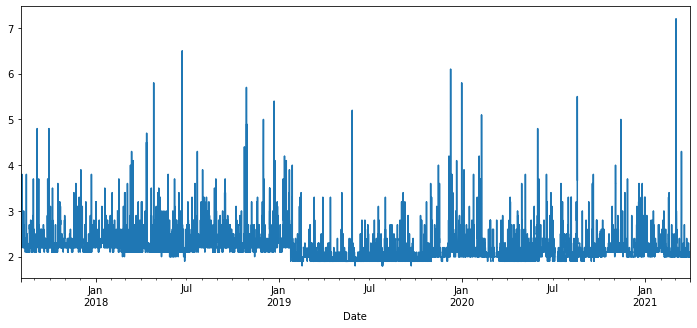

In [ ]:
df1_w[ aa].resample('H').mean().plot(figsize = (12,5))

In [ ]:
# df1_w[ 'H2S (ppb)'][df1_w[ 'H2S (ppb)']>3].plot.hist()

In [ ]:
df1_w.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

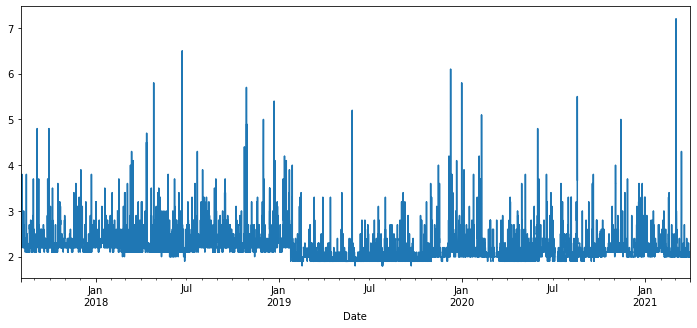

In [ ]:
df1_w[aa].resample('H').mean().plot(figsize = (12,5))

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 7*std])/len(df1_w)

0.9969261960040549

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 1000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 1000.0),
        "score" : trial.suggest_float( 'score', avg + 1.5*std, avg + 7 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 1000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 1000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.000000001000, random_state = 42)

        K = 5
        kf = KFold(n_splits=K)
        acc = 0 
        for train_index, test_index in kf.split(X):   
                X_tr, X_tes = X[train_index], X[test_index]
                y_tr, y_tes =  Y[train_index],  Y[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/K
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Buffalo Viewpoint_OT_THC_HP_hourly.csv')

[I 2021-05-16 16:42:43,275] A new study created in memory with name: no-name-06075735-1134-4d47-8add-5a314067daa1


[0]	validation-rmse:83.1311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4296.66
[2]	validation-rmse:222140
[3]	validation-rmse:1.14848e+07
[4]	validation-rmse:5.93773e+08
[5]	validation-rmse:3.06985e+10
[6]	validation-rmse:1.58714e+12
[7]	validation-rmse:8.20562e+13
[8]	validation-rmse:4.24237e+15
[9]	validation-rmse:2.19334e+17
[0]	validation-rmse:83.0504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4292.52
[2]	validation-rmse:221925
[3]	validation-rmse:1.14737e+07
[4]	validation-rmse:5.932e+08
[5]	validation-rmse:3.06689e+10
[6]	validation-rmse:1.5856e+12
[7]	validation-rmse:8.1977e+13
[8]	validation-rmse:4.23827e+15
[9]	validation-rmse:2.19122e+17
[0]	validation-rmse:86.8454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4488.76
[2]	validation-rmse:232071
[3]	validation-rmse:1.19983e+07
[4]	validation-rmse:6.2032e+08
[5]	validation-rmse:3.2071e+10
[6]	validation-rmse:1.65

[I 2021-05-16 16:42:44,291] Trial 0 finished with value: 5.0035714015761425e+34 and parameters: {'booster': 'gbtree', 'lambda': 0.3736770843931388, 'alpha': 363.09928536170787, 'score': 25.48726534900522, 'max_depth': 5, 'eta': 52.701846773383565, 'gamma': 637.6147894763715, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 5.0035714015761425e+34.


[0]	validation-rmse:1.27711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.990775
[2]	validation-rmse:0.774208
[3]	validation-rmse:0.611703
[4]	validation-rmse:0.491065
[5]	validation-rmse:0.403477
[6]	validation-rmse:0.340967
[7]	validation-rmse:0.298058
[8]	validation-rmse:0.269299
[9]	validation-rmse:0.250209
[0]	validation-rmse:1.27293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.986605
[2]	validation-rmse:0.769859
[3]	validation-rmse:0.607119
[4]	validation-rmse:0.486126
[5]	validation-rmse:0.397631
[6]	validation-rmse:0.33448
[7]	validation-rmse:0.290731
[8]	validation-rmse:0.261917
[9]	validation-rmse:0.242736
[0]	validation-rmse:1.33045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.03116
[2]	validation-rmse:0.80463
[3]	validation-rmse:0.634581
[4]	validation-rmse:0.508421
[5]	validation-rmse:0.416064
[6]	validation-rmse:0.350059
[7]	validation-rmse:0.304507
[8]	v

[I 2021-05-16 16:42:44,901] Trial 1 finished with value: 0.06313175345597716 and parameters: {'booster': 'gbtree', 'lambda': 0.1231549530164679, 'alpha': 0.016118841484088337, 'score': 35.549566783602785, 'max_depth': 3, 'eta': 0.23347499944904518, 'gamma': 5.2302573597093795, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


[0]	validation-rmse:282.997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:49121.9
[2]	validation-rmse:8.52653e+06
[3]	validation-rmse:1.48003e+09
[4]	validation-rmse:2.56901e+11
[5]	validation-rmse:4.45926e+13
[6]	validation-rmse:7.74034e+15
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:282.707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:49071.7
[2]	validation-rmse:8.51782e+06
[3]	validation-rmse:1.47851e+09
[4]	validation-rmse:2.56639e+11
[5]	validation-rmse:4.45471e+13
[6]	validation-rmse:7.73244e+15
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:295.471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:51288.3
[2]	validation-rmse:8.90277e+06
[3]	validation-rmse:1.54537e+09
[4]	validation-rmse:2.68249e+11
[5]	validation-rmse:4.65633e+13
[6]	validation-rmse:8.08259e+15
[7]	validation-rmse

[I 2021-05-16 16:42:45,365] Trial 2 finished with value: 1.6978519105814572e+45 and parameters: {'booster': 'gbtree', 'lambda': 2.664380487523444, 'alpha': 0.5520203394508256, 'score': 22.31370567304934, 'max_depth': 9, 'eta': 174.6341517747872, 'gamma': 66.520740430179, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.06313175345597716.


1.6978519105814572e+45
[0]	validation-rmse:10.2418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:64.2667
[2]	validation-rmse:403.58
[3]	validation-rmse:2534.21
[4]	validation-rmse:15913.3
[5]	validation-rmse:99926.3
[6]	validation-rmse:627478
[7]	validation-rmse:3.94019e+06
[8]	validation-rmse:2.4742e+07
[9]	validation-rmse:1.55365e+08
[0]	validation-rmse:10.239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:64.2317
[2]	validation-rmse:403.379
[3]	validation-rmse:2532.93
[4]	validation-rmse:15905.3
[5]	validation-rmse:99876
[6]	validation-rmse:627162
[7]	validation-rmse:3.9382e+06
[8]	validation-rmse:2.47296e+07
[9]	validation-rmse:1.55287e+08
[0]	validation-rmse:10.6933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:67.0841
[2]	validation-rmse:421.29
[3]	validation-rmse:2645.4
[4]	validation-rmse:16611.6
[5]	validation-rmse:104311
[6]	validation-rmse:655012
[7]	validation-rmse:

[I 2021-05-16 16:42:45,882] Trial 3 finished with value: 2.562804916142527e+16 and parameters: {'booster': 'gbtree', 'lambda': 0.09176550763891515, 'alpha': 4.398311436983174, 'score': 22.01991874635614, 'max_depth': 6, 'eta': 7.279484857554808, 'gamma': 124.95526008574613, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


2.562804916142527e+16
[0]	validation-rmse:1127.14
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:783718
[2]	validation-rmse:5.44938e+08
[3]	validation-rmse:3.78908e+11
[4]	validation-rmse:2.63464e+14
[5]	validation-rmse:1.83193e+17
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1125.91
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:782858
[2]	validation-rmse:5.4434e+08
[3]	validation-rmse:3.78492e+11
[4]	validation-rmse:2.63175e+14
[5]	validation-rmse:1.82992e+17
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:1176.78
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:818234
[2]	validation-rmse:5.68937e+08
[3]	validation-rmse:3.95596e+11
[4]	validation-rmse:2.75067e+14
[5]	validation-rmse:1.9126e+17
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8

[I 2021-05-16 16:42:46,372] Trial 4 finished with value: 1.9056202176601914e+57 and parameters: {'booster': 'gbtree', 'lambda': 0.0811753302669388, 'alpha': 158.80746387083795, 'score': 31.128208519616123, 'max_depth': 2, 'eta': 696.3266616365798, 'gamma': 702.0090443769875, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.
[I 2021-05-16 16:42:46,407] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:28.8259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:510.963
[2]	validation-rmse:9056.29
[3]	validation-rmse:160515
[4]	validation-rmse:2.84498e+06
[5]	validation-rmse:5.04246e+07
[6]	validation-rmse:8.93731e+08
[7]	validation-rmse:1.58406e+10
[8]	validation-rmse:2.8076e+11
[9]	validation-rmse:4.97621e+12
[0]	validation-rmse:28.8449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:511.152
[2]	validation-rmse:9059.78
[3]	validation-rmse:160576
[4]	validation-rmse:2.84607e+06
[5]	validation-rmse:5.04441e+07
[6]	validation-rmse:8.94075e+08
[7]	validation-rmse:1.58467e+10
[8]	validation-rmse:2.80868e+11
[9]	validation-rmse:4.97813e+12
[0]	validation-rmse:30.1453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:534.207
[2]	validation-rmse:9468.4
[3]	validation-rmse:167819
[4]	validation-rmse:2.97444e+06
[5]	validation-rmse:5.27192e+07
[6]	validation-rmse:9.344e+08
[7

[I 2021-05-16 16:42:46,913] Trial 6 finished with value: 2.5793950799307465e+25 and parameters: {'booster': 'gbtree', 'lambda': 0.012537113751307661, 'alpha': 0.19908175482247556, 'score': 27.233885804562732, 'max_depth': 7, 'eta': 18.724110385344886, 'gamma': 521.6496763099518, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.
[I 2021-05-16 16:42:46,952] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:38.1008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:885.812
[2]	validation-rmse:20600
[3]	validation-rmse:479061
[4]	validation-rmse:1.11408e+07
[5]	validation-rmse:2.59086e+08
[6]	validation-rmse:6.02524e+09
[7]	validation-rmse:1.40122e+11
[8]	validation-rmse:3.25865e+12
[9]	validation-rmse:7.57832e+13
[0]	validation-rmse:37.9618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:882.815
[2]	validation-rmse:20532.3
[3]	validation-rmse:477534
[4]	validation-rmse:1.11063e+07
[5]	validation-rmse:2.58308e+08
[6]	validation-rmse:6.00764e+09
[7]	validation-rmse:1.39724e+11
[8]	validation-rmse:3.24965e+12
[9]	validation-rmse:7.55793e+13
[0]	validation-rmse:39.6519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:922.171
[2]	validation-rmse:21447.5
[3]	validation-rmse:498815
[4]	validation-rmse:1.16012e+07
[5]	validation-rmse:2.69816e+08
[6]	validation-rmse:6.27527e+09


[I 2021-05-16 16:42:47,708] Trial 8 finished with value: 6.041017007584389e+27 and parameters: {'booster': 'gbtree', 'lambda': 0.024467921417451615, 'alpha': 0.017867906823594636, 'score': 28.05732225137132, 'max_depth': 7, 'eta': 24.257966071501986, 'gamma': 10.640858030010753, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


6.041017007584389e+27
[0]	validation-rmse:1.37363
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.14788
[2]	validation-rmse:0.961182
[3]	validation-rmse:0.806966
[4]	validation-rmse:0.680216
[5]	validation-rmse:0.576226
[6]	validation-rmse:0.491401
[7]	validation-rmse:0.422577
[8]	validation-rmse:0.367514
[9]	validation-rmse:0.323674
[0]	validation-rmse:1.36703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.14122
[2]	validation-rmse:0.954484
[3]	validation-rmse:0.800288
[4]	validation-rmse:0.673118
[5]	validation-rmse:0.568811
[6]	validation-rmse:0.483677
[7]	validation-rmse:0.414637
[8]	validation-rmse:0.358892
[9]	validation-rmse:0.31447
[0]	validation-rmse:1.42935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.19351
[2]	validation-rmse:0.998403
[3]	validation-rmse:0.837407
[4]	validation-rmse:0.704789
[5]	validation-rmse:0.595996
[6]	validation-rmse:0.507217
[7]	validatio

[I 2021-05-16 16:42:48,485] Trial 9 finished with value: 0.11453285689074227 and parameters: {'booster': 'gbtree', 'lambda': 3.402506692727136, 'alpha': 1.1972264090099765, 'score': 38.18158027993615, 'max_depth': 6, 'eta': 0.16854481947509292, 'gamma': 0.19777302010778672, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


0.11453285689074227
[0]	validation-rmse:1.42819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.23719
[2]	validation-rmse:1.0738
[3]	validation-rmse:0.934339
[4]	validation-rmse:0.815638
[5]	validation-rmse:0.714972
[6]	validation-rmse:0.629995
[7]	validation-rmse:0.55867
[8]	validation-rmse:0.498588
[9]	validation-rmse:0.448339
[0]	validation-rmse:1.42029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.22898
[2]	validation-rmse:1.0652
[3]	validation-rmse:0.92526
[4]	validation-rmse:0.805996
[5]	validation-rmse:0.704687
[6]	validation-rmse:0.618991
[7]	validation-rmse:0.546885
[8]	validation-rmse:0.486136
[9]	validation-rmse:0.435178
[0]	validation-rmse:1.48177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.2816
[2]	validation-rmse:1.11023
[3]	validation-rmse:0.963811
[4]	validation-rmse:0.839025
[5]	validation-rmse:0.73303
[6]	validation-rmse:0.643382
[7]	validation-rmse:0.5

[I 2021-05-16 16:42:48,950] Trial 10 finished with value: 0.21402193004192505 and parameters: {'booster': 'gbtree', 'lambda': 424.65736980441005, 'alpha': 0.015135149017545427, 'score': 39.6202083231561, 'max_depth': 1, 'eta': 0.1420716738301944, 'gamma': 1.3246046250747057, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


0.21402193004192505
[0]	validation-rmse:1.45913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.29065
[2]	validation-rmse:1.14265
[3]	validation-rmse:1.01309
[4]	validation-rmse:0.899589
[5]	validation-rmse:0.80064
[6]	validation-rmse:0.714339
[7]	validation-rmse:0.639293
[8]	validation-rmse:0.573936
[9]	validation-rmse:0.517625
[0]	validation-rmse:1.45132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.2825
[2]	validation-rmse:1.13448
[3]	validation-rmse:1.00454
[4]	validation-rmse:0.89078
[5]	validation-rmse:0.791479
[6]	validation-rmse:0.704462
[7]	validation-rmse:0.628968
[8]	validation-rmse:0.563069
[9]	validation-rmse:0.505893
[0]	validation-rmse:1.51446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.33817
[2]	validation-rmse:1.18352
[3]	validation-rmse:1.04804
[4]	validation-rmse:0.929346
[5]	validation-rmse:0.825431
[6]	validation-rmse:0.734714
[7]	validation-rmse:0.6

[I 2021-05-16 16:42:49,558] Trial 11 finished with value: 0.272398528505417 and parameters: {'booster': 'gbtree', 'lambda': 1.9664363290022469, 'alpha': 16.710938438880603, 'score': 39.802407941407814, 'max_depth': 3, 'eta': 0.1192198500287103, 'gamma': 0.6337473766477715, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


[0]	validation-rmse:0.51271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.258181
[2]	validation-rmse:0.231202
[3]	validation-rmse:0.228134
[4]	validation-rmse:0.225535
[5]	validation-rmse:0.220713
[6]	validation-rmse:0.218506
[7]	validation-rmse:0.218506
[8]	validation-rmse:0.218506
[9]	validation-rmse:0.218506
[0]	validation-rmse:0.506029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.247616
[2]	validation-rmse:0.218465
[3]	validation-rmse:0.213194
[4]	validation-rmse:0.209563
[5]	validation-rmse:0.209501
[6]	validation-rmse:0.209501
[7]	validation-rmse:0.209501
[8]	validation-rmse:0.209501
[9]	validation-rmse:0.209501
[0]	validation-rmse:0.52832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.262172
[2]	validation-rmse:0.229171
[3]	validation-rmse:0.22404
[4]	validation-rmse:0.222674
[5]	validation-rmse:0.221581
[6]	validation-rmse:0.220643
[7]	validation-rmse:0.220643
[8

[I 2021-05-16 16:42:50,229] Trial 12 finished with value: 0.08160181152305201 and parameters: {'booster': 'gbtree', 'lambda': 39.10025477438791, 'alpha': 27.63273603385661, 'score': 35.36173830998298, 'max_depth': 4, 'eta': 1.2741067192642581, 'gamma': 1.6405207034813782, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.06313175345597716.


0.08160181152305201
[0]	validation-rmse:0.371871
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.239869
[2]	validation-rmse:0.230418
[3]	validation-rmse:0.225634
[4]	validation-rmse:0.223314
[5]	validation-rmse:0.223314
[6]	validation-rmse:0.223314
[7]	validation-rmse:0.223314
[8]	validation-rmse:0.223314
[9]	validation-rmse:0.223314
[0]	validation-rmse:0.362917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.227597
[2]	validation-rmse:0.217765
[3]	validation-rmse:0.212328
[4]	validation-rmse:0.210696
[5]	validation-rmse:0.210693
[6]	validation-rmse:0.210693
[7]	validation-rmse:0.210693
[8]	validation-rmse:0.210693
[9]	validation-rmse:0.210693
[0]	validation-rmse:0.378687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.247362
[2]	validation-rmse:0.237197
[3]	validation-rmse:0.234022
[4]	validation-rmse:0.230746
[5]	validation-rmse:0.230746
[6]	validation-rmse:0.230746
[7]	vali

[I 2021-05-16 16:42:50,951] Trial 13 finished with value: 0.05405042926197738 and parameters: {'booster': 'gbtree', 'lambda': 178.89194530078632, 'alpha': 55.005038724136504, 'score': 35.27691259361253, 'max_depth': 4, 'eta': 1.172857132453956, 'gamma': 3.0565272276367077, 'grow_policy': 'depthwise'}. Best is trial 13 with value: 0.05405042926197738.


0.05405042926197738
[0]	validation-rmse:0.413511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.238183
[2]	validation-rmse:0.21605
[3]	validation-rmse:0.209488
[4]	validation-rmse:0.20409
[5]	validation-rmse:0.199867
[6]	validation-rmse:0.199859
[7]	validation-rmse:0.199858
[8]	validation-rmse:0.199858
[9]	validation-rmse:0.199858
[0]	validation-rmse:0.405829
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.227871
[2]	validation-rmse:0.206493
[3]	validation-rmse:0.1999
[4]	validation-rmse:0.194175
[5]	validation-rmse:0.189814
[6]	validation-rmse:0.189806
[7]	validation-rmse:0.189805
[8]	validation-rmse:0.189804
[9]	validation-rmse:0.189804
[0]	validation-rmse:0.435852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.252528
[2]	validation-rmse:0.229244
[3]	validation-rmse:0.222665
[4]	validation-rmse:0.219018
[5]	validation-rmse:0.218916
[6]	validation-rmse:0.218899
[7]	validati

[I 2021-05-16 16:42:51,576] Trial 14 finished with value: 0.0528582011205508 and parameters: {'booster': 'gbtree', 'lambda': 516.6238250455257, 'alpha': 71.87897971135916, 'score': 34.22803682166363, 'max_depth': 3, 'eta': 0.8167591940560658, 'gamma': 5.448756472346457, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.0528582011205508.


0.0528582011205508
[0]	validation-rmse:0.495398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.249877
[2]	validation-rmse:0.219469
[3]	validation-rmse:0.209992
[4]	validation-rmse:0.206073
[5]	validation-rmse:0.202821
[6]	validation-rmse:0.202821
[7]	validation-rmse:0.202821
[8]	validation-rmse:0.202821
[9]	validation-rmse:0.202821
[0]	validation-rmse:0.49181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.243028
[2]	validation-rmse:0.211985
[3]	validation-rmse:0.202563
[4]	validation-rmse:0.198579
[5]	validation-rmse:0.196598
[6]	validation-rmse:0.196598
[7]	validation-rmse:0.196598
[8]	validation-rmse:0.196598
[9]	validation-rmse:0.196598
[0]	validation-rmse:0.515063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27155
[2]	validation-rmse:0.230086
[3]	validation-rmse:0.218748
[4]	validation-rmse:0.213619
[5]	validation-rmse:0.210726
[6]	validation-rmse:0.210726
[7]	validat

[I 2021-05-16 16:42:52,078] Trial 15 finished with value: 0.05550197221116192 and parameters: {'booster': 'gbtree', 'lambda': 672.5276770088109, 'alpha': 70.90221081448036, 'score': 32.27519873713331, 'max_depth': 1, 'eta': 1.3174867476381673, 'gamma': 6.210474979034376, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.0528582011205508.


0.05550197221116192
[0]	validation-rmse:0.529775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.296411
[2]	validation-rmse:0.261014
[3]	validation-rmse:0.255118
[4]	validation-rmse:0.253836
[5]	validation-rmse:0.253518
[6]	validation-rmse:0.253436
[7]	validation-rmse:0.253414
[8]	validation-rmse:0.253408
[9]	validation-rmse:0.253407
[0]	validation-rmse:0.523171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.286391
[2]	validation-rmse:0.250039
[3]	validation-rmse:0.243993
[4]	validation-rmse:0.242684
[5]	validation-rmse:0.242359
[6]	validation-rmse:0.242274
[7]	validation-rmse:0.242252
[8]	validation-rmse:0.242247
[9]	validation-rmse:0.242245
[0]	validation-rmse:0.546328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.300742
[2]	validation-rmse:0.263863
[3]	validation-rmse:0.249559
[4]	validation-rmse:0.248561
[5]	validation-rmse:0.248311
[6]	validation-rmse:0.248246
[7]	vali

[I 2021-05-16 16:42:52,728] Trial 16 finished with value: 0.07548004504159131 and parameters: {'booster': 'gbtree', 'lambda': 108.26436132820459, 'alpha': 991.2077908998525, 'score': 32.867149507434895, 'max_depth': 4, 'eta': 0.7409967034594989, 'gamma': 20.737139830843947, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.0528582011205508.
[I 2021-05-16 16:42:52,767] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.361486
[2]	validation-rmse:0.249233
[3]	validation-rmse:0.218563
[4]	validation-rmse:0.207644
[5]	validation-rmse:0.203781
[6]	validation-rmse:0.202005
[7]	validation-rmse:0.200829
[8]	validation-rmse:0.199877
[9]	validation-rmse:0.198767
[0]	validation-rmse:0.708048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.350694
[2]	validation-rmse:0.235557
[3]	validation-rmse:0.204225
[4]	validation-rmse:0.194788
[5]	validation-rmse:0.190668
[6]	validation-rmse:0.18844
[7]	validation-rmse:0.187868
[8]	validation-rmse:0.185649
[9]	validation-rmse:0.18474
[0]	validation-rmse:0.73842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.367174
[2]	validation-rmse:0.24849
[3]	validation-rmse:0.214883
[4]	validation-rmse:0.206014
[5]	validation-rmse:0.203215
[6]	validation-rmse:0.200687
[7]	validation-rmse:0.199058
[8]

[I 2021-05-16 16:42:53,496] Trial 18 finished with value: 0.04990257999053989 and parameters: {'booster': 'gbtree', 'lambda': 60.116055023935786, 'alpha': 7.19798527090825, 'score': 30.232283789507512, 'max_depth': 4, 'eta': 0.5924042661826321, 'gamma': 0.41951081599550594, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.04990257999053989.


0.04990257999053989
[0]	validation-rmse:0.772773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.398332
[2]	validation-rmse:0.255147
[3]	validation-rmse:0.208193
[4]	validation-rmse:0.19469
[5]	validation-rmse:0.18856
[6]	validation-rmse:0.185289
[7]	validation-rmse:0.182701
[8]	validation-rmse:0.181917
[9]	validation-rmse:0.18104
[0]	validation-rmse:0.768998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.393131
[2]	validation-rmse:0.246082
[3]	validation-rmse:0.198285
[4]	validation-rmse:0.183666
[5]	validation-rmse:0.177702
[6]	validation-rmse:0.175483
[7]	validation-rmse:0.173971
[8]	validation-rmse:0.172639
[9]	validation-rmse:0.171031
[0]	validation-rmse:0.808348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.41776
[2]	validation-rmse:0.268645
[3]	validation-rmse:0.220861
[4]	validation-rmse:0.206185
[5]	validation-rmse:0.200687
[6]	validation-rmse:0.196999
[7]	validati

[I 2021-05-16 16:42:54,267] Trial 19 finished with value: 0.0466731091890756 and parameters: {'booster': 'gbtree', 'lambda': 13.617241662695626, 'alpha': 6.117768655874442, 'score': 29.313936377858674, 'max_depth': 5, 'eta': 0.5445350941379563, 'gamma': 0.31970225984635475, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.0466731091890756.


0.0466731091890756
[0]	validation-rmse:0.993114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.615349
[2]	validation-rmse:0.404858
[3]	validation-rmse:0.294967
[4]	validation-rmse:0.242508
[5]	validation-rmse:0.219445
[6]	validation-rmse:0.209549
[7]	validation-rmse:0.204641
[8]	validation-rmse:0.201878
[9]	validation-rmse:0.20079
[0]	validation-rmse:0.987231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.607259
[2]	validation-rmse:0.394714
[3]	validation-rmse:0.282321
[4]	validation-rmse:0.229842
[5]	validation-rmse:0.206156
[6]	validation-rmse:0.19613
[7]	validation-rmse:0.191672
[8]	validation-rmse:0.1893
[9]	validation-rmse:0.186621
[0]	validation-rmse:1.03648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.641526
[2]	validation-rmse:0.421619
[3]	validation-rmse:0.307918
[4]	validation-rmse:0.254254
[5]	validation-rmse:0.230448
[6]	validation-rmse:0.219738
[7]	validation

[I 2021-05-16 16:42:55,053] Trial 20 finished with value: 0.049378257179652565 and parameters: {'booster': 'gbtree', 'lambda': 9.791906879171428, 'alpha': 5.1031269061841735, 'score': 30.30077939963109, 'max_depth': 5, 'eta': 0.4084155539288465, 'gamma': 0.47472492645251485, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.0466731091890756.


[0]	validation-rmse:1.11771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768992
[2]	validation-rmse:0.53955
[3]	validation-rmse:0.391205
[4]	validation-rmse:0.298943
[5]	validation-rmse:0.244043
[6]	validation-rmse:0.213479
[7]	validation-rmse:0.196668
[8]	validation-rmse:0.188082
[9]	validation-rmse:0.182372
[0]	validation-rmse:1.11325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.763997
[2]	validation-rmse:0.533782
[3]	validation-rmse:0.384784
[4]	validation-rmse:0.290724
[5]	validation-rmse:0.236003
[6]	validation-rmse:0.204942
[7]	validation-rmse:0.18819
[8]	validation-rmse:0.178696
[9]	validation-rmse:0.174102
[0]	validation-rmse:1.16668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.803266
[2]	validation-rmse:0.563275
[3]	validation-rmse:0.409128
[4]	validation-rmse:0.313932
[5]	validation-rmse:0.258516
[6]	validation-rmse:0.227635
[7]	validation-rmse:0.210737
[8]	

[I 2021-05-16 16:42:55,828] Trial 21 finished with value: 0.04723827171115985 and parameters: {'booster': 'gbtree', 'lambda': 11.81406284042777, 'alpha': 5.6971450024084485, 'score': 29.125246206855454, 'max_depth': 5, 'eta': 0.324190427455083, 'gamma': 0.4687924700461005, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.0466731091890756.


0.04723827171115985


[I 2021-05-16 16:42:55,876] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:1.1612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827342
[2]	validation-rmse:0.597436
[3]	validation-rmse:0.441815
[4]	validation-rmse:0.339424
[5]	validation-rmse:0.274379
[6]	validation-rmse:0.234347
[7]	validation-rmse:0.209934
[8]	validation-rmse:0.196622
[9]	validation-rmse:0.187318
[0]	validation-rmse:1.15833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.824503
[2]	validation-rmse:0.594171
[3]	validation-rmse:0.438638
[4]	validation-rmse:0.335616
[5]	validation-rmse:0.270268
[6]	validation-rmse:0.230458
[7]	validation-rmse:0.20845
[8]	validation-rmse:0.194215
[9]	validation-rmse:0.186604
[0]	validation-rmse:1.21453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.866279
[2]	validation-rmse:0.626597
[3]	validation-rmse:0.464794
[4]	validation-rmse:0.358682
[5]	validation-rmse:0.291947
[6]	validation-rmse:0.251934
[7]	validation-rmse:0.228237
[8]	

[I 2021-05-16 16:42:56,744] Trial 23 finished with value: 0.05011345730376047 and parameters: {'booster': 'gbtree', 'lambda': 9.661927821544094, 'alpha': 7.469725680148177, 'score': 25.293686619554588, 'max_depth': 8, 'eta': 0.29873776011748565, 'gamma': 0.10347991618688127, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.0466731091890756.



[0]	validation-rmse:1.03767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.667366
[2]	validation-rmse:0.445218
[3]	validation-rmse:0.317784
[4]	validation-rmse:0.249957
[5]	validation-rmse:0.21658
[6]	validation-rmse:0.19962
[7]	validation-rmse:0.1925
[8]	validation-rmse:0.188773
[9]	validation-rmse:0.186193
[0]	validation-rmse:1.03137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.659784
[2]	validation-rmse:0.436844
[3]	validation-rmse:0.308391
[4]	validation-rmse:0.239227
[5]	validation-rmse:0.205416
[6]	validation-rmse:0.188649
[7]	validation-rmse:0.181308
[8]	validation-rmse:0.177964
[9]	validation-rmse:0.176274
[0]	validation-rmse:1.08023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.69309
[2]	validation-rmse:0.460852
[3]	validation-rmse:0.328148
[4]	validation-rmse:0.257406
[5]	validation-rmse:0.222556
[6]	validation-rmse:0.205484
[7]	validation-rmse:0.197751
[8]	va

[I 2021-05-16 16:42:57,559] Trial 24 finished with value: 0.04428682809461202 and parameters: {'booster': 'gbtree', 'lambda': 9.626085241831694, 'alpha': 1.7497929596637574, 'score': 20.11611217556846, 'max_depth': 5, 'eta': 0.3772845846233044, 'gamma': 0.776379008687331, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.04428682809461202.


0.04428682809461202


[I 2021-05-16 16:42:57,604] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:42:57,645] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.965249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.581955
[2]	validation-rmse:0.371033
[3]	validation-rmse:0.264033
[4]	validation-rmse:0.214257
[5]	validation-rmse:0.19347
[6]	validation-rmse:0.18502
[7]	validation-rmse:0.180896
[8]	validation-rmse:0.177701
[9]	validation-rmse:0.173707
[0]	validation-rmse:0.964345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.581424
[2]	validation-rmse:0.370493
[3]	validation-rmse:0.263037
[4]	validation-rmse:0.214062
[5]	validation-rmse:0.194133
[6]	validation-rmse:0.186029
[7]	validation-rmse:0.182707
[8]	validation-rmse:0.180061
[9]	validation-rmse:0.176358
[0]	validation-rmse:1.00447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.603634
[2]	validation-rmse:0.383494
[3]	validation-rmse:0.270939
[4]	validation-rmse:0.219808
[5]	validation-rmse:0.19873
[6]	validation-rmse:0.187087
[7]	validation-rmse:0.183925
[8]

[I 2021-05-16 16:42:58,552] Trial 27 finished with value: 0.04710046009614564 and parameters: {'booster': 'gbtree', 'lambda': 0.637946403335435, 'alpha': 1.8669541856316707, 'score': 19.388428460538247, 'max_depth': 6, 'eta': 0.419374419053972, 'gamma': 0.27425074240993286, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.04428682809461202.


0.04710046009614564


[I 2021-05-16 16:42:58,596] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.849678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.467537
[2]	validation-rmse:0.295093
[3]	validation-rmse:0.22665
[4]	validation-rmse:0.203464
[5]	validation-rmse:0.194181
[6]	validation-rmse:0.189941
[7]	validation-rmse:0.188122
[8]	validation-rmse:0.186302
[9]	validation-rmse:0.183887
[0]	validation-rmse:0.848903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.466649
[2]	validation-rmse:0.293869
[3]	validation-rmse:0.227014
[4]	validation-rmse:0.20337
[5]	validation-rmse:0.195205
[6]	validation-rmse:0.190152
[7]	validation-rmse:0.187816
[8]	validation-rmse:0.186196
[9]	validation-rmse:0.18454
[0]	validation-rmse:0.883038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.481063
[2]	validation-rmse:0.30058
[3]	validation-rmse:0.229707
[4]	validation-rmse:0.205794
[5]	validation-rmse:0.196486
[6]	validation-rmse:0.192071
[7]	validation-rmse:0.189906
[8]

[I 2021-05-16 16:42:59,529] Trial 29 finished with value: 0.04400225446559468 and parameters: {'booster': 'gbtree', 'lambda': 4.46563162434052, 'alpha': 20.20461033317173, 'score': 19.416545123928437, 'max_depth': 6, 'eta': 0.4944894612703292, 'gamma': 0.10299946681252627, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04400225446559468


[I 2021-05-16 16:42:59,568] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.838561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.452008
[2]	validation-rmse:0.27548
[3]	validation-rmse:0.206224
[4]	validation-rmse:0.182154
[5]	validation-rmse:0.174452
[6]	validation-rmse:0.169266
[7]	validation-rmse:0.167188
[8]	validation-rmse:0.165498
[9]	validation-rmse:0.164582
[0]	validation-rmse:0.83754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.450309
[2]	validation-rmse:0.271685
[3]	validation-rmse:0.201426
[4]	validation-rmse:0.177502
[5]	validation-rmse:0.168928
[6]	validation-rmse:0.164933
[7]	validation-rmse:0.162917
[8]	validation-rmse:0.161283
[9]	validation-rmse:0.159943
[0]	validation-rmse:0.883473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.481334
[2]	validation-rmse:0.298157
[3]	validation-rmse:0.226408
[4]	validation-rmse:0.202701
[5]	validation-rmse:0.193543
[6]	validation-rmse:0.189537
[7]	validation-rmse:0.187396
[

[I 2021-05-16 16:43:00,445] Trial 31 finished with value: 0.047445550829115134 and parameters: {'booster': 'gbtree', 'lambda': 0.9425476119810854, 'alpha': 12.344041395086679, 'score': 18.43157431129532, 'max_depth': 6, 'eta': 0.49368005806225446, 'gamma': 0.11240974276500179, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.047445550829115134


[I 2021-05-16 16:43:00,491] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:00,536] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:00,574] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:00,619] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.341869
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188418
[2]	validation-rmse:0.178774
[3]	validation-rmse:0.176534
[4]	validation-rmse:0.175375
[5]	validation-rmse:0.174445
[6]	validation-rmse:0.174302
[7]	validation-rmse:0.173539
[8]	validation-rmse:0.172819
[9]	validation-rmse:0.171943
[0]	validation-rmse:0.331166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175536
[2]	validation-rmse:0.165368
[3]	validation-rmse:0.162873
[4]	validation-rmse:0.161025
[5]	validation-rmse:0.160017
[6]	validation-rmse:0.158218
[7]	validation-rmse:0.157417
[8]	validation-rmse:0.156645
[9]	validation-rmse:0.156439
[0]	validation-rmse:0.343422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181989
[2]	validation-rmse:0.171247
[3]	validation-rmse:0.169714
[4]	validation-rmse:0.169255
[5]	validation-rmse:0.167661
[6]	validation-rmse:0.167189
[7]	validation-rmse:0.164961

[I 2021-05-16 16:43:01,405] Trial 36 finished with value: 0.04895580739325221 and parameters: {'booster': 'gbtree', 'lambda': 6.014592316685063, 'alpha': 0.3850685944388721, 'score': 16.044350933362924, 'max_depth': 4, 'eta': 0.8269081683013848, 'gamma': 0.14953329755989858, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04895580739325221
[0]	validation-rmse:0.871368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.489602
[2]	validation-rmse:0.311569
[3]	validation-rmse:0.238186
[4]	validation-rmse:0.210087
[5]	validation-rmse:0.199664
[6]	validation-rmse:0.19439
[7]	validation-rmse:0.191896
[8]	validation-rmse:0.190237
[9]	validation-rmse:0.18928
[0]	validation-rmse:0.866394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.482719
[2]	validation-rmse:0.302254
[3]	validation-rmse:0.228744
[4]	validation-rmse:0.200912
[5]	validation-rmse:0.191198
[6]	validation-rmse:0.186549
[7]	validation-rmse:0.184791
[8]	validation-rmse:0.183266
[9]	validation-rmse:0.18234
[0]	validation-rmse:0.904553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.503486
[2]	validation-rmse:0.316844
[3]	validation-rmse:0.239665
[4]	validation-rmse:0.210678
[5]	validation-rmse:0.200978
[6]	validation-rmse:0.195374
[7]	validat

[I 2021-05-16 16:43:02,307] Trial 37 finished with value: 0.045228227307839215 and parameters: {'booster': 'gbtree', 'lambda': 24.889712683776704, 'alpha': 12.32968239440114, 'score': 18.59352633005937, 'max_depth': 7, 'eta': 0.48288460180867815, 'gamma': 0.6824747949427729, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.045228227307839215


[I 2021-05-16 16:43:02,346] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:02,384] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:02,425] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.819779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.439256
[2]	validation-rmse:0.280184
[3]	validation-rmse:0.223875
[4]	validation-rmse:0.205593
[5]	validation-rmse:0.197827
[6]	validation-rmse:0.194822
[7]	validation-rmse:0.193209
[8]	validation-rmse:0.19224
[9]	validation-rmse:0.192124
[0]	validation-rmse:0.815701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.433063
[2]	validation-rmse:0.271884
[3]	validation-rmse:0.216727
[4]	validation-rmse:0.198179
[5]	validation-rmse:0.190722
[6]	validation-rmse:0.188252
[7]	validation-rmse:0.1862
[8]	validation-rmse:0.185318
[9]	validation-rmse:0.182279
[0]	validation-rmse:0.852376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.452874
[2]	validation-rmse:0.285044
[3]	validation-rmse:0.225673
[4]	validation-rmse:0.206465
[5]	validation-rmse:0.200062
[6]	validation-rmse:0.198007
[7]	validation-rmse:0.193752
[8

[I 2021-05-16 16:43:03,430] Trial 41 finished with value: 0.044357814711974065 and parameters: {'booster': 'gbtree', 'lambda': 1.2157715755828165, 'alpha': 3.6412708802190576, 'score': 18.625999711372696, 'max_depth': 7, 'eta': 0.5154788861192273, 'gamma': 0.34909556339588105, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.044357814711974065
[0]	validation-rmse:0.757432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.376881
[2]	validation-rmse:0.229825
[3]	validation-rmse:0.183505
[4]	validation-rmse:0.17183
[5]	validation-rmse:0.169106
[6]	validation-rmse:0.168926
[7]	validation-rmse:0.168982
[8]	validation-rmse:0.169037
[9]	validation-rmse:0.169068
[0]	validation-rmse:0.757561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.375945
[2]	validation-rmse:0.227142
[3]	validation-rmse:0.180465
[4]	validation-rmse:0.168475
[5]	validation-rmse:0.164001
[6]	validation-rmse:0.163709
[7]	validation-rmse:0.163724
[8]	validation-rmse:0.163762
[9]	validation-rmse:0.163786
[0]	validation-rmse:0.796512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.401234
[2]	validation-rmse:0.249276
[3]	validation-rmse:0.201756
[4]	validation-rmse:0.189388
[5]	validation-rmse:0.186319
[6]	validation-rmse:0.185294
[7]	vali

[I 2021-05-16 16:43:04,463] Trial 42 finished with value: 0.046182609759388954 and parameters: {'booster': 'gbtree', 'lambda': 2.0161773157097884, 'alpha': 3.878571474866058, 'score': 15.429889016086769, 'max_depth': 7, 'eta': 0.5439417004437272, 'gamma': 2.8762613949654385, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.046182609759388954
[0]	validation-rmse:0.206737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183883
[2]	validation-rmse:0.181102
[3]	validation-rmse:0.181114
[4]	validation-rmse:0.181115
[5]	validation-rmse:0.181115
[6]	validation-rmse:0.181115
[7]	validation-rmse:0.181115
[8]	validation-rmse:0.181115
[9]	validation-rmse:0.181115
[0]	validation-rmse:0.193405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174749
[2]	validation-rmse:0.172676
[3]	validation-rmse:0.170364
[4]	validation-rmse:0.168457
[5]	validation-rmse:0.168467
[6]	validation-rmse:0.168467
[7]	validation-rmse:0.168467
[8]	validation-rmse:0.168467
[9]	validation-rmse:0.168467
[0]	validation-rmse:0.212676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190399
[2]	validation-rmse:0.188918
[3]	validation-rmse:0.187468
[4]	validation-rmse:0.187468
[5]	validation-rmse:0.187468
[6]	validation-rmse:0.187468
[7]	val

[I 2021-05-16 16:43:05,650] Trial 43 finished with value: 0.048966082440263306 and parameters: {'booster': 'gbtree', 'lambda': 2.294436098209621, 'alpha': 3.7921871634639115, 'score': 15.256133659523982, 'max_depth': 8, 'eta': 0.9600352387972747, 'gamma': 3.086957050184654, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.048966082440263306


[I 2021-05-16 16:43:05,690] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:05,732] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:05,773] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.637256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.292547
[2]	validation-rmse:0.199288
[3]	validation-rmse:0.180806
[4]	validation-rmse:0.176373
[5]	validation-rmse:0.17535
[6]	validation-rmse:0.174174
[7]	validation-rmse:0.172082
[8]	validation-rmse:0.171821
[9]	validation-rmse:0.171351
[0]	validation-rmse:0.633891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287113
[2]	validation-rmse:0.190692
[3]	validation-rmse:0.171121
[4]	validation-rmse:0.167775
[5]	validation-rmse:0.167013
[6]	validation-rmse:0.165393
[7]	validation-rmse:0.164991
[8]	validation-rmse:0.164715
[9]	validation-rmse:0.164049
[0]	validation-rmse:0.668342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.308777
[2]	validation-rmse:0.21011
[3]	validation-rmse:0.191901
[4]	validation-rmse:0.187249
[5]	validation-rmse:0.187231
[6]	validation-rmse:0.185884
[7]	validation-rmse:0.184962
[

[I 2021-05-16 16:43:07,089] Trial 47 finished with value: 0.05455271834392636 and parameters: {'booster': 'gbtree', 'lambda': 0.06953869783297525, 'alpha': 0.35568828958090815, 'score': 13.317408298546416, 'max_depth': 8, 'eta': 0.6241119549699415, 'gamma': 0.6570838303293607, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.05455271834392636


[I 2021-05-16 16:43:07,133] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:07,175] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.458481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.239196
[2]	validation-rmse:0.212042
[3]	validation-rmse:0.210215
[4]	validation-rmse:0.208509
[5]	validation-rmse:0.208513
[6]	validation-rmse:0.208513


[I 2021-05-16 16:43:07,358] Trial 50 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:0.78736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.413913
[2]	validation-rmse:0.264602
[3]	validation-rmse:0.215728
[4]	validation-rmse:0.201246
[5]	validation-rmse:0.194067
[6]	validation-rmse:0.191461
[7]	validation-rmse:0.190496
[8]	validation-rmse:0.188993
[9]	validation-rmse:0.188402
[0]	validation-rmse:0.784114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.408207
[2]	validation-rmse:0.258125
[3]	validation-rmse:0.208692
[4]	validation-rmse:0.193595
[5]	validation-rmse:0.188326
[6]	validation-rmse:0.186381
[7]	validation-rmse:0.184186
[8]	validation-rmse:0.182096
[9]	validation-rmse:0.181632
[0]	validation-rmse:0.814161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.420636
[2]	validation-rmse:0.264959
[3]	validation-rmse:0.214594
[4]	validation-rmse:0.19992
[5]	validation-rmse:0.194531
[6]	validation-rmse:0.193135
[7]	validation-rmse:0.191383
[

[I 2021-05-16 16:43:08,223] Trial 51 finished with value: 0.046526574025396526 and parameters: {'booster': 'gbtree', 'lambda': 19.630161948714278, 'alpha': 8.198921676991477, 'score': 19.737777565032594, 'max_depth': 5, 'eta': 0.5369115694172628, 'gamma': 0.5558853272408825, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.046526574025396526


[I 2021-05-16 16:43:08,267] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:08,309] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213134
[2]	validation-rmse:0.203591
[3]	validation-rmse:0.199685
[4]	validation-rmse:0.199685
[5]	validation-rmse:0.199685
[6]	validation-rmse:0.199685
[7]	validation-rmse:0.199685
[8]	validation-rmse:0.199685
[9]	validation-rmse:0.199685
[0]	validation-rmse:0.239544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187209
[2]	validation-rmse:0.180504
[3]	validation-rmse:0.17681
[4]	validation-rmse:0.175433
[5]	validation-rmse:0.175433
[6]	validation-rmse:0.175433
[7]	validation-rmse:0.175433
[8]	validation-rmse:0.175433
[9]	validation-rmse:0.175433
[0]	validation-rmse:0.249541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200176
[2]	validation-rmse:0.190512
[3]	validation-rmse:0.189343
[4]	validation-rmse:0.189343
[5]	validation-rmse:0.189343
[6]	validation-rmse:0.189343
[7]	validation-rmse:0.189343


[I 2021-05-16 16:43:09,241] Trial 54 finished with value: 0.048267598778498344 and parameters: {'booster': 'gbtree', 'lambda': 2.909467796922354, 'alpha': 89.27075155105904, 'score': 19.054050407927576, 'max_depth': 7, 'eta': 0.9432705218503141, 'gamma': 1.2131440806382854, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.048267598778498344


[I 2021-05-16 16:43:09,285] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.655565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.328443
[2]	validation-rmse:0.243935
[3]	validation-rmse:0.218504
[4]	validation-rmse:0.208993
[5]	validation-rmse:0.205546
[6]	validation-rmse:0.204241


[I 2021-05-16 16:43:09,431] Trial 56 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:43:09,487] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:09,530] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.536744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.261098
[2]	validation-rmse:0.216756
[3]	validation-rmse:0.210832
[4]	validation-rmse:0.209482
[5]	validation-rmse:0.209445


[I 2021-05-16 16:43:09,640] Trial 59 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:43:09,683] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.824572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.440953
[2]	validation-rmse:0.273636
[3]	validation-rmse:0.210465
[4]	validation-rmse:0.191545
[5]	validation-rmse:0.183166
[6]	validation-rmse:0.180656
[7]	validation-rmse:0.179355
[8]	validation-rmse:0.178404
[9]	validation-rmse:0.177442
[0]	validation-rmse:0.823929
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.439713
[2]	validation-rmse:0.271444
[3]	validation-rmse:0.208131
[4]	validation-rmse:0.188102
[5]	validation-rmse:0.18035
[6]	validation-rmse:0.177269
[7]	validation-rmse:0.174797
[8]	validation-rmse:0.173932
[9]	validation-rmse:0.17254
[0]	validation-rmse:0.863174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.463006
[2]	validation-rmse:0.29013
[3]	validation-rmse:0.226078
[4]	validation-rmse:0.205576
[5]	validation-rmse:0.199093
[6]	validation-rmse:0.196761
[7]	validation-rmse:0.195429
[8

[I 2021-05-16 16:43:10,440] Trial 61 finished with value: 0.0478312320628491 and parameters: {'booster': 'gbtree', 'lambda': 13.575915151612735, 'alpha': 6.856558935998104, 'score': 22.852346983397766, 'max_depth': 4, 'eta': 0.509104661010979, 'gamma': 0.1441352701718097, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.0478312320628491


[I 2021-05-16 16:43:10,480] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19621
[2]	validation-rmse:0.192719
[3]	validation-rmse:0.188928
[4]	validation-rmse:0.188174
[5]	validation-rmse:0.186188
[6]	validation-rmse:0.186286
[7]	validation-rmse:0.186161
[8]	validation-rmse:0.185074
[9]	validation-rmse:0.185105
[0]	validation-rmse:0.24486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195122
[2]	validation-rmse:0.19138
[3]	validation-rmse:0.185853
[4]	validation-rmse:0.184457
[5]	validation-rmse:0.183211
[6]	validation-rmse:0.181594
[7]	validation-rmse:0.180312
[8]	validation-rmse:0.179467
[9]	validation-rmse:0.176744
[0]	validation-rmse:0.258272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209311
[2]	validation-rmse:0.204868
[3]	validation-rmse:0.202807
[4]	validation-rmse:0.201411
[5]	validation-rmse:0.196852
[6]	validation-rmse:0.195862
[7]	validation-rmse:0.193073
[8]

[I 2021-05-16 16:43:11,510] Trial 63 finished with value: 0.060933009466541746 and parameters: {'booster': 'gbtree', 'lambda': 4.030259713823191, 'alpha': 1.6717143746433214, 'score': 18.81784947021545, 'max_depth': 6, 'eta': 1.0807969871142171, 'gamma': 0.3300016784477801, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.060933009466541746
[0]	validation-rmse:0.778664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.404803
[2]	validation-rmse:0.260978
[3]	validation-rmse:0.210295
[4]	validation-rmse:0.194613
[5]	validation-rmse:0.188976
[6]	validation-rmse:0.185412
[7]	validation-rmse:0.182599
[8]	validation-rmse:0.181431
[9]	validation-rmse:0.180552
[0]	validation-rmse:0.776837
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.401648
[2]	validation-rmse:0.255251
[3]	validation-rmse:0.207548
[4]	validation-rmse:0.192234
[5]	validation-rmse:0.186179
[6]	validation-rmse:0.183293
[7]	validation-rmse:0.181837
[8]	validation-rmse:0.17988
[9]	validation-rmse:0.178824
[0]	validation-rmse:0.82023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.430647
[2]	validation-rmse:0.282828
[3]	validation-rmse:0.233823
[4]	validation-rmse:0.216887
[5]	validation-rmse:0.209817
[6]	validation-rmse:0.206827
[7]	valid

[I 2021-05-16 16:43:12,360] Trial 64 finished with value: 0.045959693733016276 and parameters: {'booster': 'gbtree', 'lambda': 14.305446780451705, 'alpha': 23.35089104866046, 'score': 20.192785279063262, 'max_depth': 5, 'eta': 0.540302581850657, 'gamma': 0.2206137188992329, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.045959693733016276


[I 2021-05-16 16:43:12,402] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:12,442] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:12,481] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.452754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.214392
[2]	validation-rmse:0.187447
[3]	validation-rmse:0.181725
[4]	validation-rmse:0.179029
[5]	validation-rmse:0.178603
[6]	validation-rmse:0.178607
[7]	validation-rmse:0.178608
[8]	validation-rmse:0.178608
[9]	validation-rmse:0.178608
[0]	validation-rmse:0.445984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209124
[2]	validation-rmse:0.182244
[3]	validation-rmse:0.179157
[4]	validation-rmse:0.177958
[5]	validation-rmse:0.177319
[6]	validation-rmse:0.17733
[7]	validation-rmse:0.177333
[8]	validation-rmse:0.177334
[9]	validation-rmse:0.177334
[0]	validation-rmse:0.470154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.227308
[2]	validation-rmse:0.198774
[3]	validation-rmse:0.1963
[4]	validation-rmse:0.195235
[5]	validation-rmse:0.194101
[6]	validation-rmse:0.193135
[7]	validation-rmse:0.192802
[8

[I 2021-05-16 16:43:13,266] Trial 68 finished with value: 0.045040650556081474 and parameters: {'booster': 'gbtree', 'lambda': 8.855616039729936, 'alpha': 0.5740701781274314, 'score': 19.81428910936651, 'max_depth': 4, 'eta': 0.7518823213758494, 'gamma': 1.5860922467804175, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.045040650556081474
[0]	validation-rmse:0.482156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.228055
[2]	validation-rmse:0.19344
[3]	validation-rmse:0.189097
[4]	validation-rmse:0.186811
[5]	validation-rmse:0.185896
[6]	validation-rmse:0.18501
[7]	validation-rmse:0.184001
[8]	validation-rmse:0.183483
[9]	validation-rmse:0.18326
[0]	validation-rmse:0.469048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206768
[2]	validation-rmse:0.170789
[3]	validation-rmse:0.16562
[4]	validation-rmse:0.164373
[5]	validation-rmse:0.163281
[6]	validation-rmse:0.161851
[7]	validation-rmse:0.161358
[8]	validation-rmse:0.160992
[9]	validation-rmse:0.160161
[0]	validation-rmse:0.494362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.224247
[2]	validation-rmse:0.188532
[3]	validation-rmse:0.183109
[4]	validation-rmse:0.181273
[5]	validation-rmse:0.180407
[6]	validation-rmse:0.179251
[7]	validat

[I 2021-05-16 16:43:13,972] Trial 69 finished with value: 0.046598438414029913 and parameters: {'booster': 'gbtree', 'lambda': 10.234628260095864, 'alpha': 0.12456255878960301, 'score': 14.600601818422783, 'max_depth': 2, 'eta': 0.7324468133377041, 'gamma': 1.4398529498969295, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.046598438414029913


[I 2021-05-16 16:43:14,019] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:14,062] Trial 71 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208084
[2]	validation-rmse:0.199393
[3]	validation-rmse:0.195499
[4]	validation-rmse:0.19275
[5]	validation-rmse:0.191138
[6]	validation-rmse:0.190036
[7]	validation-rmse:0.189344
[8]	validation-rmse:0.189
[9]	validation-rmse:0.188065
[0]	validation-rmse:0.303002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198006
[2]	validation-rmse:0.189647
[3]	validation-rmse:0.185725
[4]	validation-rmse:0.184335
[5]	validation-rmse:0.182276
[6]	validation-rmse:0.180534
[7]	validation-rmse:0.180541
[8]	validation-rmse:0.180542
[9]	validation-rmse:0.180542
[0]	validation-rmse:0.315007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203669
[2]	validation-rmse:0.196611
[3]	validation-rmse:0.195126
[4]	validation-rmse:0.193773
[5]	validation-rmse:0.193255
[6]	validation-rmse:0.190921
[7]	validation-rmse:0.190491
[8]

[I 2021-05-16 16:43:14,771] Trial 72 finished with value: 0.04551261729461034 and parameters: {'booster': 'gbtree', 'lambda': 23.645157615250838, 'alpha': 4.935071279686961, 'score': 21.015768888483745, 'max_depth': 3, 'eta': 0.866822992915222, 'gamma': 1.079279941338857, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


[I 2021-05-16 16:43:14,814] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.35959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.214255
[2]	validation-rmse:0.199618
[3]	validation-rmse:0.196749
[4]	validation-rmse:0.19438
[5]	validation-rmse:0.192546
[6]	validation-rmse:0.192533
[7]	validation-rmse:0.192532
[8]	validation-rmse:0.192531


[I 2021-05-16 16:43:14,957] Trial 74 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.494501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.231307
[2]	validation-rmse:0.198552
[3]	validation-rmse:0.193891
[4]	validation-rmse:0.189815
[5]	validation-rmse:0.189151
[6]	validation-rmse:0.188321
[7]	validation-rmse:0.187336
[8]	validation-rmse:0.186513
[9]	validation-rmse:0.186056
[0]	validation-rmse:0.493386
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2268
[2]	validation-rmse:0.194937
[3]	validation-rmse:0.191196
[4]	validation-rmse:0.187449
[5]	validation-rmse:0.187278
[6]	validation-rmse:0.187217
[7]	validation-rmse:0.18449
[8]	validation-rmse:0.182738
[9]	validation-rmse:0.18248
[0]	validation-rmse:0.518139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.232046
[2]	validation-rmse:0.200311
[3]	validation-rmse:0.194604
[4]	validation-rmse:0.193872
[5]	validation-rmse:0.192953
[6]	validation-rmse:0.192624
[7]	validation-rmse:0.192325
[8]

[I 2021-05-16 16:43:15,680] Trial 75 finished with value: 0.055690785541342436 and parameters: {'booster': 'gbtree', 'lambda': 25.716864360413183, 'alpha': 0.7329768260658702, 'score': 23.350979180870848, 'max_depth': 3, 'eta': 1.2748861560842204, 'gamma': 0.7721175955012834, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.055690785541342436


[I 2021-05-16 16:43:15,727] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:15,768] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.7254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.360219
[2]	validation-rmse:0.238059
[3]	validation-rmse:0.205305
[4]	validation-rmse:0.197287
[5]	validation-rmse:0.194597
[6]	validation-rmse:0.193382
[7]	validation-rmse:0.192298
[8]	validation-rmse:0.191603


[I 2021-05-16 16:43:15,899] Trial 78 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.248509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208111
[2]	validation-rmse:0.205618
[3]	validation-rmse:0.205018
[4]	validation-rmse:0.203933


[I 2021-05-16 16:43:16,012] Trial 79 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:43:16,056] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.435982
[2]	validation-rmse:0.271399
[3]	validation-rmse:0.210309
[4]	validation-rmse:0.18995
[5]	validation-rmse:0.182723
[6]	validation-rmse:0.178865
[7]	validation-rmse:0.17606
[8]	validation-rmse:0.175552
[9]	validation-rmse:0.174897
[0]	validation-rmse:0.8134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.430452
[2]	validation-rmse:0.263018
[3]	validation-rmse:0.201082
[4]	validation-rmse:0.180704
[5]	validation-rmse:0.174244
[6]	validation-rmse:0.170238
[7]	validation-rmse:0.169242
[8]	validation-rmse:0.168147
[9]	validation-rmse:0.166841
[0]	validation-rmse:0.855117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.456197
[2]	validation-rmse:0.284587
[3]	validation-rmse:0.222159
[4]	validation-rmse:0.200695
[5]	validation-rmse:0.193662
[6]	validation-rmse:0.190971
[7]	validation-rmse:0.189356
[8]	va

[I 2021-05-16 16:43:16,951] Trial 81 finished with value: 0.04500829449367973 and parameters: {'booster': 'gbtree', 'lambda': 21.468202450270276, 'alpha': 4.93714018994604, 'score': 19.48380933708643, 'max_depth': 5, 'eta': 0.5147346982389698, 'gamma': 0.515283031616282, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.04500829449367973


[I 2021-05-16 16:43:17,004] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.385192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198448
[2]	validation-rmse:0.175342
[3]	validation-rmse:0.17144
[4]	validation-rmse:0.169933
[5]	validation-rmse:0.168519
[6]	validation-rmse:0.167075
[7]	validation-rmse:0.165171
[8]	validation-rmse:0.164975
[9]	validation-rmse:0.164358
[0]	validation-rmse:0.3797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191125
[2]	validation-rmse:0.169933
[3]	validation-rmse:0.165469
[4]	validation-rmse:0.160995
[5]	validation-rmse:0.16
[6]	validation-rmse:0.158769
[7]	validation-rmse:0.157442
[8]	validation-rmse:0.157303
[9]	validation-rmse:0.157015
[0]	validation-rmse:0.405654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213264
[2]	validation-rmse:0.19369
[3]	validation-rmse:0.189474
[4]	validation-rmse:0.188049
[5]	validation-rmse:0.185957
[6]	validation-rmse:0.18537
[7]	validation-rmse:0.184897
[8]	vali

[I 2021-05-16 16:43:18,042] Trial 83 finished with value: 0.04965998782773348 and parameters: {'booster': 'gbtree', 'lambda': 24.941032110316442, 'alpha': 0.5669056382617617, 'score': 19.450879353420476, 'max_depth': 6, 'eta': 0.7996134623177854, 'gamma': 0.4257245781011371, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.
[I 2021-05-16 16:43:18,085] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:18,131] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.635722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.309577
[2]	validation-rmse:0.224936
[3]	validation-rmse:0.206075
[4]	validation-rmse:0.199741
[5]	validation-rmse:0.197041
[6]	validation-rmse:0.196324


[I 2021-05-16 16:43:18,316] Trial 86 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:43:18,355] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191517
[2]	validation-rmse:0.186165
[3]	validation-rmse:0.179976
[4]	validation-rmse:0.178964
[5]	validation-rmse:0.176775
[6]	validation-rmse:0.175416
[7]	validation-rmse:0.174739
[8]	validation-rmse:0.174112
[9]	validation-rmse:0.173424
[0]	validation-rmse:0.261792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200206
[2]	validation-rmse:0.193403
[3]	validation-rmse:0.189666
[4]	validation-rmse:0.187508
[5]	validation-rmse:0.184846
[6]	validation-rmse:0.184237
[7]	validation-rmse:0.183511
[8]	validation-rmse:0.182476
[9]	validation-rmse:0.181899
[0]	validation-rmse:0.270754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204831
[2]	validation-rmse:0.197858
[3]	validation-rmse:0.194082
[4]	validation-rmse:0.192978
[5]	validation-rmse:0.192238
[6]	validation-rmse:0.188523
[7]	validation-rmse:0.187291

[I 2021-05-16 16:43:19,600] Trial 88 finished with value: 0.04747945584746601 and parameters: {'booster': 'gbtree', 'lambda': 6.519785332969388, 'alpha': 9.940157161789239, 'score': 18.714066140567624, 'max_depth': 8, 'eta': 0.9122355987860682, 'gamma': 0.11517126125720907, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04747945584746601


[I 2021-05-16 16:43:19,645] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:19,692] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.360818
[2]	validation-rmse:0.23244
[3]	validation-rmse:0.194869
[4]	validation-rmse:0.184645
[5]	validation-rmse:0.181217
[6]	validation-rmse:0.178759
[7]	validation-rmse:0.175623
[8]	validation-rmse:0.17503
[9]	validation-rmse:0.174736
[0]	validation-rmse:0.72159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.35544
[2]	validation-rmse:0.22566
[3]	validation-rmse:0.188079
[4]	validation-rmse:0.177997
[5]	validation-rmse:0.173343
[6]	validation-rmse:0.171865
[7]	validation-rmse:0.169139
[8]	validation-rmse:0.168005
[9]	validation-rmse:0.167164
[0]	validation-rmse:0.759773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.378313
[2]	validation-rmse:0.246018
[3]	validation-rmse:0.20882
[4]	validation-rmse:0.198594
[5]	validation-rmse:0.195211
[6]	validation-rmse:0.192133
[7]	validation-rmse:0.189465
[8]	v

[I 2021-05-16 16:43:20,618] Trial 91 finished with value: 0.045765304605714305 and parameters: {'booster': 'gbtree', 'lambda': 22.13084117470302, 'alpha': 8.733963201764807, 'score': 19.54291481953251, 'max_depth': 5, 'eta': 0.5734768569383658, 'gamma': 0.659763522696566, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.045765304605714305
[0]	validation-rmse:0.632951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.299408
[2]	validation-rmse:0.208817
[3]	validation-rmse:0.189748
[4]	validation-rmse:0.18528
[5]	validation-rmse:0.181812
[6]	validation-rmse:0.179745
[7]	validation-rmse:0.179287
[8]	validation-rmse:0.177014
[9]	validation-rmse:0.176399
[0]	validation-rmse:0.630994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.297235
[2]	validation-rmse:0.205798
[3]	validation-rmse:0.187053
[4]	validation-rmse:0.181027
[5]	validation-rmse:0.178756
[6]	validation-rmse:0.178231
[7]	validation-rmse:0.174955
[8]	validation-rmse:0.174059
[9]	validation-rmse:0.173484
[0]	validation-rmse:0.665547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.318194
[2]	validation-rmse:0.227317
[3]	validation-rmse:0.208522
[4]	validation-rmse:0.203881
[5]	validation-rmse:0.201367
[6]	validation-rmse:0.199685
[7]	vali

[I 2021-05-16 16:43:21,567] Trial 92 finished with value: 0.04587999345814424 and parameters: {'booster': 'gbtree', 'lambda': 20.036615446498875, 'alpha': 3.862251829307949, 'score': 19.907460535954115, 'max_depth': 5, 'eta': 0.6352907809903439, 'gamma': 0.3362273541214332, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.04587999345814424


[I 2021-05-16 16:43:21,609] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:21,648] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.578405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.268393
[2]	validation-rmse:0.194939
[3]	validation-rmse:0.180602
[4]	validation-rmse:0.176346
[5]	validation-rmse:0.174385
[6]	validation-rmse:0.17359
[7]	validation-rmse:0.172425
[8]	validation-rmse:0.171417
[9]	validation-rmse:0.170946
[0]	validation-rmse:0.569651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.254239
[2]	validation-rmse:0.182424
[3]	validation-rmse:0.169944
[4]	validation-rmse:0.166374
[5]	validation-rmse:0.165096
[6]	validation-rmse:0.162638
[7]	validation-rmse:0.158439
[8]	validation-rmse:0.157744
[9]	validation-rmse:0.156192
[0]	validation-rmse:0.605258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278101
[2]	validation-rmse:0.202927
[3]	validation-rmse:0.188296
[4]	validation-rmse:0.185268
[5]	validation-rmse:0.183683
[6]	validation-rmse:0.18235
[7]	validation-rmse:0.181632
[

[I 2021-05-16 16:43:22,580] Trial 95 finished with value: 0.04433573155191121 and parameters: {'booster': 'gbtree', 'lambda': 26.474762543530073, 'alpha': 0.9292352322361469, 'score': 18.221835321400366, 'max_depth': 5, 'eta': 0.6671641230012012, 'gamma': 0.34152390438337227, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.04433573155191121
[0]	validation-rmse:0.544671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.269432
[2]	validation-rmse:0.230546


[I 2021-05-16 16:43:22,677] Trial 96 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.236187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209805
[2]	validation-rmse:0.206384
[3]	validation-rmse:0.20345
[4]	validation-rmse:0.202085


[I 2021-05-16 16:43:22,812] Trial 97 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.683814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313648
[2]	validation-rmse:0.205377
[3]	validation-rmse:0.182804
[4]	validation-rmse:0.179276
[5]	validation-rmse:0.175445
[6]	validation-rmse:0.174334
[7]	validation-rmse:0.174871
[8]	validation-rmse:0.174931
[9]	validation-rmse:0.175309
[0]	validation-rmse:0.683375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.310872
[2]	validation-rmse:0.202341
[3]	validation-rmse:0.17647
[4]	validation-rmse:0.170889
[5]	validation-rmse:0.169627
[6]	validation-rmse:0.170292
[7]	validation-rmse:0.169354
[8]	validation-rmse:0.167731
[9]	validation-rmse:0.167729
[0]	validation-rmse:0.714745
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.332206
[2]	validation-rmse:0.22537
[3]	validation-rmse:0.200613
[4]	validation-rmse:0.194649
[5]	validation-rmse:0.193594
[6]	validation-rmse:0.192518
[7]	validation-rmse:0.19305
[8

[I 2021-05-16 16:43:23,718] Trial 98 finished with value: 0.07370636723903198 and parameters: {'booster': 'gbtree', 'lambda': 19.35166509486727, 'alpha': 0.2607523544814271, 'score': 16.351855322437576, 'max_depth': 5, 'eta': 1.401833579511359, 'gamma': 0.6828022491529442, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.07370636723903198


[I 2021-05-16 16:43:23,763] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.586334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.265546
[2]	validation-rmse:0.192165
[3]	validation-rmse:0.179819
[4]	validation-rmse:0.176094
[5]	validation-rmse:0.174072
[6]	validation-rmse:0.173519
[7]	validation-rmse:0.172569
[8]	validation-rmse:0.171593
[9]	validation-rmse:0.171033
[0]	validation-rmse:0.5916
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.271418
[2]	validation-rmse:0.197863
[3]	validation-rmse:0.183688
[4]	validation-rmse:0.180558
[5]	validation-rmse:0.17922
[6]	validation-rmse:0.178734
[7]	validation-rmse:0.176238
[8]	validation-rmse:0.174785
[9]	validation-rmse:0.174239
[0]	validation-rmse:0.62318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.291493
[2]	validation-rmse:0.21576
[3]	validation-rmse:0.203484
[4]	validation-rmse:0.200495
[5]	validation-rmse:0.198486
[6]	validation-rmse:0.197932
[7]	validation-rmse:0.197178
[8]	

[I 2021-05-16 16:43:24,597] Trial 100 finished with value: 0.05044415812383224 and parameters: {'booster': 'gbtree', 'lambda': 8.22415450660289, 'alpha': 1.1642902486061069, 'score': 17.368452802725635, 'max_depth': 4, 'eta': 0.6588591323678449, 'gamma': 0.5290638472486808, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.
[I 2021-05-16 16:43:24,639] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.316433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183899
[2]	validation-rmse:0.178432
[3]	validation-rmse:0.175622
[4]	validation-rmse:0.170611
[5]	validation-rmse:0.169466
[6]	validation-rmse:0.16967
[7]	validation-rmse:0.168706
[8]	validation-rmse:0.16851
[9]	validation-rmse:0.168299
[0]	validation-rmse:0.311087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178179
[2]	validation-rmse:0.173202
[3]	validation-rmse:0.171249
[4]	validation-rmse:0.169971
[5]	validation-rmse:0.168969
[6]	validation-rmse:0.168288
[7]	validation-rmse:0.165762
[8]	validation-rmse:0.162814
[9]	validation-rmse:0.162289
[0]	validation-rmse:0.334919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200902
[2]	validation-rmse:0.194389
[3]	validation-rmse:0.19135
[4]	validation-rmse:0.190549
[5]	validation-rmse:0.188784
[6]	validation-rmse:0.187474
[7]	validation-rmse:0.186339
[8

[I 2021-05-16 16:43:25,552] Trial 102 finished with value: 0.04995949576618336 and parameters: {'booster': 'gbtree', 'lambda': 11.449206063983304, 'alpha': 6.1374026083973, 'score': 19.45417441193455, 'max_depth': 5, 'eta': 1.1504969926755606, 'gamma': 0.24120222970626776, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.04995949576618336
[0]	validation-rmse:0.354551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.218641
[2]	validation-rmse:0.202803
[3]	validation-rmse:0.197334
[4]	validation-rmse:0.193379
[5]	validation-rmse:0.191341
[6]	validation-rmse:0.189995
[7]	validation-rmse:0.188988
[8]	validation-rmse:0.187516


[I 2021-05-16 16:43:25,742] Trial 103 pruned. Trial was pruned at iteration 9.
[I 2021-05-16 16:43:25,785] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:25,830] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:25,877] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:25,922] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:25,967] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.647861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.31487
[2]	validation-rmse:0.225345
[3]	validation-rmse:0.20457
[4]	validation-rmse:0.199364


[I 2021-05-16 16:43:26,084] Trial 109 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.471357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.248372
[2]	validation-rmse:0.215543
[3]	validation-rmse:0.205447
[4]	validation-rmse:0.201065


[I 2021-05-16 16:43:26,204] Trial 110 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:43:26,258] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.377758
[2]	validation-rmse:0.239467
[3]	validation-rmse:0.197398
[4]	validation-rmse:0.186031
[5]	validation-rmse:0.182237
[6]	validation-rmse:0.180266
[7]	validation-rmse:0.178989
[8]	validation-rmse:0.177979
[9]	validation-rmse:0.177314
[0]	validation-rmse:0.744399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.367272
[2]	validation-rmse:0.225429
[3]	validation-rmse:0.183036
[4]	validation-rmse:0.171519
[5]	validation-rmse:0.167682
[6]	validation-rmse:0.166147
[7]	validation-rmse:0.164844
[8]	validation-rmse:0.164295
[9]	validation-rmse:0.163766
[0]	validation-rmse:0.77893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.384632
[2]	validation-rmse:0.237156
[3]	validation-rmse:0.191906
[4]	validation-rmse:0.180181
[5]	validation-rmse:0.177005
[6]	validation-rmse:0.176633
[7]	validation-rmse:0.176128


[I 2021-05-16 16:43:27,454] Trial 112 finished with value: 0.04515938044644062 and parameters: {'booster': 'gbtree', 'lambda': 3.9994206297011234, 'alpha': 1.9465971829012307, 'score': 15.311353909581591, 'max_depth': 7, 'eta': 0.5555816788584754, 'gamma': 1.1398799339916124, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04515938044644062


[I 2021-05-16 16:43:27,503] Trial 113 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194696
[2]	validation-rmse:0.187718
[3]	validation-rmse:0.185253
[4]	validation-rmse:0.182881
[5]	validation-rmse:0.182161
[6]	validation-rmse:0.18216
[7]	validation-rmse:0.18216
[8]	validation-rmse:0.18216
[9]	validation-rmse:0.18216
[0]	validation-rmse:0.23256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18711
[2]	validation-rmse:0.182305
[3]	validation-rmse:0.179754
[4]	validation-rmse:0.179147
[5]	validation-rmse:0.179409
[6]	validation-rmse:0.177629
[7]	validation-rmse:0.176238
[8]	validation-rmse:0.175721
[9]	validation-rmse:0.173329
[0]	validation-rmse:0.251741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200468
[2]	validation-rmse:0.193735
[3]	validation-rmse:0.192025
[4]	validation-rmse:0.191932
[5]	validation-rmse:0.191109
[6]	validation-rmse:0.189018
[7]	validation-rmse:0.186903
[8]	v

[I 2021-05-16 16:43:28,675] Trial 114 finished with value: 0.05356671284491239 and parameters: {'booster': 'gbtree', 'lambda': 7.073773597520876, 'alpha': 0.9832242816311005, 'score': 13.74706698583296, 'max_depth': 7, 'eta': 0.9291805754583611, 'gamma': 0.7586034796921134, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.05356671284491239
[0]	validation-rmse:0.694905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.334346
[2]	validation-rmse:0.212914
[3]	validation-rmse:0.179135
[4]	validation-rmse:0.171366
[5]	validation-rmse:0.165967
[6]	validation-rmse:0.164593
[7]	validation-rmse:0.163237
[8]	validation-rmse:0.163016
[9]	validation-rmse:0.161636
[0]	validation-rmse:0.693706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.330916
[2]	validation-rmse:0.207022
[3]	validation-rmse:0.176246
[4]	validation-rmse:0.166761
[5]	validation-rmse:0.163863
[6]	validation-rmse:0.162463
[7]	validation-rmse:0.161668
[8]	validation-rmse:0.160979
[9]	validation-rmse:0.159204
[0]	validation-rmse:0.735484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.361492
[2]	validation-rmse:0.239292
[3]	validation-rmse:0.207773
[4]	validation-rmse:0.197636
[5]	validation-rmse:0.193867
[6]	validation-rmse:0.192941
[7]	vali

[I 2021-05-16 16:43:29,596] Trial 115 finished with value: 0.04505599625031724 and parameters: {'booster': 'gbtree', 'lambda': 30.55876761434774, 'alpha': 1.785393113466777, 'score': 19.923055745560937, 'max_depth': 5, 'eta': 0.5885786334684572, 'gamma': 1.0138660974717049, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04505599625031724
[0]	validation-rmse:0.717196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.359011
[2]	validation-rmse:0.236671
[3]	validation-rmse:0.202521
[4]	validation-rmse:0.190147
[5]	validation-rmse:0.186274
[6]	validation-rmse:0.185544
[7]	validation-rmse:0.184243
[8]	validation-rmse:0.183521
[9]	validation-rmse:0.183511
[0]	validation-rmse:0.716156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.357302
[2]	validation-rmse:0.235595
[3]	validation-rmse:0.202034
[4]	validation-rmse:0.191645
[5]	validation-rmse:0.187911
[6]	validation-rmse:0.186687
[7]	validation-rmse:0.186131
[8]	validation-rmse:0.184891
[9]	validation-rmse:0.182727
[0]	validation-rmse:0.751079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.376669
[2]	validation-rmse:0.251628
[3]	validation-rmse:0.217453
[4]	validation-rmse:0.208145
[5]	validation-rmse:0.203447
[6]	validation-rmse:0.199663
[7]	vali

[I 2021-05-16 16:43:30,844] Trial 116 finished with value: 0.04456115880340694 and parameters: {'booster': 'gbtree', 'lambda': 32.72511358413607, 'alpha': 1.6547611412665695, 'score': 18.953466170183354, 'max_depth': 8, 'eta': 0.5823280827596119, 'gamma': 1.1231526424308838, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04456115880340694


[I 2021-05-16 16:43:30,891] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:30,942] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:30,991] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:31,036] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.645406
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302988
[2]	validation-rmse:0.205171
[3]	validation-rmse:0.184086
[4]	validation-rmse:0.177129
[5]	validation-rmse:0.175145
[6]	validation-rmse:0.173254
[7]	validation-rmse:0.172391
[8]	validation-rmse:0.171457
[9]	validation-rmse:0.170411
[0]	validation-rmse:0.643308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.30175
[2]	validation-rmse:0.20344
[3]	validation-rmse:0.182259
[4]	validation-rmse:0.175147
[5]	validation-rmse:0.172972
[6]	validation-rmse:0.170059
[7]	validation-rmse:0.169046
[8]	validation-rmse:0.168326
[9]	validation-rmse:0.16802
[0]	validation-rmse:0.672275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.313521
[2]	validation-rmse:0.212443
[3]	validation-rmse:0.191442
[4]	validation-rmse:0.185966
[5]	validation-rmse:0.182713
[6]	validation-rmse:0.180779
[7]	validation-rmse:0.179491
[8

[I 2021-05-16 16:43:31,960] Trial 121 finished with value: 0.04660048519412258 and parameters: {'booster': 'gbtree', 'lambda': 22.5723287532549, 'alpha': 3.5266493440700994, 'score': 19.57450907124198, 'max_depth': 5, 'eta': 0.6243232178496765, 'gamma': 0.6289126610469119, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04660048519412258
[0]	validation-rmse:0.358251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204517
[2]	validation-rmse:0.188477
[3]	validation-rmse:0.185262
[4]	validation-rmse:0.181209
[5]	validation-rmse:0.180082
[6]	validation-rmse:0.178498
[7]	validation-rmse:0.17794
[8]	validation-rmse:0.177936
[9]	validation-rmse:0.177935
[0]	validation-rmse:0.351545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197538
[2]	validation-rmse:0.181267
[3]	validation-rmse:0.178191
[4]	validation-rmse:0.174894
[5]	validation-rmse:0.174396
[6]	validation-rmse:0.174031
[7]	validation-rmse:0.172813
[8]	validation-rmse:0.172812
[9]	validation-rmse:0.172812
[0]	validation-rmse:0.366561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205812
[2]	validation-rmse:0.191684
[3]	validation-rmse:0.187368
[4]	validation-rmse:0.186976
[5]	validation-rmse:0.18626
[6]	validation-rmse:0.184254
[7]	valida

[I 2021-05-16 16:43:33,074] Trial 122 finished with value: 0.04714483476997211 and parameters: {'booster': 'gbtree', 'lambda': 28.164157571950227, 'alpha': 2.783096936086725, 'score': 19.025466113598785, 'max_depth': 6, 'eta': 0.8281845658089091, 'gamma': 0.8318633891492294, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04714483476997211
[0]	validation-rmse:0.31526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190559
[2]	validation-rmse:0.185513
[3]	validation-rmse:0.183187
[4]	validation-rmse:0.18224
[5]	validation-rmse:0.181152
[6]	validation-rmse:0.181144
[7]	validation-rmse:0.181144
[8]	validation-rmse:0.181144
[9]	validation-rmse:0.181144
[0]	validation-rmse:0.311038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188639
[2]	validation-rmse:0.183472
[3]	validation-rmse:0.17967
[4]	validation-rmse:0.178935
[5]	validation-rmse:0.178276
[6]	validation-rmse:0.178286
[7]	validation-rmse:0.178286
[8]	validation-rmse:0.178286
[9]	validation-rmse:0.178286
[0]	validation-rmse:0.33124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.207909
[2]	validation-rmse:0.20385
[3]	validation-rmse:0.199835
[4]	validation-rmse:0.198661
[5]	validation-rmse:0.196873
[6]	validation-rmse:0.19586
[7]	validation

[I 2021-05-16 16:43:34,008] Trial 123 finished with value: 0.05621578672429724 and parameters: {'booster': 'gbtree', 'lambda': 18.53846202890917, 'alpha': 5.785915324005068, 'score': 19.831022217617694, 'max_depth': 5, 'eta': 1.1443096573875184, 'gamma': 1.0449618514289372, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.05621578672429724
[0]	validation-rmse:0.708724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.346373
[2]	validation-rmse:0.226167
[3]	validation-rmse:0.194518
[4]	validation-rmse:0.185135
[5]	validation-rmse:0.181978
[6]	validation-rmse:0.180064
[7]	validation-rmse:0.179026
[8]	validation-rmse:0.178293
[9]	validation-rmse:0.17693
[0]	validation-rmse:0.706951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.343999
[2]	validation-rmse:0.222677
[3]	validation-rmse:0.191355
[4]	validation-rmse:0.183043
[5]	validation-rmse:0.18027
[6]	validation-rmse:0.178757
[7]	validation-rmse:0.176965
[8]	validation-rmse:0.176187
[9]	validation-rmse:0.175991
[0]	validation-rmse:0.747333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.374277
[2]	validation-rmse:0.254283
[3]	validation-rmse:0.222952
[4]	validation-rmse:0.214659
[5]	validation-rmse:0.211074
[6]	validation-rmse:0.208742
[7]	valida

[I 2021-05-16 16:43:34,695] Trial 124 finished with value: 0.04951848793212563 and parameters: {'booster': 'gbtree', 'lambda': 59.750287149141755, 'alpha': 1.168532070081529, 'score': 20.905470417485983, 'max_depth': 2, 'eta': 0.5862066852768829, 'gamma': 0.5383499553838046, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04951848793212563
[0]	validation-rmse:0.513851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.23409
[2]	validation-rmse:0.186527
[3]	validation-rmse:0.179687
[4]	validation-rmse:0.174479
[5]	validation-rmse:0.172657
[6]	validation-rmse:0.171473
[7]	validation-rmse:0.17148
[8]	validation-rmse:0.171482
[9]	validation-rmse:0.171482
[0]	validation-rmse:0.513309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.231725
[2]	validation-rmse:0.182713
[3]	validation-rmse:0.174097
[4]	validation-rmse:0.17153
[5]	validation-rmse:0.170514
[6]	validation-rmse:0.16954
[7]	validation-rmse:0.16927
[8]	validation-rmse:0.168064
[9]	validation-rmse:0.168065
[0]	validation-rmse:0.539246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.245374
[2]	validation-rmse:0.193389
[3]	validation-rmse:0.185527
[4]	validation-rmse:0.182353
[5]	validation-rmse:0.181795
[6]	validation-rmse:0.180504
[7]	validatio

[I 2021-05-16 16:43:35,819] Trial 125 finished with value: 0.04918652851675579 and parameters: {'booster': 'gbtree', 'lambda': 11.773665113437605, 'alpha': 1.843709429151109, 'score': 17.77148207104375, 'max_depth': 7, 'eta': 0.7096968488667099, 'gamma': 1.3551385541973175, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.


0.04918652851675579


[I 2021-05-16 16:43:35,867] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:35,909] Trial 127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193668
[2]	validation-rmse:0.185648
[3]	validation-rmse:0.184817
[4]	validation-rmse:0.184432
[5]	validation-rmse:0.183665
[6]	validation-rmse:0.182342
[7]	validation-rmse:0.181821
[8]	validation-rmse:0.180578
[9]	validation-rmse:0.180668
[0]	validation-rmse:0.191034
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170184
[2]	validation-rmse:0.163172
[3]	validation-rmse:0.161536
[4]	validation-rmse:0.161084
[5]	validation-rmse:0.16058
[6]	validation-rmse:0.159187
[7]	validation-rmse:0.159298
[8]	validation-rmse:0.159508
[9]	validation-rmse:0.159908
[0]	validation-rmse:0.204373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187479
[2]	validation-rmse:0.184073
[3]	validation-rmse:0.181047
[4]	validation-rmse:0.178813
[5]	validation-rmse:0.177799
[6]	validation-rmse:0.177769
[7]	validation-rmse:0.178765


[I 2021-05-16 16:43:37,406] Trial 128 finished with value: 0.051385970071334844 and parameters: {'booster': 'gbtree', 'lambda': 4.663561362672792, 'alpha': 2.3048705211666998, 'score': 19.04830663833441, 'max_depth': 9, 'eta': 1.0248661105081387, 'gamma': 0.4623368877465254, 'grow_policy': 'lossguide'}. Best is trial 29 with value: 0.04400225446559468.
[I 2021-05-16 16:43:37,455] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.475297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.241658
[2]	validation-rmse:0.20671
[3]	validation-rmse:0.197617


[I 2021-05-16 16:43:37,609] Trial 130 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:43:37,653] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:37,697] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:37,742] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.372827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209275
[2]	validation-rmse:0.193703
[3]	validation-rmse:0.190614
[4]	validation-rmse:0.187532
[5]	validation-rmse:0.185767
[6]	validation-rmse:0.184743
[7]	validation-rmse:0.183698
[8]	validation-rmse:0.182609
[9]	validation-rmse:0.18219
[0]	validation-rmse:0.354913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185843
[2]	validation-rmse:0.170387
[3]	validation-rmse:0.16796
[4]	validation-rmse:0.166083
[5]	validation-rmse:0.16509
[6]	validation-rmse:0.164232
[7]	validation-rmse:0.163182
[8]	validation-rmse:0.162037
[9]	validation-rmse:0.161652
[0]	validation-rmse:0.374999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199695
[2]	validation-rmse:0.184851
[3]	validation-rmse:0.182089
[4]	validation-rmse:0.179611
[5]	validation-rmse:0.178469
[6]	validation-rmse:0.177542
[7]	validation-rmse:0.176696
[8

[I 2021-05-16 16:43:38,897] Trial 134 finished with value: 0.0456532466862085 and parameters: {'booster': 'gbtree', 'lambda': 6.490650705524538, 'alpha': 6.810856763262746, 'score': 19.06257262755774, 'max_depth': 6, 'eta': 0.8172494578521012, 'gamma': 0.330129134785841, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


[0]	validation-rmse:0.261155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201353
[2]	validation-rmse:0.196421
[3]	validation-rmse:0.193419


[I 2021-05-16 16:43:39,043] Trial 135 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.447214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211691
[2]	validation-rmse:0.184688
[3]	validation-rmse:0.182814
[4]	validation-rmse:0.184114
[5]	validation-rmse:0.182965
[6]	validation-rmse:0.181372
[7]	validation-rmse:0.1821
[8]	validation-rmse:0.182395
[9]	validation-rmse:0.183568
[0]	validation-rmse:0.445245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213575
[2]	validation-rmse:0.188712
[3]	validation-rmse:0.184215
[4]	validation-rmse:0.186738
[5]	validation-rmse:0.186248
[6]	validation-rmse:0.185767
[7]	validation-rmse:0.186802
[8]	validation-rmse:0.184983
[9]	validation-rmse:0.186866
[0]	validation-rmse:0.469167
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.23134
[2]	validation-rmse:0.207603
[3]	validation-rmse:0.207667
[4]	validation-rmse:0.208377
[5]	validation-rmse:0.207952
[6]	validation-rmse:0.206568
[7]	validation-rmse:0.206853
[8

[I 2021-05-16 16:43:40,296] Trial 136 finished with value: 0.0928671736177602 and parameters: {'booster': 'gbtree', 'lambda': 2.5168728593511567, 'alpha': 0.03146830884943693, 'score': 27.784235436497706, 'max_depth': 7, 'eta': 1.2438647473497737, 'gamma': 0.7558350253777847, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.0928671736177602


[I 2021-05-16 16:43:40,346] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.60811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27991
[2]	validation-rmse:0.198397
[3]	validation-rmse:0.181858
[4]	validation-rmse:0.177038
[5]	validation-rmse:0.174951
[6]	validation-rmse:0.172137
[7]	validation-rmse:0.171788
[8]	validation-rmse:0.171786
[9]	validation-rmse:0.171786
[0]	validation-rmse:0.612628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.284929
[2]	validation-rmse:0.202774
[3]	validation-rmse:0.186222
[4]	validation-rmse:0.18148
[5]	validation-rmse:0.178667
[6]	validation-rmse:0.177946
[7]	validation-rmse:0.177909
[8]	validation-rmse:0.177899
[9]	validation-rmse:0.177895
[0]	validation-rmse:0.644577
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.304739
[2]	validation-rmse:0.220563
[3]	validation-rmse:0.200571
[4]	validation-rmse:0.195005
[5]	validation-rmse:0.193721
[6]	validation-rmse:0.191903
[7]	validation-rmse:0.19047
[8]

[I 2021-05-16 16:43:41,523] Trial 138 finished with value: 0.0457893458685144 and parameters: {'booster': 'gbtree', 'lambda': 3.6920293739761654, 'alpha': 9.588866868954502, 'score': 16.843000985957804, 'max_depth': 7, 'eta': 0.6454855045265591, 'gamma': 1.5512993205503403, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.0457893458685144
[0]	validation-rmse:0.457297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.216433
[2]	validation-rmse:0.186014
[3]	validation-rmse:0.180886
[4]	validation-rmse:0.178796
[5]	validation-rmse:0.178189
[6]	validation-rmse:0.178191
[7]	validation-rmse:0.178192
[8]	validation-rmse:0.178192
[9]	validation-rmse:0.178192
[0]	validation-rmse:0.446965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202976
[2]	validation-rmse:0.172719
[3]	validation-rmse:0.169018
[4]	validation-rmse:0.166768
[5]	validation-rmse:0.16526
[6]	validation-rmse:0.164604
[7]	validation-rmse:0.164604
[8]	validation-rmse:0.164604
[9]	validation-rmse:0.164604
[0]	validation-rmse:0.476378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.223947
[2]	validation-rmse:0.191889
[3]	validation-rmse:0.187722
[4]	validation-rmse:0.183324
[5]	validation-rmse:0.182449
[6]	validation-rmse:0.181003
[7]	valida

[I 2021-05-16 16:43:42,688] Trial 139 finished with value: 0.04439607427490465 and parameters: {'booster': 'gbtree', 'lambda': 1.480656482678521, 'alpha': 10.249635764609437, 'score': 16.213904505999636, 'max_depth': 7, 'eta': 0.7454492204048726, 'gamma': 1.5294967591200317, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.04400225446559468.


0.04439607427490465
[0]	validation-rmse:0.396498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.212217
[2]	validation-rmse:0.187371
[3]	validation-rmse:0.184399
[4]	validation-rmse:0.182357
[5]	validation-rmse:0.182296
[6]	validation-rmse:0.179729
[7]	validation-rmse:0.17973
[8]	validation-rmse:0.17973
[9]	validation-rmse:0.179731
[0]	validation-rmse:0.390997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206661
[2]	validation-rmse:0.181226
[3]	validation-rmse:0.178874
[4]	validation-rmse:0.178011
[5]	validation-rmse:0.176287
[6]	validation-rmse:0.176293
[7]	validation-rmse:0.176295
[8]	validation-rmse:0.176295
[9]	validation-rmse:0.176296
[0]	validation-rmse:0.415583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.221328
[2]	validation-rmse:0.203456
[3]	validation-rmse:0.199379
[4]	validation-rmse:0.198047
[5]	validation-rmse:0.196976
[6]	validation-rmse:0.19576
[7]	validat

[I 2021-05-16 16:43:43,835] Trial 140 finished with value: 0.04244463504389652 and parameters: {'booster': 'gbtree', 'lambda': 1.2254092780488914, 'alpha': 18.62123376742447, 'score': 16.29369708621303, 'max_depth': 7, 'eta': 0.792691299332815, 'gamma': 2.4250281028685094, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04244463504389652
[0]	validation-rmse:0.36517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197737
[2]	validation-rmse:0.180875
[3]	validation-rmse:0.176766
[4]	validation-rmse:0.175279
[5]	validation-rmse:0.175294
[6]	validation-rmse:0.175298
[7]	validation-rmse:0.175298
[8]	validation-rmse:0.175298
[9]	validation-rmse:0.175298
[0]	validation-rmse:0.360668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191055
[2]	validation-rmse:0.174312
[3]	validation-rmse:0.170758
[4]	validation-rmse:0.169511
[5]	validation-rmse:0.168146
[6]	validation-rmse:0.168161
[7]	validation-rmse:0.168165
[8]	validation-rmse:0.168165
[9]	validation-rmse:0.168165
[0]	validation-rmse:0.376715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199583
[2]	validation-rmse:0.186284
[3]	validation-rmse:0.18383
[4]	validation-rmse:0.182125
[5]	validation-rmse:0.178861
[6]	validation-rmse:0.178861
[7]	valida

[I 2021-05-16 16:43:45,010] Trial 141 finished with value: 0.04586112494290891 and parameters: {'booster': 'gbtree', 'lambda': 0.7660553473934324, 'alpha': 14.696222358268523, 'score': 19.159532964689422, 'max_depth': 7, 'eta': 0.8118754695388837, 'gamma': 2.2892416087222136, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.
[I 2021-05-16 16:43:45,061] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:45,107] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179707
[2]	validation-rmse:0.173906
[3]	validation-rmse:0.172107
[4]	validation-rmse:0.17194
[5]	validation-rmse:0.170493
[6]	validation-rmse:0.169663
[7]	validation-rmse:0.169663
[8]	validation-rmse:0.169663
[9]	validation-rmse:0.169663
[0]	validation-rmse:0.221003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183534
[2]	validation-rmse:0.180257
[3]	validation-rmse:0.177063
[4]	validation-rmse:0.176613
[5]	validation-rmse:0.176112
[6]	validation-rmse:0.175144
[7]	validation-rmse:0.174861
[8]	validation-rmse:0.174861
[9]	validation-rmse:0.174861
[0]	validation-rmse:0.236462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196479
[2]	validation-rmse:0.191539
[3]	validation-rmse:0.190403
[4]	validation-rmse:0.189188
[5]	validation-rmse:0.189188
[6]	validation-rmse:0.189188
[7]	validation-rmse:0.189188


[I 2021-05-16 16:43:46,331] Trial 144 finished with value: 0.048222649204242886 and parameters: {'booster': 'gbtree', 'lambda': 0.388480571920491, 'alpha': 16.92110009488856, 'score': 15.823958297787593, 'max_depth': 8, 'eta': 0.9432420063768651, 'gamma': 1.5605422724830962, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.048222649204242886
[0]	validation-rmse:0.47793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.224863
[2]	validation-rmse:0.19244
[3]	validation-rmse:0.18975
[4]	validation-rmse:0.18711


[I 2021-05-16 16:43:46,482] Trial 145 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:43:46,536] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:46,589] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:46,636] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:46,679] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188384
[2]	validation-rmse:0.185684
[3]	validation-rmse:0.185598
[4]	validation-rmse:0.1856
[5]	validation-rmse:0.1856


[I 2021-05-16 16:43:46,865] Trial 150 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.612143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.29071
[2]	validation-rmse:0.215804


[I 2021-05-16 16:43:46,973] Trial 151 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:43:47,022] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.518952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.241816
[2]	validation-rmse:0.194266
[3]	validation-rmse:0.185581
[4]	validation-rmse:0.181675
[5]	validation-rmse:0.180609
[6]	validation-rmse:0.18006
[7]	validation-rmse:0.18006
[8]	validation-rmse:0.180059
[9]	validation-rmse:0.180059
[0]	validation-rmse:0.528543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.253088
[2]	validation-rmse:0.204929
[3]	validation-rmse:0.196036
[4]	validation-rmse:0.191611
[5]	validation-rmse:0.189387
[6]	validation-rmse:0.188065
[7]	validation-rmse:0.187475
[8]	validation-rmse:0.187465
[9]	validation-rmse:0.187463
[0]	validation-rmse:0.555423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.270067
[2]	validation-rmse:0.221517
[3]	validation-rmse:0.212084
[4]	validation-rmse:0.208838
[5]	validation-rmse:0.206693
[6]	validation-rmse:0.205993
[7]	validation-rmse:0.204665
[

[I 2021-05-16 16:43:48,189] Trial 153 finished with value: 0.04434236164135725 and parameters: {'booster': 'gbtree', 'lambda': 4.69207925242417, 'alpha': 10.1708736045915, 'score': 17.1907935971334, 'max_depth': 7, 'eta': 0.7055679882328961, 'gamma': 1.102511349497883, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.04434236164135725
[0]	validation-rmse:0.366826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204758
[2]	validation-rmse:0.191435
[3]	validation-rmse:0.187627
[4]	validation-rmse:0.187095


[I 2021-05-16 16:43:48,356] Trial 154 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:43:48,405] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.51547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.242169
[2]	validation-rmse:0.198443
[3]	validation-rmse:0.191221
[4]	validation-rmse:0.188666


[I 2021-05-16 16:43:48,555] Trial 156 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.210715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176677
[2]	validation-rmse:0.172861
[3]	validation-rmse:0.170017
[4]	validation-rmse:0.170027
[5]	validation-rmse:0.167504
[6]	validation-rmse:0.167613
[7]	validation-rmse:0.16729
[8]	validation-rmse:0.167233
[9]	validation-rmse:0.166722
[0]	validation-rmse:0.213722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180865
[2]	validation-rmse:0.178057
[3]	validation-rmse:0.172318
[4]	validation-rmse:0.171898
[5]	validation-rmse:0.171162
[6]	validation-rmse:0.171158
[7]	validation-rmse:0.171158
[8]	validation-rmse:0.171158
[9]	validation-rmse:0.171158
[0]	validation-rmse:0.220071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187686
[2]	validation-rmse:0.182468
[3]	validation-rmse:0.181239
[4]	validation-rmse:0.178351
[5]	validation-rmse:0.176535
[6]	validation-rmse:0.176097
[7]	validation-rmse:0.176189


[I 2021-05-16 16:43:49,929] Trial 157 finished with value: 0.04814190490991668 and parameters: {'booster': 'gbtree', 'lambda': 28.051481503918126, 'alpha': 2.8899657122659326, 'score': 17.316437523939733, 'max_depth': 8, 'eta': 0.9715092814756516, 'gamma': 0.6371336682772303, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04814190490991668


[I 2021-05-16 16:43:49,974] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:50,019] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:50,069] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.622174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289256
[2]	validation-rmse:0.204396
[3]	validation-rmse:0.188001
[4]	validation-rmse:0.184694
[5]	validation-rmse:0.1813
[6]	validation-rmse:0.179455
[7]	validation-rmse:0.178903
[8]	validation-rmse:0.178291
[9]	validation-rmse:0.178295
[0]	validation-rmse:0.63427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.302466
[2]	validation-rmse:0.217514
[3]	validation-rmse:0.199561
[4]	validation-rmse:0.194243
[5]	validation-rmse:0.192955
[6]	validation-rmse:0.192053
[7]	validation-rmse:0.19153
[8]	validation-rmse:0.190557
[9]	validation-rmse:0.189891
[0]	validation-rmse:0.662591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.315948
[2]	validation-rmse:0.226242
[3]	validation-rmse:0.207817
[4]	validation-rmse:0.202666
[5]	validation-rmse:0.200331
[6]	validation-rmse:0.19861
[7]	validation-rmse:0.198377
[8]	

[I 2021-05-16 16:43:51,278] Trial 161 finished with value: 0.0446222963176958 and parameters: {'booster': 'gbtree', 'lambda': 3.1620795774007897, 'alpha': 9.8492137712325, 'score': 17.1825779407221, 'max_depth': 7, 'eta': 0.6347291303810225, 'gamma': 1.481976973961527, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.0446222963176958


[I 2021-05-16 16:43:51,343] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.367586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203049
[2]	validation-rmse:0.190553
[3]	validation-rmse:0.184688
[4]	validation-rmse:0.183538
[5]	validation-rmse:0.182372
[6]	validation-rmse:0.182372


[I 2021-05-16 16:43:51,574] Trial 163 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:43:51,631] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.601556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.289426
[2]	validation-rmse:0.215589


[I 2021-05-16 16:43:51,739] Trial 165 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:43:51,785] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191365
[2]	validation-rmse:0.18697
[3]	validation-rmse:0.18583
[4]	validation-rmse:0.184697
[5]	validation-rmse:0.184705


[I 2021-05-16 16:43:51,964] Trial 167 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.517473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.239212
[2]	validation-rmse:0.193449
[3]	validation-rmse:0.184499
[4]	validation-rmse:0.180926
[5]	validation-rmse:0.179373
[6]	validation-rmse:0.177841
[7]	validation-rmse:0.177082
[8]	validation-rmse:0.17602
[9]	validation-rmse:0.17566
[0]	validation-rmse:0.509193
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.228403
[2]	validation-rmse:0.181532
[3]	validation-rmse:0.172121
[4]	validation-rmse:0.170211
[5]	validation-rmse:0.169232
[6]	validation-rmse:0.167284
[7]	validation-rmse:0.166511
[8]	validation-rmse:0.16513
[9]	validation-rmse:0.16424
[0]	validation-rmse:0.538175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.253011
[2]	validation-rmse:0.20737
[3]	validation-rmse:0.198163
[4]	validation-rmse:0.193981
[5]	validation-rmse:0.191972
[6]	validation-rmse:0.190664
[7]	validation-rmse:0.189894
[8]	

[I 2021-05-16 16:43:53,072] Trial 168 finished with value: 0.046994274210634165 and parameters: {'booster': 'gbtree', 'lambda': 4.245007941761195, 'alpha': 9.116074366142538, 'score': 20.546552515201927, 'max_depth': 6, 'eta': 0.710604729323114, 'gamma': 0.43821059012542934, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.046994274210634165
[0]	validation-rmse:0.517876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.228643
[2]	validation-rmse:0.187609
[3]	validation-rmse:0.179458
[4]	validation-rmse:0.178259
[5]	validation-rmse:0.177392
[6]	validation-rmse:0.175108
[7]	validation-rmse:0.17427
[8]	validation-rmse:0.173273
[9]	validation-rmse:0.173274
[0]	validation-rmse:0.514687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.224879
[2]	validation-rmse:0.1834
[3]	validation-rmse:0.177482
[4]	validation-rmse:0.176385
[5]	validation-rmse:0.174705
[6]	validation-rmse:0.17436
[7]	validation-rmse:0.174361
[8]	validation-rmse:0.174361
[9]	validation-rmse:0.174361
[0]	validation-rmse:0.539141
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.244482
[2]	validation-rmse:0.202484
[3]	validation-rmse:0.195309
[4]	validation-rmse:0.192977
[5]	validation-rmse:0.192565
[6]	validation-rmse:0.192297
[7]	validat

[I 2021-05-16 16:43:54,282] Trial 169 finished with value: 0.054220429747878884 and parameters: {'booster': 'gbtree', 'lambda': 19.021318338105676, 'alpha': 2.6378002749548473, 'score': 19.454224333897116, 'max_depth': 7, 'eta': 1.2919777728184465, 'gamma': 1.1663324779542572, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.054220429747878884
[0]	validation-rmse:0.379543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.218702
[2]	validation-rmse:0.198891


[I 2021-05-16 16:43:54,406] Trial 170 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:43:54,450] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:54,497] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:54,545] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:54,593] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.47704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.214274
[2]	validation-rmse:0.177169
[3]	validation-rmse:0.171362
[4]	validation-rmse:0.168927
[5]	validation-rmse:0.169007
[6]	validation-rmse:0.169038
[7]	validation-rmse:0.169047
[8]	validation-rmse:0.169049
[9]	validation-rmse:0.16905
[0]	validation-rmse:0.475009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.210204
[2]	validation-rmse:0.174093
[3]	validation-rmse:0.166845
[4]	validation-rmse:0.165042
[5]	validation-rmse:0.163831
[6]	validation-rmse:0.163869
[7]	validation-rmse:0.163881
[8]	validation-rmse:0.163884
[9]	validation-rmse:0.163885
[0]	validation-rmse:0.50655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.234875
[2]	validation-rmse:0.19462
[3]	validation-rmse:0.189639
[4]	validation-rmse:0.188805
[5]	validation-rmse:0.18531
[6]	validation-rmse:0.18501
[7]	validation-rmse:0.185015
[8]	v

[I 2021-05-16 16:43:55,797] Trial 175 finished with value: 0.049093098653767805 and parameters: {'booster': 'gbtree', 'lambda': 3.4930118885439563, 'alpha': 4.981789195850931, 'score': 18.443201430216305, 'max_depth': 7, 'eta': 0.7264195656884604, 'gamma': 1.546400673824169, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.049093098653767805
[0]	validation-rmse:0.236547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187069
[2]	validation-rmse:0.184556
[3]	validation-rmse:0.184548
[4]	validation-rmse:0.184548


[I 2021-05-16 16:43:55,971] Trial 176 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:43:56,016] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:56,066] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:56,114] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:56,162] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.390319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.218165
[2]	validation-rmse:0.200412


[I 2021-05-16 16:43:56,294] Trial 181 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.508117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.234233
[2]	validation-rmse:0.190946
[3]	validation-rmse:0.183822
[4]	validation-rmse:0.1798
[5]	validation-rmse:0.178899
[6]	validation-rmse:0.178881
[7]	validation-rmse:0.178878
[8]	validation-rmse:0.178877
[9]	validation-rmse:0.178877
[0]	validation-rmse:0.504006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.228584
[2]	validation-rmse:0.184332
[3]	validation-rmse:0.178113
[4]	validation-rmse:0.177373
[5]	validation-rmse:0.176498
[6]	validation-rmse:0.176279
[7]	validation-rmse:0.176281
[8]	validation-rmse:0.176281
[9]	validation-rmse:0.176281
[0]	validation-rmse:0.527489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.2417
[2]	validation-rmse:0.195738
[3]	validation-rmse:0.189486
[4]	validation-rmse:0.185898
[5]	validation-rmse:0.185869
[6]	validation-rmse:0.18587
[7]	validation-rmse:0.185871
[8]	

[I 2021-05-16 16:43:57,503] Trial 182 finished with value: 0.04626659746837603 and parameters: {'booster': 'gbtree', 'lambda': 0.3710110162858416, 'alpha': 8.838582436321024, 'score': 19.58582765499592, 'max_depth': 7, 'eta': 0.7133826228375831, 'gamma': 2.3627127658756413, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.



[0]	validation-rmse:0.299672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.221435


[I 2021-05-16 16:43:57,602] Trial 183 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:43:57,647] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191897
[2]	validation-rmse:0.188879
[3]	validation-rmse:0.185417
[4]	validation-rmse:0.184504


[I 2021-05-16 16:43:57,817] Trial 185 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.580063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.28099


[I 2021-05-16 16:43:57,892] Trial 186 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:43:57,938] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.342238
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199304
[2]	validation-rmse:0.18625
[3]	validation-rmse:0.182089
[4]	validation-rmse:0.17904
[5]	validation-rmse:0.178077
[6]	validation-rmse:0.176376
[7]	validation-rmse:0.175968
[8]	validation-rmse:0.175451
[9]	validation-rmse:0.174712
[0]	validation-rmse:0.340512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198521
[2]	validation-rmse:0.183733
[3]	validation-rmse:0.180429
[4]	validation-rmse:0.178971
[5]	validation-rmse:0.178798
[6]	validation-rmse:0.178208
[7]	validation-rmse:0.177504
[8]	validation-rmse:0.175986
[9]	validation-rmse:0.175986
[0]	validation-rmse:0.361114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211959
[2]	validation-rmse:0.19974
[3]	validation-rmse:0.197833
[4]	validation-rmse:0.195965
[5]	validation-rmse:0.194618
[6]	validation-rmse:0.194205
[7]	validation-rmse:0.193312
[8

[I 2021-05-16 16:43:58,882] Trial 188 finished with value: 0.04505580071447087 and parameters: {'booster': 'gbtree', 'lambda': 12.728662891796393, 'alpha': 13.205393932800764, 'score': 19.99334972103593, 'max_depth': 4, 'eta': 0.8338982325711737, 'gamma': 0.6521305310313744, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04505580071447087


[I 2021-05-16 16:43:58,944] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:58,989] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.34011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204963
[2]	validation-rmse:0.190025
[3]	validation-rmse:0.185098
[4]	validation-rmse:0.183237
[5]	validation-rmse:0.18146
[6]	validation-rmse:0.180893
[7]	validation-rmse:0.180893
[8]	validation-rmse:0.180893


[I 2021-05-16 16:43:59,212] Trial 191 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.445185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211777
[2]	validation-rmse:0.190797
[3]	validation-rmse:0.18513
[4]	validation-rmse:0.183914
[5]	validation-rmse:0.182866


[I 2021-05-16 16:43:59,371] Trial 192 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.536948
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.25795
[2]	validation-rmse:0.205189


[I 2021-05-16 16:43:59,469] Trial 193 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.252274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201706
[2]	validation-rmse:0.194978
[3]	validation-rmse:0.192106


[I 2021-05-16 16:43:59,593] Trial 194 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:43:59,643] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.43127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.224062
[2]	validation-rmse:0.198614


[I 2021-05-16 16:43:59,767] Trial 196 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:43:59,814] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:43:59,864] Trial 198 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19931
[2]	validation-rmse:0.192066
[3]	validation-rmse:0.190835


[I 2021-05-16 16:44:00,018] Trial 199 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:00,065] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.56683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.27131
[2]	validation-rmse:0.207189


[I 2021-05-16 16:44:00,177] Trial 201 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.60572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.282492
[2]	validation-rmse:0.199602
[3]	validation-rmse:0.182069
[4]	validation-rmse:0.177834
[5]	validation-rmse:0.174077
[6]	validation-rmse:0.173075
[7]	validation-rmse:0.171633
[8]	validation-rmse:0.171288
[9]	validation-rmse:0.170726
[0]	validation-rmse:0.600506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.273814
[2]	validation-rmse:0.193994
[3]	validation-rmse:0.17876
[4]	validation-rmse:0.173541
[5]	validation-rmse:0.171646
[6]	validation-rmse:0.169925
[7]	validation-rmse:0.169343
[8]	validation-rmse:0.168662
[9]	validation-rmse:0.167632
[0]	validation-rmse:0.633365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.294866
[2]	validation-rmse:0.213038
[3]	validation-rmse:0.196286
[4]	validation-rmse:0.192059
[5]	validation-rmse:0.189357
[6]	validation-rmse:0.186271
[7]	validation-rmse:0.185567
[

[I 2021-05-16 16:44:01,190] Trial 202 finished with value: 0.047124989806487036 and parameters: {'booster': 'gbtree', 'lambda': 17.010997850078628, 'alpha': 3.19122449041322, 'score': 19.510330438214247, 'max_depth': 5, 'eta': 0.6514132675412209, 'gamma': 0.33055154832333955, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.047124989806487036


[I 2021-05-16 16:44:01,242] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195205
[2]	validation-rmse:0.1921
[3]	validation-rmse:0.189504


[I 2021-05-16 16:44:01,378] Trial 204 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.355095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209303
[2]	validation-rmse:0.193522
[3]	validation-rmse:0.190862


[I 2021-05-16 16:44:01,502] Trial 205 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:01,550] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:01,602] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.453788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.229855
[2]	validation-rmse:0.197716
[3]	validation-rmse:0.190507


[I 2021-05-16 16:44:01,755] Trial 208 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:01,808] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:01,859] Trial 210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:01,906] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.539165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.263574


[I 2021-05-16 16:44:01,996] Trial 212 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:02,043] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:02,090] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:02,140] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.216179
[2]	validation-rmse:0.201085


[I 2021-05-16 16:44:02,259] Trial 216 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:02,308] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193623
[2]	validation-rmse:0.192029
[3]	validation-rmse:0.189767


[I 2021-05-16 16:44:02,419] Trial 218 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.433955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208644
[2]	validation-rmse:0.18425
[3]	validation-rmse:0.178698
[4]	validation-rmse:0.177427
[5]	validation-rmse:0.176929
[6]	validation-rmse:0.176785
[7]	validation-rmse:0.175285
[8]	validation-rmse:0.172944
[9]	validation-rmse:0.171888
[0]	validation-rmse:0.427481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199936
[2]	validation-rmse:0.175688
[3]	validation-rmse:0.17213
[4]	validation-rmse:0.16897
[5]	validation-rmse:0.168236
[6]	validation-rmse:0.16806
[7]	validation-rmse:0.167739
[8]	validation-rmse:0.166819
[9]	validation-rmse:0.166407
[0]	validation-rmse:0.45479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.225358
[2]	validation-rmse:0.199655
[3]	validation-rmse:0.195655
[4]	validation-rmse:0.193487
[5]	validation-rmse:0.192389
[6]	validation-rmse:0.191904
[7]	validation-rmse:0.190832
[8]	

[I 2021-05-16 16:44:03,497] Trial 219 finished with value: 0.046245441305286274 and parameters: {'booster': 'gbtree', 'lambda': 10.414990223724985, 'alpha': 0.6538508728600139, 'score': 20.743356310301433, 'max_depth': 5, 'eta': 0.7646763848477235, 'gamma': 0.289248107768855, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.046245441305286274


[I 2021-05-16 16:44:03,551] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.603258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.275507
[2]	validation-rmse:0.198223
[3]	validation-rmse:0.183882
[4]	validation-rmse:0.18028
[5]	validation-rmse:0.179793
[6]	validation-rmse:0.177121
[7]	validation-rmse:0.177139
[8]	validation-rmse:0.177147
[9]	validation-rmse:0.17715
[0]	validation-rmse:0.596777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.266294
[2]	validation-rmse:0.186556
[3]	validation-rmse:0.174271
[4]	validation-rmse:0.168472
[5]	validation-rmse:0.168375
[6]	validation-rmse:0.167746
[7]	validation-rmse:0.16777
[8]	validation-rmse:0.16778
[9]	validation-rmse:0.167783
[0]	validation-rmse:0.630375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.287069
[2]	validation-rmse:0.205761
[3]	validation-rmse:0.189928
[4]	validation-rmse:0.187492
[5]	validation-rmse:0.186664
[6]	validation-rmse:0.186648
[7]	validation-rmse:0.186647
[8]

[I 2021-05-16 16:44:04,789] Trial 221 finished with value: 0.04286914410699888 and parameters: {'booster': 'gbtree', 'lambda': 2.347061733850445, 'alpha': 3.3449613724148954, 'score': 15.230363288561724, 'max_depth': 7, 'eta': 0.6475776011201771, 'gamma': 2.939576396421326, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.
[I 2021-05-16 16:44:04,844] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.557166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.261318


[I 2021-05-16 16:44:04,943] Trial 223 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:04,995] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21405


[I 2021-05-16 16:44:05,103] Trial 225 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:05,149] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:05,204] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.440955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.229282
[2]	validation-rmse:0.201492


[I 2021-05-16 16:44:05,327] Trial 228 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:05,381] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224897
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206472
[2]	validation-rmse:0.202076


[I 2021-05-16 16:44:05,497] Trial 230 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:05,549] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.570708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.260523
[2]	validation-rmse:0.195469
[3]	validation-rmse:0.183079
[4]	validation-rmse:0.181706
[5]	validation-rmse:0.181276
[6]	validation-rmse:0.180618
[7]	validation-rmse:0.180618


[I 2021-05-16 16:44:05,797] Trial 232 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 16:44:05,848] Trial 233 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.474075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.232515
[2]	validation-rmse:0.195815
[3]	validation-rmse:0.189024


[I 2021-05-16 16:44:05,989] Trial 234 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:06,052] Trial 235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:06,102] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:06,158] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.355121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197093
[2]	validation-rmse:0.184419
[3]	validation-rmse:0.181625
[4]	validation-rmse:0.181622
[5]	validation-rmse:0.181625


[I 2021-05-16 16:44:06,337] Trial 238 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:44:06,384] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:06,433] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.378796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192999
[2]	validation-rmse:0.176795
[3]	validation-rmse:0.173864
[4]	validation-rmse:0.172947
[5]	validation-rmse:0.173069
[6]	validation-rmse:0.171931
[7]	validation-rmse:0.167999
[8]	validation-rmse:0.167581
[9]	validation-rmse:0.166274
[0]	validation-rmse:0.373209
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184854
[2]	validation-rmse:0.1692
[3]	validation-rmse:0.167603
[4]	validation-rmse:0.166399
[5]	validation-rmse:0.164175
[6]	validation-rmse:0.163802
[7]	validation-rmse:0.163137
[8]	validation-rmse:0.161912
[9]	validation-rmse:0.161815
[0]	validation-rmse:0.399139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21233
[2]	validation-rmse:0.196036
[3]	validation-rmse:0.193113
[4]	validation-rmse:0.189109
[5]	validation-rmse:0.186735
[6]	validation-rmse:0.186178
[7]	validation-rmse:0.185364
[8

[I 2021-05-16 16:44:07,500] Trial 241 finished with value: 0.04661780464117357 and parameters: {'booster': 'gbtree', 'lambda': 9.654865391644568, 'alpha': 0.7439969038881616, 'score': 20.82747594963463, 'max_depth': 5, 'eta': 0.8000056876377752, 'gamma': 0.2802332160265295, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.04661780464117357
[0]	validation-rmse:0.591672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.278843


[I 2021-05-16 16:44:07,593] Trial 242 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.480208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.227219
[2]	validation-rmse:0.193117
[3]	validation-rmse:0.185769
[4]	validation-rmse:0.18435


[I 2021-05-16 16:44:07,733] Trial 243 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.206142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185911
[2]	validation-rmse:0.184461
[3]	validation-rmse:0.180712
[4]	validation-rmse:0.178663
[5]	validation-rmse:0.177951
[6]	validation-rmse:0.177059
[7]	validation-rmse:0.176673
[8]	validation-rmse:0.175668
[9]	validation-rmse:0.175238
[0]	validation-rmse:0.200185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181912
[2]	validation-rmse:0.178387
[3]	validation-rmse:0.177051
[4]	validation-rmse:0.175962
[5]	validation-rmse:0.174509
[6]	validation-rmse:0.173302
[7]	validation-rmse:0.172185
[8]	validation-rmse:0.170581
[9]	validation-rmse:0.1694
[0]	validation-rmse:0.216565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198907
[2]	validation-rmse:0.193897
[3]	validation-rmse:0.190898
[4]	validation-rmse:0.189216
[5]	validation-rmse:0.188446
[6]	validation-rmse:0.188278
[7]	validation-rmse:0.187249
[

[I 2021-05-16 16:44:08,743] Trial 244 finished with value: 0.05536377550202691 and parameters: {'booster': 'gbtree', 'lambda': 7.857353617451917, 'alpha': 0.5313252669327635, 'score': 20.254021383746615, 'max_depth': 5, 'eta': 1.0167018136626627, 'gamma': 0.2327063097439541, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.05536377550202691


[I 2021-05-16 16:44:08,796] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.306232
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204057
[2]	validation-rmse:0.192902
[3]	validation-rmse:0.187667


[I 2021-05-16 16:44:08,947] Trial 246 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:09,001] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.528918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.254679


[I 2021-05-16 16:44:09,102] Trial 248 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:09,153] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:09,207] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:09,259] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.292496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191144
[2]	validation-rmse:0.186199
[3]	validation-rmse:0.183954
[4]	validation-rmse:0.181803
[5]	validation-rmse:0.180326
[6]	validation-rmse:0.178779
[7]	validation-rmse:0.178502
[8]	validation-rmse:0.178528
[9]	validation-rmse:0.177111
[0]	validation-rmse:0.284727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179946
[2]	validation-rmse:0.175221
[3]	validation-rmse:0.173556
[4]	validation-rmse:0.171709
[5]	validation-rmse:0.171357
[6]	validation-rmse:0.171357
[7]	validation-rmse:0.171357
[8]	validation-rmse:0.171357
[9]	validation-rmse:0.171357
[0]	validation-rmse:0.315423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206479
[2]	validation-rmse:0.201165
[3]	validation-rmse:0.199493
[4]	validation-rmse:0.19737
[5]	validation-rmse:0.196556
[6]	validation-rmse:0.196322
[7]	validation-rmse:0.195854


[I 2021-05-16 16:44:10,018] Trial 252 finished with value: 0.04869777062722752 and parameters: {'booster': 'gbtree', 'lambda': 4.306105383743879, 'alpha': 2.0087045497514704, 'score': 18.246006999574732, 'max_depth': 2, 'eta': 0.8637183165898565, 'gamma': 2.1953996239705034, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04869777062722752


[I 2021-05-16 16:44:10,070] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.528554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.25569


[I 2021-05-16 16:44:10,160] Trial 254 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.309061
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196497
[2]	validation-rmse:0.191029
[3]	validation-rmse:0.188981


[I 2021-05-16 16:44:10,285] Trial 255 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:10,333] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:10,378] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:10,430] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:10,479] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183745
[2]	validation-rmse:0.178503
[3]	validation-rmse:0.17669
[4]	validation-rmse:0.176156
[5]	validation-rmse:0.175722
[6]	validation-rmse:0.174105
[7]	validation-rmse:0.173496
[8]	validation-rmse:0.17266
[9]	validation-rmse:0.172656
[0]	validation-rmse:0.206852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172346
[2]	validation-rmse:0.167451
[3]	validation-rmse:0.165707
[4]	validation-rmse:0.164057
[5]	validation-rmse:0.163184
[6]	validation-rmse:0.162424
[7]	validation-rmse:0.161363
[8]	validation-rmse:0.160893
[9]	validation-rmse:0.160114
[0]	validation-rmse:0.218458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179966
[2]	validation-rmse:0.176634
[3]	validation-rmse:0.173566
[4]	validation-rmse:0.172673
[5]	validation-rmse:0.172186
[6]	validation-rmse:0.170521
[7]	validation-rmse:0.169035
[

[I 2021-05-16 16:44:11,795] Trial 260 finished with value: 0.04978212416962276 and parameters: {'booster': 'gbtree', 'lambda': 1.5002523174971847, 'alpha': 1.5530875843457677, 'score': 14.905131540359335, 'max_depth': 7, 'eta': 0.9429798974328691, 'gamma': 0.1891892100911625, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04978212416962276
[0]	validation-rmse:0.458556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.222535
[2]	validation-rmse:0.193462
[3]	validation-rmse:0.188861


[I 2021-05-16 16:44:11,934] Trial 261 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:11,984] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:12,037] Trial 263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:12,091] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:12,148] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.419217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196187
[2]	validation-rmse:0.173711
[3]	validation-rmse:0.170154
[4]	validation-rmse:0.168731
[5]	validation-rmse:0.168817
[6]	validation-rmse:0.168183
[7]	validation-rmse:0.167396
[8]	validation-rmse:0.167407
[9]	validation-rmse:0.16741
[0]	validation-rmse:0.415119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186687
[2]	validation-rmse:0.164598
[3]	validation-rmse:0.160693
[4]	validation-rmse:0.160065
[5]	validation-rmse:0.159133
[6]	validation-rmse:0.158588
[7]	validation-rmse:0.159036
[8]	validation-rmse:0.15808
[9]	validation-rmse:0.157717
[0]	validation-rmse:0.441195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20972
[2]	validation-rmse:0.18397
[3]	validation-rmse:0.180537
[4]	validation-rmse:0.179669
[5]	validation-rmse:0.179077
[6]	validation-rmse:0.177299
[7]	validation-rmse:0.177299
[8]

[I 2021-05-16 16:44:13,464] Trial 266 finished with value: 0.046229312545036275 and parameters: {'booster': 'gbtree', 'lambda': 3.1232160175680477, 'alpha': 3.521449747907837, 'score': 15.614360110210148, 'max_depth': 7, 'eta': 0.7673173900895989, 'gamma': 1.037898122579331, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.046229312545036275


[I 2021-05-16 16:44:13,522] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:13,581] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201083
[2]	validation-rmse:0.197315


[I 2021-05-16 16:44:13,714] Trial 269 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:13,763] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.299162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187809
[2]	validation-rmse:0.181187
[3]	validation-rmse:0.177134
[4]	validation-rmse:0.175478
[5]	validation-rmse:0.173573
[6]	validation-rmse:0.173152
[7]	validation-rmse:0.173032
[8]	validation-rmse:0.172807
[9]	validation-rmse:0.172051
[0]	validation-rmse:0.293325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178279
[2]	validation-rmse:0.170134
[3]	validation-rmse:0.16795
[4]	validation-rmse:0.166691
[5]	validation-rmse:0.165971
[6]	validation-rmse:0.166649
[7]	validation-rmse:0.166342
[8]	validation-rmse:0.166653
[9]	validation-rmse:0.16621
[0]	validation-rmse:0.31696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.210667
[2]	validation-rmse:0.203711
[3]	validation-rmse:0.201234
[4]	validation-rmse:0.199565
[5]	validation-rmse:0.199536
[6]	validation-rmse:0.198423
[7]	validation-rmse:0.197995
[8

[I 2021-05-16 16:44:15,068] Trial 271 finished with value: 0.052470399666689496 and parameters: {'booster': 'gbtree', 'lambda': 1.7528805527463647, 'alpha': 5.018814581492839, 'score': 16.19112616387592, 'max_depth': 7, 'eta': 1.1379046033569247, 'gamma': 0.6800316623451653, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.052470399666689496


[I 2021-05-16 16:44:15,121] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:15,184] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.42585
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213133
[2]	validation-rmse:0.187994
[3]	validation-rmse:0.182991
[4]	validation-rmse:0.179814
[5]	validation-rmse:0.178054
[6]	validation-rmse:0.177089
[7]	validation-rmse:0.176836
[8]	validation-rmse:0.176464
[9]	validation-rmse:0.174895
[0]	validation-rmse:0.419593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202844
[2]	validation-rmse:0.177179
[3]	validation-rmse:0.172842
[4]	validation-rmse:0.172139
[5]	validation-rmse:0.171572
[6]	validation-rmse:0.169295
[7]	validation-rmse:0.169303
[8]	validation-rmse:0.169305
[9]	validation-rmse:0.169306
[0]	validation-rmse:0.453176
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.233063
[2]	validation-rmse:0.203738
[3]	validation-rmse:0.197893
[4]	validation-rmse:0.196211
[5]	validation-rmse:0.194717
[6]	validation-rmse:0.193951
[7]	validation-rmse:0.193057


[I 2021-05-16 16:44:16,344] Trial 274 finished with value: 0.04886198318306617 and parameters: {'booster': 'gbtree', 'lambda': 48.72657950007117, 'alpha': 20.025103304371694, 'score': 18.23816417777911, 'max_depth': 6, 'eta': 0.775846493342422, 'gamma': 1.1269201266936233, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04886198318306617


[I 2021-05-16 16:44:16,398] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:16,453] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.278364
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183845
[2]	validation-rmse:0.176391
[3]	validation-rmse:0.17275
[4]	validation-rmse:0.172105
[5]	validation-rmse:0.17211
[6]	validation-rmse:0.171674
[7]	validation-rmse:0.170782
[8]	validation-rmse:0.170799
[9]	validation-rmse:0.170801
[0]	validation-rmse:0.277235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186024
[2]	validation-rmse:0.1788
[3]	validation-rmse:0.173733
[4]	validation-rmse:0.172719
[5]	validation-rmse:0.172361
[6]	validation-rmse:0.172261
[7]	validation-rmse:0.171323
[8]	validation-rmse:0.171327
[9]	validation-rmse:0.171328
[0]	validation-rmse:0.290779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195857
[2]	validation-rmse:0.187
[3]	validation-rmse:0.185183
[4]	validation-rmse:0.183128
[5]	validation-rmse:0.181566
[6]	validation-rmse:0.180964
[7]	validation-rmse:0.180331
[8]	va

[I 2021-05-16 16:44:17,737] Trial 277 finished with value: 0.04364171322070079 and parameters: {'booster': 'gbtree', 'lambda': 30.517835632866277, 'alpha': 3.264627234040143, 'score': 14.918037015003106, 'max_depth': 7, 'eta': 0.8830819593102286, 'gamma': 0.9114109783355729, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04364171322070079
[0]	validation-rmse:0.230557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204159
[2]	validation-rmse:0.199027


[I 2021-05-16 16:44:17,866] Trial 278 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:17,916] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:17,975] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.397093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21874


[I 2021-05-16 16:44:18,059] Trial 281 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.28259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19927
[2]	validation-rmse:0.189455
[3]	validation-rmse:0.186536


[I 2021-05-16 16:44:18,211] Trial 282 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:44:18,270] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:18,320] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:18,372] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:18,425] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:18,476] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:18,532] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.36836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.227265


[I 2021-05-16 16:44:18,626] Trial 289 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:18,678] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.496099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.238585


[I 2021-05-16 16:44:18,778] Trial 291 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:18,838] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.291883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19568
[2]	validation-rmse:0.18408
[3]	validation-rmse:0.181144
[4]	validation-rmse:0.17838
[5]	validation-rmse:0.178204
[6]	validation-rmse:0.176171
[7]	validation-rmse:0.176165
[8]	validation-rmse:0.176164
[9]	validation-rmse:0.176164
[0]	validation-rmse:0.289758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191472
[2]	validation-rmse:0.182433
[3]	validation-rmse:0.180075
[4]	validation-rmse:0.177775
[5]	validation-rmse:0.177204
[6]	validation-rmse:0.17627
[7]	validation-rmse:0.175213
[8]	validation-rmse:0.175218
[9]	validation-rmse:0.175218
[0]	validation-rmse:0.304098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20772
[2]	validation-rmse:0.197759
[3]	validation-rmse:0.195349
[4]	validation-rmse:0.193144
[5]	validation-rmse:0.191541
[6]	validation-rmse:0.191545
[7]	validation-rmse:0.191545
[8]	

[I 2021-05-16 16:44:20,019] Trial 293 finished with value: 0.047874371952248695 and parameters: {'booster': 'gbtree', 'lambda': 56.78271007687084, 'alpha': 11.003056726693318, 'score': 19.8096664092623, 'max_depth': 6, 'eta': 0.8907285713315439, 'gamma': 0.9639680193183606, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.047874371952248695


[I 2021-05-16 16:44:20,075] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203212


[I 2021-05-16 16:44:20,192] Trial 295 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:20,247] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:20,304] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.483237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.245408


[I 2021-05-16 16:44:20,404] Trial 298 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:20,461] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:20,516] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.400155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.212417
[2]	validation-rmse:0.19281


[I 2021-05-16 16:44:20,640] Trial 301 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:20,694] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.493817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.242123


[I 2021-05-16 16:44:20,780] Trial 303 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:20,831] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.323666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200333
[2]	validation-rmse:0.18976
[3]	validation-rmse:0.183168
[4]	validation-rmse:0.180897
[5]	validation-rmse:0.179169
[6]	validation-rmse:0.176449
[7]	validation-rmse:0.175738
[8]	validation-rmse:0.175264
[9]	validation-rmse:0.17517
[0]	validation-rmse:0.314383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19244
[2]	validation-rmse:0.182174
[3]	validation-rmse:0.176516
[4]	validation-rmse:0.172802
[5]	validation-rmse:0.171652
[6]	validation-rmse:0.169806
[7]	validation-rmse:0.169068
[8]	validation-rmse:0.168006
[9]	validation-rmse:0.167933
[0]	validation-rmse:0.330472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206141
[2]	validation-rmse:0.193147
[3]	validation-rmse:0.190087
[4]	validation-rmse:0.18655
[5]	validation-rmse:0.186335
[6]	validation-rmse:0.184963
[7]	validation-rmse:0.184556
[8]

[I 2021-05-16 16:44:22,142] Trial 305 finished with value: 0.05085033607692396 and parameters: {'booster': 'gbtree', 'lambda': 20.172910459005745, 'alpha': 1.007738228930024, 'score': 20.99017202838333, 'max_depth': 7, 'eta': 0.8562143116387455, 'gamma': 0.2283377062110171, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.04244463504389652.


0.05085033607692396
[0]	validation-rmse:0.202683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180724
[2]	validation-rmse:0.175157
[3]	validation-rmse:0.175157
[4]	validation-rmse:0.175157
[5]	validation-rmse:0.175157
[6]	validation-rmse:0.175157
[7]	validation-rmse:0.175157
[8]	validation-rmse:0.175157
[9]	validation-rmse:0.175157
[0]	validation-rmse:0.196899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176196
[2]	validation-rmse:0.174411
[3]	validation-rmse:0.172269
[4]	validation-rmse:0.171191
[5]	validation-rmse:0.170222
[6]	validation-rmse:0.170223
[7]	validation-rmse:0.170223
[8]	validation-rmse:0.170223
[9]	validation-rmse:0.170223
[0]	validation-rmse:0.208627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185647
[2]	validation-rmse:0.183553
[3]	validation-rmse:0.183603
[4]	validation-rmse:0.183069
[5]	validation-rmse:0.182294
[6]	validation-rmse:0.180921
[7]	vali

[I 2021-05-16 16:44:23,249] Trial 306 finished with value: 0.04651557428379194 and parameters: {'booster': 'gbtree', 'lambda': 1.363104695037401, 'alpha': 14.378697492988927, 'score': 15.471109446453069, 'max_depth': 5, 'eta': 1.0159581849669066, 'gamma': 1.6632033611937802, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.
[I 2021-05-16 16:44:23,315] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:23,382] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:23,441] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:23,496] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.450583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.226451


[I 2021-05-16 16:44:23,625] Trial 311 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:23,692] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:23,750] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.300783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.215194


[I 2021-05-16 16:44:23,855] Trial 314 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:23,913] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:23,975] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20504


[I 2021-05-16 16:44:24,085] Trial 317 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:24,139] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.397943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204594
[2]	validation-rmse:0.184112
[3]	validation-rmse:0.179791
[4]	validation-rmse:0.178734
[5]	validation-rmse:0.177395
[6]	validation-rmse:0.177392
[7]	validation-rmse:0.177394
[8]	validation-rmse:0.177394
[9]	validation-rmse:0.177394
[0]	validation-rmse:0.388226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19257
[2]	validation-rmse:0.170429
[3]	validation-rmse:0.166485
[4]	validation-rmse:0.164877
[5]	validation-rmse:0.16427
[6]	validation-rmse:0.16427
[7]	validation-rmse:0.16427
[8]	validation-rmse:0.16427
[9]	validation-rmse:0.16427
[0]	validation-rmse:0.403334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195424
[2]	validation-rmse:0.176211
[3]	validation-rmse:0.17231
[4]	validation-rmse:0.170842
[5]	validation-rmse:0.169887
[6]	validation-rmse:0.169887
[7]	validation-rmse:0.169887
[8]	va

[I 2021-05-16 16:44:25,211] Trial 319 finished with value: 0.042916938544644484 and parameters: {'booster': 'gbtree', 'lambda': 3.519529222248268, 'alpha': 16.092035142325894, 'score': 16.040444466120956, 'max_depth': 5, 'eta': 0.7882038157714883, 'gamma': 2.055899377853493, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.042916938544644484
[0]	validation-rmse:0.342337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198681
[2]	validation-rmse:0.186419
[3]	validation-rmse:0.182509
[4]	validation-rmse:0.180945
[5]	validation-rmse:0.180981


[I 2021-05-16 16:44:25,392] Trial 320 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.209886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188553
[2]	validation-rmse:0.185946
[3]	validation-rmse:0.184744


[I 2021-05-16 16:44:25,523] Trial 321 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.507454
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:44:25,601] Trial 322 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:44:25,652] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:25,709] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.354477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208863
[2]	validation-rmse:0.196189


[I 2021-05-16 16:44:25,823] Trial 325 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.284225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188186
[2]	validation-rmse:0.178457
[3]	validation-rmse:0.176277
[4]	validation-rmse:0.174251
[5]	validation-rmse:0.173621
[6]	validation-rmse:0.173176
[7]	validation-rmse:0.17311
[8]	validation-rmse:0.172799
[9]	validation-rmse:0.172558
[0]	validation-rmse:0.279273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185444
[2]	validation-rmse:0.175837
[3]	validation-rmse:0.173149
[4]	validation-rmse:0.170591
[5]	validation-rmse:0.169784
[6]	validation-rmse:0.169051
[7]	validation-rmse:0.169052
[8]	validation-rmse:0.169052
[9]	validation-rmse:0.169052
[0]	validation-rmse:0.315007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.221504
[2]	validation-rmse:0.21445
[3]	validation-rmse:0.210695
[4]	validation-rmse:0.207679
[5]	validation-rmse:0.206115
[6]	validation-rmse:0.206115
[7]	validation-rmse:0.206115
[

[I 2021-05-16 16:44:27,039] Trial 326 finished with value: 0.04867129434166269 and parameters: {'booster': 'gbtree', 'lambda': 26.228981021950347, 'alpha': 10.552346245849352, 'score': 20.9712189527734, 'max_depth': 6, 'eta': 0.8797424301617226, 'gamma': 1.0751699731747069, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.04867129434166269


[I 2021-05-16 16:44:27,100] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:27,158] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.444794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.22037
[2]	validation-rmse:0.196602


[I 2021-05-16 16:44:27,286] Trial 329 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.225246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195802
[2]	validation-rmse:0.188752


[I 2021-05-16 16:44:27,399] Trial 330 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:27,450] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:27,505] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:27,554] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:27,612] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.418296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217649
[2]	validation-rmse:0.195611


[I 2021-05-16 16:44:27,755] Trial 335 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:27,808] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:27,861] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.335139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208094
[2]	validation-rmse:0.197216


[I 2021-05-16 16:44:27,959] Trial 338 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:28,008] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:28,060] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:28,111] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174446
[2]	validation-rmse:0.171592
[3]	validation-rmse:0.170142
[4]	validation-rmse:0.168209
[5]	validation-rmse:0.168209
[6]	validation-rmse:0.168209
[7]	validation-rmse:0.168209
[8]	validation-rmse:0.168209
[9]	validation-rmse:0.168209
[0]	validation-rmse:0.214413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174205
[2]	validation-rmse:0.1701
[3]	validation-rmse:0.169146
[4]	validation-rmse:0.167744
[5]	validation-rmse:0.167744
[6]	validation-rmse:0.167744
[7]	validation-rmse:0.167744
[8]	validation-rmse:0.167744
[9]	validation-rmse:0.167744
[0]	validation-rmse:0.232333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196238
[2]	validation-rmse:0.192831
[3]	validation-rmse:0.192105
[4]	validation-rmse:0.192105
[5]	validation-rmse:0.192105
[6]	validation-rmse:0.192105
[7]	validation-rmse:0.192105
[

[I 2021-05-16 16:44:29,464] Trial 342 finished with value: 0.0457218550235409 and parameters: {'booster': 'gbtree', 'lambda': 18.035716005438914, 'alpha': 5.196898672989474, 'score': 16.315948983793067, 'max_depth': 7, 'eta': 1.0527438318332893, 'gamma': 2.214393521243545, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


[I 2021-05-16 16:44:29,517] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188654
[2]	validation-rmse:0.184208
[3]	validation-rmse:0.183119
[4]	validation-rmse:0.181788
[5]	validation-rmse:0.179849
[6]	validation-rmse:0.177826
[7]	validation-rmse:0.176565
[8]	validation-rmse:0.176094
[9]	validation-rmse:0.176094
[0]	validation-rmse:0.277388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175976
[2]	validation-rmse:0.172658
[3]	validation-rmse:0.170261
[4]	validation-rmse:0.170208
[5]	validation-rmse:0.169866
[6]	validation-rmse:0.169866
[7]	validation-rmse:0.169866
[8]	validation-rmse:0.169866
[9]	validation-rmse:0.169866
[0]	validation-rmse:0.290876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18563
[2]	validation-rmse:0.181556
[3]	validation-rmse:0.180341
[4]	validation-rmse:0.179627
[5]	validation-rmse:0.179627
[6]	validation-rmse:0.179627
[7]	validation-rmse:0.179627


[I 2021-05-16 16:44:30,864] Trial 344 finished with value: 0.049998360432877774 and parameters: {'booster': 'gbtree', 'lambda': 31.084088261673028, 'alpha': 4.118601267174993, 'score': 15.68293922472268, 'max_depth': 7, 'eta': 1.1242902051040358, 'gamma': 2.1701279314921837, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.049998360432877774


[I 2021-05-16 16:44:30,919] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.188571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17317
[2]	validation-rmse:0.169006
[3]	validation-rmse:0.168347
[4]	validation-rmse:0.167717
[5]	validation-rmse:0.167697
[6]	validation-rmse:0.167697
[7]	validation-rmse:0.167697
[8]	validation-rmse:0.167697
[9]	validation-rmse:0.167697
[0]	validation-rmse:0.185746
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175054
[2]	validation-rmse:0.174781
[3]	validation-rmse:0.173098
[4]	validation-rmse:0.172428
[5]	validation-rmse:0.17254
[6]	validation-rmse:0.172556
[7]	validation-rmse:0.172556
[8]	validation-rmse:0.172556
[9]	validation-rmse:0.172556
[0]	validation-rmse:0.206789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194879
[2]	validation-rmse:0.193621
[3]	validation-rmse:0.191592
[4]	validation-rmse:0.191033
[5]	validation-rmse:0.191033
[6]	validation-rmse:0.191033
[7]	validation-rmse:0.191033
[

[I 2021-05-16 16:44:32,271] Trial 346 finished with value: 0.04758212586856907 and parameters: {'booster': 'gbtree', 'lambda': 3.9238163340088055, 'alpha': 2.8366555211710756, 'score': 15.408663740334296, 'max_depth': 7, 'eta': 0.9900192473873088, 'gamma': 1.6471539299220408, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


[0]	validation-rmse:0.335574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217584


[I 2021-05-16 16:44:32,381] Trial 347 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.44527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213994
[2]	validation-rmse:0.180843
[3]	validation-rmse:0.176552
[4]	validation-rmse:0.175445
[5]	validation-rmse:0.174587
[6]	validation-rmse:0.172644
[7]	validation-rmse:0.172644
[8]	validation-rmse:0.172644
[9]	validation-rmse:0.172644
[0]	validation-rmse:0.446855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217298
[2]	validation-rmse:0.183846
[3]	validation-rmse:0.179828
[4]	validation-rmse:0.177014
[5]	validation-rmse:0.176301
[6]	validation-rmse:0.1763
[7]	validation-rmse:0.1763
[8]	validation-rmse:0.1763
[9]	validation-rmse:0.1763
[0]	validation-rmse:0.472628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.233868
[2]	validation-rmse:0.20192
[3]	validation-rmse:0.197175
[4]	validation-rmse:0.195704
[5]	validation-rmse:0.194473
[6]	validation-rmse:0.192905
[7]	validation-rmse:0.192387
[8]	valid

[I 2021-05-16 16:44:33,721] Trial 348 finished with value: 0.045207173688534975 and parameters: {'booster': 'gbtree', 'lambda': 36.385601760719986, 'alpha': 6.060229108561897, 'score': 16.839057439675244, 'max_depth': 7, 'eta': 0.7576847657406233, 'gamma': 2.7368142148668286, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.


0.045207173688534975
[0]	validation-rmse:0.374369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217661


[I 2021-05-16 16:44:33,833] Trial 349 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.284728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201738
[2]	validation-rmse:0.19059


[I 2021-05-16 16:44:33,974] Trial 350 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.480867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.235861
[2]	validation-rmse:0.193693


[I 2021-05-16 16:44:34,121] Trial 351 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.22416
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178175
[2]	validation-rmse:0.173902
[3]	validation-rmse:0.171299
[4]	validation-rmse:0.171299
[5]	validation-rmse:0.171299
[6]	validation-rmse:0.171299
[7]	validation-rmse:0.171299
[8]	validation-rmse:0.171299
[9]	validation-rmse:0.171299
[0]	validation-rmse:0.21982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170956
[2]	validation-rmse:0.167569
[3]	validation-rmse:0.167561
[4]	validation-rmse:0.167561
[5]	validation-rmse:0.167561
[6]	validation-rmse:0.167561
[7]	validation-rmse:0.167561
[8]	validation-rmse:0.167561
[9]	validation-rmse:0.167561
[0]	validation-rmse:0.237731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18274
[2]	validation-rmse:0.182752
[3]	validation-rmse:0.182752
[4]	validation-rmse:0.182752
[5]	validation-rmse:0.182752
[6]	validation-rmse:0.182752
[7]	validation-rmse:0.182752
[8

[I 2021-05-16 16:44:35,560] Trial 352 finished with value: 0.048085627282268915 and parameters: {'booster': 'gbtree', 'lambda': 1.8616511998295295, 'alpha': 7.15677914786532, 'score': 14.666966725354552, 'max_depth': 7, 'eta': 1.0763474051360336, 'gamma': 16.45417366853457, 'grow_policy': 'lossguide'}. Best is trial 140 with value: 0.04244463504389652.
[I 2021-05-16 16:44:35,619] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196742
[2]	validation-rmse:0.191657


[I 2021-05-16 16:44:35,779] Trial 354 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.438812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.212981
[2]	validation-rmse:0.186557
[3]	validation-rmse:0.181617
[4]	validation-rmse:0.180452
[5]	validation-rmse:0.179764
[6]	validation-rmse:0.178525
[7]	validation-rmse:0.177856
[8]	validation-rmse:0.177267
[9]	validation-rmse:0.177267
[0]	validation-rmse:0.429684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200093
[2]	validation-rmse:0.174187
[3]	validation-rmse:0.169392
[4]	validation-rmse:0.167773
[5]	validation-rmse:0.166017
[6]	validation-rmse:0.165608
[7]	validation-rmse:0.164947
[8]	validation-rmse:0.164714
[9]	validation-rmse:0.164714
[0]	validation-rmse:0.446569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206634
[2]	validation-rmse:0.177925
[3]	validation-rmse:0.174847
[4]	validation-rmse:0.172765
[5]	validation-rmse:0.171714
[6]	validation-rmse:0.171722
[7]	validation-rmse:0.171723

[I 2021-05-16 16:44:37,053] Trial 355 finished with value: 0.041930702096832154 and parameters: {'booster': 'gbtree', 'lambda': 2.5914368827135785, 'alpha': 6.040959682285453, 'score': 16.01457894506789, 'max_depth': 7, 'eta': 0.761036458753337, 'gamma': 1.1362499450150418, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.041930702096832154


[I 2021-05-16 16:44:37,111] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:37,175] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.446312
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217823
[2]	validation-rmse:0.191692


[I 2021-05-16 16:44:37,318] Trial 358 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:37,380] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:37,434] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200743


[I 2021-05-16 16:44:37,564] Trial 361 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:37,629] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.39537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21243
[2]	validation-rmse:0.186989
[3]	validation-rmse:0.182398
[4]	validation-rmse:0.179404
[5]	validation-rmse:0.178899


[I 2021-05-16 16:44:37,835] Trial 363 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:44:37,893] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:37,951] Trial 365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17827
[2]	validation-rmse:0.176515
[3]	validation-rmse:0.176543
[4]	validation-rmse:0.176546
[5]	validation-rmse:0.176547
[6]	validation-rmse:0.176547
[7]	validation-rmse:0.176547
[8]	validation-rmse:0.176547
[9]	validation-rmse:0.176547
[0]	validation-rmse:0.240171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173194
[2]	validation-rmse:0.171819
[3]	validation-rmse:0.170746
[4]	validation-rmse:0.170751
[5]	validation-rmse:0.170752
[6]	validation-rmse:0.170752
[7]	validation-rmse:0.170752
[8]	validation-rmse:0.170752
[9]	validation-rmse:0.170752
[0]	validation-rmse:0.252761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183283
[2]	validation-rmse:0.181742
[3]	validation-rmse:0.181766
[4]	validation-rmse:0.181769
[5]	validation-rmse:0.181769
[6]	validation-rmse:0.181769
[7]	validation-rmse:0.181769


[I 2021-05-16 16:44:39,227] Trial 366 finished with value: 0.046511983867184914 and parameters: {'booster': 'gbtree', 'lambda': 2.9255794121070338, 'alpha': 0.2663971967239107, 'score': 14.93128737400874, 'max_depth': 6, 'eta': 0.9012751684903595, 'gamma': 6.1862138818770696, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.046511983867184914


[I 2021-05-16 16:44:39,286] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,347] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,408] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,462] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,517] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.214402


[I 2021-05-16 16:44:39,630] Trial 372 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:39,686] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,741] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.428268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.224048


[I 2021-05-16 16:44:39,841] Trial 375 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:39,895] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:39,959] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:40,019] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.303502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184376
[2]	validation-rmse:0.176112
[3]	validation-rmse:0.173345
[4]	validation-rmse:0.171466
[5]	validation-rmse:0.169807
[6]	validation-rmse:0.169725
[7]	validation-rmse:0.169406
[8]	validation-rmse:0.169002
[9]	validation-rmse:0.169006
[0]	validation-rmse:0.295248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174303
[2]	validation-rmse:0.16737
[3]	validation-rmse:0.165594
[4]	validation-rmse:0.163419
[5]	validation-rmse:0.161836
[6]	validation-rmse:0.161836
[7]	validation-rmse:0.161836
[8]	validation-rmse:0.161836
[9]	validation-rmse:0.161836
[0]	validation-rmse:0.309175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183111
[2]	validation-rmse:0.176052
[3]	validation-rmse:0.17403
[4]	validation-rmse:0.171608
[5]	validation-rmse:0.170815
[6]	validation-rmse:0.169625
[7]	validation-rmse:0.166824
[

[I 2021-05-16 16:44:41,301] Trial 379 finished with value: 0.050318341402758524 and parameters: {'booster': 'gbtree', 'lambda': 3.6318818354218876, 'alpha': 5.970935953266475, 'score': 15.927758753615858, 'max_depth': 6, 'eta': 0.8559914151856768, 'gamma': 0.9102106433348593, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.
[I 2021-05-16 16:44:41,363] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:41,421] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337412
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197327
[2]	validation-rmse:0.188512


[I 2021-05-16 16:44:41,573] Trial 382 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:41,626] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:41,688] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209499


[I 2021-05-16 16:44:41,817] Trial 385 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:41,872] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.406266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211065
[2]	validation-rmse:0.191401


[I 2021-05-16 16:44:42,004] Trial 387 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:42,056] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,115] Trial 389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,168] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198155


[I 2021-05-16 16:44:42,276] Trial 391 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.44629
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:44:42,363] Trial 392 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:44:42,420] Trial 393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,476] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.384099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208685


[I 2021-05-16 16:44:42,604] Trial 395 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:42,665] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,719] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,773] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,834] Trial 399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:42,888] Trial 400 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190078
[2]	validation-rmse:0.18557
[3]	validation-rmse:0.18402
[4]	validation-rmse:0.181222
[5]	validation-rmse:0.179674


[I 2021-05-16 16:44:43,081] Trial 401 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.339277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.215418


[I 2021-05-16 16:44:43,180] Trial 402 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:43,239] Trial 403 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:43,296] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:43,355] Trial 405 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.302275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189774
[2]	validation-rmse:0.184086
[3]	validation-rmse:0.181923
[4]	validation-rmse:0.181014
[5]	validation-rmse:0.179595
[6]	validation-rmse:0.17818
[7]	validation-rmse:0.177712
[8]	validation-rmse:0.176628
[9]	validation-rmse:0.175002
[0]	validation-rmse:0.300328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188545
[2]	validation-rmse:0.182744
[3]	validation-rmse:0.181157
[4]	validation-rmse:0.179743
[5]	validation-rmse:0.178611
[6]	validation-rmse:0.178121
[7]	validation-rmse:0.176574
[8]	validation-rmse:0.175836
[9]	validation-rmse:0.175621
[0]	validation-rmse:0.32008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206365
[2]	validation-rmse:0.201219
[3]	validation-rmse:0.198593
[4]	validation-rmse:0.197365
[5]	validation-rmse:0.19672
[6]	validation-rmse:0.196085
[7]	validation-rmse:0.195716
[8

[I 2021-05-16 16:44:44,338] Trial 406 finished with value: 0.049144612392410705 and parameters: {'booster': 'gbtree', 'lambda': 2.766081459705354, 'alpha': 4.314984652687683, 'score': 20.001546922006124, 'max_depth': 3, 'eta': 0.8598099315407062, 'gamma': 0.7234498685517075, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.049144612392410705


[I 2021-05-16 16:44:44,405] Trial 407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:44,463] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:44,522] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:44,577] Trial 410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186743
[2]	validation-rmse:0.185205
[3]	validation-rmse:0.182995
[4]	validation-rmse:0.180981


[I 2021-05-16 16:44:44,771] Trial 411 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:44:44,823] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:44,876] Trial 413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.424394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.210306
[2]	validation-rmse:0.188097


[I 2021-05-16 16:44:44,998] Trial 414 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:45,050] Trial 415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.408222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.217155


[I 2021-05-16 16:44:45,176] Trial 416 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:45,240] Trial 417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206548
[2]	validation-rmse:0.193889


[I 2021-05-16 16:44:45,371] Trial 418 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:45,429] Trial 419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:45,487] Trial 420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:45,547] Trial 421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.216721


[I 2021-05-16 16:44:45,656] Trial 422 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.399578
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204766
[2]	validation-rmse:0.179757
[3]	validation-rmse:0.175752
[4]	validation-rmse:0.174776
[5]	validation-rmse:0.173927
[6]	validation-rmse:0.172966
[7]	validation-rmse:0.172778
[8]	validation-rmse:0.17174
[9]	validation-rmse:0.171418
[0]	validation-rmse:0.396898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202188
[2]	validation-rmse:0.178461
[3]	validation-rmse:0.174061
[4]	validation-rmse:0.16967
[5]	validation-rmse:0.168921
[6]	validation-rmse:0.168743
[7]	validation-rmse:0.167696
[8]	validation-rmse:0.167247
[9]	validation-rmse:0.166897
[0]	validation-rmse:0.414678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209418
[2]	validation-rmse:0.188892
[3]	validation-rmse:0.184682
[4]	validation-rmse:0.179849
[5]	validation-rmse:0.178594
[6]	validation-rmse:0.178291
[7]	validation-rmse:0.17753
[8

[I 2021-05-16 16:44:47,086] Trial 423 finished with value: 0.0473621836238344 and parameters: {'booster': 'gbtree', 'lambda': 22.73219452155279, 'alpha': 3.1810742968497836, 'score': 19.567749483959364, 'max_depth': 7, 'eta': 0.7903602430816254, 'gamma': 0.7695420804959774, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.0473621836238344


[I 2021-05-16 16:44:47,150] Trial 424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:47,204] Trial 425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:47,263] Trial 426 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.371179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204368
[2]	validation-rmse:0.18743
[3]	validation-rmse:0.182613
[4]	validation-rmse:0.180337
[5]	validation-rmse:0.179765


[I 2021-05-16 16:44:47,456] Trial 427 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:44:47,520] Trial 428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.276382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177186
[2]	validation-rmse:0.170691
[3]	validation-rmse:0.169854
[4]	validation-rmse:0.167699
[5]	validation-rmse:0.16776
[6]	validation-rmse:0.167208
[7]	validation-rmse:0.16721
[8]	validation-rmse:0.167312
[9]	validation-rmse:0.167439
[0]	validation-rmse:0.267769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171661
[2]	validation-rmse:0.167455
[3]	validation-rmse:0.162574
[4]	validation-rmse:0.161985
[5]	validation-rmse:0.160924
[6]	validation-rmse:0.16141
[7]	validation-rmse:0.161266
[8]	validation-rmse:0.161357
[9]	validation-rmse:0.161409
[0]	validation-rmse:0.287271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188986
[2]	validation-rmse:0.183965
[3]	validation-rmse:0.18076
[4]	validation-rmse:0.178674
[5]	validation-rmse:0.175974
[6]	validation-rmse:0.175421
[7]	validation-rmse:0.176499
[8]

[I 2021-05-16 16:44:48,941] Trial 429 finished with value: 0.05764624055502955 and parameters: {'booster': 'gbtree', 'lambda': 13.41708483169645, 'alpha': 0.3691261873226331, 'score': 16.121399891830542, 'max_depth': 7, 'eta': 1.120154424799064, 'gamma': 0.5465994545131873, 'grow_policy': 'depthwise'}. Best is trial 355 with value: 0.041930702096832154.


0.05764624055502955


[I 2021-05-16 16:44:49,009] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,066] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,122] Trial 432 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201107


[I 2021-05-16 16:44:49,242] Trial 433 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:49,304] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,367] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,431] Trial 436 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.471198
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:44:49,507] Trial 437 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:44:49,566] Trial 438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199333


[I 2021-05-16 16:44:49,673] Trial 439 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:49,735] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,796] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:49,849] Trial 442 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.388374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197531
[2]	validation-rmse:0.182563
[3]	validation-rmse:0.178805
[4]	validation-rmse:0.177278
[5]	validation-rmse:0.176628
[6]	validation-rmse:0.175559
[7]	validation-rmse:0.174602
[8]	validation-rmse:0.174036
[9]	validation-rmse:0.174037
[0]	validation-rmse:0.380171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187192
[2]	validation-rmse:0.172664
[3]	validation-rmse:0.170306
[4]	validation-rmse:0.169592
[5]	validation-rmse:0.168868
[6]	validation-rmse:0.167892
[7]	validation-rmse:0.167541
[8]	validation-rmse:0.167542
[9]	validation-rmse:0.167542
[0]	validation-rmse:0.409969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.218186
[2]	validation-rmse:0.202844
[3]	validation-rmse:0.200554
[4]	validation-rmse:0.19868
[5]	validation-rmse:0.198266
[6]	validation-rmse:0.197534
[7]	validation-rmse:0.196342


[I 2021-05-16 16:44:51,274] Trial 443 finished with value: 0.046658658754215036 and parameters: {'booster': 'gbtree', 'lambda': 1.2498460492135768, 'alpha': 1.2813624176191776, 'score': 16.186652934468086, 'max_depth': 7, 'eta': 0.7928567010743328, 'gamma': 1.2784538804437011, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.046658658754215036


[I 2021-05-16 16:44:51,332] Trial 444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.262442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184832
[2]	validation-rmse:0.181224
[3]	validation-rmse:0.178575
[4]	validation-rmse:0.177843
[5]	validation-rmse:0.176846
[6]	validation-rmse:0.176474
[7]	validation-rmse:0.176473
[8]	validation-rmse:0.176473
[9]	validation-rmse:0.176473
[0]	validation-rmse:0.256731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174525
[2]	validation-rmse:0.169962
[3]	validation-rmse:0.168624
[4]	validation-rmse:0.167809
[5]	validation-rmse:0.167215
[6]	validation-rmse:0.167125
[7]	validation-rmse:0.166101
[8]	validation-rmse:0.165769
[9]	validation-rmse:0.165761
[0]	validation-rmse:0.269103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181449
[2]	validation-rmse:0.17584
[3]	validation-rmse:0.175686
[4]	validation-rmse:0.174156
[5]	validation-rmse:0.17283
[6]	validation-rmse:0.17356
[7]	validation-rmse:0.173456
[8

[I 2021-05-16 16:44:52,802] Trial 445 finished with value: 0.054148187019626634 and parameters: {'booster': 'gbtree', 'lambda': 4.047584409291155, 'alpha': 1.8408480589278626, 'score': 14.773459784283382, 'max_depth': 7, 'eta': 1.1078126343571406, 'gamma': 0.8386610216020383, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.054148187019626634


[I 2021-05-16 16:44:52,868] Trial 446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:44:52,931] Trial 447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20879


[I 2021-05-16 16:44:53,057] Trial 448 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:53,119] Trial 449 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.451761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.219979
[2]	validation-rmse:0.18504
[3]	validation-rmse:0.179601
[4]	validation-rmse:0.1784
[5]	validation-rmse:0.174854
[6]	validation-rmse:0.173172
[7]	validation-rmse:0.173172
[8]	validation-rmse:0.173172
[9]	validation-rmse:0.173172
[0]	validation-rmse:0.445619
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.210374
[2]	validation-rmse:0.174979
[3]	validation-rmse:0.170419
[4]	validation-rmse:0.167937
[5]	validation-rmse:0.165208
[6]	validation-rmse:0.164468
[7]	validation-rmse:0.164472
[8]	validation-rmse:0.164473
[9]	validation-rmse:0.164473
[0]	validation-rmse:0.465624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.216893
[2]	validation-rmse:0.18531
[3]	validation-rmse:0.178573
[4]	validation-rmse:0.177268
[5]	validation-rmse:0.176508
[6]	validation-rmse:0.176052
[7]	validation-rmse:0.175367
[8]

[I 2021-05-16 16:44:54,458] Trial 450 finished with value: 0.04255887037615696 and parameters: {'booster': 'gbtree', 'lambda': 24.101033783191312, 'alpha': 13.595109551225454, 'score': 16.45258251397907, 'max_depth': 7, 'eta': 0.7531950855380459, 'gamma': 1.6620022039758333, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04255887037615696
[0]	validation-rmse:0.363089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205318


[I 2021-05-16 16:44:54,578] Trial 451 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:44:54,641] Trial 452 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.4078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200257
[2]	validation-rmse:0.179108
[3]	validation-rmse:0.174574
[4]	validation-rmse:0.171939
[5]	validation-rmse:0.171798
[6]	validation-rmse:0.171763
[7]	validation-rmse:0.169012
[8]	validation-rmse:0.168641
[9]	validation-rmse:0.168647
[0]	validation-rmse:0.399531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19054
[2]	validation-rmse:0.17077
[3]	validation-rmse:0.166782
[4]	validation-rmse:0.164128
[5]	validation-rmse:0.161114
[6]	validation-rmse:0.160331
[7]	validation-rmse:0.160351
[8]	validation-rmse:0.159984
[9]	validation-rmse:0.159996
[0]	validation-rmse:0.42554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209083
[2]	validation-rmse:0.184836
[3]	validation-rmse:0.182441
[4]	validation-rmse:0.180209
[5]	validation-rmse:0.177613
[6]	validation-rmse:0.177369
[7]	validation-rmse:0.176842
[8]	

[I 2021-05-16 16:44:56,353] Trial 453 finished with value: 0.044146862679097815 and parameters: {'booster': 'gbtree', 'lambda': 14.81402429327468, 'alpha': 0.6584932602517308, 'score': 15.253871090687495, 'max_depth': 9, 'eta': 0.7810077642669738, 'gamma': 1.2077213400612046, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.044146862679097815
[0]	validation-rmse:0.20083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178179
[2]	validation-rmse:0.174166
[3]	validation-rmse:0.17097
[4]	validation-rmse:0.169286
[5]	validation-rmse:0.169278
[6]	validation-rmse:0.169278
[7]	validation-rmse:0.169278
[8]	validation-rmse:0.169278
[9]	validation-rmse:0.169278
[0]	validation-rmse:0.192217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173046
[2]	validation-rmse:0.168976
[3]	validation-rmse:0.168324
[4]	validation-rmse:0.166864
[5]	validation-rmse:0.165832
[6]	validation-rmse:0.164953
[7]	validation-rmse:0.164955
[8]	validation-rmse:0.164955
[9]	validation-rmse:0.164955
[0]	validation-rmse:0.209917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187787
[2]	validation-rmse:0.182625
[3]	validation-rmse:0.181777
[4]	validation-rmse:0.181949
[5]	validation-rmse:0.179783
[6]	validation-rmse:0.179493
[7]	valid

[I 2021-05-16 16:44:57,982] Trial 454 finished with value: 0.04736360856018134 and parameters: {'booster': 'gbtree', 'lambda': 14.121011535155864, 'alpha': 0.60852569398577, 'score': 13.639741269881679, 'max_depth': 8, 'eta': 1.0119485885878832, 'gamma': 1.258615523967159, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04736360856018134
[0]	validation-rmse:0.357635
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196225
[2]	validation-rmse:0.185141


[I 2021-05-16 16:44:58,163] Trial 455 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:44:58,229] Trial 456 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.444946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.222312
[2]	validation-rmse:0.189323
[3]	validation-rmse:0.182035
[4]	validation-rmse:0.17743
[5]	validation-rmse:0.176596
[6]	validation-rmse:0.175698
[7]	validation-rmse:0.174879
[8]	validation-rmse:0.174704
[9]	validation-rmse:0.174698
[0]	validation-rmse:0.443878
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.221034
[2]	validation-rmse:0.18918
[3]	validation-rmse:0.183053
[4]	validation-rmse:0.180214
[5]	validation-rmse:0.179176
[6]	validation-rmse:0.178299
[7]	validation-rmse:0.178123
[8]	validation-rmse:0.178104
[9]	validation-rmse:0.178101
[0]	validation-rmse:0.466905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.236302
[2]	validation-rmse:0.206863
[3]	validation-rmse:0.201404
[4]	validation-rmse:0.199279
[5]	validation-rmse:0.198775
[6]	validation-rmse:0.196825
[7]	validation-rmse:0.195369
[

[I 2021-05-16 16:44:59,881] Trial 457 finished with value: 0.04403640600975014 and parameters: {'booster': 'gbtree', 'lambda': 39.233109723449665, 'alpha': 0.7197352942381869, 'score': 14.262260674864384, 'max_depth': 9, 'eta': 0.7630616977023909, 'gamma': 1.1898076580466324, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04403640600975014


[I 2021-05-16 16:44:59,939] Trial 458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.44887
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:00,025] Trial 459 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:00,081] Trial 460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.292823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195299
[2]	validation-rmse:0.18598
[3]	validation-rmse:0.181429
[4]	validation-rmse:0.178422
[5]	validation-rmse:0.177748
[6]	validation-rmse:0.176738
[7]	validation-rmse:0.175942
[8]	validation-rmse:0.175184
[9]	validation-rmse:0.174193
[0]	validation-rmse:0.282257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184178
[2]	validation-rmse:0.175451
[3]	validation-rmse:0.170082
[4]	validation-rmse:0.168486
[5]	validation-rmse:0.167609
[6]	validation-rmse:0.167287
[7]	validation-rmse:0.166868
[8]	validation-rmse:0.166867
[9]	validation-rmse:0.166867
[0]	validation-rmse:0.280801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180856
[2]	validation-rmse:0.17354
[3]	validation-rmse:0.170468
[4]	validation-rmse:0.166246
[5]	validation-rmse:0.165271
[6]	validation-rmse:0.165289
[7]	validation-rmse:0.165292
[

[I 2021-05-16 16:45:01,712] Trial 461 finished with value: 0.045253653491363205 and parameters: {'booster': 'gbtree', 'lambda': 35.16975191089374, 'alpha': 0.850226059244272, 'score': 14.49518049538564, 'max_depth': 9, 'eta': 0.8824108519685182, 'gamma': 0.9870906001532429, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.045253653491363205
[0]	validation-rmse:0.266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191718
[2]	validation-rmse:0.181407
[3]	validation-rmse:0.179544
[4]	validation-rmse:0.176831
[5]	validation-rmse:0.17683
[6]	validation-rmse:0.17683
[7]	validation-rmse:0.17683
[8]	validation-rmse:0.17683


[I 2021-05-16 16:45:02,082] Trial 462 pruned. Trial was pruned at iteration 9.
[I 2021-05-16 16:45:02,136] Trial 463 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.368298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201293
[2]	validation-rmse:0.18212
[3]	validation-rmse:0.176874
[4]	validation-rmse:0.173865
[5]	validation-rmse:0.173131
[6]	validation-rmse:0.171198
[7]	validation-rmse:0.170575
[8]	validation-rmse:0.170568
[9]	validation-rmse:0.170571
[0]	validation-rmse:0.368115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203965
[2]	validation-rmse:0.184185
[3]	validation-rmse:0.179555
[4]	validation-rmse:0.177861
[5]	validation-rmse:0.17624
[6]	validation-rmse:0.17624
[7]	validation-rmse:0.176241
[8]	validation-rmse:0.176241
[9]	validation-rmse:0.176241
[0]	validation-rmse:0.387192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21379
[2]	validation-rmse:0.197956
[3]	validation-rmse:0.192365
[4]	validation-rmse:0.190675
[5]	validation-rmse:0.187408
[6]	validation-rmse:0.186076
[7]	validation-rmse:0.185771
[8]

[I 2021-05-16 16:45:03,893] Trial 464 finished with value: 0.04463258631441475 and parameters: {'booster': 'gbtree', 'lambda': 38.07842483676733, 'alpha': 0.9291050365423351, 'score': 14.000905892941374, 'max_depth': 9, 'eta': 0.8155976786542368, 'gamma': 0.8625451863496718, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04463258631441475


[I 2021-05-16 16:45:03,951] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:04,006] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:04,068] Trial 467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20985


[I 2021-05-16 16:45:04,195] Trial 468 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:04,249] Trial 469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:04,305] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:04,364] Trial 471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190633
[2]	validation-rmse:0.185551


[I 2021-05-16 16:45:04,529] Trial 472 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:04,584] Trial 473 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.408246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192936
[2]	validation-rmse:0.175293
[3]	validation-rmse:0.172197
[4]	validation-rmse:0.169617
[5]	validation-rmse:0.169207
[6]	validation-rmse:0.168486
[7]	validation-rmse:0.16849
[8]	validation-rmse:0.16849
[9]	validation-rmse:0.16849
[0]	validation-rmse:0.40622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18522
[2]	validation-rmse:0.168581
[3]	validation-rmse:0.165948
[4]	validation-rmse:0.164344
[5]	validation-rmse:0.162426
[6]	validation-rmse:0.161766
[7]	validation-rmse:0.161763
[8]	validation-rmse:0.161763
[9]	validation-rmse:0.161763
[0]	validation-rmse:0.433742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.215178
[2]	validation-rmse:0.198622
[3]	validation-rmse:0.196313
[4]	validation-rmse:0.19594
[5]	validation-rmse:0.195279
[6]	validation-rmse:0.191883
[7]	validation-rmse:0.191763
[8]	v

[I 2021-05-16 16:45:06,455] Trial 474 finished with value: 0.05019590425317701 and parameters: {'booster': 'gbtree', 'lambda': 50.642299666665174, 'alpha': 0.3403857120768065, 'score': 14.609823276801722, 'max_depth': 10, 'eta': 1.2259243979025687, 'gamma': 1.4215238711682914, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.05019590425317701


[I 2021-05-16 16:45:06,520] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:06,576] Trial 476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18354
[2]	validation-rmse:0.168361
[3]	validation-rmse:0.161746
[4]	validation-rmse:0.159544
[5]	validation-rmse:0.15686
[6]	validation-rmse:0.154251
[7]	validation-rmse:0.15339
[8]	validation-rmse:0.152807
[9]	validation-rmse:0.151774
[0]	validation-rmse:0.323094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181216
[2]	validation-rmse:0.165034
[3]	validation-rmse:0.158565
[4]	validation-rmse:0.156447
[5]	validation-rmse:0.152946
[6]	validation-rmse:0.151182
[7]	validation-rmse:0.151053
[8]	validation-rmse:0.150843
[9]	validation-rmse:0.149304
[0]	validation-rmse:0.346598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196947
[2]	validation-rmse:0.180164
[3]	validation-rmse:0.175475
[4]	validation-rmse:0.172112
[5]	validation-rmse:0.168277
[6]	validation-rmse:0.167514
[7]	validation-rmse:0.166494
[8

[I 2021-05-16 16:45:08,256] Trial 477 finished with value: 0.049831940193805706 and parameters: {'booster': 'gbtree', 'lambda': 42.43914065815468, 'alpha': 0.8373879885355695, 'score': 13.330185327251176, 'max_depth': 9, 'eta': 0.8406917710179997, 'gamma': 0.11675370010267933, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.049831940193805706


[I 2021-05-16 16:45:08,325] Trial 478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:08,385] Trial 479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:08,446] Trial 480 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181907
[2]	validation-rmse:0.175926
[3]	validation-rmse:0.174658
[4]	validation-rmse:0.172907
[5]	validation-rmse:0.171589
[6]	validation-rmse:0.170854
[7]	validation-rmse:0.169444
[8]	validation-rmse:0.168848
[9]	validation-rmse:0.168253
[0]	validation-rmse:0.20338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179684
[2]	validation-rmse:0.17656
[3]	validation-rmse:0.174303
[4]	validation-rmse:0.173405
[5]	validation-rmse:0.172134
[6]	validation-rmse:0.171287
[7]	validation-rmse:0.170301
[8]	validation-rmse:0.170053
[9]	validation-rmse:0.169434
[0]	validation-rmse:0.21428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191592
[2]	validation-rmse:0.187872
[3]	validation-rmse:0.186502
[4]	validation-rmse:0.184252
[5]	validation-rmse:0.182795
[6]	validation-rmse:0.181561
[7]	validation-rmse:0.180619
[8

[I 2021-05-16 16:45:09,555] Trial 481 finished with value: 0.04774204321489534 and parameters: {'booster': 'gbtree', 'lambda': 37.64479393699155, 'alpha': 1.5113548473674734, 'score': 13.981908701190816, 'max_depth': 4, 'eta': 1.0217095458079675, 'gamma': 0.6736808729783954, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04774204321489534


[I 2021-05-16 16:45:09,614] Trial 482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322101
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1964
[2]	validation-rmse:0.184445
[3]	validation-rmse:0.182403


[I 2021-05-16 16:45:09,819] Trial 483 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:45:09,875] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:09,945] Trial 485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:10,014] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:10,081] Trial 487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:10,149] Trial 488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195256
[2]	validation-rmse:0.186018
[3]	validation-rmse:0.182362


[I 2021-05-16 16:45:10,340] Trial 489 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:45:10,398] Trial 490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.271998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193824
[2]	validation-rmse:0.187229


[I 2021-05-16 16:45:10,568] Trial 491 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:10,635] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:10,697] Trial 493 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.417383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209333
[2]	validation-rmse:0.185824
[3]	validation-rmse:0.179313
[4]	validation-rmse:0.177429
[5]	validation-rmse:0.175377
[6]	validation-rmse:0.174711
[7]	validation-rmse:0.174726
[8]	validation-rmse:0.174731
[9]	validation-rmse:0.174732
[0]	validation-rmse:0.417985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208614
[2]	validation-rmse:0.181384
[3]	validation-rmse:0.175732
[4]	validation-rmse:0.174863
[5]	validation-rmse:0.173909
[6]	validation-rmse:0.172925
[7]	validation-rmse:0.172074
[8]	validation-rmse:0.171675
[9]	validation-rmse:0.171675
[0]	validation-rmse:0.434726
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211917
[2]	validation-rmse:0.187058
[3]	validation-rmse:0.181634
[4]	validation-rmse:0.179939
[5]	validation-rmse:0.178567
[6]	validation-rmse:0.177003
[7]	validation-rmse:0.176769

[I 2021-05-16 16:45:12,292] Trial 494 finished with value: 0.0429698695896805 and parameters: {'booster': 'gbtree', 'lambda': 2.365386937813576, 'alpha': 18.14332458681704, 'score': 15.44882500519801, 'max_depth': 9, 'eta': 0.7732390318606673, 'gamma': 1.0343971723243026, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.0429698695896805


[I 2021-05-16 16:45:12,352] Trial 495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,414] Trial 496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,484] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,548] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,611] Trial 499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,681] Trial 500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,746] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:12,810] Trial 502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.407901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.212707


[I 2021-05-16 16:45:12,933] Trial 503 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:12,998] Trial 504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:13,061] Trial 505 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192781


[I 2021-05-16 16:45:13,185] Trial 506 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:13,247] Trial 507 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.366587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206479
[2]	validation-rmse:0.188647


[I 2021-05-16 16:45:13,396] Trial 508 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:13,453] Trial 509 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:13,515] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:13,571] Trial 511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:13,634] Trial 512 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180246
[2]	validation-rmse:0.175385
[3]	validation-rmse:0.173001
[4]	validation-rmse:0.171738
[5]	validation-rmse:0.170966
[6]	validation-rmse:0.170094
[7]	validation-rmse:0.170094
[8]	validation-rmse:0.170094
[9]	validation-rmse:0.170094
[0]	validation-rmse:0.211882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179214
[2]	validation-rmse:0.17277
[3]	validation-rmse:0.169612
[4]	validation-rmse:0.168805
[5]	validation-rmse:0.16815
[6]	validation-rmse:0.166477
[7]	validation-rmse:0.166043
[8]	validation-rmse:0.166043
[9]	validation-rmse:0.166043
[0]	validation-rmse:0.22921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194454
[2]	validation-rmse:0.192023
[3]	validation-rmse:0.190213
[4]	validation-rmse:0.190206
[5]	validation-rmse:0.189448
[6]	validation-rmse:0.188855
[7]	validation-rmse:0.188495
[8

[I 2021-05-16 16:45:14,756] Trial 513 finished with value: 0.04569227047047053 and parameters: {'booster': 'gbtree', 'lambda': 0.7900463752998313, 'alpha': 25.10547759024871, 'score': 16.34956176339306, 'max_depth': 4, 'eta': 0.9504515147486093, 'gamma': 0.8488222334800711, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04569227047047053


[I 2021-05-16 16:45:14,823] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:14,887] Trial 515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:14,948] Trial 516 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.342091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182419
[2]	validation-rmse:0.174119
[3]	validation-rmse:0.172385
[4]	validation-rmse:0.171082
[5]	validation-rmse:0.170354
[6]	validation-rmse:0.169669
[7]	validation-rmse:0.168869
[8]	validation-rmse:0.16756
[9]	validation-rmse:0.166847
[0]	validation-rmse:0.339248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176759
[2]	validation-rmse:0.166334
[3]	validation-rmse:0.165036
[4]	validation-rmse:0.163591
[5]	validation-rmse:0.1621
[6]	validation-rmse:0.161742
[7]	validation-rmse:0.161744
[8]	validation-rmse:0.161744
[9]	validation-rmse:0.161744
[0]	validation-rmse:0.365963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202972
[2]	validation-rmse:0.191516
[3]	validation-rmse:0.189488
[4]	validation-rmse:0.186955
[5]	validation-rmse:0.186435
[6]	validation-rmse:0.185811
[7]	validation-rmse:0.185117
[8

[I 2021-05-16 16:45:16,155] Trial 517 finished with value: 0.04928714605481453 and parameters: {'booster': 'gbtree', 'lambda': 0.015210007105790345, 'alpha': 1.7359427424315714, 'score': 18.406155474675096, 'max_depth': 4, 'eta': 0.8173951866956318, 'gamma': 1.0656333191354666, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04928714605481453


[I 2021-05-16 16:45:16,216] Trial 518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188092
[2]	validation-rmse:0.184371
[3]	validation-rmse:0.18222


[I 2021-05-16 16:45:16,420] Trial 519 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:45:16,488] Trial 520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.395806
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:16,592] Trial 521 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:16,655] Trial 522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:16,720] Trial 523 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191531
[2]	validation-rmse:0.187755


[I 2021-05-16 16:45:16,873] Trial 524 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.444688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206152
[2]	validation-rmse:0.176563
[3]	validation-rmse:0.169881
[4]	validation-rmse:0.16824
[5]	validation-rmse:0.168503
[6]	validation-rmse:0.167523
[7]	validation-rmse:0.166437
[8]	validation-rmse:0.166076
[9]	validation-rmse:0.166083
[0]	validation-rmse:0.444908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203969
[2]	validation-rmse:0.171603
[3]	validation-rmse:0.167733
[4]	validation-rmse:0.165876
[5]	validation-rmse:0.165082
[6]	validation-rmse:0.163894
[7]	validation-rmse:0.163853
[8]	validation-rmse:0.163853
[9]	validation-rmse:0.163853
[0]	validation-rmse:0.464963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.213237
[2]	validation-rmse:0.181057
[3]	validation-rmse:0.178194
[4]	validation-rmse:0.177002
[5]	validation-rmse:0.176014
[6]	validation-rmse:0.175086
[7]	validation-rmse:0.174538


[I 2021-05-16 16:45:18,299] Trial 525 finished with value: 0.046247314863021784 and parameters: {'booster': 'gbtree', 'lambda': 9.150938571629686, 'alpha': 0.3660889044341227, 'score': 15.451877895513956, 'max_depth': 7, 'eta': 0.7521850994036372, 'gamma': 0.7112448872903326, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.046247314863021784


[I 2021-05-16 16:45:18,366] Trial 526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:18,430] Trial 527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:18,494] Trial 528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194507
[2]	validation-rmse:0.188215


[I 2021-05-16 16:45:18,625] Trial 529 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:18,685] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:18,746] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:18,817] Trial 532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:18,878] Trial 533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.364495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199556
[2]	validation-rmse:0.181511
[3]	validation-rmse:0.176425
[4]	validation-rmse:0.17212
[5]	validation-rmse:0.17119
[6]	validation-rmse:0.170665
[7]	validation-rmse:0.169488
[8]	validation-rmse:0.169281
[9]	validation-rmse:0.168798
[0]	validation-rmse:0.36286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.20071
[2]	validation-rmse:0.180888
[3]	validation-rmse:0.177121
[4]	validation-rmse:0.174603
[5]	validation-rmse:0.173285
[6]	validation-rmse:0.172925
[7]	validation-rmse:0.172628
[8]	validation-rmse:0.171683
[9]	validation-rmse:0.171084
[0]	validation-rmse:0.384188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.214563
[2]	validation-rmse:0.197345
[3]	validation-rmse:0.193437
[4]	validation-rmse:0.190561
[5]	validation-rmse:0.189506
[6]	validation-rmse:0.187684
[7]	validation-rmse:0.185914
[8]

[I 2021-05-16 16:45:20,550] Trial 534 finished with value: 0.04506968162700131 and parameters: {'booster': 'gbtree', 'lambda': 45.452732631406086, 'alpha': 1.323112514168614, 'score': 19.960705684786006, 'max_depth': 8, 'eta': 0.8192526502569032, 'gamma': 0.7845953399684971, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04506968162700131
[0]	validation-rmse:0.238545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202974


[I 2021-05-16 16:45:20,690] Trial 535 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.252251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188368
[2]	validation-rmse:0.181405
[3]	validation-rmse:0.177527
[4]	validation-rmse:0.176662
[5]	validation-rmse:0.176085
[6]	validation-rmse:0.175592
[7]	validation-rmse:0.175131
[8]	validation-rmse:0.174797
[9]	validation-rmse:0.174291
[0]	validation-rmse:0.248047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185294
[2]	validation-rmse:0.179817
[3]	validation-rmse:0.175974
[4]	validation-rmse:0.175133
[5]	validation-rmse:0.174747
[6]	validation-rmse:0.174021
[7]	validation-rmse:0.173499
[8]	validation-rmse:0.173101
[9]	validation-rmse:0.173078
[0]	validation-rmse:0.264272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204489
[2]	validation-rmse:0.199024
[3]	validation-rmse:0.195672
[4]	validation-rmse:0.19371
[5]	validation-rmse:0.193135
[6]	validation-rmse:0.192143
[7]	validation-rmse:0.191869


[I 2021-05-16 16:45:22,389] Trial 536 finished with value: 0.05091154781237349 and parameters: {'booster': 'gbtree', 'lambda': 58.137789686319564, 'alpha': 1.201801941212183, 'score': 20.065344014789602, 'max_depth': 8, 'eta': 0.9422734045282117, 'gamma': 0.7757355190716102, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.05091154781237349


[I 2021-05-16 16:45:22,453] Trial 537 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.351356
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206061


[I 2021-05-16 16:45:22,590] Trial 538 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.420064
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:22,682] Trial 539 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.292303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192524
[2]	validation-rmse:0.186326


[I 2021-05-16 16:45:22,848] Trial 540 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:22,913] Trial 541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.271791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191383
[2]	validation-rmse:0.18357
[3]	validation-rmse:0.180296
[4]	validation-rmse:0.1793
[5]	validation-rmse:0.177805
[6]	validation-rmse:0.176897
[7]	validation-rmse:0.175838
[8]	validation-rmse:0.174515
[9]	validation-rmse:0.174766
[0]	validation-rmse:0.270638
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19213
[2]	validation-rmse:0.187613
[3]	validation-rmse:0.183362
[4]	validation-rmse:0.182604
[5]	validation-rmse:0.179115
[6]	validation-rmse:0.178036
[7]	validation-rmse:0.174661
[8]	validation-rmse:0.1727
[9]	validation-rmse:0.172289
[0]	validation-rmse:0.284917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204492
[2]	validation-rmse:0.199991
[3]	validation-rmse:0.193882
[4]	validation-rmse:0.19172
[5]	validation-rmse:0.18953
[6]	validation-rmse:0.189113
[7]	validation-rmse:0.188147
[8]	val

[I 2021-05-16 16:45:24,253] Trial 542 finished with value: 0.0682999158517661 and parameters: {'booster': 'gbtree', 'lambda': 4.743293224765556, 'alpha': 1.7017201640519861, 'score': 16.631929856326575, 'max_depth': 5, 'eta': 0.8911445447392365, 'gamma': 0.10102221996443597, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.0682999158517661


[I 2021-05-16 16:45:24,324] Trial 543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:24,387] Trial 544 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.4111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209891


[I 2021-05-16 16:45:24,520] Trial 545 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.217762
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:24,624] Trial 546 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:24,686] Trial 547 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.412316
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189044
[2]	validation-rmse:0.16579
[3]	validation-rmse:0.160877
[4]	validation-rmse:0.159092
[5]	validation-rmse:0.157149
[6]	validation-rmse:0.156933
[7]	validation-rmse:0.156936
[8]	validation-rmse:0.156444
[9]	validation-rmse:0.15605
[0]	validation-rmse:0.420779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199236
[2]	validation-rmse:0.175106
[3]	validation-rmse:0.171447
[4]	validation-rmse:0.169549
[5]	validation-rmse:0.168877
[6]	validation-rmse:0.166842
[7]	validation-rmse:0.166418
[8]	validation-rmse:0.165127
[9]	validation-rmse:0.163974
[0]	validation-rmse:0.438784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209663
[2]	validation-rmse:0.184336
[3]	validation-rmse:0.181097
[4]	validation-rmse:0.179797
[5]	validation-rmse:0.178934
[6]	validation-rmse:0.177358
[7]	validation-rmse:0.176383
[

[I 2021-05-16 16:45:26,025] Trial 548 finished with value: 0.052932898808296734 and parameters: {'booster': 'gbtree', 'lambda': 1.8914431429191005, 'alpha': 2.0336205768818365, 'score': 13.546904564152594, 'max_depth': 6, 'eta': 0.7709902379711084, 'gamma': 0.6696714729622418, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.
[I 2021-05-16 16:45:26,087] Trial 549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:26,152] Trial 550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183616
[2]	validation-rmse:0.176193
[3]	validation-rmse:0.172005
[4]	validation-rmse:0.170407
[5]	validation-rmse:0.169843
[6]	validation-rmse:0.169131
[7]	validation-rmse:0.168053
[8]	validation-rmse:0.16758
[9]	validation-rmse:0.16699
[0]	validation-rmse:0.227377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169171
[2]	validation-rmse:0.163496
[3]	validation-rmse:0.161893
[4]	validation-rmse:0.16089
[5]	validation-rmse:0.158642
[6]	validation-rmse:0.156688
[7]	validation-rmse:0.156008
[8]	validation-rmse:0.155606
[9]	validation-rmse:0.1546
[0]	validation-rmse:0.238277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17895
[2]	validation-rmse:0.171311
[3]	validation-rmse:0.167179
[4]	validation-rmse:0.166708
[5]	validation-rmse:0.164736
[6]	validation-rmse:0.164573
[7]	validation-rmse:0.16302
[8]	va

[I 2021-05-16 16:45:27,831] Trial 551 finished with value: 0.04563879624664254 and parameters: {'booster': 'gbtree', 'lambda': 43.416982463682885, 'alpha': 1.3756376282932994, 'score': 14.406985022951776, 'max_depth': 8, 'eta': 0.9249661934667893, 'gamma': 0.4848211252262305, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04563879624664254


[I 2021-05-16 16:45:27,898] Trial 552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19499


[I 2021-05-16 16:45:28,036] Trial 553 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:28,101] Trial 554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:28,164] Trial 555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.375944
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:28,268] Trial 556 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:28,330] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:28,395] Trial 558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:28,459] Trial 559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.285848
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.212608


[I 2021-05-16 16:45:28,606] Trial 560 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:28,679] Trial 561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196602


[I 2021-05-16 16:45:28,824] Trial 562 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:28,898] Trial 563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:28,975] Trial 564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:29,045] Trial 565 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.362791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193576
[2]	validation-rmse:0.178533
[3]	validation-rmse:0.174799
[4]	validation-rmse:0.17311
[5]	validation-rmse:0.172432
[6]	validation-rmse:0.172013
[7]	validation-rmse:0.172015
[8]	validation-rmse:0.172015
[9]	validation-rmse:0.172015
[0]	validation-rmse:0.353833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182357
[2]	validation-rmse:0.170237
[3]	validation-rmse:0.16763
[4]	validation-rmse:0.166613
[5]	validation-rmse:0.164361
[6]	validation-rmse:0.163602
[7]	validation-rmse:0.163609
[8]	validation-rmse:0.16361
[9]	validation-rmse:0.163611
[0]	validation-rmse:0.378617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201116
[2]	validation-rmse:0.187013
[3]	validation-rmse:0.185911
[4]	validation-rmse:0.184159
[5]	validation-rmse:0.182547
[6]	validation-rmse:0.181526
[7]	validation-rmse:0.180581
[8

[I 2021-05-16 16:45:30,355] Trial 566 finished with value: 0.043474888504521386 and parameters: {'booster': 'gbtree', 'lambda': 6.012968051568032, 'alpha': 3.789726596384556, 'score': 15.223712404527655, 'max_depth': 5, 'eta': 0.8115428958503345, 'gamma': 0.838354987560745, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


[0]	validation-rmse:0.224962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190214
[2]	validation-rmse:0.185688


[I 2021-05-16 16:45:30,497] Trial 567 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:45:30,559] Trial 568 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.338388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189465
[2]	validation-rmse:0.176013
[3]	validation-rmse:0.174355
[4]	validation-rmse:0.173831
[5]	validation-rmse:0.173999
[6]	validation-rmse:0.174009
[7]	validation-rmse:0.174011
[8]	validation-rmse:0.174011
[9]	validation-rmse:0.174011
[0]	validation-rmse:0.328986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177757
[2]	validation-rmse:0.166161
[3]	validation-rmse:0.164734
[4]	validation-rmse:0.164832
[5]	validation-rmse:0.164988
[6]	validation-rmse:0.164384
[7]	validation-rmse:0.163351
[8]	validation-rmse:0.162804
[9]	validation-rmse:0.162665
[0]	validation-rmse:0.352966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197454
[2]	validation-rmse:0.185993
[3]	validation-rmse:0.184756
[4]	validation-rmse:0.182574
[5]	validation-rmse:0.182141
[6]	validation-rmse:0.180886
[7]	validation-rmse:0.180926

[I 2021-05-16 16:45:31,878] Trial 569 finished with value: 0.0429863813694167 and parameters: {'booster': 'gbtree', 'lambda': 5.070052364752418, 'alpha': 2.6561917532939217, 'score': 15.23436949140438, 'max_depth': 5, 'eta': 0.8293961627850018, 'gamma': 0.8212611421743444, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.0429863813694167
[0]	validation-rmse:0.1961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179598
[2]	validation-rmse:0.176636
[3]	validation-rmse:0.17591
[4]	validation-rmse:0.174945
[5]	validation-rmse:0.173853
[6]	validation-rmse:0.173119
[7]	validation-rmse:0.172682
[8]	validation-rmse:0.17078
[9]	validation-rmse:0.170214
[0]	validation-rmse:0.187231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171965
[2]	validation-rmse:0.166764
[3]	validation-rmse:0.166081
[4]	validation-rmse:0.164869
[5]	validation-rmse:0.16475
[6]	validation-rmse:0.163604
[7]	validation-rmse:0.162794
[8]	validation-rmse:0.162986
[9]	validation-rmse:0.162414
[0]	validation-rmse:0.217845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202242
[2]	validation-rmse:0.199427
[3]	validation-rmse:0.197079
[4]	validation-rmse:0.194857
[5]	validation-rmse:0.193943
[6]	validation-rmse:0.190143
[7]	validation

[I 2021-05-16 16:45:33,246] Trial 570 finished with value: 0.04862798271316024 and parameters: {'booster': 'gbtree', 'lambda': 6.509165148968185, 'alpha': 2.490707937697514, 'score': 13.711326737064633, 'max_depth': 5, 'eta': 0.9817851792598208, 'gamma': 0.7223165718487061, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04862798271316024


[I 2021-05-16 16:45:33,314] Trial 571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192952
[2]	validation-rmse:0.186532


[I 2021-05-16 16:45:33,475] Trial 572 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.355531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18055
[2]	validation-rmse:0.168359
[3]	validation-rmse:0.165848
[4]	validation-rmse:0.165015
[5]	validation-rmse:0.16476
[6]	validation-rmse:0.164494
[7]	validation-rmse:0.163244
[8]	validation-rmse:0.162836
[9]	validation-rmse:0.162793
[0]	validation-rmse:0.358924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1824
[2]	validation-rmse:0.168754
[3]	validation-rmse:0.165784
[4]	validation-rmse:0.163742
[5]	validation-rmse:0.162804
[6]	validation-rmse:0.162129
[7]	validation-rmse:0.161924
[8]	validation-rmse:0.161356
[9]	validation-rmse:0.161336
[0]	validation-rmse:0.378692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199668
[2]	validation-rmse:0.184406
[3]	validation-rmse:0.182288
[4]	validation-rmse:0.178659
[5]	validation-rmse:0.177407
[6]	validation-rmse:0.176463
[7]	validation-rmse:0.175878
[8]

[I 2021-05-16 16:45:34,764] Trial 573 finished with value: 0.04391468741313 and parameters: {'booster': 'gbtree', 'lambda': 10.159133957956694, 'alpha': 4.000858499398501, 'score': 15.573876333472255, 'max_depth': 5, 'eta': 0.8118518450840465, 'gamma': 0.8395802003830932, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04391468741313
[0]	validation-rmse:0.316794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179904
[2]	validation-rmse:0.173832
[3]	validation-rmse:0.169829
[4]	validation-rmse:0.169513
[5]	validation-rmse:0.169015
[6]	validation-rmse:0.168437
[7]	validation-rmse:0.168679
[8]	validation-rmse:0.168686
[9]	validation-rmse:0.168686
[0]	validation-rmse:0.318161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178168
[2]	validation-rmse:0.172121
[3]	validation-rmse:0.168285
[4]	validation-rmse:0.169749
[5]	validation-rmse:0.168251
[6]	validation-rmse:0.168026
[7]	validation-rmse:0.167986
[8]	validation-rmse:0.167986
[9]	validation-rmse:0.167986
[0]	validation-rmse:0.336572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200693
[2]	validation-rmse:0.195562
[3]	validation-rmse:0.192726
[4]	validation-rmse:0.191409
[5]	validation-rmse:0.192219
[6]	validation-rmse:0.190847
[7]	validat

[I 2021-05-16 16:45:36,071] Trial 574 finished with value: 0.05015440122732431 and parameters: {'booster': 'gbtree', 'lambda': 6.319683978352149, 'alpha': 4.29885827229522, 'score': 15.412289944430757, 'max_depth': 5, 'eta': 1.154773932775829, 'gamma': 0.8866373831140917, 'grow_policy': 'depthwise'}. Best is trial 355 with value: 0.041930702096832154.


0.05015440122732431
[0]	validation-rmse:0.20285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180541
[2]	validation-rmse:0.177907
[3]	validation-rmse:0.174686
[4]	validation-rmse:0.173441
[5]	validation-rmse:0.173027
[6]	validation-rmse:0.173027
[7]	validation-rmse:0.173027
[8]	validation-rmse:0.173027
[9]	validation-rmse:0.173027
[0]	validation-rmse:0.194826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172679
[2]	validation-rmse:0.168554
[3]	validation-rmse:0.167478
[4]	validation-rmse:0.165792
[5]	validation-rmse:0.164963
[6]	validation-rmse:0.164199
[7]	validation-rmse:0.16444
[8]	validation-rmse:0.164438
[9]	validation-rmse:0.164438
[0]	validation-rmse:0.210658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185327
[2]	validation-rmse:0.18149
[3]	validation-rmse:0.178649
[4]	validation-rmse:0.176085
[5]	validation-rmse:0.175653
[6]	validation-rmse:0.17541
[7]	validati

[I 2021-05-16 16:45:37,430] Trial 575 finished with value: 0.04836134258852981 and parameters: {'booster': 'gbtree', 'lambda': 11.955586589822852, 'alpha': 3.5662016450083436, 'score': 14.774460014106925, 'max_depth': 5, 'eta': 1.02002006358719, 'gamma': 0.9470196872138485, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04836134258852981


[I 2021-05-16 16:45:37,499] Trial 576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.344286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200161


[I 2021-05-16 16:45:37,626] Trial 577 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:37,693] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:37,766] Trial 579 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.387652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.211596


[I 2021-05-16 16:45:37,899] Trial 580 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.273978
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188374
[2]	validation-rmse:0.183897
[3]	validation-rmse:0.180957
[4]	validation-rmse:0.178273
[5]	validation-rmse:0.175749
[6]	validation-rmse:0.175746
[7]	validation-rmse:0.175746


[I 2021-05-16 16:45:38,169] Trial 581 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 16:45:38,247] Trial 582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:38,315] Trial 583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:38,383] Trial 584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181572
[2]	validation-rmse:0.177301
[3]	validation-rmse:0.173236
[4]	validation-rmse:0.172524
[5]	validation-rmse:0.172512
[6]	validation-rmse:0.171572
[7]	validation-rmse:0.171577
[8]	validation-rmse:0.171577
[9]	validation-rmse:0.171577
[0]	validation-rmse:0.190409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170782
[2]	validation-rmse:0.167676
[3]	validation-rmse:0.166451
[4]	validation-rmse:0.164372
[5]	validation-rmse:0.163958
[6]	validation-rmse:0.164015
[7]	validation-rmse:0.163647
[8]	validation-rmse:0.163645
[9]	validation-rmse:0.163645
[0]	validation-rmse:0.223975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203099
[2]	validation-rmse:0.198034
[3]	validation-rmse:0.196908
[4]	validation-rmse:0.19547
[5]	validation-rmse:0.194588
[6]	validation-rmse:0.194592
[7]	validation-rmse:0.194592


[I 2021-05-16 16:45:39,791] Trial 585 finished with value: 0.04701484911779914 and parameters: {'booster': 'gbtree', 'lambda': 14.167177147476583, 'alpha': 0.49285815954384093, 'score': 16.184337206631422, 'max_depth': 5, 'eta': 0.9903341495682806, 'gamma': 0.8739523796058366, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


[I 2021-05-16 16:45:39,864] Trial 586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:39,935] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:40,006] Trial 588 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.305252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190497
[2]	validation-rmse:0.18233
[3]	validation-rmse:0.179368
[4]	validation-rmse:0.17751
[5]	validation-rmse:0.176535
[6]	validation-rmse:0.175932
[7]	validation-rmse:0.174704
[8]	validation-rmse:0.174704
[9]	validation-rmse:0.174704
[0]	validation-rmse:0.29231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174145
[2]	validation-rmse:0.166592
[3]	validation-rmse:0.16491
[4]	validation-rmse:0.164322
[5]	validation-rmse:0.163533
[6]	validation-rmse:0.163237
[7]	validation-rmse:0.163032
[8]	validation-rmse:0.162295
[9]	validation-rmse:0.162295
[0]	validation-rmse:0.31722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193736
[2]	validation-rmse:0.185439
[3]	validation-rmse:0.182896
[4]	validation-rmse:0.181641
[5]	validation-rmse:0.180768
[6]	validation-rmse:0.179051
[7]	validation-rmse:0.178851
[8]	

[I 2021-05-16 16:45:41,351] Trial 589 finished with value: 0.04721999109932816 and parameters: {'booster': 'gbtree', 'lambda': 6.47755386592377, 'alpha': 4.729180459652376, 'score': 16.219536636121703, 'max_depth': 4, 'eta': 0.8560736590452015, 'gamma': 0.7406582141342675, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04721999109932816


[I 2021-05-16 16:45:41,423] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:41,497] Trial 591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:41,567] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:41,644] Trial 593 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172989
[2]	validation-rmse:0.171373
[3]	validation-rmse:0.170664
[4]	validation-rmse:0.16926
[5]	validation-rmse:0.166423
[6]	validation-rmse:0.166078
[7]	validation-rmse:0.166078
[8]	validation-rmse:0.166078
[9]	validation-rmse:0.166078
[0]	validation-rmse:0.207025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173766
[2]	validation-rmse:0.169328
[3]	validation-rmse:0.168169
[4]	validation-rmse:0.167262
[5]	validation-rmse:0.167265
[6]	validation-rmse:0.167265
[7]	validation-rmse:0.167265
[8]	validation-rmse:0.167265
[9]	validation-rmse:0.167265
[0]	validation-rmse:0.223884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186531
[2]	validation-rmse:0.182233
[3]	validation-rmse:0.181305
[4]	validation-rmse:0.180834
[5]	validation-rmse:0.179727
[6]	validation-rmse:0.179727
[7]	validation-rmse:0.179727


[I 2021-05-16 16:45:42,959] Trial 594 finished with value: 0.04757914515375128 and parameters: {'booster': 'gbtree', 'lambda': 7.577013142788832, 'alpha': 3.795646290270602, 'score': 13.68965242021605, 'max_depth': 5, 'eta': 1.0476049562066556, 'gamma': 1.2977006200347494, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04757914515375128


[I 2021-05-16 16:45:43,029] Trial 595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:43,104] Trial 596 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.29938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200495


[I 2021-05-16 16:45:43,237] Trial 597 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:43,306] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:43,370] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:43,436] Trial 600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:43,521] Trial 601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.186685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175055
[2]	validation-rmse:0.173067
[3]	validation-rmse:0.170439
[4]	validation-rmse:0.169916
[5]	validation-rmse:0.169919
[6]	validation-rmse:0.16966
[7]	validation-rmse:0.169475
[8]	validation-rmse:0.168853
[9]	validation-rmse:0.168857
[0]	validation-rmse:0.189149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17979
[2]	validation-rmse:0.178578
[3]	validation-rmse:0.177609
[4]	validation-rmse:0.177286
[5]	validation-rmse:0.176638
[6]	validation-rmse:0.17664
[7]	validation-rmse:0.17664
[8]	validation-rmse:0.17664
[9]	validation-rmse:0.17664
[0]	validation-rmse:0.207283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1943
[2]	validation-rmse:0.193095
[3]	validation-rmse:0.190951
[4]	validation-rmse:0.190811
[5]	validation-rmse:0.190673
[6]	validation-rmse:0.189688
[7]	validation-rmse:0.189688
[8]	val

[I 2021-05-16 16:45:44,821] Trial 602 finished with value: 0.050059251895748946 and parameters: {'booster': 'gbtree', 'lambda': 1.1447647157024132, 'alpha': 2.2103155640396066, 'score': 15.816863571011774, 'max_depth': 4, 'eta': 0.9830344027374871, 'gamma': 1.8579810446797063, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.
[I 2021-05-16 16:45:44,904] Trial 603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:44,984] Trial 604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:45,061] Trial 605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185828
[2]	validation-rmse:0.178083
[3]	validation-rmse:0.175715
[4]	validation-rmse:0.173202
[5]	validation-rmse:0.172639
[6]	validation-rmse:0.172098
[7]	validation-rmse:0.172098
[8]	validation-rmse:0.172098
[9]	validation-rmse:0.172098
[0]	validation-rmse:0.317285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176255
[2]	validation-rmse:0.170666
[3]	validation-rmse:0.168528
[4]	validation-rmse:0.166359
[5]	validation-rmse:0.166359
[6]	validation-rmse:0.166359
[7]	validation-rmse:0.166359
[8]	validation-rmse:0.166359
[9]	validation-rmse:0.166359
[0]	validation-rmse:0.340037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191222
[2]	validation-rmse:0.183767
[3]	validation-rmse:0.180799
[4]	validation-rmse:0.179561
[5]	validation-rmse:0.179095
[6]	validation-rmse:0.178082
[7]	validation-rmse:0.178082

[I 2021-05-16 16:45:46,904] Trial 606 finished with value: 0.04668951232276164 and parameters: {'booster': 'gbtree', 'lambda': 2.856415836044402, 'alpha': 12.06098120809639, 'score': 16.07374015777853, 'max_depth': 9, 'eta': 1.1577861162756922, 'gamma': 1.3892349555196282, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04668951232276164


[I 2021-05-16 16:45:46,978] Trial 607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.377397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:47,090] Trial 608 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:47,164] Trial 609 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.262206
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19907


[I 2021-05-16 16:45:47,297] Trial 610 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:47,368] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:47,445] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:47,525] Trial 613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:47,603] Trial 614 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199537


[I 2021-05-16 16:45:47,735] Trial 615 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.331445
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206615


[I 2021-05-16 16:45:47,882] Trial 616 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:47,954] Trial 617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,024] Trial 618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,094] Trial 619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,171] Trial 620 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187326
[2]	validation-rmse:0.181383
[3]	validation-rmse:0.1789
[4]	validation-rmse:0.178356


[I 2021-05-16 16:45:48,431] Trial 621 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:45:48,503] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,579] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,653] Trial 624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,721] Trial 625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:48,789] Trial 626 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177182
[2]	validation-rmse:0.173558
[3]	validation-rmse:0.171532
[4]	validation-rmse:0.170421
[5]	validation-rmse:0.170421
[6]	validation-rmse:0.170421
[7]	validation-rmse:0.170421
[8]	validation-rmse:0.170421
[9]	validation-rmse:0.170421
[0]	validation-rmse:0.205475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178136
[2]	validation-rmse:0.175177
[3]	validation-rmse:0.173256
[4]	validation-rmse:0.17278
[5]	validation-rmse:0.172777
[6]	validation-rmse:0.172777
[7]	validation-rmse:0.172777
[8]	validation-rmse:0.172777
[9]	validation-rmse:0.172777
[0]	validation-rmse:0.217551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190361
[2]	validation-rmse:0.18835
[3]	validation-rmse:0.186591
[4]	validation-rmse:0.18657
[5]	validation-rmse:0.18657
[6]	validation-rmse:0.18657
[7]	validation-rmse:0.18657
[8]	v

[I 2021-05-16 16:45:50,258] Trial 627 finished with value: 0.046212542266713855 and parameters: {'booster': 'gbtree', 'lambda': 1.971314578645666, 'alpha': 17.36456005560297, 'score': 15.530359389814056, 'max_depth': 6, 'eta': 1.0301574721828695, 'gamma': 0.961697165048467, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.046212542266713855


[I 2021-05-16 16:45:50,331] Trial 628 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.392538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203059
[2]	validation-rmse:0.181161
[3]	validation-rmse:0.175802
[4]	validation-rmse:0.174274
[5]	validation-rmse:0.171009
[6]	validation-rmse:0.16948
[7]	validation-rmse:0.168662
[8]	validation-rmse:0.16738
[9]	validation-rmse:0.167379
[0]	validation-rmse:0.385797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19171
[2]	validation-rmse:0.170226
[3]	validation-rmse:0.165539
[4]	validation-rmse:0.162164
[5]	validation-rmse:0.160921
[6]	validation-rmse:0.160696
[7]	validation-rmse:0.160176
[8]	validation-rmse:0.160177
[9]	validation-rmse:0.160179
[0]	validation-rmse:0.4033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199001
[2]	validation-rmse:0.179128
[3]	validation-rmse:0.172524
[4]	validation-rmse:0.170467
[5]	validation-rmse:0.169088
[6]	validation-rmse:0.168317
[7]	validation-rmse:0.167503
[8]	

[I 2021-05-16 16:45:52,138] Trial 629 finished with value: 0.043053174066429535 and parameters: {'booster': 'gbtree', 'lambda': 4.0035816846633185, 'alpha': 13.53493856306854, 'score': 16.449933471092333, 'max_depth': 9, 'eta': 0.7929985141914649, 'gamma': 0.7358296850686781, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


[0]	validation-rmse:0.392065
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:52,254] Trial 630 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.249071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201933


[I 2021-05-16 16:45:52,403] Trial 631 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.38631
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:52,511] Trial 632 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:52,583] Trial 633 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180099
[2]	validation-rmse:0.176429
[3]	validation-rmse:0.175597
[4]	validation-rmse:0.173026
[5]	validation-rmse:0.170724
[6]	validation-rmse:0.170567
[7]	validation-rmse:0.170018
[8]	validation-rmse:0.169552
[9]	validation-rmse:0.169552
[0]	validation-rmse:0.238281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179998
[2]	validation-rmse:0.176458
[3]	validation-rmse:0.174845
[4]	validation-rmse:0.17328
[5]	validation-rmse:0.172649
[6]	validation-rmse:0.172649
[7]	validation-rmse:0.172649
[8]	validation-rmse:0.172649
[9]	validation-rmse:0.172649
[0]	validation-rmse:0.254023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198915
[2]	validation-rmse:0.195979
[3]	validation-rmse:0.194195
[4]	validation-rmse:0.192586
[5]	validation-rmse:0.19177
[6]	validation-rmse:0.19132
[7]	validation-rmse:0.1913
[8]	

[I 2021-05-16 16:45:54,323] Trial 634 finished with value: 0.049793323662030625 and parameters: {'booster': 'gbtree', 'lambda': 5.106910607138693, 'alpha': 18.44816738632405, 'score': 16.83731561189203, 'max_depth': 9, 'eta': 1.081475434425208, 'gamma': 0.5890891675376817, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.049793323662030625


[I 2021-05-16 16:45:54,396] Trial 635 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181899
[2]	validation-rmse:0.173288
[3]	validation-rmse:0.17114
[4]	validation-rmse:0.169637
[5]	validation-rmse:0.16843
[6]	validation-rmse:0.167099
[7]	validation-rmse:0.166858
[8]	validation-rmse:0.166858
[9]	validation-rmse:0.166858
[0]	validation-rmse:0.24821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179676
[2]	validation-rmse:0.170828
[3]	validation-rmse:0.169219
[4]	validation-rmse:0.16775
[5]	validation-rmse:0.16601
[6]	validation-rmse:0.165475
[7]	validation-rmse:0.165486
[8]	validation-rmse:0.165487
[9]	validation-rmse:0.165487
[0]	validation-rmse:0.264135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192282
[2]	validation-rmse:0.185842
[3]	validation-rmse:0.182458
[4]	validation-rmse:0.180418
[5]	validation-rmse:0.180053
[6]	validation-rmse:0.179826
[7]	validation-rmse:0.179828
[8]	

[I 2021-05-16 16:45:56,221] Trial 636 finished with value: 0.04389433522198533 and parameters: {'booster': 'gbtree', 'lambda': 3.6773071738645995, 'alpha': 13.325160891168679, 'score': 14.929653743493397, 'max_depth': 9, 'eta': 0.9050170202521459, 'gamma': 0.7731744769541662, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04389433522198533
[0]	validation-rmse:0.226059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185445
[2]	validation-rmse:0.178742
[3]	validation-rmse:0.176157
[4]	validation-rmse:0.175595
[5]	validation-rmse:0.175587
[6]	validation-rmse:0.174743
[7]	validation-rmse:0.174048
[8]	validation-rmse:0.173565
[9]	validation-rmse:0.173565
[0]	validation-rmse:0.218369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17801
[2]	validation-rmse:0.173831
[3]	validation-rmse:0.170084
[4]	validation-rmse:0.168349
[5]	validation-rmse:0.167336
[6]	validation-rmse:0.167336
[7]	validation-rmse:0.167336
[8]	validation-rmse:0.167336
[9]	validation-rmse:0.167336
[0]	validation-rmse:0.228494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187528
[2]	validation-rmse:0.18437
[3]	validation-rmse:0.180703
[4]	validation-rmse:0.179576
[5]	validation-rmse:0.178984
[6]	validation-rmse:0.178198
[7]	valida

[I 2021-05-16 16:45:57,998] Trial 637 finished with value: 0.04394710847413985 and parameters: {'booster': 'gbtree', 'lambda': 3.860832420584849, 'alpha': 13.181397447701658, 'score': 14.77522227555668, 'max_depth': 9, 'eta': 0.9441783004806915, 'gamma': 0.8244793390404676, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04394710847413985
[0]	validation-rmse:0.296214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200014


[I 2021-05-16 16:45:58,146] Trial 638 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.241933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204048


[I 2021-05-16 16:45:58,300] Trial 639 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:58,368] Trial 640 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:58,438] Trial 641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:58,506] Trial 642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198666


[I 2021-05-16 16:45:58,650] Trial 643 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:58,727] Trial 644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:58,793] Trial 645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186037
[2]	validation-rmse:0.182563
[3]	validation-rmse:0.180195


[I 2021-05-16 16:45:59,011] Trial 646 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:45:59,080] Trial 647 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.206425


[I 2021-05-16 16:45:59,229] Trial 648 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:59,298] Trial 649 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195921


[I 2021-05-16 16:45:59,444] Trial 650 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.32401
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:45:59,549] Trial 651 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:45:59,618] Trial 652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:59,684] Trial 653 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195056


[I 2021-05-16 16:45:59,825] Trial 654 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:45:59,893] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:45:59,959] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:00,024] Trial 657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:00,093] Trial 658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:00,173] Trial 659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.380617
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:00,280] Trial 660 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:00,348] Trial 661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205334


[I 2021-05-16 16:46:00,502] Trial 662 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:00,573] Trial 663 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.357726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:00,680] Trial 664 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:00,757] Trial 665 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176773
[2]	validation-rmse:0.172619
[3]	validation-rmse:0.170558
[4]	validation-rmse:0.169692
[5]	validation-rmse:0.16822
[6]	validation-rmse:0.168167
[7]	validation-rmse:0.168167
[8]	validation-rmse:0.168167
[9]	validation-rmse:0.168167
[0]	validation-rmse:0.259612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172236
[2]	validation-rmse:0.167974
[3]	validation-rmse:0.16563
[4]	validation-rmse:0.163025
[5]	validation-rmse:0.16301
[6]	validation-rmse:0.162786
[7]	validation-rmse:0.162243
[8]	validation-rmse:0.162243
[9]	validation-rmse:0.162243
[0]	validation-rmse:0.272909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181418
[2]	validation-rmse:0.179478
[3]	validation-rmse:0.176328
[4]	validation-rmse:0.175379
[5]	validation-rmse:0.174419
[6]	validation-rmse:0.175029
[7]	validation-rmse:0.174251
[8

[I 2021-05-16 16:46:02,705] Trial 666 finished with value: 0.04696215223009039 and parameters: {'booster': 'gbtree', 'lambda': 3.1080373067554996, 'alpha': 3.0172891524237158, 'score': 15.542156744468189, 'max_depth': 9, 'eta': 1.1128518479634089, 'gamma': 0.6449924058650499, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04696215223009039


[I 2021-05-16 16:46:02,791] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:02,862] Trial 668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:02,932] Trial 669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,005] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,071] Trial 671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226788
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:03,184] Trial 672 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:03,250] Trial 673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,315] Trial 674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,387] Trial 675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.279573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197638


[I 2021-05-16 16:46:03,529] Trial 676 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:03,600] Trial 677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,669] Trial 678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,744] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:03,816] Trial 680 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.298727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195466


[I 2021-05-16 16:46:03,958] Trial 681 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.234704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192661


[I 2021-05-16 16:46:04,092] Trial 682 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:04,161] Trial 683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,234] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,309] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,378] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,445] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,517] Trial 688 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204376


[I 2021-05-16 16:46:04,668] Trial 689 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.325051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204643


[I 2021-05-16 16:46:04,800] Trial 690 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:04,870] Trial 691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:04,943] Trial 692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:05,017] Trial 693 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197661


[I 2021-05-16 16:46:05,171] Trial 694 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.269594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181667
[2]	validation-rmse:0.177933
[3]	validation-rmse:0.173747
[4]	validation-rmse:0.171748
[5]	validation-rmse:0.170884
[6]	validation-rmse:0.168797
[7]	validation-rmse:0.168555
[8]	validation-rmse:0.167819
[9]	validation-rmse:0.167356
[0]	validation-rmse:0.267782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1798
[2]	validation-rmse:0.173198
[3]	validation-rmse:0.171762
[4]	validation-rmse:0.170384
[5]	validation-rmse:0.169805
[6]	validation-rmse:0.168337
[7]	validation-rmse:0.167504
[8]	validation-rmse:0.167463
[9]	validation-rmse:0.167277
[0]	validation-rmse:0.302011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203764
[2]	validation-rmse:0.196929
[3]	validation-rmse:0.194767
[4]	validation-rmse:0.192902
[5]	validation-rmse:0.192003
[6]	validation-rmse:0.19079
[7]	validation-rmse:0.189988
[8

[I 2021-05-16 16:46:06,508] Trial 695 finished with value: 0.047095823609320644 and parameters: {'booster': 'gbtree', 'lambda': 0.7190778722213719, 'alpha': 44.29955740412951, 'score': 16.326335673555384, 'max_depth': 5, 'eta': 1.1112702071686014, 'gamma': 0.1013725492171636, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.047095823609320644


[I 2021-05-16 16:46:06,579] Trial 696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:06,646] Trial 697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:06,718] Trial 698 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.361715
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:06,823] Trial 699 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:06,895] Trial 700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:06,968] Trial 701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:07,037] Trial 702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:07,108] Trial 703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:07,174] Trial 704 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179943
[2]	validation-rmse:0.173465
[3]	validation-rmse:0.167814
[4]	validation-rmse:0.167028
[5]	validation-rmse:0.166541
[6]	validation-rmse:0.166567
[7]	validation-rmse:0.165555
[8]	validation-rmse:0.164765
[9]	validation-rmse:0.16407
[0]	validation-rmse:0.219262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181132
[2]	validation-rmse:0.177654
[3]	validation-rmse:0.173309
[4]	validation-rmse:0.172892
[5]	validation-rmse:0.171755
[6]	validation-rmse:0.170737
[7]	validation-rmse:0.170737
[8]	validation-rmse:0.170737
[9]	validation-rmse:0.170737
[0]	validation-rmse:0.235776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194812
[2]	validation-rmse:0.190845
[3]	validation-rmse:0.187152
[4]	validation-rmse:0.186786
[5]	validation-rmse:0.184343
[6]	validation-rmse:0.182011
[7]	validation-rmse:0.181552


[I 2021-05-16 16:46:09,183] Trial 705 finished with value: 0.048156278525483924 and parameters: {'booster': 'gbtree', 'lambda': 2.866951721775033, 'alpha': 8.022091070643981, 'score': 17.703241543352974, 'max_depth': 10, 'eta': 0.9404617638440843, 'gamma': 0.5146777539975549, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.048156278525483924


[I 2021-05-16 16:46:09,260] Trial 706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:09,334] Trial 707 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196614


[I 2021-05-16 16:46:09,476] Trial 708 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:09,549] Trial 709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.283505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187478
[2]	validation-rmse:0.180944
[3]	validation-rmse:0.17881
[4]	validation-rmse:0.177248


[I 2021-05-16 16:46:09,775] Trial 710 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:46:09,843] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:09,915] Trial 712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:09,986] Trial 713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:10,056] Trial 714 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177149
[2]	validation-rmse:0.174339
[3]	validation-rmse:0.172351
[4]	validation-rmse:0.171365
[5]	validation-rmse:0.169391
[6]	validation-rmse:0.167838
[7]	validation-rmse:0.166828
[8]	validation-rmse:0.164708
[9]	validation-rmse:0.164603
[0]	validation-rmse:0.208024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182609
[2]	validation-rmse:0.179583
[3]	validation-rmse:0.176089
[4]	validation-rmse:0.175501
[5]	validation-rmse:0.174697
[6]	validation-rmse:0.174501
[7]	validation-rmse:0.173741
[8]	validation-rmse:0.173385
[9]	validation-rmse:0.172425
[0]	validation-rmse:0.229353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201974
[2]	validation-rmse:0.198459
[3]	validation-rmse:0.196803
[4]	validation-rmse:0.19485
[5]	validation-rmse:0.193155
[6]	validation-rmse:0.192733
[7]	validation-rmse:0.19225
[

[I 2021-05-16 16:46:11,478] Trial 715 finished with value: 0.04360118693750242 and parameters: {'booster': 'gbtree', 'lambda': 1.2520167323013511, 'alpha': 11.261301442920784, 'score': 14.027932955269403, 'max_depth': 5, 'eta': 0.9643393085521479, 'gamma': 0.26832432125213945, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04360118693750242


[I 2021-05-16 16:46:11,560] Trial 716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.291091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198447


[I 2021-05-16 16:46:11,708] Trial 717 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.233472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199054


[I 2021-05-16 16:46:11,847] Trial 718 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.272158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19853


[I 2021-05-16 16:46:11,989] Trial 719 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:12,057] Trial 720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169828
[2]	validation-rmse:0.165204
[3]	validation-rmse:0.163655
[4]	validation-rmse:0.161087
[5]	validation-rmse:0.159098
[6]	validation-rmse:0.158475
[7]	validation-rmse:0.157296
[8]	validation-rmse:0.156582
[9]	validation-rmse:0.156032
[0]	validation-rmse:0.201656
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167727
[2]	validation-rmse:0.161223
[3]	validation-rmse:0.158462
[4]	validation-rmse:0.157393
[5]	validation-rmse:0.155234
[6]	validation-rmse:0.154042
[7]	validation-rmse:0.153645
[8]	validation-rmse:0.152848
[9]	validation-rmse:0.152375
[0]	validation-rmse:0.212928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175955
[2]	validation-rmse:0.172247
[3]	validation-rmse:0.168541
[4]	validation-rmse:0.166233
[5]	validation-rmse:0.165114
[6]	validation-rmse:0.164312
[7]	validation-rmse:0.164069

[I 2021-05-16 16:46:13,634] Trial 721 finished with value: 0.04336304646403221 and parameters: {'booster': 'gbtree', 'lambda': 0.6969020074549104, 'alpha': 19.29560901314868, 'score': 14.67006487587577, 'max_depth': 7, 'eta': 0.9487895605859551, 'gamma': 0.11302086886190273, 'grow_policy': 'lossguide'}. Best is trial 355 with value: 0.041930702096832154.


0.04336304646403221


[I 2021-05-16 16:46:13,712] Trial 722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:13,783] Trial 723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.204065


[I 2021-05-16 16:46:13,942] Trial 724 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:14,020] Trial 725 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197946


[I 2021-05-16 16:46:14,168] Trial 726 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.199402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175552
[2]	validation-rmse:0.172012
[3]	validation-rmse:0.168627
[4]	validation-rmse:0.167993
[5]	validation-rmse:0.165881
[6]	validation-rmse:0.165134
[7]	validation-rmse:0.163412
[8]	validation-rmse:0.16243
[9]	validation-rmse:0.161737
[0]	validation-rmse:0.195813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173094
[2]	validation-rmse:0.169717
[3]	validation-rmse:0.167093
[4]	validation-rmse:0.166078
[5]	validation-rmse:0.165553
[6]	validation-rmse:0.163855
[7]	validation-rmse:0.162633
[8]	validation-rmse:0.16189
[9]	validation-rmse:0.161493
[0]	validation-rmse:0.209134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187861
[2]	validation-rmse:0.181979
[3]	validation-rmse:0.18068
[4]	validation-rmse:0.178184
[5]	validation-rmse:0.176518
[6]	validation-rmse:0.175542
[7]	validation-rmse:0.174651
[8

[I 2021-05-16 16:46:15,725] Trial 727 finished with value: 0.04137228261375025 and parameters: {'booster': 'gbtree', 'lambda': 0.708272300741436, 'alpha': 15.417634192088533, 'score': 13.332344022736894, 'max_depth': 7, 'eta': 0.9862137031287831, 'gamma': 0.11232336563521468, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


[I 2021-05-16 16:46:15,797] Trial 728 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179373
[2]	validation-rmse:0.175915
[3]	validation-rmse:0.174575
[4]	validation-rmse:0.172121
[5]	validation-rmse:0.172123
[6]	validation-rmse:0.172123
[7]	validation-rmse:0.172123
[8]	validation-rmse:0.172123
[9]	validation-rmse:0.172123
[0]	validation-rmse:0.252257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179407
[2]	validation-rmse:0.175882
[3]	validation-rmse:0.173599
[4]	validation-rmse:0.173218
[5]	validation-rmse:0.173218
[6]	validation-rmse:0.173218
[7]	validation-rmse:0.173218
[8]	validation-rmse:0.173218
[9]	validation-rmse:0.173218
[0]	validation-rmse:0.263052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190747
[2]	validation-rmse:0.187902
[3]	validation-rmse:0.185479
[4]	validation-rmse:0.184684
[5]	validation-rmse:0.184684
[6]	validation-rmse:0.184684
[7]	validation-rmse:0.184684

[I 2021-05-16 16:46:17,351] Trial 729 finished with value: 0.045142247339588645 and parameters: {'booster': 'gbtree', 'lambda': 0.4866987214255088, 'alpha': 16.08961990410469, 'score': 13.338992688714056, 'max_depth': 7, 'eta': 1.0984532107631448, 'gamma': 2.6168992490180387, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


[0]	validation-rmse:0.210462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189095
[2]	validation-rmse:0.183474
[3]	validation-rmse:0.180097


[I 2021-05-16 16:46:17,540] Trial 730 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.208332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181877
[2]	validation-rmse:0.176695
[3]	validation-rmse:0.174304
[4]	validation-rmse:0.173132
[5]	validation-rmse:0.172607
[6]	validation-rmse:0.171407
[7]	validation-rmse:0.170571
[8]	validation-rmse:0.170179
[9]	validation-rmse:0.169837
[0]	validation-rmse:0.207335
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184722
[2]	validation-rmse:0.179248
[3]	validation-rmse:0.176676
[4]	validation-rmse:0.174811
[5]	validation-rmse:0.174035
[6]	validation-rmse:0.173733
[7]	validation-rmse:0.173474
[8]	validation-rmse:0.17245
[9]	validation-rmse:0.172104
[0]	validation-rmse:0.218323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195009
[2]	validation-rmse:0.191514
[3]	validation-rmse:0.188834
[4]	validation-rmse:0.187983
[5]	validation-rmse:0.187312
[6]	validation-rmse:0.186854
[7]	validation-rmse:0.18569
[

[I 2021-05-16 16:46:19,103] Trial 731 finished with value: 0.04289770440430733 and parameters: {'booster': 'gbtree', 'lambda': 1.4529222384983913, 'alpha': 28.13524142712104, 'score': 13.37921802494733, 'max_depth': 7, 'eta': 0.9732276955844111, 'gamma': 0.1363662504392817, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.



[0]	validation-rmse:0.310141
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187497
[2]	validation-rmse:0.178034
[3]	validation-rmse:0.175273
[4]	validation-rmse:0.173237
[5]	validation-rmse:0.171819
[6]	validation-rmse:0.169808
[7]	validation-rmse:0.169178
[8]	validation-rmse:0.168538
[9]	validation-rmse:0.168253
[0]	validation-rmse:0.308561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184835
[2]	validation-rmse:0.176755
[3]	validation-rmse:0.175089
[4]	validation-rmse:0.173369
[5]	validation-rmse:0.171837
[6]	validation-rmse:0.170945
[7]	validation-rmse:0.170609
[8]	validation-rmse:0.1702
[9]	validation-rmse:0.169596
[0]	validation-rmse:0.319483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19101
[2]	validation-rmse:0.183901
[3]	validation-rmse:0.180959
[4]	validation-rmse:0.179109
[5]	validation-rmse:0.178468
[6]	validation-rmse:0.177073
[7]	validation-rmse:0.176667
[

[I 2021-05-16 16:46:20,591] Trial 732 finished with value: 0.05045559091786578 and parameters: {'booster': 'gbtree', 'lambda': 0.7779037294972809, 'alpha': 32.6212770274882, 'score': 13.355205710125098, 'max_depth': 7, 'eta': 1.147952594544102, 'gamma': 0.12919405437986092, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.05045559091786578


[I 2021-05-16 16:46:20,661] Trial 733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:20,736] Trial 734 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18703
[2]	validation-rmse:0.182434
[3]	validation-rmse:0.179616
[4]	validation-rmse:0.17742
[5]	validation-rmse:0.176253


[I 2021-05-16 16:46:20,986] Trial 735 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:46:21,060] Trial 736 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194786


[I 2021-05-16 16:46:21,200] Trial 737 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:21,269] Trial 738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189532
[2]	validation-rmse:0.180067
[3]	validation-rmse:0.175917
[4]	validation-rmse:0.174691
[5]	validation-rmse:0.173671
[6]	validation-rmse:0.17278
[7]	validation-rmse:0.171395
[8]	validation-rmse:0.17091
[9]	validation-rmse:0.170433
[0]	validation-rmse:0.240378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185515
[2]	validation-rmse:0.178454
[3]	validation-rmse:0.174403
[4]	validation-rmse:0.172677
[5]	validation-rmse:0.171148
[6]	validation-rmse:0.170506
[7]	validation-rmse:0.169864
[8]	validation-rmse:0.169439
[9]	validation-rmse:0.169053
[0]	validation-rmse:0.258598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201314
[2]	validation-rmse:0.192618
[3]	validation-rmse:0.189249
[4]	validation-rmse:0.187777
[5]	validation-rmse:0.186812
[6]	validation-rmse:0.186207
[7]	validation-rmse:0.185862
[

[I 2021-05-16 16:46:22,722] Trial 739 finished with value: 0.04201267342232305 and parameters: {'booster': 'gbtree', 'lambda': 0.5988782364921764, 'alpha': 38.0935069300024, 'score': 13.337534764870572, 'max_depth': 7, 'eta': 0.9161799705498729, 'gamma': 0.10085525860339388, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.04201267342232305


[I 2021-05-16 16:46:22,790] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:22,861] Trial 741 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.333575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193361
[2]	validation-rmse:0.183585
[3]	validation-rmse:0.178417
[4]	validation-rmse:0.175244
[5]	validation-rmse:0.17449
[6]	validation-rmse:0.174006
[7]	validation-rmse:0.173239
[8]	validation-rmse:0.173238
[9]	validation-rmse:0.173238
[0]	validation-rmse:0.331047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192167
[2]	validation-rmse:0.182385
[3]	validation-rmse:0.178076
[4]	validation-rmse:0.176698
[5]	validation-rmse:0.175256
[6]	validation-rmse:0.174702
[7]	validation-rmse:0.174236
[8]	validation-rmse:0.174236
[9]	validation-rmse:0.174236
[0]	validation-rmse:0.34231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205047
[2]	validation-rmse:0.193483
[3]	validation-rmse:0.190683
[4]	validation-rmse:0.189708
[5]	validation-rmse:0.189441
[6]	validation-rmse:0.188459
[7]	validation-rmse:0.188297
[

[I 2021-05-16 16:46:24,345] Trial 742 finished with value: 0.05890717544848237 and parameters: {'booster': 'gbtree', 'lambda': 0.4750691048418433, 'alpha': 61.10076019261776, 'score': 13.89596621258137, 'max_depth': 7, 'eta': 1.1521072827705328, 'gamma': 0.17280633439874196, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.05890717544848237
[0]	validation-rmse:0.224819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199094


[I 2021-05-16 16:46:24,503] Trial 743 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.252947
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:24,621] Trial 744 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.249684
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:24,729] Trial 745 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:24,804] Trial 746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332607
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:24,928] Trial 747 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.20661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18252
[2]	validation-rmse:0.177874
[3]	validation-rmse:0.175892
[4]	validation-rmse:0.174631
[5]	validation-rmse:0.172749
[6]	validation-rmse:0.17202
[7]	validation-rmse:0.17202
[8]	validation-rmse:0.17202
[9]	validation-rmse:0.17202
[0]	validation-rmse:0.209662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186614
[2]	validation-rmse:0.183222
[3]	validation-rmse:0.181526
[4]	validation-rmse:0.179609
[5]	validation-rmse:0.178755
[6]	validation-rmse:0.17834
[7]	validation-rmse:0.17834
[8]	validation-rmse:0.17834
[9]	validation-rmse:0.17834
[0]	validation-rmse:0.244333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.210845
[2]	validation-rmse:0.20524
[3]	validation-rmse:0.2031
[4]	validation-rmse:0.200056
[5]	validation-rmse:0.19919
[6]	validation-rmse:0.198441
[7]	validation-rmse:0.198212
[8]	validatio

[I 2021-05-16 16:46:26,433] Trial 748 finished with value: 0.044958009913335595 and parameters: {'booster': 'gbtree', 'lambda': 0.8014380854383429, 'alpha': 44.217751942914745, 'score': 13.971189353053063, 'max_depth': 7, 'eta': 1.0255373384949384, 'gamma': 0.16736047954648617, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.044958009913335595
[0]	validation-rmse:0.311748
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188727
[2]	validation-rmse:0.174906
[3]	validation-rmse:0.169429
[4]	validation-rmse:0.168776
[5]	validation-rmse:0.167472
[6]	validation-rmse:0.166835
[7]	validation-rmse:0.165542
[8]	validation-rmse:0.16546
[9]	validation-rmse:0.165019
[0]	validation-rmse:0.310763
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187501
[2]	validation-rmse:0.175402
[3]	validation-rmse:0.169438
[4]	validation-rmse:0.167824
[5]	validation-rmse:0.166863
[6]	validation-rmse:0.166633
[7]	validation-rmse:0.165482
[8]	validation-rmse:0.165429
[9]	validation-rmse:0.164939
[0]	validation-rmse:0.325893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201313
[2]	validation-rmse:0.188286
[3]	validation-rmse:0.182579
[4]	validation-rmse:0.181297
[5]	validation-rmse:0.180106
[6]	validation-rmse:0.179034
[7]	vali

[I 2021-05-16 16:46:27,766] Trial 749 finished with value: 0.052307087681502155 and parameters: {'booster': 'gbtree', 'lambda': 0.6305223746610724, 'alpha': 89.37160931931392, 'score': 13.343529365974398, 'max_depth': 5, 'eta': 0.8603159085683298, 'gamma': 0.11210638720872496, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.052307087681502155


[I 2021-05-16 16:46:27,846] Trial 750 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.343966
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:27,952] Trial 751 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.348163
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:28,064] Trial 752 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.21816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195757


[I 2021-05-16 16:46:28,221] Trial 753 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:28,297] Trial 754 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192257
[2]	validation-rmse:0.183929


[I 2021-05-16 16:46:28,454] Trial 755 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.328201
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:28,567] Trial 756 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:28,636] Trial 757 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178442
[2]	validation-rmse:0.17273
[3]	validation-rmse:0.170696
[4]	validation-rmse:0.169308
[5]	validation-rmse:0.168318
[6]	validation-rmse:0.167672
[7]	validation-rmse:0.16664
[8]	validation-rmse:0.166208
[9]	validation-rmse:0.165923
[0]	validation-rmse:0.200056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176968
[2]	validation-rmse:0.172055
[3]	validation-rmse:0.170199
[4]	validation-rmse:0.168422
[5]	validation-rmse:0.167591
[6]	validation-rmse:0.166988
[7]	validation-rmse:0.165867
[8]	validation-rmse:0.165324
[9]	validation-rmse:0.164975
[0]	validation-rmse:0.210142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190303
[2]	validation-rmse:0.186546
[3]	validation-rmse:0.184783
[4]	validation-rmse:0.183196
[5]	validation-rmse:0.181582
[6]	validation-rmse:0.180875
[7]	validation-rmse:0.17948
[8]

[I 2021-05-16 16:46:30,132] Trial 758 finished with value: 0.04474021786605059 and parameters: {'booster': 'gbtree', 'lambda': 1.0415048201125552, 'alpha': 20.428195527765844, 'score': 13.894848185367593, 'max_depth': 6, 'eta': 0.9890929601536239, 'gamma': 0.18124733536707352, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.04474021786605059


[I 2021-05-16 16:46:30,205] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:30,278] Trial 760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:30,352] Trial 761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.270365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191196


[I 2021-05-16 16:46:30,492] Trial 762 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.311355
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:30,597] Trial 763 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:30,668] Trial 764 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198528


[I 2021-05-16 16:46:30,811] Trial 765 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:30,884] Trial 766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:30,956] Trial 767 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:31,035] Trial 768 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:31,109] Trial 769 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.301834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194519
[2]	validation-rmse:0.182923
[3]	validation-rmse:0.179207
[4]	validation-rmse:0.177017
[5]	validation-rmse:0.174922
[6]	validation-rmse:0.173182
[7]	validation-rmse:0.172398
[8]	validation-rmse:0.171622
[9]	validation-rmse:0.171396
[0]	validation-rmse:0.292462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181637
[2]	validation-rmse:0.169626
[3]	validation-rmse:0.16621
[4]	validation-rmse:0.163068
[5]	validation-rmse:0.162131
[6]	validation-rmse:0.160628
[7]	validation-rmse:0.160342
[8]	validation-rmse:0.160121
[9]	validation-rmse:0.15972
[0]	validation-rmse:0.317925
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.209161
[2]	validation-rmse:0.195896
[3]	validation-rmse:0.192275
[4]	validation-rmse:0.190487
[5]	validation-rmse:0.188669
[6]	validation-rmse:0.187456
[7]	validation-rmse:0.187136
[

[I 2021-05-16 16:46:32,770] Trial 770 finished with value: 0.04958349929763515 and parameters: {'booster': 'gbtree', 'lambda': 175.48845047159534, 'alpha': 18.995737634715322, 'score': 13.32368826233563, 'max_depth': 7, 'eta': 0.8831243415674964, 'gamma': 0.21505161449037116, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.04958349929763515


[I 2021-05-16 16:46:32,855] Trial 771 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18814
[2]	validation-rmse:0.181051
[3]	validation-rmse:0.177123
[4]	validation-rmse:0.175684
[5]	validation-rmse:0.174755
[6]	validation-rmse:0.174057
[7]	validation-rmse:0.17359
[8]	validation-rmse:0.172687
[9]	validation-rmse:0.172379
[0]	validation-rmse:0.22357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176835
[2]	validation-rmse:0.169459
[3]	validation-rmse:0.166221
[4]	validation-rmse:0.164633
[5]	validation-rmse:0.162806
[6]	validation-rmse:0.162326
[7]	validation-rmse:0.161847
[8]	validation-rmse:0.161838
[9]	validation-rmse:0.161838
[0]	validation-rmse:0.240149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190527
[2]	validation-rmse:0.187098
[3]	validation-rmse:0.184657
[4]	validation-rmse:0.182453
[5]	validation-rmse:0.18171
[6]	validation-rmse:0.180876
[7]	validation-rmse:0.180836
[8]

[I 2021-05-16 16:46:34,284] Trial 772 finished with value: 0.044177078147365 and parameters: {'booster': 'gbtree', 'lambda': 0.2653461318320183, 'alpha': 35.995529264809775, 'score': 14.766859700489764, 'max_depth': 5, 'eta': 0.9310422209838154, 'gamma': 0.3006262965344411, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.044177078147365


[I 2021-05-16 16:46:34,362] Trial 773 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314278
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:34,476] Trial 774 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.211591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190783


[I 2021-05-16 16:46:34,610] Trial 775 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.343666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186078
[2]	validation-rmse:0.176579
[3]	validation-rmse:0.173684
[4]	validation-rmse:0.172269
[5]	validation-rmse:0.171267
[6]	validation-rmse:0.170071
[7]	validation-rmse:0.168766
[8]	validation-rmse:0.168572
[9]	validation-rmse:0.167961
[0]	validation-rmse:0.340368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190722
[2]	validation-rmse:0.179947
[3]	validation-rmse:0.175599
[4]	validation-rmse:0.173775
[5]	validation-rmse:0.172993
[6]	validation-rmse:0.171363
[7]	validation-rmse:0.170489
[8]	validation-rmse:0.170374
[9]	validation-rmse:0.169803
[0]	validation-rmse:0.355705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203541
[2]	validation-rmse:0.190388
[3]	validation-rmse:0.187099
[4]	validation-rmse:0.185227
[5]	validation-rmse:0.18418
[6]	validation-rmse:0.183271
[7]	validation-rmse:0.182808


[I 2021-05-16 16:46:36,064] Trial 776 finished with value: 0.04901164623154642 and parameters: {'booster': 'gbtree', 'lambda': 0.3473610801468038, 'alpha': 34.20137607078037, 'score': 13.892358494364023, 'max_depth': 5, 'eta': 1.1708981922189963, 'gamma': 0.11922881872686533, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.04901164623154642
[0]	validation-rmse:0.271436
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:36,175] Trial 777 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.238248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196387


[I 2021-05-16 16:46:36,318] Trial 778 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.316201
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:36,438] Trial 779 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:36,510] Trial 780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187229
[2]	validation-rmse:0.183348
[3]	validation-rmse:0.178396
[4]	validation-rmse:0.177181


[I 2021-05-16 16:46:36,726] Trial 781 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:46:36,801] Trial 782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.328734
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196833
[2]	validation-rmse:0.182751
[3]	validation-rmse:0.177829
[4]	validation-rmse:0.175486
[5]	validation-rmse:0.173738
[6]	validation-rmse:0.172622
[7]	validation-rmse:0.171484
[8]	validation-rmse:0.17069
[9]	validation-rmse:0.170418
[0]	validation-rmse:0.331536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201191
[2]	validation-rmse:0.186829
[3]	validation-rmse:0.181794
[4]	validation-rmse:0.179905
[5]	validation-rmse:0.178364
[6]	validation-rmse:0.177538
[7]	validation-rmse:0.176918
[8]	validation-rmse:0.176252
[9]	validation-rmse:0.1753
[0]	validation-rmse:0.349556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.21618
[2]	validation-rmse:0.204128
[3]	validation-rmse:0.200185
[4]	validation-rmse:0.198573
[5]	validation-rmse:0.197063
[6]	validation-rmse:0.195863
[7]	validation-rmse:0.195185
[8]

[I 2021-05-16 16:46:38,260] Trial 783 finished with value: 0.04187462736222746 and parameters: {'booster': 'gbtree', 'lambda': 0.2523264722330066, 'alpha': 24.560108858994536, 'score': 13.97231855327902, 'max_depth': 5, 'eta': 0.8407239792848761, 'gamma': 0.1272072078491982, 'grow_policy': 'lossguide'}. Best is trial 727 with value: 0.04137228261375025.


0.04187462736222746


[I 2021-05-16 16:46:38,337] Trial 784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:38,404] Trial 785 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.300834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187939
[2]	validation-rmse:0.174664
[3]	validation-rmse:0.169355
[4]	validation-rmse:0.167597
[5]	validation-rmse:0.165372
[6]	validation-rmse:0.164289
[7]	validation-rmse:0.163273
[8]	validation-rmse:0.162849
[9]	validation-rmse:0.162429
[0]	validation-rmse:0.300173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189739
[2]	validation-rmse:0.174306
[3]	validation-rmse:0.170285
[4]	validation-rmse:0.167564
[5]	validation-rmse:0.165881
[6]	validation-rmse:0.164671
[7]	validation-rmse:0.1641
[8]	validation-rmse:0.163193
[9]	validation-rmse:0.16292
[0]	validation-rmse:0.3144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198217
[2]	validation-rmse:0.187616
[3]	validation-rmse:0.182944
[4]	validation-rmse:0.181672
[5]	validation-rmse:0.180223
[6]	validation-rmse:0.179948
[7]	validation-rmse:0.178667
[8]	

[I 2021-05-16 16:46:39,818] Trial 786 finished with value: 0.04134820834048982 and parameters: {'booster': 'gbtree', 'lambda': 0.26897210754220574, 'alpha': 28.382848850265233, 'score': 13.865147466049859, 'max_depth': 5, 'eta': 0.8608867561928523, 'gamma': 0.1754458243895062, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04134820834048982
[0]	validation-rmse:0.213437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193237


[I 2021-05-16 16:46:39,952] Trial 787 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:40,036] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:40,117] Trial 789 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187454
[2]	validation-rmse:0.177808
[3]	validation-rmse:0.174683
[4]	validation-rmse:0.173481
[5]	validation-rmse:0.171879
[6]	validation-rmse:0.171341
[7]	validation-rmse:0.170991
[8]	validation-rmse:0.170399
[9]	validation-rmse:0.170031
[0]	validation-rmse:0.245946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186517
[2]	validation-rmse:0.177102
[3]	validation-rmse:0.17446
[4]	validation-rmse:0.172777
[5]	validation-rmse:0.171805
[6]	validation-rmse:0.171225
[7]	validation-rmse:0.169841
[8]	validation-rmse:0.169563
[9]	validation-rmse:0.169287
[0]	validation-rmse:0.258479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193622
[2]	validation-rmse:0.186692
[3]	validation-rmse:0.184073
[4]	validation-rmse:0.182317
[5]	validation-rmse:0.181272
[6]	validation-rmse:0.180605
[7]	validation-rmse:0.180208


[I 2021-05-16 16:46:41,634] Trial 790 finished with value: 0.04293985736163811 and parameters: {'booster': 'gbtree', 'lambda': 0.11109199601339984, 'alpha': 35.57915951214188, 'score': 13.868713443188328, 'max_depth': 5, 'eta': 0.9094482478578687, 'gamma': 0.1933739997945123, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04293985736163811


[I 2021-05-16 16:46:41,718] Trial 791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332613
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:41,834] Trial 792 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.278522
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:41,951] Trial 793 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.220859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198292


[I 2021-05-16 16:46:42,093] Trial 794 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.358446
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:42,201] Trial 795 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.226685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191783


[I 2021-05-16 16:46:42,331] Trial 796 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:42,408] Trial 797 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18431
[2]	validation-rmse:0.183748


[I 2021-05-16 16:46:42,596] Trial 798 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.327154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198415
[2]	validation-rmse:0.181507
[3]	validation-rmse:0.177636
[4]	validation-rmse:0.175012
[5]	validation-rmse:0.173899
[6]	validation-rmse:0.173249
[7]	validation-rmse:0.17238
[8]	validation-rmse:0.170937
[9]	validation-rmse:0.17022
[0]	validation-rmse:0.324108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194167
[2]	validation-rmse:0.178769
[3]	validation-rmse:0.175027
[4]	validation-rmse:0.172651
[5]	validation-rmse:0.171484
[6]	validation-rmse:0.170866
[7]	validation-rmse:0.170103
[8]	validation-rmse:0.169389
[9]	validation-rmse:0.168856
[0]	validation-rmse:0.340732
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200239
[2]	validation-rmse:0.184818
[3]	validation-rmse:0.180524
[4]	validation-rmse:0.178724
[5]	validation-rmse:0.177538
[6]	validation-rmse:0.176834
[7]	validation-rmse:0.175617
[

[I 2021-05-16 16:46:44,010] Trial 799 finished with value: 0.048196271896800695 and parameters: {'booster': 'gbtree', 'lambda': 0.10137198521105313, 'alpha': 36.596302123901104, 'score': 13.341710481709251, 'max_depth': 5, 'eta': 0.8403210017828653, 'gamma': 0.13382139581664831, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.048196271896800695
[0]	validation-rmse:0.27101
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194689


[I 2021-05-16 16:46:44,170] Trial 800 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:44,241] Trial 801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:44,310] Trial 802 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192537
[2]	validation-rmse:0.183289
[3]	validation-rmse:0.178586
[4]	validation-rmse:0.176003
[5]	validation-rmse:0.174993


[I 2021-05-16 16:46:44,527] Trial 803 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:46:44,598] Trial 804 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.178818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172664
[2]	validation-rmse:0.168367
[3]	validation-rmse:0.167528
[4]	validation-rmse:0.169499
[5]	validation-rmse:0.168794
[6]	validation-rmse:0.167113
[7]	validation-rmse:0.166406
[8]	validation-rmse:0.164674
[9]	validation-rmse:0.163972
[0]	validation-rmse:0.174483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171088
[2]	validation-rmse:0.168893
[3]	validation-rmse:0.173316
[4]	validation-rmse:0.173422
[5]	validation-rmse:0.173481
[6]	validation-rmse:0.172796
[7]	validation-rmse:0.171974
[8]	validation-rmse:0.172144
[9]	validation-rmse:0.17229
[0]	validation-rmse:0.185967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180782
[2]	validation-rmse:0.183465
[3]	validation-rmse:0.181502
[4]	validation-rmse:0.184699
[5]	validation-rmse:0.185269
[6]	validation-rmse:0.184922
[7]	validation-rmse:0.185078


[I 2021-05-16 16:46:46,032] Trial 805 finished with value: 0.07066023267853808 and parameters: {'booster': 'gbtree', 'lambda': 0.3011437537383503, 'alpha': 0.0817658104921898, 'score': 14.708040190106173, 'max_depth': 5, 'eta': 1.0025753392649874, 'gamma': 0.17153539288763334, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.07066023267853808
[0]	validation-rmse:0.276789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:46,152] Trial 806 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:46,227] Trial 807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:46,304] Trial 808 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195895


[I 2021-05-16 16:46:46,442] Trial 809 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:46,514] Trial 810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:46,585] Trial 811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:46,658] Trial 812 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.307172
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:46,775] Trial 813 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.287668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188258
[2]	validation-rmse:0.1798
[3]	validation-rmse:0.173857
[4]	validation-rmse:0.171402
[5]	validation-rmse:0.170031
[6]	validation-rmse:0.169308
[7]	validation-rmse:0.169308
[8]	validation-rmse:0.169308
[9]	validation-rmse:0.169308
[0]	validation-rmse:0.284821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186403
[2]	validation-rmse:0.177646
[3]	validation-rmse:0.17277
[4]	validation-rmse:0.170229
[5]	validation-rmse:0.169145
[6]	validation-rmse:0.16899
[7]	validation-rmse:0.168576
[8]	validation-rmse:0.16843
[9]	validation-rmse:0.168195
[0]	validation-rmse:0.298191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198039
[2]	validation-rmse:0.19124
[3]	validation-rmse:0.187934
[4]	validation-rmse:0.186856
[5]	validation-rmse:0.186164
[6]	validation-rmse:0.185347
[7]	validation-rmse:0.184967
[8]	v

[I 2021-05-16 16:46:48,094] Trial 814 finished with value: 0.04732424763563664 and parameters: {'booster': 'gbtree', 'lambda': 0.13323824854939587, 'alpha': 57.54190556809533, 'score': 13.863501511485122, 'max_depth': 5, 'eta': 1.1160935659291755, 'gamma': 0.146530746496072, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04732424763563664


[I 2021-05-16 16:46:48,172] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:48,246] Trial 816 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:48,369] Trial 817 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:48,443] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:48,516] Trial 819 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190336


[I 2021-05-16 16:46:48,670] Trial 820 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.349473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:48,772] Trial 821 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:48,840] Trial 822 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195203


[I 2021-05-16 16:46:48,981] Trial 823 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:49,054] Trial 824 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247783
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:49,160] Trial 825 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:49,233] Trial 826 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:49,309] Trial 827 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.271354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196953


[I 2021-05-16 16:46:49,458] Trial 828 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:49,535] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:49,607] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:49,685] Trial 831 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.3225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198169


[I 2021-05-16 16:46:49,848] Trial 832 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:49,921] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:49,997] Trial 834 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183719
[2]	validation-rmse:0.181477
[3]	validation-rmse:0.178187


[I 2021-05-16 16:46:50,204] Trial 835 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:46:50,270] Trial 836 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.295524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:50,381] Trial 837 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:50,462] Trial 838 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275223
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:50,617] Trial 839 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.298191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184694
[2]	validation-rmse:0.172686
[3]	validation-rmse:0.169036
[4]	validation-rmse:0.167578
[5]	validation-rmse:0.165129
[6]	validation-rmse:0.164572
[7]	validation-rmse:0.163655
[8]	validation-rmse:0.163365
[9]	validation-rmse:0.16265
[0]	validation-rmse:0.300439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188379
[2]	validation-rmse:0.174891
[3]	validation-rmse:0.171189
[4]	validation-rmse:0.169852
[5]	validation-rmse:0.167955
[6]	validation-rmse:0.167176
[7]	validation-rmse:0.166795
[8]	validation-rmse:0.166699
[9]	validation-rmse:0.165782
[0]	validation-rmse:0.312268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19252
[2]	validation-rmse:0.183689
[3]	validation-rmse:0.180331
[4]	validation-rmse:0.17928
[5]	validation-rmse:0.178364
[6]	validation-rmse:0.177411
[7]	validation-rmse:0.176299
[8

[I 2021-05-16 16:46:52,072] Trial 840 finished with value: 0.04252783875460171 and parameters: {'booster': 'gbtree', 'lambda': 0.3976582597437333, 'alpha': 15.696087163887377, 'score': 15.510489785640567, 'max_depth': 5, 'eta': 0.8611670950082246, 'gamma': 0.16997699259922494, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04252783875460171


[I 2021-05-16 16:46:52,166] Trial 841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.352867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190961
[2]	validation-rmse:0.171708
[3]	validation-rmse:0.168667
[4]	validation-rmse:0.166791
[5]	validation-rmse:0.164261
[6]	validation-rmse:0.163239
[7]	validation-rmse:0.162157
[8]	validation-rmse:0.161083
[9]	validation-rmse:0.160845
[0]	validation-rmse:0.365153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203417
[2]	validation-rmse:0.1863
[3]	validation-rmse:0.181486
[4]	validation-rmse:0.177399
[5]	validation-rmse:0.17612
[6]	validation-rmse:0.17531
[7]	validation-rmse:0.174264
[8]	validation-rmse:0.173086
[9]	validation-rmse:0.172471
[0]	validation-rmse:0.386569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.220005
[2]	validation-rmse:0.20426
[3]	validation-rmse:0.198827
[4]	validation-rmse:0.196103
[5]	validation-rmse:0.194427
[6]	validation-rmse:0.193063
[7]	validation-rmse:0.192247
[8]	

[I 2021-05-16 16:46:54,017] Trial 842 finished with value: 0.043798027790709605 and parameters: {'booster': 'gbtree', 'lambda': 0.46247349702392937, 'alpha': 16.163561544957766, 'score': 15.624213822394795, 'max_depth': 9, 'eta': 0.8152682169649117, 'gamma': 0.15849996546876957, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.
[I 2021-05-16 16:46:54,100] Trial 843 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181588
[2]	validation-rmse:0.178234
[3]	validation-rmse:0.176292
[4]	validation-rmse:0.174886
[5]	validation-rmse:0.174136
[6]	validation-rmse:0.172934
[7]	validation-rmse:0.171898
[8]	validation-rmse:0.171892
[9]	validation-rmse:0.171233
[0]	validation-rmse:0.209262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.16844
[2]	validation-rmse:0.16642
[3]	validation-rmse:0.161108
[4]	validation-rmse:0.159271
[5]	validation-rmse:0.159101
[6]	validation-rmse:0.158588
[7]	validation-rmse:0.157756
[8]	validation-rmse:0.157189
[9]	validation-rmse:0.156848
[0]	validation-rmse:0.228762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186571
[2]	validation-rmse:0.18214
[3]	validation-rmse:0.180973
[4]	validation-rmse:0.179778
[5]	validation-rmse:0.177536
[6]	validation-rmse:0.175849
[7]	validation-rmse:0.175863
[8

[I 2021-05-16 16:46:55,654] Trial 844 finished with value: 0.04770916981036798 and parameters: {'booster': 'gbtree', 'lambda': 0.5022384829764736, 'alpha': 13.305949971258494, 'score': 16.212118894312116, 'max_depth': 6, 'eta': 1.0531023774714983, 'gamma': 0.16124455170390792, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04770916981036798


[I 2021-05-16 16:46:55,732] Trial 845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:55,805] Trial 846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193249


[I 2021-05-16 16:46:55,964] Trial 847 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:56,041] Trial 848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187328
[2]	validation-rmse:0.181764
[3]	validation-rmse:0.179018


[I 2021-05-16 16:46:56,269] Trial 849 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:46:56,341] Trial 850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:56,417] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:56,491] Trial 852 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194039
[2]	validation-rmse:0.183097
[3]	validation-rmse:0.178319


[I 2021-05-16 16:46:56,704] Trial 853 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:46:56,776] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:56,853] Trial 855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196237


[I 2021-05-16 16:46:57,021] Trial 856 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:57,098] Trial 857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.285109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197138


[I 2021-05-16 16:46:57,245] Trial 858 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:46:57,326] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:57,404] Trial 860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212925
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187663
[2]	validation-rmse:0.181541
[3]	validation-rmse:0.177874
[4]	validation-rmse:0.176597


[I 2021-05-16 16:46:57,649] Trial 861 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:46:57,731] Trial 862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:57,812] Trial 863 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183811
[2]	validation-rmse:0.175972
[3]	validation-rmse:0.174214
[4]	validation-rmse:0.171463
[5]	validation-rmse:0.170629
[6]	validation-rmse:0.169224
[7]	validation-rmse:0.168878
[8]	validation-rmse:0.16882
[9]	validation-rmse:0.167947
[0]	validation-rmse:0.227439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181587
[2]	validation-rmse:0.175417
[3]	validation-rmse:0.172264
[4]	validation-rmse:0.170385
[5]	validation-rmse:0.16809
[6]	validation-rmse:0.166772
[7]	validation-rmse:0.16608
[8]	validation-rmse:0.165643
[9]	validation-rmse:0.165469
[0]	validation-rmse:0.245187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194172
[2]	validation-rmse:0.188869
[3]	validation-rmse:0.186386
[4]	validation-rmse:0.185091
[5]	validation-rmse:0.183929
[6]	validation-rmse:0.183004
[7]	validation-rmse:0.182008
[8

[I 2021-05-16 16:46:59,575] Trial 864 finished with value: 0.04264034357669542 and parameters: {'booster': 'gbtree', 'lambda': 3.302499493101912, 'alpha': 21.063710476523045, 'score': 13.336061953552926, 'max_depth': 8, 'eta': 0.9301896513572591, 'gamma': 0.15733149158038398, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


[I 2021-05-16 16:46:59,663] Trial 865 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222877
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:46:59,792] Trial 866 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:46:59,867] Trial 867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:46:59,940] Trial 868 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241804
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185727
[2]	validation-rmse:0.179524
[3]	validation-rmse:0.1765
[4]	validation-rmse:0.174175
[5]	validation-rmse:0.173192
[6]	validation-rmse:0.17249
[7]	validation-rmse:0.171823
[8]	validation-rmse:0.171771
[9]	validation-rmse:0.170732
[0]	validation-rmse:0.231199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176412
[2]	validation-rmse:0.169198
[3]	validation-rmse:0.166076
[4]	validation-rmse:0.164529
[5]	validation-rmse:0.163069
[6]	validation-rmse:0.161924
[7]	validation-rmse:0.161751
[8]	validation-rmse:0.16135
[9]	validation-rmse:0.159762
[0]	validation-rmse:0.257296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19905
[2]	validation-rmse:0.195153
[3]	validation-rmse:0.190834
[4]	validation-rmse:0.189238
[5]	validation-rmse:0.188591
[6]	validation-rmse:0.187215
[7]	validation-rmse:0.187065
[8]	

[I 2021-05-16 16:47:01,723] Trial 869 finished with value: 0.04706161790890168 and parameters: {'booster': 'gbtree', 'lambda': 0.03911924873234965, 'alpha': 20.72611457827645, 'score': 13.322328752944117, 'max_depth': 8, 'eta': 0.9173097926289032, 'gamma': 0.2137206610715735, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04706161790890168
[0]	validation-rmse:0.235434
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:01,859] Trial 870 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:01,944] Trial 871 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190128


[I 2021-05-16 16:47:02,094] Trial 872 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:02,172] Trial 873 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.322771
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:02,305] Trial 874 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:02,381] Trial 875 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25097
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:02,504] Trial 876 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.319128
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:02,621] Trial 877 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:02,704] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:02,780] Trial 879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.301989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176401
[2]	validation-rmse:0.16953
[3]	validation-rmse:0.166818
[4]	validation-rmse:0.165708
[5]	validation-rmse:0.163256
[6]	validation-rmse:0.161825
[7]	validation-rmse:0.161211
[8]	validation-rmse:0.160839
[9]	validation-rmse:0.160836
[0]	validation-rmse:0.299877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171553
[2]	validation-rmse:0.163544
[3]	validation-rmse:0.160922
[4]	validation-rmse:0.159287
[5]	validation-rmse:0.157889
[6]	validation-rmse:0.15667
[7]	validation-rmse:0.156039
[8]	validation-rmse:0.155506
[9]	validation-rmse:0.155144
[0]	validation-rmse:0.315653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182027
[2]	validation-rmse:0.174673
[3]	validation-rmse:0.171936
[4]	validation-rmse:0.16895
[5]	validation-rmse:0.167291
[6]	validation-rmse:0.166141
[7]	validation-rmse:0.165581
[8

[I 2021-05-16 16:47:04,335] Trial 880 finished with value: 0.04699745502543068 and parameters: {'booster': 'gbtree', 'lambda': 2.138433865794809, 'alpha': 18.368264246332284, 'score': 14.66793223659495, 'max_depth': 6, 'eta': 1.1437853110017346, 'gamma': 0.210056372016403, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04699745502543068
[0]	validation-rmse:0.205963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175906
[2]	validation-rmse:0.171959
[3]	validation-rmse:0.167657
[4]	validation-rmse:0.166649
[5]	validation-rmse:0.165572
[6]	validation-rmse:0.164982
[7]	validation-rmse:0.164326
[8]	validation-rmse:0.163377
[9]	validation-rmse:0.163132
[0]	validation-rmse:0.204647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17562
[2]	validation-rmse:0.171283
[3]	validation-rmse:0.16661
[4]	validation-rmse:0.164756
[5]	validation-rmse:0.164212
[6]	validation-rmse:0.163702
[7]	validation-rmse:0.162209
[8]	validation-rmse:0.161377
[9]	validation-rmse:0.16083
[0]	validation-rmse:0.221114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19043
[2]	validation-rmse:0.185351
[3]	validation-rmse:0.18299
[4]	validation-rmse:0.181696
[5]	validation-rmse:0.178769
[6]	validation-rmse:0.177952
[7]	validatio

[I 2021-05-16 16:47:06,136] Trial 881 finished with value: 0.04274760819234865 and parameters: {'booster': 'gbtree', 'lambda': 0.5590126411851096, 'alpha': 12.486797110928366, 'score': 13.892969656755346, 'max_depth': 8, 'eta': 0.9575356078392626, 'gamma': 0.10084122366347911, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.
[I 2021-05-16 16:47:06,221] Trial 882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:06,296] Trial 883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181573
[2]	validation-rmse:0.176143
[3]	validation-rmse:0.175123
[4]	validation-rmse:0.174117
[5]	validation-rmse:0.174117


[I 2021-05-16 16:47:06,582] Trial 884 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.236149
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:06,718] Trial 885 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.337851
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:06,835] Trial 886 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.276334
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:06,961] Trial 887 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:07,044] Trial 888 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196392


[I 2021-05-16 16:47:07,212] Trial 889 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:07,290] Trial 890 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178828
[2]	validation-rmse:0.173958
[3]	validation-rmse:0.172473
[4]	validation-rmse:0.171323
[5]	validation-rmse:0.169987
[6]	validation-rmse:0.168972
[7]	validation-rmse:0.168139
[8]	validation-rmse:0.167805
[9]	validation-rmse:0.1678
[0]	validation-rmse:0.218077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170821
[2]	validation-rmse:0.166199
[3]	validation-rmse:0.162651
[4]	validation-rmse:0.161624
[5]	validation-rmse:0.160435
[6]	validation-rmse:0.159885
[7]	validation-rmse:0.159637
[8]	validation-rmse:0.159041
[9]	validation-rmse:0.158715
[0]	validation-rmse:0.236965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187038
[2]	validation-rmse:0.179659
[3]	validation-rmse:0.175876
[4]	validation-rmse:0.174816
[5]	validation-rmse:0.174177
[6]	validation-rmse:0.173394
[7]	validation-rmse:0.173017
[

[I 2021-05-16 16:47:09,055] Trial 891 finished with value: 0.04624088874566744 and parameters: {'booster': 'gbtree', 'lambda': 0.3253041679328677, 'alpha': 12.062616030558324, 'score': 14.712869929138392, 'max_depth': 7, 'eta': 1.0645965908036372, 'gamma': 0.1277039294378147, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04624088874566744


[I 2021-05-16 16:47:09,156] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:09,233] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:09,314] Trial 894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:09,438] Trial 895 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:09,517] Trial 896 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.334934
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:09,640] Trial 897 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:09,722] Trial 898 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209871
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189194


[I 2021-05-16 16:47:09,878] Trial 899 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:09,953] Trial 900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:10,036] Trial 901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.331973
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:10,160] Trial 902 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:10,249] Trial 903 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190767


[I 2021-05-16 16:47:10,412] Trial 904 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:10,487] Trial 905 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246086
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:10,618] Trial 906 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:10,697] Trial 907 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.290474
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:10,816] Trial 908 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:10,890] Trial 909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:10,965] Trial 910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261348
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:11,097] Trial 911 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:11,170] Trial 912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191284


[I 2021-05-16 16:47:11,322] Trial 913 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:11,399] Trial 914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:11,474] Trial 915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:11,554] Trial 916 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256872
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:11,699] Trial 917 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:11,781] Trial 918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:11,862] Trial 919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:11,943] Trial 920 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:12,066] Trial 921 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:12,142] Trial 922 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313584
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:12,269] Trial 923 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:12,355] Trial 924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235054
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:12,479] Trial 925 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:12,555] Trial 926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:12,630] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:12,706] Trial 928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:12,785] Trial 929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258081
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:12,908] Trial 930 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.249321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177047
[2]	validation-rmse:0.171656
[3]	validation-rmse:0.167182
[4]	validation-rmse:0.165338
[5]	validation-rmse:0.163521
[6]	validation-rmse:0.163043
[7]	validation-rmse:0.16297
[8]	validation-rmse:0.162127
[9]	validation-rmse:0.162127
[0]	validation-rmse:0.23933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169494
[2]	validation-rmse:0.162323
[3]	validation-rmse:0.160261
[4]	validation-rmse:0.159093
[5]	validation-rmse:0.158234
[6]	validation-rmse:0.157036
[7]	validation-rmse:0.156469
[8]	validation-rmse:0.155537
[9]	validation-rmse:0.155225
[0]	validation-rmse:0.265165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196052
[2]	validation-rmse:0.190503
[3]	validation-rmse:0.188204
[4]	validation-rmse:0.186526
[5]	validation-rmse:0.185472
[6]	validation-rmse:0.182607
[7]	validation-rmse:0.182735
[

[I 2021-05-16 16:47:14,617] Trial 931 finished with value: 0.04394592264952822 and parameters: {'booster': 'gbtree', 'lambda': 0.31686478147186115, 'alpha': 12.902149570060102, 'score': 14.750224061176525, 'max_depth': 7, 'eta': 0.9044691702324192, 'gamma': 0.257915435825689, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04394592264952822


[I 2021-05-16 16:47:14,694] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:14,776] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:14,867] Trial 934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.189962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17251
[2]	validation-rmse:0.169279
[3]	validation-rmse:0.167362
[4]	validation-rmse:0.165673
[5]	validation-rmse:0.164269
[6]	validation-rmse:0.164068
[7]	validation-rmse:0.162974
[8]	validation-rmse:0.161952
[9]	validation-rmse:0.162426
[0]	validation-rmse:0.186373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170655
[2]	validation-rmse:0.166319
[3]	validation-rmse:0.161276
[4]	validation-rmse:0.160195
[5]	validation-rmse:0.159649
[6]	validation-rmse:0.15747
[7]	validation-rmse:0.157518
[8]	validation-rmse:0.157543
[9]	validation-rmse:0.157258
[0]	validation-rmse:0.204291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185623
[2]	validation-rmse:0.179226
[3]	validation-rmse:0.175792
[4]	validation-rmse:0.173166
[5]	validation-rmse:0.172761
[6]	validation-rmse:0.172085
[7]	validation-rmse:0.171938
[

[I 2021-05-16 16:47:16,643] Trial 935 finished with value: 0.050771592010654246 and parameters: {'booster': 'gbtree', 'lambda': 0.3004837552181019, 'alpha': 3.107506099505129, 'score': 13.332395048599716, 'max_depth': 7, 'eta': 0.9703701132206038, 'gamma': 0.20245998246454586, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.050771592010654246


[I 2021-05-16 16:47:16,735] Trial 936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.293953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193384


[I 2021-05-16 16:47:16,893] Trial 937 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.293992
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:17,017] Trial 938 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:17,107] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:17,194] Trial 940 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.341771
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:17,311] Trial 941 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:17,390] Trial 942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191562


[I 2021-05-16 16:47:17,549] Trial 943 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:17,627] Trial 944 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19091
[2]	validation-rmse:0.182064
[3]	validation-rmse:0.177827


[I 2021-05-16 16:47:17,849] Trial 945 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:47:17,930] Trial 946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:18,007] Trial 947 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18796
[2]	validation-rmse:0.182359


[I 2021-05-16 16:47:18,185] Trial 948 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:47:18,267] Trial 949 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.340945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186986
[2]	validation-rmse:0.17839
[3]	validation-rmse:0.174815
[4]	validation-rmse:0.173458
[5]	validation-rmse:0.172582
[6]	validation-rmse:0.171872
[7]	validation-rmse:0.171328
[8]	validation-rmse:0.170296
[9]	validation-rmse:0.169977
[0]	validation-rmse:0.340581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185285
[2]	validation-rmse:0.178379
[3]	validation-rmse:0.175374
[4]	validation-rmse:0.174025
[5]	validation-rmse:0.172195
[6]	validation-rmse:0.172012
[7]	validation-rmse:0.17163
[8]	validation-rmse:0.170832
[9]	validation-rmse:0.170729
[0]	validation-rmse:0.361678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.199614
[2]	validation-rmse:0.191381
[3]	validation-rmse:0.187508
[4]	validation-rmse:0.185648
[5]	validation-rmse:0.183435
[6]	validation-rmse:0.182476
[7]	validation-rmse:0.181714
[

[I 2021-05-16 16:47:20,023] Trial 950 finished with value: 0.04948125970974381 and parameters: {'booster': 'gbtree', 'lambda': 0.19160617653932926, 'alpha': 11.997924554768357, 'score': 14.917711426442938, 'max_depth': 7, 'eta': 1.1693830721221183, 'gamma': 0.145207029815923, 'grow_policy': 'lossguide'}. Best is trial 786 with value: 0.04134820834048982.


0.04948125970974381
[0]	validation-rmse:0.305076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189624
[2]	validation-rmse:0.178099
[3]	validation-rmse:0.174855
[4]	validation-rmse:0.172709
[5]	validation-rmse:0.170321
[6]	validation-rmse:0.168801
[7]	validation-rmse:0.168405
[8]	validation-rmse:0.167384
[9]	validation-rmse:0.167067
[0]	validation-rmse:0.301858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187837
[2]	validation-rmse:0.174564
[3]	validation-rmse:0.171824
[4]	validation-rmse:0.169734
[5]	validation-rmse:0.168215
[6]	validation-rmse:0.167146
[7]	validation-rmse:0.166659
[8]	validation-rmse:0.16564
[9]	validation-rmse:0.165129
[0]	validation-rmse:0.325711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.207398
[2]	validation-rmse:0.197451
[3]	validation-rmse:0.192745
[4]	validation-rmse:0.191261
[5]	validation-rmse:0.1898
[6]	validation-rmse:0.188937
[7]	validat

[I 2021-05-16 16:47:21,743] Trial 951 finished with value: 0.04086648895540648 and parameters: {'booster': 'gbtree', 'lambda': 0.15352849399114774, 'alpha': 21.185767647308676, 'score': 14.014124046690164, 'max_depth': 7, 'eta': 0.8565925040189826, 'gamma': 0.12042325185203924, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04086648895540648


[I 2021-05-16 16:47:21,831] Trial 952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:21,918] Trial 953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:22,003] Trial 954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209804
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19261


[I 2021-05-16 16:47:22,175] Trial 955 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:22,260] Trial 956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:22,347] Trial 957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:22,426] Trial 958 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.274981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187719
[2]	validation-rmse:0.175963
[3]	validation-rmse:0.172021
[4]	validation-rmse:0.170476
[5]	validation-rmse:0.168752
[6]	validation-rmse:0.167978
[7]	validation-rmse:0.167397
[8]	validation-rmse:0.166599
[9]	validation-rmse:0.166057
[0]	validation-rmse:0.273824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187331
[2]	validation-rmse:0.17572
[3]	validation-rmse:0.17104
[4]	validation-rmse:0.169657
[5]	validation-rmse:0.16844
[6]	validation-rmse:0.167737
[7]	validation-rmse:0.166114
[8]	validation-rmse:0.165491
[9]	validation-rmse:0.165063
[0]	validation-rmse:0.290089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197694
[2]	validation-rmse:0.187964
[3]	validation-rmse:0.183483
[4]	validation-rmse:0.18183
[5]	validation-rmse:0.180945
[6]	validation-rmse:0.179605
[7]	validation-rmse:0.178137
[8]

[I 2021-05-16 16:47:24,088] Trial 959 finished with value: 0.040914675132756255 and parameters: {'booster': 'gbtree', 'lambda': 0.14778498855454766, 'alpha': 31.201314932426996, 'score': 13.339459981417637, 'max_depth': 7, 'eta': 0.8822395188384557, 'gamma': 0.124431592772685, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.040914675132756255


[I 2021-05-16 16:47:24,170] Trial 960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233636
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:24,295] Trial 961 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.331636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190738
[2]	validation-rmse:0.181067
[3]	validation-rmse:0.177308
[4]	validation-rmse:0.173082
[5]	validation-rmse:0.171581
[6]	validation-rmse:0.171225
[7]	validation-rmse:0.170662
[8]	validation-rmse:0.170457
[9]	validation-rmse:0.170457
[0]	validation-rmse:0.328588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186044
[2]	validation-rmse:0.177539
[3]	validation-rmse:0.172373
[4]	validation-rmse:0.16921
[5]	validation-rmse:0.168919
[6]	validation-rmse:0.168059
[7]	validation-rmse:0.167743
[8]	validation-rmse:0.167372
[9]	validation-rmse:0.167158
[0]	validation-rmse:0.346616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198795
[2]	validation-rmse:0.192041
[3]	validation-rmse:0.187596
[4]	validation-rmse:0.185757
[5]	validation-rmse:0.184891
[6]	validation-rmse:0.184305
[7]	validation-rmse:0.184136


[I 2021-05-16 16:47:25,882] Trial 962 finished with value: 0.060335566909587315 and parameters: {'booster': 'gbtree', 'lambda': 0.09651411766760801, 'alpha': 49.02686101461718, 'score': 13.631795548629569, 'max_depth': 7, 'eta': 1.1535180702188772, 'gamma': 0.141941141324176, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.060335566909587315
[0]	validation-rmse:0.276547
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:26,013] Trial 963 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:26,091] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:26,168] Trial 965 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211381
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190722


[I 2021-05-16 16:47:26,328] Trial 966 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:26,411] Trial 967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:26,487] Trial 968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:26,571] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:26,652] Trial 970 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19273
[2]	validation-rmse:0.17818
[3]	validation-rmse:0.174395
[4]	validation-rmse:0.171839
[5]	validation-rmse:0.16985
[6]	validation-rmse:0.167605
[7]	validation-rmse:0.16688
[8]	validation-rmse:0.16646
[9]	validation-rmse:0.165686
[0]	validation-rmse:0.314339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191182
[2]	validation-rmse:0.177719
[3]	validation-rmse:0.172493
[4]	validation-rmse:0.170106
[5]	validation-rmse:0.167871
[6]	validation-rmse:0.166872
[7]	validation-rmse:0.166248
[8]	validation-rmse:0.165952
[9]	validation-rmse:0.16535
[0]	validation-rmse:0.327861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.203142
[2]	validation-rmse:0.188515
[3]	validation-rmse:0.185388
[4]	validation-rmse:0.182858
[5]	validation-rmse:0.182014
[6]	validation-rmse:0.180752
[7]	validation-rmse:0.179869
[8]	v

[I 2021-05-16 16:47:28,433] Trial 971 finished with value: 0.04508685562406161 and parameters: {'booster': 'gbtree', 'lambda': 149.66646356803813, 'alpha': 18.89406692002312, 'score': 13.892688748629784, 'max_depth': 8, 'eta': 0.8685444995012545, 'gamma': 0.12582144752280444, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04508685562406161


[I 2021-05-16 16:47:28,524] Trial 972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193368


[I 2021-05-16 16:47:28,676] Trial 973 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:28,763] Trial 974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:28,843] Trial 975 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.301097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184781
[2]	validation-rmse:0.177794
[3]	validation-rmse:0.17477
[4]	validation-rmse:0.171988
[5]	validation-rmse:0.170246
[6]	validation-rmse:0.169536
[7]	validation-rmse:0.168574
[8]	validation-rmse:0.168147
[9]	validation-rmse:0.167683
[0]	validation-rmse:0.299448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181385
[2]	validation-rmse:0.172101
[3]	validation-rmse:0.169586
[4]	validation-rmse:0.168889
[5]	validation-rmse:0.167972
[6]	validation-rmse:0.167193
[7]	validation-rmse:0.166309
[8]	validation-rmse:0.165913
[9]	validation-rmse:0.165754
[0]	validation-rmse:0.316708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200522
[2]	validation-rmse:0.193709
[3]	validation-rmse:0.191055
[4]	validation-rmse:0.188703
[5]	validation-rmse:0.187877
[6]	validation-rmse:0.186562
[7]	validation-rmse:0.185772


[I 2021-05-16 16:47:30,626] Trial 976 finished with value: 0.055065539885399764 and parameters: {'booster': 'gbtree', 'lambda': 0.2347511138211368, 'alpha': 31.187791508432674, 'score': 14.932842745939148, 'max_depth': 8, 'eta': 1.139113798642966, 'gamma': 0.10270778614161431, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


[0]	validation-rmse:0.237153
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:30,753] Trial 977 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:30,835] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:30,917] Trial 979 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.336368
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:31,050] Trial 980 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.221036
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:31,192] Trial 981 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:31,275] Trial 982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:31,357] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:31,434] Trial 984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2974
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:31,560] Trial 985 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:31,647] Trial 986 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240099
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:31,777] Trial 987 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:31,860] Trial 988 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.326816
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:31,988] Trial 989 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.203706
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:32,133] Trial 990 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:32,217] Trial 991 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:32,304] Trial 992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:32,388] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:32,472] Trial 994 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:32,598] Trial 995 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.283574
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:32,729] Trial 996 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:32,811] Trial 997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:32,887] Trial 998 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233169
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:33,011] Trial 999 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:33,094] Trial 1000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:33,176] Trial 1001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:33,257] Trial 1002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.277954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191449


[I 2021-05-16 16:47:33,420] Trial 1003 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:33,504] Trial 1004 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191841


[I 2021-05-16 16:47:33,658] Trial 1005 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:33,741] Trial 1006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:33,824] Trial 1007 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320366
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:33,949] Trial 1008 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:34,024] Trial 1009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:34,117] Trial 1010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:34,204] Trial 1011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:34,282] Trial 1012 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177964
[2]	validation-rmse:0.17421
[3]	validation-rmse:0.171162
[4]	validation-rmse:0.169727
[5]	validation-rmse:0.168399
[6]	validation-rmse:0.167296
[7]	validation-rmse:0.166731
[8]	validation-rmse:0.166212
[9]	validation-rmse:0.165711
[0]	validation-rmse:0.214646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189668
[2]	validation-rmse:0.186112
[3]	validation-rmse:0.183628
[4]	validation-rmse:0.181462
[5]	validation-rmse:0.179526
[6]	validation-rmse:0.178401
[7]	validation-rmse:0.177609
[8]	validation-rmse:0.177215
[9]	validation-rmse:0.176953
[0]	validation-rmse:0.222373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198911
[2]	validation-rmse:0.194869
[3]	validation-rmse:0.193197
[4]	validation-rmse:0.19069
[5]	validation-rmse:0.189597
[6]	validation-rmse:0.187679
[7]	validation-rmse:0.187361
[

[I 2021-05-16 16:47:36,093] Trial 1013 finished with value: 0.045186068995690984 and parameters: {'booster': 'gbtree', 'lambda': 0.11424956703334818, 'alpha': 20.513247095293, 'score': 14.887556937492777, 'max_depth': 7, 'eta': 0.9778705067457649, 'gamma': 0.1170419174390913, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.045186068995690984


[I 2021-05-16 16:47:36,187] Trial 1014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:36,268] Trial 1015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:36,358] Trial 1016 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223698
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:36,500] Trial 1017 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:36,579] Trial 1018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:36,660] Trial 1019 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.306896
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:36,786] Trial 1020 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:36,868] Trial 1021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:36,955] Trial 1022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:37,040] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:37,124] Trial 1024 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179648
[2]	validation-rmse:0.174858
[3]	validation-rmse:0.172605
[4]	validation-rmse:0.170945
[5]	validation-rmse:0.170931
[6]	validation-rmse:0.170931
[7]	validation-rmse:0.170931
[8]	validation-rmse:0.170931
[9]	validation-rmse:0.170931
[0]	validation-rmse:0.210867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176338
[2]	validation-rmse:0.171573
[3]	validation-rmse:0.170335
[4]	validation-rmse:0.170336
[5]	validation-rmse:0.170336
[6]	validation-rmse:0.170336
[7]	validation-rmse:0.170336
[8]	validation-rmse:0.170336
[9]	validation-rmse:0.170336
[0]	validation-rmse:0.222353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182532
[2]	validation-rmse:0.179922
[3]	validation-rmse:0.179922
[4]	validation-rmse:0.179922
[5]	validation-rmse:0.179922
[6]	validation-rmse:0.179922
[7]	validation-rmse:0.179922


[I 2021-05-16 16:47:38,692] Trial 1025 finished with value: 0.04768975996199647 and parameters: {'booster': 'gbtree', 'lambda': 0.5186735824284527, 'alpha': 25.006000730107136, 'score': 15.54264944407674, 'max_depth': 5, 'eta': 1.055019993033005, 'gamma': 2.937254605315758, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04768975996199647


[I 2021-05-16 16:47:38,781] Trial 1026 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187288


[I 2021-05-16 16:47:38,947] Trial 1027 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:39,031] Trial 1028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:39,121] Trial 1029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:39,214] Trial 1030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19121


[I 2021-05-16 16:47:39,372] Trial 1031 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:39,453] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:39,538] Trial 1033 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254434
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:39,670] Trial 1034 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:39,752] Trial 1035 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.288044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188964


[I 2021-05-16 16:47:39,903] Trial 1036 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.247159
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:40,031] Trial 1037 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:40,116] Trial 1038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:40,209] Trial 1039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:40,293] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:40,379] Trial 1041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192381


[I 2021-05-16 16:47:40,540] Trial 1042 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:40,633] Trial 1043 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:40,780] Trial 1044 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:40,868] Trial 1045 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.337437
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:41,010] Trial 1046 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:41,095] Trial 1047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:41,188] Trial 1048 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191546


[I 2021-05-16 16:47:41,364] Trial 1049 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.337388
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:41,499] Trial 1050 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:41,589] Trial 1051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:41,677] Trial 1052 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223943
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:41,812] Trial 1053 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:41,896] Trial 1054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:41,976] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:42,058] Trial 1056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:42,143] Trial 1057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:42,230] Trial 1058 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225864
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:42,352] Trial 1059 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:42,436] Trial 1060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.299566
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:42,567] Trial 1061 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:42,648] Trial 1062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:42,733] Trial 1063 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185652
[2]	validation-rmse:0.179863
[3]	validation-rmse:0.173938
[4]	validation-rmse:0.172238
[5]	validation-rmse:0.171417
[6]	validation-rmse:0.170435
[7]	validation-rmse:0.169643
[8]	validation-rmse:0.168847
[9]	validation-rmse:0.168423
[0]	validation-rmse:0.20849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.16596
[2]	validation-rmse:0.161746
[3]	validation-rmse:0.158394
[4]	validation-rmse:0.156158
[5]	validation-rmse:0.156114
[6]	validation-rmse:0.155241
[7]	validation-rmse:0.154643
[8]	validation-rmse:0.154752
[9]	validation-rmse:0.154312
[0]	validation-rmse:0.224093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178939
[2]	validation-rmse:0.174824
[3]	validation-rmse:0.173027
[4]	validation-rmse:0.172084
[5]	validation-rmse:0.170791
[6]	validation-rmse:0.171025
[7]	validation-rmse:0.16938
[8]

[I 2021-05-16 16:47:44,508] Trial 1064 finished with value: 0.0461238630282422 and parameters: {'booster': 'gbtree', 'lambda': 0.5911343804778015, 'alpha': 8.056487964485608, 'score': 14.607593964817774, 'max_depth': 6, 'eta': 1.066221195714213, 'gamma': 0.15223660580087398, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0461238630282422
[0]	validation-rmse:0.319196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183635
[2]	validation-rmse:0.172008
[3]	validation-rmse:0.165997
[4]	validation-rmse:0.16417
[5]	validation-rmse:0.163491
[6]	validation-rmse:0.163288
[7]	validation-rmse:0.162812
[8]	validation-rmse:0.162285
[9]	validation-rmse:0.162494
[0]	validation-rmse:0.31215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174498
[2]	validation-rmse:0.165647
[3]	validation-rmse:0.162416
[4]	validation-rmse:0.160066
[5]	validation-rmse:0.159543
[6]	validation-rmse:0.15767
[7]	validation-rmse:0.157469
[8]	validation-rmse:0.156714
[9]	validation-rmse:0.156458
[0]	validation-rmse:0.325267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18516
[2]	validation-rmse:0.172177
[3]	validation-rmse:0.170056
[4]	validation-rmse:0.167774
[5]	validation-rmse:0.165392
[6]	validation-rmse:0.164461
[7]	validatio

[I 2021-05-16 16:47:46,606] Trial 1065 finished with value: 0.05014970857723522 and parameters: {'booster': 'gbtree', 'lambda': 0.25686074412837323, 'alpha': 3.391256135583279, 'score': 15.928623869387359, 'max_depth': 9, 'eta': 0.8409685907036938, 'gamma': 0.2433865348623166, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05014970857723522


[I 2021-05-16 16:47:46,699] Trial 1066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:46,783] Trial 1067 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191815


[I 2021-05-16 16:47:46,949] Trial 1068 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.321609
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186339
[2]	validation-rmse:0.177825
[3]	validation-rmse:0.175171
[4]	validation-rmse:0.173104
[5]	validation-rmse:0.171882
[6]	validation-rmse:0.17048
[7]	validation-rmse:0.169895
[8]	validation-rmse:0.169321
[9]	validation-rmse:0.168961
[0]	validation-rmse:0.320211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183675
[2]	validation-rmse:0.175407
[3]	validation-rmse:0.173234
[4]	validation-rmse:0.171892
[5]	validation-rmse:0.170955
[6]	validation-rmse:0.170335
[7]	validation-rmse:0.170057
[8]	validation-rmse:0.168332
[9]	validation-rmse:0.167726
[0]	validation-rmse:0.33553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200896
[2]	validation-rmse:0.193283
[3]	validation-rmse:0.190562
[4]	validation-rmse:0.188838
[5]	validation-rmse:0.187338
[6]	validation-rmse:0.186484
[7]	validation-rmse:0.185307
[

[I 2021-05-16 16:47:48,577] Trial 1069 finished with value: 0.04492769195545589 and parameters: {'booster': 'gbtree', 'lambda': 4.369633272937273, 'alpha': 21.690971519197625, 'score': 13.33815935698453, 'max_depth': 5, 'eta': 1.1564088015588823, 'gamma': 0.13311399926545076, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04492769195545589


[I 2021-05-16 16:47:48,662] Trial 1070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:48,751] Trial 1071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:48,832] Trial 1072 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188467


[I 2021-05-16 16:47:49,017] Trial 1073 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:49,102] Trial 1074 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:49,192] Trial 1075 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.274147
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:49,331] Trial 1076 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:49,416] Trial 1077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:49,513] Trial 1078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:49,597] Trial 1079 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.27911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191539


[I 2021-05-16 16:47:49,756] Trial 1080 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:49,840] Trial 1081 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.303583
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:49,980] Trial 1082 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.227562
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:50,125] Trial 1083 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:50,211] Trial 1084 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.332738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:50,340] Trial 1085 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:50,430] Trial 1086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:50,522] Trial 1087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:50,610] Trial 1088 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18534
[2]	validation-rmse:0.180375


[I 2021-05-16 16:47:50,823] Trial 1089 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:47:50,911] Trial 1090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:50,999] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:51,094] Trial 1092 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183962
[2]	validation-rmse:0.180156


[I 2021-05-16 16:47:51,286] Trial 1093 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:47:51,376] Trial 1094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:51,464] Trial 1095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:51,542] Trial 1096 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212471
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:51,685] Trial 1097 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.322451
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:51,814] Trial 1098 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:51,903] Trial 1099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:51,991] Trial 1100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:52,076] Trial 1101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:52,163] Trial 1102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:52,250] Trial 1103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193583


[I 2021-05-16 16:47:52,418] Trial 1104 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:52,502] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:52,589] Trial 1106 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184683
[2]	validation-rmse:0.17831
[3]	validation-rmse:0.176329
[4]	validation-rmse:0.1747
[5]	validation-rmse:0.173752
[6]	validation-rmse:0.172464
[7]	validation-rmse:0.172245
[8]	validation-rmse:0.171543
[9]	validation-rmse:0.171439
[0]	validation-rmse:0.242007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174463
[2]	validation-rmse:0.170101
[3]	validation-rmse:0.166975
[4]	validation-rmse:0.165545
[5]	validation-rmse:0.164378
[6]	validation-rmse:0.164133
[7]	validation-rmse:0.16362
[8]	validation-rmse:0.16312
[9]	validation-rmse:0.162718
[0]	validation-rmse:0.255305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186694
[2]	validation-rmse:0.181497
[3]	validation-rmse:0.179652
[4]	validation-rmse:0.177625
[5]	validation-rmse:0.17587
[6]	validation-rmse:0.174513
[7]	validation-rmse:0.173834
[8]	v

[I 2021-05-16 16:47:54,512] Trial 1107 finished with value: 0.04466107748751666 and parameters: {'booster': 'gbtree', 'lambda': 0.13265265601707532, 'alpha': 14.60123629565975, 'score': 15.060588182738607, 'max_depth': 8, 'eta': 1.0869011876263455, 'gamma': 0.18347193875737666, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04466107748751666


[I 2021-05-16 16:47:54,605] Trial 1108 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275206
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:54,739] Trial 1109 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:54,825] Trial 1110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:54,914] Trial 1111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:54,999] Trial 1112 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192046


[I 2021-05-16 16:47:55,160] Trial 1113 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:55,248] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:55,343] Trial 1115 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309288
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192958
[2]	validation-rmse:0.178162
[3]	validation-rmse:0.173107
[4]	validation-rmse:0.170133
[5]	validation-rmse:0.16892
[6]	validation-rmse:0.167924
[7]	validation-rmse:0.166889
[8]	validation-rmse:0.166575
[9]	validation-rmse:0.166082
[0]	validation-rmse:0.308131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1926
[2]	validation-rmse:0.177175
[3]	validation-rmse:0.17401
[4]	validation-rmse:0.171796
[5]	validation-rmse:0.170748
[6]	validation-rmse:0.168973
[7]	validation-rmse:0.168416
[8]	validation-rmse:0.168292
[9]	validation-rmse:0.167611
[0]	validation-rmse:0.329677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.207465
[2]	validation-rmse:0.196377
[3]	validation-rmse:0.191927
[4]	validation-rmse:0.190635
[5]	validation-rmse:0.189625
[6]	validation-rmse:0.188328
[7]	validation-rmse:0.187535
[8]

[I 2021-05-16 16:47:57,064] Trial 1116 finished with value: 0.04661144731978599 and parameters: {'booster': 'gbtree', 'lambda': 5.442798928027703, 'alpha': 30.33415449267187, 'score': 15.42216640912772, 'max_depth': 6, 'eta': 0.8530684722737607, 'gamma': 0.11724545705758306, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04661144731978599


[I 2021-05-16 16:47:57,158] Trial 1117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188731


[I 2021-05-16 16:47:57,333] Trial 1118 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:57,432] Trial 1119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:57,521] Trial 1120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:57,607] Trial 1121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286315
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:57,743] Trial 1122 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:57,827] Trial 1123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:57,913] Trial 1124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:58,003] Trial 1125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185965


[I 2021-05-16 16:47:58,172] Trial 1126 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.298026
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:58,309] Trial 1127 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:58,398] Trial 1128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:58,487] Trial 1129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:58,570] Trial 1130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:58,655] Trial 1131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184988


[I 2021-05-16 16:47:58,821] Trial 1132 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:58,907] Trial 1133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287381
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:47:59,043] Trial 1134 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:47:59,127] Trial 1135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:59,218] Trial 1136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192777


[I 2021-05-16 16:47:59,389] Trial 1137 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:47:59,475] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:59,568] Trial 1139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:59,657] Trial 1140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:47:59,747] Trial 1141 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179375
[2]	validation-rmse:0.17695
[3]	validation-rmse:0.175305
[4]	validation-rmse:0.174438
[5]	validation-rmse:0.171398
[6]	validation-rmse:0.169758
[7]	validation-rmse:0.168185
[8]	validation-rmse:0.167003
[9]	validation-rmse:0.166508
[0]	validation-rmse:0.217403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184729
[2]	validation-rmse:0.181998
[3]	validation-rmse:0.18086
[4]	validation-rmse:0.178126
[5]	validation-rmse:0.177253
[6]	validation-rmse:0.1768
[7]	validation-rmse:0.176592
[8]	validation-rmse:0.176206
[9]	validation-rmse:0.175626
[0]	validation-rmse:0.234079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200198
[2]	validation-rmse:0.19755
[3]	validation-rmse:0.196336
[4]	validation-rmse:0.19394
[5]	validation-rmse:0.192866
[6]	validation-rmse:0.192398
[7]	validation-rmse:0.191611
[8]	v

[I 2021-05-16 16:48:01,320] Trial 1142 finished with value: 0.047039247266388876 and parameters: {'booster': 'gbtree', 'lambda': 1.0892001437066783, 'alpha': 3.7465674981348513, 'score': 13.756408981927905, 'max_depth': 4, 'eta': 0.9446262690502928, 'gamma': 0.38216989629554016, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.047039247266388876


[I 2021-05-16 16:48:01,405] Trial 1143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.312319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186615
[2]	validation-rmse:0.17943
[3]	validation-rmse:0.176115
[4]	validation-rmse:0.173653
[5]	validation-rmse:0.171476
[6]	validation-rmse:0.170638
[7]	validation-rmse:0.170423
[8]	validation-rmse:0.169991
[9]	validation-rmse:0.169102
[0]	validation-rmse:0.305806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174938
[2]	validation-rmse:0.166805
[3]	validation-rmse:0.161758
[4]	validation-rmse:0.159042
[5]	validation-rmse:0.15846
[6]	validation-rmse:0.157311
[7]	validation-rmse:0.156294
[8]	validation-rmse:0.156184
[9]	validation-rmse:0.155462
[0]	validation-rmse:0.324749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193391
[2]	validation-rmse:0.18545
[3]	validation-rmse:0.184448
[4]	validation-rmse:0.182105
[5]	validation-rmse:0.180151
[6]	validation-rmse:0.180089
[7]	validation-rmse:0.179452
[8

[I 2021-05-16 16:48:03,338] Trial 1144 finished with value: 0.04968570668253532 and parameters: {'booster': 'gbtree', 'lambda': 2.4696805008159823, 'alpha': 13.467691335176124, 'score': 15.21244893937894, 'max_depth': 7, 'eta': 1.146016116018026, 'gamma': 0.10093310741333095, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04968570668253532


[I 2021-05-16 16:48:03,431] Trial 1145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.31726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:03,563] Trial 1146 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:03,652] Trial 1147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.184215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.16594
[2]	validation-rmse:0.161981
[3]	validation-rmse:0.16073
[4]	validation-rmse:0.157141
[5]	validation-rmse:0.156824
[6]	validation-rmse:0.155844
[7]	validation-rmse:0.155331
[8]	validation-rmse:0.155678
[9]	validation-rmse:0.155216
[0]	validation-rmse:0.179378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166335
[2]	validation-rmse:0.16212
[3]	validation-rmse:0.161545
[4]	validation-rmse:0.156765
[5]	validation-rmse:0.155891
[6]	validation-rmse:0.154625
[7]	validation-rmse:0.154075
[8]	validation-rmse:0.154218
[9]	validation-rmse:0.153477
[0]	validation-rmse:0.198703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183648
[2]	validation-rmse:0.178882
[3]	validation-rmse:0.17714
[4]	validation-rmse:0.1737
[5]	validation-rmse:0.169743
[6]	validation-rmse:0.168844
[7]	validation-rmse:0.167875
[8]	v

[I 2021-05-16 16:48:05,569] Trial 1148 finished with value: 0.04717814341053329 and parameters: {'booster': 'gbtree', 'lambda': 0.4203472592355993, 'alpha': 4.714100819830898, 'score': 13.32958239838921, 'max_depth': 7, 'eta': 0.9957392544064, 'gamma': 0.1659422915249726, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04717814341053329


[I 2021-05-16 16:48:05,660] Trial 1149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.310531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191496
[2]	validation-rmse:0.180739


[I 2021-05-16 16:48:05,877] Trial 1150 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:05,968] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:06,057] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:06,150] Trial 1153 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230413
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:06,295] Trial 1154 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:06,381] Trial 1155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:06,473] Trial 1156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:06,560] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:06,649] Trial 1158 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180592
[2]	validation-rmse:0.176577
[3]	validation-rmse:0.175501
[4]	validation-rmse:0.175258


[I 2021-05-16 16:48:06,938] Trial 1159 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:48:07,022] Trial 1160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235231
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:07,168] Trial 1161 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:07,252] Trial 1162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:07,344] Trial 1163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:07,426] Trial 1164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:07,521] Trial 1165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185508


[I 2021-05-16 16:48:07,707] Trial 1166 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:07,801] Trial 1167 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.321673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184497
[2]	validation-rmse:0.169632
[3]	validation-rmse:0.165295
[4]	validation-rmse:0.163774
[5]	validation-rmse:0.162279
[6]	validation-rmse:0.161112
[7]	validation-rmse:0.15979
[8]	validation-rmse:0.159712
[9]	validation-rmse:0.1594
[0]	validation-rmse:0.324035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187265
[2]	validation-rmse:0.171926
[3]	validation-rmse:0.168639
[4]	validation-rmse:0.167262
[5]	validation-rmse:0.164765
[6]	validation-rmse:0.163817
[7]	validation-rmse:0.163051
[8]	validation-rmse:0.16276
[9]	validation-rmse:0.162328
[0]	validation-rmse:0.34008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194721
[2]	validation-rmse:0.182939
[3]	validation-rmse:0.180567
[4]	validation-rmse:0.178872
[5]	validation-rmse:0.176786
[6]	validation-rmse:0.176943
[7]	validation-rmse:0.176619
[8]	

[I 2021-05-16 16:48:09,786] Trial 1168 finished with value: 0.042582240379711395 and parameters: {'booster': 'gbtree', 'lambda': 1.1654974690360063, 'alpha': 15.413468642064368, 'score': 15.515651997894153, 'max_depth': 8, 'eta': 0.8395189334903503, 'gamma': 0.32030507958649274, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.042582240379711395


[I 2021-05-16 16:48:09,878] Trial 1169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:09,968] Trial 1170 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:10,055] Trial 1171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:10,143] Trial 1172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.320695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189618
[2]	validation-rmse:0.176566
[3]	validation-rmse:0.172444
[4]	validation-rmse:0.169674
[5]	validation-rmse:0.1686
[6]	validation-rmse:0.167263
[7]	validation-rmse:0.166156
[8]	validation-rmse:0.165474
[9]	validation-rmse:0.16496
[0]	validation-rmse:0.317849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187084
[2]	validation-rmse:0.174526
[3]	validation-rmse:0.170771
[4]	validation-rmse:0.16744
[5]	validation-rmse:0.166211
[6]	validation-rmse:0.1657
[7]	validation-rmse:0.165157
[8]	validation-rmse:0.164822
[9]	validation-rmse:0.164084
[0]	validation-rmse:0.338058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202914
[2]	validation-rmse:0.192064
[3]	validation-rmse:0.189754
[4]	validation-rmse:0.187669
[5]	validation-rmse:0.184746
[6]	validation-rmse:0.18445
[7]	validation-rmse:0.181865
[8]	va

[I 2021-05-16 16:48:12,168] Trial 1173 finished with value: 0.04331840871208699 and parameters: {'booster': 'gbtree', 'lambda': 0.8615071835160211, 'alpha': 17.300799888279116, 'score': 16.355896082837404, 'max_depth': 8, 'eta': 0.8441682581429794, 'gamma': 0.3221420628822243, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04331840871208699
[0]	validation-rmse:0.25475
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:12,315] Trial 1174 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:12,410] Trial 1175 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18673
[2]	validation-rmse:0.17951


[I 2021-05-16 16:48:12,651] Trial 1176 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:12,738] Trial 1177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:12,827] Trial 1178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:12,919] Trial 1179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216362
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:13,059] Trial 1180 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:13,154] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:13,243] Trial 1182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:13,334] Trial 1183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:13,421] Trial 1184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314769
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:13,557] Trial 1185 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:13,657] Trial 1186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229891
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:13,806] Trial 1187 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:13,896] Trial 1188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.298155
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:14,023] Trial 1189 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:14,111] Trial 1190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,201] Trial 1191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,294] Trial 1192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,393] Trial 1193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228653
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:14,538] Trial 1194 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:14,629] Trial 1195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,724] Trial 1196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,811] Trial 1197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,902] Trial 1198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:14,998] Trial 1199 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184014
[2]	validation-rmse:0.178111
[3]	validation-rmse:0.176345
[4]	validation-rmse:0.174139
[5]	validation-rmse:0.171456
[6]	validation-rmse:0.171164
[7]	validation-rmse:0.171027
[8]	validation-rmse:0.170946
[9]	validation-rmse:0.170064
[0]	validation-rmse:0.239129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170526
[2]	validation-rmse:0.166585
[3]	validation-rmse:0.164276
[4]	validation-rmse:0.16259
[5]	validation-rmse:0.160813
[6]	validation-rmse:0.159661
[7]	validation-rmse:0.158965
[8]	validation-rmse:0.158838
[9]	validation-rmse:0.158034
[0]	validation-rmse:0.25682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190564
[2]	validation-rmse:0.187672
[3]	validation-rmse:0.185414
[4]	validation-rmse:0.184839
[5]	validation-rmse:0.183882
[6]	validation-rmse:0.182726
[7]	validation-rmse:0.182505
[8

[I 2021-05-16 16:48:16,973] Trial 1200 finished with value: 0.0470817320225479 and parameters: {'booster': 'gbtree', 'lambda': 0.8863737075316132, 'alpha': 14.304728049439769, 'score': 15.194465034363272, 'max_depth': 8, 'eta': 1.0861860494310793, 'gamma': 0.2311408274436238, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0470817320225479
[0]	validation-rmse:0.248558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171477
[2]	validation-rmse:0.166431
[3]	validation-rmse:0.167798
[4]	validation-rmse:0.167943
[5]	validation-rmse:0.168096
[6]	validation-rmse:0.165774
[7]	validation-rmse:0.166333
[8]	validation-rmse:0.166787
[9]	validation-rmse:0.166676
[0]	validation-rmse:0.255245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179579
[2]	validation-rmse:0.176649
[3]	validation-rmse:0.169953
[4]	validation-rmse:0.168183
[5]	validation-rmse:0.166164
[6]	validation-rmse:0.165583
[7]	validation-rmse:0.162788
[8]	validation-rmse:0.16182
[9]	validation-rmse:0.161485
[0]	validation-rmse:0.273007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189582
[2]	validation-rmse:0.184574
[3]	validation-rmse:0.183596
[4]	validation-rmse:0.181634
[5]	validation-rmse:0.18073
[6]	validation-rmse:0.17956
[7]	validati

[I 2021-05-16 16:48:19,073] Trial 1201 finished with value: 0.06461496713735893 and parameters: {'booster': 'gbtree', 'lambda': 0.6748149647711061, 'alpha': 0.01974602354352371, 'score': 13.331319672544437, 'max_depth': 8, 'eta': 0.8882544897190262, 'gamma': 0.3656691713767567, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.06461496713735893


[I 2021-05-16 16:48:19,165] Trial 1202 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216607
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190418


[I 2021-05-16 16:48:19,345] Trial 1203 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:19,438] Trial 1204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,527] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,612] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,696] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,793] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,886] Trial 1209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:19,979] Trial 1210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211808
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:20,128] Trial 1211 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:20,216] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:20,315] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:20,402] Trial 1214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.255631
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:20,539] Trial 1215 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:20,634] Trial 1216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:20,720] Trial 1217 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184885
[2]	validation-rmse:0.177268
[3]	validation-rmse:0.173523
[4]	validation-rmse:0.170821
[5]	validation-rmse:0.170554
[6]	validation-rmse:0.170555
[7]	validation-rmse:0.170555
[8]	validation-rmse:0.170555
[9]	validation-rmse:0.170555
[0]	validation-rmse:0.300634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175076
[2]	validation-rmse:0.168109
[3]	validation-rmse:0.166191
[4]	validation-rmse:0.163919
[5]	validation-rmse:0.16178
[6]	validation-rmse:0.161792
[7]	validation-rmse:0.161794
[8]	validation-rmse:0.161794
[9]	validation-rmse:0.161794
[0]	validation-rmse:0.313527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184215
[2]	validation-rmse:0.175166
[3]	validation-rmse:0.174308
[4]	validation-rmse:0.172569
[5]	validation-rmse:0.170149
[6]	validation-rmse:0.169386
[7]	validation-rmse:0.169395


[I 2021-05-16 16:48:22,613] Trial 1218 finished with value: 0.050598378718309675 and parameters: {'booster': 'gbtree', 'lambda': 0.6128948055803036, 'alpha': 6.0064944686124555, 'score': 15.927460579877932, 'max_depth': 6, 'eta': 0.8510258710695899, 'gamma': 1.354875664134285, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.050598378718309675


[I 2021-05-16 16:48:22,715] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:22,810] Trial 1220 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186782


[I 2021-05-16 16:48:22,977] Trial 1221 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:23,064] Trial 1222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:23,152] Trial 1223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185073
[2]	validation-rmse:0.179215


[I 2021-05-16 16:48:23,362] Trial 1224 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:23,448] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:23,535] Trial 1226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:23,626] Trial 1227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:23,716] Trial 1228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185314
[2]	validation-rmse:0.179635
[3]	validation-rmse:0.176804
[4]	validation-rmse:0.174893


[I 2021-05-16 16:48:23,976] Trial 1229 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:48:24,078] Trial 1230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:24,169] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:24,261] Trial 1232 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184122


[I 2021-05-16 16:48:24,450] Trial 1233 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:24,541] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:24,631] Trial 1235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242961
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:24,765] Trial 1236 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:24,853] Trial 1237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:24,955] Trial 1238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:25,044] Trial 1239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:25,136] Trial 1240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:25,273] Trial 1241 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:25,365] Trial 1242 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266786
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:25,510] Trial 1243 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:25,599] Trial 1244 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.307361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189892


[I 2021-05-16 16:48:25,779] Trial 1245 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:25,875] Trial 1246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:25,969] Trial 1247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:26,065] Trial 1248 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:26,166] Trial 1249 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:26,304] Trial 1250 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:26,399] Trial 1251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:26,493] Trial 1252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176909
[2]	validation-rmse:0.175185
[3]	validation-rmse:0.173285
[4]	validation-rmse:0.172488
[5]	validation-rmse:0.172102
[6]	validation-rmse:0.171699
[7]	validation-rmse:0.171381
[8]	validation-rmse:0.171383
[9]	validation-rmse:0.171383
[0]	validation-rmse:0.183994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.165549
[2]	validation-rmse:0.16443
[3]	validation-rmse:0.162981
[4]	validation-rmse:0.162539
[5]	validation-rmse:0.161492
[6]	validation-rmse:0.161926
[7]	validation-rmse:0.161926
[8]	validation-rmse:0.161926
[9]	validation-rmse:0.161926
[0]	validation-rmse:0.20384
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18575
[2]	validation-rmse:0.183522
[3]	validation-rmse:0.181649
[4]	validation-rmse:0.180753
[5]	validation-rmse:0.180702
[6]	validation-rmse:0.180702
[7]	validation-rmse:0.180702
[8

[I 2021-05-16 16:48:28,436] Trial 1253 finished with value: 0.04697320197737527 and parameters: {'booster': 'gbtree', 'lambda': 0.6663039364990329, 'alpha': 3.5049059311444335, 'score': 15.613310348335425, 'max_depth': 7, 'eta': 1.0374809699662693, 'gamma': 1.4441201609814005, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04697320197737527


[I 2021-05-16 16:48:28,534] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:28,628] Trial 1255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:28,715] Trial 1256 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.269775
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:28,840] Trial 1257 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:28,931] Trial 1258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18871


[I 2021-05-16 16:48:29,096] Trial 1259 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.282602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:29,250] Trial 1260 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:29,337] Trial 1261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:29,436] Trial 1262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:29,529] Trial 1263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187434


[I 2021-05-16 16:48:29,709] Trial 1264 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:29,810] Trial 1265 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:29,904] Trial 1266 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,000] Trial 1267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,099] Trial 1268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,201] Trial 1269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192352


[I 2021-05-16 16:48:30,373] Trial 1270 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:30,461] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,559] Trial 1272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,646] Trial 1273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:30,740] Trial 1274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184879
[2]	validation-rmse:0.180074


[I 2021-05-16 16:48:30,944] Trial 1275 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:31,044] Trial 1276 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:31,137] Trial 1277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186332
[2]	validation-rmse:0.180918


[I 2021-05-16 16:48:31,341] Trial 1278 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.305354
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:31,481] Trial 1279 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:31,576] Trial 1280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:31,667] Trial 1281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:31,757] Trial 1282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:31,848] Trial 1283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171326
[2]	validation-rmse:0.167652
[3]	validation-rmse:0.165562
[4]	validation-rmse:0.164127
[5]	validation-rmse:0.162936
[6]	validation-rmse:0.163031
[7]	validation-rmse:0.162904
[8]	validation-rmse:0.161688
[9]	validation-rmse:0.161263
[0]	validation-rmse:0.21729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185669
[2]	validation-rmse:0.180628
[3]	validation-rmse:0.177961
[4]	validation-rmse:0.17723
[5]	validation-rmse:0.176833
[6]	validation-rmse:0.176584
[7]	validation-rmse:0.175867
[8]	validation-rmse:0.175515
[9]	validation-rmse:0.175312
[0]	validation-rmse:0.233241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202587
[2]	validation-rmse:0.198842
[3]	validation-rmse:0.197067
[4]	validation-rmse:0.194713
[5]	validation-rmse:0.194319
[6]	validation-rmse:0.193488
[7]	validation-rmse:0.190925
[8

[I 2021-05-16 16:48:33,850] Trial 1284 finished with value: 0.04585448680902636 and parameters: {'booster': 'gbtree', 'lambda': 2.311736719450798, 'alpha': 17.6710251756221, 'score': 15.625589703515011, 'max_depth': 8, 'eta': 1.040649094040164, 'gamma': 0.23358939227540002, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04585448680902636
[0]	validation-rmse:0.28144
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:33,981] Trial 1285 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:34,080] Trial 1286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:34,172] Trial 1287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:34,268] Trial 1288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.309035
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:34,401] Trial 1289 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:34,496] Trial 1290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179814
[2]	validation-rmse:0.175837
[3]	validation-rmse:0.173162
[4]	validation-rmse:0.173024
[5]	validation-rmse:0.169989
[6]	validation-rmse:0.170415
[7]	validation-rmse:0.169435
[8]	validation-rmse:0.168866
[9]	validation-rmse:0.168635
[0]	validation-rmse:0.197806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177784
[2]	validation-rmse:0.17365
[3]	validation-rmse:0.171589
[4]	validation-rmse:0.170662
[5]	validation-rmse:0.16957
[6]	validation-rmse:0.168912
[7]	validation-rmse:0.16775
[8]	validation-rmse:0.167964
[9]	validation-rmse:0.167575
[0]	validation-rmse:0.210473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189974
[2]	validation-rmse:0.187409
[3]	validation-rmse:0.185557
[4]	validation-rmse:0.183738
[5]	validation-rmse:0.18313
[6]	validation-rmse:0.180005
[7]	validation-rmse:0.180338
[8]

[I 2021-05-16 16:48:36,077] Trial 1291 finished with value: 0.049160323580587736 and parameters: {'booster': 'gbtree', 'lambda': 0.242102158004979, 'alpha': 2.3506912362283345, 'score': 13.898701085830234, 'max_depth': 4, 'eta': 0.9585236880885163, 'gamma': 0.11978021087868534, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.049160323580587736


[I 2021-05-16 16:48:36,173] Trial 1292 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,268] Trial 1293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,372] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,466] Trial 1295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,563] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,652] Trial 1297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186675


[I 2021-05-16 16:48:36,835] Trial 1298 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.307198
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:36,980] Trial 1299 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:37,071] Trial 1300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:37,177] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:37,280] Trial 1302 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:37,414] Trial 1303 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:37,508] Trial 1304 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.265376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187292
[2]	validation-rmse:0.180952


[I 2021-05-16 16:48:37,731] Trial 1305 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:37,822] Trial 1306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:37,927] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:38,023] Trial 1308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227136
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:38,164] Trial 1309 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:38,259] Trial 1310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18204
[2]	validation-rmse:0.176535
[3]	validation-rmse:0.173794
[4]	validation-rmse:0.172142
[5]	validation-rmse:0.170184
[6]	validation-rmse:0.169348
[7]	validation-rmse:0.168858
[8]	validation-rmse:0.168469
[9]	validation-rmse:0.167695
[0]	validation-rmse:0.250653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176809
[2]	validation-rmse:0.170198
[3]	validation-rmse:0.1688
[4]	validation-rmse:0.167864
[5]	validation-rmse:0.167205
[6]	validation-rmse:0.16628
[7]	validation-rmse:0.165866
[8]	validation-rmse:0.165022
[9]	validation-rmse:0.165022
[0]	validation-rmse:0.262287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186062
[2]	validation-rmse:0.180947
[3]	validation-rmse:0.176856
[4]	validation-rmse:0.173789
[5]	validation-rmse:0.173522
[6]	validation-rmse:0.173302
[7]	validation-rmse:0.172174
[8]	

[I 2021-05-16 16:48:40,231] Trial 1311 finished with value: 0.04397679046925698 and parameters: {'booster': 'gbtree', 'lambda': 0.21401236841281032, 'alpha': 13.761427560003511, 'score': 16.444691792851188, 'max_depth': 7, 'eta': 0.9009251994377875, 'gamma': 0.5014223526551815, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04397679046925698


[I 2021-05-16 16:48:40,337] Trial 1312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:40,426] Trial 1313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:40,519] Trial 1314 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191268


[I 2021-05-16 16:48:40,731] Trial 1315 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:40,839] Trial 1316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:40,944] Trial 1317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:41,048] Trial 1318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:41,146] Trial 1319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:41,239] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:41,337] Trial 1321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239531
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:41,484] Trial 1322 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.304339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190189


[I 2021-05-16 16:48:41,643] Trial 1323 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:41,738] Trial 1324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:41,839] Trial 1325 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185547
[2]	validation-rmse:0.180428


[I 2021-05-16 16:48:42,064] Trial 1326 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:42,165] Trial 1327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:42,268] Trial 1328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:42,361] Trial 1329 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.291548
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:42,505] Trial 1330 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:42,609] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:42,714] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:42,807] Trial 1333 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236291
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:42,955] Trial 1334 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:43,049] Trial 1335 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189647
[2]	validation-rmse:0.178559
[3]	validation-rmse:0.174476
[4]	validation-rmse:0.173213
[5]	validation-rmse:0.172291
[6]	validation-rmse:0.170285
[7]	validation-rmse:0.170285
[8]	validation-rmse:0.170285
[9]	validation-rmse:0.170285
[0]	validation-rmse:0.286447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202442
[2]	validation-rmse:0.191719
[3]	validation-rmse:0.187312
[4]	validation-rmse:0.185809
[5]	validation-rmse:0.184373
[6]	validation-rmse:0.184344
[7]	validation-rmse:0.184341
[8]	validation-rmse:0.184341
[9]	validation-rmse:0.184341
[0]	validation-rmse:0.29617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.208918
[2]	validation-rmse:0.200325
[3]	validation-rmse:0.196979
[4]	validation-rmse:0.194997
[5]	validation-rmse:0.193703
[6]	validation-rmse:0.193699
[7]	validation-rmse:0.193699


[I 2021-05-16 16:48:44,800] Trial 1336 finished with value: 0.044466082249982816 and parameters: {'booster': 'gbtree', 'lambda': 0.40895369365448614, 'alpha': 30.248200869375683, 'score': 14.885605323970065, 'max_depth': 5, 'eta': 0.882679150074193, 'gamma': 0.6144385455755484, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044466082249982816


[I 2021-05-16 16:48:44,902] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:44,996] Trial 1338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:45,091] Trial 1339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189157


[I 2021-05-16 16:48:45,276] Trial 1340 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:45,370] Trial 1341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:45,465] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:45,571] Trial 1343 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244078
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:45,708] Trial 1344 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:45,809] Trial 1345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:45,903] Trial 1346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,001] Trial 1347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189428


[I 2021-05-16 16:48:46,189] Trial 1348 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:46,286] Trial 1349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,379] Trial 1350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,482] Trial 1351 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258025
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:46,637] Trial 1352 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:46,729] Trial 1353 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,830] Trial 1354 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186145
[2]	validation-rmse:0.180692


[I 2021-05-16 16:48:47,049] Trial 1355 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:47,151] Trial 1356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:47,253] Trial 1357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:47,356] Trial 1358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:47,450] Trial 1359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250521
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:47,600] Trial 1360 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:47,690] Trial 1361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:47,788] Trial 1362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177718
[2]	validation-rmse:0.17415
[3]	validation-rmse:0.169608
[4]	validation-rmse:0.167503
[5]	validation-rmse:0.166567
[6]	validation-rmse:0.164201
[7]	validation-rmse:0.163505
[8]	validation-rmse:0.162631
[9]	validation-rmse:0.162436
[0]	validation-rmse:0.209776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181537
[2]	validation-rmse:0.176561
[3]	validation-rmse:0.174938
[4]	validation-rmse:0.172193
[5]	validation-rmse:0.169865
[6]	validation-rmse:0.168195
[7]	validation-rmse:0.165854
[8]	validation-rmse:0.16518
[9]	validation-rmse:0.164495
[0]	validation-rmse:0.227961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194696
[2]	validation-rmse:0.192363
[3]	validation-rmse:0.188446
[4]	validation-rmse:0.187201
[5]	validation-rmse:0.186246
[6]	validation-rmse:0.18552
[7]	validation-rmse:0.18369
[8]

[I 2021-05-16 16:48:49,544] Trial 1363 finished with value: 0.04521179710532267 and parameters: {'booster': 'gbtree', 'lambda': 2.9505423915530278, 'alpha': 6.8212273091892675, 'score': 15.821873030274428, 'max_depth': 5, 'eta': 1.0523752084682176, 'gamma': 0.25931401008226557, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04521179710532267


[I 2021-05-16 16:48:49,652] Trial 1364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:49,753] Trial 1365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232398
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:49,908] Trial 1366 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:50,006] Trial 1367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:50,112] Trial 1368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:50,212] Trial 1369 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239024
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:50,373] Trial 1370 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:50,471] Trial 1371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:50,564] Trial 1372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:50,665] Trial 1373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:50,760] Trial 1374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.290845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190135


[I 2021-05-16 16:48:50,934] Trial 1375 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:51,034] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:51,131] Trial 1377 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189219


[I 2021-05-16 16:48:51,327] Trial 1378 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:51,422] Trial 1379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:51,515] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:51,617] Trial 1381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:51,761] Trial 1382 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:51,862] Trial 1383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:51,961] Trial 1384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:52,062] Trial 1385 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188201
[2]	validation-rmse:0.178873
[3]	validation-rmse:0.173686
[4]	validation-rmse:0.172174
[5]	validation-rmse:0.171199
[6]	validation-rmse:0.170306
[7]	validation-rmse:0.169479
[8]	validation-rmse:0.168971
[9]	validation-rmse:0.168583
[0]	validation-rmse:0.255118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177897
[2]	validation-rmse:0.17008
[3]	validation-rmse:0.166401
[4]	validation-rmse:0.163906
[5]	validation-rmse:0.162485
[6]	validation-rmse:0.162297
[7]	validation-rmse:0.162708
[8]	validation-rmse:0.16207
[9]	validation-rmse:0.161569
[0]	validation-rmse:0.253946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177997
[2]	validation-rmse:0.169519
[3]	validation-rmse:0.167366
[4]	validation-rmse:0.163191
[5]	validation-rmse:0.163394
[6]	validation-rmse:0.161124
[7]	validation-rmse:0.160834
[

[I 2021-05-16 16:48:54,484] Trial 1386 finished with value: 0.04610270790095308 and parameters: {'booster': 'gbtree', 'lambda': 0.1663353332929387, 'alpha': 2.7561368134877497, 'score': 14.47973744429146, 'max_depth': 10, 'eta': 0.8961751379135543, 'gamma': 0.24544998157796916, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


[I 2021-05-16 16:48:54,584] Trial 1387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257069
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:54,717] Trial 1388 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:54,817] Trial 1389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:54,913] Trial 1390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248529
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187829


[I 2021-05-16 16:48:55,098] Trial 1391 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:48:55,205] Trial 1392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:55,305] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:55,399] Trial 1394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.279546
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:55,568] Trial 1395 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:55,672] Trial 1396 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190744
[2]	validation-rmse:0.179197
[3]	validation-rmse:0.175127
[4]	validation-rmse:0.173218
[5]	validation-rmse:0.171416
[6]	validation-rmse:0.170351
[7]	validation-rmse:0.168699
[8]	validation-rmse:0.167788
[9]	validation-rmse:0.167559
[0]	validation-rmse:0.280943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189322
[2]	validation-rmse:0.178533
[3]	validation-rmse:0.175083
[4]	validation-rmse:0.173749
[5]	validation-rmse:0.172598
[6]	validation-rmse:0.17034
[7]	validation-rmse:0.169723
[8]	validation-rmse:0.169354
[9]	validation-rmse:0.168685
[0]	validation-rmse:0.290829
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193594
[2]	validation-rmse:0.186451
[3]	validation-rmse:0.181907
[4]	validation-rmse:0.180772
[5]	validation-rmse:0.179924
[6]	validation-rmse:0.179166
[7]	validation-rmse:0.178835


[I 2021-05-16 16:48:57,393] Trial 1397 finished with value: 0.0444671784676703 and parameters: {'booster': 'gbtree', 'lambda': 2.3894505701259354, 'alpha': 20.51259777297643, 'score': 13.691869259245982, 'max_depth': 5, 'eta': 0.8798608616227735, 'gamma': 0.12047140547637843, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0444671784676703


[I 2021-05-16 16:48:57,506] Trial 1398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:57,605] Trial 1399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240331
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:57,751] Trial 1400 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:57,853] Trial 1401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:57,954] Trial 1402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212862
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:58,117] Trial 1403 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:58,215] Trial 1404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:58,321] Trial 1405 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.293397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:58,466] Trial 1406 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:58,560] Trial 1407 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225576
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:58,705] Trial 1408 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:58,806] Trial 1409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:58,904] Trial 1410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:59,002] Trial 1411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:59,100] Trial 1412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217848
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:59,252] Trial 1413 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:59,350] Trial 1414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.314738
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184315
[2]	validation-rmse:0.180221


[I 2021-05-16 16:48:59,561] Trial 1415 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:59,664] Trial 1416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:59,763] Trial 1417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186545
[2]	validation-rmse:0.177884


[I 2021-05-16 16:49:00,001] Trial 1418 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:00,098] Trial 1419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:00,200] Trial 1420 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243346
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:00,351] Trial 1421 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:00,447] Trial 1422 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.289618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189203


[I 2021-05-16 16:49:00,626] Trial 1423 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:00,721] Trial 1424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.198815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177356
[2]	validation-rmse:0.172919
[3]	validation-rmse:0.171124
[4]	validation-rmse:0.169038
[5]	validation-rmse:0.168314
[6]	validation-rmse:0.168314
[7]	validation-rmse:0.168314
[8]	validation-rmse:0.168314
[9]	validation-rmse:0.168314
[0]	validation-rmse:0.190755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170554
[2]	validation-rmse:0.168363
[3]	validation-rmse:0.167765
[4]	validation-rmse:0.166965
[5]	validation-rmse:0.166033
[6]	validation-rmse:0.165514
[7]	validation-rmse:0.163809
[8]	validation-rmse:0.163813
[9]	validation-rmse:0.163813
[0]	validation-rmse:0.206051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185632
[2]	validation-rmse:0.181355
[3]	validation-rmse:0.179802
[4]	validation-rmse:0.178503
[5]	validation-rmse:0.177617
[6]	validation-rmse:0.176889
[7]	validation-rmse:0.176612

[I 2021-05-16 16:49:02,706] Trial 1425 finished with value: 0.04724398344449854 and parameters: {'booster': 'gbtree', 'lambda': 0.590992653450452, 'alpha': 8.49312790760139, 'score': 16.124060091823686, 'max_depth': 7, 'eta': 0.9671179508143297, 'gamma': 0.8677697673993007, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04724398344449854


[I 2021-05-16 16:49:02,807] Trial 1426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:02,913] Trial 1427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,013] Trial 1428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,110] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,212] Trial 1430 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188751


[I 2021-05-16 16:49:03,391] Trial 1431 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:03,490] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,591] Trial 1433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,689] Trial 1434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:03,784] Trial 1435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:03,925] Trial 1436 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:04,020] Trial 1437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:04,122] Trial 1438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:04,288] Trial 1439 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:04,386] Trial 1440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:04,484] Trial 1441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:04,581] Trial 1442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:04,677] Trial 1443 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281609
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:04,840] Trial 1444 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:04,935] Trial 1445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:05,034] Trial 1446 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251766
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:05,180] Trial 1447 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:05,280] Trial 1448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:05,385] Trial 1449 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182658
[2]	validation-rmse:0.179295


[I 2021-05-16 16:49:05,589] Trial 1450 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:05,683] Trial 1451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:05,783] Trial 1452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:05,895] Trial 1453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:05,992] Trial 1454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:06,091] Trial 1455 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.294065
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:06,244] Trial 1456 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.282635
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:06,386] Trial 1457 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:06,491] Trial 1458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:06,599] Trial 1459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210761
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:06,752] Trial 1460 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:06,850] Trial 1461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.305457
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:07,001] Trial 1462 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.273787
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:07,153] Trial 1463 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:07,255] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:07,354] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:07,456] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:07,557] Trial 1467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:07,709] Trial 1468 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:07,811] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:07,911] Trial 1470 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:08,071] Trial 1471 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:08,177] Trial 1472 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.311458
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:08,351] Trial 1473 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.219417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190678


[I 2021-05-16 16:49:08,543] Trial 1474 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:08,636] Trial 1475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:08,739] Trial 1476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:08,837] Trial 1477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:08,935] Trial 1478 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220043
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181428
[2]	validation-rmse:0.173066
[3]	validation-rmse:0.171702
[4]	validation-rmse:0.170479
[5]	validation-rmse:0.169561
[6]	validation-rmse:0.169562
[7]	validation-rmse:0.169562
[8]	validation-rmse:0.169562
[9]	validation-rmse:0.169562
[0]	validation-rmse:0.215014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175835
[2]	validation-rmse:0.169201
[3]	validation-rmse:0.167452
[4]	validation-rmse:0.16747
[5]	validation-rmse:0.16747
[6]	validation-rmse:0.16747
[7]	validation-rmse:0.16747
[8]	validation-rmse:0.16747
[9]	validation-rmse:0.16747
[0]	validation-rmse:0.228718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197562
[2]	validation-rmse:0.188558
[3]	validation-rmse:0.186018
[4]	validation-rmse:0.185329
[5]	validation-rmse:0.18465
[6]	validation-rmse:0.183692
[7]	validation-rmse:0.183692
[8]	va

[I 2021-05-16 16:49:10,840] Trial 1479 finished with value: 0.04698941351302654 and parameters: {'booster': 'gbtree', 'lambda': 0.30737875683559746, 'alpha': 49.01097733080847, 'score': 13.328759763783259, 'max_depth': 7, 'eta': 1.0029401928501809, 'gamma': 0.6432861671654384, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.
[I 2021-05-16 16:49:10,953] Trial 1480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,058] Trial 1481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,167] Trial 1482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,265] Trial 1483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:11,423] Trial 1484 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:11,523] Trial 1485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,630] Trial 1486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,741] Trial 1487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,842] Trial 1488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256342
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:11,996] Trial 1489 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:12,102] Trial 1490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:12,263] Trial 1491 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.307476
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:12,438] Trial 1492 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:12,539] Trial 1493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:12,635] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:12,733] Trial 1495 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185619


[I 2021-05-16 16:49:12,920] Trial 1496 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:13,022] Trial 1497 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.284233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189724


[I 2021-05-16 16:49:13,211] Trial 1498 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:13,320] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:13,431] Trial 1500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:13,529] Trial 1501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:13,634] Trial 1502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:13,783] Trial 1503 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:13,885] Trial 1504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17565
[2]	validation-rmse:0.171527
[3]	validation-rmse:0.166875
[4]	validation-rmse:0.165834
[5]	validation-rmse:0.164089
[6]	validation-rmse:0.163039
[7]	validation-rmse:0.161573
[8]	validation-rmse:0.161103
[9]	validation-rmse:0.160741
[0]	validation-rmse:0.246915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177566
[2]	validation-rmse:0.17299
[3]	validation-rmse:0.168437
[4]	validation-rmse:0.166986
[5]	validation-rmse:0.165769
[6]	validation-rmse:0.165316
[7]	validation-rmse:0.164932
[8]	validation-rmse:0.164516
[9]	validation-rmse:0.164021
[0]	validation-rmse:0.26313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193465
[2]	validation-rmse:0.188916
[3]	validation-rmse:0.187888
[4]	validation-rmse:0.18619
[5]	validation-rmse:0.184353
[6]	validation-rmse:0.182426
[7]	validation-rmse:0.182071
[8]

[I 2021-05-16 16:49:15,923] Trial 1505 finished with value: 0.04582074764317349 and parameters: {'booster': 'gbtree', 'lambda': 0.32369113443925646, 'alpha': 10.493899056816925, 'score': 15.528112846902463, 'max_depth': 7, 'eta': 0.903681413398056, 'gamma': 0.13109417489990047, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04582074764317349


[I 2021-05-16 16:49:16,032] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,136] Trial 1507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,243] Trial 1508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,345] Trial 1509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18537


[I 2021-05-16 16:49:16,544] Trial 1510 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:16,642] Trial 1511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,748] Trial 1512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,848] Trial 1513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.318489
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:17,008] Trial 1514 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:17,106] Trial 1515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236534
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:17,256] Trial 1516 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:17,355] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:17,457] Trial 1518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264798
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:17,625] Trial 1519 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.263486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18919


[I 2021-05-16 16:49:17,817] Trial 1520 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:17,916] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,023] Trial 1522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,128] Trial 1523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,234] Trial 1524 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,336] Trial 1525 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186054


[I 2021-05-16 16:49:18,522] Trial 1526 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.301022
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:18,672] Trial 1527 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:18,786] Trial 1528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,881] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:18,979] Trial 1530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:19,084] Trial 1531 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237479
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:19,234] Trial 1532 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:19,350] Trial 1533 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:19,453] Trial 1534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:19,560] Trial 1535 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.198709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181645


[I 2021-05-16 16:49:19,754] Trial 1536 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:19,858] Trial 1537 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:19,966] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:20,069] Trial 1539 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:20,172] Trial 1540 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.274135
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:20,334] Trial 1541 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:20,433] Trial 1542 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.283193
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187777


[I 2021-05-16 16:49:20,615] Trial 1543 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:20,714] Trial 1544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:20,839] Trial 1545 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180789
[2]	validation-rmse:0.177181
[3]	validation-rmse:0.175474
[4]	validation-rmse:0.174296
[5]	validation-rmse:0.173435
[6]	validation-rmse:0.172441
[7]	validation-rmse:0.171886


[I 2021-05-16 16:49:21,321] Trial 1546 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 16:49:21,440] Trial 1547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:21,550] Trial 1548 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.30849
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:21,714] Trial 1549 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:21,827] Trial 1550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:21,934] Trial 1551 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176058
[2]	validation-rmse:0.170693
[3]	validation-rmse:0.168176
[4]	validation-rmse:0.167308
[5]	validation-rmse:0.16777
[6]	validation-rmse:0.166521
[7]	validation-rmse:0.166437
[8]	validation-rmse:0.166274
[9]	validation-rmse:0.166284
[0]	validation-rmse:0.228129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172956
[2]	validation-rmse:0.169746
[3]	validation-rmse:0.168512
[4]	validation-rmse:0.167807
[5]	validation-rmse:0.167817
[6]	validation-rmse:0.167818
[7]	validation-rmse:0.167818
[8]	validation-rmse:0.167818
[9]	validation-rmse:0.167818
[0]	validation-rmse:0.246796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188737
[2]	validation-rmse:0.18423
[3]	validation-rmse:0.182682
[4]	validation-rmse:0.182129
[5]	validation-rmse:0.181637
[6]	validation-rmse:0.180267
[7]	validation-rmse:0.179379
[

[I 2021-05-16 16:49:23,886] Trial 1552 finished with value: 0.05176510288501972 and parameters: {'booster': 'gbtree', 'lambda': 0.5658936354862516, 'alpha': 2.4890006435621377, 'score': 14.9264178986456, 'max_depth': 6, 'eta': 0.9127078926741338, 'gamma': 0.9571266873081, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05176510288501972


[I 2021-05-16 16:49:23,989] Trial 1553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:24,095] Trial 1554 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:24,249] Trial 1555 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:24,356] Trial 1556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:24,461] Trial 1557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:24,575] Trial 1558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:24,675] Trial 1559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.189951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176205
[2]	validation-rmse:0.171791
[3]	validation-rmse:0.169351
[4]	validation-rmse:0.167137
[5]	validation-rmse:0.166039
[6]	validation-rmse:0.164224
[7]	validation-rmse:0.162567
[8]	validation-rmse:0.16038
[9]	validation-rmse:0.160163
[0]	validation-rmse:0.187794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17373
[2]	validation-rmse:0.168693
[3]	validation-rmse:0.166469
[4]	validation-rmse:0.165363
[5]	validation-rmse:0.164841
[6]	validation-rmse:0.163782
[7]	validation-rmse:0.163924
[8]	validation-rmse:0.162686
[9]	validation-rmse:0.16173
[0]	validation-rmse:0.205139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189244
[2]	validation-rmse:0.185788
[3]	validation-rmse:0.184233
[4]	validation-rmse:0.182788
[5]	validation-rmse:0.181279
[6]	validation-rmse:0.179572
[7]	validation-rmse:0.178508
[8

[I 2021-05-16 16:49:26,478] Trial 1560 finished with value: 0.04606605952237932 and parameters: {'booster': 'gbtree', 'lambda': 1.365912080090822, 'alpha': 5.116411577425129, 'score': 13.336910309867356, 'max_depth': 5, 'eta': 1.0143226961219132, 'gamma': 0.10104489146815078, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04606605952237932


[I 2021-05-16 16:49:26,597] Trial 1561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.315771
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:26,758] Trial 1562 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:26,860] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:26,973] Trial 1564 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175719
[2]	validation-rmse:0.172176
[3]	validation-rmse:0.169684
[4]	validation-rmse:0.168723
[5]	validation-rmse:0.168251
[6]	validation-rmse:0.168239
[7]	validation-rmse:0.168239
[8]	validation-rmse:0.168239
[9]	validation-rmse:0.168239
[0]	validation-rmse:0.187056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167625
[2]	validation-rmse:0.163274
[3]	validation-rmse:0.162357
[4]	validation-rmse:0.161824
[5]	validation-rmse:0.16145
[6]	validation-rmse:0.160235
[7]	validation-rmse:0.160107
[8]	validation-rmse:0.160107
[9]	validation-rmse:0.160107
[0]	validation-rmse:0.205108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182879
[2]	validation-rmse:0.178299
[3]	validation-rmse:0.176332
[4]	validation-rmse:0.174224
[5]	validation-rmse:0.173028
[6]	validation-rmse:0.172761
[7]	validation-rmse:0.172321


[I 2021-05-16 16:49:28,970] Trial 1565 finished with value: 0.04610968095067394 and parameters: {'booster': 'gbtree', 'lambda': 1.4740077749688631, 'alpha': 13.046459596542116, 'score': 16.060720418811947, 'max_depth': 7, 'eta': 0.9878162856971202, 'gamma': 0.5179546145230426, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04610968095067394


[I 2021-05-16 16:49:29,085] Trial 1566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:29,196] Trial 1567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:29,304] Trial 1568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:29,407] Trial 1569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:29,522] Trial 1570 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182463
[2]	validation-rmse:0.175159
[3]	validation-rmse:0.172623
[4]	validation-rmse:0.170979
[5]	validation-rmse:0.170783
[6]	validation-rmse:0.170041
[7]	validation-rmse:0.170088
[8]	validation-rmse:0.169188
[9]	validation-rmse:0.169162
[0]	validation-rmse:0.287024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182254
[2]	validation-rmse:0.174491
[3]	validation-rmse:0.172472
[4]	validation-rmse:0.171824
[5]	validation-rmse:0.170188
[6]	validation-rmse:0.170185
[7]	validation-rmse:0.170185
[8]	validation-rmse:0.170185
[9]	validation-rmse:0.170185
[0]	validation-rmse:0.303695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194188
[2]	validation-rmse:0.185835
[3]	validation-rmse:0.184176
[4]	validation-rmse:0.181731
[5]	validation-rmse:0.181503
[6]	validation-rmse:0.180234
[7]	validation-rmse:0.179231

[I 2021-05-16 16:49:31,591] Trial 1571 finished with value: 0.04678047079787563 and parameters: {'booster': 'gbtree', 'lambda': 0.20316204836322227, 'alpha': 7.421856133509475, 'score': 15.489907669594627, 'max_depth': 7, 'eta': 0.8671500378492111, 'gamma': 1.0226166082501957, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.
[I 2021-05-16 16:49:31,713] Trial 1572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:31,819] Trial 1573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:31,978] Trial 1574 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:32,082] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:32,186] Trial 1576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184697
[2]	validation-rmse:0.177722


[I 2021-05-16 16:49:32,428] Trial 1577 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:32,533] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:32,633] Trial 1579 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188413
[2]	validation-rmse:0.179583


[I 2021-05-16 16:49:32,859] Trial 1580 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:32,975] Trial 1581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:33,087] Trial 1582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:33,193] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:33,303] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:33,410] Trial 1585 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176937
[2]	validation-rmse:0.171592
[3]	validation-rmse:0.170446
[4]	validation-rmse:0.170446
[5]	validation-rmse:0.170446
[6]	validation-rmse:0.170446
[7]	validation-rmse:0.170446
[8]	validation-rmse:0.170446
[9]	validation-rmse:0.170446
[0]	validation-rmse:0.193151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173394
[2]	validation-rmse:0.168237
[3]	validation-rmse:0.16599
[4]	validation-rmse:0.166023
[5]	validation-rmse:0.166024
[6]	validation-rmse:0.166024
[7]	validation-rmse:0.166024
[8]	validation-rmse:0.166024
[9]	validation-rmse:0.166024
[0]	validation-rmse:0.203375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181082
[2]	validation-rmse:0.178456
[3]	validation-rmse:0.178101
[4]	validation-rmse:0.176915
[5]	validation-rmse:0.176915
[6]	validation-rmse:0.176915
[7]	validation-rmse:0.176915


[I 2021-05-16 16:49:35,237] Trial 1586 finished with value: 0.045968213609193155 and parameters: {'booster': 'gbtree', 'lambda': 0.15854111691299697, 'alpha': 33.303852072695975, 'score': 15.58889296548344, 'max_depth': 5, 'eta': 0.9784820493660565, 'gamma': 2.2041620236275747, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.045968213609193155


[I 2021-05-16 16:49:35,359] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:35,465] Trial 1588 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.297126
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:35,623] Trial 1589 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:35,726] Trial 1590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180127
[2]	validation-rmse:0.177137
[3]	validation-rmse:0.173593
[4]	validation-rmse:0.172625
[5]	validation-rmse:0.172631


[I 2021-05-16 16:49:36,083] Trial 1591 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:49:36,197] Trial 1592 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:36,357] Trial 1593 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:36,466] Trial 1594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,579] Trial 1595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,682] Trial 1596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,790] Trial 1597 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275322
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:36,956] Trial 1598 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:37,069] Trial 1599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:37,185] Trial 1600 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.299346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175495
[2]	validation-rmse:0.156734
[3]	validation-rmse:0.155061
[4]	validation-rmse:0.15095
[5]	validation-rmse:0.150293
[6]	validation-rmse:0.150221
[7]	validation-rmse:0.149186
[8]	validation-rmse:0.148777
[9]	validation-rmse:0.149029
[0]	validation-rmse:0.304188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183705
[2]	validation-rmse:0.173913
[3]	validation-rmse:0.170194
[4]	validation-rmse:0.166061
[5]	validation-rmse:0.164631
[6]	validation-rmse:0.164425
[7]	validation-rmse:0.162923
[8]	validation-rmse:0.16185
[9]	validation-rmse:0.162006
[0]	validation-rmse:0.32397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198548
[2]	validation-rmse:0.182454
[3]	validation-rmse:0.179203
[4]	validation-rmse:0.178052
[5]	validation-rmse:0.176925
[6]	validation-rmse:0.176335
[7]	validation-rmse:0.175759
[8

[I 2021-05-16 16:49:39,639] Trial 1601 finished with value: 0.04678115428061956 and parameters: {'booster': 'gbtree', 'lambda': 0.8850542741797968, 'alpha': 3.0420820072973402, 'score': 13.331393371981424, 'max_depth': 10, 'eta': 0.8524382311224361, 'gamma': 0.1378138040082192, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04678115428061956


[I 2021-05-16 16:49:39,751] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:39,863] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:39,972] Trial 1604 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.255885
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:40,148] Trial 1605 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:40,259] Trial 1606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:40,366] Trial 1607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:40,475] Trial 1608 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180725
[2]	validation-rmse:0.17736
[3]	validation-rmse:0.172879
[4]	validation-rmse:0.171502
[5]	validation-rmse:0.170577
[6]	validation-rmse:0.169808
[7]	validation-rmse:0.169656
[8]	validation-rmse:0.168673
[9]	validation-rmse:0.168089
[0]	validation-rmse:0.21511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169821
[2]	validation-rmse:0.165985
[3]	validation-rmse:0.163376
[4]	validation-rmse:0.161024
[5]	validation-rmse:0.160794
[6]	validation-rmse:0.160729
[7]	validation-rmse:0.160116
[8]	validation-rmse:0.16023
[9]	validation-rmse:0.160228
[0]	validation-rmse:0.227798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185713
[2]	validation-rmse:0.181046
[3]	validation-rmse:0.177522
[4]	validation-rmse:0.176679
[5]	validation-rmse:0.176085
[6]	validation-rmse:0.174345
[7]	validation-rmse:0.173473
[8

[I 2021-05-16 16:49:42,399] Trial 1609 finished with value: 0.04890324057915091 and parameters: {'booster': 'gbtree', 'lambda': 1.5021420533312309, 'alpha': 3.585396501858705, 'score': 16.07183084230541, 'max_depth': 5, 'eta': 0.9293137224940459, 'gamma': 0.7362674524937022, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04890324057915091


[I 2021-05-16 16:49:42,519] Trial 1610 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:42,637] Trial 1611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:42,747] Trial 1612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:42,862] Trial 1613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.313543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184143


[I 2021-05-16 16:49:43,087] Trial 1614 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:43,195] Trial 1615 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221724
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:43,368] Trial 1616 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:43,482] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:43,588] Trial 1618 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259762
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:43,749] Trial 1619 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:43,865] Trial 1620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:43,976] Trial 1621 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224732
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181683
[2]	validation-rmse:0.176693
[3]	validation-rmse:0.174588
[4]	validation-rmse:0.173782
[5]	validation-rmse:0.17272


[I 2021-05-16 16:49:44,313] Trial 1622 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:49:44,429] Trial 1623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:44,535] Trial 1624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:44,643] Trial 1625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:44,758] Trial 1626 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.201602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175726
[2]	validation-rmse:0.171993
[3]	validation-rmse:0.16975
[4]	validation-rmse:0.165362
[5]	validation-rmse:0.164644
[6]	validation-rmse:0.163281
[7]	validation-rmse:0.162941
[8]	validation-rmse:0.162031
[9]	validation-rmse:0.161398
[0]	validation-rmse:0.189751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.162867
[2]	validation-rmse:0.160308
[3]	validation-rmse:0.158172
[4]	validation-rmse:0.157386
[5]	validation-rmse:0.15718
[6]	validation-rmse:0.156824
[7]	validation-rmse:0.155503
[8]	validation-rmse:0.154634
[9]	validation-rmse:0.153893
[0]	validation-rmse:0.214921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190099
[2]	validation-rmse:0.18526
[3]	validation-rmse:0.182368
[4]	validation-rmse:0.18108
[5]	validation-rmse:0.180274
[6]	validation-rmse:0.178784
[7]	validation-rmse:0.177727
[8]

[I 2021-05-16 16:49:47,073] Trial 1627 finished with value: 0.054867365539861074 and parameters: {'booster': 'gbtree', 'lambda': 0.30839373458912334, 'alpha': 6.290919181911083, 'score': 13.319857105916311, 'max_depth': 8, 'eta': 1.0354394042499815, 'gamma': 0.13408085865645764, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.054867365539861074


[I 2021-05-16 16:49:47,188] Trial 1628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:47,296] Trial 1629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:47,408] Trial 1630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.198198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185639


[I 2021-05-16 16:49:47,621] Trial 1631 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:47,738] Trial 1632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268096
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:47,903] Trial 1633 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:48,017] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,127] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,243] Trial 1636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,348] Trial 1637 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.277578
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:48,503] Trial 1638 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:48,616] Trial 1639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,735] Trial 1640 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,849] Trial 1641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,968] Trial 1642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188564


[I 2021-05-16 16:49:49,170] Trial 1643 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:49,289] Trial 1644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:49,414] Trial 1645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:49,536] Trial 1646 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24698
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:49,694] Trial 1647 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.267413
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:49,874] Trial 1648 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:49,984] Trial 1649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,101] Trial 1650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,216] Trial 1651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,326] Trial 1652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,440] Trial 1653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,547] Trial 1654 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24136
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:50,713] Trial 1655 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:50,825] Trial 1656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:50,943] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:51,062] Trial 1658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:51,170] Trial 1659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181517
[2]	validation-rmse:0.176794
[3]	validation-rmse:0.174236
[4]	validation-rmse:0.172129
[5]	validation-rmse:0.170026
[6]	validation-rmse:0.169343
[7]	validation-rmse:0.168948
[8]	validation-rmse:0.168259
[9]	validation-rmse:0.168017
[0]	validation-rmse:0.208637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178992
[2]	validation-rmse:0.173933
[3]	validation-rmse:0.171706
[4]	validation-rmse:0.169699
[5]	validation-rmse:0.169023
[6]	validation-rmse:0.16824
[7]	validation-rmse:0.167832
[8]	validation-rmse:0.165801
[9]	validation-rmse:0.165193
[0]	validation-rmse:0.225457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193681
[2]	validation-rmse:0.190271
[3]	validation-rmse:0.188247
[4]	validation-rmse:0.186697
[5]	validation-rmse:0.185251
[6]	validation-rmse:0.183277
[7]	validation-rmse:0.182134
[

[I 2021-05-16 16:49:53,106] Trial 1660 finished with value: 0.04363682586349543 and parameters: {'booster': 'gbtree', 'lambda': 0.2612253110447589, 'alpha': 18.37099534395345, 'score': 13.337462214965818, 'max_depth': 6, 'eta': 0.9573449913015416, 'gamma': 0.14131254998166787, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04363682586349543


[I 2021-05-16 16:49:53,223] Trial 1661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:53,334] Trial 1662 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176239
[2]	validation-rmse:0.172665
[3]	validation-rmse:0.169772
[4]	validation-rmse:0.167567
[5]	validation-rmse:0.166571
[6]	validation-rmse:0.165797
[7]	validation-rmse:0.165166
[8]	validation-rmse:0.164686
[9]	validation-rmse:0.164379
[0]	validation-rmse:0.204153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174152
[2]	validation-rmse:0.172517
[3]	validation-rmse:0.169507
[4]	validation-rmse:0.166982
[5]	validation-rmse:0.166166
[6]	validation-rmse:0.165581
[7]	validation-rmse:0.165377
[8]	validation-rmse:0.165284
[9]	validation-rmse:0.164512
[0]	validation-rmse:0.21191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18248
[2]	validation-rmse:0.179093
[3]	validation-rmse:0.177405
[4]	validation-rmse:0.176377
[5]	validation-rmse:0.174993
[6]	validation-rmse:0.173371
[7]	validation-rmse:0.172133
[

[I 2021-05-16 16:49:55,335] Trial 1663 finished with value: 0.04261754981038227 and parameters: {'booster': 'gbtree', 'lambda': 0.19606559747930621, 'alpha': 19.40720298033415, 'score': 13.356485208975966, 'max_depth': 6, 'eta': 1.0348765413958902, 'gamma': 0.17844958597007102, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04261754981038227


[I 2021-05-16 16:49:55,462] Trial 1664 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275035
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:55,638] Trial 1665 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.259626
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:55,803] Trial 1666 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:55,930] Trial 1667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:56,043] Trial 1668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:56,158] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:56,275] Trial 1670 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182471
[2]	validation-rmse:0.175802
[3]	validation-rmse:0.173021
[4]	validation-rmse:0.172344
[5]	validation-rmse:0.171754
[6]	validation-rmse:0.170698
[7]	validation-rmse:0.169808
[8]	validation-rmse:0.169615
[9]	validation-rmse:0.169197
[0]	validation-rmse:0.205507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174054
[2]	validation-rmse:0.168182
[3]	validation-rmse:0.165697
[4]	validation-rmse:0.162411
[5]	validation-rmse:0.161588
[6]	validation-rmse:0.16048
[7]	validation-rmse:0.16004
[8]	validation-rmse:0.159575
[9]	validation-rmse:0.158937
[0]	validation-rmse:0.230951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196141
[2]	validation-rmse:0.192402
[3]	validation-rmse:0.188774
[4]	validation-rmse:0.187593
[5]	validation-rmse:0.18683
[6]	validation-rmse:0.185142
[7]	validation-rmse:0.184737
[8

[I 2021-05-16 16:49:58,152] Trial 1671 finished with value: 0.048181106820317184 and parameters: {'booster': 'gbtree', 'lambda': 0.2420639830065336, 'alpha': 17.12977936898829, 'score': 13.324123897884407, 'max_depth': 5, 'eta': 0.9504514347317026, 'gamma': 0.15903982019424306, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.048181106820317184


[I 2021-05-16 16:49:58,284] Trial 1672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:58,395] Trial 1673 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188549


[I 2021-05-16 16:49:58,588] Trial 1674 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:58,705] Trial 1675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:58,816] Trial 1676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:58,932] Trial 1677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.307299
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:59,095] Trial 1678 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:59,212] Trial 1679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267455
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:59,383] Trial 1680 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:59,497] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:59,605] Trial 1682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.194091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172178
[2]	validation-rmse:0.168638
[3]	validation-rmse:0.163953
[4]	validation-rmse:0.163427
[5]	validation-rmse:0.162105
[6]	validation-rmse:0.161929
[7]	validation-rmse:0.162032
[8]	validation-rmse:0.161475
[9]	validation-rmse:0.16085
[0]	validation-rmse:0.192499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171783
[2]	validation-rmse:0.167206
[3]	validation-rmse:0.164046
[4]	validation-rmse:0.162286
[5]	validation-rmse:0.161602
[6]	validation-rmse:0.161508
[7]	validation-rmse:0.161392
[8]	validation-rmse:0.159857
[9]	validation-rmse:0.159926
[0]	validation-rmse:0.206999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185636
[2]	validation-rmse:0.182813
[3]	validation-rmse:0.180582
[4]	validation-rmse:0.177822
[5]	validation-rmse:0.174685
[6]	validation-rmse:0.173646
[7]	validation-rmse:0.17364
[

[I 2021-05-16 16:50:01,872] Trial 1683 finished with value: 0.0462369917150067 and parameters: {'booster': 'gbtree', 'lambda': 0.13402643003875286, 'alpha': 10.004133168815503, 'score': 13.338419982560728, 'max_depth': 8, 'eta': 0.9769378897412404, 'gamma': 0.11971399634241935, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0462369917150067


[I 2021-05-16 16:50:01,996] Trial 1684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:02,108] Trial 1685 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.293266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181635
[2]	validation-rmse:0.176209
[3]	validation-rmse:0.173049
[4]	validation-rmse:0.171338
[5]	validation-rmse:0.170336
[6]	validation-rmse:0.16987
[7]	validation-rmse:0.169109
[8]	validation-rmse:0.168891
[9]	validation-rmse:0.168891
[0]	validation-rmse:0.285715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17038
[2]	validation-rmse:0.164671
[3]	validation-rmse:0.160301
[4]	validation-rmse:0.159429
[5]	validation-rmse:0.159044
[6]	validation-rmse:0.158324
[7]	validation-rmse:0.157568
[8]	validation-rmse:0.157065
[9]	validation-rmse:0.156745
[0]	validation-rmse:0.309398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198163
[2]	validation-rmse:0.193349
[3]	validation-rmse:0.190858
[4]	validation-rmse:0.186944
[5]	validation-rmse:0.185441
[6]	validation-rmse:0.18498
[7]	validation-rmse:0.184504
[8

[I 2021-05-16 16:50:04,264] Trial 1686 finished with value: 0.057470567488849975 and parameters: {'booster': 'gbtree', 'lambda': 0.20765489854115185, 'alpha': 13.818267411018716, 'score': 13.323074649479219, 'max_depth': 8, 'eta': 1.1324378776035207, 'gamma': 0.13383390747470453, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.057470567488849975


[I 2021-05-16 16:50:04,391] Trial 1687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251938
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:04,574] Trial 1688 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:04,683] Trial 1689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,794] Trial 1690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,907] Trial 1691 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22403
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:05,071] Trial 1692 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:05,188] Trial 1693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:05,294] Trial 1694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:05,407] Trial 1695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:05,513] Trial 1696 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:05,662] Trial 1697 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:05,777] Trial 1698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:05,892] Trial 1699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.308182
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:06,052] Trial 1700 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:06,177] Trial 1701 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.271348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186109


[I 2021-05-16 16:50:06,394] Trial 1702 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:06,513] Trial 1703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:06,621] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:06,736] Trial 1705 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.27196
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:06,918] Trial 1706 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:07,032] Trial 1707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:07,148] Trial 1708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:07,265] Trial 1709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251902
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:07,447] Trial 1710 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:07,555] Trial 1711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:07,664] Trial 1712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:07,775] Trial 1713 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.302367
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:07,936] Trial 1714 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:08,055] Trial 1715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:08,162] Trial 1716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182903
[2]	validation-rmse:0.176306
[3]	validation-rmse:0.174835
[4]	validation-rmse:0.173679
[5]	validation-rmse:0.172576
[6]	validation-rmse:0.171682
[7]	validation-rmse:0.171044
[8]	validation-rmse:0.17037
[9]	validation-rmse:0.16996
[0]	validation-rmse:0.191307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171434
[2]	validation-rmse:0.168096
[3]	validation-rmse:0.165177
[4]	validation-rmse:0.162148
[5]	validation-rmse:0.16159
[6]	validation-rmse:0.160945
[7]	validation-rmse:0.160602
[8]	validation-rmse:0.160029
[9]	validation-rmse:0.159802
[0]	validation-rmse:0.215515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194792
[2]	validation-rmse:0.191766
[3]	validation-rmse:0.190695
[4]	validation-rmse:0.189335
[5]	validation-rmse:0.188411
[6]	validation-rmse:0.187936
[7]	validation-rmse:0.187214
[8

[I 2021-05-16 16:50:10,040] Trial 1717 finished with value: 0.047389069710653015 and parameters: {'booster': 'gbtree', 'lambda': 7.373678103956654, 'alpha': 20.46183193765438, 'score': 13.325487872041222, 'max_depth': 5, 'eta': 0.9895830866762125, 'gamma': 0.10033939814186656, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.047389069710653015


[I 2021-05-16 16:50:10,162] Trial 1718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:10,278] Trial 1719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:10,388] Trial 1720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.285459
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:10,546] Trial 1721 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:10,656] Trial 1722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:10,762] Trial 1723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243595
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174654
[2]	validation-rmse:0.169627
[3]	validation-rmse:0.167229
[4]	validation-rmse:0.164927
[5]	validation-rmse:0.164591
[6]	validation-rmse:0.163134
[7]	validation-rmse:0.162426
[8]	validation-rmse:0.162329
[9]	validation-rmse:0.162085
[0]	validation-rmse:0.241773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17101
[2]	validation-rmse:0.167915
[3]	validation-rmse:0.165699
[4]	validation-rmse:0.16438
[5]	validation-rmse:0.16316
[6]	validation-rmse:0.16216
[7]	validation-rmse:0.161205
[8]	validation-rmse:0.161012
[9]	validation-rmse:0.160761
[0]	validation-rmse:0.253343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186336
[2]	validation-rmse:0.182264
[3]	validation-rmse:0.179008
[4]	validation-rmse:0.177293
[5]	validation-rmse:0.176076
[6]	validation-rmse:0.175157
[7]	validation-rmse:0.174188
[8]

[I 2021-05-16 16:50:12,922] Trial 1724 finished with value: 0.052212044195868106 and parameters: {'booster': 'gbtree', 'lambda': 0.7717049394697563, 'alpha': 20.856815464462656, 'score': 13.333102174226424, 'max_depth': 8, 'eta': 1.0907728529488916, 'gamma': 0.11578657702543492, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.052212044195868106
[0]	validation-rmse:0.271243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:13,087] Trial 1725 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:13,205] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:13,322] Trial 1727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:13,431] Trial 1728 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281587
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:13,608] Trial 1729 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:13,715] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:13,823] Trial 1731 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21411
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:13,993] Trial 1732 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:14,106] Trial 1733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:14,218] Trial 1734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:14,335] Trial 1735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:14,443] Trial 1736 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259716
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:14,615] Trial 1737 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:14,725] Trial 1738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:14,833] Trial 1739 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:14,952] Trial 1740 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218415
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:15,126] Trial 1741 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:15,246] Trial 1742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:15,358] Trial 1743 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246315
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:15,543] Trial 1744 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:15,662] Trial 1745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:15,781] Trial 1746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:15,895] Trial 1747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:16,008] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:16,124] Trial 1749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287311
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:16,309] Trial 1750 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:16,424] Trial 1751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:16,531] Trial 1752 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239483
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:16,692] Trial 1753 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:16,815] Trial 1754 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.290527
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:17,000] Trial 1755 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:17,108] Trial 1756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248102
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:17,277] Trial 1757 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:17,391] Trial 1758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:17,509] Trial 1759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:17,625] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:17,755] Trial 1761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212585
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181649
[2]	validation-rmse:0.174921
[3]	validation-rmse:0.170799
[4]	validation-rmse:0.170384
[5]	validation-rmse:0.169078
[6]	validation-rmse:0.168077
[7]	validation-rmse:0.167094
[8]	validation-rmse:0.166739
[9]	validation-rmse:0.166224
[0]	validation-rmse:0.202241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173942
[2]	validation-rmse:0.167464
[3]	validation-rmse:0.164651
[4]	validation-rmse:0.163541
[5]	validation-rmse:0.162319
[6]	validation-rmse:0.161256
[7]	validation-rmse:0.161075
[8]	validation-rmse:0.161194
[9]	validation-rmse:0.160505
[0]	validation-rmse:0.223188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194244
[2]	validation-rmse:0.191659
[3]	validation-rmse:0.189984
[4]	validation-rmse:0.188677
[5]	validation-rmse:0.187297
[6]	validation-rmse:0.186814
[7]	validation-rmse:0.186078

[I 2021-05-16 16:50:19,888] Trial 1762 finished with value: 0.0464698642301261 and parameters: {'booster': 'gbtree', 'lambda': 2.179252852323413, 'alpha': 35.441950808316435, 'score': 14.746800434043521, 'max_depth': 7, 'eta': 0.958775988002944, 'gamma': 0.14395872726525175, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0464698642301261


[I 2021-05-16 16:50:20,023] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:20,135] Trial 1764 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.165658
[2]	validation-rmse:0.160204
[3]	validation-rmse:0.157821
[4]	validation-rmse:0.154716
[5]	validation-rmse:0.153823
[6]	validation-rmse:0.152265
[7]	validation-rmse:0.15152
[8]	validation-rmse:0.150867
[9]	validation-rmse:0.150745
[0]	validation-rmse:0.23078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171107
[2]	validation-rmse:0.1685
[3]	validation-rmse:0.167794
[4]	validation-rmse:0.167582
[5]	validation-rmse:0.16641
[6]	validation-rmse:0.165899
[7]	validation-rmse:0.165377
[8]	validation-rmse:0.165173
[9]	validation-rmse:0.164899
[0]	validation-rmse:0.246727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190726
[2]	validation-rmse:0.18691
[3]	validation-rmse:0.185767
[4]	validation-rmse:0.184443
[5]	validation-rmse:0.183652
[6]	validation-rmse:0.182088
[7]	validation-rmse:0.181307
[8]	v

[I 2021-05-16 16:50:22,250] Trial 1765 finished with value: 0.046136706742990426 and parameters: {'booster': 'gbtree', 'lambda': 0.9863606614491666, 'alpha': 14.87028057662499, 'score': 15.60316533226485, 'max_depth': 6, 'eta': 1.0763558657195809, 'gamma': 0.16025532156504044, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.046136706742990426


[I 2021-05-16 16:50:22,377] Trial 1766 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.301409
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:22,555] Trial 1767 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:22,672] Trial 1768 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:22,787] Trial 1769 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234579
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:22,976] Trial 1770 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:23,092] Trial 1771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,214] Trial 1772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,334] Trial 1773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,456] Trial 1774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215218
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:23,638] Trial 1775 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:23,758] Trial 1776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261329
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:23,931] Trial 1777 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:24,056] Trial 1778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,173] Trial 1779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,296] Trial 1780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,415] Trial 1781 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218153
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:24,601] Trial 1782 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:24,715] Trial 1783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,834] Trial 1784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,959] Trial 1785 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.300648
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:25,134] Trial 1786 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.279309
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:25,315] Trial 1787 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:25,439] Trial 1788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,553] Trial 1789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,679] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,801] Trial 1791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186824


[I 2021-05-16 16:50:26,014] Trial 1792 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:26,129] Trial 1793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:26,248] Trial 1794 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186884


[I 2021-05-16 16:50:26,479] Trial 1795 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:26,612] Trial 1796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:26,743] Trial 1797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:26,865] Trial 1798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:26,981] Trial 1799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,107] Trial 1800 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.255602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:27,267] Trial 1801 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:27,386] Trial 1802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,502] Trial 1803 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.269336
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:27,676] Trial 1804 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:27,796] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,919] Trial 1806 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242179
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:28,103] Trial 1807 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:28,241] Trial 1808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,358] Trial 1809 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18093
[2]	validation-rmse:0.174719
[3]	validation-rmse:0.172372
[4]	validation-rmse:0.170128
[5]	validation-rmse:0.169371
[6]	validation-rmse:0.168809
[7]	validation-rmse:0.168284
[8]	validation-rmse:0.168273
[9]	validation-rmse:0.167474
[0]	validation-rmse:0.201744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176683
[2]	validation-rmse:0.172087
[3]	validation-rmse:0.170195
[4]	validation-rmse:0.166877
[5]	validation-rmse:0.166272
[6]	validation-rmse:0.165514
[7]	validation-rmse:0.164966
[8]	validation-rmse:0.164868
[9]	validation-rmse:0.164336
[0]	validation-rmse:0.214649
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186626
[2]	validation-rmse:0.183094
[3]	validation-rmse:0.181719
[4]	validation-rmse:0.180499
[5]	validation-rmse:0.178811
[6]	validation-rmse:0.17852
[7]	validation-rmse:0.177263
[

[I 2021-05-16 16:50:30,580] Trial 1810 finished with value: 0.04413247322112074 and parameters: {'booster': 'gbtree', 'lambda': 2.0084220366626937, 'alpha': 28.22598541203715, 'score': 15.466424104836243, 'max_depth': 8, 'eta': 0.9683533989540726, 'gamma': 0.18190815523175477, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04413247322112074


[I 2021-05-16 16:50:30,707] Trial 1811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:30,823] Trial 1812 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.276125
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:30,998] Trial 1813 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:31,110] Trial 1814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:31,231] Trial 1815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260377
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:31,412] Trial 1816 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:31,535] Trial 1817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:31,649] Trial 1818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:31,762] Trial 1819 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238907
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:31,933] Trial 1820 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:32,055] Trial 1821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,171] Trial 1822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,286] Trial 1823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,407] Trial 1824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,528] Trial 1825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,647] Trial 1826 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188267


[I 2021-05-16 16:50:32,869] Trial 1827 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:32,987] Trial 1828 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.291602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:33,169] Trial 1829 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:33,290] Trial 1830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:33,410] Trial 1831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:33,526] Trial 1832 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239296
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:33,714] Trial 1833 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:33,836] Trial 1834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:33,958] Trial 1835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.276584
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:34,141] Trial 1836 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.212741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179691
[2]	validation-rmse:0.177695


[I 2021-05-16 16:50:34,426] Trial 1837 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:50:34,543] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:34,662] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:34,781] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:34,898] Trial 1841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177464
[2]	validation-rmse:0.171692
[3]	validation-rmse:0.169658
[4]	validation-rmse:0.16957
[5]	validation-rmse:0.16957
[6]	validation-rmse:0.16957
[7]	validation-rmse:0.16957
[8]	validation-rmse:0.16957
[9]	validation-rmse:0.16957
[0]	validation-rmse:0.211504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174157
[2]	validation-rmse:0.17144
[3]	validation-rmse:0.16954
[4]	validation-rmse:0.168494
[5]	validation-rmse:0.168927
[6]	validation-rmse:0.168079
[7]	validation-rmse:0.16693
[8]	validation-rmse:0.166348
[9]	validation-rmse:0.166348
[0]	validation-rmse:0.22455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188227
[2]	validation-rmse:0.184694
[3]	validation-rmse:0.183442
[4]	validation-rmse:0.183443
[5]	validation-rmse:0.183443
[6]	validation-rmse:0.183443
[7]	validation-rmse:0.183443
[8]	valid

[I 2021-05-16 16:50:36,894] Trial 1842 finished with value: 0.045532867757275615 and parameters: {'booster': 'gbtree', 'lambda': 6.374990773213288, 'alpha': 13.45903378695935, 'score': 14.92761369015747, 'max_depth': 5, 'eta': 1.047539805663322, 'gamma': 1.1246272341109134, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.045532867757275615


[I 2021-05-16 16:50:37,020] Trial 1843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,138] Trial 1844 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26897
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:37,310] Trial 1845 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:37,429] Trial 1846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,547] Trial 1847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,673] Trial 1848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215555
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:37,851] Trial 1849 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:37,975] Trial 1850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:38,091] Trial 1851 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.300115
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:38,275] Trial 1852 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:38,392] Trial 1853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267119
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:38,590] Trial 1854 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:38,705] Trial 1855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215869
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:38,878] Trial 1856 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:38,999] Trial 1857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,122] Trial 1858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,238] Trial 1859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,366] Trial 1860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,488] Trial 1861 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173528
[2]	validation-rmse:0.169725
[3]	validation-rmse:0.16445
[4]	validation-rmse:0.162526
[5]	validation-rmse:0.161601
[6]	validation-rmse:0.161088
[7]	validation-rmse:0.160971
[8]	validation-rmse:0.160327
[9]	validation-rmse:0.160486
[0]	validation-rmse:0.205985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167705
[2]	validation-rmse:0.164574
[3]	validation-rmse:0.160506
[4]	validation-rmse:0.159877
[5]	validation-rmse:0.158996
[6]	validation-rmse:0.159698
[7]	validation-rmse:0.159221
[8]	validation-rmse:0.158423
[9]	validation-rmse:0.158724
[0]	validation-rmse:0.22961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189429
[2]	validation-rmse:0.184807
[3]	validation-rmse:0.183406
[4]	validation-rmse:0.183188
[5]	validation-rmse:0.181565
[6]	validation-rmse:0.181005
[7]	validation-rmse:0.180004
[

[I 2021-05-16 16:50:41,984] Trial 1862 finished with value: 0.04717706817002554 and parameters: {'booster': 'gbtree', 'lambda': 0.09602205960874038, 'alpha': 10.646641286725101, 'score': 15.430631841165841, 'max_depth': 9, 'eta': 0.9396077282605754, 'gamma': 0.2368157003477863, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04717706817002554


[I 2021-05-16 16:50:42,121] Trial 1863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:42,251] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:42,369] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:42,498] Trial 1866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:42,620] Trial 1867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233704
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:42,797] Trial 1868 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:42,920] Trial 1869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:43,046] Trial 1870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:43,165] Trial 1871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:43,281] Trial 1872 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220704
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:43,468] Trial 1873 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:43,591] Trial 1874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:43,709] Trial 1875 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:43,871] Trial 1876 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:44,000] Trial 1877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:44,116] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:44,235] Trial 1879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:44,361] Trial 1880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:44,484] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:44,610] Trial 1882 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185185


[I 2021-05-16 16:50:44,845] Trial 1883 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:44,964] Trial 1884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,090] Trial 1885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,215] Trial 1886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222454
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:45,391] Trial 1887 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:45,525] Trial 1888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,649] Trial 1889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,775] Trial 1890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,906] Trial 1891 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286926
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:46,105] Trial 1892 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:46,225] Trial 1893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,350] Trial 1894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,469] Trial 1895 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225573
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:46,645] Trial 1896 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.292175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181439
[2]	validation-rmse:0.17758
[3]	validation-rmse:0.174933
[4]	validation-rmse:0.172696
[5]	validation-rmse:0.172287
[6]	validation-rmse:0.171227
[7]	validation-rmse:0.170526
[8]	validation-rmse:0.169755
[9]	validation-rmse:0.169755
[0]	validation-rmse:0.2823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169522
[2]	validation-rmse:0.16627
[3]	validation-rmse:0.163694
[4]	validation-rmse:0.162678
[5]	validation-rmse:0.161326
[6]	validation-rmse:0.160472
[7]	validation-rmse:0.160489
[8]	validation-rmse:0.160148
[9]	validation-rmse:0.160148
[0]	validation-rmse:0.302887
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190021
[2]	validation-rmse:0.186149
[3]	validation-rmse:0.183272
[4]	validation-rmse:0.181829
[5]	validation-rmse:0.180763
[6]	validation-rmse:0.180232
[7]	validation-rmse:0.179848
[8]

[I 2021-05-16 16:50:48,655] Trial 1897 finished with value: 0.046633304591310126 and parameters: {'booster': 'gbtree', 'lambda': 1.5659989909073566, 'alpha': 11.107256026854708, 'score': 15.615012658383867, 'max_depth': 5, 'eta': 1.1312377423348254, 'gamma': 0.4909619792244447, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.046633304591310126


[I 2021-05-16 16:50:48,790] Trial 1898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:48,914] Trial 1899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,035] Trial 1900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,163] Trial 1901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186347


[I 2021-05-16 16:50:49,407] Trial 1902 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:49,535] Trial 1903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,663] Trial 1904 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,788] Trial 1905 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,917] Trial 1906 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,042] Trial 1907 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176772
[2]	validation-rmse:0.174306
[3]	validation-rmse:0.17028
[4]	validation-rmse:0.168325
[5]	validation-rmse:0.167706
[6]	validation-rmse:0.166252
[7]	validation-rmse:0.166238
[8]	validation-rmse:0.16576
[9]	validation-rmse:0.164824
[0]	validation-rmse:0.195909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168653
[2]	validation-rmse:0.165624
[3]	validation-rmse:0.162707
[4]	validation-rmse:0.161488
[5]	validation-rmse:0.159672
[6]	validation-rmse:0.15942
[7]	validation-rmse:0.158209
[8]	validation-rmse:0.157993
[9]	validation-rmse:0.157696
[0]	validation-rmse:0.216897
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192746
[2]	validation-rmse:0.189893
[3]	validation-rmse:0.186292
[4]	validation-rmse:0.186353
[5]	validation-rmse:0.18495
[6]	validation-rmse:0.184626
[7]	validation-rmse:0.184021
[8]

[I 2021-05-16 16:50:52,281] Trial 1908 finished with value: 0.04344292185197791 and parameters: {'booster': 'gbtree', 'lambda': 0.4548385926227757, 'alpha': 18.041698384807802, 'score': 14.7528534878834, 'max_depth': 7, 'eta': 0.9715186317150672, 'gamma': 0.25531671776024484, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04344292185197791
[0]	validation-rmse:0.220682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177655
[2]	validation-rmse:0.171238
[3]	validation-rmse:0.168379
[4]	validation-rmse:0.167135
[5]	validation-rmse:0.165588
[6]	validation-rmse:0.164964
[7]	validation-rmse:0.16426
[8]	validation-rmse:0.163959
[9]	validation-rmse:0.163559
[0]	validation-rmse:0.216806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172754
[2]	validation-rmse:0.167054
[3]	validation-rmse:0.165052
[4]	validation-rmse:0.163288
[5]	validation-rmse:0.162055
[6]	validation-rmse:0.16155
[7]	validation-rmse:0.160818
[8]	validation-rmse:0.160895
[9]	validation-rmse:0.160636
[0]	validation-rmse:0.23086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184709
[2]	validation-rmse:0.178926
[3]	validation-rmse:0.17475
[4]	validation-rmse:0.174104
[5]	validation-rmse:0.173206
[6]	validation-rmse:0.172687
[7]	validati

[I 2021-05-16 16:50:54,499] Trial 1909 finished with value: 0.04601475976690074 and parameters: {'booster': 'gbtree', 'lambda': 0.3544652826551125, 'alpha': 24.41727951987008, 'score': 15.582611808205442, 'max_depth': 7, 'eta': 0.935710899060201, 'gamma': 0.17946335433798374, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04601475976690074


[I 2021-05-16 16:50:54,638] Trial 1910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,759] Trial 1911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,890] Trial 1912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186253


[I 2021-05-16 16:50:55,118] Trial 1913 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:55,249] Trial 1914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.270073
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:55,451] Trial 1915 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:55,580] Trial 1916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:55,707] Trial 1917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:55,852] Trial 1918 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185348


[I 2021-05-16 16:50:56,084] Trial 1919 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:56,212] Trial 1920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,337] Trial 1921 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26405
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:56,523] Trial 1922 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:56,644] Trial 1923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,773] Trial 1924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,914] Trial 1925 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254516
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:57,090] Trial 1926 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:57,218] Trial 1927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:57,346] Trial 1928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:57,475] Trial 1929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:57,597] Trial 1930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:57,718] Trial 1931 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177709
[2]	validation-rmse:0.172791
[3]	validation-rmse:0.170182
[4]	validation-rmse:0.169049
[5]	validation-rmse:0.167167
[6]	validation-rmse:0.166482
[7]	validation-rmse:0.165348
[8]	validation-rmse:0.16513
[9]	validation-rmse:0.16409
[0]	validation-rmse:0.202472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174774
[2]	validation-rmse:0.172241
[3]	validation-rmse:0.168068
[4]	validation-rmse:0.166101
[5]	validation-rmse:0.164626
[6]	validation-rmse:0.163845
[7]	validation-rmse:0.163579
[8]	validation-rmse:0.163312
[9]	validation-rmse:0.162755
[0]	validation-rmse:0.219541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192817
[2]	validation-rmse:0.189331
[3]	validation-rmse:0.188332
[4]	validation-rmse:0.187346
[5]	validation-rmse:0.185806
[6]	validation-rmse:0.185166
[7]	validation-rmse:0.184442
[

[I 2021-05-16 16:50:59,947] Trial 1932 finished with value: 0.04360090152360765 and parameters: {'booster': 'gbtree', 'lambda': 0.20660115936801, 'alpha': 20.39192387139849, 'score': 16.330081750606222, 'max_depth': 7, 'eta': 0.9695330020320062, 'gamma': 0.16195593081883294, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04360090152360765


[I 2021-05-16 16:51:00,086] Trial 1933 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.291749
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:00,281] Trial 1934 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:00,414] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:00,534] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:00,655] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:00,777] Trial 1938 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219616
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:00,970] Trial 1939 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:01,099] Trial 1940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:01,227] Trial 1941 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.299955
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:01,384] Trial 1942 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.246315
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:01,566] Trial 1943 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:01,699] Trial 1944 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.296985
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:01,889] Trial 1945 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:02,021] Trial 1946 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.29606
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:02,208] Trial 1947 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:02,330] Trial 1948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:02,454] Trial 1949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:02,575] Trial 1950 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221611
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:02,784] Trial 1951 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:02,912] Trial 1952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,035] Trial 1953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,163] Trial 1954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245547
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:03,354] Trial 1955 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:03,475] Trial 1956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,601] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,725] Trial 1958 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243415
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:03,922] Trial 1959 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:04,049] Trial 1960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233518
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:04,235] Trial 1961 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:04,372] Trial 1962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,495] Trial 1963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,623] Trial 1964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,740] Trial 1965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,865] Trial 1966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:05,000] Trial 1967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:05,124] Trial 1968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:05,247] Trial 1969 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183059
[2]	validation-rmse:0.175519
[3]	validation-rmse:0.173719
[4]	validation-rmse:0.172245
[5]	validation-rmse:0.170891
[6]	validation-rmse:0.169495
[7]	validation-rmse:0.16899
[8]	validation-rmse:0.16912
[9]	validation-rmse:0.168843
[0]	validation-rmse:0.185078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172734
[2]	validation-rmse:0.167576
[3]	validation-rmse:0.166251
[4]	validation-rmse:0.162328
[5]	validation-rmse:0.161739
[6]	validation-rmse:0.161462
[7]	validation-rmse:0.160129
[8]	validation-rmse:0.158734
[9]	validation-rmse:0.158309
[0]	validation-rmse:0.203725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192407
[2]	validation-rmse:0.190751
[3]	validation-rmse:0.18699
[4]	validation-rmse:0.185191
[5]	validation-rmse:0.184694
[6]	validation-rmse:0.183695
[7]	validation-rmse:0.183256
[8

[I 2021-05-16 16:51:07,386] Trial 1970 finished with value: 0.05057413999085794 and parameters: {'booster': 'gbtree', 'lambda': 0.42072073675870414, 'alpha': 2.82691220139286, 'score': 13.319328446034943, 'max_depth': 6, 'eta': 0.9995677725192041, 'gamma': 0.11903070785810216, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05057413999085794


[I 2021-05-16 16:51:07,513] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:07,637] Trial 1972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:07,772] Trial 1973 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:07,971] Trial 1974 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:08,102] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,229] Trial 1976 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264233
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:08,427] Trial 1977 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:08,561] Trial 1978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.294053
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:08,746] Trial 1979 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:08,874] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:09,006] Trial 1981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:09,133] Trial 1982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:09,255] Trial 1983 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266606
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:09,442] Trial 1984 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:09,573] Trial 1985 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:09,705] Trial 1986 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280061
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:09,896] Trial 1987 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:10,035] Trial 1988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,162] Trial 1989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223922
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:10,346] Trial 1990 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:10,473] Trial 1991 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,610] Trial 1992 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251171
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:10,798] Trial 1993 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.28916
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:10,983] Trial 1994 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:11,114] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,242] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,369] Trial 1997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,504] Trial 1998 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219994
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:11,697] Trial 1999 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:11,828] Trial 2000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,960] Trial 2001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,091] Trial 2002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,220] Trial 2003 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.292408
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:12,412] Trial 2004 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.292452
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:12,597] Trial 2005 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:12,718] Trial 2006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,847] Trial 2007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,975] Trial 2008 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181874
[2]	validation-rmse:0.175987
[3]	validation-rmse:0.173287
[4]	validation-rmse:0.172089
[5]	validation-rmse:0.17057
[6]	validation-rmse:0.169754
[7]	validation-rmse:0.169022
[8]	validation-rmse:0.16862
[9]	validation-rmse:0.167855
[0]	validation-rmse:0.191552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166584
[2]	validation-rmse:0.164448
[3]	validation-rmse:0.160433
[4]	validation-rmse:0.158432
[5]	validation-rmse:0.157026
[6]	validation-rmse:0.156399
[7]	validation-rmse:0.15612
[8]	validation-rmse:0.155747
[9]	validation-rmse:0.154862
[0]	validation-rmse:0.201823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176606
[2]	validation-rmse:0.172768
[3]	validation-rmse:0.171198
[4]	validation-rmse:0.169447
[5]	validation-rmse:0.168215
[6]	validation-rmse:0.167284
[7]	validation-rmse:0.166874
[8

[I 2021-05-16 16:51:15,150] Trial 2009 finished with value: 0.04567753246502032 and parameters: {'booster': 'gbtree', 'lambda': 0.10541884289357116, 'alpha': 16.50026545154823, 'score': 14.686347775613676, 'max_depth': 6, 'eta': 0.9738470718756371, 'gamma': 0.11861034637362283, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04567753246502032


[I 2021-05-16 16:51:15,286] Trial 2010 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235192
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:15,478] Trial 2011 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:15,611] Trial 2012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:15,736] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:15,863] Trial 2014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:15,992] Trial 2015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,126] Trial 2016 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286843
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:16,310] Trial 2017 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:16,440] Trial 2018 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188383


[I 2021-05-16 16:51:16,688] Trial 2019 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:16,818] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,949] Trial 2021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:17,082] Trial 2022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:17,216] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:17,344] Trial 2024 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24051
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:17,531] Trial 2025 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:17,662] Trial 2026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:17,790] Trial 2027 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221002
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:17,982] Trial 2028 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:18,105] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,249] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,378] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,507] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,636] Trial 2033 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219314
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:18,848] Trial 2034 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:18,977] Trial 2035 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.282599
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:19,185] Trial 2036 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:19,315] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,441] Trial 2038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,578] Trial 2039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,702] Trial 2040 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.284183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:19,909] Trial 2041 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:20,034] Trial 2042 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171735
[2]	validation-rmse:0.170203
[3]	validation-rmse:0.168475
[4]	validation-rmse:0.164741
[5]	validation-rmse:0.164736
[6]	validation-rmse:0.164736
[7]	validation-rmse:0.164736
[8]	validation-rmse:0.164736
[9]	validation-rmse:0.164736
[0]	validation-rmse:0.239869
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167099
[2]	validation-rmse:0.163686
[3]	validation-rmse:0.161806
[4]	validation-rmse:0.159254
[5]	validation-rmse:0.159709
[6]	validation-rmse:0.1597
[7]	validation-rmse:0.1597
[8]	validation-rmse:0.1597
[9]	validation-rmse:0.1597
[0]	validation-rmse:0.259819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183762
[2]	validation-rmse:0.178814
[3]	validation-rmse:0.175553
[4]	validation-rmse:0.174739
[5]	validation-rmse:0.174593
[6]	validation-rmse:0.172341
[7]	validation-rmse:0.172346
[8]	val

[I 2021-05-16 16:51:22,466] Trial 2043 finished with value: 0.047629569985109796 and parameters: {'booster': 'gbtree', 'lambda': 0.18415248351470875, 'alpha': 10.766288186458395, 'score': 14.65698666307622, 'max_depth': 8, 'eta': 1.0911349725092705, 'gamma': 0.6584421942467469, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.047629569985109796


[I 2021-05-16 16:51:22,601] Trial 2044 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252598
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:22,812] Trial 2045 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:22,943] Trial 2046 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,077] Trial 2047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,221] Trial 2048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,359] Trial 2049 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230328
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:23,549] Trial 2050 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:23,679] Trial 2051 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273721
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:23,848] Trial 2052 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:23,984] Trial 2053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,116] Trial 2054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,255] Trial 2055 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211712
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:24,447] Trial 2056 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:24,587] Trial 2057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,724] Trial 2058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,851] Trial 2059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,995] Trial 2060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179301
[2]	validation-rmse:0.176917
[3]	validation-rmse:0.173099
[4]	validation-rmse:0.171497
[5]	validation-rmse:0.170612
[6]	validation-rmse:0.169899
[7]	validation-rmse:0.168689
[8]	validation-rmse:0.168213
[9]	validation-rmse:0.167595
[0]	validation-rmse:0.205988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168566
[2]	validation-rmse:0.165792
[3]	validation-rmse:0.162248
[4]	validation-rmse:0.16067
[5]	validation-rmse:0.159449
[6]	validation-rmse:0.158831
[7]	validation-rmse:0.158194
[8]	validation-rmse:0.15752
[9]	validation-rmse:0.157098
[0]	validation-rmse:0.236819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19594
[2]	validation-rmse:0.191078
[3]	validation-rmse:0.189006
[4]	validation-rmse:0.187356
[5]	validation-rmse:0.186062
[6]	validation-rmse:0.184788
[7]	validation-rmse:0.183949
[8

[I 2021-05-16 16:51:27,240] Trial 2061 finished with value: 0.04464225428720061 and parameters: {'booster': 'gbtree', 'lambda': 0.31616936155666514, 'alpha': 13.15547522961028, 'score': 13.323054921719212, 'max_depth': 6, 'eta': 0.9414970457981217, 'gamma': 0.18445389801848433, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.
[I 2021-05-16 16:51:27,378] Trial 2062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,516] Trial 2063 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232218
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:27,711] Trial 2064 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:27,844] Trial 2065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,984] Trial 2066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,117] Trial 2067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,247] Trial 2068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,380] Trial 2069 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,513] Trial 2070 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183464
[2]	validation-rmse:0.177361
[3]	validation-rmse:0.1746
[4]	validation-rmse:0.172669
[5]	validation-rmse:0.171905
[6]	validation-rmse:0.171338
[7]	validation-rmse:0.170746
[8]	validation-rmse:0.170533


[I 2021-05-16 16:51:29,064] Trial 2071 pruned. Trial was pruned at iteration 9.
[I 2021-05-16 16:51:29,198] Trial 2072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,334] Trial 2073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,471] Trial 2074 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182798


[I 2021-05-16 16:51:29,719] Trial 2075 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:29,861] Trial 2076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,998] Trial 2077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,129] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,263] Trial 2079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,402] Trial 2080 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185213
[2]	validation-rmse:0.17828


[I 2021-05-16 16:51:30,661] Trial 2081 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:51:30,797] Trial 2082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,935] Trial 2083 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280301
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:31,127] Trial 2084 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:31,263] Trial 2085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,396] Trial 2086 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249307
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:31,565] Trial 2087 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:31,704] Trial 2088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,833] Trial 2089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,972] Trial 2090 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241571
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:32,173] Trial 2091 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:32,313] Trial 2092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:32,447] Trial 2093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:32,584] Trial 2094 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.269092
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:32,767] Trial 2095 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:32,907] Trial 2096 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180212
[2]	validation-rmse:0.175193
[3]	validation-rmse:0.173723
[4]	validation-rmse:0.172534
[5]	validation-rmse:0.171548
[6]	validation-rmse:0.171548


[I 2021-05-16 16:51:33,379] Trial 2097 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:0.258243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:33,573] Trial 2098 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:33,708] Trial 2099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:33,838] Trial 2100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:33,968] Trial 2101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,107] Trial 2102 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186942


[I 2021-05-16 16:51:34,331] Trial 2103 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:34,467] Trial 2104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,594] Trial 2105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,726] Trial 2106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,856] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,993] Trial 2108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,121] Trial 2109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,261] Trial 2110 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171378
[2]	validation-rmse:0.168351
[3]	validation-rmse:0.164672
[4]	validation-rmse:0.162915
[5]	validation-rmse:0.16209
[6]	validation-rmse:0.161606
[7]	validation-rmse:0.161629
[8]	validation-rmse:0.16163
[9]	validation-rmse:0.16163
[0]	validation-rmse:0.215479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171527
[2]	validation-rmse:0.168373
[3]	validation-rmse:0.166957
[4]	validation-rmse:0.165155
[5]	validation-rmse:0.16477
[6]	validation-rmse:0.164345
[7]	validation-rmse:0.163785
[8]	validation-rmse:0.163013
[9]	validation-rmse:0.162832
[0]	validation-rmse:0.233128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192345
[2]	validation-rmse:0.188497
[3]	validation-rmse:0.186249
[4]	validation-rmse:0.185297
[5]	validation-rmse:0.185205
[6]	validation-rmse:0.183378
[7]	validation-rmse:0.181372
[8]

[I 2021-05-16 16:51:37,609] Trial 2111 finished with value: 0.050932668119486935 and parameters: {'booster': 'gbtree', 'lambda': 0.6458605943537475, 'alpha': 9.471755312897653, 'score': 14.939080157833963, 'max_depth': 7, 'eta': 1.0614335550347491, 'gamma': 0.3088620784849663, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.050932668119486935
[0]	validation-rmse:0.280819
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:37,814] Trial 2112 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:37,951] Trial 2113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,090] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,219] Trial 2115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,351] Trial 2116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222924
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:38,559] Trial 2117 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:38,689] Trial 2118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,816] Trial 2119 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.271139
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:39,011] Trial 2120 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:39,142] Trial 2121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267704
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:39,344] Trial 2122 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:39,474] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:39,606] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:39,742] Trial 2125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259664
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:39,941] Trial 2126 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:40,083] Trial 2127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236924
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:40,272] Trial 2128 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:40,410] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,547] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,679] Trial 2131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,821] Trial 2132 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21916
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:41,025] Trial 2133 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:41,162] Trial 2134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:41,305] Trial 2135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:41,446] Trial 2136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186175


[I 2021-05-16 16:51:41,693] Trial 2137 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:41,829] Trial 2138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17525
[2]	validation-rmse:0.166387
[3]	validation-rmse:0.164321
[4]	validation-rmse:0.161904
[5]	validation-rmse:0.16144
[6]	validation-rmse:0.16158
[7]	validation-rmse:0.161414
[8]	validation-rmse:0.161161
[9]	validation-rmse:0.160282
[0]	validation-rmse:0.248306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166282
[2]	validation-rmse:0.160019
[3]	validation-rmse:0.158622
[4]	validation-rmse:0.153822
[5]	validation-rmse:0.153973
[6]	validation-rmse:0.154535
[7]	validation-rmse:0.153524
[8]	validation-rmse:0.152674
[9]	validation-rmse:0.152702
[0]	validation-rmse:0.276121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197695
[2]	validation-rmse:0.190204
[3]	validation-rmse:0.18785
[4]	validation-rmse:0.186873
[5]	validation-rmse:0.185407
[6]	validation-rmse:0.185581
[7]	validation-rmse:0.184356
[8]

[I 2021-05-16 16:51:44,194] Trial 2139 finished with value: 0.05194764701493988 and parameters: {'booster': 'gbtree', 'lambda': 2.009210158868198, 'alpha': 3.289294413433104, 'score': 14.61065403055579, 'max_depth': 7, 'eta': 1.1053569070120695, 'gamma': 0.13403400031710166, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05194764701493988


[I 2021-05-16 16:51:44,343] Trial 2140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:44,480] Trial 2141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:44,612] Trial 2142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:44,741] Trial 2143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186207


[I 2021-05-16 16:51:44,967] Trial 2144 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:45,101] Trial 2145 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,240] Trial 2146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,368] Trial 2147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.290669
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:45,574] Trial 2148 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:45,710] Trial 2149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22454
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:45,911] Trial 2150 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:46,045] Trial 2151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,181] Trial 2152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23353
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:46,384] Trial 2153 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:46,530] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,673] Trial 2155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,811] Trial 2156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,948] Trial 2157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227891
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:47,148] Trial 2158 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:47,291] Trial 2159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:47,424] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:47,559] Trial 2161 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18432


[I 2021-05-16 16:51:47,791] Trial 2162 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:47,924] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,065] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,209] Trial 2165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.298825
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:48,408] Trial 2166 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.244012
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:48,628] Trial 2167 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:48,759] Trial 2168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,898] Trial 2169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,041] Trial 2170 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,171] Trial 2171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,313] Trial 2172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,456] Trial 2173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,595] Trial 2174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,724] Trial 2175 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187776


[I 2021-05-16 16:51:49,954] Trial 2176 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:50,091] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,234] Trial 2178 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243752
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:50,420] Trial 2179 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:50,578] Trial 2180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,722] Trial 2181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,860] Trial 2182 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258433
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:51,049] Trial 2183 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:51,186] Trial 2184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169719
[2]	validation-rmse:0.168309
[3]	validation-rmse:0.165959
[4]	validation-rmse:0.165123
[5]	validation-rmse:0.165091
[6]	validation-rmse:0.164457
[7]	validation-rmse:0.163981
[8]	validation-rmse:0.163886
[9]	validation-rmse:0.163886
[0]	validation-rmse:0.199212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171386
[2]	validation-rmse:0.168197
[3]	validation-rmse:0.167465
[4]	validation-rmse:0.167044
[5]	validation-rmse:0.164804
[6]	validation-rmse:0.163822
[7]	validation-rmse:0.163481
[8]	validation-rmse:0.163073
[9]	validation-rmse:0.16286
[0]	validation-rmse:0.219133
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18812
[2]	validation-rmse:0.182215
[3]	validation-rmse:0.179842
[4]	validation-rmse:0.178553
[5]	validation-rmse:0.17771
[6]	validation-rmse:0.176327
[7]	validation-rmse:0.17605
[8]

[I 2021-05-16 16:51:53,558] Trial 2185 finished with value: 0.04764117178122769 and parameters: {'booster': 'gbtree', 'lambda': 1.9685633212787728, 'alpha': 3.529158963841526, 'score': 14.940856109323454, 'max_depth': 7, 'eta': 1.046074885410108, 'gamma': 0.25677115739762624, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04764117178122769


[I 2021-05-16 16:51:53,702] Trial 2186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,841] Trial 2187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,982] Trial 2188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:54,116] Trial 2189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:54,253] Trial 2190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.278972
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:54,462] Trial 2191 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:54,608] Trial 2192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:54,808] Trial 2193 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:54,947] Trial 2194 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243465
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:55,158] Trial 2195 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:55,294] Trial 2196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:55,433] Trial 2197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:55,572] Trial 2198 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.297008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:55,761] Trial 2199 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.243451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18719


[I 2021-05-16 16:51:56,003] Trial 2200 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:56,143] Trial 2201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,277] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,413] Trial 2203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,551] Trial 2204 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209477
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:56,749] Trial 2205 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:56,883] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,023] Trial 2207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,171] Trial 2208 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225917
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:57,377] Trial 2209 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:57,525] Trial 2210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,673] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,810] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,946] Trial 2213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,082] Trial 2214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,225] Trial 2215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,365] Trial 2216 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215539
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:58,561] Trial 2217 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:58,709] Trial 2218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,846] Trial 2219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,985] Trial 2220 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229341
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:59,175] Trial 2221 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:59,327] Trial 2222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,467] Trial 2223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185629


[I 2021-05-16 16:51:59,725] Trial 2224 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:59,865] Trial 2225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.288322
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:00,067] Trial 2226 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:00,210] Trial 2227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,350] Trial 2228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.274617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182657


[I 2021-05-16 16:52:00,595] Trial 2229 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.259799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182448
[2]	validation-rmse:0.178079


[I 2021-05-16 16:52:00,887] Trial 2230 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:01,028] Trial 2231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:01,168] Trial 2232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:01,310] Trial 2233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:01,447] Trial 2234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25708
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:01,645] Trial 2235 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:01,793] Trial 2236 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247667
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:02,016] Trial 2237 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:02,152] Trial 2238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:02,295] Trial 2239 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264779
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:02,496] Trial 2240 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.216252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:02,706] Trial 2241 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:02,852] Trial 2242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:02,996] Trial 2243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,133] Trial 2244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,274] Trial 2245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,407] Trial 2246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.284216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186838


[I 2021-05-16 16:52:03,651] Trial 2247 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.221422
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:03,857] Trial 2248 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:03,992] Trial 2249 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,130] Trial 2250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,280] Trial 2251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,424] Trial 2252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,564] Trial 2253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219897
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:04,771] Trial 2254 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:04,910] Trial 2255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,059] Trial 2256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,203] Trial 2257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,344] Trial 2258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222302
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:05,548] Trial 2259 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:05,689] Trial 2260 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,840] Trial 2261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257544
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:06,024] Trial 2262 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:06,164] Trial 2263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,308] Trial 2264 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,446] Trial 2265 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,590] Trial 2266 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239666
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:06,797] Trial 2267 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:06,948] Trial 2268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,086] Trial 2269 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,231] Trial 2270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,371] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,516] Trial 2272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,654] Trial 2273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,808] Trial 2274 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:07,943] Trial 2275 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2263
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:08,134] Trial 2276 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:08,278] Trial 2277 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:08,430] Trial 2278 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22585
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:08,638] Trial 2279 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:08,790] Trial 2280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:08,940] Trial 2281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,079] Trial 2282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264405
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:09,271] Trial 2283 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:09,419] Trial 2284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,558] Trial 2285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,696] Trial 2286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,842] Trial 2287 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250268
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:10,042] Trial 2288 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:10,189] Trial 2289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,324] Trial 2290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226211
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:10,538] Trial 2291 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:10,678] Trial 2292 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,820] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,966] Trial 2294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:11,108] Trial 2295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:11,256] Trial 2296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212459
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:11,447] Trial 2297 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:11,598] Trial 2298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:11,734] Trial 2299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:11,871] Trial 2300 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2305
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:12,092] Trial 2301 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:12,231] Trial 2302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,366] Trial 2303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,501] Trial 2304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,649] Trial 2305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,787] Trial 2306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,936] Trial 2307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,081] Trial 2308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260606
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:13,273] Trial 2309 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:13,414] Trial 2310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215298
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:13,626] Trial 2311 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:13,762] Trial 2312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,904] Trial 2313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,045] Trial 2314 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.293243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:14,264] Trial 2315 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:14,407] Trial 2316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,552] Trial 2317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,691] Trial 2318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,834] Trial 2319 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.188458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173487
[2]	validation-rmse:0.167329
[3]	validation-rmse:0.164265
[4]	validation-rmse:0.163786
[5]	validation-rmse:0.16301
[6]	validation-rmse:0.162559
[7]	validation-rmse:0.162179
[8]	validation-rmse:0.161587
[9]	validation-rmse:0.161203
[0]	validation-rmse:0.18629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172508
[2]	validation-rmse:0.166846
[3]	validation-rmse:0.164322
[4]	validation-rmse:0.162694
[5]	validation-rmse:0.161479
[6]	validation-rmse:0.161381
[7]	validation-rmse:0.161419
[8]	validation-rmse:0.160525
[9]	validation-rmse:0.160269
[0]	validation-rmse:0.208355
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189804
[2]	validation-rmse:0.182477
[3]	validation-rmse:0.180566
[4]	validation-rmse:0.179022
[5]	validation-rmse:0.177883
[6]	validation-rmse:0.175306
[7]	validation-rmse:0.174981
[

[I 2021-05-16 16:52:17,398] Trial 2320 finished with value: 0.047971885187433214 and parameters: {'booster': 'gbtree', 'lambda': 0.36140327255226734, 'alpha': 9.01088817370156, 'score': 13.335363651553452, 'max_depth': 9, 'eta': 1.002222857330055, 'gamma': 0.13627706324639155, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.
[I 2021-05-16 16:52:17,545] Trial 2321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:17,683] Trial 2322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:17,834] Trial 2323 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260748
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:18,031] Trial 2324 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:18,176] Trial 2325 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219105
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171977
[2]	validation-rmse:0.165954
[3]	validation-rmse:0.164212
[4]	validation-rmse:0.162548
[5]	validation-rmse:0.160577
[6]	validation-rmse:0.160088
[7]	validation-rmse:0.158398
[8]	validation-rmse:0.15806
[9]	validation-rmse:0.156904
[0]	validation-rmse:0.214361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.162731
[2]	validation-rmse:0.159195
[3]	validation-rmse:0.1569
[4]	validation-rmse:0.156366
[5]	validation-rmse:0.155574
[6]	validation-rmse:0.155255
[7]	validation-rmse:0.154834
[8]	validation-rmse:0.154077
[9]	validation-rmse:0.153479
[0]	validation-rmse:0.226775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174657
[2]	validation-rmse:0.170729
[3]	validation-rmse:0.168449
[4]	validation-rmse:0.165534
[5]	validation-rmse:0.164816
[6]	validation-rmse:0.16343
[7]	validation-rmse:0.16268
[8]	

[I 2021-05-16 16:52:20,329] Trial 2326 finished with value: 0.043548663573378825 and parameters: {'booster': 'gbtree', 'lambda': 4.9308706676905345, 'alpha': 15.646206643140781, 'score': 14.670408169896993, 'max_depth': 5, 'eta': 1.065250310076727, 'gamma': 0.21191105655023235, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


[I 2021-05-16 16:52:20,482] Trial 2327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,630] Trial 2328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,787] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,929] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,072] Trial 2331 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:21,288] Trial 2332 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:21,430] Trial 2333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,571] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,709] Trial 2335 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176947
[2]	validation-rmse:0.173484
[3]	validation-rmse:0.171613
[4]	validation-rmse:0.168593
[5]	validation-rmse:0.167715
[6]	validation-rmse:0.166422
[7]	validation-rmse:0.165557
[8]	validation-rmse:0.164462
[9]	validation-rmse:0.163884
[0]	validation-rmse:0.219255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177745
[2]	validation-rmse:0.17008
[3]	validation-rmse:0.167716
[4]	validation-rmse:0.16584
[5]	validation-rmse:0.165277
[6]	validation-rmse:0.16429
[7]	validation-rmse:0.163309
[8]	validation-rmse:0.163024
[9]	validation-rmse:0.162904
[0]	validation-rmse:0.240182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197048
[2]	validation-rmse:0.193598
[3]	validation-rmse:0.189856
[4]	validation-rmse:0.188411
[5]	validation-rmse:0.187537
[6]	validation-rmse:0.18572
[7]	validation-rmse:0.184879
[8]	

[I 2021-05-16 16:52:23,863] Trial 2336 finished with value: 0.04343395398980553 and parameters: {'booster': 'gbtree', 'lambda': 0.1426062687138859, 'alpha': 20.120547738990364, 'score': 16.307798199862756, 'max_depth': 5, 'eta': 0.9368938863868846, 'gamma': 0.15765794276738646, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04343395398980553


[I 2021-05-16 16:52:24,019] Trial 2337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,159] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,306] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,447] Trial 2340 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.29946
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:24,643] Trial 2341 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.230738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:24,849] Trial 2342 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:24,996] Trial 2343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,135] Trial 2344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215653
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:25,352] Trial 2345 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.288032
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:25,559] Trial 2346 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:25,704] Trial 2347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221094
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:25,932] Trial 2348 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.250163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181468
[2]	validation-rmse:0.17582
[3]	validation-rmse:0.171257
[4]	validation-rmse:0.17014
[5]	validation-rmse:0.168952
[6]	validation-rmse:0.166695
[7]	validation-rmse:0.165547
[8]	validation-rmse:0.1647
[9]	validation-rmse:0.164668
[0]	validation-rmse:0.240218
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171469
[2]	validation-rmse:0.164362
[3]	validation-rmse:0.159358
[4]	validation-rmse:0.157475
[5]	validation-rmse:0.155921
[6]	validation-rmse:0.155091
[7]	validation-rmse:0.154384
[8]	validation-rmse:0.15338
[9]	validation-rmse:0.153013
[0]	validation-rmse:0.269103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200911
[2]	validation-rmse:0.194612
[3]	validation-rmse:0.192938
[4]	validation-rmse:0.189177
[5]	validation-rmse:0.18805
[6]	validation-rmse:0.187313
[7]	validation-rmse:0.186186
[8]	v

[I 2021-05-16 16:52:28,373] Trial 2349 finished with value: 0.0436358590897379 and parameters: {'booster': 'gbtree', 'lambda': 0.1588277990417046, 'alpha': 12.626324623979874, 'score': 16.512780691864815, 'max_depth': 7, 'eta': 0.9092641497394853, 'gamma': 0.1531376043550797, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0436358590897379


[I 2021-05-16 16:52:28,522] Trial 2350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:28,666] Trial 2351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:28,811] Trial 2352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:28,964] Trial 2353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187554
[2]	validation-rmse:0.176908
[3]	validation-rmse:0.174483
[4]	validation-rmse:0.170404
[5]	validation-rmse:0.167979
[6]	validation-rmse:0.167278
[7]	validation-rmse:0.16673
[8]	validation-rmse:0.165517
[9]	validation-rmse:0.164799
[0]	validation-rmse:0.262204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179498
[2]	validation-rmse:0.170032
[3]	validation-rmse:0.166401
[4]	validation-rmse:0.165117
[5]	validation-rmse:0.162955
[6]	validation-rmse:0.162144
[7]	validation-rmse:0.161182
[8]	validation-rmse:0.159671
[9]	validation-rmse:0.159001
[0]	validation-rmse:0.285722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205445
[2]	validation-rmse:0.194524
[3]	validation-rmse:0.190778
[4]	validation-rmse:0.188741
[5]	validation-rmse:0.187654
[6]	validation-rmse:0.186361
[7]	validation-rmse:0.185591


[I 2021-05-16 16:52:31,155] Trial 2354 finished with value: 0.04433718202106486 and parameters: {'booster': 'gbtree', 'lambda': 268.7558863702858, 'alpha': 10.566858353684978, 'score': 18.44830118278621, 'max_depth': 5, 'eta': 0.9161704866587355, 'gamma': 0.11890357053172146, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04433718202106486


[I 2021-05-16 16:52:31,317] Trial 2355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171423
[2]	validation-rmse:0.167232
[3]	validation-rmse:0.165409
[4]	validation-rmse:0.163429
[5]	validation-rmse:0.161685
[6]	validation-rmse:0.161231
[7]	validation-rmse:0.160711
[8]	validation-rmse:0.160711
[9]	validation-rmse:0.160711
[0]	validation-rmse:0.195594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170468
[2]	validation-rmse:0.164488
[3]	validation-rmse:0.162001
[4]	validation-rmse:0.160212
[5]	validation-rmse:0.160109
[6]	validation-rmse:0.16
[7]	validation-rmse:0.159218
[8]	validation-rmse:0.157703
[9]	validation-rmse:0.157704
[0]	validation-rmse:0.219869
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191919
[2]	validation-rmse:0.187211
[3]	validation-rmse:0.183318
[4]	validation-rmse:0.182975
[5]	validation-rmse:0.181295
[6]	validation-rmse:0.181292
[7]	validation-rmse:0.180991
[8]

[I 2021-05-16 16:52:33,815] Trial 2356 finished with value: 0.04696542121677137 and parameters: {'booster': 'gbtree', 'lambda': 0.07430383571594498, 'alpha': 13.251598820581803, 'score': 16.315529883937913, 'max_depth': 8, 'eta': 1.0262519877852554, 'gamma': 0.25955738491479496, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04696542121677137


[I 2021-05-16 16:52:33,964] Trial 2357 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.297697
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:34,183] Trial 2358 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:34,328] Trial 2359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179971
[2]	validation-rmse:0.177015
[3]	validation-rmse:0.17423
[4]	validation-rmse:0.172828
[5]	validation-rmse:0.171838
[6]	validation-rmse:0.170298
[7]	validation-rmse:0.169506
[8]	validation-rmse:0.168703
[9]	validation-rmse:0.168478
[0]	validation-rmse:0.208106
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184267
[2]	validation-rmse:0.181693
[3]	validation-rmse:0.17885
[4]	validation-rmse:0.177573
[5]	validation-rmse:0.175449
[6]	validation-rmse:0.174162
[7]	validation-rmse:0.173403
[8]	validation-rmse:0.17281
[9]	validation-rmse:0.171793
[0]	validation-rmse:0.214205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18955
[2]	validation-rmse:0.185399
[3]	validation-rmse:0.182813
[4]	validation-rmse:0.181144
[5]	validation-rmse:0.180436
[6]	validation-rmse:0.178939
[7]	validation-rmse:0.178394
[8]

[I 2021-05-16 16:52:36,735] Trial 2360 finished with value: 0.048518629960038806 and parameters: {'booster': 'gbtree', 'lambda': 0.20814880790810353, 'alpha': 21.580552295630877, 'score': 17.316359097767446, 'max_depth': 7, 'eta': 1.013680511022244, 'gamma': 0.14761742710842843, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.048518629960038806


[I 2021-05-16 16:52:36,883] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,038] Trial 2362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,187] Trial 2363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,331] Trial 2364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,482] Trial 2365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,634] Trial 2366 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184417


[I 2021-05-16 16:52:37,879] Trial 2367 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:38,021] Trial 2368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,167] Trial 2369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,323] Trial 2370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235919
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:38,520] Trial 2371 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:38,669] Trial 2372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,816] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,973] Trial 2374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:39,125] Trial 2375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:39,272] Trial 2376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18523


[I 2021-05-16 16:52:39,521] Trial 2377 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.284449
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:39,733] Trial 2378 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:39,881] Trial 2379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,035] Trial 2380 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:40,259] Trial 2381 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:40,402] Trial 2382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,553] Trial 2383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,697] Trial 2384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,841] Trial 2385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,996] Trial 2386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:41,148] Trial 2387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:41,310] Trial 2388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:41,459] Trial 2389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209873
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:41,674] Trial 2390 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:41,823] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:41,981] Trial 2392 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236996
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:42,196] Trial 2393 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:42,339] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,484] Trial 2395 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,633] Trial 2396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,781] Trial 2397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,937] Trial 2398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,083] Trial 2399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,235] Trial 2400 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220458
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:43,454] Trial 2401 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:43,607] Trial 2402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,761] Trial 2403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248128
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:43,985] Trial 2404 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:44,136] Trial 2405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,281] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,423] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,564] Trial 2408 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224273
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:44,778] Trial 2409 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:44,925] Trial 2410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,070] Trial 2411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,220] Trial 2412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,365] Trial 2413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,506] Trial 2414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,651] Trial 2415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224158
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:45,877] Trial 2416 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:46,019] Trial 2417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:46,175] Trial 2418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:46,333] Trial 2419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:46,477] Trial 2420 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:46,692] Trial 2421 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:46,839] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:46,989] Trial 2423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241703
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:47,198] Trial 2424 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:47,348] Trial 2425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,492] Trial 2426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,639] Trial 2427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,782] Trial 2428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,932] Trial 2429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:48,086] Trial 2430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:48,244] Trial 2431 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231036
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:48,460] Trial 2432 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:48,607] Trial 2433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:48,759] Trial 2434 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224985
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:48,970] Trial 2435 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:49,126] Trial 2436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:49,278] Trial 2437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:49,433] Trial 2438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.27667
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:49,622] Trial 2439 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:49,777] Trial 2440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:49,928] Trial 2441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,076] Trial 2442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,224] Trial 2443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,377] Trial 2444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250828
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181894
[2]	validation-rmse:0.175416
[3]	validation-rmse:0.174245
[4]	validation-rmse:0.172165
[5]	validation-rmse:0.171651


[I 2021-05-16 16:52:50,855] Trial 2445 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:52:51,007] Trial 2446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,155] Trial 2447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218145
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:51,362] Trial 2448 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:51,517] Trial 2449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,660] Trial 2450 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.285021
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:51,860] Trial 2451 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:52,017] Trial 2452 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287768
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:52,228] Trial 2453 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:52,381] Trial 2454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,534] Trial 2455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,691] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,839] Trial 2457 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:53,073] Trial 2458 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:53,227] Trial 2459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,369] Trial 2460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,519] Trial 2461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223916
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:53,735] Trial 2462 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:53,889] Trial 2463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,047] Trial 2464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,196] Trial 2465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,348] Trial 2466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175372
[2]	validation-rmse:0.172063
[3]	validation-rmse:0.169627
[4]	validation-rmse:0.168188
[5]	validation-rmse:0.167464
[6]	validation-rmse:0.167464
[7]	validation-rmse:0.167464
[8]	validation-rmse:0.167464
[9]	validation-rmse:0.167464
[0]	validation-rmse:0.215271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177023
[2]	validation-rmse:0.173481
[3]	validation-rmse:0.169747
[4]	validation-rmse:0.169649
[5]	validation-rmse:0.169649
[6]	validation-rmse:0.169649
[7]	validation-rmse:0.169649
[8]	validation-rmse:0.169649
[9]	validation-rmse:0.169649
[0]	validation-rmse:0.226784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186144
[2]	validation-rmse:0.183437
[3]	validation-rmse:0.181008
[4]	validation-rmse:0.181009
[5]	validation-rmse:0.18101
[6]	validation-rmse:0.18101
[7]	validation-rmse:0.18101
[8

[I 2021-05-16 16:52:56,866] Trial 2467 finished with value: 0.04870144670525507 and parameters: {'booster': 'gbtree', 'lambda': 2.681718063185749, 'alpha': 17.618859555008715, 'score': 15.525586922818782, 'max_depth': 8, 'eta': 0.939126739719299, 'gamma': 1.8820602252471526, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04870144670525507


[I 2021-05-16 16:52:57,022] Trial 2468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,168] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,325] Trial 2470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,475] Trial 2471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22169
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:57,693] Trial 2472 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:57,841] Trial 2473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,996] Trial 2474 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249757
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:58,204] Trial 2475 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:58,347] Trial 2476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,489] Trial 2477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,641] Trial 2478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,785] Trial 2479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,940] Trial 2480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:59,088] Trial 2481 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215327
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:59,293] Trial 2482 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:59,447] Trial 2483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.298521
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:59,658] Trial 2484 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:59,801] Trial 2485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:59,947] Trial 2486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:00,096] Trial 2487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252687
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:00,310] Trial 2488 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.288544
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:00,544] Trial 2489 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:00,703] Trial 2490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182375
[2]	validation-rmse:0.175992
[3]	validation-rmse:0.171661
[4]	validation-rmse:0.170095
[5]	validation-rmse:0.169337
[6]	validation-rmse:0.168765
[7]	validation-rmse:0.168286
[8]	validation-rmse:0.167508
[9]	validation-rmse:0.165829
[0]	validation-rmse:0.273009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181412
[2]	validation-rmse:0.174715
[3]	validation-rmse:0.172455
[4]	validation-rmse:0.170619
[5]	validation-rmse:0.16944
[6]	validation-rmse:0.168454
[7]	validation-rmse:0.167621
[8]	validation-rmse:0.167592
[9]	validation-rmse:0.166636
[0]	validation-rmse:0.290421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196463
[2]	validation-rmse:0.187634
[3]	validation-rmse:0.184095
[4]	validation-rmse:0.182683
[5]	validation-rmse:0.18154
[6]	validation-rmse:0.180448
[7]	validation-rmse:0.180405
[

[I 2021-05-16 16:53:03,048] Trial 2491 finished with value: 0.04164304799512306 and parameters: {'booster': 'gbtree', 'lambda': 0.23732809488094103, 'alpha': 9.879088640321482, 'score': 13.978528900162587, 'max_depth': 5, 'eta': 0.8816408911617797, 'gamma': 0.16727466752456024, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04164304799512306


[I 2021-05-16 16:53:03,206] Trial 2492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,353] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,504] Trial 2494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,667] Trial 2495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,817] Trial 2496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,971] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,135] Trial 2498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,300] Trial 2499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,452] Trial 2500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,617] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,774] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,932] Trial 2503 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:05,138] Trial 2504 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:05,290] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,436] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,597] Trial 2507 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17011
[2]	validation-rmse:0.167652
[3]	validation-rmse:0.163392
[4]	validation-rmse:0.162691
[5]	validation-rmse:0.16188
[6]	validation-rmse:0.160427
[7]	validation-rmse:0.160381
[8]	validation-rmse:0.159123
[9]	validation-rmse:0.158211
[0]	validation-rmse:0.206351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.16723
[2]	validation-rmse:0.165291
[3]	validation-rmse:0.161945
[4]	validation-rmse:0.161665
[5]	validation-rmse:0.159324
[6]	validation-rmse:0.157686
[7]	validation-rmse:0.157008
[8]	validation-rmse:0.156258
[9]	validation-rmse:0.155427
[0]	validation-rmse:0.227532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183215
[2]	validation-rmse:0.178801
[3]	validation-rmse:0.174839
[4]	validation-rmse:0.172292
[5]	validation-rmse:0.170614
[6]	validation-rmse:0.17015
[7]	validation-rmse:0.169793
[8]

[I 2021-05-16 16:53:07,868] Trial 2508 finished with value: 0.04383519841134852 and parameters: {'booster': 'gbtree', 'lambda': 0.26207060008820626, 'alpha': 9.734605766561758, 'score': 13.33357886593787, 'max_depth': 5, 'eta': 0.9400906150070149, 'gamma': 0.10008616953851351, 'grow_policy': 'depthwise'}. Best is trial 951 with value: 0.04086648895540648.


0.04383519841134852
[0]	validation-rmse:0.273865
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:08,104] Trial 2509 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:08,255] Trial 2510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,410] Trial 2511 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222938
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:08,616] Trial 2512 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:08,770] Trial 2513 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,926] Trial 2514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:09,081] Trial 2515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:09,237] Trial 2516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:09,388] Trial 2517 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219108
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:09,601] Trial 2518 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:09,763] Trial 2519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:09,918] Trial 2520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242309
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:10,129] Trial 2521 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:10,285] Trial 2522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,443] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,592] Trial 2524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181865


[I 2021-05-16 16:53:10,840] Trial 2525 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:11,005] Trial 2526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,153] Trial 2527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,308] Trial 2528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,462] Trial 2529 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238673
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:11,675] Trial 2530 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:11,834] Trial 2531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,989] Trial 2532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:12,151] Trial 2533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18404


[I 2021-05-16 16:53:12,415] Trial 2534 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:12,575] Trial 2535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:12,726] Trial 2536 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:12,880] Trial 2537 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,035] Trial 2538 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,196] Trial 2539 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254169
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:13,416] Trial 2540 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:13,575] Trial 2541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,736] Trial 2542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,885] Trial 2543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,034] Trial 2544 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268219
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:14,249] Trial 2545 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:14,405] Trial 2546 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168546
[2]	validation-rmse:0.164402
[3]	validation-rmse:0.16124
[4]	validation-rmse:0.160191
[5]	validation-rmse:0.160191
[6]	validation-rmse:0.160191
[7]	validation-rmse:0.160191
[8]	validation-rmse:0.160191
[9]	validation-rmse:0.160191
[0]	validation-rmse:0.215016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176471
[2]	validation-rmse:0.173301
[3]	validation-rmse:0.171257
[4]	validation-rmse:0.170728
[5]	validation-rmse:0.170335
[6]	validation-rmse:0.170332
[7]	validation-rmse:0.170332
[8]	validation-rmse:0.170332
[9]	validation-rmse:0.170332
[0]	validation-rmse:0.221361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183238
[2]	validation-rmse:0.181794
[3]	validation-rmse:0.177409
[4]	validation-rmse:0.176647
[5]	validation-rmse:0.175632
[6]	validation-rmse:0.175615
[7]	validation-rmse:0.175615


[I 2021-05-16 16:53:16,580] Trial 2547 finished with value: 0.052822954936913497 and parameters: {'booster': 'gbtree', 'lambda': 0.11149004499805641, 'alpha': 20.338446430516864, 'score': 13.350066370464964, 'max_depth': 5, 'eta': 1.0531190174917635, 'gamma': 1.3304340622824866, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.052822954936913497


[I 2021-05-16 16:53:16,745] Trial 2548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,897] Trial 2549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:17,044] Trial 2550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:17,199] Trial 2551 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229903
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:17,432] Trial 2552 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.276503
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:17,626] Trial 2553 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:17,784] Trial 2554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:17,938] Trial 2555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275569
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:18,154] Trial 2556 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:18,311] Trial 2557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:18,461] Trial 2558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:18,612] Trial 2559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227817
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:18,816] Trial 2560 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:18,968] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:19,130] Trial 2562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:19,277] Trial 2563 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.280838
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:19,484] Trial 2564 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:19,630] Trial 2565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:19,780] Trial 2566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:19,935] Trial 2567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.190059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171325
[2]	validation-rmse:0.168883
[3]	validation-rmse:0.166916
[4]	validation-rmse:0.163806
[5]	validation-rmse:0.163086
[6]	validation-rmse:0.160665
[7]	validation-rmse:0.160286
[8]	validation-rmse:0.159784
[9]	validation-rmse:0.159451
[0]	validation-rmse:0.185493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167979
[2]	validation-rmse:0.164007
[3]	validation-rmse:0.162117
[4]	validation-rmse:0.160737
[5]	validation-rmse:0.160257
[6]	validation-rmse:0.158991
[7]	validation-rmse:0.15837
[8]	validation-rmse:0.157666
[9]	validation-rmse:0.156904
[0]	validation-rmse:0.207966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184318
[2]	validation-rmse:0.180214
[3]	validation-rmse:0.177827
[4]	validation-rmse:0.174544
[5]	validation-rmse:0.173289
[6]	validation-rmse:0.171626
[7]	validation-rmse:0.170772


[I 2021-05-16 16:53:22,127] Trial 2568 finished with value: 0.0480955978162244 and parameters: {'booster': 'gbtree', 'lambda': 0.06048739396933261, 'alpha': 11.772025159172342, 'score': 13.32858094582284, 'max_depth': 5, 'eta': 1.0100163072605173, 'gamma': 0.20082542776725346, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0480955978162244


[I 2021-05-16 16:53:22,294] Trial 2569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,452] Trial 2570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,600] Trial 2571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268688
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:22,821] Trial 2572 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:22,977] Trial 2573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17766
[2]	validation-rmse:0.175631
[3]	validation-rmse:0.17262
[4]	validation-rmse:0.171947
[5]	validation-rmse:0.171247
[6]	validation-rmse:0.170639
[7]	validation-rmse:0.170511
[8]	validation-rmse:0.170156
[9]	validation-rmse:0.169894
[0]	validation-rmse:0.191544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.165361
[2]	validation-rmse:0.162537
[3]	validation-rmse:0.159547
[4]	validation-rmse:0.158568
[5]	validation-rmse:0.157636
[6]	validation-rmse:0.157241
[7]	validation-rmse:0.156285
[8]	validation-rmse:0.156464
[9]	validation-rmse:0.155742
[0]	validation-rmse:0.208956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184041
[2]	validation-rmse:0.179926
[3]	validation-rmse:0.177518
[4]	validation-rmse:0.176586
[5]	validation-rmse:0.175598
[6]	validation-rmse:0.174658
[7]	validation-rmse:0.173952
[

[I 2021-05-16 16:53:25,341] Trial 2574 finished with value: 0.04540032382004745 and parameters: {'booster': 'gbtree', 'lambda': 1.0795461219232139, 'alpha': 17.127362684730304, 'score': 15.621628947441803, 'max_depth': 6, 'eta': 1.025878633433024, 'gamma': 0.1321766507806393, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04540032382004745


[I 2021-05-16 16:53:25,501] Trial 2575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,652] Trial 2576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,809] Trial 2577 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.289332
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:26,017] Trial 2578 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.238826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178384
[2]	validation-rmse:0.17621
[3]	validation-rmse:0.171984
[4]	validation-rmse:0.170429
[5]	validation-rmse:0.169225
[6]	validation-rmse:0.167659
[7]	validation-rmse:0.167205
[8]	validation-rmse:0.166138
[9]	validation-rmse:0.165072
[0]	validation-rmse:0.237065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180565
[2]	validation-rmse:0.176182
[3]	validation-rmse:0.173998
[4]	validation-rmse:0.172039
[5]	validation-rmse:0.171187
[6]	validation-rmse:0.17005
[7]	validation-rmse:0.16917
[8]	validation-rmse:0.168568
[9]	validation-rmse:0.168376
[0]	validation-rmse:0.256536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194988
[2]	validation-rmse:0.19209
[3]	validation-rmse:0.189247
[4]	validation-rmse:0.186363
[5]	validation-rmse:0.182809
[6]	validation-rmse:0.182544
[7]	validation-rmse:0.181581
[8]

[I 2021-05-16 16:53:28,234] Trial 2579 finished with value: 0.04448617243563639 and parameters: {'booster': 'gbtree', 'lambda': 0.12490434056399334, 'alpha': 9.502008362723277, 'score': 15.52850692250001, 'max_depth': 5, 'eta': 1.0880297372724803, 'gamma': 0.10071694001227909, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04448617243563639


[I 2021-05-16 16:53:28,395] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:28,551] Trial 2581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239211
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:28,757] Trial 2582 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:28,922] Trial 2583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:29,076] Trial 2584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:29,234] Trial 2585 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:29,437] Trial 2586 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:29,589] Trial 2587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:29,737] Trial 2588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:29,893] Trial 2589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,046] Trial 2590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,195] Trial 2591 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252016
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:30,389] Trial 2592 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:30,551] Trial 2593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,704] Trial 2594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,871] Trial 2595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:31,031] Trial 2596 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176576
[2]	validation-rmse:0.171912
[3]	validation-rmse:0.171019
[4]	validation-rmse:0.169872
[5]	validation-rmse:0.168063
[6]	validation-rmse:0.167466
[7]	validation-rmse:0.167654
[8]	validation-rmse:0.167668
[9]	validation-rmse:0.167668
[0]	validation-rmse:0.205054
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174672
[2]	validation-rmse:0.169008
[3]	validation-rmse:0.168164
[4]	validation-rmse:0.168322
[5]	validation-rmse:0.167198
[6]	validation-rmse:0.166607
[7]	validation-rmse:0.166744
[8]	validation-rmse:0.166744
[9]	validation-rmse:0.166744
[0]	validation-rmse:0.21811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187086
[2]	validation-rmse:0.184924
[3]	validation-rmse:0.184797
[4]	validation-rmse:0.182862
[5]	validation-rmse:0.182863
[6]	validation-rmse:0.182863
[7]	validation-rmse:0.182863


[I 2021-05-16 16:53:33,932] Trial 2597 finished with value: 0.048936921385527354 and parameters: {'booster': 'gbtree', 'lambda': 1.2402633271344945, 'alpha': 5.718065367951066, 'score': 13.904379505620737, 'max_depth': 10, 'eta': 1.0518114096297344, 'gamma': 0.9748045772386575, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.048936921385527354


[I 2021-05-16 16:53:34,109] Trial 2598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,262] Trial 2599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,421] Trial 2600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,572] Trial 2601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219153
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:34,774] Trial 2602 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.256959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181017
[2]	validation-rmse:0.177284


[I 2021-05-16 16:53:35,141] Trial 2603 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:53:35,298] Trial 2604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:35,455] Trial 2605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.265362
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:35,684] Trial 2606 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:35,848] Trial 2607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:36,001] Trial 2608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:36,160] Trial 2609 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:36,319] Trial 2610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220152
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:36,525] Trial 2611 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:36,677] Trial 2612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:36,834] Trial 2613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174488
[2]	validation-rmse:0.16938
[3]	validation-rmse:0.167274
[4]	validation-rmse:0.167259
[5]	validation-rmse:0.166464
[6]	validation-rmse:0.165801
[7]	validation-rmse:0.164819
[8]	validation-rmse:0.164062
[9]	validation-rmse:0.163291
[0]	validation-rmse:0.195866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171301
[2]	validation-rmse:0.168164
[3]	validation-rmse:0.166149
[4]	validation-rmse:0.165711
[5]	validation-rmse:0.165
[6]	validation-rmse:0.164456
[7]	validation-rmse:0.163974
[8]	validation-rmse:0.163835
[9]	validation-rmse:0.163472
[0]	validation-rmse:0.213874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184966
[2]	validation-rmse:0.182085
[3]	validation-rmse:0.181296
[4]	validation-rmse:0.179692
[5]	validation-rmse:0.178335
[6]	validation-rmse:0.177388
[7]	validation-rmse:0.176588
[8]

[I 2021-05-16 16:53:39,263] Trial 2614 finished with value: 0.04469591379194672 and parameters: {'booster': 'gbtree', 'lambda': 0.23256560428441833, 'alpha': 12.120012321936288, 'score': 15.469018334603021, 'max_depth': 6, 'eta': 1.0321468684005928, 'gamma': 0.17743568759386225, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04469591379194672


[I 2021-05-16 16:53:39,431] Trial 2615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:39,590] Trial 2616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:39,743] Trial 2617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:39,901] Trial 2618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:40,062] Trial 2619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222305
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:40,295] Trial 2620 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:40,453] Trial 2621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:40,611] Trial 2622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:40,767] Trial 2623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:40,924] Trial 2624 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249595
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:41,170] Trial 2625 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:41,334] Trial 2626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:41,500] Trial 2627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25797
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:41,724] Trial 2628 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:41,880] Trial 2629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,044] Trial 2630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,210] Trial 2631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,378] Trial 2632 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212914
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:42,614] Trial 2633 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:42,777] Trial 2634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,940] Trial 2635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,094] Trial 2636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,246] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,405] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,559] Trial 2639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,719] Trial 2640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233509
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:43,931] Trial 2641 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:44,093] Trial 2642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,246] Trial 2643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209626
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:44,465] Trial 2644 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:44,619] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,773] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,940] Trial 2647 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.282079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187184


[I 2021-05-16 16:53:45,232] Trial 2648 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:45,397] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,557] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,718] Trial 2651 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21801
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:45,918] Trial 2652 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:46,085] Trial 2653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:46,245] Trial 2654 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.262792
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:46,472] Trial 2655 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:46,631] Trial 2656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:46,781] Trial 2657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:46,940] Trial 2658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,094] Trial 2659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,263] Trial 2660 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214841
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:47,491] Trial 2661 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:47,650] Trial 2662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,805] Trial 2663 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254006
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:48,015] Trial 2664 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:48,172] Trial 2665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,333] Trial 2666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,486] Trial 2667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,639] Trial 2668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,800] Trial 2669 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183073


[I 2021-05-16 16:53:49,062] Trial 2670 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:49,218] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,373] Trial 2672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,534] Trial 2673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,694] Trial 2674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,858] Trial 2675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:50,076] Trial 2676 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:50,237] Trial 2677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,393] Trial 2678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,551] Trial 2679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281608
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:50,753] Trial 2680 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.256953
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:50,977] Trial 2681 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:51,141] Trial 2682 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:51,301] Trial 2683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:51,460] Trial 2684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:51,623] Trial 2685 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176169
[2]	validation-rmse:0.170852
[3]	validation-rmse:0.168079
[4]	validation-rmse:0.166344
[5]	validation-rmse:0.165702
[6]	validation-rmse:0.164907
[7]	validation-rmse:0.163631
[8]	validation-rmse:0.162921
[9]	validation-rmse:0.162743
[0]	validation-rmse:0.204161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178554
[2]	validation-rmse:0.174969
[3]	validation-rmse:0.171338
[4]	validation-rmse:0.17004
[5]	validation-rmse:0.168261
[6]	validation-rmse:0.167685
[7]	validation-rmse:0.167421
[8]	validation-rmse:0.166995
[9]	validation-rmse:0.16632
[0]	validation-rmse:0.213951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187741
[2]	validation-rmse:0.183313
[3]	validation-rmse:0.180356
[4]	validation-rmse:0.18029
[5]	validation-rmse:0.177863
[6]	validation-rmse:0.177
[7]	validation-rmse:0.17647
[8]	va

[I 2021-05-16 16:53:54,223] Trial 2686 finished with value: 0.04446320029375034 and parameters: {'booster': 'gbtree', 'lambda': 0.5304291233898609, 'alpha': 15.830594511808112, 'score': 15.531459832442685, 'max_depth': 8, 'eta': 0.9708405484363734, 'gamma': 0.1524491245411845, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04446320029375034


[I 2021-05-16 16:53:54,395] Trial 2687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.286948
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:54,591] Trial 2688 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:54,755] Trial 2689 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243445
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:54,984] Trial 2690 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:55,141] Trial 2691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,303] Trial 2692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,468] Trial 2693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,626] Trial 2694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,777] Trial 2695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,934] Trial 2696 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273273
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:56,151] Trial 2697 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:56,328] Trial 2698 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183053


[I 2021-05-16 16:53:56,624] Trial 2699 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:56,791] Trial 2700 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.277976
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:57,008] Trial 2701 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:57,166] Trial 2702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:57,331] Trial 2703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:57,484] Trial 2704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:57,647] Trial 2705 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:57,816] Trial 2706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234694
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:58,069] Trial 2707 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:58,226] Trial 2708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,390] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,555] Trial 2710 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:58,779] Trial 2711 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:58,941] Trial 2712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:59,099] Trial 2713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:59,254] Trial 2714 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214483
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:59,456] Trial 2715 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:59,626] Trial 2716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:59,779] Trial 2717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:59,940] Trial 2718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:00,102] Trial 2719 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261558
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:00,325] Trial 2720 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.251396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173458
[2]	validation-rmse:0.167421
[3]	validation-rmse:0.165451
[4]	validation-rmse:0.164395
[5]	validation-rmse:0.163338
[6]	validation-rmse:0.162645
[7]	validation-rmse:0.161783
[8]	validation-rmse:0.161342
[9]	validation-rmse:0.16076
[0]	validation-rmse:0.250258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174519
[2]	validation-rmse:0.168041
[3]	validation-rmse:0.165084
[4]	validation-rmse:0.164776
[5]	validation-rmse:0.163532
[6]	validation-rmse:0.163123
[7]	validation-rmse:0.162471
[8]	validation-rmse:0.162286
[9]	validation-rmse:0.16182
[0]	validation-rmse:0.26555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188183
[2]	validation-rmse:0.184506
[3]	validation-rmse:0.182189
[4]	validation-rmse:0.17943
[5]	validation-rmse:0.178876
[6]	validation-rmse:0.178433
[7]	validation-rmse:0.176791
[8]

[I 2021-05-16 16:54:03,013] Trial 2721 finished with value: 0.04823075566549315 and parameters: {'booster': 'gbtree', 'lambda': 1.0840956816374807, 'alpha': 14.477412065278173, 'score': 15.571896924182598, 'max_depth': 9, 'eta': 1.0966164588222873, 'gamma': 0.1678862062337957, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04823075566549315


[I 2021-05-16 16:54:03,177] Trial 2722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:03,346] Trial 2723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:03,500] Trial 2724 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281073
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:03,714] Trial 2725 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:03,886] Trial 2726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:04,046] Trial 2727 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229074
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:04,265] Trial 2728 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:04,435] Trial 2729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.281082
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:04,652] Trial 2730 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:04,810] Trial 2731 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:04,977] Trial 2732 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:05,133] Trial 2733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:05,297] Trial 2734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:05,463] Trial 2735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:05,620] Trial 2736 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186168


[I 2021-05-16 16:54:05,914] Trial 2737 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:06,079] Trial 2738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.282633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182256
[2]	validation-rmse:0.1751
[3]	validation-rmse:0.173547
[4]	validation-rmse:0.172308
[5]	validation-rmse:0.170353
[6]	validation-rmse:0.168503
[7]	validation-rmse:0.167623
[8]	validation-rmse:0.165642
[9]	validation-rmse:0.165513
[0]	validation-rmse:0.275554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170865
[2]	validation-rmse:0.16639
[3]	validation-rmse:0.161053
[4]	validation-rmse:0.159849
[5]	validation-rmse:0.159845
[6]	validation-rmse:0.157085
[7]	validation-rmse:0.15597
[8]	validation-rmse:0.155308
[9]	validation-rmse:0.154782
[0]	validation-rmse:0.302397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200319
[2]	validation-rmse:0.194297
[3]	validation-rmse:0.191238
[4]	validation-rmse:0.190085
[5]	validation-rmse:0.189573
[6]	validation-rmse:0.188525
[7]	validation-rmse:0.187745
[8]

[I 2021-05-16 16:54:08,962] Trial 2739 finished with value: 0.051696104190223205 and parameters: {'booster': 'gbtree', 'lambda': 0.9521275928621491, 'alpha': 13.601526054574798, 'score': 16.500556201048727, 'max_depth': 10, 'eta': 1.1250126031442298, 'gamma': 0.1002693559816346, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.051696104190223205


[I 2021-05-16 16:54:09,134] Trial 2740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,293] Trial 2741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,459] Trial 2742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.198853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180916


[I 2021-05-16 16:54:09,729] Trial 2743 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:09,891] Trial 2744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,054] Trial 2745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,223] Trial 2746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,387] Trial 2747 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183337


[I 2021-05-16 16:54:10,664] Trial 2748 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:10,821] Trial 2749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,982] Trial 2750 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:11,157] Trial 2751 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.275156
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:11,443] Trial 2752 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:11,616] Trial 2753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:11,781] Trial 2754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:11,942] Trial 2755 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239457
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:12,177] Trial 2756 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:12,336] Trial 2757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,503] Trial 2758 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241904
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:12,720] Trial 2759 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:12,887] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,048] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,221] Trial 2762 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.192919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175056
[2]	validation-rmse:0.172682
[3]	validation-rmse:0.172682
[4]	validation-rmse:0.172682


[I 2021-05-16 16:54:13,647] Trial 2763 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:54:13,818] Trial 2764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,979] Trial 2765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,147] Trial 2766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,313] Trial 2767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180509
[2]	validation-rmse:0.174063
[3]	validation-rmse:0.171812
[4]	validation-rmse:0.169917
[5]	validation-rmse:0.169597
[6]	validation-rmse:0.168794
[7]	validation-rmse:0.168771
[8]	validation-rmse:0.168229
[9]	validation-rmse:0.167919
[0]	validation-rmse:0.206629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179232
[2]	validation-rmse:0.172441
[3]	validation-rmse:0.169887
[4]	validation-rmse:0.169485
[5]	validation-rmse:0.168674
[6]	validation-rmse:0.166903
[7]	validation-rmse:0.166283
[8]	validation-rmse:0.16561
[9]	validation-rmse:0.165633
[0]	validation-rmse:0.22025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190267
[2]	validation-rmse:0.187114
[3]	validation-rmse:0.184198
[4]	validation-rmse:0.18144
[5]	validation-rmse:0.180586
[6]	validation-rmse:0.180205
[7]	validation-rmse:0.179205
[8

[I 2021-05-16 16:54:16,821] Trial 2768 finished with value: 0.04465073896353052 and parameters: {'booster': 'gbtree', 'lambda': 0.5895889247564512, 'alpha': 32.19767467532247, 'score': 14.920261391813852, 'max_depth': 7, 'eta': 0.9626310495204715, 'gamma': 0.10076779596302142, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04465073896353052


[I 2021-05-16 16:54:16,984] Trial 2769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:17,147] Trial 2770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173193
[2]	validation-rmse:0.167305
[3]	validation-rmse:0.165004
[4]	validation-rmse:0.162769
[5]	validation-rmse:0.161421
[6]	validation-rmse:0.160935
[7]	validation-rmse:0.159887
[8]	validation-rmse:0.159887
[9]	validation-rmse:0.159887
[0]	validation-rmse:0.229419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173995
[2]	validation-rmse:0.170208
[3]	validation-rmse:0.167499
[4]	validation-rmse:0.1665
[5]	validation-rmse:0.165444
[6]	validation-rmse:0.164446
[7]	validation-rmse:0.163799
[8]	validation-rmse:0.163225
[9]	validation-rmse:0.16207
[0]	validation-rmse:0.240792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184778
[2]	validation-rmse:0.181879
[3]	validation-rmse:0.177886
[4]	validation-rmse:0.176699
[5]	validation-rmse:0.176132
[6]	validation-rmse:0.175581
[7]	validation-rmse:0.175069
[8]

[I 2021-05-16 16:54:19,876] Trial 2771 finished with value: 0.044432830086331976 and parameters: {'booster': 'gbtree', 'lambda': 3.754864328327436, 'alpha': 16.781080058846005, 'score': 15.520579493341796, 'max_depth': 8, 'eta': 1.0745519066670892, 'gamma': 0.17903478890062324, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044432830086331976


[I 2021-05-16 16:54:20,040] Trial 2772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,213] Trial 2773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,373] Trial 2774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,537] Trial 2775 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260819
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:20,762] Trial 2776 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.247832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18536


[I 2021-05-16 16:54:21,032] Trial 2777 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:21,197] Trial 2778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,367] Trial 2779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,532] Trial 2780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,703] Trial 2781 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:21,936] Trial 2782 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:22,100] Trial 2783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,278] Trial 2784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,446] Trial 2785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,605] Trial 2786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,766] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,933] Trial 2788 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234831
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:23,166] Trial 2789 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:23,327] Trial 2790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,493] Trial 2791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,659] Trial 2792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,818] Trial 2793 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209784
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:24,053] Trial 2794 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:24,217] Trial 2795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,386] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,542] Trial 2797 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175821
[2]	validation-rmse:0.173751
[3]	validation-rmse:0.172709
[4]	validation-rmse:0.171155
[5]	validation-rmse:0.171155


[I 2021-05-16 16:54:24,969] Trial 2798 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:54:25,136] Trial 2799 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241131
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:25,342] Trial 2800 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:25,506] Trial 2801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,666] Trial 2802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,828] Trial 2803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,996] Trial 2804 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238739
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:26,245] Trial 2805 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:26,412] Trial 2806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:26,583] Trial 2807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:26,741] Trial 2808 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228002
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:26,980] Trial 2809 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:27,141] Trial 2810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,306] Trial 2811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,465] Trial 2812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,628] Trial 2813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,802] Trial 2814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,966] Trial 2815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,128] Trial 2816 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25561
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:28,334] Trial 2817 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:28,495] Trial 2818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,666] Trial 2819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,834] Trial 2820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,994] Trial 2821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:29,240] Trial 2822 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:29,411] Trial 2823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:29,580] Trial 2824 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221906
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:29,811] Trial 2825 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:29,985] Trial 2826 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,151] Trial 2827 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,314] Trial 2828 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.287843
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:30,519] Trial 2829 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.238783
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:30,757] Trial 2830 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:30,930] Trial 2831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,094] Trial 2832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,263] Trial 2833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,428] Trial 2834 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185259


[I 2021-05-16 16:54:31,707] Trial 2835 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:31,871] Trial 2836 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:32,048] Trial 2837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:32,221] Trial 2838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:32,388] Trial 2839 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250495
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:32,620] Trial 2840 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:32,783] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:32,950] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,125] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,301] Trial 2844 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241496
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:33,537] Trial 2845 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:33,705] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,881] Trial 2847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,044] Trial 2848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242994
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:34,286] Trial 2849 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:34,457] Trial 2850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258529
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:34,681] Trial 2851 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:34,855] Trial 2852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:35,027] Trial 2853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:35,202] Trial 2854 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24221
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:35,443] Trial 2855 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:35,622] Trial 2856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:35,796] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:35,969] Trial 2858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:36,136] Trial 2859 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170969
[2]	validation-rmse:0.166576
[3]	validation-rmse:0.165164
[4]	validation-rmse:0.162694
[5]	validation-rmse:0.162028
[6]	validation-rmse:0.161574
[7]	validation-rmse:0.161581
[8]	validation-rmse:0.161582
[9]	validation-rmse:0.161582
[0]	validation-rmse:0.197955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168103
[2]	validation-rmse:0.161765
[3]	validation-rmse:0.15946
[4]	validation-rmse:0.158008
[5]	validation-rmse:0.156762
[6]	validation-rmse:0.156762
[7]	validation-rmse:0.156762
[8]	validation-rmse:0.156762
[9]	validation-rmse:0.156762
[0]	validation-rmse:0.209127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176906
[2]	validation-rmse:0.172535
[3]	validation-rmse:0.17039
[4]	validation-rmse:0.169472
[5]	validation-rmse:0.169475
[6]	validation-rmse:0.169475
[7]	validation-rmse:0.169475
[

[I 2021-05-16 16:54:38,635] Trial 2860 finished with value: 0.043380791230394254 and parameters: {'booster': 'gbtree', 'lambda': 2.208531396838378, 'alpha': 22.127981218687296, 'score': 14.667602655934614, 'max_depth': 7, 'eta': 0.9552022504480914, 'gamma': 0.8740383706977664, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.043380791230394254
[0]	validation-rmse:0.234157
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:38,879] Trial 2861 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:39,059] Trial 2862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,226] Trial 2863 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246121
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:39,458] Trial 2864 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:39,627] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,804] Trial 2866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,973] Trial 2867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,152] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,329] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,493] Trial 2870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,662] Trial 2871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,841] Trial 2872 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226535
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:41,089] Trial 2873 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:41,264] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:41,437] Trial 2875 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213728
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:41,697] Trial 2876 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:41,874] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,050] Trial 2878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,218] Trial 2879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267685
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:42,445] Trial 2880 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:42,623] Trial 2881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,791] Trial 2882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,960] Trial 2883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:43,198] Trial 2884 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:43,366] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:43,545] Trial 2886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258208
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:43,767] Trial 2887 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.281356
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:44,014] Trial 2888 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:44,197] Trial 2889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,370] Trial 2890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,548] Trial 2891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,730] Trial 2892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,915] Trial 2893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:45,095] Trial 2894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186452


[I 2021-05-16 16:54:45,398] Trial 2895 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:45,569] Trial 2896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:45,745] Trial 2897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:45,921] Trial 2898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,100] Trial 2899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,264] Trial 2900 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186053
[2]	validation-rmse:0.177069


[I 2021-05-16 16:54:46,596] Trial 2901 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:54:46,772] Trial 2902 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,945] Trial 2903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:47,118] Trial 2904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218649
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:47,360] Trial 2905 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:47,532] Trial 2906 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:47,706] Trial 2907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:47,875] Trial 2908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,048] Trial 2909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,216] Trial 2910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,388] Trial 2911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,559] Trial 2912 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266412
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:48,781] Trial 2913 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:48,953] Trial 2914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.282965
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:49,202] Trial 2915 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:49,384] Trial 2916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,554] Trial 2917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,727] Trial 2918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,898] Trial 2919 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179895
[2]	validation-rmse:0.176511


[I 2021-05-16 16:54:50,245] Trial 2920 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:54:50,415] Trial 2921 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.289221
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:50,667] Trial 2922 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:50,848] Trial 2923 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257944
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:51,082] Trial 2924 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:51,250] Trial 2925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,414] Trial 2926 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:51,671] Trial 2927 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.279418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:51,908] Trial 2928 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:52,104] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,281] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,452] Trial 2931 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240547
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:52,680] Trial 2932 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:52,863] Trial 2933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,043] Trial 2934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,219] Trial 2935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,391] Trial 2936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,558] Trial 2937 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208873
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:53,782] Trial 2938 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:53,962] Trial 2939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,134] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,304] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,484] Trial 2942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224978
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181244
[2]	validation-rmse:0.17724
[3]	validation-rmse:0.171809
[4]	validation-rmse:0.171228
[5]	validation-rmse:0.170074
[6]	validation-rmse:0.168781
[7]	validation-rmse:0.16849
[8]	validation-rmse:0.168491
[9]	validation-rmse:0.168491
[0]	validation-rmse:0.228325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185221
[2]	validation-rmse:0.181355
[3]	validation-rmse:0.177582
[4]	validation-rmse:0.176613
[5]	validation-rmse:0.175578
[6]	validation-rmse:0.174236
[7]	validation-rmse:0.173904
[8]	validation-rmse:0.172885
[9]	validation-rmse:0.172885
[0]	validation-rmse:0.247293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.202201
[2]	validation-rmse:0.197063
[3]	validation-rmse:0.194488
[4]	validation-rmse:0.193162
[5]	validation-rmse:0.191204
[6]	validation-rmse:0.189827
[7]	validation-rmse:0.189823
[

[I 2021-05-16 16:54:57,074] Trial 2943 finished with value: 0.044012983525961766 and parameters: {'booster': 'gbtree', 'lambda': 0.3619215882484659, 'alpha': 13.499454634654754, 'score': 13.755968984531076, 'max_depth': 7, 'eta': 0.9366025429988979, 'gamma': 0.37375127737119246, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.
[I 2021-05-16 16:54:57,254] Trial 2944 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21842
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:57,518] Trial 2945 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:57,685] Trial 2946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:57,859] Trial 2947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,034] Trial 2948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,207] Trial 2949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,384] Trial 2950 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267829
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184754


[I 2021-05-16 16:54:58,681] Trial 2951 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:58,856] Trial 2952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,027] Trial 2953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,195] Trial 2954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216271
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:59,432] Trial 2955 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:59,605] Trial 2956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,769] Trial 2957 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253742
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:59,993] Trial 2958 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:00,171] Trial 2959 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.283084
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178441
[2]	validation-rmse:0.173949
[3]	validation-rmse:0.171685
[4]	validation-rmse:0.17159
[5]	validation-rmse:0.171445


[I 2021-05-16 16:55:00,640] Trial 2960 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:55:00,809] Trial 2961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:00,982] Trial 2962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:01,155] Trial 2963 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263759
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:01,397] Trial 2964 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:01,569] Trial 2965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:01,753] Trial 2966 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216547
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:02,005] Trial 2967 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:02,190] Trial 2968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,360] Trial 2969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,527] Trial 2970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,706] Trial 2971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,880] Trial 2972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,050] Trial 2973 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215332
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:03,287] Trial 2974 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:03,464] Trial 2975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,635] Trial 2976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,803] Trial 2977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,980] Trial 2978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241794
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:04,242] Trial 2979 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:04,405] Trial 2980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:04,566] Trial 2981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:04,741] Trial 2982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:04,912] Trial 2983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:05,085] Trial 2984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225445
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184947


[I 2021-05-16 16:55:05,391] Trial 2985 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:05,568] Trial 2986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:05,748] Trial 2987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173982
[2]	validation-rmse:0.16806
[3]	validation-rmse:0.16301
[4]	validation-rmse:0.160608
[5]	validation-rmse:0.157619
[6]	validation-rmse:0.155835
[7]	validation-rmse:0.155446
[8]	validation-rmse:0.153077
[9]	validation-rmse:0.151989
[0]	validation-rmse:0.251817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170372
[2]	validation-rmse:0.162976
[3]	validation-rmse:0.159375
[4]	validation-rmse:0.157559
[5]	validation-rmse:0.157261
[6]	validation-rmse:0.155743
[7]	validation-rmse:0.15578
[8]	validation-rmse:0.154282
[9]	validation-rmse:0.152967
[0]	validation-rmse:0.274653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.188656
[2]	validation-rmse:0.180768
[3]	validation-rmse:0.177565
[4]	validation-rmse:0.172228
[5]	validation-rmse:0.170567
[6]	validation-rmse:0.169686
[7]	validation-rmse:0.169155
[8

[I 2021-05-16 16:55:08,383] Trial 2988 finished with value: 0.04689148103624365 and parameters: {'booster': 'gbtree', 'lambda': 1.8987171041856243, 'alpha': 5.382697405205473, 'score': 13.329511711403756, 'max_depth': 6, 'eta': 0.8894450267603504, 'gamma': 0.10008181790858905, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04689148103624365


[I 2021-05-16 16:55:08,583] Trial 2989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,755] Trial 2990 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179437
[2]	validation-rmse:0.173022
[3]	validation-rmse:0.171446
[4]	validation-rmse:0.169385
[5]	validation-rmse:0.169373
[6]	validation-rmse:0.169374
[7]	validation-rmse:0.169374
[8]	validation-rmse:0.169374
[9]	validation-rmse:0.169374
[0]	validation-rmse:0.200699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177095
[2]	validation-rmse:0.171315
[3]	validation-rmse:0.169157
[4]	validation-rmse:0.167806
[5]	validation-rmse:0.167784
[6]	validation-rmse:0.167784
[7]	validation-rmse:0.167784
[8]	validation-rmse:0.167784
[9]	validation-rmse:0.167784
[0]	validation-rmse:0.214571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189821
[2]	validation-rmse:0.187195
[3]	validation-rmse:0.185331
[4]	validation-rmse:0.182713
[5]	validation-rmse:0.181423
[6]	validation-rmse:0.181423
[7]	validation-rmse:0.181423

[I 2021-05-16 16:55:11,334] Trial 2991 finished with value: 0.044410012629953935 and parameters: {'booster': 'gbtree', 'lambda': 1.3322982190264954, 'alpha': 31.27425966481541, 'score': 14.931101651486896, 'max_depth': 7, 'eta': 0.9737340887463457, 'gamma': 0.6331373574558827, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044410012629953935


[I 2021-05-16 16:55:11,523] Trial 2992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,702] Trial 2993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,872] Trial 2994 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18385


[I 2021-05-16 16:55:12,173] Trial 2995 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:12,352] Trial 2996 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,531] Trial 2997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,711] Trial 2998 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.200981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182241


[I 2021-05-16 16:55:13,014] Trial 2999 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:13,192] Trial 3000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:13,371] Trial 3001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:13,540] Trial 3002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177067
[2]	validation-rmse:0.171736
[3]	validation-rmse:0.170706
[4]	validation-rmse:0.169536
[5]	validation-rmse:0.168819
[6]	validation-rmse:0.168128
[7]	validation-rmse:0.168128
[8]	validation-rmse:0.168128
[9]	validation-rmse:0.168128
[0]	validation-rmse:0.22793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17339
[2]	validation-rmse:0.169093
[3]	validation-rmse:0.167334
[4]	validation-rmse:0.166788
[5]	validation-rmse:0.165916
[6]	validation-rmse:0.164781
[7]	validation-rmse:0.164492
[8]	validation-rmse:0.164492
[9]	validation-rmse:0.164492
[0]	validation-rmse:0.241111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187082
[2]	validation-rmse:0.183052
[3]	validation-rmse:0.181533
[4]	validation-rmse:0.180581
[5]	validation-rmse:0.179523
[6]	validation-rmse:0.179523
[7]	validation-rmse:0.179523
[

[I 2021-05-16 16:55:16,223] Trial 3003 finished with value: 0.05581546402501014 and parameters: {'booster': 'gbtree', 'lambda': 0.37457561670353745, 'alpha': 13.678991937452539, 'score': 13.328620010213314, 'max_depth': 7, 'eta': 1.0739804969937587, 'gamma': 1.0179796161330792, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05581546402501014


[I 2021-05-16 16:55:16,414] Trial 3004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:16,593] Trial 3005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:16,779] Trial 3006 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212546
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:17,034] Trial 3007 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:17,210] Trial 3008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,389] Trial 3009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,566] Trial 3010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,743] Trial 3011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,932] Trial 3012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,107] Trial 3013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,281] Trial 3014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,462] Trial 3015 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247591
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:18,700] Trial 3016 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:18,879] Trial 3017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,052] Trial 3018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,232] Trial 3019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,415] Trial 3020 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.197121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174716
[2]	validation-rmse:0.169607
[3]	validation-rmse:0.166998
[4]	validation-rmse:0.165745
[5]	validation-rmse:0.165266
[6]	validation-rmse:0.164444
[7]	validation-rmse:0.16442
[8]	validation-rmse:0.164381
[9]	validation-rmse:0.16437
[0]	validation-rmse:0.190789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17139
[2]	validation-rmse:0.168077
[3]	validation-rmse:0.165015
[4]	validation-rmse:0.163421
[5]	validation-rmse:0.163338
[6]	validation-rmse:0.161935
[7]	validation-rmse:0.161616
[8]	validation-rmse:0.161557
[9]	validation-rmse:0.161329
[0]	validation-rmse:0.204248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183437
[2]	validation-rmse:0.179479
[3]	validation-rmse:0.17763
[4]	validation-rmse:0.175657
[5]	validation-rmse:0.175087
[6]	validation-rmse:0.174307
[7]	validation-rmse:0.173603
[8]

[I 2021-05-16 16:55:22,367] Trial 3021 finished with value: 0.047878434685189444 and parameters: {'booster': 'gbtree', 'lambda': 0.5036077294728305, 'alpha': 5.849899980905987, 'score': 15.470106179809582, 'max_depth': 9, 'eta': 1.0303403186002196, 'gamma': 0.14953169306917224, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.047878434685189444


[I 2021-05-16 16:55:22,566] Trial 3022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,739] Trial 3023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,913] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:23,093] Trial 3025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24869
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:23,360] Trial 3026 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:23,543] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:23,717] Trial 3028 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184014
[2]	validation-rmse:0.177463


[I 2021-05-16 16:55:24,059] Trial 3029 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:55:24,233] Trial 3030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:24,412] Trial 3031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:24,592] Trial 3032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:24,768] Trial 3033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:24,950] Trial 3034 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207049
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:25,205] Trial 3035 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:25,382] Trial 3036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,564] Trial 3037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,745] Trial 3038 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.278508
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:25,993] Trial 3039 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:26,177] Trial 3040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,354] Trial 3041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,532] Trial 3042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,704] Trial 3043 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.194465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18066


[I 2021-05-16 16:55:26,966] Trial 3044 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:27,154] Trial 3045 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:27,330] Trial 3046 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:27,512] Trial 3047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:27,682] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:27,871] Trial 3049 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231605
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:28,108] Trial 3050 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:28,287] Trial 3051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:28,463] Trial 3052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:28,643] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:28,818] Trial 3054 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267699
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:29,049] Trial 3055 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:29,233] Trial 3056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:29,417] Trial 3057 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.255373
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:29,659] Trial 3058 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:29,827] Trial 3059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:29,999] Trial 3060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.277474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182644
[2]	validation-rmse:0.17736
[3]	validation-rmse:0.173353
[4]	validation-rmse:0.170792
[5]	validation-rmse:0.169926
[6]	validation-rmse:0.168874
[7]	validation-rmse:0.168138
[8]	validation-rmse:0.167895
[9]	validation-rmse:0.167895
[0]	validation-rmse:0.26674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171425
[2]	validation-rmse:0.166228
[3]	validation-rmse:0.163647
[4]	validation-rmse:0.161848
[5]	validation-rmse:0.159681
[6]	validation-rmse:0.158886
[7]	validation-rmse:0.158877
[8]	validation-rmse:0.15839
[9]	validation-rmse:0.158027
[0]	validation-rmse:0.290166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196806
[2]	validation-rmse:0.188569
[3]	validation-rmse:0.186812
[4]	validation-rmse:0.185258
[5]	validation-rmse:0.183987
[6]	validation-rmse:0.183088
[7]	validation-rmse:0.182454
[8

[I 2021-05-16 16:55:32,413] Trial 3061 finished with value: 0.04489990701619605 and parameters: {'booster': 'gbtree', 'lambda': 0.7613434124941262, 'alpha': 9.94667687785043, 'score': 15.210694693077897, 'max_depth': 5, 'eta': 0.8772230920675853, 'gamma': 0.3338786154424593, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04489990701619605


[I 2021-05-16 16:55:32,609] Trial 3062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:32,785] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:32,962] Trial 3064 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184158


[I 2021-05-16 16:55:33,208] Trial 3065 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.274592
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:33,470] Trial 3066 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:33,645] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:33,828] Trial 3068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251406
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:34,091] Trial 3069 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:34,274] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,448] Trial 3071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,628] Trial 3072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,807] Trial 3073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,981] Trial 3074 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178752
[2]	validation-rmse:0.172971
[3]	validation-rmse:0.171138
[4]	validation-rmse:0.170118
[5]	validation-rmse:0.168023
[6]	validation-rmse:0.166449
[7]	validation-rmse:0.165946
[8]	validation-rmse:0.165222
[9]	validation-rmse:0.165049
[0]	validation-rmse:0.197013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167486
[2]	validation-rmse:0.162952
[3]	validation-rmse:0.160583
[4]	validation-rmse:0.157391
[5]	validation-rmse:0.156993
[6]	validation-rmse:0.156289
[7]	validation-rmse:0.155893
[8]	validation-rmse:0.155652
[9]	validation-rmse:0.154596
[0]	validation-rmse:0.22847
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195967
[2]	validation-rmse:0.190183
[3]	validation-rmse:0.187329
[4]	validation-rmse:0.18546
[5]	validation-rmse:0.183991
[6]	validation-rmse:0.182206
[7]	validation-rmse:0.182251
[

[I 2021-05-16 16:55:37,728] Trial 3075 finished with value: 0.051024129880201254 and parameters: {'booster': 'gbtree', 'lambda': 2.6730890562687537, 'alpha': 6.957919431836441, 'score': 13.323896568372497, 'max_depth': 7, 'eta': 0.9482341020726093, 'gamma': 0.11706935292076821, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.051024129880201254


[I 2021-05-16 16:55:37,914] Trial 3076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:38,084] Trial 3077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:38,266] Trial 3078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:38,451] Trial 3079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:38,628] Trial 3080 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207193
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:38,898] Trial 3081 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:39,075] Trial 3082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:39,251] Trial 3083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:39,429] Trial 3084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:39,608] Trial 3085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:39,786] Trial 3086 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227772
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:40,028] Trial 3087 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:40,209] Trial 3088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:40,387] Trial 3089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:40,570] Trial 3090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:40,759] Trial 3091 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243899
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:40,983] Trial 3092 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:41,172] Trial 3093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:41,358] Trial 3094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:41,528] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:41,705] Trial 3096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:41,893] Trial 3097 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.27449
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:42,143] Trial 3098 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:42,329] Trial 3099 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177324
[2]	validation-rmse:0.173075
[3]	validation-rmse:0.17015
[4]	validation-rmse:0.166285
[5]	validation-rmse:0.164981
[6]	validation-rmse:0.164025
[7]	validation-rmse:0.163376
[8]	validation-rmse:0.162889
[9]	validation-rmse:0.162561
[0]	validation-rmse:0.217237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169544
[2]	validation-rmse:0.165332
[3]	validation-rmse:0.160761
[4]	validation-rmse:0.160095
[5]	validation-rmse:0.158989
[6]	validation-rmse:0.157645
[7]	validation-rmse:0.157101
[8]	validation-rmse:0.156641
[9]	validation-rmse:0.156552
[0]	validation-rmse:0.235676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186224
[2]	validation-rmse:0.18143
[3]	validation-rmse:0.179335
[4]	validation-rmse:0.176736
[5]	validation-rmse:0.175894
[6]	validation-rmse:0.175071
[7]	validation-rmse:0.17449
[8

[I 2021-05-16 16:55:45,175] Trial 3100 finished with value: 0.04653070413535778 and parameters: {'booster': 'gbtree', 'lambda': 4.502038663079225, 'alpha': 9.500347610561716, 'score': 16.114378723993433, 'max_depth': 8, 'eta': 0.9303614996251061, 'gamma': 0.24582229730619432, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04653070413535778


[I 2021-05-16 16:55:45,370] Trial 3101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182629


[I 2021-05-16 16:55:45,673] Trial 3102 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:45,867] Trial 3103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:46,046] Trial 3104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:46,225] Trial 3105 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273835
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:46,488] Trial 3106 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:46,671] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:46,843] Trial 3108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,019] Trial 3109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22811
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:47,267] Trial 3110 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:47,454] Trial 3111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,635] Trial 3112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,815] Trial 3113 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216766
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:48,069] Trial 3114 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:48,264] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,445] Trial 3116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,626] Trial 3117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,803] Trial 3118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,978] Trial 3119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,158] Trial 3120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,352] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,535] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,720] Trial 3123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,904] Trial 3124 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263509
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:50,132] Trial 3125 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:50,317] Trial 3126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:50,498] Trial 3127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18041


[I 2021-05-16 16:55:50,773] Trial 3128 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.261949
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:51,034] Trial 3129 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:51,218] Trial 3130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:51,392] Trial 3131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:51,569] Trial 3132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:51,747] Trial 3133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:52,023] Trial 3134 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:52,210] Trial 3135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:52,386] Trial 3136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:52,615] Trial 3137 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:52,813] Trial 3138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:52,995] Trial 3139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,169] Trial 3140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,354] Trial 3141 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214546
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:53,614] Trial 3142 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:53,788] Trial 3143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,972] Trial 3144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:54,158] Trial 3145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22051
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:54,397] Trial 3146 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:54,579] Trial 3147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:54,764] Trial 3148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:54,938] Trial 3149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,120] Trial 3150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,300] Trial 3151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,484] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,675] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,868] Trial 3154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229954
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:56,129] Trial 3155 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:56,310] Trial 3156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,491] Trial 3157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263609
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:56,738] Trial 3158 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:56,936] Trial 3159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,128] Trial 3160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,308] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,501] Trial 3162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,687] Trial 3163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246384
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:57,910] Trial 3164 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:58,107] Trial 3165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:58,282] Trial 3166 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185204
[2]	validation-rmse:0.175973
[3]	validation-rmse:0.173667
[4]	validation-rmse:0.171927
[5]	validation-rmse:0.170867


[I 2021-05-16 16:55:58,753] Trial 3167 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:55:58,935] Trial 3168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,122] Trial 3169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,315] Trial 3170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218093
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:59,571] Trial 3171 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:59,759] Trial 3172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,945] Trial 3173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,124] Trial 3174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,304] Trial 3175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,483] Trial 3176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,663] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,848] Trial 3178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,025] Trial 3179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247383
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:01,261] Trial 3180 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.243985
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:01,528] Trial 3181 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:01,708] Trial 3182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,895] Trial 3183 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250481
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:02,124] Trial 3184 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:02,315] Trial 3185 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:02,500] Trial 3186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:02,687] Trial 3187 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240702
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:02,944] Trial 3188 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:03,129] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,312] Trial 3190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,497] Trial 3191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,673] Trial 3192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.277156
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:03,928] Trial 3193 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.245233
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:04,157] Trial 3194 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:04,344] Trial 3195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,530] Trial 3196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,699] Trial 3197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,883] Trial 3198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,069] Trial 3199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,251] Trial 3200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,437] Trial 3201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224282
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:05,706] Trial 3202 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:05,892] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:06,088] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:06,269] Trial 3205 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232086
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:06,528] Trial 3206 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:06,707] Trial 3207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:06,888] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,070] Trial 3209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,258] Trial 3210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237693
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:07,514] Trial 3211 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:07,703] Trial 3212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,894] Trial 3213 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239594
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:08,152] Trial 3214 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:08,336] Trial 3215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,519] Trial 3216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,699] Trial 3217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,876] Trial 3218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:09,065] Trial 3219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:09,246] Trial 3220 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220096
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:09,508] Trial 3221 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:09,698] Trial 3222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:09,883] Trial 3223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.273132
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:10,151] Trial 3224 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:10,348] Trial 3225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,547] Trial 3226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.276963
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:10,798] Trial 3227 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:10,978] Trial 3228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,167] Trial 3229 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:11,428] Trial 3230 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:11,613] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,802] Trial 3232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,983] Trial 3233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,168] Trial 3234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,352] Trial 3235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,540] Trial 3236 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245855
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:12,803] Trial 3237 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:12,994] Trial 3238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.243643
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:13,246] Trial 3239 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:13,428] Trial 3240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,616] Trial 3241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,800] Trial 3242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,982] Trial 3243 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259251
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:14,251] Trial 3244 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:14,446] Trial 3245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18458


[I 2021-05-16 16:56:14,763] Trial 3246 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:14,948] Trial 3247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:15,134] Trial 3248 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:15,312] Trial 3249 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.200855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180204
[2]	validation-rmse:0.175819
[3]	validation-rmse:0.173563
[4]	validation-rmse:0.171217
[5]	validation-rmse:0.170512
[6]	validation-rmse:0.170212
[7]	validation-rmse:0.169641
[8]	validation-rmse:0.169049
[9]	validation-rmse:0.168605
[0]	validation-rmse:0.205311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185085
[2]	validation-rmse:0.182394
[3]	validation-rmse:0.181044
[4]	validation-rmse:0.178115
[5]	validation-rmse:0.177533
[6]	validation-rmse:0.176957
[7]	validation-rmse:0.176418
[8]	validation-rmse:0.176164
[9]	validation-rmse:0.176123
[0]	validation-rmse:0.221611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.201787
[2]	validation-rmse:0.198662
[3]	validation-rmse:0.197241
[4]	validation-rmse:0.196547
[5]	validation-rmse:0.195168
[6]	validation-rmse:0.194942
[7]	validation-rmse:0.194781

[I 2021-05-16 16:56:17,875] Trial 3250 finished with value: 0.04438986759958188 and parameters: {'booster': 'gbtree', 'lambda': 1.3353406357065487, 'alpha': 26.343082028767974, 'score': 14.027810201515715, 'max_depth': 6, 'eta': 1.0108432769163047, 'gamma': 0.33156461002511595, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04438986759958188


[I 2021-05-16 16:56:18,070] Trial 3251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:18,251] Trial 3252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183805


[I 2021-05-16 16:56:18,521] Trial 3253 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.26552
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:18,815] Trial 3254 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:19,003] Trial 3255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,202] Trial 3256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,389] Trial 3257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,573] Trial 3258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21705
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:19,817] Trial 3259 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:20,006] Trial 3260 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,196] Trial 3261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,383] Trial 3262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,580] Trial 3263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:20,829] Trial 3264 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:21,029] Trial 3265 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272814
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:21,280] Trial 3266 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:21,466] Trial 3267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,656] Trial 3268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,844] Trial 3269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180837
[2]	validation-rmse:0.176344


[I 2021-05-16 16:56:22,216] Trial 3270 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:56:22,404] Trial 3271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:22,592] Trial 3272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:22,785] Trial 3273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:22,968] Trial 3274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.282381
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:23,238] Trial 3275 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:23,427] Trial 3276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182439
[2]	validation-rmse:0.176123
[3]	validation-rmse:0.174065
[4]	validation-rmse:0.17168
[5]	validation-rmse:0.169928
[6]	validation-rmse:0.169077
[7]	validation-rmse:0.168335
[8]	validation-rmse:0.168127
[9]	validation-rmse:0.167362
[0]	validation-rmse:0.21604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170872
[2]	validation-rmse:0.165251
[3]	validation-rmse:0.16278
[4]	validation-rmse:0.161389
[5]	validation-rmse:0.160028
[6]	validation-rmse:0.159682
[7]	validation-rmse:0.159081
[8]	validation-rmse:0.158466
[9]	validation-rmse:0.157883
[0]	validation-rmse:0.22473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180762
[2]	validation-rmse:0.177029
[3]	validation-rmse:0.174084
[4]	validation-rmse:0.172002
[5]	validation-rmse:0.171036
[6]	validation-rmse:0.170308
[7]	validation-rmse:0.169672
[8]

[I 2021-05-16 16:56:26,156] Trial 3277 finished with value: 0.04452355847397534 and parameters: {'booster': 'gbtree', 'lambda': 3.4162542395066433, 'alpha': 27.7994500379267, 'score': 14.576176563364696, 'max_depth': 7, 'eta': 1.060865305197323, 'gamma': 0.10073114893426541, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04452355847397534


[I 2021-05-16 16:56:26,357] Trial 3278 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225684
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:26,606] Trial 3279 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:26,792] Trial 3280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:26,981] Trial 3281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:27,165] Trial 3282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:27,355] Trial 3283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:27,539] Trial 3284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:27,776] Trial 3285 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:27,976] Trial 3286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,174] Trial 3287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,367] Trial 3288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,562] Trial 3289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,750] Trial 3290 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,930] Trial 3291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219451
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:29,211] Trial 3292 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:29,405] Trial 3293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:29,594] Trial 3294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22878
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:29,889] Trial 3295 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:30,089] Trial 3296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,289] Trial 3297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,487] Trial 3298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,684] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,880] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,074] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,262] Trial 3302 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268049
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:31,519] Trial 3303 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:31,712] Trial 3304 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:31,945] Trial 3305 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:32,141] Trial 3306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:32,328] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:32,512] Trial 3308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263314
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:32,779] Trial 3309 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:32,965] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,158] Trial 3311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,350] Trial 3312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,540] Trial 3313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:33,800] Trial 3314 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:33,991] Trial 3315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,178] Trial 3316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,366] Trial 3317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,551] Trial 3318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219235
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:34,810] Trial 3319 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:34,992] Trial 3320 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.279515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180127
[2]	validation-rmse:0.171848
[3]	validation-rmse:0.170457
[4]	validation-rmse:0.169944
[5]	validation-rmse:0.166535
[6]	validation-rmse:0.163049
[7]	validation-rmse:0.162016
[8]	validation-rmse:0.161486
[9]	validation-rmse:0.161539
[0]	validation-rmse:0.275967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179078
[2]	validation-rmse:0.1712
[3]	validation-rmse:0.168555
[4]	validation-rmse:0.165588
[5]	validation-rmse:0.165539
[6]	validation-rmse:0.164327
[7]	validation-rmse:0.163501
[8]	validation-rmse:0.162429
[9]	validation-rmse:0.161227
[0]	validation-rmse:0.292492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.190182
[2]	validation-rmse:0.183238
[3]	validation-rmse:0.182421
[4]	validation-rmse:0.180797
[5]	validation-rmse:0.178045
[6]	validation-rmse:0.176013
[7]	validation-rmse:0.17604
[8

[I 2021-05-16 16:56:37,807] Trial 3321 finished with value: 0.05251847098002935 and parameters: {'booster': 'gbtree', 'lambda': 0.07933346007890389, 'alpha': 3.1963297937382116, 'score': 14.58130855407214, 'max_depth': 7, 'eta': 1.123702998746603, 'gamma': 0.10015198273571123, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05251847098002935


[I 2021-05-16 16:56:38,007] Trial 3322 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:38,284] Trial 3323 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:38,470] Trial 3324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:38,656] Trial 3325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:38,848] Trial 3326 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251832
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:39,102] Trial 3327 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:39,304] Trial 3328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,487] Trial 3329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,674] Trial 3330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231529
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:39,934] Trial 3331 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:40,130] Trial 3332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,323] Trial 3333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,507] Trial 3334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,696] Trial 3335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,884] Trial 3336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232435
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:41,146] Trial 3337 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:41,364] Trial 3338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:41,557] Trial 3339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:41,752] Trial 3340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:41,950] Trial 3341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,145] Trial 3342 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:42,368] Trial 3343 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:42,563] Trial 3344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,762] Trial 3345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,949] Trial 3346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,136] Trial 3347 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,330] Trial 3348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,511] Trial 3349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240891
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:43,782] Trial 3350 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:43,973] Trial 3351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,164] Trial 3352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,359] Trial 3353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183851
[2]	validation-rmse:0.177247
[3]	validation-rmse:0.173638


[I 2021-05-16 16:56:44,767] Trial 3354 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:56:44,952] Trial 3355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:45,149] Trial 3356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234697
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:45,401] Trial 3357 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:45,593] Trial 3358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:45,777] Trial 3359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:45,967] Trial 3360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:46,152] Trial 3361 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182026
[2]	validation-rmse:0.175782
[3]	validation-rmse:0.173418
[4]	validation-rmse:0.171324
[5]	validation-rmse:0.169949
[6]	validation-rmse:0.16851
[7]	validation-rmse:0.168088
[8]	validation-rmse:0.168088
[9]	validation-rmse:0.168088
[0]	validation-rmse:0.238725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171687
[2]	validation-rmse:0.166536
[3]	validation-rmse:0.163997
[4]	validation-rmse:0.162225
[5]	validation-rmse:0.161521
[6]	validation-rmse:0.159922
[7]	validation-rmse:0.159468
[8]	validation-rmse:0.159167
[9]	validation-rmse:0.158473
[0]	validation-rmse:0.248744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182144
[2]	validation-rmse:0.177636
[3]	validation-rmse:0.174021
[4]	validation-rmse:0.172964
[5]	validation-rmse:0.171886
[6]	validation-rmse:0.17174
[7]	validation-rmse:0.171215
[

[I 2021-05-16 16:56:48,932] Trial 3362 finished with value: 0.04632316014940531 and parameters: {'booster': 'gbtree', 'lambda': 1.4773562915420486, 'alpha': 23.459908519573194, 'score': 14.576334218931004, 'max_depth': 7, 'eta': 1.086760347671796, 'gamma': 0.23896470967756842, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04632316014940531


[I 2021-05-16 16:56:49,154] Trial 3363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:49,341] Trial 3364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:49,533] Trial 3365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223338
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:49,821] Trial 3366 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:50,009] Trial 3367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:50,202] Trial 3368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:50,397] Trial 3369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:50,597] Trial 3370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224024
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:50,875] Trial 3371 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:51,065] Trial 3372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:51,250] Trial 3373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183786


[I 2021-05-16 16:56:51,563] Trial 3374 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:51,758] Trial 3375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:51,949] Trial 3376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:52,149] Trial 3377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:52,347] Trial 3378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.276427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:52,621] Trial 3379 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.278387
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:52,862] Trial 3380 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:53,071] Trial 3381 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,269] Trial 3382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,460] Trial 3383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,654] Trial 3384 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216944
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:53,903] Trial 3385 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:54,110] Trial 3386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,306] Trial 3387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,496] Trial 3388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,686] Trial 3389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,881] Trial 3390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245844
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:55,118] Trial 3391 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:55,316] Trial 3392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,512] Trial 3393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,704] Trial 3394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,894] Trial 3395 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.18953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.171152
[2]	validation-rmse:0.167625
[3]	validation-rmse:0.164063
[4]	validation-rmse:0.163902
[5]	validation-rmse:0.162474
[6]	validation-rmse:0.161916
[7]	validation-rmse:0.161174
[8]	validation-rmse:0.160939
[9]	validation-rmse:0.159368
[0]	validation-rmse:0.185951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169192
[2]	validation-rmse:0.166619
[3]	validation-rmse:0.16583
[4]	validation-rmse:0.164892
[5]	validation-rmse:0.16175
[6]	validation-rmse:0.161164
[7]	validation-rmse:0.16089
[8]	validation-rmse:0.160889
[9]	validation-rmse:0.16033
[0]	validation-rmse:0.206423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186803
[2]	validation-rmse:0.182567
[3]	validation-rmse:0.178445
[4]	validation-rmse:0.176348
[5]	validation-rmse:0.174687
[6]	validation-rmse:0.174324
[7]	validation-rmse:0.17408
[8]	v

[I 2021-05-16 16:56:58,814] Trial 3396 finished with value: 0.046487747792281944 and parameters: {'booster': 'gbtree', 'lambda': 1.5783252190138062, 'alpha': 8.073211913423906, 'score': 15.38947666263524, 'max_depth': 7, 'eta': 0.9868008791283297, 'gamma': 0.258559988894189, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.046487747792281944


[I 2021-05-16 16:56:59,023] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:59,217] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:59,415] Trial 3399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185013


[I 2021-05-16 16:56:59,736] Trial 3400 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:59,929] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:00,123] Trial 3402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:00,319] Trial 3403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181362
[2]	validation-rmse:0.175382
[3]	validation-rmse:0.172168
[4]	validation-rmse:0.170008
[5]	validation-rmse:0.169962
[6]	validation-rmse:0.170132
[7]	validation-rmse:0.169315
[8]	validation-rmse:0.16873
[9]	validation-rmse:0.168743
[0]	validation-rmse:0.266226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177734
[2]	validation-rmse:0.17188
[3]	validation-rmse:0.16937
[4]	validation-rmse:0.167739
[5]	validation-rmse:0.167157
[6]	validation-rmse:0.166906
[7]	validation-rmse:0.165252
[8]	validation-rmse:0.164549
[9]	validation-rmse:0.164856
[0]	validation-rmse:0.2765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183582
[2]	validation-rmse:0.176576
[3]	validation-rmse:0.174956
[4]	validation-rmse:0.174165
[5]	validation-rmse:0.172202
[6]	validation-rmse:0.171541
[7]	validation-rmse:0.171185
[8]	

[I 2021-05-16 16:57:03,204] Trial 3404 finished with value: 0.0469114817491148 and parameters: {'booster': 'gbtree', 'lambda': 0.18814870725621674, 'alpha': 2.693072672822305, 'score': 15.459072999406866, 'max_depth': 7, 'eta': 0.8815899405517871, 'gamma': 0.2219452656844118, 'grow_policy': 'depthwise'}. Best is trial 951 with value: 0.04086648895540648.


0.0469114817491148


[I 2021-05-16 16:57:03,402] Trial 3405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,601] Trial 3406 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217458
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:03,877] Trial 3407 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:04,068] Trial 3408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,463] Trial 3409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,662] Trial 3410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,867] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:05,081] Trial 3412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241599
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:05,336] Trial 3413 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:05,551] Trial 3414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:05,744] Trial 3415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:05,950] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,150] Trial 3417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246032
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179446
[2]	validation-rmse:0.174856
[3]	validation-rmse:0.172617


[I 2021-05-16 16:57:06,537] Trial 3418 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:57:06,730] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,921] Trial 3420 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172103
[2]	validation-rmse:0.170114
[3]	validation-rmse:0.16906
[4]	validation-rmse:0.16906
[5]	validation-rmse:0.16906
[6]	validation-rmse:0.16906
[7]	validation-rmse:0.16906
[8]	validation-rmse:0.16906
[9]	validation-rmse:0.16906
[0]	validation-rmse:0.21849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166478
[2]	validation-rmse:0.164542
[3]	validation-rmse:0.164571
[4]	validation-rmse:0.164574
[5]	validation-rmse:0.164574
[6]	validation-rmse:0.164574
[7]	validation-rmse:0.164574
[8]	validation-rmse:0.164574
[9]	validation-rmse:0.164574
[0]	validation-rmse:0.23581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179959
[2]	validation-rmse:0.177611
[3]	validation-rmse:0.176138
[4]	validation-rmse:0.174386
[5]	validation-rmse:0.174386
[6]	validation-rmse:0.174386
[7]	validation-rmse:0.174386
[8]	vali

[I 2021-05-16 16:57:09,464] Trial 3421 finished with value: 0.04648426199132966 and parameters: {'booster': 'gbtree', 'lambda': 0.40013269100324267, 'alpha': 8.628214021023092, 'score': 14.66835582988156, 'max_depth': 5, 'eta': 0.9167249738142446, 'gamma': 4.202792748144675, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04648426199132966


[I 2021-05-16 16:57:09,670] Trial 3422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:09,860] Trial 3423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218739
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:10,146] Trial 3424 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:10,345] Trial 3425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,542] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,744] Trial 3427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,945] Trial 3428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259585
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:11,219] Trial 3429 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:11,414] Trial 3430 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245085
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:11,684] Trial 3431 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:11,875] Trial 3432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:12,073] Trial 3433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:12,280] Trial 3434 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231188
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:12,549] Trial 3435 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:12,747] Trial 3436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:12,952] Trial 3437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:13,148] Trial 3438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:13,349] Trial 3439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218499
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:13,622] Trial 3440 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:13,818] Trial 3441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,011] Trial 3442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,205] Trial 3443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,400] Trial 3444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,594] Trial 3445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204702
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176568
[2]	validation-rmse:0.171025
[3]	validation-rmse:0.168737
[4]	validation-rmse:0.167346
[5]	validation-rmse:0.166237
[6]	validation-rmse:0.165251
[7]	validation-rmse:0.165044
[8]	validation-rmse:0.164687
[9]	validation-rmse:0.16436
[0]	validation-rmse:0.20361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177748
[2]	validation-rmse:0.171239
[3]	validation-rmse:0.16847
[4]	validation-rmse:0.167377
[5]	validation-rmse:0.165496
[6]	validation-rmse:0.164996
[7]	validation-rmse:0.163508
[8]	validation-rmse:0.162978
[9]	validation-rmse:0.162894
[0]	validation-rmse:0.223916
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195439
[2]	validation-rmse:0.191896
[3]	validation-rmse:0.189056
[4]	validation-rmse:0.18802
[5]	validation-rmse:0.186839
[6]	validation-rmse:0.186114
[7]	validation-rmse:0.185152
[8]

[I 2021-05-16 16:57:17,113] Trial 3446 finished with value: 0.04442005895294333 and parameters: {'booster': 'gbtree', 'lambda': 0.4248363455955047, 'alpha': 28.050129127939773, 'score': 16.311632633289637, 'max_depth': 5, 'eta': 0.9637725407808236, 'gamma': 0.14908713233117288, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04442005895294333


[I 2021-05-16 16:57:17,319] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:17,522] Trial 3448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:17,715] Trial 3449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:17,909] Trial 3450 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259412
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:18,195] Trial 3451 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.233828
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:18,485] Trial 3452 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:18,688] Trial 3453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:18,897] Trial 3454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,086] Trial 3455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,286] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,490] Trial 3457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,684] Trial 3458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,888] Trial 3459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209902
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:20,159] Trial 3460 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:20,366] Trial 3461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,574] Trial 3462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,780] Trial 3463 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184824


[I 2021-05-16 16:57:21,125] Trial 3464 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:57:21,335] Trial 3465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:21,534] Trial 3466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:21,729] Trial 3467 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:21,934] Trial 3468 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212618
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:22,194] Trial 3469 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:22,399] Trial 3470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:22,597] Trial 3471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238664
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:22,866] Trial 3472 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:23,060] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:23,257] Trial 3474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:23,464] Trial 3475 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.267349
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:23,744] Trial 3476 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:23,957] Trial 3477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,156] Trial 3478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,363] Trial 3479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26552
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:24,663] Trial 3480 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:24,869] Trial 3481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:25,067] Trial 3482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:25,277] Trial 3483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20231
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:25,531] Trial 3484 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:25,740] Trial 3485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:25,949] Trial 3486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,154] Trial 3487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,358] Trial 3488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233085
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:26,630] Trial 3489 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:26,828] Trial 3490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,041] Trial 3491 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233771
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:27,314] Trial 3492 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:27,518] Trial 3493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,725] Trial 3494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,946] Trial 3495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,152] Trial 3496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,360] Trial 3497 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258523
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:28,625] Trial 3498 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:28,832] Trial 3499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,023] Trial 3500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,222] Trial 3501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,420] Trial 3502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,612] Trial 3503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,815] Trial 3504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:30,019] Trial 3505 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181141
[2]	validation-rmse:0.176394
[3]	validation-rmse:0.17111
[4]	validation-rmse:0.169064
[5]	validation-rmse:0.168775
[6]	validation-rmse:0.167623
[7]	validation-rmse:0.166822
[8]	validation-rmse:0.166484
[9]	validation-rmse:0.166481
[0]	validation-rmse:0.222875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180359
[2]	validation-rmse:0.174949
[3]	validation-rmse:0.170912
[4]	validation-rmse:0.168477
[5]	validation-rmse:0.168192
[6]	validation-rmse:0.168009
[7]	validation-rmse:0.167736
[8]	validation-rmse:0.167234
[9]	validation-rmse:0.166952
[0]	validation-rmse:0.258558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200859
[2]	validation-rmse:0.193901
[3]	validation-rmse:0.19255
[4]	validation-rmse:0.191244
[5]	validation-rmse:0.190247
[6]	validation-rmse:0.190078
[7]	validation-rmse:0.188463
[

[I 2021-05-16 16:57:32,857] Trial 3506 finished with value: 0.04800011955639297 and parameters: {'booster': 'gbtree', 'lambda': 1.3904011485288266, 'alpha': 43.04777866846079, 'score': 16.337521852953603, 'max_depth': 8, 'eta': 1.0635734347266264, 'gamma': 0.13674462103507476, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04800011955639297


[I 2021-05-16 16:57:33,071] Trial 3507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,270] Trial 3508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,478] Trial 3509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249782
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:33,751] Trial 3510 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:33,948] Trial 3511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:34,148] Trial 3512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:34,352] Trial 3513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:34,623] Trial 3514 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:34,818] Trial 3515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:35,024] Trial 3516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:35,229] Trial 3517 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26221
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:35,510] Trial 3518 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:35,708] Trial 3519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:35,934] Trial 3520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:36,143] Trial 3521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:36,350] Trial 3522 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219635
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:36,629] Trial 3523 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:36,830] Trial 3524 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,036] Trial 3525 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,244] Trial 3526 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.200774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176629
[2]	validation-rmse:0.1713
[3]	validation-rmse:0.167718
[4]	validation-rmse:0.166443
[5]	validation-rmse:0.166244
[6]	validation-rmse:0.165236
[7]	validation-rmse:0.163708
[8]	validation-rmse:0.162968
[9]	validation-rmse:0.162828
[0]	validation-rmse:0.202842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179867
[2]	validation-rmse:0.175912
[3]	validation-rmse:0.171036
[4]	validation-rmse:0.169855
[5]	validation-rmse:0.168844
[6]	validation-rmse:0.168208
[7]	validation-rmse:0.167251
[8]	validation-rmse:0.166895
[9]	validation-rmse:0.166429
[0]	validation-rmse:0.216839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.194224
[2]	validation-rmse:0.190371
[3]	validation-rmse:0.186443
[4]	validation-rmse:0.185244
[5]	validation-rmse:0.182615
[6]	validation-rmse:0.181754
[7]	validation-rmse:0.181495
[

[I 2021-05-16 16:57:40,184] Trial 3527 finished with value: 0.04355168471397383 and parameters: {'booster': 'gbtree', 'lambda': 0.42576315168988477, 'alpha': 16.573059118546816, 'score': 15.819126823020866, 'max_depth': 8, 'eta': 0.986102008373779, 'gamma': 0.18454226727535725, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04355168471397383


[I 2021-05-16 16:57:40,388] Trial 3528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,589] Trial 3529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,794] Trial 3530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,999] Trial 3531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,211] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,430] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,648] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,860] Trial 3535 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242049
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:42,159] Trial 3536 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:42,357] Trial 3537 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,552] Trial 3538 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,751] Trial 3539 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181944


[I 2021-05-16 16:57:43,086] Trial 3540 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:57:43,285] Trial 3541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,485] Trial 3542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,680] Trial 3543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,885] Trial 3544 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.270438
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:44,164] Trial 3545 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:44,368] Trial 3546 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219755
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:44,649] Trial 3547 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:44,855] Trial 3548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:45,064] Trial 3549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:45,274] Trial 3550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26997
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:45,540] Trial 3551 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:45,742] Trial 3552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247924
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:45,998] Trial 3553 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:46,219] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,428] Trial 3555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,627] Trial 3556 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220192
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:46,905] Trial 3557 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:47,116] Trial 3558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,328] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,535] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,745] Trial 3561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21635
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182448
[2]	validation-rmse:0.175005
[3]	validation-rmse:0.174046


[I 2021-05-16 16:57:48,196] Trial 3562 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:57:48,397] Trial 3563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,600] Trial 3564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,805] Trial 3565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,005] Trial 3566 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264173
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:49,295] Trial 3567 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:49,497] Trial 3568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,699] Trial 3569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,902] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:50,108] Trial 3571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272233
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:50,377] Trial 3572 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:50,586] Trial 3573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214111
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:50,855] Trial 3574 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:51,063] Trial 3575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:51,264] Trial 3576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266159
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:51,514] Trial 3577 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:51,724] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:51,920] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:52,124] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:52,336] Trial 3581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214391
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:52,618] Trial 3582 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:52,819] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,027] Trial 3584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,230] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,428] Trial 3586 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214882
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:53,709] Trial 3587 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:53,917] Trial 3588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,127] Trial 3589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,335] Trial 3590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,546] Trial 3591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,748] Trial 3592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,953] Trial 3593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,156] Trial 3594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,357] Trial 3595 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231591
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:55,635] Trial 3596 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:55,835] Trial 3597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,035] Trial 3598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,238] Trial 3599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,442] Trial 3600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,640] Trial 3601 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237344
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:56,925] Trial 3602 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:57,124] Trial 3603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:57,336] Trial 3604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:57,533] Trial 3605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244072
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:57,829] Trial 3606 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:58,029] Trial 3607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:58,239] Trial 3608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:58,439] Trial 3609 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20776
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:58,711] Trial 3610 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:58,910] Trial 3611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:59,123] Trial 3612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:59,330] Trial 3613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247731
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:59,584] Trial 3614 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:59,796] Trial 3615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:00,007] Trial 3616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:00,213] Trial 3617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:00,413] Trial 3618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:00,619] Trial 3619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2286
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:00,890] Trial 3620 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:01,100] Trial 3621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:01,319] Trial 3622 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178706
[2]	validation-rmse:0.17322
[3]	validation-rmse:0.170547
[4]	validation-rmse:0.168408
[5]	validation-rmse:0.168417
[6]	validation-rmse:0.168428
[7]	validation-rmse:0.168429
[8]	validation-rmse:0.168429
[9]	validation-rmse:0.168429
[0]	validation-rmse:0.244271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178015
[2]	validation-rmse:0.169857
[3]	validation-rmse:0.16885
[4]	validation-rmse:0.167844
[5]	validation-rmse:0.166672
[6]	validation-rmse:0.165398
[7]	validation-rmse:0.165398
[8]	validation-rmse:0.165398
[9]	validation-rmse:0.165398
[0]	validation-rmse:0.256949
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184477
[2]	validation-rmse:0.17956
[3]	validation-rmse:0.176765
[4]	validation-rmse:0.175151
[5]	validation-rmse:0.174866
[6]	validation-rmse:0.174316
[7]	validation-rmse:0.173177
[8

[I 2021-05-16 16:58:03,909] Trial 3623 finished with value: 0.04432093316943994 and parameters: {'booster': 'gbtree', 'lambda': 0.7831196025948454, 'alpha': 20.017104480726463, 'score': 15.540175089357087, 'max_depth': 5, 'eta': 0.9041989564253758, 'gamma': 0.9131776745283945, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04432093316943994


[I 2021-05-16 16:58:04,133] Trial 3624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,345] Trial 3625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,547] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,758] Trial 3627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,972] Trial 3628 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241903
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:05,258] Trial 3629 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:05,469] Trial 3630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:05,680] Trial 3631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:05,888] Trial 3632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:06,093] Trial 3633 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.268287
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:06,363] Trial 3634 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:06,565] Trial 3635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:06,768] Trial 3636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:06,978] Trial 3637 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219172
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:07,277] Trial 3638 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:07,480] Trial 3639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:07,690] Trial 3640 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:07,893] Trial 3641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:08,100] Trial 3642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:08,300] Trial 3643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.255898
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:08,576] Trial 3644 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.238424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182107


[I 2021-05-16 16:58:08,901] Trial 3645 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:09,113] Trial 3646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:09,311] Trial 3647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:09,519] Trial 3648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:09,721] Trial 3649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:09,920] Trial 3650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:10,125] Trial 3651 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20946
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:10,407] Trial 3652 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:10,622] Trial 3653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:10,831] Trial 3654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:11,045] Trial 3655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214384
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:11,333] Trial 3656 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:11,544] Trial 3657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:11,755] Trial 3658 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235285
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:12,053] Trial 3659 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:12,277] Trial 3660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:12,492] Trial 3661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:12,702] Trial 3662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:12,916] Trial 3663 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272631
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:13,175] Trial 3664 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:13,385] Trial 3665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,599] Trial 3666 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182806


[I 2021-05-16 16:58:13,941] Trial 3667 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:14,150] Trial 3668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,361] Trial 3669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,567] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,769] Trial 3671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,979] Trial 3672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:15,186] Trial 3673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:15,403] Trial 3674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:15,608] Trial 3675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205601
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:15,908] Trial 3676 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:16,114] Trial 3677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,322] Trial 3678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,526] Trial 3679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,743] Trial 3680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,959] Trial 3681 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249609
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:17,253] Trial 3682 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:17,465] Trial 3683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,665] Trial 3684 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252666
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:17,966] Trial 3685 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:18,176] Trial 3686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:18,394] Trial 3687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222077
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:18,686] Trial 3688 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:18,904] Trial 3689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,109] Trial 3690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,318] Trial 3691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,519] Trial 3692 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227522
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:19,798] Trial 3693 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:20,017] Trial 3694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,226] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,436] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,641] Trial 3697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,849] Trial 3698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:21,066] Trial 3699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.19668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181049


[I 2021-05-16 16:58:21,400] Trial 3700 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:21,610] Trial 3701 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.270773
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:21,876] Trial 3702 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:22,096] Trial 3703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,302] Trial 3704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,512] Trial 3705 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,739] Trial 3706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.195874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174247
[2]	validation-rmse:0.168177
[3]	validation-rmse:0.165718
[4]	validation-rmse:0.165113
[5]	validation-rmse:0.164299
[6]	validation-rmse:0.163036
[7]	validation-rmse:0.16223
[8]	validation-rmse:0.160734
[9]	validation-rmse:0.159536
[0]	validation-rmse:0.191362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170263
[2]	validation-rmse:0.167574
[3]	validation-rmse:0.166104
[4]	validation-rmse:0.163963
[5]	validation-rmse:0.162392
[6]	validation-rmse:0.161617
[7]	validation-rmse:0.16141
[8]	validation-rmse:0.160381
[9]	validation-rmse:0.159299
[0]	validation-rmse:0.207435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185106
[2]	validation-rmse:0.181432
[3]	validation-rmse:0.17774
[4]	validation-rmse:0.17552
[5]	validation-rmse:0.174285
[6]	validation-rmse:0.173013
[7]	validation-rmse:0.172611
[8]

[I 2021-05-16 16:58:25,447] Trial 3707 finished with value: 0.0526273974221702 and parameters: {'booster': 'gbtree', 'lambda': 0.17505110970946736, 'alpha': 17.62338192979468, 'score': 13.328148239814249, 'max_depth': 5, 'eta': 1.0008244103714832, 'gamma': 0.10040565907297869, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0526273974221702


[I 2021-05-16 16:58:25,657] Trial 3708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:25,859] Trial 3709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,066] Trial 3710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,274] Trial 3711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,470] Trial 3712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,686] Trial 3713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,887] Trial 3714 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249175
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:27,185] Trial 3715 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:27,390] Trial 3716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,597] Trial 3717 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:27,847] Trial 3718 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:28,055] Trial 3719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:28,263] Trial 3720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:28,478] Trial 3721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:28,684] Trial 3722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:28,890] Trial 3723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:29,102] Trial 3724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:29,312] Trial 3725 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224246
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:29,606] Trial 3726 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:29,805] Trial 3727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,018] Trial 3728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,240] Trial 3729 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24964
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:30,495] Trial 3730 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:30,725] Trial 3731 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,935] Trial 3732 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:31,154] Trial 3733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:31,363] Trial 3734 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21982
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:31,637] Trial 3735 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:31,853] Trial 3736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,064] Trial 3737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,282] Trial 3738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.272376
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:32,536] Trial 3739 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:32,757] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,965] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,187] Trial 3742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,406] Trial 3743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,627] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,840] Trial 3745 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221248
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:34,127] Trial 3746 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:34,356] Trial 3747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,566] Trial 3748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,774] Trial 3749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218932
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:35,059] Trial 3750 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:35,280] Trial 3751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,484] Trial 3752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,698] Trial 3753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244346
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:35,986] Trial 3754 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:36,197] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:36,411] Trial 3756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.201959
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:36,696] Trial 3757 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:36,915] Trial 3758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,135] Trial 3759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,355] Trial 3760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,565] Trial 3761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225809
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:37,860] Trial 3762 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:38,077] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,292] Trial 3764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,517] Trial 3765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,739] Trial 3766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,952] Trial 3767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179981


[I 2021-05-16 16:58:39,281] Trial 3768 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:39,495] Trial 3769 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178358
[2]	validation-rmse:0.174397
[3]	validation-rmse:0.17202
[4]	validation-rmse:0.171568


[I 2021-05-16 16:58:40,024] Trial 3770 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:58:40,245] Trial 3771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:40,451] Trial 3772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:40,659] Trial 3773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:40,867] Trial 3774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:41,085] Trial 3775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:41,300] Trial 3776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:41,517] Trial 3777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:41,739] Trial 3778 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209095
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:42,027] Trial 3779 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:42,246] Trial 3780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:42,473] Trial 3781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:42,694] Trial 3782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18276


[I 2021-05-16 16:58:43,053] Trial 3783 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:43,267] Trial 3784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:43,477] Trial 3785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:43,684] Trial 3786 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253699
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:43,969] Trial 3787 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:44,181] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,397] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,597] Trial 3790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,812] Trial 3791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:45,016] Trial 3792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:45,235] Trial 3793 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.194528
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178289
[2]	validation-rmse:0.173397
[3]	validation-rmse:0.171061
[4]	validation-rmse:0.168894
[5]	validation-rmse:0.167525
[6]	validation-rmse:0.166482
[7]	validation-rmse:0.166019
[8]	validation-rmse:0.165325
[9]	validation-rmse:0.164589
[0]	validation-rmse:0.176952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.163367
[2]	validation-rmse:0.160985
[3]	validation-rmse:0.159453
[4]	validation-rmse:0.158105
[5]	validation-rmse:0.156999
[6]	validation-rmse:0.156121
[7]	validation-rmse:0.154449
[8]	validation-rmse:0.153828
[9]	validation-rmse:0.153143
[0]	validation-rmse:0.188847
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174457
[2]	validation-rmse:0.169277
[3]	validation-rmse:0.168486
[4]	validation-rmse:0.166202
[5]	validation-rmse:0.165238
[6]	validation-rmse:0.164039
[7]	validation-rmse:0.163664

[I 2021-05-16 16:58:48,295] Trial 3794 finished with value: 0.047650363002989186 and parameters: {'booster': 'gbtree', 'lambda': 0.473206435140969, 'alpha': 8.352139679028031, 'score': 14.676903527802027, 'max_depth': 7, 'eta': 1.0023826084855896, 'gamma': 0.11622715635362825, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


[0]	validation-rmse:0.264376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177267
[2]	validation-rmse:0.164713
[3]	validation-rmse:0.162556
[4]	validation-rmse:0.160467
[5]	validation-rmse:0.160593
[6]	validation-rmse:0.160614
[7]	validation-rmse:0.160616
[8]	validation-rmse:0.160617
[9]	validation-rmse:0.160617
[0]	validation-rmse:0.261566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170607
[2]	validation-rmse:0.160548
[3]	validation-rmse:0.158345
[4]	validation-rmse:0.157384
[5]	validation-rmse:0.155451
[6]	validation-rmse:0.15455
[7]	validation-rmse:0.154602
[8]	validation-rmse:0.154609
[9]	validation-rmse:0.15461
[0]	validation-rmse:0.277082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183029
[2]	validation-rmse:0.174062
[3]	validation-rmse:0.170214
[4]	validation-rmse:0.169601
[5]	validation-rmse:0.169614
[6]	validation-rmse:0.168657
[7]	validation-rmse:0.16791
[8

[I 2021-05-16 16:58:51,373] Trial 3795 finished with value: 0.046334504756183933 and parameters: {'booster': 'gbtree', 'lambda': 1.0561792021864045, 'alpha': 29.989743233135886, 'score': 15.595474325227803, 'max_depth': 10, 'eta': 0.8805592282051363, 'gamma': 1.4754366506646757, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.046334504756183933


[I 2021-05-16 16:58:51,592] Trial 3796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,808] Trial 3797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,020] Trial 3798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,237] Trial 3799 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.192346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175356
[2]	validation-rmse:0.172048
[3]	validation-rmse:0.169061
[4]	validation-rmse:0.167898
[5]	validation-rmse:0.16651
[6]	validation-rmse:0.165697
[7]	validation-rmse:0.165254
[8]	validation-rmse:0.164418
[9]	validation-rmse:0.164716
[0]	validation-rmse:0.181995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168051
[2]	validation-rmse:0.164927
[3]	validation-rmse:0.163375
[4]	validation-rmse:0.162203
[5]	validation-rmse:0.160908
[6]	validation-rmse:0.160235
[7]	validation-rmse:0.159456
[8]	validation-rmse:0.158844
[9]	validation-rmse:0.158904
[0]	validation-rmse:0.196299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1837
[2]	validation-rmse:0.177195
[3]	validation-rmse:0.176159
[4]	validation-rmse:0.174478
[5]	validation-rmse:0.173961
[6]	validation-rmse:0.173549
[7]	validation-rmse:0.172832
[8

[I 2021-05-16 16:58:55,549] Trial 3800 finished with value: 0.05099065543078725 and parameters: {'booster': 'gbtree', 'lambda': 1.334944712806701, 'alpha': 3.2634367399479585, 'score': 16.071300170614784, 'max_depth': 9, 'eta': 0.9851097154304894, 'gamma': 0.2345700597306177, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05099065543078725


[I 2021-05-16 16:58:55,774] Trial 3801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:55,984] Trial 3802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,206] Trial 3803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,424] Trial 3804 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.269505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:56,741] Trial 3805 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:56,962] Trial 3806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,181] Trial 3807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,393] Trial 3808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,614] Trial 3809 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.265644
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:57,910] Trial 3810 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.256983
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:58,184] Trial 3811 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:58,404] Trial 3812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,614] Trial 3813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,820] Trial 3814 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.200877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176914
[2]	validation-rmse:0.171644
[3]	validation-rmse:0.169549
[4]	validation-rmse:0.168471
[5]	validation-rmse:0.1679
[6]	validation-rmse:0.167023
[7]	validation-rmse:0.166411
[8]	validation-rmse:0.165883
[9]	validation-rmse:0.165902
[0]	validation-rmse:0.201721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180878
[2]	validation-rmse:0.174902
[3]	validation-rmse:0.173064
[4]	validation-rmse:0.171345
[5]	validation-rmse:0.17089
[6]	validation-rmse:0.170509
[7]	validation-rmse:0.170319
[8]	validation-rmse:0.170319
[9]	validation-rmse:0.170319
[0]	validation-rmse:0.213904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.192016
[2]	validation-rmse:0.188271
[3]	validation-rmse:0.187066
[4]	validation-rmse:0.185813
[5]	validation-rmse:0.184242
[6]	validation-rmse:0.183679
[7]	validation-rmse:0.183309
[8

[I 2021-05-16 16:59:01,753] Trial 3815 finished with value: 0.04418889300111617 and parameters: {'booster': 'gbtree', 'lambda': 0.1510615090681823, 'alpha': 26.49815239240437, 'score': 15.528250730963432, 'max_depth': 7, 'eta': 0.9798966500219063, 'gamma': 0.2612636020838536, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04418889300111617


[I 2021-05-16 16:59:01,968] Trial 3816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:02,183] Trial 3817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:02,389] Trial 3818 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24712
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:02,673] Trial 3819 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:02,888] Trial 3820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:03,096] Trial 3821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:03,306] Trial 3822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:03,521] Trial 3823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:03,733] Trial 3824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:03,950] Trial 3825 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.204686
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:04,260] Trial 3826 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:04,473] Trial 3827 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:04,684] Trial 3828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:04,890] Trial 3829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:05,106] Trial 3830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.184415


[I 2021-05-16 16:59:05,472] Trial 3831 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:59:05,691] Trial 3832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:05,904] Trial 3833 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228709
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:06,188] Trial 3834 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:06,410] Trial 3835 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:06,621] Trial 3836 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178893
[2]	validation-rmse:0.172586
[3]	validation-rmse:0.166684
[4]	validation-rmse:0.165247
[5]	validation-rmse:0.164101
[6]	validation-rmse:0.162158
[7]	validation-rmse:0.161749
[8]	validation-rmse:0.161225
[9]	validation-rmse:0.160338
[0]	validation-rmse:0.247315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.16779
[2]	validation-rmse:0.160833
[3]	validation-rmse:0.1575
[4]	validation-rmse:0.155932
[5]	validation-rmse:0.154252
[6]	validation-rmse:0.153867
[7]	validation-rmse:0.153211
[8]	validation-rmse:0.152695
[9]	validation-rmse:0.152266
[0]	validation-rmse:0.277669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.200954
[2]	validation-rmse:0.193879
[3]	validation-rmse:0.188675
[4]	validation-rmse:0.186723
[5]	validation-rmse:0.185259
[6]	validation-rmse:0.18503
[7]	validation-rmse:0.181813
[8]

[I 2021-05-16 16:59:09,641] Trial 3837 finished with value: 0.04362742195369773 and parameters: {'booster': 'gbtree', 'lambda': 0.3327629423607456, 'alpha': 9.930190127454374, 'score': 14.61091049678984, 'max_depth': 7, 'eta': 0.8949811595245114, 'gamma': 0.11665472885623684, 'grow_policy': 'depthwise'}. Best is trial 951 with value: 0.04086648895540648.


0.04362742195369773


[I 2021-05-16 16:59:09,869] Trial 3838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,079] Trial 3839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,310] Trial 3840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,525] Trial 3841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176894
[2]	validation-rmse:0.173491
[3]	validation-rmse:0.171982
[4]	validation-rmse:0.168694
[5]	validation-rmse:0.167225
[6]	validation-rmse:0.165914
[7]	validation-rmse:0.165649
[8]	validation-rmse:0.164854
[9]	validation-rmse:0.164586
[0]	validation-rmse:0.208735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178054
[2]	validation-rmse:0.171605
[3]	validation-rmse:0.169114
[4]	validation-rmse:0.168166
[5]	validation-rmse:0.166432
[6]	validation-rmse:0.165863
[7]	validation-rmse:0.164699
[8]	validation-rmse:0.164423
[9]	validation-rmse:0.164152
[0]	validation-rmse:0.229275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.196385
[2]	validation-rmse:0.193271
[3]	validation-rmse:0.191559
[4]	validation-rmse:0.189664
[5]	validation-rmse:0.187392
[6]	validation-rmse:0.186279
[7]	validation-rmse:0.185443

[I 2021-05-16 16:59:13,227] Trial 3842 finished with value: 0.044248390849972466 and parameters: {'booster': 'gbtree', 'lambda': 1.0581808632105674, 'alpha': 26.96739144064188, 'score': 16.320072689614577, 'max_depth': 5, 'eta': 0.9536442936256527, 'gamma': 0.13710615248751715, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044248390849972466


[I 2021-05-16 16:59:13,455] Trial 3843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,664] Trial 3844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,888] Trial 3845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:14,106] Trial 3846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216288
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:14,386] Trial 3847 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:14,618] Trial 3848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:14,860] Trial 3849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:15,087] Trial 3850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:15,317] Trial 3851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:15,534] Trial 3852 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:15,826] Trial 3853 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:16,045] Trial 3854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,261] Trial 3855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,469] Trial 3856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,690] Trial 3857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256241
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:16,965] Trial 3858 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:17,204] Trial 3859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:17,421] Trial 3860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250618
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:17,703] Trial 3861 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:17,928] Trial 3862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:18,137] Trial 3863 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248626
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:18,438] Trial 3864 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:18,654] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:18,866] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,084] Trial 3867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214951
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:19,358] Trial 3868 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:19,578] Trial 3869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,793] Trial 3870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:20,007] Trial 3871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:20,224] Trial 3872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:20,438] Trial 3873 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216222
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:20,736] Trial 3874 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:20,949] Trial 3875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:21,169] Trial 3876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:21,387] Trial 3877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:21,603] Trial 3878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:21,829] Trial 3879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222735
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:22,079] Trial 3880 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:22,311] Trial 3881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:22,524] Trial 3882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:22,752] Trial 3883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:22,969] Trial 3884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,179] Trial 3885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,393] Trial 3886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21933
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:23,688] Trial 3887 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:23,909] Trial 3888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,122] Trial 3889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,346] Trial 3890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,566] Trial 3891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,782] Trial 3892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,997] Trial 3893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:25,214] Trial 3894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:25,437] Trial 3895 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212099
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:25,745] Trial 3896 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:25,970] Trial 3897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,202] Trial 3898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,421] Trial 3899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,637] Trial 3900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,854] Trial 3901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177734
[2]	validation-rmse:0.173341
[3]	validation-rmse:0.171021
[4]	validation-rmse:0.170197
[5]	validation-rmse:0.169291
[6]	validation-rmse:0.168954
[7]	validation-rmse:0.168664
[8]	validation-rmse:0.168086
[9]	validation-rmse:0.167802
[0]	validation-rmse:0.189762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168156
[2]	validation-rmse:0.163394
[3]	validation-rmse:0.162463
[4]	validation-rmse:0.159458
[5]	validation-rmse:0.15908
[6]	validation-rmse:0.159172
[7]	validation-rmse:0.157143
[8]	validation-rmse:0.157144
[9]	validation-rmse:0.157144
[0]	validation-rmse:0.207924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187488
[2]	validation-rmse:0.184456
[3]	validation-rmse:0.181473
[4]	validation-rmse:0.180972
[5]	validation-rmse:0.18074
[6]	validation-rmse:0.180757
[7]	validation-rmse:0.18014
[8

[I 2021-05-16 16:59:29,792] Trial 3902 finished with value: 0.044861875910430775 and parameters: {'booster': 'gbtree', 'lambda': 21.821917018308138, 'alpha': 10.329853758155526, 'score': 15.208320185617902, 'max_depth': 6, 'eta': 0.9909514099148042, 'gamma': 0.47976320589192617, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044861875910430775


[I 2021-05-16 16:59:30,019] Trial 3903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,243] Trial 3904 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,456] Trial 3905 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176808
[2]	validation-rmse:0.170852
[3]	validation-rmse:0.168756
[4]	validation-rmse:0.168227
[5]	validation-rmse:0.167152
[6]	validation-rmse:0.166654
[7]	validation-rmse:0.165866
[8]	validation-rmse:0.165728
[9]	validation-rmse:0.164938
[0]	validation-rmse:0.211306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181628
[2]	validation-rmse:0.175557
[3]	validation-rmse:0.173465
[4]	validation-rmse:0.173038
[5]	validation-rmse:0.171347
[6]	validation-rmse:0.170829
[7]	validation-rmse:0.170428
[8]	validation-rmse:0.170385
[9]	validation-rmse:0.170385
[0]	validation-rmse:0.219707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186228
[2]	validation-rmse:0.18287
[3]	validation-rmse:0.181991
[4]	validation-rmse:0.181043
[5]	validation-rmse:0.180776
[6]	validation-rmse:0.178996
[7]	validation-rmse:0.178326


[I 2021-05-16 16:59:33,256] Trial 3906 finished with value: 0.04575149721939748 and parameters: {'booster': 'gbtree', 'lambda': 0.18667880500452935, 'alpha': 24.00018103906634, 'score': 15.496688083071138, 'max_depth': 5, 'eta': 0.9526589380464853, 'gamma': 0.3251974295857249, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04575149721939748


[I 2021-05-16 16:59:33,497] Trial 3907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:33,721] Trial 3908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:33,941] Trial 3909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:34,161] Trial 3910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:34,392] Trial 3911 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214109
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:34,704] Trial 3912 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:34,933] Trial 3913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,145] Trial 3914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,362] Trial 3915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,584] Trial 3916 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264096
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:35,857] Trial 3917 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:36,080] Trial 3918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,297] Trial 3919 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252383
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:36,590] Trial 3920 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.21307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18003
[2]	validation-rmse:0.17474
[3]	validation-rmse:0.17249
[4]	validation-rmse:0.171829


[I 2021-05-16 16:59:37,138] Trial 3921 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:59:37,366] Trial 3922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:37,588] Trial 3923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:37,813] Trial 3924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:38,034] Trial 3925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:38,264] Trial 3926 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218714
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:38,574] Trial 3927 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:38,815] Trial 3928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,028] Trial 3929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,240] Trial 3930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,457] Trial 3931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,675] Trial 3932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260832
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:39,950] Trial 3933 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:40,190] Trial 3934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181371


[I 2021-05-16 16:59:40,521] Trial 3935 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:59:40,755] Trial 3936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:40,981] Trial 3937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:41,214] Trial 3938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:41,429] Trial 3939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.253626
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:41,732] Trial 3940 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:41,960] Trial 3941 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,183] Trial 3942 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,424] Trial 3943 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222931
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:42,730] Trial 3944 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:42,969] Trial 3945 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,199] Trial 3946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,422] Trial 3947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,659] Trial 3948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,882] Trial 3949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,115] Trial 3950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,340] Trial 3951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,559] Trial 3952 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230493
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:44,862] Trial 3953 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:45,085] Trial 3954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,314] Trial 3955 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229419
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:45,622] Trial 3956 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:45,856] Trial 3957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:46,087] Trial 3958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:46,315] Trial 3959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:46,539] Trial 3960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221084
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:46,811] Trial 3961 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:47,045] Trial 3962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:47,270] Trial 3963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:47,495] Trial 3964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:47,718] Trial 3965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:47,946] Trial 3966 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.262991
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:48,257] Trial 3967 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:48,503] Trial 3968 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238297
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:48,796] Trial 3969 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:49,028] Trial 3970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,254] Trial 3971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,477] Trial 3972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178199
[2]	validation-rmse:0.174759
[3]	validation-rmse:0.172373


[I 2021-05-16 16:59:49,909] Trial 3973 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:59:50,131] Trial 3974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,360] Trial 3975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,594] Trial 3976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,827] Trial 3977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217877
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:51,098] Trial 3978 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:51,329] Trial 3979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:51,539] Trial 3980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:51,764] Trial 3981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:51,983] Trial 3982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:52,203] Trial 3983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:52,414] Trial 3984 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:52,641] Trial 3985 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236942
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:52,958] Trial 3986 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:53,186] Trial 3987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:53,406] Trial 3988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:53,625] Trial 3989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:53,851] Trial 3990 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225051
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:54,158] Trial 3991 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:54,385] Trial 3992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:54,609] Trial 3993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:54,828] Trial 3994 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,049] Trial 3995 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222851
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:55,342] Trial 3996 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:55,577] Trial 3997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,801] Trial 3998 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:56,023] Trial 3999 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:56,252] Trial 4000 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:56,547] Trial 4001 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:56,792] Trial 4002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,024] Trial 4003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,247] Trial 4004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,479] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,705] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,941] Trial 4007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,169] Trial 4008 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214319
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:58,481] Trial 4009 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:58,708] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,929] Trial 4011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:59,167] Trial 4012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:59,390] Trial 4013 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261355
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:59,702] Trial 4014 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:59,921] Trial 4015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,152] Trial 4016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,376] Trial 4017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217386
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:00,680] Trial 4018 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:00,917] Trial 4019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,136] Trial 4020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,370] Trial 4021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,590] Trial 4022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,830] Trial 4023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:02,051] Trial 4024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:02,281] Trial 4025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24839
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:02,585] Trial 4026 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:02,799] Trial 4027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:03,020] Trial 4028 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258603
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:03,297] Trial 4029 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.227853
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:03,625] Trial 4030 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:03,845] Trial 4031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:04,064] Trial 4032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:04,291] Trial 4033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:04,519] Trial 4034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:04,743] Trial 4035 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220885
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:05,016] Trial 4036 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:05,251] Trial 4037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,468] Trial 4038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,687] Trial 4039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,914] Trial 4040 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213904
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:06,207] Trial 4041 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:06,434] Trial 4042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:06,671] Trial 4043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:06,896] Trial 4044 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:07,127] Trial 4045 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:07,359] Trial 4046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233884
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:07,644] Trial 4047 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:07,864] Trial 4048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,095] Trial 4049 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.254415
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:08,384] Trial 4050 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:08,609] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,841] Trial 4052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:09,063] Trial 4053 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:09,345] Trial 4054 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:09,572] Trial 4055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:09,810] Trial 4056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,042] Trial 4057 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264431
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:10,349] Trial 4058 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:10,596] Trial 4059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,821] Trial 4060 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238897
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:11,111] Trial 4061 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:11,345] Trial 4062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:11,576] Trial 4063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:11,815] Trial 4064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:12,053] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:12,284] Trial 4066 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251294
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:12,616] Trial 4067 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:12,856] Trial 4068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.200567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179883
[2]	validation-rmse:0.172383
[3]	validation-rmse:0.169658
[4]	validation-rmse:0.168714
[5]	validation-rmse:0.166693
[6]	validation-rmse:0.166384
[7]	validation-rmse:0.1661
[8]	validation-rmse:0.166087
[9]	validation-rmse:0.166362
[0]	validation-rmse:0.196162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178865
[2]	validation-rmse:0.171888
[3]	validation-rmse:0.170066
[4]	validation-rmse:0.16936
[5]	validation-rmse:0.168554
[6]	validation-rmse:0.168203
[7]	validation-rmse:0.167745
[8]	validation-rmse:0.167275
[9]	validation-rmse:0.167034
[0]	validation-rmse:0.214468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.19606
[2]	validation-rmse:0.187525
[3]	validation-rmse:0.1866
[4]	validation-rmse:0.185003
[5]	validation-rmse:0.184327
[6]	validation-rmse:0.183936
[7]	validation-rmse:0.182902
[8]	v

[I 2021-05-16 17:00:16,357] Trial 4069 finished with value: 0.046725971220288015 and parameters: {'booster': 'gbtree', 'lambda': 0.5934732039844769, 'alpha': 4.685512255569604, 'score': 14.290489926061257, 'max_depth': 9, 'eta': 1.0223508736990634, 'gamma': 0.1501267891490879, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.046725971220288015


[I 2021-05-16 17:00:16,593] Trial 4070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:16,820] Trial 4071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:17,059] Trial 4072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:17,298] Trial 4073 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.250598
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:17,606] Trial 4074 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:17,831] Trial 4075 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,073] Trial 4076 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257457
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:18,405] Trial 4077 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:18,632] Trial 4078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,866] Trial 4079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:19,105] Trial 4080 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226887
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:19,403] Trial 4081 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:19,631] Trial 4082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:19,855] Trial 4083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:20,085] Trial 4084 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218876
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:20,363] Trial 4085 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:20,608] Trial 4086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:20,841] Trial 4087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,075] Trial 4088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,323] Trial 4089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,559] Trial 4090 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248961
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:21,863] Trial 4091 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:22,098] Trial 4092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,336] Trial 4093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,563] Trial 4094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,792] Trial 4095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,015] Trial 4096 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178487
[2]	validation-rmse:0.173156
[3]	validation-rmse:0.170609
[4]	validation-rmse:0.168025
[5]	validation-rmse:0.167628
[6]	validation-rmse:0.16725
[7]	validation-rmse:0.166574
[8]	validation-rmse:0.166571
[9]	validation-rmse:0.166108
[0]	validation-rmse:0.201695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179855
[2]	validation-rmse:0.17133
[3]	validation-rmse:0.169071
[4]	validation-rmse:0.167098
[5]	validation-rmse:0.165131
[6]	validation-rmse:0.164247
[7]	validation-rmse:0.163949
[8]	validation-rmse:0.163087
[9]	validation-rmse:0.163094
[0]	validation-rmse:0.218713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193874
[2]	validation-rmse:0.191026
[3]	validation-rmse:0.189361
[4]	validation-rmse:0.187388
[5]	validation-rmse:0.187065
[6]	validation-rmse:0.186338
[7]	validation-rmse:0.185912
[

[I 2021-05-16 17:00:26,117] Trial 4097 finished with value: 0.04450493840150005 and parameters: {'booster': 'gbtree', 'lambda': 3.5550258279986835, 'alpha': 29.220899640312485, 'score': 16.35773775581247, 'max_depth': 8, 'eta': 0.9727215176136113, 'gamma': 0.21365707658501176, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04450493840150005


[I 2021-05-16 17:00:26,364] Trial 4098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,587] Trial 4099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,824] Trial 4100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:27,060] Trial 4101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:27,296] Trial 4102 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233194
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:27,621] Trial 4103 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:27,844] Trial 4104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:28,077] Trial 4105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:28,299] Trial 4106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:28,527] Trial 4107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:28,751] Trial 4108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:28,989] Trial 4109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.181165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166325
[2]	validation-rmse:0.162276
[3]	validation-rmse:0.160269
[4]	validation-rmse:0.158145
[5]	validation-rmse:0.158143
[6]	validation-rmse:0.156595
[7]	validation-rmse:0.156578
[8]	validation-rmse:0.156089
[9]	validation-rmse:0.15573
[0]	validation-rmse:0.184444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168957
[2]	validation-rmse:0.164069
[3]	validation-rmse:0.161235
[4]	validation-rmse:0.161194
[5]	validation-rmse:0.160565
[6]	validation-rmse:0.160876
[7]	validation-rmse:0.16041
[8]	validation-rmse:0.160528
[9]	validation-rmse:0.160103
[0]	validation-rmse:0.196783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183299
[2]	validation-rmse:0.178022
[3]	validation-rmse:0.177596
[4]	validation-rmse:0.176793
[5]	validation-rmse:0.176083
[6]	validation-rmse:0.174793
[7]	validation-rmse:0.173353
[

[I 2021-05-16 17:00:32,117] Trial 4110 finished with value: 0.044939771596021624 and parameters: {'booster': 'gbtree', 'lambda': 0.711751066138108, 'alpha': 4.004132224189819, 'score': 15.52260154390762, 'max_depth': 7, 'eta': 1.0064934855601695, 'gamma': 0.14990721064236734, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044939771596021624


[I 2021-05-16 17:00:32,370] Trial 4111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,602] Trial 4112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,845] Trial 4113 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229536
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:33,164] Trial 4114 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:33,393] Trial 4115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,621] Trial 4116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,858] Trial 4117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:34,097] Trial 4118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:34,327] Trial 4119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:34,565] Trial 4120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.261751
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:34,841] Trial 4121 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:35,071] Trial 4122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:35,301] Trial 4123 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173245
[2]	validation-rmse:0.17051
[3]	validation-rmse:0.16885
[4]	validation-rmse:0.166752
[5]	validation-rmse:0.166259
[6]	validation-rmse:0.165862
[7]	validation-rmse:0.165356
[8]	validation-rmse:0.163957
[9]	validation-rmse:0.163873
[0]	validation-rmse:0.225319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168281
[2]	validation-rmse:0.165883
[3]	validation-rmse:0.161933
[4]	validation-rmse:0.161457
[5]	validation-rmse:0.160889
[6]	validation-rmse:0.160064
[7]	validation-rmse:0.159702
[8]	validation-rmse:0.159712
[9]	validation-rmse:0.159712
[0]	validation-rmse:0.248729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.191179
[2]	validation-rmse:0.18748
[3]	validation-rmse:0.185799
[4]	validation-rmse:0.185552
[5]	validation-rmse:0.184607
[6]	validation-rmse:0.184018
[7]	validation-rmse:0.184
[8]	v

[I 2021-05-16 17:00:38,282] Trial 4124 finished with value: 0.04613327471747946 and parameters: {'booster': 'gbtree', 'lambda': 1.3703104923843195, 'alpha': 10.937083343691448, 'score': 15.432334364920411, 'max_depth': 6, 'eta': 0.9167635489368052, 'gamma': 0.503110530552798, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04613327471747946


[I 2021-05-16 17:00:38,517] Trial 4125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:38,738] Trial 4126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:38,968] Trial 4127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:39,202] Trial 4128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:39,428] Trial 4129 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.201674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:39,734] Trial 4130 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.248699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180884


[I 2021-05-16 17:00:40,097] Trial 4131 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:40,328] Trial 4132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:40,560] Trial 4133 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:40,792] Trial 4134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:41,025] Trial 4135 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182937


[I 2021-05-16 17:00:41,374] Trial 4136 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:41,614] Trial 4137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:41,850] Trial 4138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,097] Trial 4139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,337] Trial 4140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,572] Trial 4141 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20998
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:42,897] Trial 4142 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:43,134] Trial 4143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:43,359] Trial 4144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26013
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:43,680] Trial 4145 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:43,916] Trial 4146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:44,153] Trial 4147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:44,390] Trial 4148 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258168
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:44,691] Trial 4149 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:44,926] Trial 4150 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183461


[I 2021-05-16 17:00:45,340] Trial 4151 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:45,577] Trial 4152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.266343
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:45,856] Trial 4153 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:46,092] Trial 4154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,322] Trial 4155 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:46,613] Trial 4156 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:46,858] Trial 4157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,092] Trial 4158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,328] Trial 4159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,557] Trial 4160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:47,862] Trial 4161 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:48,096] Trial 4162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:48,331] Trial 4163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233437
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:48,632] Trial 4164 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:48,863] Trial 4165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,091] Trial 4166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,318] Trial 4167 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,554] Trial 4168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,779] Trial 4169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,022] Trial 4170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233691
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:50,339] Trial 4171 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:50,583] Trial 4172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.229602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:50,888] Trial 4173 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:51,130] Trial 4174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,367] Trial 4175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,599] Trial 4176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239314
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:51,902] Trial 4177 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:52,145] Trial 4178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,379] Trial 4179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252078
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:52,699] Trial 4180 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:52,936] Trial 4181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,175] Trial 4182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,425] Trial 4183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,658] Trial 4184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211837
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182227


[I 2021-05-16 17:00:53,985] Trial 4185 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:54,235] Trial 4186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:54,477] Trial 4187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:54,706] Trial 4188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:54,935] Trial 4189 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245211
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:55,211] Trial 4190 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:55,455] Trial 4191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:55,698] Trial 4192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:55,964] Trial 4193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236456
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:56,271] Trial 4194 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:56,514] Trial 4195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,739] Trial 4196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,970] Trial 4197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,205] Trial 4198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,437] Trial 4199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,678] Trial 4200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21679
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:57,995] Trial 4201 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:58,241] Trial 4202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:58,470] Trial 4203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:58,700] Trial 4204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:58,935] Trial 4205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:59,173] Trial 4206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:59,410] Trial 4207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:59,643] Trial 4208 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227994
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:59,966] Trial 4209 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:00,200] Trial 4210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.262729
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:00,499] Trial 4211 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:00,727] Trial 4212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:00,962] Trial 4213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:01,195] Trial 4214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237168
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:01,487] Trial 4215 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:01,732] Trial 4216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:01,970] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:02,198] Trial 4218 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.232709
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:02,486] Trial 4219 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:02,716] Trial 4220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:02,950] Trial 4221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:03,189] Trial 4222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:03,417] Trial 4223 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21672
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:03,728] Trial 4224 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:03,970] Trial 4225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,202] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,437] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,679] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,917] Trial 4229 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:05,158] Trial 4230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:05,394] Trial 4231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260989
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:05,706] Trial 4232 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:05,943] Trial 4233 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:06,253] Trial 4234 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:06,490] Trial 4235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:06,729] Trial 4236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:06,965] Trial 4237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:07,201] Trial 4238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230536
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:07,525] Trial 4239 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:07,756] Trial 4240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:07,993] Trial 4241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:08,236] Trial 4242 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223534
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:08,549] Trial 4243 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:08,780] Trial 4244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,022] Trial 4245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,255] Trial 4246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,491] Trial 4247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,734] Trial 4248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21405
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:10,056] Trial 4249 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:10,304] Trial 4250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,540] Trial 4251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,770] Trial 4252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:11,018] Trial 4253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212996
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:11,349] Trial 4254 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:11,583] Trial 4255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:11,817] Trial 4256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:12,057] Trial 4257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:12,292] Trial 4258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:12,529] Trial 4259 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:12,768] Trial 4260 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:12,993] Trial 4261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:13,234] Trial 4262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:13,461] Trial 4263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:13,708] Trial 4264 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225878
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:14,024] Trial 4265 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:14,259] Trial 4266 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:14,489] Trial 4267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:14,722] Trial 4268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181796


[I 2021-05-16 17:01:15,088] Trial 4269 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:01:15,338] Trial 4270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:15,582] Trial 4271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:15,821] Trial 4272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,063] Trial 4273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,306] Trial 4274 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,540] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,785] Trial 4276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25162
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:17,108] Trial 4277 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:17,346] Trial 4278 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,593] Trial 4279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223321
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:17,898] Trial 4280 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:18,140] Trial 4281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:18,386] Trial 4282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:18,628] Trial 4283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:18,863] Trial 4284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209988
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:19,205] Trial 4285 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:19,450] Trial 4286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:19,689] Trial 4287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:19,929] Trial 4288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,172] Trial 4289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,412] Trial 4290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218423
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:20,732] Trial 4291 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:20,971] Trial 4292 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,216] Trial 4293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,454] Trial 4294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,691] Trial 4295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,933] Trial 4296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:22,167] Trial 4297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:22,408] Trial 4298 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223262
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:22,721] Trial 4299 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:22,971] Trial 4300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:23,215] Trial 4301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:23,453] Trial 4302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:23,682] Trial 4303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:23,915] Trial 4304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:24,151] Trial 4305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:24,392] Trial 4306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256721
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:24,673] Trial 4307 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:24,916] Trial 4308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209835
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:25,208] Trial 4309 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:25,455] Trial 4310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:25,701] Trial 4311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:25,934] Trial 4312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:26,183] Trial 4313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237096
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:26,511] Trial 4314 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:26,760] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:27,008] Trial 4316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:27,266] Trial 4317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:27,508] Trial 4318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:27,743] Trial 4319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:27,980] Trial 4320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:28,227] Trial 4321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264862
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:28,534] Trial 4322 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:28,780] Trial 4323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:29,017] Trial 4324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222953
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:29,313] Trial 4325 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:29,567] Trial 4326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:29,813] Trial 4327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,050] Trial 4328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,290] Trial 4329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,529] Trial 4330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,769] Trial 4331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,008] Trial 4332 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:31,319] Trial 4333 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:31,552] Trial 4334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,790] Trial 4335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:32,023] Trial 4336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.26269
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:32,339] Trial 4337 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:32,577] Trial 4338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.227956
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:32,886] Trial 4339 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:33,133] Trial 4340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:33,364] Trial 4341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:33,614] Trial 4342 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:33,855] Trial 4343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:34,097] Trial 4344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:34,339] Trial 4345 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226663
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:34,654] Trial 4346 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:34,890] Trial 4347 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:35,128] Trial 4348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:35,368] Trial 4349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.190728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167661
[2]	validation-rmse:0.162143
[3]	validation-rmse:0.16052
[4]	validation-rmse:0.157621
[5]	validation-rmse:0.157621
[6]	validation-rmse:0.157621
[7]	validation-rmse:0.157621
[8]	validation-rmse:0.157621
[9]	validation-rmse:0.157621
[0]	validation-rmse:0.185459
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.163795
[2]	validation-rmse:0.158412
[3]	validation-rmse:0.156284
[4]	validation-rmse:0.15636
[5]	validation-rmse:0.155832
[6]	validation-rmse:0.155832
[7]	validation-rmse:0.155832
[8]	validation-rmse:0.155832
[9]	validation-rmse:0.155832
[0]	validation-rmse:0.198517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176205
[2]	validation-rmse:0.171488
[3]	validation-rmse:0.169127
[4]	validation-rmse:0.169127
[5]	validation-rmse:0.169127
[6]	validation-rmse:0.169127
[7]	validation-rmse:0.169127
[

[I 2021-05-16 17:01:38,471] Trial 4350 finished with value: 0.045322716167767424 and parameters: {'booster': 'gbtree', 'lambda': 0.5550998906249955, 'alpha': 34.46616652408393, 'score': 15.595687877092047, 'max_depth': 7, 'eta': 1.020315530569445, 'gamma': 1.4979849494351059, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.045322716167767424


[I 2021-05-16 17:01:38,732] Trial 4351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:38,978] Trial 4352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,218] Trial 4353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238872
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:39,601] Trial 4354 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:39,845] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,092] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,331] Trial 4357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,566] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,803] Trial 4359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234822
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:41,138] Trial 4360 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:41,387] Trial 4361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,631] Trial 4362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,875] Trial 4363 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213319
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:42,196] Trial 4364 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:42,451] Trial 4365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:42,693] Trial 4366 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252625
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:43,021] Trial 4367 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:43,276] Trial 4368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:43,516] Trial 4369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:43,746] Trial 4370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:43,992] Trial 4371 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.220512
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:44,335] Trial 4372 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:44,577] Trial 4373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:44,816] Trial 4374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:45,061] Trial 4375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:45,303] Trial 4376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:45,554] Trial 4377 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222829
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:45,894] Trial 4378 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:46,139] Trial 4379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:46,381] Trial 4380 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.222669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181058
[2]	validation-rmse:0.17266
[3]	validation-rmse:0.171199
[4]	validation-rmse:0.169732
[5]	validation-rmse:0.169369
[6]	validation-rmse:0.169201
[7]	validation-rmse:0.168449
[8]	validation-rmse:0.168375
[9]	validation-rmse:0.167738
[0]	validation-rmse:0.219417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181511
[2]	validation-rmse:0.174178
[3]	validation-rmse:0.172236
[4]	validation-rmse:0.170837
[5]	validation-rmse:0.169387
[6]	validation-rmse:0.169387
[7]	validation-rmse:0.169387
[8]	validation-rmse:0.169387
[9]	validation-rmse:0.169387
[0]	validation-rmse:0.236904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.205742
[2]	validation-rmse:0.197642
[3]	validation-rmse:0.196311
[4]	validation-rmse:0.193335
[5]	validation-rmse:0.192028
[6]	validation-rmse:0.191184
[7]	validation-rmse:0.190572


[I 2021-05-16 17:01:49,190] Trial 4381 finished with value: 0.047567573521570074 and parameters: {'booster': 'gbtree', 'lambda': 4.209672597806601, 'alpha': 50.79492339324427, 'score': 16.311971148243728, 'max_depth': 5, 'eta': 1.0174524438269068, 'gamma': 0.11529607958843618, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.047567573521570074


[I 2021-05-16 17:01:49,450] Trial 4382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,701] Trial 4383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,954] Trial 4384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:50,204] Trial 4385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:50,456] Trial 4386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:50,706] Trial 4387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:50,959] Trial 4388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:51,207] Trial 4389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:51,450] Trial 4390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.201755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179239


[I 2021-05-16 17:01:51,803] Trial 4391 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:01:52,052] Trial 4392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:52,289] Trial 4393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:52,531] Trial 4394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228148
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:52,840] Trial 4395 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:53,105] Trial 4396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,353] Trial 4397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,598] Trial 4398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,844] Trial 4399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:54,088] Trial 4400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:54,330] Trial 4401 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.201965
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:54,630] Trial 4402 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:54,886] Trial 4403 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,130] Trial 4404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,379] Trial 4405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,625] Trial 4406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,868] Trial 4407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,109] Trial 4408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,348] Trial 4409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,594] Trial 4410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,843] Trial 4411 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212811
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:57,152] Trial 4412 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:57,395] Trial 4413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238213
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177458
[2]	validation-rmse:0.1761


[I 2021-05-16 17:01:57,848] Trial 4414 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:01:58,091] Trial 4415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,333] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,571] Trial 4417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,807] Trial 4418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,044] Trial 4419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,279] Trial 4420 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242374
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:59,620] Trial 4421 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:59,869] Trial 4422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:00,123] Trial 4423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235023
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:00,446] Trial 4424 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:00,691] Trial 4425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:00,934] Trial 4426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,188] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,427] Trial 4428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.242541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.1715
[2]	validation-rmse:0.166759
[3]	validation-rmse:0.163777
[4]	validation-rmse:0.162387
[5]	validation-rmse:0.161317
[6]	validation-rmse:0.160438
[7]	validation-rmse:0.159547
[8]	validation-rmse:0.158954
[9]	validation-rmse:0.158243
[0]	validation-rmse:0.245751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172211
[2]	validation-rmse:0.165932
[3]	validation-rmse:0.164381
[4]	validation-rmse:0.163001
[5]	validation-rmse:0.16108
[6]	validation-rmse:0.159902
[7]	validation-rmse:0.159144
[8]	validation-rmse:0.157746
[9]	validation-rmse:0.157693
[0]	validation-rmse:0.263557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189224
[2]	validation-rmse:0.181761
[3]	validation-rmse:0.178767
[4]	validation-rmse:0.176468
[5]	validation-rmse:0.173378
[6]	validation-rmse:0.17369
[7]	validation-rmse:0.173423
[8]

[I 2021-05-16 17:02:04,695] Trial 4429 finished with value: 0.04337191851473349 and parameters: {'booster': 'gbtree', 'lambda': 2.6366903427186394, 'alpha': 11.664433350098019, 'score': 15.57438954481423, 'max_depth': 8, 'eta': 0.9023676288891105, 'gamma': 0.11618198984605996, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04337191851473349


[I 2021-05-16 17:02:04,966] Trial 4430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,220] Trial 4431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,465] Trial 4432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,706] Trial 4433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,956] Trial 4434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,205] Trial 4435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,456] Trial 4436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,694] Trial 4437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,939] Trial 4438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,192] Trial 4439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,434] Trial 4440 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213778
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:07,761] Trial 4441 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:08,021] Trial 4442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:08,268] Trial 4443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:08,519] Trial 4444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:08,773] Trial 4445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180269
[2]	validation-rmse:0.175825


[I 2021-05-16 17:02:09,266] Trial 4446 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:02:09,518] Trial 4447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:09,760] Trial 4448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:10,018] Trial 4449 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207491
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:10,350] Trial 4450 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:10,594] Trial 4451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:10,828] Trial 4452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:11,080] Trial 4453 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.252156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.173106
[2]	validation-rmse:0.168408
[3]	validation-rmse:0.165885
[4]	validation-rmse:0.164212
[5]	validation-rmse:0.162517
[6]	validation-rmse:0.161633
[7]	validation-rmse:0.161307
[8]	validation-rmse:0.160431
[9]	validation-rmse:0.15975
[0]	validation-rmse:0.248988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.169135
[2]	validation-rmse:0.162279
[3]	validation-rmse:0.160597
[4]	validation-rmse:0.159831
[5]	validation-rmse:0.158833
[6]	validation-rmse:0.158275
[7]	validation-rmse:0.157944
[8]	validation-rmse:0.157436
[9]	validation-rmse:0.157212
[0]	validation-rmse:0.267817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185575
[2]	validation-rmse:0.177642
[3]	validation-rmse:0.174956
[4]	validation-rmse:0.172725
[5]	validation-rmse:0.171665
[6]	validation-rmse:0.171052
[7]	validation-rmse:0.171266


[I 2021-05-16 17:02:14,370] Trial 4454 finished with value: 0.04410797146809533 and parameters: {'booster': 'gbtree', 'lambda': 5.258308861333095, 'alpha': 10.70937037886305, 'score': 15.581422125769759, 'max_depth': 8, 'eta': 0.8966543789816176, 'gamma': 0.166048347967086, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04410797146809533


[I 2021-05-16 17:02:14,631] Trial 4455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:14,881] Trial 4456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,140] Trial 4457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,393] Trial 4458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,652] Trial 4459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,908] Trial 4460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.224341
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:16,250] Trial 4461 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:16,495] Trial 4462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:16,743] Trial 4463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:16,995] Trial 4464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,247] Trial 4465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,488] Trial 4466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175057
[2]	validation-rmse:0.168525
[3]	validation-rmse:0.167214
[4]	validation-rmse:0.165766
[5]	validation-rmse:0.164838
[6]	validation-rmse:0.16387
[7]	validation-rmse:0.163209
[8]	validation-rmse:0.162518
[9]	validation-rmse:0.16207
[0]	validation-rmse:0.202948
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.167988
[2]	validation-rmse:0.164622
[3]	validation-rmse:0.163198
[4]	validation-rmse:0.160881
[5]	validation-rmse:0.159667
[6]	validation-rmse:0.159358
[7]	validation-rmse:0.158569
[8]	validation-rmse:0.157748
[9]	validation-rmse:0.157367
[0]	validation-rmse:0.21999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.186992
[2]	validation-rmse:0.184313
[3]	validation-rmse:0.182597
[4]	validation-rmse:0.181615
[5]	validation-rmse:0.181401
[6]	validation-rmse:0.179705
[7]	validation-rmse:0.179353
[8

[I 2021-05-16 17:02:20,892] Trial 4467 finished with value: 0.04783175579316366 and parameters: {'booster': 'gbtree', 'lambda': 7.4684055122753135, 'alpha': 12.836044691435909, 'score': 15.427532552222981, 'max_depth': 8, 'eta': 1.0405432176948122, 'gamma': 0.10065847640410829, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


[I 2021-05-16 17:02:21,157] Trial 4468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:21,418] Trial 4469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:21,671] Trial 4470 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178104
[2]	validation-rmse:0.169343
[3]	validation-rmse:0.167841
[4]	validation-rmse:0.16698
[5]	validation-rmse:0.16489
[6]	validation-rmse:0.163565
[7]	validation-rmse:0.162895
[8]	validation-rmse:0.162424
[9]	validation-rmse:0.161808
[0]	validation-rmse:0.218114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170515
[2]	validation-rmse:0.165964
[3]	validation-rmse:0.161887
[4]	validation-rmse:0.159115
[5]	validation-rmse:0.158058
[6]	validation-rmse:0.157921
[7]	validation-rmse:0.158156
[8]	validation-rmse:0.157589
[9]	validation-rmse:0.156619
[0]	validation-rmse:0.227855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178143
[2]	validation-rmse:0.168629
[3]	validation-rmse:0.166062
[4]	validation-rmse:0.164783
[5]	validation-rmse:0.162877
[6]	validation-rmse:0.161734
[7]	validation-rmse:0.162408
[

[I 2021-05-16 17:02:25,168] Trial 4471 finished with value: 0.04756503903837797 and parameters: {'booster': 'gbtree', 'lambda': 0.11576599262955804, 'alpha': 4.314845955677503, 'score': 15.924770579801175, 'max_depth': 8, 'eta': 0.922366087898378, 'gamma': 0.13059121997375625, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04756503903837797


[I 2021-05-16 17:02:25,435] Trial 4472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:25,677] Trial 4473 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.212981
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:26,031] Trial 4474 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:26,278] Trial 4475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:26,535] Trial 4476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:26,791] Trial 4477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,041] Trial 4478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,292] Trial 4479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,535] Trial 4480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,792] Trial 4481 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234475
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:28,143] Trial 4482 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:28,394] Trial 4483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,645] Trial 4484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,885] Trial 4485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:29,142] Trial 4486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25511
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:29,503] Trial 4487 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:29,758] Trial 4488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:30,012] Trial 4489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:30,268] Trial 4490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:30,529] Trial 4491 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.225945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:30,875] Trial 4492 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:31,141] Trial 4493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,395] Trial 4494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,653] Trial 4495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,894] Trial 4496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:32,153] Trial 4497 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.209914
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:32,512] Trial 4498 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:32,775] Trial 4499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:33,028] Trial 4500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:33,284] Trial 4501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:33,526] Trial 4502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175799
[2]	validation-rmse:0.171021
[3]	validation-rmse:0.167963
[4]	validation-rmse:0.166264
[5]	validation-rmse:0.166341
[6]	validation-rmse:0.165378
[7]	validation-rmse:0.164525
[8]	validation-rmse:0.163643
[9]	validation-rmse:0.163227
[0]	validation-rmse:0.195049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172187
[2]	validation-rmse:0.168177
[3]	validation-rmse:0.166367
[4]	validation-rmse:0.165321
[5]	validation-rmse:0.164594
[6]	validation-rmse:0.163153
[7]	validation-rmse:0.163088
[8]	validation-rmse:0.16233
[9]	validation-rmse:0.162226
[0]	validation-rmse:0.201463
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.180012
[2]	validation-rmse:0.17615
[3]	validation-rmse:0.174413
[4]	validation-rmse:0.172722
[5]	validation-rmse:0.171961
[6]	validation-rmse:0.171494
[7]	validation-rmse:0.170841
[

[I 2021-05-16 17:02:36,535] Trial 4503 finished with value: 0.04504565631488033 and parameters: {'booster': 'gbtree', 'lambda': 0.5323342233147338, 'alpha': 15.226394747031794, 'score': 14.931332321082152, 'max_depth': 5, 'eta': 0.9928425242797024, 'gamma': 0.13989022565120462, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04504565631488033


[I 2021-05-16 17:02:36,804] Trial 4504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:37,061] Trial 4505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:37,315] Trial 4506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:37,571] Trial 4507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:37,816] Trial 4508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,068] Trial 4509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.264205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:38,368] Trial 4510 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:38,615] Trial 4511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,854] Trial 4512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,105] Trial 4513 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,354] Trial 4514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,604] Trial 4515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,849] Trial 4516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:40,098] Trial 4517 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178905
[2]	validation-rmse:0.175184
[3]	validation-rmse:0.173254


[I 2021-05-16 17:02:40,634] Trial 4518 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 17:02:40,887] Trial 4519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:41,143] Trial 4520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:41,397] Trial 4521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:41,652] Trial 4522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:41,919] Trial 4523 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:42,241] Trial 4524 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:42,490] Trial 4525 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:42,749] Trial 4526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:42,995] Trial 4527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:43,252] Trial 4528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.259649
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:43,595] Trial 4529 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:43,840] Trial 4530 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.239783
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:44,137] Trial 4531 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:44,394] Trial 4532 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218366
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:44,729] Trial 4533 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:44,980] Trial 4534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:45,239] Trial 4535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:45,482] Trial 4536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.260286
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:45,798] Trial 4537 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:46,049] Trial 4538 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,306] Trial 4539 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,575] Trial 4540 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,845] Trial 4541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:47,107] Trial 4542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:47,374] Trial 4543 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177284
[2]	validation-rmse:0.174
[3]	validation-rmse:0.170696
[4]	validation-rmse:0.16939
[5]	validation-rmse:0.167365
[6]	validation-rmse:0.166582
[7]	validation-rmse:0.165996
[8]	validation-rmse:0.165705
[9]	validation-rmse:0.16487
[0]	validation-rmse:0.211282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187863
[2]	validation-rmse:0.185279
[3]	validation-rmse:0.182081
[4]	validation-rmse:0.178479
[5]	validation-rmse:0.177838
[6]	validation-rmse:0.176725
[7]	validation-rmse:0.175996
[8]	validation-rmse:0.175453
[9]	validation-rmse:0.17531
[0]	validation-rmse:0.219419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.197014
[2]	validation-rmse:0.191553
[3]	validation-rmse:0.189823
[4]	validation-rmse:0.187861
[5]	validation-rmse:0.187374
[6]	validation-rmse:0.186714
[7]	validation-rmse:0.186323
[8]	v

[I 2021-05-16 17:02:50,715] Trial 4544 finished with value: 0.04626899009753327 and parameters: {'booster': 'gbtree', 'lambda': 2.991794799071209, 'alpha': 13.10938922388142, 'score': 14.886134750308033, 'max_depth': 8, 'eta': 1.0029821151652745, 'gamma': 0.1589398883897259, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04626899009753327


[I 2021-05-16 17:02:50,982] Trial 4545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,241] Trial 4546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,496] Trial 4547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,747] Trial 4548 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211795
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:52,105] Trial 4549 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:52,352] Trial 4550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:52,606] Trial 4551 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.174062
[2]	validation-rmse:0.166596
[3]	validation-rmse:0.163351
[4]	validation-rmse:0.161852
[5]	validation-rmse:0.160984
[6]	validation-rmse:0.160404
[7]	validation-rmse:0.159562
[8]	validation-rmse:0.159584
[9]	validation-rmse:0.159113
[0]	validation-rmse:0.236134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176832
[2]	validation-rmse:0.169438
[3]	validation-rmse:0.168133
[4]	validation-rmse:0.167501
[5]	validation-rmse:0.166946
[6]	validation-rmse:0.166009
[7]	validation-rmse:0.16608
[8]	validation-rmse:0.164517
[9]	validation-rmse:0.164795
[0]	validation-rmse:0.25004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.189871
[2]	validation-rmse:0.183938
[3]	validation-rmse:0.182784
[4]	validation-rmse:0.178882
[5]	validation-rmse:0.178349
[6]	validation-rmse:0.176752
[7]	validation-rmse:0.1761
[8]

[I 2021-05-16 17:02:56,019] Trial 4552 finished with value: 0.05164227114810167 and parameters: {'booster': 'gbtree', 'lambda': 3.6409944386222612, 'alpha': 4.818176879309397, 'score': 17.326002074050812, 'max_depth': 8, 'eta': 1.0851688588555208, 'gamma': 0.10051892837223142, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.05164227114810167


[I 2021-05-16 17:02:56,292] Trial 4553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:56,541] Trial 4554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:56,787] Trial 4555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:57,032] Trial 4556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:57,288] Trial 4557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:57,534] Trial 4558 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20304
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:57,842] Trial 4559 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:58,112] Trial 4560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:58,366] Trial 4561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:58,621] Trial 4562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:58,882] Trial 4563 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.206608
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:59,215] Trial 4564 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:59,465] Trial 4565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,707] Trial 4566 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.263387
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:00,057] Trial 4567 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:00,316] Trial 4568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:00,572] Trial 4569 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.236243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:00,914] Trial 4570 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:01,173] Trial 4571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:01,429] Trial 4572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:01,681] Trial 4573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256914
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:01,981] Trial 4574 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:02,243] Trial 4575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:02,489] Trial 4576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:02,731] Trial 4577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:02,976] Trial 4578 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205359
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:03,321] Trial 4579 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:03,578] Trial 4580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:03,832] Trial 4581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:04,086] Trial 4582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:04,334] Trial 4583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:04,584] Trial 4584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.228944
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:04,929] Trial 4585 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:05,178] Trial 4586 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247854
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:05,528] Trial 4587 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:05,784] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:06,045] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:06,303] Trial 4590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240844
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:06,645] Trial 4591 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:06,895] Trial 4592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:07,149] Trial 4593 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256502
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:07,472] Trial 4594 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:07,741] Trial 4595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:07,986] Trial 4596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,229] Trial 4597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,478] Trial 4598 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.207307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182309


[I 2021-05-16 17:03:08,866] Trial 4599 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:09,126] Trial 4600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:09,376] Trial 4601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:09,626] Trial 4602 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.203052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.182677


[I 2021-05-16 17:03:10,008] Trial 4603 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:10,267] Trial 4604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,514] Trial 4605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,769] Trial 4606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:11,015] Trial 4607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:11,272] Trial 4608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:11,518] Trial 4609 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25761
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:11,849] Trial 4610 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.201322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.17531
[2]	validation-rmse:0.16998
[3]	validation-rmse:0.16909
[4]	validation-rmse:0.166549
[5]	validation-rmse:0.165213
[6]	validation-rmse:0.164164
[7]	validation-rmse:0.163661
[8]	validation-rmse:0.1625
[9]	validation-rmse:0.16228
[0]	validation-rmse:0.198204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172911
[2]	validation-rmse:0.170541
[3]	validation-rmse:0.168056
[4]	validation-rmse:0.164164
[5]	validation-rmse:0.162239
[6]	validation-rmse:0.161619
[7]	validation-rmse:0.161076
[8]	validation-rmse:0.160815
[9]	validation-rmse:0.159029
[0]	validation-rmse:0.214846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.193192
[2]	validation-rmse:0.190007
[3]	validation-rmse:0.18706
[4]	validation-rmse:0.186248
[5]	validation-rmse:0.184416
[6]	validation-rmse:0.184306
[7]	validation-rmse:0.183472
[8]	va

[I 2021-05-16 17:03:14,785] Trial 4611 finished with value: 0.04405272084302015 and parameters: {'booster': 'gbtree', 'lambda': 32.111668512733345, 'alpha': 10.105274414156774, 'score': 16.333096770018724, 'max_depth': 5, 'eta': 1.0132020308873648, 'gamma': 0.1366001823589947, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04405272084302015


[I 2021-05-16 17:03:15,045] Trial 4612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:15,298] Trial 4613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:15,556] Trial 4614 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:15,812] Trial 4615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,066] Trial 4616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,318] Trial 4617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,569] Trial 4618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,814] Trial 4619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.217439
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:17,160] Trial 4620 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:17,408] Trial 4621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:17,665] Trial 4622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:17,917] Trial 4623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,176] Trial 4624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,426] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,668] Trial 4626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,918] Trial 4627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,174] Trial 4628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,434] Trial 4629 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.244146
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:19,753] Trial 4630 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:20,017] Trial 4631 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.21186
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:20,354] Trial 4632 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:20,611] Trial 4633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:20,873] Trial 4634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:21,128] Trial 4635 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175538
[2]	validation-rmse:0.170027
[3]	validation-rmse:0.165682
[4]	validation-rmse:0.164736
[5]	validation-rmse:0.163504
[6]	validation-rmse:0.162936
[7]	validation-rmse:0.162125
[8]	validation-rmse:0.161219
[9]	validation-rmse:0.161233
[0]	validation-rmse:0.221531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176498
[2]	validation-rmse:0.170672
[3]	validation-rmse:0.16943
[4]	validation-rmse:0.168322
[5]	validation-rmse:0.167534
[6]	validation-rmse:0.166366
[7]	validation-rmse:0.165498
[8]	validation-rmse:0.165062
[9]	validation-rmse:0.165029
[0]	validation-rmse:0.232679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.185348
[2]	validation-rmse:0.181097
[3]	validation-rmse:0.179479
[4]	validation-rmse:0.178527
[5]	validation-rmse:0.177704
[6]	validation-rmse:0.177153
[7]	validation-rmse:0.175576
[8

[I 2021-05-16 17:03:24,226] Trial 4636 finished with value: 0.04623876744737764 and parameters: {'booster': 'gbtree', 'lambda': 0.37729001561243025, 'alpha': 32.172637331159954, 'score': 15.519733858539729, 'max_depth': 7, 'eta': 1.06566238803364, 'gamma': 0.14848514002190888, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04623876744737764


[I 2021-05-16 17:03:24,491] Trial 4637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:24,740] Trial 4638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:25,000] Trial 4639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.245137
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:25,310] Trial 4640 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:25,581] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:25,833] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,092] Trial 4643 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,348] Trial 4644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,604] Trial 4645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216165
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:26,960] Trial 4646 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:27,216] Trial 4647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,481] Trial 4648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,730] Trial 4649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,992] Trial 4650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.24216
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:28,282] Trial 4651 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:28,558] Trial 4652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:28,821] Trial 4653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,078] Trial 4654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,332] Trial 4655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230025
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:29,678] Trial 4656 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:29,932] Trial 4657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,199] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,447] Trial 4659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,700] Trial 4660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,961] Trial 4661 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211054
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:31,265] Trial 4662 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:31,525] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:31,772] Trial 4664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:32,028] Trial 4665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:32,286] Trial 4666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:32,544] Trial 4667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.205802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183552


[I 2021-05-16 17:03:32,941] Trial 4668 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:33,202] Trial 4669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:33,457] Trial 4670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:33,710] Trial 4671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:33,965] Trial 4672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,221] Trial 4673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,480] Trial 4674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,737] Trial 4675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.258172
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:35,059] Trial 4676 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:35,319] Trial 4677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,577] Trial 4678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,833] Trial 4679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:36,101] Trial 4680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:36,367] Trial 4681 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.199577
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:36,707] Trial 4682 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:36,964] Trial 4683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:37,228] Trial 4684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:37,484] Trial 4685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:37,751] Trial 4686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,012] Trial 4687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,266] Trial 4688 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:38,596] Trial 4689 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:38,859] Trial 4690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,130] Trial 4691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,402] Trial 4692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,666] Trial 4693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,923] Trial 4694 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23359
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:40,259] Trial 4695 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:40,522] Trial 4696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:40,772] Trial 4697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216178
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:41,112] Trial 4698 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:41,373] Trial 4699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:41,626] Trial 4700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:41,885] Trial 4701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:42,159] Trial 4702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:42,425] Trial 4703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:42,694] Trial 4704 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.216434
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:43,035] Trial 4705 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:43,302] Trial 4706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248968
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:43,634] Trial 4707 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:43,899] Trial 4708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,152] Trial 4709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,404] Trial 4710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,653] Trial 4711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,912] Trial 4712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:45,178] Trial 4713 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256622
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:45,523] Trial 4714 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:45,778] Trial 4715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:46,036] Trial 4716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:46,308] Trial 4717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:46,563] Trial 4718 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.246496
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:46,902] Trial 4719 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:47,163] Trial 4720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:47,423] Trial 4721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:47,676] Trial 4722 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241597
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:48,016] Trial 4723 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:48,275] Trial 4724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,531] Trial 4725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,795] Trial 4726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,049] Trial 4727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,308] Trial 4728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,570] Trial 4729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,821] Trial 4730 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.256629
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:50,177] Trial 4731 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:50,441] Trial 4732 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.23428
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:50,789] Trial 4733 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:51,049] Trial 4734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:51,310] Trial 4735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:51,572] Trial 4736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:51,835] Trial 4737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:52,086] Trial 4738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:52,354] Trial 4739 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:52,677] Trial 4740 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:52,945] Trial 4741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:53,201] Trial 4742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:53,461] Trial 4743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:53,717] Trial 4744 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.195553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.181846


[I 2021-05-16 17:03:54,132] Trial 4745 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:54,391] Trial 4746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:54,645] Trial 4747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:54,895] Trial 4748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:55,149] Trial 4749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221436
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:55,536] Trial 4750 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:55,800] Trial 4751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:56,059] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:56,318] Trial 4753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:56,583] Trial 4754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:56,847] Trial 4755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:57,109] Trial 4756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:57,370] Trial 4757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:57,630] Trial 4758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:57,892] Trial 4759 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.178629
[2]	validation-rmse:0.17218
[3]	validation-rmse:0.170208
[4]	validation-rmse:0.168568
[5]	validation-rmse:0.167683
[6]	validation-rmse:0.166375
[7]	validation-rmse:0.165075
[8]	validation-rmse:0.164537
[9]	validation-rmse:0.163811
[0]	validation-rmse:0.196463
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168237
[2]	validation-rmse:0.164721
[3]	validation-rmse:0.160795
[4]	validation-rmse:0.159658
[5]	validation-rmse:0.158237
[6]	validation-rmse:0.157696
[7]	validation-rmse:0.157047
[8]	validation-rmse:0.157102
[9]	validation-rmse:0.156382
[0]	validation-rmse:0.223454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.198162
[2]	validation-rmse:0.194162
[3]	validation-rmse:0.192594
[4]	validation-rmse:0.190233
[5]	validation-rmse:0.189199
[6]	validation-rmse:0.188229
[7]	validation-rmse:0.187293


[I 2021-05-16 17:04:00,871] Trial 4760 finished with value: 0.04265290724805737 and parameters: {'booster': 'gbtree', 'lambda': 0.23001589123299943, 'alpha': 15.1797761102813, 'score': 14.613588947279343, 'max_depth': 5, 'eta': 0.9637896565405262, 'gamma': 0.15235398514648724, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04265290724805737


[I 2021-05-16 17:04:01,149] Trial 4761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,410] Trial 4762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,676] Trial 4763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,941] Trial 4764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,201] Trial 4765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,462] Trial 4766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,730] Trial 4767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.249829
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:03,047] Trial 4768 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.225244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:03,379] Trial 4769 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:03,644] Trial 4770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.215861
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:03,975] Trial 4771 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:04,238] Trial 4772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:04,498] Trial 4773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:04,764] Trial 4774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221627
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:05,110] Trial 4775 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:05,374] Trial 4776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:05,631] Trial 4777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:05,895] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:06,147] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:06,415] Trial 4780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:06,750] Trial 4781 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:07,021] Trial 4782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:07,280] Trial 4783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:07,552] Trial 4784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.248039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.177168
[2]	validation-rmse:0.167562
[3]	validation-rmse:0.164155
[4]	validation-rmse:0.162615
[5]	validation-rmse:0.161617
[6]	validation-rmse:0.160704
[7]	validation-rmse:0.159876
[8]	validation-rmse:0.158865
[9]	validation-rmse:0.157984
[0]	validation-rmse:0.240485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.170817
[2]	validation-rmse:0.162487
[3]	validation-rmse:0.159276
[4]	validation-rmse:0.157762
[5]	validation-rmse:0.157062
[6]	validation-rmse:0.155975
[7]	validation-rmse:0.154953
[8]	validation-rmse:0.154631
[9]	validation-rmse:0.15426
[0]	validation-rmse:0.252861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.179802
[2]	validation-rmse:0.173786
[3]	validation-rmse:0.172094
[4]	validation-rmse:0.170804
[5]	validation-rmse:0.170225
[6]	validation-rmse:0.16872
[7]	validation-rmse:0.168361
[

[I 2021-05-16 17:04:10,332] Trial 4785 finished with value: 0.043723754735329905 and parameters: {'booster': 'gbtree', 'lambda': 0.33169344406038237, 'alpha': 25.938344713832922, 'score': 14.670868842566076, 'max_depth': 4, 'eta': 0.9039745230298519, 'gamma': 0.16101066368563993, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.043723754735329905


[I 2021-05-16 17:04:10,616] Trial 4786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:10,871] Trial 4787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:11,130] Trial 4788 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.192097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.168374
[2]	validation-rmse:0.163565
[3]	validation-rmse:0.161476
[4]	validation-rmse:0.159871
[5]	validation-rmse:0.158736
[6]	validation-rmse:0.15774
[7]	validation-rmse:0.157448
[8]	validation-rmse:0.156865
[9]	validation-rmse:0.15636
[0]	validation-rmse:0.190299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.166935
[2]	validation-rmse:0.163674
[3]	validation-rmse:0.162368
[4]	validation-rmse:0.160843
[5]	validation-rmse:0.159174
[6]	validation-rmse:0.158389
[7]	validation-rmse:0.158339
[8]	validation-rmse:0.157732
[9]	validation-rmse:0.157498
[0]	validation-rmse:0.195544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.172748
[2]	validation-rmse:0.169576
[3]	validation-rmse:0.167901
[4]	validation-rmse:0.16682
[5]	validation-rmse:0.165672
[6]	validation-rmse:0.164925
[7]	validation-rmse:0.164821
[8

[I 2021-05-16 17:04:14,149] Trial 4789 finished with value: 0.0462234674517449 and parameters: {'booster': 'gbtree', 'lambda': 0.14490306211792534, 'alpha': 20.73255566508831, 'score': 14.66389324391013, 'max_depth': 5, 'eta': 0.9837994873089947, 'gamma': 0.24946087624871863, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.0462234674517449


[I 2021-05-16 17:04:14,426] Trial 4790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,686] Trial 4791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,944] Trial 4792 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231272
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:15,310] Trial 4793 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:15,572] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:15,828] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,086] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,346] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,606] Trial 4798 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.211213
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:16,949] Trial 4799 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:17,208] Trial 4800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,459] Trial 4801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,728] Trial 4802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,989] Trial 4803 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:18,292] Trial 4804 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:18,558] Trial 4805 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:18,815] Trial 4806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:19,080] Trial 4807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:19,337] Trial 4808 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.25205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:19,644] Trial 4809 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:19,919] Trial 4810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:20,193] Trial 4811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:20,449] Trial 4812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:20,732] Trial 4813 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.219428
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:21,088] Trial 4814 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:21,351] Trial 4815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:21,614] Trial 4816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:21,872] Trial 4817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:22,129] Trial 4818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:22,389] Trial 4819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:22,645] Trial 4820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:22,918] Trial 4821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218655
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:23,247] Trial 4822 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:23,520] Trial 4823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:23,778] Trial 4824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,041] Trial 4825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,302] Trial 4826 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,560] Trial 4827 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223768
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:24,896] Trial 4828 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:25,161] Trial 4829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:25,426] Trial 4830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.230197
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:25,740] Trial 4831 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:26,026] Trial 4832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:26,295] Trial 4833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:26,546] Trial 4834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:26,806] Trial 4835 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,076] Trial 4836 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,345] Trial 4837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,613] Trial 4838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,882] Trial 4839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:28,139] Trial 4840 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218564
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:28,517] Trial 4841 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:28,775] Trial 4842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,045] Trial 4843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,301] Trial 4844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,566] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,834] Trial 4846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.221633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:30,159] Trial 4847 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:30,429] Trial 4848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:30,696] Trial 4849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:30,967] Trial 4850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:31,226] Trial 4851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:31,480] Trial 4852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:31,749] Trial 4853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:32,022] Trial 4854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:32,283] Trial 4855 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231424
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:32,584] Trial 4856 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:32,865] Trial 4857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:33,133] Trial 4858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:33,393] Trial 4859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:33,652] Trial 4860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.240387
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:33,999] Trial 4861 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:34,268] Trial 4862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:34,525] Trial 4863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:34,784] Trial 4864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:35,049] Trial 4865 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:35,384] Trial 4866 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:35,654] Trial 4867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.234512
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:35,984] Trial 4868 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:36,245] Trial 4869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:36,500] Trial 4870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:36,759] Trial 4871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,021] Trial 4872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,294] Trial 4873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,572] Trial 4874 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.202932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183281


[I 2021-05-16 17:04:38,011] Trial 4875 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:04:38,276] Trial 4876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:38,544] Trial 4877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:38,813] Trial 4878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:39,074] Trial 4879 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.214783
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:39,399] Trial 4880 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:39,671] Trial 4881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:39,946] Trial 4882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,230] Trial 4883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,498] Trial 4884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,760] Trial 4885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,028] Trial 4886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,297] Trial 4887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,577] Trial 4888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,842] Trial 4889 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.237168
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:42,235] Trial 4890 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:42,507] Trial 4891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:42,773] Trial 4892 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218854
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:43,141] Trial 4893 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:43,404] Trial 4894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:43,681] Trial 4895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:43,968] Trial 4896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:44,248] Trial 4897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:44,536] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:44,811] Trial 4899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:45,100] Trial 4900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:45,367] Trial 4901 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:45,642] Trial 4902 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:45,907] Trial 4903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:46,193] Trial 4904 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:46,474] Trial 4905 p

[0]	validation-rmse:0.203559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.18079
[2]	validation-rmse:0.175679
[3]	validation-rmse:0.173083


[I 2021-05-16 17:04:47,003] Trial 4906 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 17:04:47,276] Trial 4907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:47,549] Trial 4908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.241458
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:47,873] Trial 4909 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:48,143] Trial 4910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.231649
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:48,502] Trial 4911 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:48,766] Trial 4912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,041] Trial 4913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,323] Trial 4914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,590] Trial 4915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,853] Trial 4916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:50,132] Trial 4917 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.233
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:50,468] Trial 4918 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:50,747] Trial 4919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:51,009] Trial 4920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:51,283] Trial 4921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:51,553] Trial 4922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:51,822] Trial 4923 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.257163
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:52,202] Trial 4924 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:52,468] Trial 4925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:52,743] Trial 4926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:53,009] Trial 4927 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.2266
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:53,352] Trial 4928 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:53,635] Trial 4929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:53,899] Trial 4930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:54,188] Trial 4931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:54,460] Trial 4932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.218863
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:54,832] Trial 4933 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:55,097] Trial 4934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:55,378] Trial 4935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:55,642] Trial 4936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.235682
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:55,997] Trial 4937 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:56,277] Trial 4938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:56,546] Trial 4939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:56,816] Trial 4940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:57,088] Trial 4941 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:57,365] Trial 4942 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.213744
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:57,742] Trial 4943 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:58,032] Trial 4944 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,309] Trial 4945 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,582] Trial 4946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,852] Trial 4947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,130] Trial 4948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,397] Trial 4949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,672] Trial 4950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,939] Trial 4951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:00,211] Trial 4952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:00,494] Trial 4953 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.208809
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:00,820] Trial 4954 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:01,099] Trial 4955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:01,373] Trial 4956 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.247479
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:01,729] Trial 4957 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:02,007] Trial 4958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:02,296] Trial 4959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:02,564] Trial 4960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:02,835] Trial 4961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:03,106] Trial 4962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223694
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:03,469] Trial 4963 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:03,726] Trial 4964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,007] Trial 4965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,283] Trial 4966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,548] Trial 4967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,819] Trial 4968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:05,088] Trial 4969 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.20818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176669
[2]	validation-rmse:0.171738
[3]	validation-rmse:0.169329
[4]	validation-rmse:0.168909
[5]	validation-rmse:0.167772
[6]	validation-rmse:0.166502
[7]	validation-rmse:0.165709
[8]	validation-rmse:0.165456
[9]	validation-rmse:0.16526
[0]	validation-rmse:0.20469
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.175361
[2]	validation-rmse:0.170432
[3]	validation-rmse:0.169128
[4]	validation-rmse:0.167372
[5]	validation-rmse:0.16606
[6]	validation-rmse:0.165864
[7]	validation-rmse:0.165597
[8]	validation-rmse:0.164915
[9]	validation-rmse:0.164383
[0]	validation-rmse:0.21824
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.187163
[2]	validation-rmse:0.18296
[3]	validation-rmse:0.180298
[4]	validation-rmse:0.178529
[5]	validation-rmse:0.177708
[6]	validation-rmse:0.177463
[7]	validation-rmse:0.176424
[8]	v

[I 2021-05-16 17:05:08,050] Trial 4970 finished with value: 0.044894334679541986 and parameters: {'booster': 'gbtree', 'lambda': 0.9713391006001255, 'alpha': 34.231917741779846, 'score': 15.562164310006297, 'max_depth': 5, 'eta': 1.0429084019251944, 'gamma': 0.10072706733835833, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.044894334679541986


[I 2021-05-16 17:05:08,325] Trial 4971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,604] Trial 4972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,879] Trial 4973 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.223202
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:09,226] Trial 4974 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:09,497] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:09,772] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:10,040] Trial 4977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:10,311] Trial 4978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:10,586] Trial 4979 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.22512
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:10,958] Trial 4980 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:11,225] Trial 4981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,508] Trial 4982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,774] Trial 4983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:12,057] Trial 4984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.210129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.176867
[2]	validation-rmse:0.172461
[3]	validation-rmse:0.168972
[4]	validation-rmse:0.167258
[5]	validation-rmse:0.167274
[6]	validation-rmse:0.167274
[7]	validation-rmse:0.167274
[8]	validation-rmse:0.167274
[9]	validation-rmse:0.167274
[0]	validation-rmse:0.21513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.183342
[2]	validation-rmse:0.180132
[3]	validation-rmse:0.1795
[4]	validation-rmse:0.178418
[5]	validation-rmse:0.177058
[6]	validation-rmse:0.177058
[7]	validation-rmse:0.177058
[8]	validation-rmse:0.177058
[9]	validation-rmse:0.177058
[0]	validation-rmse:0.225808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.195761
[2]	validation-rmse:0.192594
[3]	validation-rmse:0.189989
[4]	validation-rmse:0.189973
[5]	validation-rmse:0.189973
[6]	validation-rmse:0.189973
[7]	validation-rmse:0.189973
[8

[I 2021-05-16 17:05:15,324] Trial 4985 finished with value: 0.04455231959750275 and parameters: {'booster': 'gbtree', 'lambda': 0.5175054559200826, 'alpha': 22.28331109073869, 'score': 13.330607041878922, 'max_depth': 7, 'eta': 1.0458150993116013, 'gamma': 1.0246413016038993, 'grow_policy': 'lossguide'}. Best is trial 951 with value: 0.04086648895540648.


0.04455231959750275


[I 2021-05-16 17:05:15,621] Trial 4986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:15,898] Trial 4987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:16,187] Trial 4988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:16,458] Trial 4989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:16,726] Trial 4990 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.226527
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:17,072] Trial 4991 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:17,354] Trial 4992 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.238076
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:17,734] Trial 4993 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:18,011] Trial 4994 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:18,285] Trial 4995 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.251737
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:18,619] Trial 4996 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:18,920] Trial 4997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,211] Trial 4998 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,488] Trial 4999 pruned. Trial was pruned at iteration 0.


FrozenTrial(number=951, values=[0.04086648895540648], datetime_start=datetime.datetime(2021, 5, 16, 16, 47, 20, 25539), datetime_complete=datetime.datetime(2021, 5, 16, 16, 47, 21, 742994), params={'booster': 'gbtree', 'lambda': 0.15352849399114774, 'alpha': 21.185767647308676, 'score': 14.014124046690164, 'max_depth': 7, 'eta': 0.8565925040189826, 'gamma': 0.12042325185203924, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=40.02505307368491, low=13.304366320804805), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.305076, 1: 0.189624, 2:

In [ ]:
study2.best_params

{'alpha': 21.185767647308676,
 'booster': 'gbtree',
 'eta': 0.8565925040189826,
 'gamma': 0.12042325185203924,
 'grow_policy': 'lossguide',
 'lambda': 0.15352849399114774,
 'max_depth': 7,
 'score': 14.014124046690164}

In [ ]:
best_params = {'alpha': 0.020967152757183378,
 'booster': 'gbtree',
 'eta': 0.7759722644930026,
 'gamma': 0.8832813024615942,
 'grow_policy': 'lossguide',
 'lambda': 148.65427946282475,
 'max_depth': 6,
 'score': 15.77795337209237}  #number=4751, values=[0.15298822659819872

In [ ]:
study2.best_trial

FrozenTrial(number=951, values=[0.04086648895540648], datetime_start=datetime.datetime(2021, 5, 16, 16, 47, 20, 25539), datetime_complete=datetime.datetime(2021, 5, 16, 16, 47, 21, 742994), params={'booster': 'gbtree', 'lambda': 0.15352849399114774, 'alpha': 21.185767647308676, 'score': 14.014124046690164, 'max_depth': 7, 'eta': 0.8565925040189826, 'gamma': 0.12042325185203924, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=40.02505307368491, low=13.304366320804805), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.305076, 1: 0.189624, 2:

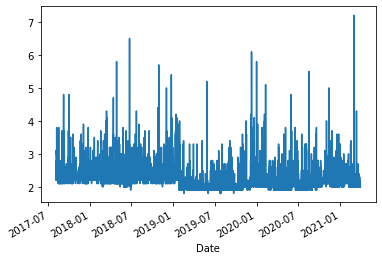

In [ ]:
df1_w[aa].plot()

In [ ]:
df1_w.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
# df1_w.drop(columns = ['Std. Dev. of Wind Direction',
#        'Std. Dev. of Wind Speed'], inplace = True)
# df1_w.drop(columns = ['Incoming Solar Rad. (W/m2)', 'Precip. (mm)'], inplace = True)

In [ ]:
# best_params = {'alpha': 31.556175406841003,
#  'booster': 'gbtree',
#  'eta': 0.29167697154057376,
#  'gamma': 0.18906207376024659,
#  'grow_policy': 'lossguide',
#  'lambda': 25.921910753612906,
#  'max_depth': 5,
#  'score': 15.064180111411144} #number=601, values=[4.755448973684473]]   < 5

# best_params = {'alpha': 18.462027058221132,
#  'booster': 'gbtree',
#  'eta': 0.36669733790910475,
#  'gamma': 1.522615247611338,
#  'grow_policy': 'lossguide',
#  'lambda': 16.740373264015176,
#  'max_depth': 8,
#  'score': 15.477650895351523}  #(number=245, values=[18.568138995465333]

best_params= study2.best_params
score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_THC_OT_Dataset.csv')
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)/len(df1_w))
# df1_w_c = df_xg
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)


0.9574572446944181


In [ ]:
 df1_w

THC (ppm)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00        3.0  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00        3.1  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00        3.0  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00        3.0  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00        2.9  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        2.0  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        2.0  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        2.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        2.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        2.0  46.1     4.6  ...        90  21.245788   5.822751

[30581 rows x 15 columns]

NameError: ignored

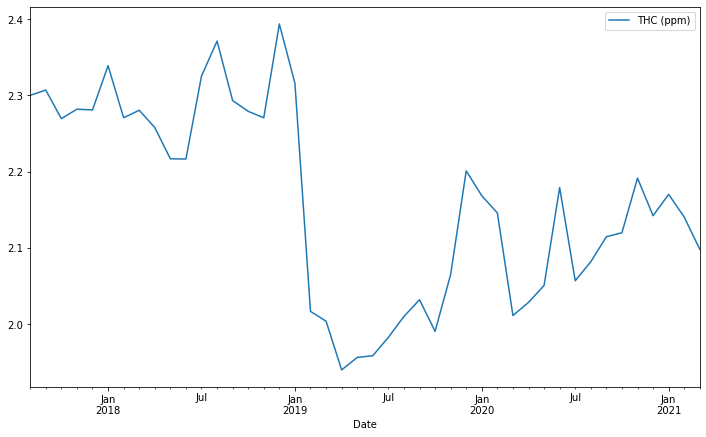

In [ ]:
A = 'M'
df1_w[aa].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c[aa].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

95.74572446944181


[0]	validation_0-rmse:1.50819
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.35983
[2]	validation_0-rmse:1.22631
[3]	validation_0-rmse:1.10647
[4]	validation_0-rmse:0.998695
[5]	validation_0-rmse:0.902131
[6]	validation_0-rmse:0.815359
[7]	validation_0-rmse:0.737667
[8]	validation_0-rmse:0.667936
[9]	validation_0-rmse:0.60565
[10]	validation_0-rmse:0.550289
[11]	validation_0-rmse:0.500798
[12]	validation_0-rmse:0.456648
[13]	validation_0-rmse:0.417624
[14]	validation_0-rmse:0.382878
[15]	validation_0-rmse:0.352168
[16]	validation_0-rmse:0.325215
[17]	validation_0-rmse:0.301578
[18]	validation_0-rmse:0.280775
[19]	validation_0-rmse:0.262806
[20]	validation_0-rmse:0.247369
[21]	validation_0-rmse:0.233962
[22]	validation_0-rmse:0.22233
[23]	validation_0-rmse:0.212435
[24]	validation_0-rmse:0.204097
[25]	validation_0-rmse:0.196983
[26]	validation_0-rmse:0.191162
[27]	validation_0-rmse:0.185952
[28]	validation_0-rmse:0.181732
[29]	validation_0-rmse:

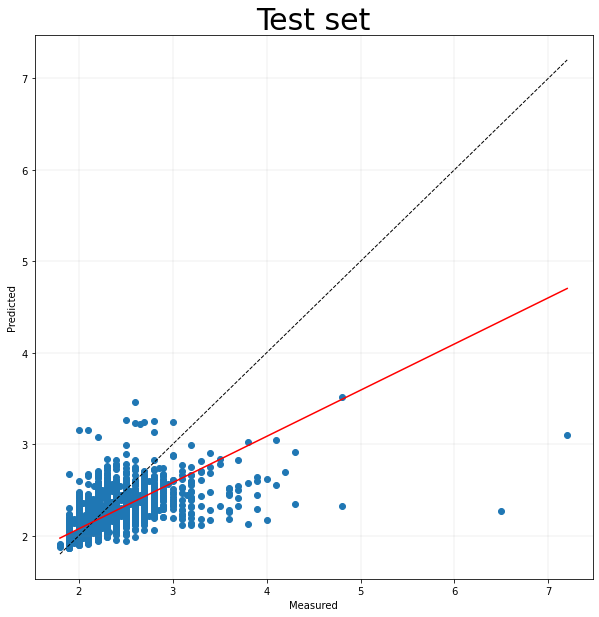

[0.50511053 1.06560597]
RMSE
[0.16728544]
R2
0.5189662980403269


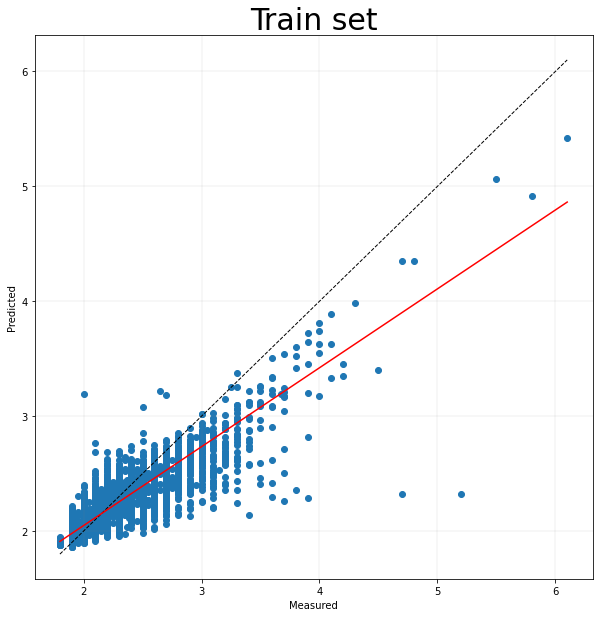

[0.68659136 0.6747775 ]
RMSE
[0.11298071]
R2
0.7615192408470901


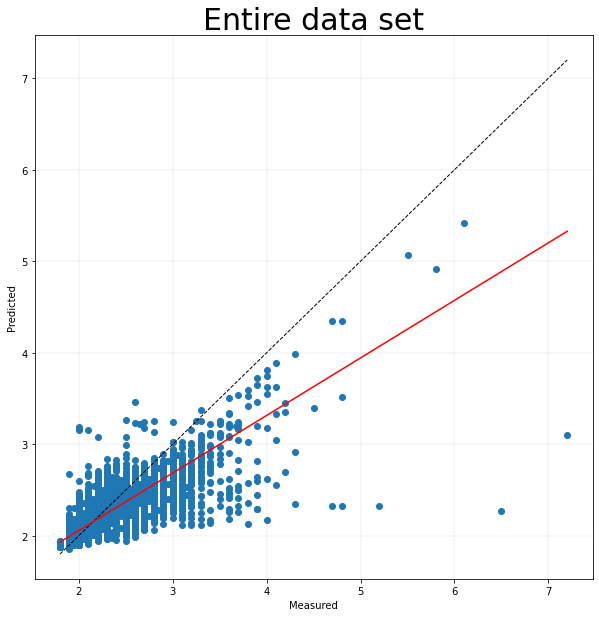

[0.62891983 0.79898935]
RMSE
[0.13164564]
R2
0.6844400836919926


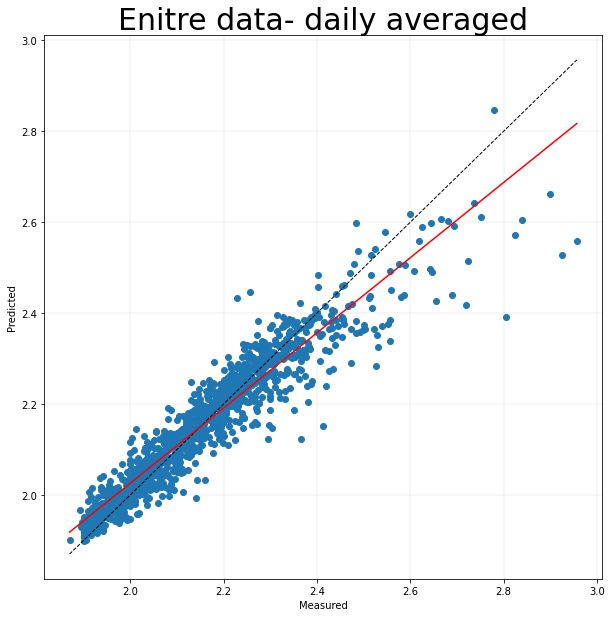

[0.82683215 0.37214343]
RMSE
[0.05522016]
R2
0.893828910647597


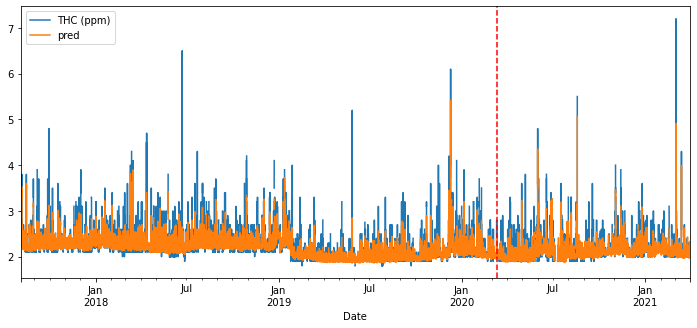

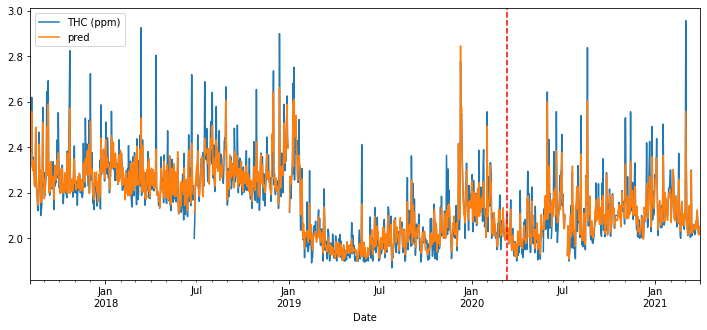

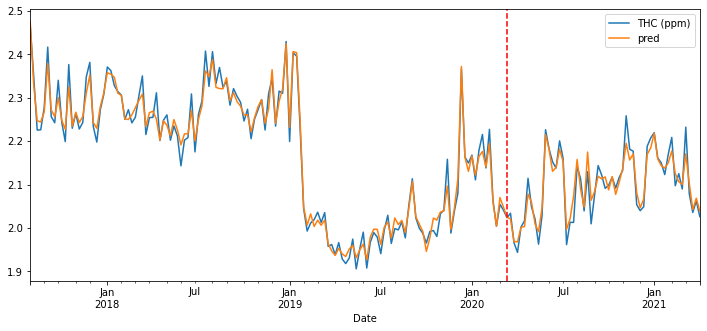

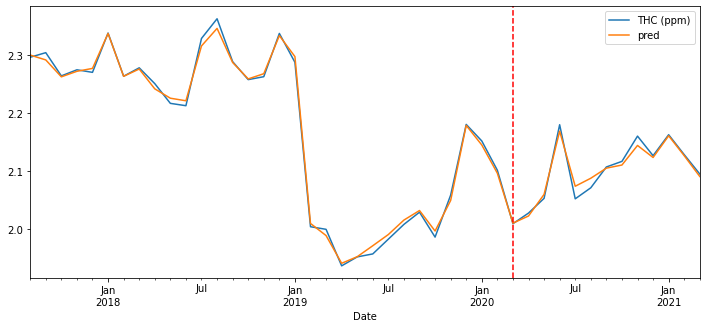

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10[aa]).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_THC_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_THC_OT_XG_Test.csv')


[0.11298071]
0.7615192408470901
[0.16728544]
0.5189662980403269


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
111
2.1660783290863037
2021-01-17 01:00:00
113
2.1660728454589844
2021-01-17 02:00:00
112
2.164578676223755
2021-01-17 03:00:00
112
2.1681015491485596
2021-01-17 04:00:00
108
2.1709861755371094
2021-01-17 05:00:00
111
2.1680972576141357
2021-01-17 06:00:00
109
2.1757848262786865
2021-01-17 07:00:00
109
2.172750234603882
2021-01-17 08:00:00
113
2.1748859882354736
2021-01-17 09:00:00
112
2.1766409873962402
2021-01-17 10:00:00
108
2.1667120456695557
2021-01-17 11:00:00
103
2.1606264114379883
2021-01-17 12:00:00
102
2.155809164047241
2021-01-17 14:00:00
111
2.158320426940918
2021-01-17 15:00:00
112
2.156376600265503
2021-01-17 16:00:00
113
2.1605303287506104
2021-01-17 17:00:00
111
2.1675002574920654
2021-01-17 18:00:00
109
2.160275936126709
2021-01-17 19:00:00
110
2.1574554443359375
2021-01-17 20:00:00
109
2.1642682552337646
2021-01-17 21:00:00
111
2.1672446727752686
2021-01-17 22:00:00
113
2.164926290512085
2021-01-17 23:00:00
113
2.1737

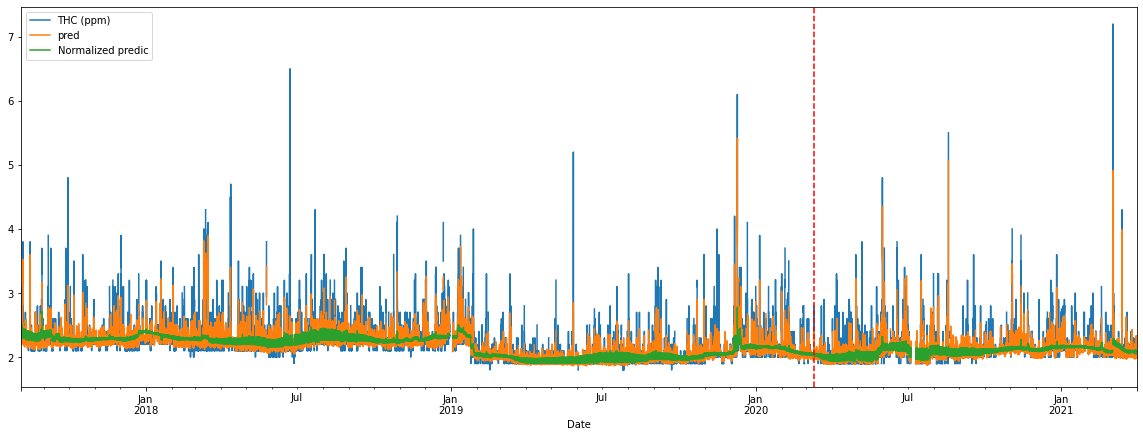

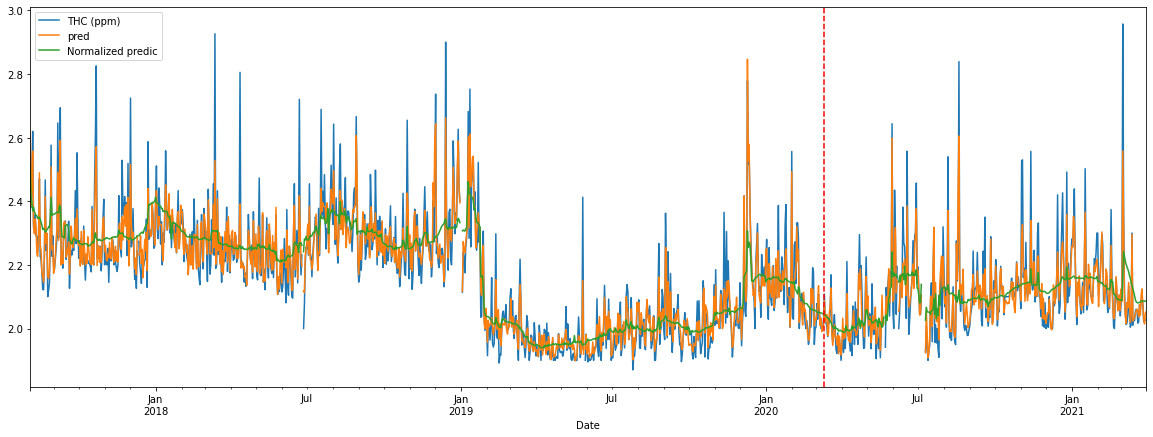

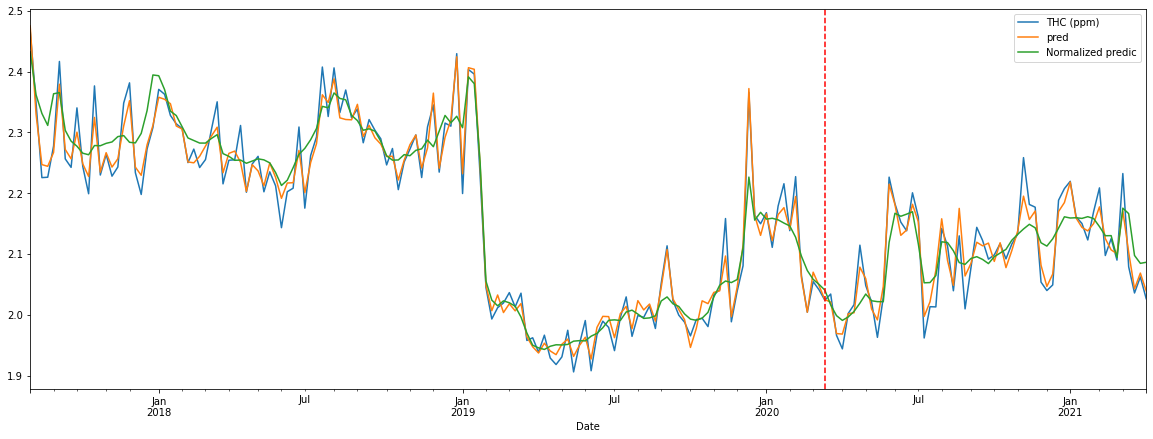

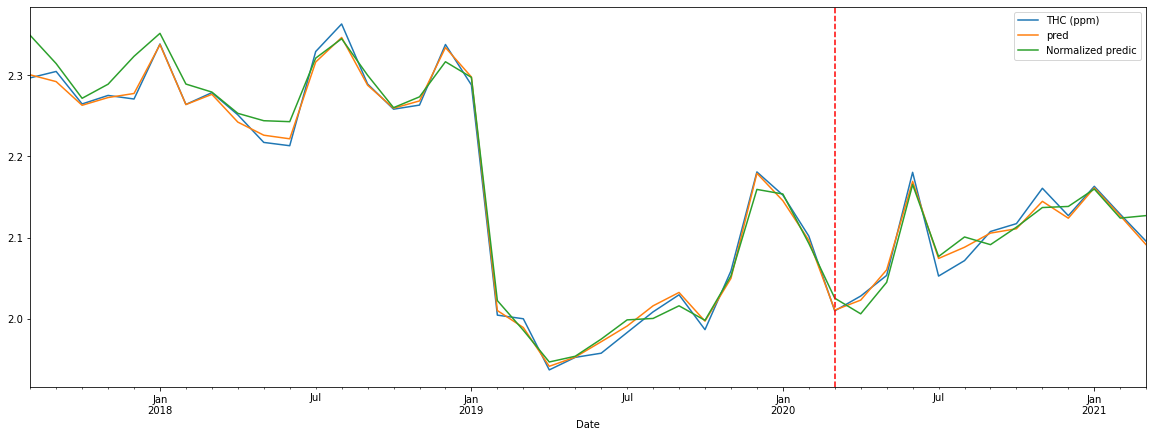

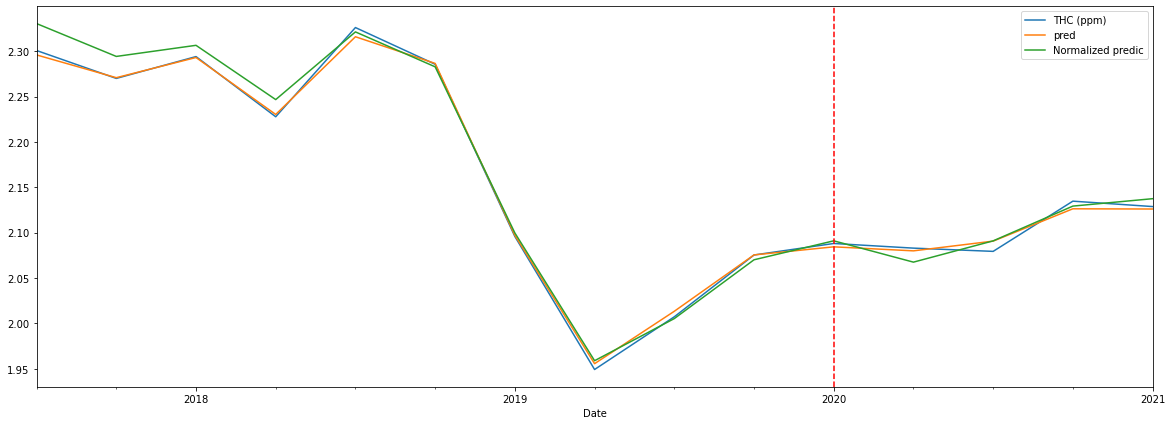

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_THC_OT_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_THC_OT_realRH_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_THC_OT_realRH_SO2_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

6.0169062972920475 4.858306682341838


In [ ]:
aa

'THC (ppm)'

In [ ]:
df1_w

THC (ppm)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00        3.0  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00        3.1  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00        3.0  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00        3.0  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00        2.9  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        2.0  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        2.0  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        2.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        2.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        2.0  46.1     4.6  ...        90  21.245788   5.822751

[30581 rows x 15 columns]

In [ ]:
df1_w

THC (ppm)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00        3.0  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00        3.1  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00        3.0  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00        3.0  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00        2.9  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        2.0  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        2.0  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        2.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        2.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        2.0  46.1     4.6  ...        90  21.245788   5.822751

[30581 rows x 15 columns]

In [ ]:
aa

'THC (ppm)'

In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y_scaler, test_size=0.001, random_state=42)
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)

        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        self.X_train =self.X
        self.y_train =self.Y
        # self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.000000001, random_state = 42)

          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/BuffaloViewpoint__OT___THC" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
study = optuna.create_study(direction=optimizer_direction, study_name='BuffaloViewpoint____THC__NN', storage='sqlite:///BuffaloViewpoint___THC__NN.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_OT_BuffaloViewpoint_THC_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

[I 2021-05-16 19:40:33,353] A new study created in RDB with name: BuffaloViewpoint____THC__NN
[I 2021-05-16 19:41:40,441] Trial 0 finished with value: 0.05590996674674453 and parameters: {'score': 18.102692649820476, 'layers': 2, 'alpha': 0.43632207530159317, 'batchsize': 4600.0, 'num_dense_nodes1': 32, 'delta': 44.04165392696306, 'learning_rate': 0.07739957881312064, 'drop_out1': 0.16299012784810873, 'num_dense_nodes2': 21, 'drop_out2': 0.37204966015682983}. Best is trial 0 with value: 0.05590996674674453.


0.05590996674674453


[I 2021-05-16 19:43:04,419] Trial 1 finished with value: 0.06467927102601496 and parameters: {'score': 24.070159510167596, 'layers': 3, 'alpha': 0.18457462043542494, 'batchsize': 3600.0, 'num_dense_nodes1': 20, 'delta': 39.44601731437138, 'learning_rate': 0.01247453630838009, 'drop_out1': 0.07148517242299214, 'num_dense_nodes2': 38, 'drop_out2': 0.1397903478051164, 'num_dense_nodes3': 18, 'drop_out3': 0.27189276934989}. Best is trial 0 with value: 0.05590996674674453.


0.06467927102601496


[I 2021-05-16 19:44:33,547] Trial 2 finished with value: 0.06372728930314593 and parameters: {'score': 28.638658122376107, 'layers': 2, 'alpha': 0.03829836389897356, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 73.13831056326708, 'learning_rate': 0.08259172647145561, 'drop_out1': 0.28678616404446294, 'num_dense_nodes2': 31, 'drop_out2': 0.19599207959770565}. Best is trial 0 with value: 0.05590996674674453.


0.06372728930314593


[I 2021-05-16 19:46:20,790] Trial 3 finished with value: 0.05460361562075154 and parameters: {'score': 20.278082723895256, 'layers': 2, 'alpha': 0.280006847592963, 'batchsize': 600.0, 'num_dense_nodes1': 21, 'delta': 44.844071151607416, 'learning_rate': 0.06052753186846347, 'drop_out1': 0.29090131114044665, 'num_dense_nodes2': 20, 'drop_out2': 0.4237758943077645}. Best is trial 3 with value: 0.05460361562075154.


0.05460361562075154


[I 2021-05-16 19:47:33,077] Trial 4 finished with value: 0.04960775578016925 and parameters: {'score': 27.537095028838323, 'layers': 2, 'alpha': 0.6391298219531335, 'batchsize': 2600.0, 'num_dense_nodes1': 27, 'delta': 1.6182720202159682, 'learning_rate': 0.016098620456074672, 'drop_out1': 0.13875598744166268, 'num_dense_nodes2': 28, 'drop_out2': 0.14327911848626543}. Best is trial 4 with value: 0.04960775578016925.


0.04960775578016925


[I 2021-05-16 19:49:03,206] Trial 5 finished with value: 0.052743312312702184 and parameters: {'score': 27.210909222821, 'layers': 2, 'alpha': 0.8344450859318333, 'batchsize': 1100.0, 'num_dense_nodes1': 20, 'delta': 18.81715051378038, 'learning_rate': 0.011367901079584405, 'drop_out1': 0.0854484330160591, 'num_dense_nodes2': 31, 'drop_out2': 0.2526140114025546}. Best is trial 4 with value: 0.04960775578016925.


0.052743312312702184


[I 2021-05-16 19:50:21,975] Trial 6 finished with value: 0.05755686206352014 and parameters: {'score': 29.381677662977044, 'layers': 2, 'alpha': 0.2458731385090394, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 11.721166059378932, 'learning_rate': 0.05470162912533869, 'drop_out1': 0.1567654959474094, 'num_dense_nodes2': 27, 'drop_out2': 0.3386185630062654}. Best is trial 4 with value: 0.04960775578016925.


0.05755686206352014


[I 2021-05-16 19:51:25,732] Trial 7 finished with value: 0.06262934503717615 and parameters: {'score': 15.80923289853943, 'layers': 2, 'alpha': 0.4283200239345503, 'batchsize': 4100.0, 'num_dense_nodes1': 31, 'delta': 56.05360081505371, 'learning_rate': 0.07991607254950468, 'drop_out1': 0.19861194395641835, 'num_dense_nodes2': 32, 'drop_out2': 0.06951355595720966}. Best is trial 4 with value: 0.04960775578016925.


0.06262934503717615


[I 2021-05-16 19:52:43,351] Trial 8 finished with value: 0.047321659440622686 and parameters: {'score': 18.51011265722314, 'layers': 3, 'alpha': 0.06925796129090388, 'batchsize': 4600.0, 'num_dense_nodes1': 35, 'delta': 61.210035657409534, 'learning_rate': 0.009164472105381825, 'drop_out1': 0.2385491197218278, 'num_dense_nodes2': 32, 'drop_out2': 0.373270771841607, 'num_dense_nodes3': 20, 'drop_out3': 0.3107406875423529}. Best is trial 8 with value: 0.047321659440622686.


0.047321659440622686


[I 2021-05-16 19:53:54,124] Trial 9 finished with value: 0.05981787915385843 and parameters: {'score': 19.641299724394607, 'layers': 2, 'alpha': 0.8026229734412939, 'batchsize': 4600.0, 'num_dense_nodes1': 28, 'delta': 51.2483801404116, 'learning_rate': 0.04208784288583196, 'drop_out1': 0.17031338619795455, 'num_dense_nodes2': 37, 'drop_out2': 0.34183752380554105}. Best is trial 8 with value: 0.047321659440622686.


0.05981787915385843


[I 2021-05-16 19:55:01,613] Trial 10 finished with value: 0.0411365241147707 and parameters: {'score': 16.23185161762394, 'layers': 3, 'alpha': 0.06832320287596519, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 98.19007529160399, 'learning_rate': 0.03546448394166034, 'drop_out1': 0.2323985079106273, 'num_dense_nodes2': 25, 'drop_out2': 0.47695480129454576, 'num_dense_nodes3': 38, 'drop_out3': 0.47073907823248745}. Best is trial 10 with value: 0.0411365241147707.


0.0411365241147707


[I 2021-05-16 19:56:11,708] Trial 11 finished with value: 0.050204151042131315 and parameters: {'score': 16.102597180831822, 'layers': 3, 'alpha': 0.05527335192176838, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 92.01872025371546, 'learning_rate': 0.032094815329045054, 'drop_out1': 0.23567477678634638, 'num_dense_nodes2': 26, 'drop_out2': 0.4998647196977508, 'num_dense_nodes3': 40, 'drop_out3': 0.49940168072900304}. Best is trial 10 with value: 0.0411365241147707.


0.050204151042131315


[I 2021-05-16 19:57:27,694] Trial 12 finished with value: 0.06697704622281714 and parameters: {'score': 17.956792251133702, 'layers': 3, 'alpha': 0.024839955803158863, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 98.61412078050266, 'learning_rate': 0.030090200165392468, 'drop_out1': 0.23743699731931034, 'num_dense_nodes2': 23, 'drop_out2': 0.49815950562376987, 'num_dense_nodes3': 31, 'drop_out3': 0.49663445798423955}. Best is trial 10 with value: 0.0411365241147707.


0.06697704622281714


[I 2021-05-16 19:58:52,494] Trial 13 finished with value: 0.05331852794820346 and parameters: {'score': 22.644020233418367, 'layers': 3, 'alpha': 0.13645309577713122, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 79.07448735116117, 'learning_rate': 0.0049699469165567734, 'drop_out1': 0.2445742407961283, 'num_dense_nodes2': 36, 'drop_out2': 0.44172750611571404, 'num_dense_nodes3': 5, 'drop_out3': 0.05915507955400534}. Best is trial 10 with value: 0.0411365241147707.


0.05331852794820346


[I 2021-05-16 20:00:05,152] Trial 14 finished with value: 0.045791765427984465 and parameters: {'score': 16.13767689172542, 'layers': 3, 'alpha': 0.3269675641686507, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 71.68292971683766, 'learning_rate': 0.02798271215299133, 'drop_out1': 0.21269458132597469, 'num_dense_nodes2': 34, 'drop_out2': 0.4225783497888394, 'num_dense_nodes3': 18, 'drop_out3': 0.32440868368088527}. Best is trial 10 with value: 0.0411365241147707.


0.045791765427984465


[I 2021-05-16 20:01:19,767] Trial 15 finished with value: 0.040171628999448844 and parameters: {'score': 15.817249152400052, 'layers': 3, 'alpha': 0.33673532428948383, 'batchsize': 2600.0, 'num_dense_nodes1': 24, 'delta': 87.22854900364496, 'learning_rate': 0.02828279969859524, 'drop_out1': 0.21407840369388884, 'num_dense_nodes2': 35, 'drop_out2': 0.4520907629818898, 'num_dense_nodes3': 11, 'drop_out3': 0.34681703627297444}. Best is trial 15 with value: 0.040171628999448844.


0.040171628999448844


[I 2021-05-16 20:02:29,310] Trial 16 finished with value: 0.048509292347763806 and parameters: {'score': 21.98022526385258, 'layers': 3, 'alpha': 0.6288561017910761, 'batchsize': 3100.0, 'num_dense_nodes1': 24, 'delta': 89.10916188802565, 'learning_rate': 0.04205006214946613, 'drop_out1': 0.26917835145808255, 'num_dense_nodes2': 24, 'drop_out2': 0.4728896296189907, 'num_dense_nodes3': 6, 'drop_out3': 0.40990117505254403}. Best is trial 15 with value: 0.040171628999448844.


0.048509292347763806


[I 2021-05-16 20:03:48,498] Trial 17 finished with value: 0.058307836644165265 and parameters: {'score': 24.77028149477066, 'layers': 3, 'alpha': 0.6109396958099147, 'batchsize': 2100.0, 'num_dense_nodes1': 24, 'delta': 99.06474126850924, 'learning_rate': 0.06296215662719401, 'drop_out1': 0.2002770042315947, 'num_dense_nodes2': 40, 'drop_out2': 0.25883670263439945, 'num_dense_nodes3': 37, 'drop_out3': 0.4055650794193978}. Best is trial 15 with value: 0.040171628999448844.


0.058307836644165265


[I 2021-05-16 20:05:06,356] Trial 18 finished with value: 0.04979001824688655 and parameters: {'score': 16.99642253256639, 'layers': 3, 'alpha': 0.5286396602720203, 'batchsize': 3100.0, 'num_dense_nodes1': 24, 'delta': 84.20315777657106, 'learning_rate': 0.022225997246613054, 'drop_out1': 0.12243359093346462, 'num_dense_nodes2': 29, 'drop_out2': 0.46936405804839937, 'num_dense_nodes3': 12, 'drop_out3': 0.1897455516399904}. Best is trial 15 with value: 0.040171628999448844.


0.04979001824688655


[I 2021-05-16 20:11:45,207] Trial 19 finished with value: 0.05179821688311599 and parameters: {'score': 18.961808399418118, 'layers': 3, 'alpha': 0.34657207725695127, 'batchsize': 100.0, 'num_dense_nodes1': 27, 'delta': 67.35796485801227, 'learning_rate': 0.041825038066294645, 'drop_out1': 0.2655216246481825, 'num_dense_nodes2': 35, 'drop_out2': 0.3140487542205166, 'num_dense_nodes3': 29, 'drop_out3': 0.41817418218617974}. Best is trial 15 with value: 0.040171628999448844.


0.05179821688311599


[I 2021-05-16 20:13:05,669] Trial 20 finished with value: 0.05349535781120283 and parameters: {'score': 21.194789342395858, 'layers': 3, 'alpha': 0.16672735932675448, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 98.22818440004762, 'learning_rate': 0.09899594325387719, 'drop_out1': 0.21165432448047028, 'num_dense_nodes2': 25, 'drop_out2': 0.3998260682730973, 'num_dense_nodes3': 12, 'drop_out3': 0.21290732579857763}. Best is trial 15 with value: 0.040171628999448844.


0.05349535781120283


[I 2021-05-16 20:14:20,175] Trial 21 finished with value: 0.04767283738696736 and parameters: {'score': 15.770857728550979, 'layers': 3, 'alpha': 0.3769200366364865, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 73.7477868007214, 'learning_rate': 0.028203168675083237, 'drop_out1': 0.209415524253787, 'num_dense_nodes2': 34, 'drop_out2': 0.43795563351261263, 'num_dense_nodes3': 14, 'drop_out3': 0.3415748077421638}. Best is trial 15 with value: 0.040171628999448844.


0.04767283738696736


[I 2021-05-16 20:15:32,730] Trial 22 finished with value: 0.04383590991896104 and parameters: {'score': 16.771128064979962, 'layers': 3, 'alpha': 0.29120035992233356, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 86.45739481524166, 'learning_rate': 0.03627153282869762, 'drop_out1': 0.18602671039703242, 'num_dense_nodes2': 34, 'drop_out2': 0.4957806187188499, 'num_dense_nodes3': 25, 'drop_out3': 0.35639876448294405}. Best is trial 15 with value: 0.040171628999448844.


0.04383590991896104


[I 2021-05-16 20:16:51,853] Trial 23 finished with value: 0.06029839741901388 and parameters: {'score': 17.262673020174876, 'layers': 3, 'alpha': 0.2510658930045446, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 86.12713323433668, 'learning_rate': 0.03788942757229076, 'drop_out1': 0.18961878462073123, 'num_dense_nodes2': 33, 'drop_out2': 0.49292377640895974, 'num_dense_nodes3': 27, 'drop_out3': 0.45066543423788186}. Best is trial 15 with value: 0.040171628999448844.


0.06029839741901388


[I 2021-05-16 20:18:09,341] Trial 24 finished with value: 0.04443188127639295 and parameters: {'score': 16.920560102732644, 'layers': 3, 'alpha': 0.4729673046203793, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 93.55810412455573, 'learning_rate': 0.05000441892314087, 'drop_out1': 0.17993450232835045, 'num_dense_nodes2': 39, 'drop_out2': 0.45952066736860037, 'num_dense_nodes3': 35, 'drop_out3': 0.37455834938094973}. Best is trial 15 with value: 0.040171628999448844.


0.04443188127639295


[I 2021-05-16 20:19:19,840] Trial 25 finished with value: 0.045662505899491106 and parameters: {'score': 15.812076302214745, 'layers': 3, 'alpha': 0.12129291108669121, 'batchsize': 3100.0, 'num_dense_nodes1': 22, 'delta': 32.26171363758269, 'learning_rate': 0.020787581968083606, 'drop_out1': 0.2598904275874885, 'num_dense_nodes2': 36, 'drop_out2': 0.40897394927930925, 'num_dense_nodes3': 27, 'drop_out3': 0.2484732070070483}. Best is trial 15 with value: 0.040171628999448844.


0.045662505899491106


[I 2021-05-16 20:20:32,255] Trial 26 finished with value: 0.04960340388670999 and parameters: {'score': 20.289851246782312, 'layers': 3, 'alpha': 0.23367998602107554, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'delta': 79.68641614503377, 'learning_rate': 0.04945201745993007, 'drop_out1': 0.22098876911727655, 'num_dense_nodes2': 30, 'drop_out2': 0.49059790721339036, 'num_dense_nodes3': 23, 'drop_out3': 0.46533504219272287}. Best is trial 15 with value: 0.040171628999448844.


0.04960340388670999


[I 2021-05-16 20:21:49,078] Trial 27 finished with value: 0.050248923453321985 and parameters: {'score': 16.962692124304297, 'layers': 3, 'alpha': 0.5274486306197006, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 64.9824092619475, 'learning_rate': 0.03496089207827909, 'drop_out1': 0.137349099443412, 'num_dense_nodes2': 29, 'drop_out2': 0.3810715061268632, 'num_dense_nodes3': 9, 'drop_out3': 0.36069734894476646}. Best is trial 15 with value: 0.040171628999448844.


0.050248923453321985


[I 2021-05-16 20:23:12,592] Trial 28 finished with value: 0.05388714575351526 and parameters: {'score': 19.0140779127163, 'layers': 3, 'alpha': 0.38584242737415697, 'batchsize': 1600.0, 'num_dense_nodes1': 26, 'delta': 99.64093546641116, 'learning_rate': 0.022124565968364762, 'drop_out1': 0.18670463070032575, 'num_dense_nodes2': 34, 'drop_out2': 0.4499733529392931, 'num_dense_nodes3': 33, 'drop_out3': 0.11647252771103458}. Best is trial 15 with value: 0.040171628999448844.


0.05388714575351526


[I 2021-05-16 20:24:42,292] Trial 29 finished with value: 0.049986716020136476 and parameters: {'score': 17.899127301904613, 'layers': 3, 'alpha': 0.31369112217593104, 'batchsize': 3600.0, 'num_dense_nodes1': 30, 'delta': 80.18552058838611, 'learning_rate': 0.0012791605026221536, 'drop_out1': 0.15458904143427266, 'num_dense_nodes2': 21, 'drop_out2': 0.28231186157410915, 'num_dense_nodes3': 40, 'drop_out3': 0.29685994088165746}. Best is trial 15 with value: 0.040171628999448844.


0.049986716020136476


[I 2021-05-16 20:25:57,629] Trial 30 finished with value: 0.04899399724066379 and parameters: {'score': 17.842781695473942, 'layers': 3, 'alpha': 0.19595331236906643, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 91.33895324479393, 'learning_rate': 0.06552072986931744, 'drop_out1': 0.22453467184826023, 'num_dense_nodes2': 23, 'drop_out2': 0.34058396391187895, 'num_dense_nodes3': 23, 'drop_out3': 0.37685798622362876}. Best is trial 15 with value: 0.040171628999448844.


0.04899399724066379


[I 2021-05-16 20:27:13,647] Trial 31 finished with value: 0.045534185972743946 and parameters: {'score': 16.530103858935213, 'layers': 3, 'alpha': 0.4892181883237784, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 92.54529426311528, 'learning_rate': 0.049520297016464106, 'drop_out1': 0.17710087014956044, 'num_dense_nodes2': 40, 'drop_out2': 0.45854320951915184, 'num_dense_nodes3': 36, 'drop_out3': 0.3826817085553353}. Best is trial 15 with value: 0.040171628999448844.


0.045534185972743946


[I 2021-05-16 20:28:30,713] Trial 32 finished with value: 0.05022407408165807 and parameters: {'score': 17.26558930523927, 'layers': 3, 'alpha': 0.4343014886998454, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 95.39772430269785, 'learning_rate': 0.05386400756003691, 'drop_out1': 0.18520526241905966, 'num_dense_nodes2': 38, 'drop_out2': 0.4737426142484178, 'num_dense_nodes3': 36, 'drop_out3': 0.45319243732562775}. Best is trial 15 with value: 0.040171628999448844.


0.05022407408165807


[I 2021-05-16 20:29:45,028] Trial 33 finished with value: 0.056640865878154825 and parameters: {'score': 24.99202401425871, 'layers': 3, 'alpha': 0.5567548236348762, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 84.16122115900252, 'learning_rate': 0.04612015139239303, 'drop_out1': 0.10921448134417203, 'num_dense_nodes2': 39, 'drop_out2': 0.49984857307858965, 'num_dense_nodes3': 33, 'drop_out3': 0.34539016577977055}. Best is trial 15 with value: 0.040171628999448844.


0.056640865878154825


[I 2021-05-16 20:30:55,869] Trial 34 finished with value: 0.04767536239602628 and parameters: {'score': 19.775614733208716, 'layers': 3, 'alpha': 0.7305788951227756, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 76.32859364995714, 'learning_rate': 0.06931739195759527, 'drop_out1': 0.1649555022638237, 'num_dense_nodes2': 37, 'drop_out2': 0.408239626391889, 'num_dense_nodes3': 40, 'drop_out3': 0.2830938412638749}. Best is trial 15 with value: 0.040171628999448844.


0.04767536239602628


[I 2021-05-16 20:32:18,720] Trial 35 finished with value: 0.054311966781587895 and parameters: {'score': 15.750598446497625, 'layers': 3, 'alpha': 0.4008431360235054, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 89.9782524365307, 'learning_rate': 0.03737370185330869, 'drop_out1': 0.25413631665542397, 'num_dense_nodes2': 38, 'drop_out2': 0.4414412250930588, 'num_dense_nodes3': 37, 'drop_out3': 0.4286523931143649}. Best is trial 15 with value: 0.040171628999448844.


0.054311966781587895


[I 2021-05-16 20:33:45,862] Trial 36 finished with value: 0.053166414904401556 and parameters: {'score': 16.8396848318836, 'layers': 3, 'alpha': 0.4682760658705592, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 84.38755242665808, 'learning_rate': 0.018384909017346216, 'drop_out1': 0.280958814780973, 'num_dense_nodes2': 36, 'drop_out2': 0.39199625151065065, 'num_dense_nodes3': 26, 'drop_out3': 0.37642756658875975}. Best is trial 15 with value: 0.040171628999448844.


0.053166414904401556


[I 2021-05-16 20:34:57,057] Trial 37 finished with value: 0.050276109451414426 and parameters: {'score': 18.66119937810842, 'layers': 3, 'alpha': 0.31732794151657556, 'batchsize': 2600.0, 'num_dense_nodes1': 22, 'delta': 99.4397085424985, 'learning_rate': 0.02562826079801472, 'drop_out1': 0.14786743082355658, 'num_dense_nodes2': 31, 'drop_out2': 0.19296652969671785, 'num_dense_nodes3': 32, 'drop_out3': 0.2459373279917812}. Best is trial 15 with value: 0.040171628999448844.


0.050276109451414426


[I 2021-05-16 20:36:12,705] Trial 38 finished with value: 0.06128411335940872 and parameters: {'score': 17.726057192656537, 'layers': 3, 'alpha': 0.26854765656720403, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 37.29080779659484, 'learning_rate': 0.056997519789318246, 'drop_out1': 0.17324973243938416, 'num_dense_nodes2': 33, 'drop_out2': 0.053712584737829916, 'num_dense_nodes3': 15, 'drop_out3': 0.32848700658764596}. Best is trial 15 with value: 0.040171628999448844.


0.06128411335940872


[I 2021-05-16 20:37:19,718] Trial 39 finished with value: 0.04657014013212063 and parameters: {'score': 16.613077875960943, 'layers': 3, 'alpha': 0.08965243735137396, 'batchsize': 3600.0, 'num_dense_nodes1': 33, 'delta': 69.51960324718604, 'learning_rate': 0.045782007162544186, 'drop_out1': 0.19995794714050766, 'num_dense_nodes2': 20, 'drop_out2': 0.4761291104631269, 'num_dense_nodes3': 20, 'drop_out3': 0.261439684793902}. Best is trial 15 with value: 0.040171628999448844.


0.04657014013212063


[I 2021-05-16 20:38:29,131] Trial 40 finished with value: 0.04796150126974337 and parameters: {'score': 20.90609559090306, 'layers': 2, 'alpha': 0.7167496463171377, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 93.70624543441566, 'learning_rate': 0.07504472218753888, 'drop_out1': 0.19288953383641808, 'num_dense_nodes2': 35, 'drop_out2': 0.4142517542496677}. Best is trial 15 with value: 0.040171628999448844.


0.04796150126974337


[I 2021-05-16 20:39:48,825] Trial 41 finished with value: 0.05377536274100078 and parameters: {'score': 16.555240936042, 'layers': 3, 'alpha': 0.4616004350848197, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 94.55046170539617, 'learning_rate': 0.050122311500421624, 'drop_out1': 0.2212131686014162, 'num_dense_nodes2': 40, 'drop_out2': 0.46732564023847006, 'num_dense_nodes3': 36, 'drop_out3': 0.3869719701916636}. Best is trial 15 with value: 0.040171628999448844.


0.05377536274100078


[I 2021-05-16 20:41:14,476] Trial 42 finished with value: 0.049884335101414504 and parameters: {'score': 16.469434391022958, 'layers': 3, 'alpha': 0.48683303667428707, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 88.83874050412247, 'learning_rate': 0.03399828177495906, 'drop_out1': 0.1709931899753949, 'num_dense_nodes2': 39, 'drop_out2': 0.46392073563988206, 'num_dense_nodes3': 34, 'drop_out3': 0.35932564926112925}. Best is trial 15 with value: 0.040171628999448844.


0.049884335101414504


[I 2021-05-16 20:42:30,854] Trial 43 finished with value: 0.05153784220942648 and parameters: {'score': 18.304091681158088, 'layers': 3, 'alpha': 0.5766230197937642, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 82.18048703069027, 'learning_rate': 0.05685424090900274, 'drop_out1': 0.1799213772162429, 'num_dense_nodes2': 39, 'drop_out2': 0.4481401073521807, 'num_dense_nodes3': 38, 'drop_out3': 0.30988926191793303}. Best is trial 15 with value: 0.040171628999448844.


0.05153784220942648


[I 2021-05-16 20:43:49,915] Trial 44 finished with value: 0.04607202208745024 and parameters: {'score': 17.53277334909955, 'layers': 3, 'alpha': 0.4899523038903413, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 94.54711997885846, 'learning_rate': 0.03860704830530058, 'drop_out1': 0.22970992302030305, 'num_dense_nodes2': 27, 'drop_out2': 0.36529131676095644, 'num_dense_nodes3': 29, 'drop_out3': 0.47900138838252193}. Best is trial 15 with value: 0.040171628999448844.


0.04607202208745024


[I 2021-05-16 20:45:23,503] Trial 45 finished with value: 0.062159592458271316 and parameters: {'score': 19.331891105729216, 'layers': 3, 'alpha': 0.4158863722415495, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 59.894917806865905, 'learning_rate': 0.04625327538148685, 'drop_out1': 0.14089786355004924, 'num_dense_nodes2': 37, 'drop_out2': 0.4295193449587147, 'num_dense_nodes3': 35, 'drop_out3': 0.3922908747370945}. Best is trial 15 with value: 0.040171628999448844.


0.062159592458271316


[I 2021-05-16 20:46:47,983] Trial 46 finished with value: 0.042691164066657156 and parameters: {'score': 15.738881480372207, 'layers': 3, 'alpha': 0.20667815359855268, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 87.47740542695279, 'learning_rate': 0.05272386831278372, 'drop_out1': 0.24577098833533573, 'num_dense_nodes2': 40, 'drop_out2': 0.49437886549952154, 'num_dense_nodes3': 40, 'drop_out3': 0.4371368801639985}. Best is trial 15 with value: 0.040171628999448844.


0.042691164066657156


[I 2021-05-16 20:48:03,492] Trial 47 finished with value: 0.04656819499872981 and parameters: {'score': 26.83374718286065, 'layers': 3, 'alpha': 0.19579629341371796, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 75.55633907577264, 'learning_rate': 0.03330379436532747, 'drop_out1': 0.24713588533171463, 'num_dense_nodes2': 32, 'drop_out2': 0.4956438086822677, 'num_dense_nodes3': 39, 'drop_out3': 0.4286101959992659}. Best is trial 15 with value: 0.040171628999448844.


0.04656819499872981


[I 2021-05-16 20:49:30,268] Trial 48 finished with value: 0.038643741508831556 and parameters: {'score': 15.874440782364614, 'layers': 2, 'alpha': 0.014660141283083628, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 87.1702556474432, 'learning_rate': 0.015824456436329556, 'drop_out1': 0.28868639675050095, 'num_dense_nodes2': 38, 'drop_out2': 0.10002348545260395}. Best is trial 48 with value: 0.038643741508831556.


0.038643741508831556


[I 2021-05-16 20:51:01,742] Trial 49 finished with value: 0.07776887156814423 and parameters: {'score': 30.277070130166777, 'layers': 2, 'alpha': 0.014010710118550582, 'batchsize': 2600.0, 'num_dense_nodes1': 20, 'delta': 87.56637279971065, 'learning_rate': 0.010602323637498367, 'drop_out1': 0.29755812588902547, 'num_dense_nodes2': 35, 'drop_out2': 0.11312532258234177}. Best is trial 48 with value: 0.038643741508831556.


0.07776887156814423


[I 2021-05-16 20:52:29,860] Trial 50 finished with value: 0.06224076105339548 and parameters: {'score': 15.993974023007471, 'layers': 2, 'alpha': 0.09377019211104255, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 78.16651014646649, 'learning_rate': 0.015238995987734033, 'drop_out1': 0.2753779743821015, 'num_dense_nodes2': 37, 'drop_out2': 0.2198123255065955}. Best is trial 48 with value: 0.038643741508831556.


0.06224076105339548


[I 2021-05-16 20:53:52,496] Trial 51 finished with value: 0.05226821330967457 and parameters: {'score': 15.791328029974839, 'layers': 2, 'alpha': 0.1558155301514173, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 86.79473205757017, 'learning_rate': 0.025184723905493075, 'drop_out1': 0.2921222916000338, 'num_dense_nodes2': 39, 'drop_out2': 0.4863076024525004}. Best is trial 48 with value: 0.038643741508831556.


0.05226821330967457


[I 2021-05-16 20:55:23,503] Trial 52 finished with value: 0.04598461568902536 and parameters: {'score': 16.40536081044191, 'layers': 2, 'alpha': 0.3545544561580126, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 96.52575878433754, 'learning_rate': 0.015596320676392078, 'drop_out1': 0.210210426534529, 'num_dense_nodes2': 38, 'drop_out2': 0.10225986477790378}. Best is trial 48 with value: 0.038643741508831556.


0.04598461568902536


[I 2021-05-16 20:56:39,308] Trial 53 finished with value: 0.03337834414994172 and parameters: {'score': 17.27448462676551, 'layers': 3, 'alpha': 0.04337666463818335, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 82.11202182196068, 'learning_rate': 0.041781123064289674, 'drop_out1': 0.24834030737411167, 'num_dense_nodes2': 40, 'drop_out2': 0.18636049264986615, 'num_dense_nodes3': 21, 'drop_out3': 0.4994456486195877}. Best is trial 53 with value: 0.03337834414994172.


0.03337834414994172


[I 2021-05-16 20:57:57,639] Trial 54 finished with value: 0.03434030346841661 and parameters: {'score': 18.32276307924014, 'layers': 3, 'alpha': 0.051753479331548224, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 72.00725347038194, 'learning_rate': 0.030212644001703433, 'drop_out1': 0.25029659128609577, 'num_dense_nodes2': 40, 'drop_out2': 0.17720064276634345, 'num_dense_nodes3': 21, 'drop_out3': 0.49613275214019176}. Best is trial 53 with value: 0.03337834414994172.


0.03434030346841661


[I 2021-05-16 20:59:13,378] Trial 55 finished with value: 0.04440175219823357 and parameters: {'score': 18.307486013614792, 'layers': 2, 'alpha': 0.045815169454333844, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 65.37261292655025, 'learning_rate': 0.028534165802824227, 'drop_out1': 0.2504788623815765, 'num_dense_nodes2': 40, 'drop_out2': 0.162598850425967}. Best is trial 53 with value: 0.03337834414994172.


0.04440175219823357


[I 2021-05-16 21:00:36,634] Trial 56 finished with value: 0.04152203660061757 and parameters: {'score': 17.43007249618729, 'layers': 3, 'alpha': 0.01108812574629927, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 49.79500747241625, 'learning_rate': 0.031357492003578874, 'drop_out1': 0.24066703220255065, 'num_dense_nodes2': 38, 'drop_out2': 0.1609978710550255, 'num_dense_nodes3': 18, 'drop_out3': 0.4972895514593873}. Best is trial 53 with value: 0.03337834414994172.


0.04152203660061757


[I 2021-05-16 21:02:05,057] Trial 57 finished with value: 0.04751709261653304 and parameters: {'score': 17.418088988064305, 'layers': 3, 'alpha': 0.021132231442709513, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 47.42467232495574, 'learning_rate': 0.006102382771717353, 'drop_out1': 0.2354492198663354, 'num_dense_nodes2': 38, 'drop_out2': 0.16024438357499704, 'num_dense_nodes3': 20, 'drop_out3': 0.4986026910937758}. Best is trial 53 with value: 0.03337834414994172.


0.04751709261653304


[I 2021-05-16 21:03:31,549] Trial 58 finished with value: 0.05524356959270168 and parameters: {'score': 18.55880108555005, 'layers': 3, 'alpha': 0.11227946843906439, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 50.774808438641614, 'learning_rate': 0.030184984055137268, 'drop_out1': 0.26560246345462546, 'num_dense_nodes2': 22, 'drop_out2': 0.2168533532975736, 'num_dense_nodes3': 18, 'drop_out3': 0.4824251597142494}. Best is trial 53 with value: 0.03337834414994172.


0.05524356959270168


[I 2021-05-16 21:04:46,550] Trial 59 finished with value: 0.04402247743437871 and parameters: {'score': 19.825940502415644, 'layers': 3, 'alpha': 0.05337375176909856, 'batchsize': 2600.0, 'num_dense_nodes1': 28, 'delta': 54.6719288868926, 'learning_rate': 0.041078985198159376, 'drop_out1': 0.25873936509356565, 'num_dense_nodes2': 25, 'drop_out2': 0.12281929755974003, 'num_dense_nodes3': 16, 'drop_out3': 0.4947431875839219}. Best is trial 53 with value: 0.03337834414994172.


0.04402247743437871


[I 2021-05-16 21:06:02,161] Trial 60 finished with value: 0.03439020620539078 and parameters: {'score': 16.18468871810664, 'layers': 2, 'alpha': 0.0765514223694519, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 28.888698635313393, 'learning_rate': 0.02466089255810789, 'drop_out1': 0.2829572929391048, 'num_dense_nodes2': 36, 'drop_out2': 0.08615343057296578}. Best is trial 53 with value: 0.03337834414994172.


0.03439020620539078


[I 2021-05-16 21:07:16,301] Trial 61 finished with value: 0.03363646490423716 and parameters: {'score': 16.234302054045173, 'layers': 2, 'alpha': 0.06831140949083538, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 15.955187000560798, 'learning_rate': 0.024775254125402157, 'drop_out1': 0.28509609324293433, 'num_dense_nodes2': 37, 'drop_out2': 0.0845143471769376}. Best is trial 53 with value: 0.03337834414994172.


0.03363646490423716


[I 2021-05-16 21:08:37,471] Trial 62 finished with value: 0.04625563636846168 and parameters: {'score': 16.217504513070374, 'layers': 2, 'alpha': 0.08002744094385841, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 13.891791094027136, 'learning_rate': 0.01915988284918601, 'drop_out1': 0.2815691447857076, 'num_dense_nodes2': 36, 'drop_out2': 0.0848159188936097}. Best is trial 53 with value: 0.03337834414994172.


0.04625563636846168


[I 2021-05-16 21:10:02,208] Trial 63 finished with value: 0.049793687400153094 and parameters: {'score': 23.6763355070848, 'layers': 2, 'alpha': 0.14307886612686654, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 26.144710030143994, 'learning_rate': 0.024013114027403953, 'drop_out1': 0.2990402800082728, 'num_dense_nodes2': 37, 'drop_out2': 0.06980023641990328}. Best is trial 53 with value: 0.03337834414994172.


0.049793687400153094


[I 2021-05-16 21:11:31,995] Trial 64 finished with value: 0.0744137890683157 and parameters: {'score': 16.2161363004593, 'layers': 2, 'alpha': 0.04347623682240753, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 2.7429331398179446, 'learning_rate': 0.014204308904189979, 'drop_out1': 0.26894779001792435, 'num_dense_nodes2': 36, 'drop_out2': 0.13755570891229468}. Best is trial 53 with value: 0.03337834414994172.


0.0744137890683157


[I 2021-05-16 21:13:02,284] Trial 65 finished with value: 0.0732978202678262 and parameters: {'score': 17.087507268514386, 'layers': 2, 'alpha': 0.11557595307023438, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 18.776964387133987, 'learning_rate': 0.026457433931406316, 'drop_out1': 0.050016485074953, 'num_dense_nodes2': 35, 'drop_out2': 0.050399472847037295}. Best is trial 53 with value: 0.03337834414994172.


0.0732978202678262


[I 2021-05-16 21:14:28,423] Trial 66 finished with value: 0.04416800773213887 and parameters: {'score': 17.976970977460766, 'layers': 2, 'alpha': 0.07005897575365597, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 8.471501321172575, 'learning_rate': 0.022008100453972175, 'drop_out1': 0.2877934032844784, 'num_dense_nodes2': 39, 'drop_out2': 0.09129537624331567}. Best is trial 53 with value: 0.03337834414994172.


0.04416800773213887


[I 2021-05-16 21:15:54,272] Trial 67 finished with value: 0.038690590678582035 and parameters: {'score': 16.134056646395972, 'layers': 2, 'alpha': 0.010648329077750027, 'batchsize': 2600.0, 'num_dense_nodes1': 22, 'delta': 27.25948897559787, 'learning_rate': 0.01847575149295776, 'drop_out1': 0.2754236029846662, 'num_dense_nodes2': 37, 'drop_out2': 0.067610632111932}. Best is trial 53 with value: 0.03337834414994172.


0.038690590678582035


[I 2021-05-16 21:17:29,446] Trial 68 finished with value: 0.06716976175279667 and parameters: {'score': 15.794385357950157, 'layers': 2, 'alpha': 0.013736701846907489, 'batchsize': 2600.0, 'num_dense_nodes1': 23, 'delta': 26.678892556878363, 'learning_rate': 0.008475505092996872, 'drop_out1': 0.2739982068662498, 'num_dense_nodes2': 37, 'drop_out2': 0.08014253244274346}. Best is trial 53 with value: 0.03337834414994172.


0.06716976175279667


[I 2021-05-16 21:19:06,653] Trial 69 finished with value: 0.04839252551883254 and parameters: {'score': 17.04503931981436, 'layers': 2, 'alpha': 0.17627981987630048, 'batchsize': 2600.0, 'num_dense_nodes1': 20, 'delta': 22.83346086185482, 'learning_rate': 0.01792069333259135, 'drop_out1': 0.2931739448769801, 'num_dense_nodes2': 33, 'drop_out2': 0.06486361878003172}. Best is trial 53 with value: 0.03337834414994172.


0.04839252551883254


[I 2021-05-16 21:20:35,065] Trial 70 finished with value: 0.04947995247695678 and parameters: {'score': 16.144465677379557, 'layers': 2, 'alpha': 0.1100125396405575, 'batchsize': 2100.0, 'num_dense_nodes1': 22, 'delta': 35.72862960827386, 'learning_rate': 0.011842476495387598, 'drop_out1': 0.28305839785424114, 'num_dense_nodes2': 36, 'drop_out2': 0.12531023798635876}. Best is trial 53 with value: 0.03337834414994172.


0.04947995247695678


[I 2021-05-16 21:21:54,715] Trial 71 finished with value: 0.05817988864494168 and parameters: {'score': 16.720023491282646, 'layers': 2, 'alpha': 0.07144763991480046, 'batchsize': 3100.0, 'num_dense_nodes1': 23, 'delta': 17.826299588728393, 'learning_rate': 0.03129675461731358, 'drop_out1': 0.25977476466715843, 'num_dense_nodes2': 38, 'drop_out2': 0.1954849905903565}. Best is trial 53 with value: 0.03337834414994172.


0.05817988864494168


[I 2021-05-16 21:23:19,575] Trial 72 finished with value: 0.06804198089388076 and parameters: {'score': 15.750018220790478, 'layers': 2, 'alpha': 0.033500679566726796, 'batchsize': 2600.0, 'num_dense_nodes1': 21, 'delta': 40.77366795422742, 'learning_rate': 0.03979663606484733, 'drop_out1': 0.27504422537868445, 'num_dense_nodes2': 37, 'drop_out2': 0.09746168791201648}. Best is trial 53 with value: 0.03337834414994172.


0.06804198089388076


[I 2021-05-16 21:24:53,099] Trial 73 finished with value: 0.06590654242471165 and parameters: {'score': 17.502887582642384, 'layers': 2, 'alpha': 0.054001842916749726, 'batchsize': 3100.0, 'num_dense_nodes1': 21, 'delta': 31.489104899034675, 'learning_rate': 0.020353107137470003, 'drop_out1': 0.2347382598775724, 'num_dense_nodes2': 40, 'drop_out2': 0.2742091395175361}. Best is trial 53 with value: 0.03337834414994172.


0.06590654242471165


[I 2021-05-16 21:26:14,152] Trial 74 finished with value: 0.07945608482451953 and parameters: {'score': 16.338225581856634, 'layers': 2, 'alpha': 0.01065744170535151, 'batchsize': 2600.0, 'num_dense_nodes1': 25, 'delta': 5.997128434279283, 'learning_rate': 0.03516545429835262, 'drop_out1': 0.2523430056275287, 'num_dense_nodes2': 35, 'drop_out2': 0.10815105467885856}. Best is trial 53 with value: 0.03337834414994172.


0.07945608482451953


[I 2021-05-16 21:27:27,842] Trial 75 finished with value: 0.07361257827465839 and parameters: {'score': 16.986462062700284, 'layers': 2, 'alpha': 0.09597913673404543, 'batchsize': 4100.0, 'num_dense_nodes1': 23, 'delta': 14.27550380362115, 'learning_rate': 0.028049462780389903, 'drop_out1': 0.22792467859989, 'num_dense_nodes2': 38, 'drop_out2': 0.06953885976805455}. Best is trial 53 with value: 0.03337834414994172.


0.07361257827465839


[I 2021-05-16 21:28:57,364] Trial 76 finished with value: 0.058393134132793414 and parameters: {'score': 17.935959506732367, 'layers': 2, 'alpha': 0.14051853268918804, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 71.6863728038758, 'learning_rate': 0.02295346302823984, 'drop_out1': 0.26331564196951, 'num_dense_nodes2': 34, 'drop_out2': 0.1762182531939283}. Best is trial 53 with value: 0.03337834414994172.


0.058393134132793414


[I 2021-05-16 21:30:26,219] Trial 77 finished with value: 0.08171090885226537 and parameters: {'score': 22.037313253667737, 'layers': 2, 'alpha': 0.22055008774763174, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 30.15097994252511, 'learning_rate': 0.043952704732111596, 'drop_out1': 0.2994505557223932, 'num_dense_nodes2': 30, 'drop_out2': 0.14128783303700396}. Best is trial 53 with value: 0.03337834414994172.


0.08171090885226537


[I 2021-05-16 21:31:57,436] Trial 78 finished with value: 0.07413051909864937 and parameters: {'score': 16.676094043070375, 'layers': 2, 'alpha': 0.06958061384413858, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 22.970682183011327, 'learning_rate': 0.017402358543796483, 'drop_out1': 0.2563561089087219, 'num_dense_nodes2': 36, 'drop_out2': 0.2369211268522737}. Best is trial 53 with value: 0.03337834414994172.


0.07413051909864937


[I 2021-05-16 21:33:36,774] Trial 79 finished with value: 0.04383376803956288 and parameters: {'score': 18.77132234816998, 'layers': 2, 'alpha': 0.16547276142059014, 'batchsize': 2600.0, 'num_dense_nodes1': 30, 'delta': 81.34079191775618, 'learning_rate': 0.001626636749394686, 'drop_out1': 0.28726804657814325, 'num_dense_nodes2': 39, 'drop_out2': 0.12098127444120796}. Best is trial 53 with value: 0.03337834414994172.


0.04383376803956288


[I 2021-05-16 21:35:07,713] Trial 80 finished with value: 0.04877965212765706 and parameters: {'score': 16.03354690522354, 'layers': 2, 'alpha': 0.12958532449201268, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 91.13740234532023, 'learning_rate': 0.09691436345535837, 'drop_out1': 0.2771944457947296, 'num_dense_nodes2': 27, 'drop_out2': 0.31295204813478605}. Best is trial 53 with value: 0.03337834414994172.


0.04877965212765706


[I 2021-05-16 21:36:32,710] Trial 81 finished with value: 0.04442656267555573 and parameters: {'score': 18.18452529991827, 'layers': 3, 'alpha': 0.030220373015573253, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 61.44884072087804, 'learning_rate': 0.03308996804863802, 'drop_out1': 0.24500832516629537, 'num_dense_nodes2': 37, 'drop_out2': 0.15443995613770115, 'num_dense_nodes3': 7, 'drop_out3': 0.49934770951427737}. Best is trial 53 with value: 0.03337834414994172.


0.04442656267555573


[I 2021-05-16 21:37:58,343] Trial 82 finished with value: 0.04899369068317044 and parameters: {'score': 17.346083428803112, 'layers': 3, 'alpha': 0.033377498397665475, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 44.63436513622714, 'learning_rate': 0.031295377598806164, 'drop_out1': 0.23985281113761858, 'num_dense_nodes2': 38, 'drop_out2': 0.17243864460312397, 'num_dense_nodes3': 21, 'drop_out3': 0.470839870901523}. Best is trial 53 with value: 0.03337834414994172.


0.04899369068317044


[I 2021-05-16 21:39:18,049] Trial 83 finished with value: 0.04326847800725051 and parameters: {'score': 17.67641874281559, 'layers': 3, 'alpha': 0.8972822774703442, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 83.1278277579542, 'learning_rate': 0.026443198525946177, 'drop_out1': 0.21937559670062368, 'num_dense_nodes2': 39, 'drop_out2': 0.05727228313557628, 'num_dense_nodes3': 12, 'drop_out3': 0.4507320393669319}. Best is trial 53 with value: 0.03337834414994172.


0.04326847800725051


[I 2021-05-16 21:40:36,328] Trial 84 finished with value: 0.04804304291003668 and parameters: {'score': 17.223189717747957, 'layers': 3, 'alpha': 0.010417564240961866, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 41.28907413840928, 'learning_rate': 0.037032116792171756, 'drop_out1': 0.27038742307276636, 'num_dense_nodes2': 38, 'drop_out2': 0.21011428704833784, 'num_dense_nodes3': 18, 'drop_out3': 0.16855785029573234}. Best is trial 53 with value: 0.03337834414994172.


0.04804304291003668


[I 2021-05-16 21:42:06,593] Trial 85 finished with value: 0.04824666098878475 and parameters: {'score': 16.64945800997397, 'layers': 3, 'alpha': 0.09008486221144545, 'batchsize': 2100.0, 'num_dense_nodes1': 39, 'delta': 76.94226547354508, 'learning_rate': 0.0241014192596302, 'drop_out1': 0.24057517437998072, 'num_dense_nodes2': 37, 'drop_out2': 0.13728454790959527, 'num_dense_nodes3': 24, 'drop_out3': 0.49958934122042714}. Best is trial 53 with value: 0.03337834414994172.


0.04824666098878475


[I 2021-05-16 21:43:33,417] Trial 86 finished with value: 0.04445913734525238 and parameters: {'score': 19.011808388736252, 'layers': 3, 'alpha': 0.05746869670400888, 'batchsize': 3100.0, 'num_dense_nodes1': 21, 'delta': 21.338376029099397, 'learning_rate': 0.028613365443011317, 'drop_out1': 0.25221337185803805, 'num_dense_nodes2': 40, 'drop_out2': 0.18544468618129592, 'num_dense_nodes3': 17, 'drop_out3': 0.4066055821706852}. Best is trial 53 with value: 0.03337834414994172.


0.04445913734525238


[I 2021-05-16 21:45:01,663] Trial 87 finished with value: 0.041302089686215446 and parameters: {'score': 16.235153693846616, 'layers': 3, 'alpha': 0.010189761032616287, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 34.963640468440936, 'learning_rate': 0.01362332371572977, 'drop_out1': 0.21700370527789797, 'num_dense_nodes2': 28, 'drop_out2': 0.14913252230846297, 'num_dense_nodes3': 21, 'drop_out3': 0.4647501147801185}. Best is trial 53 with value: 0.03337834414994172.


0.041302089686215446


[I 2021-05-16 21:46:40,214] Trial 88 finished with value: 0.04871158476845734 and parameters: {'score': 16.16367273566975, 'layers': 3, 'alpha': 0.1028462957021898, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 26.94948990151917, 'learning_rate': 0.0123446550805966, 'drop_out1': 0.2085280930783604, 'num_dense_nodes2': 28, 'drop_out2': 0.07804493906892017, 'num_dense_nodes3': 22, 'drop_out3': 0.4685979950246464}. Best is trial 53 with value: 0.03337834414994172.


0.04871158476845734


[I 2021-05-16 21:48:17,647] Trial 89 finished with value: 0.043454653803813914 and parameters: {'score': 15.8753045899726, 'layers': 3, 'alpha': 0.07559754591589603, 'batchsize': 2100.0, 'num_dense_nodes1': 22, 'delta': 33.34047332681062, 'learning_rate': 0.007245549405913849, 'drop_out1': 0.21483181516591843, 'num_dense_nodes2': 29, 'drop_out2': 0.09698304737628098, 'num_dense_nodes3': 29, 'drop_out3': 0.44334383896514507}. Best is trial 53 with value: 0.03337834414994172.


0.043454653803813914


[I 2021-05-16 21:49:44,571] Trial 90 finished with value: 0.04353444074322753 and parameters: {'score': 16.40673830271941, 'layers': 3, 'alpha': 0.045370990519019654, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 29.114523466257967, 'learning_rate': 0.01995941100329333, 'drop_out1': 0.2306616595173393, 'num_dense_nodes2': 28, 'drop_out2': 0.15039165863006565, 'num_dense_nodes3': 9, 'drop_out3': 0.4117433328056964}. Best is trial 53 with value: 0.03337834414994172.


0.04353444074322753


[I 2021-05-16 21:51:17,464] Trial 91 finished with value: 0.046602836595605185 and parameters: {'score': 16.8969508297002, 'layers': 3, 'alpha': 0.01228408863844526, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 36.91036896091297, 'learning_rate': 0.03020766745074967, 'drop_out1': 0.20256907881478736, 'num_dense_nodes2': 25, 'drop_out2': 0.10883545297740278, 'num_dense_nodes3': 19, 'drop_out3': 0.4826846908745916}. Best is trial 53 with value: 0.03337834414994172.


0.046602836595605185


[I 2021-05-16 21:52:45,369] Trial 92 finished with value: 0.04764686194525537 and parameters: {'score': 17.681362083411905, 'layers': 3, 'alpha': 0.03042293828717408, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 73.88396060879367, 'learning_rate': 0.03523528213253382, 'drop_out1': 0.22307736334571135, 'num_dense_nodes2': 24, 'drop_out2': 0.17246084020034785, 'num_dense_nodes3': 22, 'drop_out3': 0.45705245970956276}. Best is trial 53 with value: 0.03337834414994172.


0.04764686194525537


[I 2021-05-16 21:54:13,587] Trial 93 finished with value: 0.05221224896661135 and parameters: {'score': 17.334443776079283, 'layers': 3, 'alpha': 0.010781047274031931, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 55.53644444159788, 'learning_rate': 0.01347841657596108, 'drop_out1': 0.24150964663020916, 'num_dense_nodes2': 35, 'drop_out2': 0.12841884500565137, 'num_dense_nodes3': 13, 'drop_out3': 0.49011882918014255}. Best is trial 53 with value: 0.03337834414994172.


0.05221224896661135


[I 2021-05-16 21:55:48,562] Trial 94 finished with value: 0.04454501007225223 and parameters: {'score': 16.574906365963983, 'layers': 3, 'alpha': 0.056402226588106445, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 48.58620444801371, 'learning_rate': 0.02123481993124643, 'drop_out1': 0.21674186938138382, 'num_dense_nodes2': 36, 'drop_out2': 0.18079528901342437, 'num_dense_nodes3': 21, 'drop_out3': 0.4271655323555958}. Best is trial 53 with value: 0.03337834414994172.


0.04454501007225223


[I 2021-05-16 21:57:13,152] Trial 95 finished with value: 0.04698797678191816 and parameters: {'score': 15.769934652709011, 'layers': 3, 'alpha': 0.1238421153706637, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 34.18729129469689, 'learning_rate': 0.03267791922170541, 'drop_out1': 0.232024502287896, 'num_dense_nodes2': 38, 'drop_out2': 0.20576042140108056, 'num_dense_nodes3': 10, 'drop_out3': 0.4728853649181098}. Best is trial 53 with value: 0.03337834414994172.


0.04698797678191816


[I 2021-05-16 21:59:00,083] Trial 96 finished with value: 0.05953013745548915 and parameters: {'score': 16.163742492280463, 'layers': 3, 'alpha': 0.091805796035792, 'batchsize': 2600.0, 'num_dense_nodes1': 29, 'delta': 97.64251951786237, 'learning_rate': 0.0033314073105798897, 'drop_out1': 0.26306649291718515, 'num_dense_nodes2': 39, 'drop_out2': 0.16045188743286054, 'num_dense_nodes3': 25, 'drop_out3': 0.050488169407366}. Best is trial 53 with value: 0.03337834414994172.


0.05953013745548915


[I 2021-05-16 22:00:40,376] Trial 97 finished with value: 0.060897487649636095 and parameters: {'score': 17.037555961954183, 'layers': 3, 'alpha': 0.03411198744788563, 'batchsize': 2100.0, 'num_dense_nodes1': 25, 'delta': 85.37528832438663, 'learning_rate': 0.016952639511719957, 'drop_out1': 0.29440548577420844, 'num_dense_nodes2': 24, 'drop_out2': 0.08786422780739334, 'num_dense_nodes3': 24, 'drop_out3': 0.21730998391912013}. Best is trial 53 with value: 0.03337834414994172.


0.060897487649636095


[I 2021-05-16 22:02:06,997] Trial 98 finished with value: 0.05133084762334395 and parameters: {'score': 18.31469793421995, 'layers': 2, 'alpha': 0.15667896938692313, 'batchsize': 2600.0, 'num_dense_nodes1': 31, 'delta': 15.434575988608048, 'learning_rate': 0.01000046387260745, 'drop_out1': 0.28004255210568596, 'num_dense_nodes2': 31, 'drop_out2': 0.05943311165402716}. Best is trial 53 with value: 0.03337834414994172.


0.05133084762334395


[I 2021-05-16 22:03:35,433] Trial 99 finished with value: 0.04361989499822354 and parameters: {'score': 16.81105136717759, 'layers': 3, 'alpha': 0.06709970803069977, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 79.72912317549472, 'learning_rate': 0.025472982088846272, 'drop_out1': 0.20514059557781555, 'num_dense_nodes2': 26, 'drop_out2': 0.23046475003892322, 'num_dense_nodes3': 16, 'drop_out3': 0.4607359728877244}. Best is trial 53 with value: 0.03337834414994172.


0.04361989499822354


[I 2021-05-16 22:05:05,687] Trial 100 finished with value: 0.047665470918017365 and parameters: {'score': 25.678145235474528, 'layers': 3, 'alpha': 0.08127168239644256, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 38.79364036411823, 'learning_rate': 0.04344492757638522, 'drop_out1': 0.2674052083088321, 'num_dense_nodes2': 26, 'drop_out2': 0.1164576202121906, 'num_dense_nodes3': 27, 'drop_out3': 0.08231634339634489}. Best is trial 53 with value: 0.03337834414994172.


0.047665470918017365


[I 2021-05-16 22:06:32,869] Trial 101 finished with value: 0.04541523897688851 and parameters: {'score': 15.963569032552773, 'layers': 3, 'alpha': 0.21673439808259273, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 88.53790197717042, 'learning_rate': 0.040144266563011545, 'drop_out1': 0.19563448366534336, 'num_dense_nodes2': 40, 'drop_out2': 0.4783794928649995, 'num_dense_nodes3': 20, 'drop_out3': 0.4400612724322019}. Best is trial 53 with value: 0.03337834414994172.


0.04541523897688851


[I 2021-05-16 22:07:53,102] Trial 102 finished with value: 0.042471865401826674 and parameters: {'score': 16.43368153459823, 'layers': 3, 'alpha': 0.27259111120238877, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 92.07851051586458, 'learning_rate': 0.04725782229362336, 'drop_out1': 0.2473745815032517, 'num_dense_nodes2': 40, 'drop_out2': 0.07847804682063256, 'num_dense_nodes3': 19, 'drop_out3': 0.4311553656230564}. Best is trial 53 with value: 0.03337834414994172.


0.042471865401826674


[I 2021-05-16 22:09:17,674] Trial 103 finished with value: 0.05857134055517377 and parameters: {'score': 16.37560660175099, 'layers': 3, 'alpha': 0.3034073924200773, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 90.66099421953821, 'learning_rate': 0.03858355189380461, 'drop_out1': 0.24818377597089356, 'num_dense_nodes2': 39, 'drop_out2': 0.0742436428133474, 'num_dense_nodes3': 19, 'drop_out3': 0.48422772041570933}. Best is trial 53 with value: 0.03337834414994172.


0.05857134055517377


[I 2021-05-16 22:10:43,354] Trial 104 finished with value: 0.06387032539741498 and parameters: {'score': 17.522247374619248, 'layers': 3, 'alpha': 0.3350639984328922, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 96.34775093815841, 'learning_rate': 0.04735977562388598, 'drop_out1': 0.28761146384021324, 'num_dense_nodes2': 37, 'drop_out2': 0.10292661593194884, 'num_dense_nodes3': 15, 'drop_out3': 0.46015188820665526}. Best is trial 53 with value: 0.03337834414994172.


0.06387032539741498


[I 2021-05-16 22:12:08,912] Trial 105 finished with value: 0.04722774624866098 and parameters: {'score': 16.38968383927708, 'layers': 3, 'alpha': 0.38077906217155033, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 92.03358261733628, 'learning_rate': 0.028664386621879145, 'drop_out1': 0.2283910885817647, 'num_dense_nodes2': 36, 'drop_out2': 0.09187229018794053, 'num_dense_nodes3': 23, 'drop_out3': 0.39499951862735544}. Best is trial 53 with value: 0.03337834414994172.


0.04722774624866098


[I 2021-05-16 22:13:33,012] Trial 106 finished with value: 0.03810871937950816 and parameters: {'score': 17.197840654809166, 'layers': 3, 'alpha': 0.046625247415485106, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 42.737752581083605, 'learning_rate': 0.023129092820979864, 'drop_out1': 0.22509626738572577, 'num_dense_nodes2': 40, 'drop_out2': 0.12991028741600597, 'num_dense_nodes3': 17, 'drop_out3': 0.42056645558870703}. Best is trial 53 with value: 0.03337834414994172.


0.03810871937950816


[I 2021-05-16 22:15:09,037] Trial 107 finished with value: 0.09465201578016796 and parameters: {'score': 19.35385372874345, 'layers': 2, 'alpha': 0.010842432360974714, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 58.1566446880925, 'learning_rate': 0.023662531593388762, 'drop_out1': 0.23737550950644198, 'num_dense_nodes2': 38, 'drop_out2': 0.1358330837371176}. Best is trial 53 with value: 0.03337834414994172.


0.09465201578016796


[I 2021-05-16 22:16:39,097] Trial 108 finished with value: 0.045183885536642245 and parameters: {'score': 17.178648098963528, 'layers': 3, 'alpha': 0.04621001039035905, 'batchsize': 3100.0, 'num_dense_nodes1': 24, 'delta': 40.82362114424055, 'learning_rate': 0.019062934639565723, 'drop_out1': 0.25510388767813663, 'num_dense_nodes2': 39, 'drop_out2': 0.14890990777402663, 'num_dense_nodes3': 17, 'drop_out3': 0.3215903039498444}. Best is trial 53 with value: 0.03337834414994172.


0.045183885536642245


[I 2021-05-16 22:18:05,813] Trial 109 finished with value: 0.08252935221441528 and parameters: {'score': 18.007164968881128, 'layers': 2, 'alpha': 0.028146280230379562, 'batchsize': 3100.0, 'num_dense_nodes1': 33, 'delta': 46.51310581735478, 'learning_rate': 0.026900720869208035, 'drop_out1': 0.2268628121834377, 'num_dense_nodes2': 34, 'drop_out2': 0.18666070165868598}. Best is trial 53 with value: 0.03337834414994172.


0.08252935221441528


[I 2021-05-16 22:19:32,628] Trial 110 finished with value: 0.04253073725903153 and parameters: {'score': 16.81134792447049, 'layers': 3, 'alpha': 0.6728565049947185, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 29.033938767656792, 'learning_rate': 0.015254855200701994, 'drop_out1': 0.2716677642361386, 'num_dense_nodes2': 37, 'drop_out2': 0.12957518667227208, 'num_dense_nodes3': 5, 'drop_out3': 0.4997634850975426}. Best is trial 53 with value: 0.03337834414994172.


0.04253073725903153


[I 2021-05-16 22:20:56,762] Trial 111 finished with value: 0.033483311525427654 and parameters: {'score': 15.73735654813121, 'layers': 3, 'alpha': 0.06220372194040425, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 42.2878399291542, 'learning_rate': 0.0222930235524273, 'drop_out1': 0.21497347906570977, 'num_dense_nodes2': 40, 'drop_out2': 0.16982083163124978, 'num_dense_nodes3': 21, 'drop_out3': 0.42034653162200847}. Best is trial 53 with value: 0.03337834414994172.


0.033483311525427654


[I 2021-05-16 22:22:25,470] Trial 112 finished with value: 0.03793994377398929 and parameters: {'score': 15.99266383480873, 'layers': 3, 'alpha': 0.06385820240346919, 'batchsize': 2100.0, 'num_dense_nodes1': 40, 'delta': 43.5013017127489, 'learning_rate': 0.029784199024397467, 'drop_out1': 0.21309484940374773, 'num_dense_nodes2': 40, 'drop_out2': 0.16563697707544187, 'num_dense_nodes3': 21, 'drop_out3': 0.41448433057642836}. Best is trial 53 with value: 0.03337834414994172.


0.03793994377398929


[I 2021-05-16 22:24:01,125] Trial 113 finished with value: 0.04004445464379014 and parameters: {'score': 16.02337496825324, 'layers': 3, 'alpha': 0.10843618971038495, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 43.40832420591593, 'learning_rate': 0.02144910251014445, 'drop_out1': 0.2140317560470953, 'num_dense_nodes2': 40, 'drop_out2': 0.14926223800233715, 'num_dense_nodes3': 21, 'drop_out3': 0.4184252973370068}. Best is trial 53 with value: 0.03337834414994172.


0.04004445464379014


[I 2021-05-16 22:25:35,734] Trial 114 finished with value: 0.03757105575905667 and parameters: {'score': 15.794759800443945, 'layers': 3, 'alpha': 0.1036417631730317, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 44.236257686013836, 'learning_rate': 0.021954304101954675, 'drop_out1': 0.20988345647347728, 'num_dense_nodes2': 40, 'drop_out2': 0.19286383406516822, 'num_dense_nodes3': 24, 'drop_out3': 0.41603954347098787}. Best is trial 53 with value: 0.03337834414994172.


0.03757105575905667


[I 2021-05-16 22:27:08,535] Trial 115 finished with value: 0.03677009050065096 and parameters: {'score': 15.799525353947532, 'layers': 3, 'alpha': 0.10902143368502648, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 52.93741179500571, 'learning_rate': 0.021851641724633695, 'drop_out1': 0.19669521727672296, 'num_dense_nodes2': 40, 'drop_out2': 0.16686096687363333, 'num_dense_nodes3': 24, 'drop_out3': 0.3670031106476756}. Best is trial 53 with value: 0.03337834414994172.


0.03677009050065096


[I 2021-05-16 22:28:47,447] Trial 116 finished with value: 0.03405148229754326 and parameters: {'score': 15.785668083354082, 'layers': 3, 'alpha': 0.1389074729088907, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 52.742270148447595, 'learning_rate': 0.020709553922408204, 'drop_out1': 0.19400325170115215, 'num_dense_nodes2': 40, 'drop_out2': 0.16728629138326934, 'num_dense_nodes3': 24, 'drop_out3': 0.3994636722487227}. Best is trial 53 with value: 0.03337834414994172.


0.03405148229754326


[I 2021-05-16 22:30:55,422] Trial 117 finished with value: 0.03907757742758354 and parameters: {'score': 15.768246275608975, 'layers': 3, 'alpha': 0.14221212303649106, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 53.693806866308364, 'learning_rate': 0.023231981722202432, 'drop_out1': 0.1958497937720033, 'num_dense_nodes2': 40, 'drop_out2': 0.16851702207225228, 'num_dense_nodes3': 25, 'drop_out3': 0.39900663268860087}. Best is trial 53 with value: 0.03337834414994172.


0.03907757742758354


[I 2021-05-16 22:32:37,494] Trial 118 finished with value: 0.04157066579536438 and parameters: {'score': 15.79076046462861, 'layers': 3, 'alpha': 0.1266450010412082, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 43.06786116817422, 'learning_rate': 0.016446759623959886, 'drop_out1': 0.20847248569899926, 'num_dense_nodes2': 40, 'drop_out2': 0.18915138182534177, 'num_dense_nodes3': 24, 'drop_out3': 0.3712211963999992}. Best is trial 53 with value: 0.03337834414994172.


0.04157066579536438


[I 2021-05-16 22:34:13,194] Trial 119 finished with value: 0.052365625007326194 and parameters: {'score': 15.758701699293605, 'layers': 2, 'alpha': 0.18609352524924783, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 45.772109650604044, 'learning_rate': 0.019421787514632617, 'drop_out1': 0.18555803379316738, 'num_dense_nodes2': 39, 'drop_out2': 0.20464372199738726}. Best is trial 53 with value: 0.03337834414994172.


0.052365625007326194


[I 2021-05-16 22:35:47,268] Trial 120 finished with value: 0.04193806385281616 and parameters: {'score': 16.601345497867147, 'layers': 3, 'alpha': 0.08337622146070212, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 53.670052820804834, 'learning_rate': 0.024576035421384507, 'drop_out1': 0.19070307660239902, 'num_dense_nodes2': 39, 'drop_out2': 0.19842653710699165, 'num_dense_nodes3': 26, 'drop_out3': 0.36752627444643}. Best is trial 53 with value: 0.03337834414994172.


0.04193806385281616


[I 2021-05-16 22:42:41,376] Trial 121 finished with value: 0.0472326782940691 and parameters: {'score': 16.070098965865192, 'layers': 3, 'alpha': 0.140115738490204, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 52.90578070298625, 'learning_rate': 0.022972886473809684, 'drop_out1': 0.19562977851118696, 'num_dense_nodes2': 40, 'drop_out2': 0.1629586570035069, 'num_dense_nodes3': 28, 'drop_out3': 0.3920051231296467}. Best is trial 53 with value: 0.03337834414994172.


0.0472326782940691


[I 2021-05-16 22:44:20,285] Trial 122 finished with value: 0.03496499185960813 and parameters: {'score': 15.754095477195127, 'layers': 3, 'alpha': 0.09937050225274693, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 49.11526535302453, 'learning_rate': 0.02243206227600524, 'drop_out1': 0.1916682633267293, 'num_dense_nodes2': 40, 'drop_out2': 0.17024251127045276, 'num_dense_nodes3': 25, 'drop_out3': 0.4175932166206483}. Best is trial 53 with value: 0.03337834414994172.


0.03496499185960813


[I 2021-05-16 22:46:30,116] Trial 123 finished with value: 0.04523647793760092 and parameters: {'score': 28.663140569270265, 'layers': 3, 'alpha': 0.10388649434691449, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 47.89613078161648, 'learning_rate': 0.020998609038372487, 'drop_out1': 0.20628951966989037, 'num_dense_nodes2': 40, 'drop_out2': 0.17615051957088804, 'num_dense_nodes3': 23, 'drop_out3': 0.41915059869513516}. Best is trial 53 with value: 0.03337834414994172.


0.04523647793760092


[I 2021-05-16 22:48:09,491] Trial 124 finished with value: 0.032044791271210474 and parameters: {'score': 15.734850699582829, 'layers': 3, 'alpha': 0.058802790733138516, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 51.630632963511744, 'learning_rate': 0.02646413564263169, 'drop_out1': 0.2038037744928477, 'num_dense_nodes2': 39, 'drop_out2': 0.18211831299225797, 'num_dense_nodes3': 26, 'drop_out3': 0.4040118397770742}. Best is trial 124 with value: 0.032044791271210474.


0.032044791271210474


[I 2021-05-16 22:49:43,850] Trial 125 finished with value: 0.031886717133381065 and parameters: {'score': 16.790399435317692, 'layers': 3, 'alpha': 0.06558099986358311, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 49.826896258678254, 'learning_rate': 0.026682247636239564, 'drop_out1': 0.1994247986620937, 'num_dense_nodes2': 39, 'drop_out2': 0.19892327302326673, 'num_dense_nodes3': 26, 'drop_out3': 0.3825235585301149}. Best is trial 125 with value: 0.031886717133381065.


0.031886717133381065


[I 2021-05-16 22:51:22,940] Trial 126 finished with value: 0.03855474596393608 and parameters: {'score': 16.909938929224406, 'layers': 3, 'alpha': 0.061893576975614616, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 52.02593337335095, 'learning_rate': 0.027084178140512265, 'drop_out1': 0.17974282553147897, 'num_dense_nodes2': 40, 'drop_out2': 0.22816452580206117, 'num_dense_nodes3': 26, 'drop_out3': 0.4016600395564546}. Best is trial 125 with value: 0.031886717133381065.


0.03855474596393608


[I 2021-05-16 22:53:22,855] Trial 127 finished with value: 0.03529725943741925 and parameters: {'score': 16.69404081078651, 'layers': 3, 'alpha': 0.0971293693164599, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 60.19164280934058, 'learning_rate': 0.02930236177505843, 'drop_out1': 0.16595974623028933, 'num_dense_nodes2': 39, 'drop_out2': 0.18065465415738996, 'num_dense_nodes3': 28, 'drop_out3': 0.38266675391054406}. Best is trial 125 with value: 0.031886717133381065.


0.03529725943741925


[I 2021-05-16 22:55:20,672] Trial 128 finished with value: 0.03728649196140494 and parameters: {'score': 16.620655166435352, 'layers': 3, 'alpha': 0.10906850530612615, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 57.298902090074705, 'learning_rate': 0.029870925098308004, 'drop_out1': 0.1651998294581981, 'num_dense_nodes2': 39, 'drop_out2': 0.1948915116584843, 'num_dense_nodes3': 30, 'drop_out3': 0.34870599376500416}. Best is trial 125 with value: 0.031886717133381065.


0.03728649196140494


[I 2021-05-16 22:57:24,082] Trial 129 finished with value: 0.04459636851023654 and parameters: {'score': 16.639627648966208, 'layers': 3, 'alpha': 0.11823195762721575, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 58.173026930405854, 'learning_rate': 0.02580977401675505, 'drop_out1': 0.1651397084923425, 'num_dense_nodes2': 39, 'drop_out2': 0.2144965547939401, 'num_dense_nodes3': 30, 'drop_out3': 0.3377334512458783}. Best is trial 125 with value: 0.031886717133381065.


0.04459636851023654


[I 2021-05-16 22:58:56,113] Trial 130 finished with value: 0.03951197348312587 and parameters: {'score': 15.738146296811376, 'layers': 3, 'alpha': 0.17482428059454896, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 61.97682096146243, 'learning_rate': 0.02895047352572056, 'drop_out1': 0.1585578031456174, 'num_dense_nodes2': 39, 'drop_out2': 0.2448117767355834, 'num_dense_nodes3': 27, 'drop_out3': 0.3512003682272065}. Best is trial 125 with value: 0.031886717133381065.


0.03951197348312587


[I 2021-05-16 23:00:31,468] Trial 131 finished with value: 0.040079483564514524 and parameters: {'score': 16.350931153824273, 'layers': 3, 'alpha': 0.08222210679754263, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 49.85727049058913, 'learning_rate': 0.03027271462436186, 'drop_out1': 0.174708758912077, 'num_dense_nodes2': 39, 'drop_out2': 0.19775474443559904, 'num_dense_nodes3': 31, 'drop_out3': 0.37869328251748036}. Best is trial 125 with value: 0.031886717133381065.


0.040079483564514524


[I 2021-05-16 23:02:32,172] Trial 132 finished with value: 0.04159437343003484 and parameters: {'score': 16.053396000537088, 'layers': 3, 'alpha': 0.10317942614014486, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 63.78893461531655, 'learning_rate': 0.03361189352146024, 'drop_out1': 0.20108694668039506, 'num_dense_nodes2': 40, 'drop_out2': 0.18150389247343682, 'num_dense_nodes3': 28, 'drop_out3': 0.36151206350055193}. Best is trial 125 with value: 0.031886717133381065.


0.04159437343003484


[I 2021-05-16 23:04:34,367] Trial 133 finished with value: 0.048267834178497664 and parameters: {'score': 16.651105411151896, 'layers': 3, 'alpha': 0.15126083555567674, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 57.449695257807065, 'learning_rate': 0.026945181707265252, 'drop_out1': 0.15136918488889348, 'num_dense_nodes2': 39, 'drop_out2': 0.16909057222847185, 'num_dense_nodes3': 25, 'drop_out3': 0.38442595678349006}. Best is trial 125 with value: 0.031886717133381065.


0.048267834178497664


[I 2021-05-16 23:06:13,518] Trial 134 finished with value: 0.039394147285273975 and parameters: {'score': 16.295998137323934, 'layers': 3, 'alpha': 0.12449187925400483, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 51.18606647176028, 'learning_rate': 0.031789023891446895, 'drop_out1': 0.16819987845667358, 'num_dense_nodes2': 40, 'drop_out2': 0.19736245110050055, 'num_dense_nodes3': 22, 'drop_out3': 0.4060008368766873}. Best is trial 125 with value: 0.031886717133381065.


0.039394147285273975


[I 2021-05-16 23:07:54,955] Trial 135 finished with value: 0.04412884086017048 and parameters: {'score': 15.769349890672604, 'layers': 3, 'alpha': 0.06541726292902009, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 69.02070542796324, 'learning_rate': 0.02510952195291246, 'drop_out1': 0.1833739897308207, 'num_dense_nodes2': 39, 'drop_out2': 0.18797586133034827, 'num_dense_nodes3': 24, 'drop_out3': 0.38738202003093725}. Best is trial 125 with value: 0.031886717133381065.


0.04412884086017048


[I 2021-05-16 23:14:43,351] Trial 136 finished with value: 0.047899180371932644 and parameters: {'score': 17.042065960754687, 'layers': 3, 'alpha': 0.10065413730659761, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 56.17176633470253, 'learning_rate': 0.029094639487501267, 'drop_out1': 0.19037450297454683, 'num_dense_nodes2': 40, 'drop_out2': 0.22549328790294587, 'num_dense_nodes3': 28, 'drop_out3': 0.41043843908453437}. Best is trial 125 with value: 0.031886717133381065.


0.047899180371932644


[I 2021-05-16 23:16:19,418] Trial 137 finished with value: 0.04376289802424296 and parameters: {'score': 16.03479293702966, 'layers': 3, 'alpha': 0.081045704213036, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 48.56193261996827, 'learning_rate': 0.021620118026614118, 'drop_out1': 0.20057521668513947, 'num_dense_nodes2': 38, 'drop_out2': 0.20551938944321096, 'num_dense_nodes3': 26, 'drop_out3': 0.3700612078244066}. Best is trial 125 with value: 0.031886717133381065.


0.04376289802424296


[I 2021-05-16 23:17:56,199] Trial 138 finished with value: 0.03138160019076136 and parameters: {'score': 15.734643252406743, 'layers': 3, 'alpha': 0.058260408237062265, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 45.25821662203118, 'learning_rate': 0.0359115662073436, 'drop_out1': 0.17781858344911636, 'num_dense_nodes2': 39, 'drop_out2': 0.1811382413032766, 'num_dense_nodes3': 23, 'drop_out3': 0.44638936949203106}. Best is trial 138 with value: 0.03138160019076136.


0.03138160019076136


[I 2021-05-16 23:19:34,601] Trial 139 finished with value: 0.03705078773311668 and parameters: {'score': 16.73719094294469, 'layers': 3, 'alpha': 0.09543067021720283, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 59.47425556576837, 'learning_rate': 0.034323654367692524, 'drop_out1': 0.17545634000528768, 'num_dense_nodes2': 38, 'drop_out2': 0.1792882441012938, 'num_dense_nodes3': 25, 'drop_out3': 0.4015422912463429}. Best is trial 138 with value: 0.03138160019076136.


0.03705078773311668


[I 2021-05-16 23:21:14,810] Trial 140 finished with value: 0.040524018693891724 and parameters: {'score': 16.853204636810897, 'layers': 3, 'alpha': 0.08722507442215177, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 60.67331314220161, 'learning_rate': 0.036329370728989153, 'drop_out1': 0.1705149886410757, 'num_dense_nodes2': 38, 'drop_out2': 0.17363379589462918, 'num_dense_nodes3': 30, 'drop_out3': 0.4456495358956224}. Best is trial 138 with value: 0.03138160019076136.


0.040524018693891724


[I 2021-05-16 23:22:57,763] Trial 141 finished with value: 0.04115840826537602 and parameters: {'score': 16.484302037039434, 'layers': 3, 'alpha': 0.1082656662549517, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 56.03836274547606, 'learning_rate': 0.03464341152245468, 'drop_out1': 0.1625817423433944, 'num_dense_nodes2': 39, 'drop_out2': 0.18110753764361892, 'num_dense_nodes3': 25, 'drop_out3': 0.4009652903757718}. Best is trial 138 with value: 0.03138160019076136.


0.04115840826537602


[I 2021-05-16 23:24:58,958] Trial 142 finished with value: 0.03755115747434949 and parameters: {'score': 17.590842551256394, 'layers': 3, 'alpha': 0.1287580607111287, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 45.735409518111574, 'learning_rate': 0.03234730602389194, 'drop_out1': 0.17658928672748445, 'num_dense_nodes2': 38, 'drop_out2': 0.15656423968382682, 'num_dense_nodes3': 23, 'drop_out3': 0.37915444467186954}. Best is trial 138 with value: 0.03138160019076136.


0.03755115747434949


[I 2021-05-16 23:27:01,624] Trial 143 finished with value: 0.037598875032431894 and parameters: {'score': 17.356874844505263, 'layers': 3, 'alpha': 0.13285028785493136, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 66.52330099493338, 'learning_rate': 0.03289890244613806, 'drop_out1': 0.18236762997138023, 'num_dense_nodes2': 38, 'drop_out2': 0.17868420752407574, 'num_dense_nodes3': 23, 'drop_out3': 0.3582429048945757}. Best is trial 138 with value: 0.03138160019076136.


0.037598875032431894


[I 2021-05-16 23:28:37,497] Trial 144 finished with value: 0.040484656265956584 and parameters: {'score': 17.84686371507401, 'layers': 3, 'alpha': 0.16259938710163968, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 51.01200813349845, 'learning_rate': 0.031362609776834936, 'drop_out1': 0.17502464357871306, 'num_dense_nodes2': 38, 'drop_out2': 0.1548130967142172, 'num_dense_nodes3': 22, 'drop_out3': 0.37865338284651195}. Best is trial 138 with value: 0.03138160019076136.


0.040484656265956584


[I 2021-05-16 23:30:38,517] Trial 145 finished with value: 0.04353425586224103 and parameters: {'score': 17.073286877550323, 'layers': 3, 'alpha': 0.046725573065656424, 'batchsize': 600.0, 'num_dense_nodes1': 34, 'delta': 59.12608033714268, 'learning_rate': 0.038083885042665, 'drop_out1': 0.19032255219126853, 'num_dense_nodes2': 39, 'drop_out2': 0.15833441178020605, 'num_dense_nodes3': 27, 'drop_out3': 0.3357497694228018}. Best is trial 138 with value: 0.03138160019076136.


0.04353425586224103


[I 2021-05-16 23:32:16,561] Trial 146 finished with value: 0.05046659683058308 and parameters: {'score': 17.41463104363558, 'layers': 3, 'alpha': 0.07390271292824621, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 63.46677939127976, 'learning_rate': 0.03586853738230033, 'drop_out1': 0.1781097139839742, 'num_dense_nodes2': 39, 'drop_out2': 0.14436398563191954, 'num_dense_nodes3': 26, 'drop_out3': 0.4327041586870721}. Best is trial 138 with value: 0.03138160019076136.


0.05046659683058308


[I 2021-05-16 23:34:16,833] Trial 147 finished with value: 0.0377498347094848 and parameters: {'score': 17.775043644783914, 'layers': 3, 'alpha': 0.12647680232987055, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 49.619277214643354, 'learning_rate': 0.024906479670409085, 'drop_out1': 0.14367580095778168, 'num_dense_nodes2': 38, 'drop_out2': 0.18814603021374707, 'num_dense_nodes3': 23, 'drop_out3': 0.393984085062373}. Best is trial 138 with value: 0.03138160019076136.


0.0377498347094848


[I 2021-05-16 23:41:09,066] Trial 148 finished with value: 0.04133206632177657 and parameters: {'score': 16.737806207049033, 'layers': 3, 'alpha': 0.055366919061251185, 'batchsize': 100.0, 'num_dense_nodes1': 36, 'delta': 53.26704322577757, 'learning_rate': 0.02743685454787461, 'drop_out1': 0.15924473394299277, 'num_dense_nodes2': 39, 'drop_out2': 0.16735801282300847, 'num_dense_nodes3': 24, 'drop_out3': 0.38654142377017914}. Best is trial 138 with value: 0.03138160019076136.


0.04133206632177657


[I 2021-05-16 23:43:10,674] Trial 149 finished with value: 0.038989703976676934 and parameters: {'score': 16.316075579924025, 'layers': 3, 'alpha': 0.09057811887252694, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 47.58625366391044, 'learning_rate': 0.034396800199874435, 'drop_out1': 0.18461747082971944, 'num_dense_nodes2': 38, 'drop_out2': 0.20619681498584377, 'num_dense_nodes3': 20, 'drop_out3': 0.3515798823136841}. Best is trial 138 with value: 0.03138160019076136.


0.038989703976676934


[I 2021-05-16 23:44:50,351] Trial 150 finished with value: 0.03911314246534305 and parameters: {'score': 17.538361055419504, 'layers': 3, 'alpha': 0.03898286091350587, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 55.49899319236869, 'learning_rate': 0.03082323712101842, 'drop_out1': 0.16829695965760771, 'num_dense_nodes2': 37, 'drop_out2': 0.21785240293400082, 'num_dense_nodes3': 22, 'drop_out3': 0.40449386485365035}. Best is trial 138 with value: 0.03138160019076136.


0.03911314246534305


[I 2021-05-16 23:46:28,742] Trial 151 finished with value: 0.042104633692312744 and parameters: {'score': 16.40976665103609, 'layers': 3, 'alpha': 0.10252251170712795, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.124526432933344, 'learning_rate': 0.02697070154428634, 'drop_out1': 0.198926490404291, 'num_dense_nodes2': 40, 'drop_out2': 0.19409414049653392, 'num_dense_nodes3': 24, 'drop_out3': 0.4162049717656309}. Best is trial 138 with value: 0.03138160019076136.


0.042104633692312744


[I 2021-05-16 23:48:29,300] Trial 152 finished with value: 0.039103210795042996 and parameters: {'score': 15.788927704237281, 'layers': 3, 'alpha': 0.14917146048987445, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 46.32734783991014, 'learning_rate': 0.02010200954698543, 'drop_out1': 0.18714560364026894, 'num_dense_nodes2': 39, 'drop_out2': 0.1782014529293148, 'num_dense_nodes3': 25, 'drop_out3': 0.3639512119855732}. Best is trial 138 with value: 0.03138160019076136.


0.039103210795042996


[I 2021-05-16 23:49:59,448] Trial 153 finished with value: 0.0340902671116545 and parameters: {'score': 16.791017805187018, 'layers': 3, 'alpha': 0.11901089023244968, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 52.2009260726975, 'learning_rate': 0.022961885570057603, 'drop_out1': 0.1944463458841706, 'num_dense_nodes2': 40, 'drop_out2': 0.1921641179556215, 'num_dense_nodes3': 24, 'drop_out3': 0.42509788208483607}. Best is trial 138 with value: 0.03138160019076136.


0.0340902671116545


[I 2021-05-16 23:51:33,621] Trial 154 finished with value: 0.03518864121107655 and parameters: {'score': 16.818245472921312, 'layers': 3, 'alpha': 0.06966711372644754, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 51.858215059858594, 'learning_rate': 0.025057095968575093, 'drop_out1': 0.19405858091057568, 'num_dense_nodes2': 38, 'drop_out2': 0.15725647167487666, 'num_dense_nodes3': 28, 'drop_out3': 0.434137950737736}. Best is trial 138 with value: 0.03138160019076136.


0.03518864121107655


[I 2021-05-16 23:53:00,775] Trial 155 finished with value: 0.03127204340766917 and parameters: {'score': 16.768697933120517, 'layers': 3, 'alpha': 0.06538733047272022, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 54.47571307607244, 'learning_rate': 0.02474164769016118, 'drop_out1': 0.1938275984624042, 'num_dense_nodes2': 39, 'drop_out2': 0.17096951841715366, 'num_dense_nodes3': 29, 'drop_out3': 0.4365475319680106}. Best is trial 155 with value: 0.03127204340766917.


0.03127204340766917


[I 2021-05-16 23:54:42,067] Trial 156 finished with value: 0.0426685979748221 and parameters: {'score': 16.999532512935108, 'layers': 3, 'alpha': 0.06928431852776806, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 54.35147189169945, 'learning_rate': 0.024386594383958713, 'drop_out1': 0.1932065254798453, 'num_dense_nodes2': 40, 'drop_out2': 0.1701193490743618, 'num_dense_nodes3': 28, 'drop_out3': 0.42698183564123554}. Best is trial 155 with value: 0.03127204340766917.


0.0426685979748221


[I 2021-05-16 23:56:16,206] Trial 157 finished with value: 0.04300597618693283 and parameters: {'score': 16.20849013276511, 'layers': 3, 'alpha': 0.03114669370470112, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 51.90422281995854, 'learning_rate': 0.01905323913633456, 'drop_out1': 0.20220169364002286, 'num_dense_nodes2': 39, 'drop_out2': 0.18407028552837573, 'num_dense_nodes3': 29, 'drop_out3': 0.4480747379367581}. Best is trial 155 with value: 0.03127204340766917.


0.04300597618693283


[I 2021-05-16 23:57:47,924] Trial 158 finished with value: 0.042013666534614566 and parameters: {'score': 16.73976356797955, 'layers': 3, 'alpha': 0.05793101835768648, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 50.67858845754381, 'learning_rate': 0.023137746476077727, 'drop_out1': 0.19587829810347787, 'num_dense_nodes2': 40, 'drop_out2': 0.16171797488085154, 'num_dense_nodes3': 27, 'drop_out3': 0.43781985697516623}. Best is trial 155 with value: 0.03127204340766917.


0.042013666534614566


[I 2021-05-16 23:59:22,156] Trial 159 finished with value: 0.04042440888685127 and parameters: {'score': 20.738602290885424, 'layers': 3, 'alpha': 0.08260243422698563, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 10.102001534295034, 'learning_rate': 0.025374482301112188, 'drop_out1': 0.1895390383288192, 'num_dense_nodes2': 39, 'drop_out2': 0.14111501360100454, 'num_dense_nodes3': 26, 'drop_out3': 0.4248146244013525}. Best is trial 155 with value: 0.03127204340766917.


0.04042440888685127


[I 2021-05-17 00:01:01,293] Trial 160 finished with value: 0.031025960490249714 and parameters: {'score': 17.21998082332392, 'layers': 3, 'alpha': 0.048925645519864384, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 52.150220310642645, 'learning_rate': 0.018204301186215365, 'drop_out1': 0.19589786650236046, 'num_dense_nodes2': 38, 'drop_out2': 0.17656050306892102, 'num_dense_nodes3': 25, 'drop_out3': 0.4373449746221769}. Best is trial 160 with value: 0.031025960490249714.


0.031025960490249714


[I 2021-05-17 00:02:43,440] Trial 161 finished with value: 0.03365784120176153 and parameters: {'score': 17.16128481330675, 'layers': 3, 'alpha': 0.04733665098764803, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 52.81539447074573, 'learning_rate': 0.018438313049738843, 'drop_out1': 0.20352567988196849, 'num_dense_nodes2': 38, 'drop_out2': 0.17485911886395958, 'num_dense_nodes3': 25, 'drop_out3': 0.4410892184637153}. Best is trial 160 with value: 0.031025960490249714.


0.03365784120176153


[I 2021-05-17 00:04:21,158] Trial 162 finished with value: 0.03347500408796834 and parameters: {'score': 17.25356985596683, 'layers': 3, 'alpha': 0.028664710278488062, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 48.962368323013536, 'learning_rate': 0.018818086817365395, 'drop_out1': 0.2024405328008524, 'num_dense_nodes2': 38, 'drop_out2': 0.16751396150809691, 'num_dense_nodes3': 29, 'drop_out3': 0.45244574409496624}. Best is trial 160 with value: 0.031025960490249714.


0.03347500408796834


[I 2021-05-17 00:06:09,106] Trial 163 finished with value: 0.04776365835047712 and parameters: {'score': 18.19709332921828, 'layers': 3, 'alpha': 0.025374541794684784, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 48.43393213147251, 'learning_rate': 0.016969252042987017, 'drop_out1': 0.20522029518667476, 'num_dense_nodes2': 37, 'drop_out2': 0.20262293912311208, 'num_dense_nodes3': 31, 'drop_out3': 0.45358100588873074}. Best is trial 160 with value: 0.031025960490249714.


0.04776365835047712


[I 2021-05-17 00:07:52,668] Trial 164 finished with value: 0.03267198915165968 and parameters: {'score': 17.25339479073525, 'layers': 3, 'alpha': 0.03881756387962802, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.59114200078236, 'learning_rate': 0.01802540272690574, 'drop_out1': 0.2038467167631231, 'num_dense_nodes2': 38, 'drop_out2': 0.17364684242550305, 'num_dense_nodes3': 27, 'drop_out3': 0.43699169643757757}. Best is trial 160 with value: 0.031025960490249714.


0.03267198915165968


[I 2021-05-17 00:09:39,126] Trial 165 finished with value: 0.03266897010453127 and parameters: {'score': 17.19294197112438, 'layers': 3, 'alpha': 0.04196000664241947, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 50.24634058767679, 'learning_rate': 0.018539304200824842, 'drop_out1': 0.2042538989621749, 'num_dense_nodes2': 38, 'drop_out2': 0.15631230412554767, 'num_dense_nodes3': 29, 'drop_out3': 0.4398898888633198}. Best is trial 160 with value: 0.031025960490249714.


0.03266897010453127


[I 2021-05-17 00:11:26,713] Trial 166 finished with value: 0.03857996158637554 and parameters: {'score': 18.513457067360704, 'layers': 3, 'alpha': 0.04123803855070689, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 49.271669381658, 'learning_rate': 0.018612768434166257, 'drop_out1': 0.20360853332860385, 'num_dense_nodes2': 37, 'drop_out2': 0.17040225253868446, 'num_dense_nodes3': 27, 'drop_out3': 0.4454536550278899}. Best is trial 160 with value: 0.031025960490249714.


0.03857996158637554


[I 2021-05-17 00:13:11,087] Trial 167 finished with value: 0.040881770726213254 and parameters: {'score': 17.17565366969335, 'layers': 3, 'alpha': 0.02206178144910974, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 47.17730781159169, 'learning_rate': 0.014035258528974881, 'drop_out1': 0.20650726559810878, 'num_dense_nodes2': 38, 'drop_out2': 0.1918446708162821, 'num_dense_nodes3': 29, 'drop_out3': 0.45793050529061186}. Best is trial 160 with value: 0.031025960490249714.


0.040881770726213254


[I 2021-05-17 00:14:52,739] Trial 168 finished with value: 0.03624062007858256 and parameters: {'score': 17.96171825558703, 'layers': 3, 'alpha': 0.04845998137668975, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 39.16775224196959, 'learning_rate': 0.016457713780629404, 'drop_out1': 0.21200717225999177, 'num_dense_nodes2': 38, 'drop_out2': 0.17366027389873204, 'num_dense_nodes3': 25, 'drop_out3': 0.4685209886356444}. Best is trial 160 with value: 0.031025960490249714.


0.03624062007858256


[I 2021-05-17 00:16:31,278] Trial 169 finished with value: 0.03708733359547593 and parameters: {'score': 17.282594875626874, 'layers': 3, 'alpha': 0.030324400015283644, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 53.985378262009, 'learning_rate': 0.020120505580807566, 'drop_out1': 0.19858527389982347, 'num_dense_nodes2': 37, 'drop_out2': 0.14735768366521795, 'num_dense_nodes3': 32, 'drop_out3': 0.4388282584656667}. Best is trial 160 with value: 0.031025960490249714.


0.03708733359547593


[I 2021-05-17 00:18:14,807] Trial 170 finished with value: 0.03604514317931615 and parameters: {'score': 17.557369268249634, 'layers': 3, 'alpha': 0.05308764286064229, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 49.40387642954178, 'learning_rate': 0.017619228877940804, 'drop_out1': 0.19903987917947102, 'num_dense_nodes2': 38, 'drop_out2': 0.18841386683448558, 'num_dense_nodes3': 26, 'drop_out3': 0.42517115252176874}. Best is trial 160 with value: 0.031025960490249714.


0.03604514317931615


[I 2021-05-17 00:20:00,286] Trial 171 finished with value: 0.04097354029141457 and parameters: {'score': 17.105625506268854, 'layers': 3, 'alpha': 0.06603698175891864, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 51.72911591091907, 'learning_rate': 0.021037256326452432, 'drop_out1': 0.1915685875133675, 'num_dense_nodes2': 38, 'drop_out2': 0.1557298435005875, 'num_dense_nodes3': 27, 'drop_out3': 0.438883455236372}. Best is trial 160 with value: 0.031025960490249714.


0.04097354029141457


[I 2021-05-17 00:21:43,298] Trial 172 finished with value: 0.03778239372454464 and parameters: {'score': 17.316222898846693, 'layers': 3, 'alpha': 0.07157344578072766, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.80631700559, 'learning_rate': 0.014870834713125345, 'drop_out1': 0.19374486062191673, 'num_dense_nodes2': 37, 'drop_out2': 0.16227898169698873, 'num_dense_nodes3': 30, 'drop_out3': 0.4516234860289784}. Best is trial 160 with value: 0.031025960490249714.


0.03778239372454464


[I 2021-05-17 00:23:22,650] Trial 173 finished with value: 0.04907069755169465 and parameters: {'score': 17.74765547598298, 'layers': 3, 'alpha': 0.010482101247817753, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 55.590590225021714, 'learning_rate': 0.022978472175033272, 'drop_out1': 0.20250296371157026, 'num_dense_nodes2': 39, 'drop_out2': 0.15586960251731952, 'num_dense_nodes3': 29, 'drop_out3': 0.43227763689133103}. Best is trial 160 with value: 0.031025960490249714.


0.04907069755169465


[I 2021-05-17 00:25:12,887] Trial 174 finished with value: 0.04774535504961776 and parameters: {'score': 17.051280956166504, 'layers': 3, 'alpha': 0.04667389339229716, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 50.403357427892196, 'learning_rate': 0.011627813128384554, 'drop_out1': 0.2200356228536701, 'num_dense_nodes2': 38, 'drop_out2': 0.1718988722199355, 'num_dense_nodes3': 26, 'drop_out3': 0.4756202837677383}. Best is trial 160 with value: 0.031025960490249714.


0.04774535504961776


[I 2021-05-17 00:26:53,253] Trial 175 finished with value: 0.03275810178130642 and parameters: {'score': 16.922299544085742, 'layers': 3, 'alpha': 0.035491202784173156, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 47.11420624189131, 'learning_rate': 0.018820102248507924, 'drop_out1': 0.20849489145133895, 'num_dense_nodes2': 39, 'drop_out2': 0.18493995574136884, 'num_dense_nodes3': 28, 'drop_out3': 0.43517448098979694}. Best is trial 160 with value: 0.031025960490249714.


0.03275810178130642


[I 2021-05-17 00:28:40,648] Trial 176 finished with value: 0.04207806402607629 and parameters: {'score': 16.486647981803774, 'layers': 3, 'alpha': 0.02501067117223366, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 46.94297282890071, 'learning_rate': 0.01746040113053306, 'drop_out1': 0.20925857596614722, 'num_dense_nodes2': 39, 'drop_out2': 0.25940754129183813, 'num_dense_nodes3': 21, 'drop_out3': 0.4655457398010426}. Best is trial 160 with value: 0.031025960490249714.


0.04207806402607629


[I 2021-05-17 00:30:27,992] Trial 177 finished with value: 0.042688746498670854 and parameters: {'score': 18.14690835326368, 'layers': 3, 'alpha': 0.03834328267120306, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 42.07940396038197, 'learning_rate': 0.018313029168267318, 'drop_out1': 0.21541048499700588, 'num_dense_nodes2': 39, 'drop_out2': 0.21272020059661512, 'num_dense_nodes3': 22, 'drop_out3': 0.42336500835454194}. Best is trial 160 with value: 0.031025960490249714.


0.042688746498670854


[I 2021-05-17 00:32:08,659] Trial 178 finished with value: 0.036401267267599055 and parameters: {'score': 17.602377753049957, 'layers': 3, 'alpha': 0.055705113610290104, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 47.931265368292806, 'learning_rate': 0.020221116275213443, 'drop_out1': 0.2078996217440978, 'num_dense_nodes2': 40, 'drop_out2': 0.18513078814140763, 'num_dense_nodes3': 20, 'drop_out3': 0.4101679212545857}. Best is trial 160 with value: 0.031025960490249714.


0.036401267267599055


[I 2021-05-17 00:33:51,862] Trial 179 finished with value: 0.036765562092647947 and parameters: {'score': 16.194070678908595, 'layers': 3, 'alpha': 0.010714725032377942, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 45.351529056453224, 'learning_rate': 0.021949979203551864, 'drop_out1': 0.20408895815586492, 'num_dense_nodes2': 39, 'drop_out2': 0.1997839137666752, 'num_dense_nodes3': 24, 'drop_out3': 0.48947109033823305}. Best is trial 160 with value: 0.031025960490249714.


0.036765562092647947


[I 2021-05-17 00:35:37,368] Trial 180 finished with value: 0.0413311768808774 and parameters: {'score': 16.96399660123898, 'layers': 3, 'alpha': 0.07993499884633307, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 54.20875668910497, 'learning_rate': 0.016055888199320828, 'drop_out1': 0.1849232006806528, 'num_dense_nodes2': 40, 'drop_out2': 0.18116064229539824, 'num_dense_nodes3': 27, 'drop_out3': 0.45022124186582657}. Best is trial 160 with value: 0.031025960490249714.


0.0413311768808774


[I 2021-05-17 00:37:18,579] Trial 181 finished with value: 0.0453069424802533 and parameters: {'score': 16.836782626871116, 'layers': 3, 'alpha': 0.06137079124686122, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 52.379729486428225, 'learning_rate': 0.02417320207954321, 'drop_out1': 0.19564504734447186, 'num_dense_nodes2': 38, 'drop_out2': 0.17324520160616588, 'num_dense_nodes3': 28, 'drop_out3': 0.4339849001675774}. Best is trial 160 with value: 0.031025960490249714.


0.0453069424802533


[I 2021-05-17 00:38:56,907] Trial 182 finished with value: 0.0614372396860947 and parameters: {'score': 16.455241118218137, 'layers': 3, 'alpha': 0.03530575278207603, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 49.71237689737626, 'learning_rate': 0.020066396726597276, 'drop_out1': 0.1895864364607887, 'num_dense_nodes2': 38, 'drop_out2': 0.16738250121824558, 'num_dense_nodes3': 29, 'drop_out3': 0.4428537250774509}. Best is trial 160 with value: 0.031025960490249714.


0.0614372396860947


[I 2021-05-17 00:40:29,180] Trial 183 finished with value: 0.039035478259136516 and parameters: {'score': 23.08937315774674, 'layers': 3, 'alpha': 0.08022413228005168, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 56.82160539539507, 'learning_rate': 0.02673054094517599, 'drop_out1': 0.20127724629359672, 'num_dense_nodes2': 37, 'drop_out2': 0.16268944080855666, 'num_dense_nodes3': 28, 'drop_out3': 0.4222855722866248}. Best is trial 160 with value: 0.031025960490249714.


0.039035478259136516


[I 2021-05-17 00:42:03,308] Trial 184 finished with value: 0.03581624483650733 and parameters: {'score': 17.24346059105008, 'layers': 3, 'alpha': 0.06459931644480164, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 51.454160714277904, 'learning_rate': 0.023005849629256333, 'drop_out1': 0.19379484421453858, 'num_dense_nodes2': 39, 'drop_out2': 0.14393730773625965, 'num_dense_nodes3': 25, 'drop_out3': 0.4341415351039281}. Best is trial 160 with value: 0.031025960490249714.


0.03581624483650733


[I 2021-05-17 00:43:49,816] Trial 185 finished with value: 0.044579144035039917 and parameters: {'score': 16.894492723434485, 'layers': 3, 'alpha': 0.043345380970483766, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 44.37771806553186, 'learning_rate': 0.025101358973478066, 'drop_out1': 0.21196802928896807, 'num_dense_nodes2': 38, 'drop_out2': 0.18860182604734985, 'num_dense_nodes3': 26, 'drop_out3': 0.4606397718135605}. Best is trial 160 with value: 0.031025960490249714.


0.044579144035039917


[I 2021-05-17 00:45:34,322] Trial 186 finished with value: 0.06043617970018196 and parameters: {'score': 17.329031346786433, 'layers': 3, 'alpha': 0.029364114651573875, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 48.862362053440805, 'learning_rate': 0.018670511869700607, 'drop_out1': 0.19839269823621686, 'num_dense_nodes2': 39, 'drop_out2': 0.17571769790289252, 'num_dense_nodes3': 31, 'drop_out3': 0.4150721837093176}. Best is trial 160 with value: 0.031025960490249714.


0.06043617970018196


[I 2021-05-17 00:47:18,128] Trial 187 finished with value: 0.04005372940662239 and parameters: {'score': 16.04225730283992, 'layers': 3, 'alpha': 0.07734946960581641, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 53.801307641781136, 'learning_rate': 0.021466956055047746, 'drop_out1': 0.18728251735471954, 'num_dense_nodes2': 40, 'drop_out2': 0.1513031922130092, 'num_dense_nodes3': 23, 'drop_out3': 0.44020791263718806}. Best is trial 160 with value: 0.031025960490249714.


0.04005372940662239


[I 2021-05-17 00:49:03,890] Trial 188 finished with value: 0.04053081496287567 and parameters: {'score': 16.554468070083953, 'layers': 3, 'alpha': 0.05654434463000621, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 46.486016427312855, 'learning_rate': 0.013378601555269608, 'drop_out1': 0.20560517308282772, 'num_dense_nodes2': 37, 'drop_out2': 0.19617798596527752, 'num_dense_nodes3': 30, 'drop_out3': 0.42875225596551275}. Best is trial 160 with value: 0.031025960490249714.


0.04053081496287567


[I 2021-05-17 00:50:45,104] Trial 189 finished with value: 0.04558027120985089 and parameters: {'score': 17.813370674594914, 'layers': 3, 'alpha': 0.013153730076827685, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 24.50726213382832, 'learning_rate': 0.027638612298633805, 'drop_out1': 0.21774669003947283, 'num_dense_nodes2': 38, 'drop_out2': 0.1632645306132482, 'num_dense_nodes3': 25, 'drop_out3': 0.4771257969607331}. Best is trial 160 with value: 0.031025960490249714.


0.04558027120985089


[I 2021-05-17 00:52:18,798] Trial 190 finished with value: 0.03657187898484055 and parameters: {'score': 16.202215717764698, 'layers': 3, 'alpha': 0.0884711205762847, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 50.33460290619707, 'learning_rate': 0.02389785382942283, 'drop_out1': 0.19295583052973053, 'num_dense_nodes2': 39, 'drop_out2': 0.13467178386412917, 'num_dense_nodes3': 27, 'drop_out3': 0.41021500116019205}. Best is trial 160 with value: 0.031025960490249714.


0.03657187898484055


[I 2021-05-17 00:54:04,137] Trial 191 finished with value: 0.046730688611780535 and parameters: {'score': 16.65690201917183, 'layers': 3, 'alpha': 0.09017707233312293, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 52.75310929118551, 'learning_rate': 0.025663652456360073, 'drop_out1': 0.19937031822689308, 'num_dense_nodes2': 39, 'drop_out2': 0.18280230132031056, 'num_dense_nodes3': 28, 'drop_out3': 0.4458602180568649}. Best is trial 160 with value: 0.031025960490249714.


0.046730688611780535


[I 2021-05-17 00:55:43,777] Trial 192 finished with value: 0.042920514960316736 and parameters: {'score': 16.89641852167076, 'layers': 3, 'alpha': 0.06711611706870566, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 55.456835755015376, 'learning_rate': 0.028741635020685115, 'drop_out1': 0.1810996458891371, 'num_dense_nodes2': 40, 'drop_out2': 0.1796776672110146, 'num_dense_nodes3': 29, 'drop_out3': 0.4193852360868267}. Best is trial 160 with value: 0.031025960490249714.


0.042920514960316736


[I 2021-05-17 00:57:27,490] Trial 193 finished with value: 0.039830031278687734 and parameters: {'score': 17.18726115794473, 'layers': 3, 'alpha': 0.043584632056506395, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 50.54507493531449, 'learning_rate': 0.020484358415622038, 'drop_out1': 0.2101573540645997, 'num_dense_nodes2': 39, 'drop_out2': 0.1891777230216215, 'num_dense_nodes3': 28, 'drop_out3': 0.3959707693562348}. Best is trial 160 with value: 0.031025960490249714.


0.039830031278687734


[I 2021-05-17 00:59:10,713] Trial 194 finished with value: 0.037232741770565285 and parameters: {'score': 16.51787519546009, 'layers': 3, 'alpha': 0.09537480512491082, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 57.37210989523343, 'learning_rate': 0.022065709189175362, 'drop_out1': 0.2043152710406246, 'num_dense_nodes2': 38, 'drop_out2': 0.1728885230134581, 'num_dense_nodes3': 27, 'drop_out3': 0.43062883589800727}. Best is trial 160 with value: 0.031025960490249714.


0.037232741770565285


[I 2021-05-17 01:01:02,426] Trial 195 finished with value: 0.04693848842479015 and parameters: {'score': 17.497573296298377, 'layers': 3, 'alpha': 0.025111832773866118, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 47.65493449062304, 'learning_rate': 0.02606446374667191, 'drop_out1': 0.1977316629329508, 'num_dense_nodes2': 40, 'drop_out2': 0.15594493599425305, 'num_dense_nodes3': 26, 'drop_out3': 0.455881121696151}. Best is trial 160 with value: 0.031025960490249714.


0.04693848842479015


[I 2021-05-17 01:03:08,943] Trial 196 finished with value: 0.03260274377443395 and parameters: {'score': 16.831109772882897, 'layers': 3, 'alpha': 0.05776608912575363, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 54.6254672048878, 'learning_rate': 0.01750428603469725, 'drop_out1': 0.1883884258557215, 'num_dense_nodes2': 39, 'drop_out2': 0.18058418516961744, 'num_dense_nodes3': 23, 'drop_out3': 0.410747328286929}. Best is trial 160 with value: 0.031025960490249714.


0.03260274377443395


[I 2021-05-17 01:04:53,217] Trial 197 finished with value: 0.042312796202923886 and parameters: {'score': 16.92930256583351, 'layers': 3, 'alpha': 0.05126465241009956, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 52.83804821497452, 'learning_rate': 0.017294258895707258, 'drop_out1': 0.188770774834633, 'num_dense_nodes2': 38, 'drop_out2': 0.20142369116720787, 'num_dense_nodes3': 21, 'drop_out3': 0.41714814769852737}. Best is trial 160 with value: 0.031025960490249714.


0.042312796202923886


[I 2021-05-17 01:06:42,860] Trial 198 finished with value: 0.04446251511264841 and parameters: {'score': 16.073136528072016, 'layers': 3, 'alpha': 0.07165894302108466, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 1.1170263433808145, 'learning_rate': 0.015539817543884664, 'drop_out1': 0.19302973403221305, 'num_dense_nodes2': 39, 'drop_out2': 0.1671141016265447, 'num_dense_nodes3': 24, 'drop_out3': 0.4381699071591567}. Best is trial 160 with value: 0.031025960490249714.


0.04446251511264841


[I 2021-05-17 01:08:26,926] Trial 199 finished with value: 0.03555452216981892 and parameters: {'score': 16.36679695875262, 'layers': 3, 'alpha': 0.039075378636016345, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 5.459560794696953, 'learning_rate': 0.01887688975157803, 'drop_out1': 0.182654482105431, 'num_dense_nodes2': 40, 'drop_out2': 0.21122728382647352, 'num_dense_nodes3': 22, 'drop_out3': 0.4056580064315874}. Best is trial 160 with value: 0.031025960490249714.


0.03555452216981892


[I 2021-05-17 01:09:58,557] Trial 200 finished with value: 0.034140341695357485 and parameters: {'score': 17.19300992257408, 'layers': 3, 'alpha': 0.052626809714486494, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 55.073027286926184, 'learning_rate': 0.022650778914769857, 'drop_out1': 0.18596752169079284, 'num_dense_nodes2': 37, 'drop_out2': 0.18572299609160675, 'num_dense_nodes3': 23, 'drop_out3': 0.42493677086153353}. Best is trial 160 with value: 0.031025960490249714.


0.034140341695357485


[I 2021-05-17 01:11:31,509] Trial 201 finished with value: 0.03858827731380077 and parameters: {'score': 17.270845926419984, 'layers': 3, 'alpha': 0.06448849092655462, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 55.02161016824748, 'learning_rate': 0.022766598880152995, 'drop_out1': 0.18872968774636903, 'num_dense_nodes2': 37, 'drop_out2': 0.18629403137102796, 'num_dense_nodes3': 23, 'drop_out3': 0.42433221919360126}. Best is trial 160 with value: 0.031025960490249714.


0.03858827731380077


[I 2021-05-17 01:13:05,581] Trial 202 finished with value: 0.0439620931050556 and parameters: {'score': 17.55331254676714, 'layers': 3, 'alpha': 0.0112012835806201, 'batchsize': 2100.0, 'num_dense_nodes1': 37, 'delta': 51.388276485747866, 'learning_rate': 0.019522667215107717, 'drop_out1': 0.2843940304249809, 'num_dense_nodes2': 37, 'drop_out2': 0.17610664885625452, 'num_dense_nodes3': 23, 'drop_out3': 0.4112710637598348}. Best is trial 160 with value: 0.031025960490249714.


0.0439620931050556


[I 2021-05-17 01:14:41,388] Trial 203 finished with value: 0.03633139602867511 and parameters: {'score': 17.103906903151596, 'layers': 3, 'alpha': 0.05379808096315162, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 48.66473011060682, 'learning_rate': 0.024243278917642688, 'drop_out1': 0.18312812226509764, 'num_dense_nodes2': 36, 'drop_out2': 0.1947870723137484, 'num_dense_nodes3': 22, 'drop_out3': 0.44615862012721486}. Best is trial 160 with value: 0.031025960490249714.


0.03633139602867511


[I 2021-05-17 01:16:21,123] Trial 204 finished with value: 0.0315627452666925 and parameters: {'score': 15.737635882229405, 'layers': 3, 'alpha': 0.032477585447124396, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 54.50577172292385, 'learning_rate': 0.021414476377330773, 'drop_out1': 0.19631182844596276, 'num_dense_nodes2': 38, 'drop_out2': 0.18081622415286558, 'num_dense_nodes3': 25, 'drop_out3': 0.43147198712120527}. Best is trial 160 with value: 0.031025960490249714.


0.0315627452666925


[I 2021-05-17 01:18:07,887] Trial 205 finished with value: 0.04278271237546898 and parameters: {'score': 15.772396518820688, 'layers': 3, 'alpha': 0.027805604755209695, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 54.49050113647724, 'learning_rate': 0.014645431463011513, 'drop_out1': 0.2017307669345545, 'num_dense_nodes2': 39, 'drop_out2': 0.18146093520859574, 'num_dense_nodes3': 25, 'drop_out3': 0.42658035526602744}. Best is trial 160 with value: 0.031025960490249714.


0.04278271237546898


[I 2021-05-17 01:19:55,176] Trial 206 finished with value: 0.04218076953620455 and parameters: {'score': 16.043975159674492, 'layers': 3, 'alpha': 0.011680980853179035, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 58.93049544969081, 'learning_rate': 0.020899584489956893, 'drop_out1': 0.20738762705614391, 'num_dense_nodes2': 38, 'drop_out2': 0.3017019860379765, 'num_dense_nodes3': 24, 'drop_out3': 0.45833493027165806}. Best is trial 160 with value: 0.031025960490249714.


0.04218076953620455


[I 2021-05-17 01:21:37,685] Trial 207 finished with value: 0.03683376070408362 and parameters: {'score': 16.39940178868532, 'layers': 3, 'alpha': 0.042509735458689746, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 20.381467241513576, 'learning_rate': 0.01744648014816966, 'drop_out1': 0.19711739070903864, 'num_dense_nodes2': 40, 'drop_out2': 0.19230963180636926, 'num_dense_nodes3': 24, 'drop_out3': 0.397926850866102}. Best is trial 160 with value: 0.031025960490249714.


0.03683376070408362


[I 2021-05-17 01:23:48,297] Trial 208 finished with value: 0.03828259587117286 and parameters: {'score': 15.771129527358081, 'layers': 3, 'alpha': 0.05137034273999005, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 55.597283925049446, 'learning_rate': 0.021453627312760203, 'drop_out1': 0.18709478649283934, 'num_dense_nodes2': 39, 'drop_out2': 0.16784831282826437, 'num_dense_nodes3': 25, 'drop_out3': 0.4184670573713496}. Best is trial 160 with value: 0.031025960490249714.


0.03828259587117286


[I 2021-05-17 01:25:37,116] Trial 209 finished with value: 0.046672827639896025 and parameters: {'score': 16.701570370462125, 'layers': 3, 'alpha': 0.023531730691160897, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 49.804413607149435, 'learning_rate': 0.01861111929878022, 'drop_out1': 0.18053447526048863, 'num_dense_nodes2': 36, 'drop_out2': 0.2045722839116992, 'num_dense_nodes3': 19, 'drop_out3': 0.4441062450895435}. Best is trial 160 with value: 0.031025960490249714.


0.046672827639896025


[I 2021-05-17 01:27:19,904] Trial 210 finished with value: 0.03940656406861819 and parameters: {'score': 17.735134647571318, 'layers': 3, 'alpha': 0.08425969571719828, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 46.16801637540985, 'learning_rate': 0.023221163082610338, 'drop_out1': 0.21386042281824713, 'num_dense_nodes2': 37, 'drop_out2': 0.17720303547995161, 'num_dense_nodes3': 23, 'drop_out3': 0.43085149039069837}. Best is trial 160 with value: 0.031025960490249714.


0.03940656406861819


[I 2021-05-17 01:28:58,445] Trial 211 finished with value: 0.042166879016301215 and parameters: {'score': 16.916924161137604, 'layers': 3, 'alpha': 0.0724543269538772, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 52.082468466815726, 'learning_rate': 0.025949104239772324, 'drop_out1': 0.19327507340375935, 'num_dense_nodes2': 38, 'drop_out2': 0.16201125095643512, 'num_dense_nodes3': 26, 'drop_out3': 0.43413372760282176}. Best is trial 160 with value: 0.031025960490249714.


0.042166879016301215


[I 2021-05-17 01:30:41,976] Trial 212 finished with value: 0.032512054234849305 and parameters: {'score': 17.185861397993158, 'layers': 3, 'alpha': 0.05990708016834128, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 54.06554146622024, 'learning_rate': 0.020390240596244634, 'drop_out1': 0.19773345187346134, 'num_dense_nodes2': 38, 'drop_out2': 0.18618152748434572, 'num_dense_nodes3': 22, 'drop_out3': 0.4529643064246837}. Best is trial 160 with value: 0.031025960490249714.


0.032512054234849305


[I 2021-05-17 01:32:32,423] Trial 213 finished with value: 0.043207331282705555 and parameters: {'score': 17.3264010960063, 'layers': 3, 'alpha': 0.03632224207760944, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 57.67424303437289, 'learning_rate': 0.019569523216838455, 'drop_out1': 0.200710140217087, 'num_dense_nodes2': 38, 'drop_out2': 0.18612741187037357, 'num_dense_nodes3': 20, 'drop_out3': 0.4681559523481017}. Best is trial 160 with value: 0.031025960490249714.


0.043207331282705555


[I 2021-05-17 01:34:19,617] Trial 214 finished with value: 0.04044219100771326 and parameters: {'score': 17.080590416602234, 'layers': 3, 'alpha': 0.05712273467898778, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 53.80827820276592, 'learning_rate': 0.016231779484377165, 'drop_out1': 0.20521044408510716, 'num_dense_nodes2': 38, 'drop_out2': 0.17344266324180085, 'num_dense_nodes3': 21, 'drop_out3': 0.4508083474098709}. Best is trial 160 with value: 0.031025960490249714.


0.04044219100771326


[I 2021-05-17 01:36:00,877] Trial 215 finished with value: 0.034315350581666855 and parameters: {'score': 16.28015737089618, 'layers': 3, 'alpha': 0.049471559082608516, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 54.10601352268437, 'learning_rate': 0.021228660562787747, 'drop_out1': 0.19710012204205862, 'num_dense_nodes2': 37, 'drop_out2': 0.1937304776377645, 'num_dense_nodes3': 22, 'drop_out3': 0.4082636208188393}. Best is trial 160 with value: 0.031025960490249714.


0.034315350581666855


[I 2021-05-17 01:37:44,858] Trial 216 finished with value: 0.03729286766577897 and parameters: {'score': 16.528755738506277, 'layers': 3, 'alpha': 0.0281410911088157, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 56.67213586442538, 'learning_rate': 0.017764147681864934, 'drop_out1': 0.19809527849272643, 'num_dense_nodes2': 37, 'drop_out2': 0.19857026444226322, 'num_dense_nodes3': 21, 'drop_out3': 0.41045984790775353}. Best is trial 160 with value: 0.031025960490249714.


0.03729286766577897


[I 2021-05-17 01:39:33,410] Trial 217 finished with value: 0.04452446499887004 and parameters: {'score': 17.450995757748156, 'layers': 3, 'alpha': 0.04685846510764198, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 53.55725457615418, 'learning_rate': 0.020562592532857513, 'drop_out1': 0.21057550770393382, 'num_dense_nodes2': 36, 'drop_out2': 0.18946227969495977, 'num_dense_nodes3': 22, 'drop_out3': 0.48545322163729976}. Best is trial 160 with value: 0.031025960490249714.


0.04452446499887004


[I 2021-05-17 01:41:19,687] Trial 218 finished with value: 0.041314346306675194 and parameters: {'score': 16.2929284531725, 'layers': 3, 'alpha': 0.06469547897394648, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 55.837439413489165, 'learning_rate': 0.01563991014578395, 'drop_out1': 0.2043224838054929, 'num_dense_nodes2': 37, 'drop_out2': 0.1824910803393443, 'num_dense_nodes3': 22, 'drop_out3': 0.45252213115589196}. Best is trial 160 with value: 0.031025960490249714.


0.041314346306675194


[I 2021-05-17 01:43:22,516] Trial 219 finished with value: 0.03605767875031329 and parameters: {'score': 16.784908365861273, 'layers': 3, 'alpha': 0.012142378063668295, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 16.808246791927054, 'learning_rate': 0.022283471706609666, 'drop_out1': 0.22152118278771554, 'num_dense_nodes2': 38, 'drop_out2': 0.21065770218398538, 'num_dense_nodes3': 23, 'drop_out3': 0.4034655531681052}. Best is trial 160 with value: 0.031025960490249714.


0.03605767875031329


[I 2021-05-17 01:45:04,473] Trial 220 finished with value: 0.031843065543691255 and parameters: {'score': 17.186964964733157, 'layers': 3, 'alpha': 0.03857179955754335, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 51.24420717751759, 'learning_rate': 0.019493185940830694, 'drop_out1': 0.1972565918447487, 'num_dense_nodes2': 37, 'drop_out2': 0.1974569049086133, 'num_dense_nodes3': 21, 'drop_out3': 0.4382750396498678}. Best is trial 160 with value: 0.031025960490249714.


0.031843065543691255


[I 2021-05-17 01:46:50,954] Trial 221 finished with value: 0.048267273783834046 and parameters: {'score': 17.0646672203653, 'layers': 3, 'alpha': 0.03689330068965792, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 51.93123164026909, 'learning_rate': 0.020232630351031736, 'drop_out1': 0.2005912963880479, 'num_dense_nodes2': 37, 'drop_out2': 0.19648394418134688, 'num_dense_nodes3': 21, 'drop_out3': 0.44044501562144056}. Best is trial 160 with value: 0.031025960490249714.


0.048267273783834046


[I 2021-05-17 01:48:38,687] Trial 222 finished with value: 0.0452067909591204 and parameters: {'score': 17.431009203204077, 'layers': 3, 'alpha': 0.05293296982079492, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 53.99493675284617, 'learning_rate': 0.018210860350469746, 'drop_out1': 0.19605782477923647, 'num_dense_nodes2': 37, 'drop_out2': 0.1909849911975037, 'num_dense_nodes3': 20, 'drop_out3': 0.42367249879241964}. Best is trial 160 with value: 0.031025960490249714.


0.0452067909591204


[I 2021-05-17 01:50:21,942] Trial 223 finished with value: 0.03928478387543172 and parameters: {'score': 17.932247006214634, 'layers': 3, 'alpha': 0.020843604040073363, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 50.55181713396163, 'learning_rate': 0.023947536874928475, 'drop_out1': 0.18838185214243822, 'num_dense_nodes2': 36, 'drop_out2': 0.20274620957547648, 'num_dense_nodes3': 22, 'drop_out3': 0.43821035259599694}. Best is trial 160 with value: 0.031025960490249714.


0.03928478387543172


[I 2021-05-17 01:52:07,299] Trial 224 finished with value: 0.03533027243908502 and parameters: {'score': 17.162377123679555, 'layers': 3, 'alpha': 0.07495982860865871, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 52.648845945096866, 'learning_rate': 0.012214354051936249, 'drop_out1': 0.19400047573211648, 'num_dense_nodes2': 38, 'drop_out2': 0.1813449645441353, 'num_dense_nodes3': 23, 'drop_out3': 0.46159607851350204}. Best is trial 160 with value: 0.031025960490249714.


0.03533027243908502


[I 2021-05-17 01:53:45,994] Trial 225 finished with value: 0.03832691731048951 and parameters: {'score': 16.719397509336567, 'layers': 3, 'alpha': 0.03821347171812292, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 47.772088365098945, 'learning_rate': 0.02071169337381079, 'drop_out1': 0.20698782830695198, 'num_dense_nodes2': 39, 'drop_out2': 0.17621314426657642, 'num_dense_nodes3': 24, 'drop_out3': 0.4281319352435075}. Best is trial 160 with value: 0.031025960490249714.


0.03832691731048951


[I 2021-05-17 01:55:28,148] Trial 226 finished with value: 0.03589037535375691 and parameters: {'score': 17.639662384478665, 'layers': 3, 'alpha': 0.05900078773474409, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 72.00385371230645, 'learning_rate': 0.018865374965194217, 'drop_out1': 0.20083656429621394, 'num_dense_nodes2': 37, 'drop_out2': 0.18874713262152615, 'num_dense_nodes3': 20, 'drop_out3': 0.4464883200197383}. Best is trial 160 with value: 0.031025960490249714.


0.03589037535375691


[I 2021-05-17 01:57:01,483] Trial 227 finished with value: 0.03348406486743528 and parameters: {'score': 16.14423352260323, 'layers': 3, 'alpha': 0.07909224798598613, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 54.706906019778984, 'learning_rate': 0.04380704362790399, 'drop_out1': 0.2955159975011542, 'num_dense_nodes2': 38, 'drop_out2': 0.22241445626836642, 'num_dense_nodes3': 21, 'drop_out3': 0.3942108822311695}. Best is trial 160 with value: 0.031025960490249714.


0.03348406486743528


[I 2021-05-17 01:58:29,805] Trial 228 finished with value: 0.04544630215582692 and parameters: {'score': 16.036586291529314, 'layers': 3, 'alpha': 0.027699871909521508, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 58.31124159176532, 'learning_rate': 0.039357652890547504, 'drop_out1': 0.29364313901021294, 'num_dense_nodes2': 38, 'drop_out2': 0.2006095469671639, 'num_dense_nodes3': 22, 'drop_out3': 0.39448101827777815}. Best is trial 160 with value: 0.031025960490249714.


0.04544630215582692


[I 2021-05-17 02:00:03,908] Trial 229 finished with value: 0.043237355843576616 and parameters: {'score': 15.734076812958772, 'layers': 3, 'alpha': 0.010740305999380403, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 74.75476975061814, 'learning_rate': 0.017115747607186548, 'drop_out1': 0.18538121779423386, 'num_dense_nodes2': 39, 'drop_out2': 0.22047718397219276, 'num_dense_nodes3': 19, 'drop_out3': 0.38946663152005495}. Best is trial 160 with value: 0.031025960490249714.


0.043237355843576616


[I 2021-05-17 02:01:37,512] Trial 230 finished with value: 0.03916778366848696 and parameters: {'score': 16.95476241070019, 'layers': 3, 'alpha': 0.04611010751744503, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 54.76397172770431, 'learning_rate': 0.04291307004554924, 'drop_out1': 0.2981443386902731, 'num_dense_nodes2': 38, 'drop_out2': 0.2056667717463336, 'num_dense_nodes3': 21, 'drop_out3': 0.41150384503884446}. Best is trial 160 with value: 0.031025960490249714.


0.03916778366848696


[I 2021-05-17 02:03:19,111] Trial 231 finished with value: 0.040120613723893625 and parameters: {'score': 16.29340130827554, 'layers': 3, 'alpha': 0.08095255251281776, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 50.69207290412309, 'learning_rate': 0.02259833448533192, 'drop_out1': 0.29067817540986274, 'num_dense_nodes2': 37, 'drop_out2': 0.18210124022001148, 'num_dense_nodes3': 23, 'drop_out3': 0.4207844628589427}. Best is trial 160 with value: 0.031025960490249714.


0.040120613723893625


[I 2021-05-17 02:05:02,675] Trial 232 finished with value: 0.056390358681594324 and parameters: {'score': 16.5622531017551, 'layers': 3, 'alpha': 0.06220005464638794, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 53.1386913940398, 'learning_rate': 0.050764013074268796, 'drop_out1': 0.2812717435436981, 'num_dense_nodes2': 38, 'drop_out2': 0.16708338145847149, 'num_dense_nodes3': 21, 'drop_out3': 0.4026734049733687}. Best is trial 160 with value: 0.031025960490249714.


0.056390358681594324


[I 2021-05-17 02:06:46,092] Trial 233 finished with value: 0.04393067202323456 and parameters: {'score': 16.044385831989672, 'layers': 3, 'alpha': 0.08358827688357608, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 56.06699541966893, 'learning_rate': 0.021473973822846895, 'drop_out1': 0.19619761375713668, 'num_dense_nodes2': 39, 'drop_out2': 0.19175708715705464, 'num_dense_nodes3': 24, 'drop_out3': 0.4339629252393669}. Best is trial 160 with value: 0.031025960490249714.


0.04393067202323456


[I 2021-05-17 02:08:18,067] Trial 234 finished with value: 0.036342065622556374 and parameters: {'score': 17.259171990738967, 'layers': 3, 'alpha': 0.04568864768923187, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 49.8799334475316, 'learning_rate': 0.04607009007340158, 'drop_out1': 0.08683792239063678, 'num_dense_nodes2': 38, 'drop_out2': 0.17459083556748511, 'num_dense_nodes3': 22, 'drop_out3': 0.4450456690466172}. Best is trial 160 with value: 0.031025960490249714.


0.036342065622556374


[I 2021-05-17 02:10:02,132] Trial 235 finished with value: 0.03876354239855324 and parameters: {'score': 16.72917149217715, 'layers': 3, 'alpha': 0.06875846072991043, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 52.559026769877065, 'learning_rate': 0.02766352103047419, 'drop_out1': 0.19108041752510355, 'num_dense_nodes2': 39, 'drop_out2': 0.1826455745666996, 'num_dense_nodes3': 20, 'drop_out3': 0.4159667485074883}. Best is trial 160 with value: 0.031025960490249714.


0.03876354239855324


[I 2021-05-17 02:11:43,428] Trial 236 finished with value: 0.0379598569373587 and parameters: {'score': 16.272676066905742, 'layers': 3, 'alpha': 0.11416489203878614, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 54.376664159779416, 'learning_rate': 0.041693819339372454, 'drop_out1': 0.20338210477959787, 'num_dense_nodes2': 37, 'drop_out2': 0.23364400801007745, 'num_dense_nodes3': 25, 'drop_out3': 0.45660830223266313}. Best is trial 160 with value: 0.031025960490249714.


0.0379598569373587


[I 2021-05-17 02:13:56,195] Trial 237 finished with value: 0.03992398148367146 and parameters: {'score': 16.98061073529058, 'layers': 3, 'alpha': 0.03281055365210029, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 47.8593366584727, 'learning_rate': 0.02457957251907185, 'drop_out1': 0.29982339655357193, 'num_dense_nodes2': 36, 'drop_out2': 0.1681664638467408, 'num_dense_nodes3': 26, 'drop_out3': 0.4283922463975434}. Best is trial 160 with value: 0.031025960490249714.


0.03992398148367146


[I 2021-05-17 02:15:53,010] Trial 238 finished with value: 0.03204510879097001 and parameters: {'score': 16.60301034519436, 'layers': 3, 'alpha': 0.061150647515845195, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 56.95205800679586, 'learning_rate': 0.01952410108526063, 'drop_out1': 0.21020983213716582, 'num_dense_nodes2': 38, 'drop_out2': 0.19519869705210272, 'num_dense_nodes3': 23, 'drop_out3': 0.44019505480859233}. Best is trial 160 with value: 0.031025960490249714.


0.03204510879097001


[I 2021-05-17 02:17:57,378] Trial 239 finished with value: 0.04790745055691628 and parameters: {'score': 17.42828167110214, 'layers': 3, 'alpha': 0.05631103947372018, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 56.589735917228, 'learning_rate': 0.015048294277653676, 'drop_out1': 0.2120825888459237, 'num_dense_nodes2': 38, 'drop_out2': 0.220530447022773, 'num_dense_nodes3': 23, 'drop_out3': 0.4434498378990681}. Best is trial 160 with value: 0.031025960490249714.


0.04790745055691628


[I 2021-05-17 02:19:57,796] Trial 240 finished with value: 0.043597556836572876 and parameters: {'score': 16.632790006897935, 'layers': 3, 'alpha': 0.09144915471717448, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 59.026676470800254, 'learning_rate': 0.019094321514560662, 'drop_out1': 0.207385777870147, 'num_dense_nodes2': 39, 'drop_out2': 0.19577582541381888, 'num_dense_nodes3': 22, 'drop_out3': 0.4360416908080305}. Best is trial 160 with value: 0.031025960490249714.


0.043597556836572876


[I 2021-05-17 02:21:51,991] Trial 241 finished with value: 0.03953067050135431 and parameters: {'score': 16.41464283225373, 'layers': 3, 'alpha': 0.07404758072049511, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 51.4505708352423, 'learning_rate': 0.020635399079793625, 'drop_out1': 0.1978266884557249, 'num_dense_nodes2': 38, 'drop_out2': 0.18710589605951866, 'num_dense_nodes3': 24, 'drop_out3': 0.450852514828055}. Best is trial 160 with value: 0.031025960490249714.


0.03953067050135431


[I 2021-05-17 02:23:48,391] Trial 242 finished with value: 0.06715263340670755 and parameters: {'score': 15.950670092591816, 'layers': 3, 'alpha': 0.05057001717866892, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 68.68591692882751, 'learning_rate': 0.0898171509306338, 'drop_out1': 0.20131283602013036, 'num_dense_nodes2': 37, 'drop_out2': 0.20920928331416105, 'num_dense_nodes3': 21, 'drop_out3': 0.4248171672755389}. Best is trial 160 with value: 0.031025960490249714.


0.06715263340670755


[I 2021-05-17 02:25:44,559] Trial 243 finished with value: 0.0390697099165694 and parameters: {'score': 17.097963737118256, 'layers': 3, 'alpha': 0.033981857859375644, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 54.571720951638056, 'learning_rate': 0.022861873253126358, 'drop_out1': 0.1910917138383779, 'num_dense_nodes2': 38, 'drop_out2': 0.17490783392443013, 'num_dense_nodes3': 25, 'drop_out3': 0.4080310485231337}. Best is trial 160 with value: 0.031025960490249714.


0.0390697099165694


[I 2021-05-17 02:27:21,706] Trial 244 finished with value: 0.040285980017989956 and parameters: {'score': 16.78982331297081, 'layers': 3, 'alpha': 0.06368591536728972, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 61.278293424422294, 'learning_rate': 0.019064086413667598, 'drop_out1': 0.20816761602462022, 'num_dense_nodes2': 40, 'drop_out2': 0.18910363585711742, 'num_dense_nodes3': 30, 'drop_out3': 0.43704594204249264}. Best is trial 160 with value: 0.031025960490249714.


0.040285980017989956


[I 2021-05-17 02:29:15,959] Trial 245 finished with value: 0.042546434959737506 and parameters: {'score': 16.112800207371887, 'layers': 3, 'alpha': 0.08653902676860017, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 49.94374604461384, 'learning_rate': 0.016279158324956106, 'drop_out1': 0.21751297282725854, 'num_dense_nodes2': 38, 'drop_out2': 0.20009671021363065, 'num_dense_nodes3': 23, 'drop_out3': 0.46551627255248273}. Best is trial 160 with value: 0.031025960490249714.


0.042546434959737506


[I 2021-05-17 02:30:53,555] Trial 246 finished with value: 0.03797127810481865 and parameters: {'score': 15.754029707036473, 'layers': 3, 'alpha': 0.010289197038367403, 'batchsize': 2100.0, 'num_dense_nodes1': 38, 'delta': 52.83225229618799, 'learning_rate': 0.023837668995852546, 'drop_out1': 0.1972095813416895, 'num_dense_nodes2': 39, 'drop_out2': 0.17683348381384853, 'num_dense_nodes3': 24, 'drop_out3': 0.4987433097861348}. Best is trial 160 with value: 0.031025960490249714.


0.03797127810481865


[I 2021-05-17 02:32:42,616] Trial 247 finished with value: 0.040858227474561866 and parameters: {'score': 21.898682091940437, 'layers': 3, 'alpha': 0.04604970778262023, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 56.27962619741831, 'learning_rate': 0.02134041709283398, 'drop_out1': 0.20118944074902473, 'num_dense_nodes2': 37, 'drop_out2': 0.1625587543323169, 'num_dense_nodes3': 29, 'drop_out3': 0.4210655803614669}. Best is trial 160 with value: 0.031025960490249714.


0.040858227474561866


[I 2021-05-17 02:34:26,658] Trial 248 finished with value: 0.056424828948307325 and parameters: {'score': 17.271332365820978, 'layers': 3, 'alpha': 0.06738089862212183, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 12.425970060464575, 'learning_rate': 0.01750886367958225, 'drop_out1': 0.186819561360847, 'num_dense_nodes2': 39, 'drop_out2': 0.19413405997990635, 'num_dense_nodes3': 22, 'drop_out3': 0.3987567318891732}. Best is trial 160 with value: 0.031025960490249714.


0.056424828948307325


[I 2021-05-17 02:36:14,605] Trial 249 finished with value: 0.03819038295512565 and parameters: {'score': 16.46045443996364, 'layers': 3, 'alpha': 0.027279182368134456, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 49.27482750126374, 'learning_rate': 0.02545091110777778, 'drop_out1': 0.2122996076125873, 'num_dense_nodes2': 38, 'drop_out2': 0.18512717239896614, 'num_dense_nodes3': 27, 'drop_out3': 0.42928769277061635}. Best is trial 160 with value: 0.031025960490249714.


0.03819038295512565


[I 2021-05-17 02:37:57,246] Trial 250 finished with value: 0.02992945551568628 and parameters: {'score': 16.917218152136652, 'layers': 3, 'alpha': 0.05274103880732816, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 44.22341359074908, 'learning_rate': 0.01921475752952959, 'drop_out1': 0.20389613999422204, 'num_dense_nodes2': 40, 'drop_out2': 0.08468986044926455, 'num_dense_nodes3': 21, 'drop_out3': 0.45291781779344603}. Best is trial 250 with value: 0.02992945551568628.


0.02992945551568628


[I 2021-05-17 02:39:47,897] Trial 251 finished with value: 0.035107082883410246 and parameters: {'score': 16.862275422018566, 'layers': 3, 'alpha': 0.045687346265281696, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 44.635610313473066, 'learning_rate': 0.014155062398154412, 'drop_out1': 0.20395766459816356, 'num_dense_nodes2': 40, 'drop_out2': 0.1699765803319027, 'num_dense_nodes3': 21, 'drop_out3': 0.4539984179819455}. Best is trial 250 with value: 0.02992945551568628.


0.035107082883410246


[I 2021-05-17 02:41:37,602] Trial 252 finished with value: 0.03914529834766882 and parameters: {'score': 17.58098753974735, 'layers': 3, 'alpha': 0.02363631347575309, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 41.245678581580805, 'learning_rate': 0.018924031263141936, 'drop_out1': 0.20756951297819193, 'num_dense_nodes2': 40, 'drop_out2': 0.17816082433034106, 'num_dense_nodes3': 21, 'drop_out3': 0.44067184304887036}. Best is trial 250 with value: 0.02992945551568628.


0.03914529834766882


[I 2021-05-17 02:43:33,631] Trial 253 finished with value: 0.03866030668265874 and parameters: {'score': 17.145787425392673, 'layers': 3, 'alpha': 0.054891951476807345, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 43.34793364558301, 'learning_rate': 0.01672739227295313, 'drop_out1': 0.19421987169934823, 'num_dense_nodes2': 40, 'drop_out2': 0.15612982201758346, 'num_dense_nodes3': 23, 'drop_out3': 0.4720651057871111}. Best is trial 250 with value: 0.02992945551568628.


0.03866030668265874


[I 2021-05-17 02:45:30,150] Trial 254 finished with value: 0.040730289674416886 and parameters: {'score': 16.993487342812596, 'layers': 3, 'alpha': 0.03740756956859356, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 77.41890058658942, 'learning_rate': 0.020280567955366948, 'drop_out1': 0.19886829145040494, 'num_dense_nodes2': 39, 'drop_out2': 0.21391555460031575, 'num_dense_nodes3': 20, 'drop_out3': 0.4481541070761366}. Best is trial 250 with value: 0.02992945551568628.


0.040730289674416886


[I 2021-05-17 02:47:15,352] Trial 255 finished with value: 0.031443732138561206 and parameters: {'score': 17.814730122964047, 'layers': 3, 'alpha': 0.07513873616638803, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.55876719361938, 'learning_rate': 0.02258976417493913, 'drop_out1': 0.2156680675226212, 'num_dense_nodes2': 39, 'drop_out2': 0.25626172538003655, 'num_dense_nodes3': 22, 'drop_out3': 0.4346884807640966}. Best is trial 250 with value: 0.02992945551568628.


0.031443732138561206


[I 2021-05-17 02:48:59,761] Trial 256 finished with value: 0.03472492853232207 and parameters: {'score': 17.76477073287113, 'layers': 3, 'alpha': 0.07808697396556682, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.7981697494067, 'learning_rate': 0.021507833186672144, 'drop_out1': 0.21283310693974183, 'num_dense_nodes2': 39, 'drop_out2': 0.2599022823174011, 'num_dense_nodes3': 22, 'drop_out3': 0.4339366226662995}. Best is trial 250 with value: 0.02992945551568628.


0.03472492853232207


[I 2021-05-17 02:50:53,276] Trial 257 finished with value: 0.04195183188468577 and parameters: {'score': 17.355439261865445, 'layers': 3, 'alpha': 0.09980389687875729, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 47.046879316638375, 'learning_rate': 0.018167936432712146, 'drop_out1': 0.2172064771821523, 'num_dense_nodes2': 39, 'drop_out2': 0.28246617949707437, 'num_dense_nodes3': 24, 'drop_out3': 0.4149583468216294}. Best is trial 250 with value: 0.02992945551568628.


0.04195183188468577


[I 2021-05-17 02:52:46,215] Trial 258 finished with value: 0.04169642508241742 and parameters: {'score': 16.650677440301692, 'layers': 3, 'alpha': 0.06134297911135313, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 51.268523583247294, 'learning_rate': 0.019499707918183316, 'drop_out1': 0.2041079545712226, 'num_dense_nodes2': 38, 'drop_out2': 0.2064398578359422, 'num_dense_nodes3': 22, 'drop_out3': 0.44170748426584644}. Best is trial 250 with value: 0.02992945551568628.


0.04169642508241742


[I 2021-05-17 02:54:35,328] Trial 259 finished with value: 0.05653661962112555 and parameters: {'score': 17.132233697460318, 'layers': 3, 'alpha': 0.811967217234921, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 42.82097843337361, 'learning_rate': 0.022664365821484254, 'drop_out1': 0.222617640357686, 'num_dense_nodes2': 39, 'drop_out2': 0.19553458200794943, 'num_dense_nodes3': 25, 'drop_out3': 0.29642255158922814}. Best is trial 250 with value: 0.02992945551568628.


0.05653661962112555


[I 2021-05-17 02:56:41,332] Trial 260 finished with value: 0.04796571283876886 and parameters: {'score': 16.840472122228565, 'layers': 3, 'alpha': 0.07959709758283076, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 48.22082148057402, 'learning_rate': 0.044489957606834205, 'drop_out1': 0.17949550733913286, 'num_dense_nodes2': 38, 'drop_out2': 0.25050079948629894, 'num_dense_nodes3': 29, 'drop_out3': 0.45802224760767785}. Best is trial 250 with value: 0.02992945551568628.


0.04796571283876886


[I 2021-05-17 02:58:35,736] Trial 261 finished with value: 0.042350269958084066 and parameters: {'score': 17.474136674332136, 'layers': 3, 'alpha': 0.013038843615967959, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 54.19614667531888, 'learning_rate': 0.015876917581597243, 'drop_out1': 0.19145497339840759, 'num_dense_nodes2': 39, 'drop_out2': 0.1839594237626368, 'num_dense_nodes3': 23, 'drop_out3': 0.4306169855473475}. Best is trial 250 with value: 0.02992945551568628.


0.042350269958084066


[I 2021-05-17 03:05:20,140] Trial 262 finished with value: 0.056322265412339534 and parameters: {'score': 16.46672983676999, 'layers': 3, 'alpha': 0.039409229392130096, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 44.95206632841915, 'learning_rate': 0.05543804116449867, 'drop_out1': 0.21017104741100381, 'num_dense_nodes2': 40, 'drop_out2': 0.24416176013339722, 'num_dense_nodes3': 26, 'drop_out3': 0.42176928488347987}. Best is trial 250 with value: 0.02992945551568628.


0.056322265412339534


[I 2021-05-17 03:06:58,841] Trial 263 finished with value: 0.04436999268283434 and parameters: {'score': 18.001176885338186, 'layers': 3, 'alpha': 0.09264636819923718, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 39.12330606739529, 'learning_rate': 0.020462270202664286, 'drop_out1': 0.2031834497478098, 'num_dense_nodes2': 38, 'drop_out2': 0.22248264362772513, 'num_dense_nodes3': 20, 'drop_out3': 0.4504347083164589}. Best is trial 250 with value: 0.02992945551568628.


0.04436999268283434


[I 2021-05-17 03:08:44,212] Trial 264 finished with value: 0.03304241235963361 and parameters: {'score': 17.264997410322156, 'layers': 3, 'alpha': 0.05849172865636473, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.76819965647629, 'learning_rate': 0.017724799953369487, 'drop_out1': 0.19648932701432353, 'num_dense_nodes2': 39, 'drop_out2': 0.1659832618474343, 'num_dense_nodes3': 21, 'drop_out3': 0.4076754610579347}. Best is trial 250 with value: 0.02992945551568628.


0.03304241235963361


[I 2021-05-17 03:10:27,873] Trial 265 finished with value: 0.03972109638201854 and parameters: {'score': 17.31564094694608, 'layers': 3, 'alpha': 0.07170088706917761, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 49.06125173776668, 'learning_rate': 0.048463270772772196, 'drop_out1': 0.18593719672595485, 'num_dense_nodes2': 39, 'drop_out2': 0.2663085657567751, 'num_dense_nodes3': 21, 'drop_out3': 0.4391220527440596}. Best is trial 250 with value: 0.02992945551568628.


0.03972109638201854


[I 2021-05-17 03:12:14,437] Trial 266 finished with value: 0.05259988724950097 and parameters: {'score': 17.6870026763107, 'layers': 3, 'alpha': 0.11588303752088831, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.26711713934503, 'learning_rate': 0.013323243325651081, 'drop_out1': 0.19336619993279833, 'num_dense_nodes2': 39, 'drop_out2': 0.16474602535661584, 'num_dense_nodes3': 27, 'drop_out3': 0.13885468295628164}. Best is trial 250 with value: 0.02992945551568628.


0.05259988724950097


[I 2021-05-17 03:14:02,276] Trial 267 finished with value: 0.038150606045224154 and parameters: {'score': 17.112909509154065, 'layers': 3, 'alpha': 0.06117622187362506, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 46.25427069844204, 'learning_rate': 0.017542602884480406, 'drop_out1': 0.21451951042263262, 'num_dense_nodes2': 39, 'drop_out2': 0.2917710328626416, 'num_dense_nodes3': 24, 'drop_out3': 0.3843939692619335}. Best is trial 250 with value: 0.02992945551568628.


0.038150606045224154


[I 2021-05-17 03:15:43,535] Trial 268 finished with value: 0.054761759835967254 and parameters: {'score': 16.94052538167086, 'layers': 3, 'alpha': 0.010594164509161536, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'delta': 52.264937913862646, 'learning_rate': 0.015950723264760134, 'drop_out1': 0.2070475380630122, 'num_dense_nodes2': 40, 'drop_out2': 0.1530518978787138, 'num_dense_nodes3': 19, 'drop_out3': 0.4172033990805686}. Best is trial 250 with value: 0.02992945551568628.


0.054761759835967254


[I 2021-05-17 03:17:34,965] Trial 269 finished with value: 0.03901784002432015 and parameters: {'score': 17.479609521077382, 'layers': 3, 'alpha': 0.028175099225241543, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 57.44148848584924, 'learning_rate': 0.018397011178156127, 'drop_out1': 0.20017329739645096, 'num_dense_nodes2': 38, 'drop_out2': 0.1704949683024057, 'num_dense_nodes3': 28, 'drop_out3': 0.4286513748374829}. Best is trial 250 with value: 0.02992945551568628.


0.03901784002432015


[I 2021-05-17 03:19:48,190] Trial 270 finished with value: 0.037973213156764225 and parameters: {'score': 16.717856737080535, 'layers': 3, 'alpha': 0.0947359345381508, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 48.59980462125489, 'learning_rate': 0.010310570675242756, 'drop_out1': 0.18986698127273074, 'num_dense_nodes2': 40, 'drop_out2': 0.08267423575077076, 'num_dense_nodes3': 25, 'drop_out3': 0.3956048071359424}. Best is trial 250 with value: 0.02992945551568628.


0.037973213156764225


[I 2021-05-17 03:21:27,040] Trial 271 finished with value: 0.031453057244591555 and parameters: {'score': 17.267454685969447, 'layers': 3, 'alpha': 0.06305080357534752, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 50.569025530427304, 'learning_rate': 0.02337036497092734, 'drop_out1': 0.17441072156988627, 'num_dense_nodes2': 39, 'drop_out2': 0.1600819754549863, 'num_dense_nodes3': 23, 'drop_out3': 0.44664997412357205}. Best is trial 250 with value: 0.02992945551568628.


0.031453057244591555


[I 2021-05-17 03:23:09,628] Trial 272 finished with value: 0.03600908362183795 and parameters: {'score': 17.77482914075121, 'layers': 3, 'alpha': 0.07651082386471782, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 50.46011172868032, 'learning_rate': 0.01938241895098946, 'drop_out1': 0.17128075566336026, 'num_dense_nodes2': 39, 'drop_out2': 0.14772338092021273, 'num_dense_nodes3': 21, 'drop_out3': 0.44886987569322523}. Best is trial 250 with value: 0.02992945551568628.


0.03600908362183795


[I 2021-05-17 03:25:02,874] Trial 273 finished with value: 0.045069354705418334 and parameters: {'score': 17.32876043710305, 'layers': 3, 'alpha': 0.11005249974386208, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 46.21087221823687, 'learning_rate': 0.014827993481579328, 'drop_out1': 0.17493532091814118, 'num_dense_nodes2': 39, 'drop_out2': 0.16036304604121773, 'num_dense_nodes3': 26, 'drop_out3': 0.46323130521845807}. Best is trial 250 with value: 0.02992945551568628.


0.045069354705418334


[I 2021-05-17 03:26:53,549] Trial 274 finished with value: 0.04306835626328975 and parameters: {'score': 17.007458581249168, 'layers': 3, 'alpha': 0.0627213987817, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 52.578990372519314, 'learning_rate': 0.022710325398083497, 'drop_out1': 0.2073486379107074, 'num_dense_nodes2': 39, 'drop_out2': 0.15921684279106202, 'num_dense_nodes3': 22, 'drop_out3': 0.44359792847582336}. Best is trial 250 with value: 0.02992945551568628.


0.04306835626328975


[I 2021-05-17 03:28:38,705] Trial 275 finished with value: 0.04943979771732516 and parameters: {'score': 26.25737278621948, 'layers': 3, 'alpha': 0.03948242799800294, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 49.43038157021278, 'learning_rate': 0.026509515606695268, 'drop_out1': 0.19554398425738392, 'num_dense_nodes2': 39, 'drop_out2': 0.16965485841308225, 'num_dense_nodes3': 30, 'drop_out3': 0.45810681426300515}. Best is trial 250 with value: 0.02992945551568628.


0.04943979771732516


[I 2021-05-17 03:30:26,448] Trial 276 finished with value: 0.049449395098928185 and parameters: {'score': 16.660677281087963, 'layers': 3, 'alpha': 0.08863076517067174, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 47.32723888848572, 'learning_rate': 0.01726406207753738, 'drop_out1': 0.2026031183594041, 'num_dense_nodes2': 40, 'drop_out2': 0.17674938247931096, 'num_dense_nodes3': 24, 'drop_out3': 0.4414831036952125}. Best is trial 250 with value: 0.02992945551568628.


0.049449395098928185


[I 2021-05-17 03:32:09,645] Trial 277 finished with value: 0.038220243476287726 and parameters: {'score': 17.524647479891335, 'layers': 3, 'alpha': 0.023507980159280045, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.07896686654872, 'learning_rate': 0.04095482089098152, 'drop_out1': 0.21811734007136188, 'num_dense_nodes2': 38, 'drop_out2': 0.1487854665039291, 'num_dense_nodes3': 26, 'drop_out3': 0.23464672310009763}. Best is trial 250 with value: 0.02992945551568628.


0.038220243476287726


[I 2021-05-17 03:33:50,903] Trial 278 finished with value: 0.036761363222226874 and parameters: {'score': 18.070864754681953, 'layers': 3, 'alpha': 0.06385122380141127, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 44.586238485573205, 'learning_rate': 0.019800040540307668, 'drop_out1': 0.21026180003536732, 'num_dense_nodes2': 40, 'drop_out2': 0.16762264832519544, 'num_dense_nodes3': 23, 'drop_out3': 0.4339418845837034}. Best is trial 250 with value: 0.02992945551568628.


0.036761363222226874


[I 2021-05-17 03:35:53,839] Trial 279 finished with value: 0.03431453102632133 and parameters: {'score': 16.912432968739783, 'layers': 3, 'alpha': 0.047286250942284294, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 42.229374172932665, 'learning_rate': 0.02405495652203392, 'drop_out1': 0.1985534837053474, 'num_dense_nodes2': 38, 'drop_out2': 0.17546909130748004, 'num_dense_nodes3': 28, 'drop_out3': 0.45453069978978}. Best is trial 250 with value: 0.02992945551568628.


0.03431453102632133


[I 2021-05-17 03:37:39,152] Trial 280 finished with value: 0.0361920676630512 and parameters: {'score': 16.52294497155808, 'layers': 3, 'alpha': 0.07498566514676433, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 53.48359909390275, 'learning_rate': 0.020416768137052156, 'drop_out1': 0.17918022688323823, 'num_dense_nodes2': 39, 'drop_out2': 0.16285447929397232, 'num_dense_nodes3': 21, 'drop_out3': 0.4087189893725244}. Best is trial 250 with value: 0.02992945551568628.


0.0361920676630512


[I 2021-05-17 03:39:18,842] Trial 281 finished with value: 0.04103379515703989 and parameters: {'score': 17.27234841441947, 'layers': 3, 'alpha': 0.028857162265787065, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 48.71385161225318, 'learning_rate': 0.013310386974976825, 'drop_out1': 0.20421998835529875, 'num_dense_nodes2': 38, 'drop_out2': 0.182347978994585, 'num_dense_nodes3': 29, 'drop_out3': 0.4772878458498687}. Best is trial 250 with value: 0.02992945551568628.


0.04103379515703989


[I 2021-05-17 03:41:03,815] Trial 282 finished with value: 0.0394615162790188 and parameters: {'score': 24.2757007111763, 'layers': 3, 'alpha': 0.050498804282156924, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 51.01237178495472, 'learning_rate': 0.01718567252741696, 'drop_out1': 0.19528866577351905, 'num_dense_nodes2': 39, 'drop_out2': 0.32651220783214663, 'num_dense_nodes3': 19, 'drop_out3': 0.43681996099835046}. Best is trial 250 with value: 0.02992945551568628.


0.0394615162790188


[I 2021-05-17 03:42:47,159] Trial 283 finished with value: 0.053039858304884 and parameters: {'score': 16.025374261084885, 'layers': 3, 'alpha': 0.01055565868057809, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 55.38031945365938, 'learning_rate': 0.052513619187884455, 'drop_out1': 0.21011642141023795, 'num_dense_nodes2': 40, 'drop_out2': 0.23439007791064304, 'num_dense_nodes3': 25, 'drop_out3': 0.4017051870404285}. Best is trial 250 with value: 0.02992945551568628.


0.053039858304884


[I 2021-05-17 03:44:31,617] Trial 284 finished with value: 0.03938690509774885 and parameters: {'score': 15.769603300530605, 'layers': 3, 'alpha': 0.09677142098231564, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 52.840160963656295, 'learning_rate': 0.02468816995756734, 'drop_out1': 0.19039853831601702, 'num_dense_nodes2': 39, 'drop_out2': 0.19771705462625894, 'num_dense_nodes3': 27, 'drop_out3': 0.3897350014920835}. Best is trial 250 with value: 0.02992945551568628.


0.03938690509774885


[I 2021-05-17 03:46:34,065] Trial 285 finished with value: 0.03143903195388355 and parameters: {'score': 16.875848573908836, 'layers': 3, 'alpha': 0.06809390923613196, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 47.42505095452686, 'learning_rate': 0.021476410552929974, 'drop_out1': 0.22405074740474135, 'num_dense_nodes2': 38, 'drop_out2': 0.09210969592903015, 'num_dense_nodes3': 24, 'drop_out3': 0.4230271020171613}. Best is trial 250 with value: 0.02992945551568628.


0.03143903195388355


[I 2021-05-17 03:48:36,294] Trial 286 finished with value: 0.056067286846326315 and parameters: {'score': 17.74857279803002, 'layers': 3, 'alpha': 0.06459207211977362, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 44.51561254805392, 'learning_rate': 0.0610969513287352, 'drop_out1': 0.21869590250528279, 'num_dense_nodes2': 38, 'drop_out2': 0.09558917593963492, 'num_dense_nodes3': 20, 'drop_out3': 0.46534858098752346}. Best is trial 250 with value: 0.02992945551568628.


0.056067286846326315


[I 2021-05-17 03:50:43,392] Trial 287 finished with value: 0.04105180540691127 and parameters: {'score': 17.13301363938184, 'layers': 3, 'alpha': 0.03692617352905579, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 46.815254671182, 'learning_rate': 0.021346140146291537, 'drop_out1': 0.22951006259260445, 'num_dense_nodes2': 38, 'drop_out2': 0.07333423370962842, 'num_dense_nodes3': 22, 'drop_out3': 0.447001196084594}. Best is trial 250 with value: 0.02992945551568628.


0.04105180540691127


[I 2021-05-17 03:52:55,090] Trial 288 finished with value: 0.03966373782827141 and parameters: {'score': 17.496869373094714, 'layers': 3, 'alpha': 0.08294000753452808, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 47.99776552802445, 'learning_rate': 0.019131782176505942, 'drop_out1': 0.2129537888593818, 'num_dense_nodes2': 38, 'drop_out2': 0.08937579528680245, 'num_dense_nodes3': 23, 'drop_out3': 0.415341298003046}. Best is trial 250 with value: 0.02992945551568628.


0.03966373782827141


[I 2021-05-17 03:55:06,274] Trial 289 finished with value: 0.04368814080250642 and parameters: {'score': 16.29601134572173, 'layers': 3, 'alpha': 0.01004103910203782, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 40.37441492621933, 'learning_rate': 0.01566377232979896, 'drop_out1': 0.22054998974823736, 'num_dense_nodes2': 38, 'drop_out2': 0.11167743787792864, 'num_dense_nodes3': 25, 'drop_out3': 0.43149664992952774}. Best is trial 250 with value: 0.02992945551568628.


0.04368814080250642


[I 2021-05-17 03:57:08,839] Trial 290 finished with value: 0.03355080475321226 and parameters: {'score': 16.608804748011245, 'layers': 3, 'alpha': 0.05559538609590091, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 43.82629887827121, 'learning_rate': 0.01788473830861295, 'drop_out1': 0.2228914836796302, 'num_dense_nodes2': 39, 'drop_out2': 0.15385569324669815, 'num_dense_nodes3': 24, 'drop_out3': 0.453556825972621}. Best is trial 250 with value: 0.02992945551568628.


0.03355080475321226


[I 2021-05-17 03:59:14,257] Trial 291 finished with value: 0.030787033194899276 and parameters: {'score': 16.84041189472661, 'layers': 3, 'alpha': 0.053910222639035714, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 42.867005331524396, 'learning_rate': 0.017214825907694513, 'drop_out1': 0.21401321045149804, 'num_dense_nodes2': 39, 'drop_out2': 0.10464007195614276, 'num_dense_nodes3': 21, 'drop_out3': 0.4576548312570261}. Best is trial 250 with value: 0.02992945551568628.


0.030787033194899276


[I 2021-05-17 04:01:19,819] Trial 292 finished with value: 0.03235901262748142 and parameters: {'score': 16.613263962394406, 'layers': 3, 'alpha': 0.06496170625043136, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 38.01099199901346, 'learning_rate': 0.014061192692000518, 'drop_out1': 0.22211226950422158, 'num_dense_nodes2': 39, 'drop_out2': 0.09589447180847327, 'num_dense_nodes3': 21, 'drop_out3': 0.47017784010619124}. Best is trial 250 with value: 0.02992945551568628.


0.03235901262748142


[I 2021-05-17 04:03:23,461] Trial 293 finished with value: 0.030928270876053286 and parameters: {'score': 16.791007149554847, 'layers': 3, 'alpha': 0.05923477738337328, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 36.52660614149144, 'learning_rate': 0.011679804492168768, 'drop_out1': 0.23165326051322288, 'num_dense_nodes2': 39, 'drop_out2': 0.10852098968092729, 'num_dense_nodes3': 21, 'drop_out3': 0.47026290012578664}. Best is trial 250 with value: 0.02992945551568628.


0.030928270876053286


[I 2021-05-17 04:05:30,367] Trial 294 finished with value: 0.037006166289039286 and parameters: {'score': 16.967495452296635, 'layers': 3, 'alpha': 0.030391487732297346, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 37.34187658489415, 'learning_rate': 0.011703459051339281, 'drop_out1': 0.2341903848855015, 'num_dense_nodes2': 39, 'drop_out2': 0.10631781433951543, 'num_dense_nodes3': 20, 'drop_out3': 0.4851277467176318}. Best is trial 250 with value: 0.02992945551568628.


0.037006166289039286


[I 2021-05-17 04:07:41,972] Trial 295 finished with value: 0.040874914739561084 and parameters: {'score': 16.746356299629117, 'layers': 3, 'alpha': 0.07346700033939893, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 42.200917998748764, 'learning_rate': 0.011841693572819039, 'drop_out1': 0.22666400694084363, 'num_dense_nodes2': 39, 'drop_out2': 0.09478700135412416, 'num_dense_nodes3': 21, 'drop_out3': 0.47346797776045896}. Best is trial 250 with value: 0.02992945551568628.


0.040874914739561084


[I 2021-05-17 04:09:48,155] Trial 296 finished with value: 0.04558818354645128 and parameters: {'score': 16.888886843927878, 'layers': 3, 'alpha': 0.8866300479974691, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 36.70776386734681, 'learning_rate': 0.00959127852531105, 'drop_out1': 0.2246622975592309, 'num_dense_nodes2': 39, 'drop_out2': 0.10387724933429325, 'num_dense_nodes3': 20, 'drop_out3': 0.4676696486530086}. Best is trial 250 with value: 0.02992945551568628.


0.04558818354645128


[I 2021-05-17 04:11:57,866] Trial 297 finished with value: 0.03750708249724184 and parameters: {'score': 17.247892952503843, 'layers': 3, 'alpha': 0.05590679467534353, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 35.10039185037857, 'learning_rate': 0.014663615265700454, 'drop_out1': 0.23186539070786283, 'num_dense_nodes2': 39, 'drop_out2': 0.11293067116116998, 'num_dense_nodes3': 21, 'drop_out3': 0.46113562921047635}. Best is trial 250 with value: 0.02992945551568628.


0.03750708249724184


[I 2021-05-17 04:14:03,036] Trial 298 finished with value: 0.03030802204299296 and parameters: {'score': 16.591164047065675, 'layers': 3, 'alpha': 0.040739835903884906, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 42.35856734841225, 'learning_rate': 0.013846582854159215, 'drop_out1': 0.21826236831120618, 'num_dense_nodes2': 32, 'drop_out2': 0.08439456488554152, 'num_dense_nodes3': 22, 'drop_out3': 0.4517964896551359}. Best is trial 250 with value: 0.02992945551568628.


0.03030802204299296


[I 2021-05-17 04:20:51,945] Trial 299 finished with value: 0.039539576662687426 and parameters: {'score': 16.91542688677576, 'layers': 3, 'alpha': 0.0248874888466429, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 36.98202054331877, 'learning_rate': 0.012666068730165087, 'drop_out1': 0.22563138304919533, 'num_dense_nodes2': 33, 'drop_out2': 0.09022722640711547, 'num_dense_nodes3': 22, 'drop_out3': 0.47339393422468135}. Best is trial 250 with value: 0.02992945551568628.


0.039539576662687426


[I 2021-05-17 04:23:06,003] Trial 300 finished with value: 0.041269781761734126 and parameters: {'score': 17.567414744721628, 'layers': 3, 'alpha': 0.04007102659270448, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 40.01362899927092, 'learning_rate': 0.006208228869231698, 'drop_out1': 0.21754142725053513, 'num_dense_nodes2': 31, 'drop_out2': 0.061311615199305246, 'num_dense_nodes3': 22, 'drop_out3': 0.4542567409870912}. Best is trial 250 with value: 0.02992945551568628.


0.041269781761734126


[I 2021-05-17 04:25:15,431] Trial 301 finished with value: 0.034385667288476515 and parameters: {'score': 16.529241782692775, 'layers': 3, 'alpha': 0.040766896753763805, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 39.6070846766898, 'learning_rate': 0.01010339539018549, 'drop_out1': 0.21474517520966166, 'num_dense_nodes2': 30, 'drop_out2': 0.10107379459399339, 'num_dense_nodes3': 20, 'drop_out3': 0.4608825994236257}. Best is trial 250 with value: 0.02992945551568628.


0.034385667288476515


[I 2021-05-17 04:27:22,414] Trial 302 finished with value: 0.03602256607585007 and parameters: {'score': 17.193912473979893, 'layers': 3, 'alpha': 0.010912810766072971, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 40.70021801294816, 'learning_rate': 0.01197979057678486, 'drop_out1': 0.22126119460428928, 'num_dense_nodes2': 39, 'drop_out2': 0.12277867336774312, 'num_dense_nodes3': 22, 'drop_out3': 0.44612315570132594}. Best is trial 250 with value: 0.02992945551568628.


0.03602256607585007


[I 2021-05-17 04:29:38,933] Trial 303 finished with value: 0.04677505412826385 and parameters: {'score': 30.25352454033923, 'layers': 3, 'alpha': 0.057567142146537374, 'batchsize': 600.0, 'num_dense_nodes1': 33, 'delta': 42.27139268318133, 'learning_rate': 0.014023368083105005, 'drop_out1': 0.21505247637925246, 'num_dense_nodes2': 39, 'drop_out2': 0.07967514748184588, 'num_dense_nodes3': 21, 'drop_out3': 0.4822760102776885}. Best is trial 250 with value: 0.02992945551568628.


0.04677505412826385


[I 2021-05-17 04:31:46,113] Trial 304 finished with value: 0.03517981371635308 and parameters: {'score': 16.776077413221174, 'layers': 3, 'alpha': 0.023415816699990558, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 43.8636872939195, 'learning_rate': 0.014863698831061218, 'drop_out1': 0.21520185496389455, 'num_dense_nodes2': 32, 'drop_out2': 0.07253027079038848, 'num_dense_nodes3': 22, 'drop_out3': 0.4521793026668454}. Best is trial 250 with value: 0.02992945551568628.


0.03517981371635308


[I 2021-05-17 04:33:58,809] Trial 305 finished with value: 0.04642755024396936 and parameters: {'score': 17.9109186424214, 'layers': 3, 'alpha': 0.044115744069268506, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 34.99557207352945, 'learning_rate': 0.016071184336340107, 'drop_out1': 0.22922075994766009, 'num_dense_nodes2': 39, 'drop_out2': 0.08667282461023457, 'num_dense_nodes3': 23, 'drop_out3': 0.4411519689818652}. Best is trial 250 with value: 0.02992945551568628.


0.04642755024396936


[I 2021-05-17 04:36:10,618] Trial 306 finished with value: 0.0343553647471938 and parameters: {'score': 17.333568838748224, 'layers': 3, 'alpha': 0.06915352704804244, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 45.372688212480355, 'learning_rate': 0.01289085020921731, 'drop_out1': 0.22298474492783932, 'num_dense_nodes2': 39, 'drop_out2': 0.09820376403242953, 'num_dense_nodes3': 21, 'drop_out3': 0.46658914023441517}. Best is trial 250 with value: 0.02992945551568628.


0.0343553647471938


[I 2021-05-17 04:38:31,225] Trial 307 finished with value: 0.04569046553744925 and parameters: {'score': 17.02436297433331, 'layers': 3, 'alpha': 0.05785883216947414, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 37.791959358147494, 'learning_rate': 0.01736942063216084, 'drop_out1': 0.21958486105477096, 'num_dense_nodes2': 40, 'drop_out2': 0.11550517410591526, 'num_dense_nodes3': 23, 'drop_out3': 0.44994042529584993}. Best is trial 250 with value: 0.02992945551568628.


0.04569046553744925


[I 2021-05-17 04:45:30,774] Trial 308 finished with value: 0.03452913604852279 and parameters: {'score': 16.597104401536026, 'layers': 3, 'alpha': 0.036740377790629095, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 41.95710716250229, 'learning_rate': 0.007681489787871011, 'drop_out1': 0.24289495273591707, 'num_dense_nodes2': 39, 'drop_out2': 0.09030827427740883, 'num_dense_nodes3': 20, 'drop_out3': 0.43569869942222594}. Best is trial 250 with value: 0.02992945551568628.


0.03452913604852279


[I 2021-05-17 04:47:41,247] Trial 309 finished with value: 0.045070481011431726 and parameters: {'score': 18.291418988676305, 'layers': 3, 'alpha': 0.08155198301706751, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 40.102687053375234, 'learning_rate': 0.016576423580204773, 'drop_out1': 0.23545401297903765, 'num_dense_nodes2': 39, 'drop_out2': 0.1051049291578049, 'num_dense_nodes3': 19, 'drop_out3': 0.4599981082467369}. Best is trial 250 with value: 0.02992945551568628.


0.045070481011431726


[I 2021-05-17 04:49:57,052] Trial 310 finished with value: 0.04335343393392574 and parameters: {'score': 17.49629891302666, 'layers': 3, 'alpha': 0.02197341104869797, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 30.70739688937311, 'learning_rate': 0.014938378637881606, 'drop_out1': 0.2113099821614589, 'num_dense_nodes2': 38, 'drop_out2': 0.08062462357077399, 'num_dense_nodes3': 30, 'drop_out3': 0.42636231534032454}. Best is trial 250 with value: 0.02992945551568628.


0.04335343393392574


[I 2021-05-17 04:52:11,636] Trial 311 finished with value: 0.034871585479317166 and parameters: {'score': 16.43658102739654, 'layers': 3, 'alpha': 0.05533891248856214, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 38.61178178691972, 'learning_rate': 0.008338715974525708, 'drop_out1': 0.22589757780527087, 'num_dense_nodes2': 40, 'drop_out2': 0.13187605842307865, 'num_dense_nodes3': 22, 'drop_out3': 0.4452984042239275}. Best is trial 250 with value: 0.02992945551568628.


0.034871585479317166


[I 2021-05-17 04:59:06,329] Trial 312 finished with value: 0.05353422655540969 and parameters: {'score': 16.996454059891864, 'layers': 3, 'alpha': 0.010117003496596891, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 43.70121009740072, 'learning_rate': 0.019128140503716785, 'drop_out1': 0.2093076770677194, 'num_dense_nodes2': 38, 'drop_out2': 0.08189145180563873, 'num_dense_nodes3': 29, 'drop_out3': 0.4901674054862404}. Best is trial 250 with value: 0.02992945551568628.


0.05353422655540969


[I 2021-05-17 05:01:15,038] Trial 313 finished with value: 0.041608370244603135 and parameters: {'score': 16.725550650677, 'layers': 3, 'alpha': 0.09740676165783667, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 34.05860293133185, 'learning_rate': 0.01381534861860806, 'drop_out1': 0.2175265601149652, 'num_dense_nodes2': 39, 'drop_out2': 0.09748823847154921, 'num_dense_nodes3': 21, 'drop_out3': 0.43995979659614726}. Best is trial 250 with value: 0.02992945551568628.


0.041608370244603135


[I 2021-05-17 05:03:17,318] Trial 314 finished with value: 0.03701703476184151 and parameters: {'score': 17.26173548186058, 'layers': 3, 'alpha': 0.06582641405228466, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 41.502930029156566, 'learning_rate': 0.021782237204630097, 'drop_out1': 0.20802789075794936, 'num_dense_nodes2': 40, 'drop_out2': 0.111810064063668, 'num_dense_nodes3': 23, 'drop_out3': 0.4735812697481843}. Best is trial 250 with value: 0.02992945551568628.


0.03701703476184151


[I 2021-05-17 05:05:02,017] Trial 315 finished with value: 0.04639174841723603 and parameters: {'score': 17.73074428686342, 'layers': 3, 'alpha': 0.04038332020482495, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 32.66364697164925, 'learning_rate': 0.01661217042135512, 'drop_out1': 0.21272394218233656, 'num_dense_nodes2': 21, 'drop_out2': 0.0924716942319245, 'num_dense_nodes3': 28, 'drop_out3': 0.45842264423336804}. Best is trial 250 with value: 0.02992945551568628.


0.04639174841723603


[I 2021-05-17 05:07:02,890] Trial 316 finished with value: 0.03917482097257656 and parameters: {'score': 16.92077077847715, 'layers': 3, 'alpha': 0.24806049084654372, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 46.88771032114212, 'learning_rate': 0.018564036225427894, 'drop_out1': 0.20440608859599407, 'num_dense_nodes2': 38, 'drop_out2': 0.18316734560263434, 'num_dense_nodes3': 22, 'drop_out3': 0.4312339997537853}. Best is trial 250 with value: 0.02992945551568628.


0.03917482097257656


[I 2021-05-17 05:08:52,131] Trial 317 finished with value: 0.04509675924595828 and parameters: {'score': 17.36860654702634, 'layers': 3, 'alpha': 0.07661656784930272, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.04207829140863, 'learning_rate': 0.020527887547762816, 'drop_out1': 0.2232722655393765, 'num_dense_nodes2': 32, 'drop_out2': 0.14112869592878038, 'num_dense_nodes3': 27, 'drop_out3': 0.44967043766439346}. Best is trial 250 with value: 0.02992945551568628.


0.04509675924595828


[I 2021-05-17 05:10:58,291] Trial 318 finished with value: 0.0336746770610503 and parameters: {'score': 16.471510098160135, 'layers': 3, 'alpha': 0.04460096874272449, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 46.55839229241556, 'learning_rate': 0.011096406977536109, 'drop_out1': 0.21681316319217875, 'num_dense_nodes2': 39, 'drop_out2': 0.07182484457532703, 'num_dense_nodes3': 21, 'drop_out3': 0.4216055825187072}. Best is trial 250 with value: 0.02992945551568628.


0.0336746770610503


[I 2021-05-17 05:12:39,940] Trial 319 finished with value: 0.03808519765864547 and parameters: {'score': 17.080936526756446, 'layers': 3, 'alpha': 0.028473654373355077, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 49.53478117566581, 'learning_rate': 0.023138648483749226, 'drop_out1': 0.20668336400984183, 'num_dense_nodes2': 39, 'drop_out2': 0.36545059965741766, 'num_dense_nodes3': 20, 'drop_out3': 0.4369832379125542}. Best is trial 250 with value: 0.02992945551568628.


0.03808519765864547


[I 2021-05-17 05:14:24,044] Trial 320 finished with value: 0.03696932704970764 and parameters: {'score': 20.080761275136535, 'layers': 3, 'alpha': 0.09207220011764844, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 44.403834778508795, 'learning_rate': 0.016033910024502187, 'drop_out1': 0.2004433974668261, 'num_dense_nodes2': 38, 'drop_out2': 0.15928842296468476, 'num_dense_nodes3': 22, 'drop_out3': 0.46677468957893375}. Best is trial 250 with value: 0.02992945551568628.


0.03696932704970764


[I 2021-05-17 05:16:25,074] Trial 321 finished with value: 0.034265850466421145 and parameters: {'score': 16.72063828245682, 'layers': 3, 'alpha': 0.06467763515090465, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 42.25806775202541, 'learning_rate': 0.026711888371205583, 'drop_out1': 0.21155117609701968, 'num_dense_nodes2': 40, 'drop_out2': 0.3489006260744566, 'num_dense_nodes3': 21, 'drop_out3': 0.44718985022679725}. Best is trial 250 with value: 0.02992945551568628.


0.034265850466421145


[I 2021-05-17 05:18:06,660] Trial 322 finished with value: 0.03459323961798547 and parameters: {'score': 17.632558322294692, 'layers': 3, 'alpha': 0.049062204315310956, 'batchsize': 1100.0, 'num_dense_nodes1': 29, 'delta': 47.93044433745268, 'learning_rate': 0.01809533336700507, 'drop_out1': 0.17109630740547457, 'num_dense_nodes2': 29, 'drop_out2': 0.10384499165053392, 'num_dense_nodes3': 23, 'drop_out3': 0.4279032644315486}. Best is trial 250 with value: 0.02992945551568628.


0.03459323961798547


[I 2021-05-17 05:19:48,283] Trial 323 finished with value: 0.038792558521776224 and parameters: {'score': 17.168149285471294, 'layers': 3, 'alpha': 0.023008796628381747, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 49.84566558411221, 'learning_rate': 0.021686464458711727, 'drop_out1': 0.20121216987699542, 'num_dense_nodes2': 39, 'drop_out2': 0.05263333179443217, 'num_dense_nodes3': 22, 'drop_out3': 0.45648659828616023}. Best is trial 250 with value: 0.02992945551568628.


0.038792558521776224


[I 2021-05-17 05:21:31,638] Trial 324 finished with value: 0.038359540220195165 and parameters: {'score': 16.25488289228576, 'layers': 3, 'alpha': 0.07665578099613528, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.92958908740898, 'learning_rate': 0.019578068862679883, 'drop_out1': 0.23021884771899812, 'num_dense_nodes2': 38, 'drop_out2': 0.12273585603381286, 'num_dense_nodes3': 28, 'drop_out3': 0.4376895046791756}. Best is trial 250 with value: 0.02992945551568628.


0.038359540220195165


[I 2021-05-17 05:23:15,111] Trial 325 finished with value: 0.051958766885791804 and parameters: {'score': 16.900690282196702, 'layers': 3, 'alpha': 0.5619835025177278, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 38.34988776740745, 'learning_rate': 0.014581755100339914, 'drop_out1': 0.20691640561267496, 'num_dense_nodes2': 40, 'drop_out2': 0.17391333981740845, 'num_dense_nodes3': 26, 'drop_out3': 0.42150061875741685}. Best is trial 250 with value: 0.02992945551568628.


0.051958766885791804


[I 2021-05-17 05:25:14,767] Trial 326 finished with value: 0.03263347241439782 and parameters: {'score': 16.59599756257078, 'layers': 3, 'alpha': 0.05729824233403318, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 47.823257983777914, 'learning_rate': 0.02284108229679975, 'drop_out1': 0.22086810590577668, 'num_dense_nodes2': 39, 'drop_out2': 0.0862559529398473, 'num_dense_nodes3': 19, 'drop_out3': 0.47861493917558895}. Best is trial 250 with value: 0.02992945551568628.


0.03263347241439782


[I 2021-05-17 05:27:17,722] Trial 327 finished with value: 0.03949120608466272 and parameters: {'score': 16.540530841012824, 'layers': 3, 'alpha': 0.03970819659218323, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 48.28447005156889, 'learning_rate': 0.025470455763151198, 'drop_out1': 0.22523797838206566, 'num_dense_nodes2': 39, 'drop_out2': 0.0845295151233717, 'num_dense_nodes3': 19, 'drop_out3': 0.4812119153154126}. Best is trial 250 with value: 0.02992945551568628.


0.03949120608466272


[I 2021-05-17 05:29:22,590] Trial 328 finished with value: 0.03197324746678468 and parameters: {'score': 16.788167538215173, 'layers': 3, 'alpha': 0.06153456923151787, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 49.59180985188262, 'learning_rate': 0.01739150082852567, 'drop_out1': 0.2364421397348048, 'num_dense_nodes2': 38, 'drop_out2': 0.08014167485062826, 'num_dense_nodes3': 18, 'drop_out3': 0.4924220876521654}. Best is trial 250 with value: 0.02992945551568628.


0.03197324746678468


[I 2021-05-17 05:31:37,748] Trial 329 finished with value: 0.03422223444595601 and parameters: {'score': 16.329230943649307, 'layers': 3, 'alpha': 0.1036211053591046, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 50.26626597734808, 'learning_rate': 0.01668250726955749, 'drop_out1': 0.2436180896684808, 'num_dense_nodes2': 38, 'drop_out2': 0.07682172792492817, 'num_dense_nodes3': 18, 'drop_out3': 0.4969015587112497}. Best is trial 250 with value: 0.02992945551568628.


0.03422223444595601


[I 2021-05-17 05:33:41,234] Trial 330 finished with value: 0.04711384485674498 and parameters: {'score': 16.71961484892525, 'layers': 3, 'alpha': 0.7312782295902007, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 47.380173043185884, 'learning_rate': 0.023924651491126242, 'drop_out1': 0.2323078949094556, 'num_dense_nodes2': 39, 'drop_out2': 0.0695719457865829, 'num_dense_nodes3': 19, 'drop_out3': 0.4894446298964541}. Best is trial 250 with value: 0.02992945551568628.


0.04711384485674498


[I 2021-05-17 05:35:50,855] Trial 331 finished with value: 0.03262190580988639 and parameters: {'score': 16.80433849436637, 'layers': 3, 'alpha': 0.06292441325814088, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 50.977911668640154, 'learning_rate': 0.012904082286143726, 'drop_out1': 0.2358231462244696, 'num_dense_nodes2': 38, 'drop_out2': 0.08880753929017178, 'num_dense_nodes3': 18, 'drop_out3': 0.4986675707015968}. Best is trial 250 with value: 0.02992945551568628.


0.03262190580988639


[I 2021-05-17 05:38:03,384] Trial 332 finished with value: 0.036263572360921634 and parameters: {'score': 16.50454221879339, 'layers': 3, 'alpha': 0.08711279784490324, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 50.234997166611954, 'learning_rate': 0.01114349961182366, 'drop_out1': 0.23518888128404555, 'num_dense_nodes2': 38, 'drop_out2': 0.08754228454774544, 'num_dense_nodes3': 18, 'drop_out3': 0.4994151838937605}. Best is trial 250 with value: 0.02992945551568628.


0.036263572360921634


[I 2021-05-17 05:40:19,363] Trial 333 finished with value: 0.03748151652247926 and parameters: {'score': 16.746954129825113, 'layers': 3, 'alpha': 0.06866104364700719, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 57.18950719979182, 'learning_rate': 0.009539636076822837, 'drop_out1': 0.23368903018630238, 'num_dense_nodes2': 38, 'drop_out2': 0.06687598870822535, 'num_dense_nodes3': 17, 'drop_out3': 0.4778757549911685}. Best is trial 250 with value: 0.02992945551568628.


0.03748151652247926


[I 2021-05-17 05:42:28,385] Trial 334 finished with value: 0.06309901980972296 and parameters: {'score': 16.273395430094183, 'layers': 3, 'alpha': 0.06216097083757914, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 52.085593681949845, 'learning_rate': 0.06876180872077949, 'drop_out1': 0.23699429112430181, 'num_dense_nodes2': 38, 'drop_out2': 0.061168222832565775, 'num_dense_nodes3': 17, 'drop_out3': 0.48973658968019096}. Best is trial 250 with value: 0.02992945551568628.


0.06309901980972296


[I 2021-05-17 05:44:45,813] Trial 335 finished with value: 0.0390557569467069 and parameters: {'score': 16.90129482826946, 'layers': 3, 'alpha': 0.08981760635499515, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 46.151841654175136, 'learning_rate': 0.011622039602766285, 'drop_out1': 0.23105138076852194, 'num_dense_nodes2': 39, 'drop_out2': 0.0810270144772485, 'num_dense_nodes3': 18, 'drop_out3': 0.4797830864130702}. Best is trial 250 with value: 0.02992945551568628.


0.0390557569467069


[I 2021-05-17 05:47:10,068] Trial 336 finished with value: 0.03834091277655604 and parameters: {'score': 16.56263993550491, 'layers': 3, 'alpha': 0.053672380006517834, 'batchsize': 600.0, 'num_dense_nodes1': 31, 'delta': 59.425127904933916, 'learning_rate': 0.01322973020953252, 'drop_out1': 0.2373389553945415, 'num_dense_nodes2': 38, 'drop_out2': 0.09505113439503918, 'num_dense_nodes3': 17, 'drop_out3': 0.46805639608174415}. Best is trial 250 with value: 0.02992945551568628.


0.03834091277655604


[I 2021-05-17 05:54:23,669] Trial 337 finished with value: 0.04131934227620805 and parameters: {'score': 17.059840154275506, 'layers': 3, 'alpha': 0.11013346205902785, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 50.98450784384919, 'learning_rate': 0.013950582177708906, 'drop_out1': 0.22468445411114527, 'num_dense_nodes2': 39, 'drop_out2': 0.09818931117685822, 'num_dense_nodes3': 18, 'drop_out3': 0.4725818603332476}. Best is trial 250 with value: 0.02992945551568628.


0.04131934227620805


[I 2021-05-17 05:56:40,767] Trial 338 finished with value: 0.039902832108809766 and parameters: {'score': 27.58151181339393, 'layers': 3, 'alpha': 0.07948916261891871, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 49.18674568332427, 'learning_rate': 0.015810362076104995, 'drop_out1': 0.22772210387946076, 'num_dense_nodes2': 38, 'drop_out2': 0.0875905666346049, 'num_dense_nodes3': 18, 'drop_out3': 0.46340455407981773}. Best is trial 250 with value: 0.02992945551568628.


0.039902832108809766


[I 2021-05-17 05:58:54,986] Trial 339 finished with value: 0.03894844625728836 and parameters: {'score': 16.181436040892816, 'layers': 3, 'alpha': 0.05534164794357797, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 54.82942609154689, 'learning_rate': 0.017877357320154268, 'drop_out1': 0.23760288650415898, 'num_dense_nodes2': 39, 'drop_out2': 0.0746215612795268, 'num_dense_nodes3': 19, 'drop_out3': 0.4862000576522666}. Best is trial 250 with value: 0.02992945551568628.


0.03894844625728836


[I 2021-05-17 06:01:02,625] Trial 340 finished with value: 0.03172480189088222 and parameters: {'score': 16.74906383971507, 'layers': 3, 'alpha': 0.07446058260480942, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 48.08432139942564, 'learning_rate': 0.020176566326812043, 'drop_out1': 0.22144431205251836, 'num_dense_nodes2': 38, 'drop_out2': 0.10538635749902225, 'num_dense_nodes3': 16, 'drop_out3': 0.4550006496935893}. Best is trial 250 with value: 0.02992945551568628.


0.03172480189088222


[I 2021-05-17 06:03:12,349] Trial 341 finished with value: 0.03634190622207356 and parameters: {'score': 16.511625743090715, 'layers': 3, 'alpha': 0.09392827185503207, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 47.54677590793195, 'learning_rate': 0.021014402870868313, 'drop_out1': 0.22020499440344565, 'num_dense_nodes2': 20, 'drop_out2': 0.10989607314874028, 'num_dense_nodes3': 16, 'drop_out3': 0.4570411904475758}. Best is trial 250 with value: 0.02992945551568628.


0.03634190622207356


[I 2021-05-17 06:05:15,392] Trial 342 finished with value: 0.036863609536884535 and parameters: {'score': 16.76730237094966, 'layers': 3, 'alpha': 0.07410632780030371, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 45.23278313049671, 'learning_rate': 0.028426529813887047, 'drop_out1': 0.22882829931803383, 'num_dense_nodes2': 37, 'drop_out2': 0.11925681459875241, 'num_dense_nodes3': 24, 'drop_out3': 0.4724100258817543}. Best is trial 250 with value: 0.02992945551568628.


0.036863609536884535


[I 2021-05-17 06:07:25,534] Trial 343 finished with value: 0.04428828376371066 and parameters: {'score': 16.017116310048255, 'layers': 3, 'alpha': 0.010469392752755359, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 49.12254257841041, 'learning_rate': 0.02284718378350746, 'drop_out1': 0.21906312339812603, 'num_dense_nodes2': 38, 'drop_out2': 0.1044117471581199, 'num_dense_nodes3': 15, 'drop_out3': 0.4492261001152431}. Best is trial 250 with value: 0.02992945551568628.


0.04428828376371066


[I 2021-05-17 06:09:34,019] Trial 344 finished with value: 0.030313021132086178 and parameters: {'score': 16.377717974928622, 'layers': 3, 'alpha': 0.04453950550781931, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 43.293382603440236, 'learning_rate': 0.020251988592006297, 'drop_out1': 0.22127674551417684, 'num_dense_nodes2': 37, 'drop_out2': 0.09753823338589454, 'num_dense_nodes3': 14, 'drop_out3': 0.44156028042225715}. Best is trial 250 with value: 0.02992945551568628.


0.030313021132086178


[I 2021-05-17 06:11:47,816] Trial 345 finished with value: 0.036671909914832386 and parameters: {'score': 16.19631068981445, 'layers': 3, 'alpha': 0.11414967047774643, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 43.85615357347126, 'learning_rate': 0.020306666152530146, 'drop_out1': 0.24016937947676428, 'num_dense_nodes2': 37, 'drop_out2': 0.09899673156440336, 'num_dense_nodes3': 11, 'drop_out3': 0.46318793455371643}. Best is trial 250 with value: 0.02992945551568628.


0.036671909914832386


[I 2021-05-17 06:14:03,198] Trial 346 finished with value: 0.041084823902314 and parameters: {'score': 16.412150818793762, 'layers': 3, 'alpha': 0.08154173749326785, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 43.347574954605285, 'learning_rate': 0.025173804360178548, 'drop_out1': 0.22283132236146053, 'num_dense_nodes2': 37, 'drop_out2': 0.09159866894097322, 'num_dense_nodes3': 24, 'drop_out3': 0.4451248628067797}. Best is trial 250 with value: 0.02992945551568628.


0.041084823902314


[I 2021-05-17 06:16:24,248] Trial 347 finished with value: 0.03741336778401455 and parameters: {'score': 16.650264043648594, 'layers': 3, 'alpha': 0.05051899498360092, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 39.9359122875377, 'learning_rate': 0.02157455505595216, 'drop_out1': 0.23033259183721005, 'num_dense_nodes2': 35, 'drop_out2': 0.08373118448969957, 'num_dense_nodes3': 16, 'drop_out3': 0.45384216051461257}. Best is trial 250 with value: 0.02992945551568628.


0.03741336778401455


[I 2021-05-17 06:23:39,090] Trial 348 finished with value: 0.039039603899287345 and parameters: {'score': 15.918353157487005, 'layers': 3, 'alpha': 0.06968755967476029, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 45.775341328546396, 'learning_rate': 0.02404890410927018, 'drop_out1': 0.22539413945402045, 'num_dense_nodes2': 37, 'drop_out2': 0.1130603067935879, 'num_dense_nodes3': 12, 'drop_out3': 0.44348719576330325}. Best is trial 250 with value: 0.02992945551568628.


0.039039603899287345


[I 2021-05-17 06:25:57,961] Trial 349 finished with value: 0.03283886556062693 and parameters: {'score': 16.342717904197954, 'layers': 3, 'alpha': 0.0372057053275076, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 53.16161713984415, 'learning_rate': 0.013142499738937306, 'drop_out1': 0.22223460482411758, 'num_dense_nodes2': 38, 'drop_out2': 0.09665926505006049, 'num_dense_nodes3': 14, 'drop_out3': 0.4795753555890028}. Best is trial 250 with value: 0.02992945551568628.


0.03283886556062693


[I 2021-05-17 06:28:07,431] Trial 350 finished with value: 0.03264924437327243 and parameters: {'score': 16.80280207543065, 'layers': 3, 'alpha': 0.09611561354207582, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 56.59661016834629, 'learning_rate': 0.019400733719036844, 'drop_out1': 0.2166271265703916, 'num_dense_nodes2': 38, 'drop_out2': 0.10657250288629998, 'num_dense_nodes3': 14, 'drop_out3': 0.49327770109194696}. Best is trial 250 with value: 0.02992945551568628.


0.03264924437327243


[I 2021-05-17 06:30:20,183] Trial 351 finished with value: 0.03205262943324018 and parameters: {'score': 16.084653290335638, 'layers': 3, 'alpha': 0.1082872542445277, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 61.005837623110004, 'learning_rate': 0.004968564926656659, 'drop_out1': 0.21753756908262978, 'num_dense_nodes2': 38, 'drop_out2': 0.11598579833986054, 'num_dense_nodes3': 15, 'drop_out3': 0.49959051793374054}. Best is trial 250 with value: 0.02992945551568628.


0.03205262943324018


[I 2021-05-17 06:32:28,492] Trial 352 finished with value: 0.03197326981935271 and parameters: {'score': 15.742263316872288, 'layers': 3, 'alpha': 0.12427153151040965, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 61.100396819109235, 'learning_rate': 0.00875808494116628, 'drop_out1': 0.2191648910300168, 'num_dense_nodes2': 37, 'drop_out2': 0.11701221034150595, 'num_dense_nodes3': 13, 'drop_out3': 0.49502453847665456}. Best is trial 250 with value: 0.02992945551568628.


0.03197326981935271


[I 2021-05-17 06:34:42,716] Trial 353 finished with value: 0.0321247195191666 and parameters: {'score': 15.743367419227297, 'layers': 3, 'alpha': 0.12077612732334436, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 64.60859256262556, 'learning_rate': 0.0038903920734401354, 'drop_out1': 0.22749566047110215, 'num_dense_nodes2': 37, 'drop_out2': 0.12144876311243338, 'num_dense_nodes3': 14, 'drop_out3': 0.49988406157863446}. Best is trial 250 with value: 0.02992945551568628.


0.0321247195191666


[I 2021-05-17 06:36:56,519] Trial 354 finished with value: 0.037187557174835656 and parameters: {'score': 15.930057941695681, 'layers': 3, 'alpha': 0.13337067566194383, 'batchsize': 600.0, 'num_dense_nodes1': 28, 'delta': 66.89514390513582, 'learning_rate': 0.005919510593846098, 'drop_out1': 0.2258940367369185, 'num_dense_nodes2': 36, 'drop_out2': 0.12166345279729321, 'num_dense_nodes3': 13, 'drop_out3': 0.48767129835248973}. Best is trial 250 with value: 0.02992945551568628.


0.037187557174835656


[I 2021-05-17 06:39:16,233] Trial 355 finished with value: 0.03519844061211457 and parameters: {'score': 15.879182280444615, 'layers': 3, 'alpha': 0.11954129373755801, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 63.28428189153098, 'learning_rate': 0.0033302276829448195, 'drop_out1': 0.22023342701710524, 'num_dense_nodes2': 37, 'drop_out2': 0.11878739485038543, 'num_dense_nodes3': 14, 'drop_out3': 0.49804188986932535}. Best is trial 250 with value: 0.02992945551568628.


0.03519844061211457


[I 2021-05-17 06:41:38,781] Trial 356 finished with value: 0.03979786321890125 and parameters: {'score': 15.765766502883412, 'layers': 3, 'alpha': 0.12150336742591653, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 64.04407047659423, 'learning_rate': 0.004950410126821334, 'drop_out1': 0.2334750667311504, 'num_dense_nodes2': 37, 'drop_out2': 0.13281232033278195, 'num_dense_nodes3': 14, 'drop_out3': 0.49802538495693677}. Best is trial 250 with value: 0.02992945551568628.


0.03979786321890125


[I 2021-05-17 06:44:05,130] Trial 357 finished with value: 0.04147598761696271 and parameters: {'score': 15.772750087165234, 'layers': 3, 'alpha': 0.10641969083494061, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 67.41689818775413, 'learning_rate': 0.003438059528442319, 'drop_out1': 0.23946515063693286, 'num_dense_nodes2': 37, 'drop_out2': 0.12762156840336403, 'num_dense_nodes3': 13, 'drop_out3': 0.4931701324229469}. Best is trial 250 with value: 0.02992945551568628.


0.04147598761696271


[I 2021-05-17 06:51:24,317] Trial 358 finished with value: 0.041109665888694524 and parameters: {'score': 16.160661157360572, 'layers': 3, 'alpha': 0.15728809049048548, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 61.3226122540006, 'learning_rate': 0.007460260654767524, 'drop_out1': 0.22869092424862097, 'num_dense_nodes2': 36, 'drop_out2': 0.1072643768509564, 'num_dense_nodes3': 15, 'drop_out3': 0.2771538349171935}. Best is trial 250 with value: 0.02992945551568628.


0.041109665888694524


[I 2021-05-17 06:53:53,174] Trial 359 finished with value: 0.037501529851888385 and parameters: {'score': 16.055845600018017, 'layers': 3, 'alpha': 0.09940980813344501, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 61.886152689821735, 'learning_rate': 0.002595153252534634, 'drop_out1': 0.2288640497073791, 'num_dense_nodes2': 37, 'drop_out2': 0.10491342473858592, 'num_dense_nodes3': 13, 'drop_out3': 0.4999300405622808}. Best is trial 250 with value: 0.02992945551568628.


0.037501529851888385


[I 2021-05-17 06:56:07,565] Trial 360 finished with value: 0.03319574420629329 and parameters: {'score': 16.08354973042156, 'layers': 3, 'alpha': 0.13564838352247452, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 63.891751252868836, 'learning_rate': 0.005722327411782602, 'drop_out1': 0.2177098329473244, 'num_dense_nodes2': 37, 'drop_out2': 0.11258164871818852, 'num_dense_nodes3': 15, 'drop_out3': 0.45965995627633827}. Best is trial 250 with value: 0.02992945551568628.


0.03319574420629329


[I 2021-05-17 06:58:22,190] Trial 361 finished with value: 0.03657318674949779 and parameters: {'score': 16.330194995043843, 'layers': 3, 'alpha': 0.11556511450498033, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 63.23840184903697, 'learning_rate': 0.008982437353677127, 'drop_out1': 0.24489368254802574, 'num_dense_nodes2': 37, 'drop_out2': 0.11893507528406395, 'num_dense_nodes3': 15, 'drop_out3': 0.48962857894612943}. Best is trial 250 with value: 0.02992945551568628.


0.03657318674949779


[I 2021-05-17 07:00:38,460] Trial 362 finished with value: 0.0523585499690601 and parameters: {'score': 15.923918540567655, 'layers': 3, 'alpha': 0.507043873677415, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 65.85720434587863, 'learning_rate': 0.006101581615392394, 'drop_out1': 0.21514412462557467, 'num_dense_nodes2': 36, 'drop_out2': 0.09642837178583803, 'num_dense_nodes3': 14, 'drop_out3': 0.4671799226086349}. Best is trial 250 with value: 0.02992945551568628.


0.0523585499690601


[I 2021-05-17 07:02:52,575] Trial 363 finished with value: 0.039108105847191627 and parameters: {'score': 16.29214344053048, 'layers': 3, 'alpha': 0.08899808354675288, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 62.53097929311815, 'learning_rate': 0.010834337491048583, 'drop_out1': 0.17748543822815, 'num_dense_nodes2': 38, 'drop_out2': 0.11313808853560113, 'num_dense_nodes3': 13, 'drop_out3': 0.31552203061874873}. Best is trial 250 with value: 0.02992945551568628.


0.039108105847191627


[I 2021-05-17 07:05:12,905] Trial 364 finished with value: 0.04248784333890582 and parameters: {'score': 16.405483447326674, 'layers': 3, 'alpha': 0.08086952471067824, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 59.86762935051889, 'learning_rate': 0.002159774770566723, 'drop_out1': 0.2244772752620639, 'num_dense_nodes2': 27, 'drop_out2': 0.10151209383486137, 'num_dense_nodes3': 12, 'drop_out3': 0.4994715204298401}. Best is trial 250 with value: 0.02992945551568628.


0.04248784333890582


[I 2021-05-17 07:07:21,945] Trial 365 finished with value: 0.04267939665295318 and parameters: {'score': 16.065200893561677, 'layers': 3, 'alpha': 0.10826185738695035, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 59.2864355697417, 'learning_rate': 0.008850016877895868, 'drop_out1': 0.23229695712784088, 'num_dense_nodes2': 37, 'drop_out2': 0.13207112306175328, 'num_dense_nodes3': 13, 'drop_out3': 0.4517970622494405}. Best is trial 250 with value: 0.02992945551568628.


0.04267939665295318


[I 2021-05-17 07:14:16,450] Trial 366 finished with value: 0.0348354647445161 and parameters: {'score': 15.794956747167607, 'layers': 3, 'alpha': 0.09347634185618461, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 60.37255603358046, 'learning_rate': 0.004268605649712111, 'drop_out1': 0.22058729424852483, 'num_dense_nodes2': 38, 'drop_out2': 0.11698617521112592, 'num_dense_nodes3': 16, 'drop_out3': 0.4999959784579522}. Best is trial 250 with value: 0.02992945551568628.


0.0348354647445161


[I 2021-05-17 07:16:24,329] Trial 367 finished with value: 0.0361100759514474 and parameters: {'score': 16.504695546162026, 'layers': 3, 'alpha': 0.07447148541061754, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 65.43468756683508, 'learning_rate': 0.011301447430898316, 'drop_out1': 0.2270694742833191, 'num_dense_nodes2': 37, 'drop_out2': 0.0911980616151512, 'num_dense_nodes3': 15, 'drop_out3': 0.4319323778082739}. Best is trial 250 with value: 0.02992945551568628.


0.0361100759514474


[I 2021-05-17 07:18:30,188] Trial 368 finished with value: 0.03344057438350838 and parameters: {'score': 15.745041953836067, 'layers': 3, 'alpha': 0.07035477836878387, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 58.766635478891146, 'learning_rate': 0.008010264824012497, 'drop_out1': 0.21403407603026148, 'num_dense_nodes2': 38, 'drop_out2': 0.10713328225744526, 'num_dense_nodes3': 14, 'drop_out3': 0.4718988239608095}. Best is trial 250 with value: 0.02992945551568628.


0.03344057438350838


[I 2021-05-17 07:20:39,525] Trial 369 finished with value: 0.056237300119034744 and parameters: {'score': 15.749565272249363, 'layers': 3, 'alpha': 0.441532289582473, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 57.173368422862815, 'learning_rate': 0.0076193693108434655, 'drop_out1': 0.23948732969905842, 'num_dense_nodes2': 38, 'drop_out2': 0.1271431427322492, 'num_dense_nodes3': 16, 'drop_out3': 0.44341436766257336}. Best is trial 250 with value: 0.02992945551568628.


0.056237300119034744


[I 2021-05-17 07:22:57,519] Trial 370 finished with value: 0.04219355660443709 and parameters: {'score': 16.21334625107087, 'layers': 3, 'alpha': 0.1371740140054636, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 61.02947398933629, 'learning_rate': 0.0016030881311891849, 'drop_out1': 0.18437190779311846, 'num_dense_nodes2': 36, 'drop_out2': 0.09908268279766044, 'num_dense_nodes3': 14, 'drop_out3': 0.48474340624714907}. Best is trial 250 with value: 0.02992945551568628.


0.04219355660443709


[I 2021-05-17 07:25:05,085] Trial 371 finished with value: 0.03261674004034471 and parameters: {'score': 16.8157781661521, 'layers': 3, 'alpha': 0.10135774011619475, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 36.75585460394371, 'learning_rate': 0.004621845848872073, 'drop_out1': 0.2151409531181836, 'num_dense_nodes2': 38, 'drop_out2': 0.07529528543696001, 'num_dense_nodes3': 33, 'drop_out3': 0.4534477242986268}. Best is trial 250 with value: 0.02992945551568628.


0.03261674004034471


[I 2021-05-17 07:27:11,517] Trial 372 finished with value: 0.04083312647047128 and parameters: {'score': 16.501760664574935, 'layers': 3, 'alpha': 0.11684913318104717, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 33.589570860264956, 'learning_rate': 0.02672033547132428, 'drop_out1': 0.2150679484212378, 'num_dense_nodes2': 37, 'drop_out2': 0.06165899156703995, 'num_dense_nodes3': 32, 'drop_out3': 0.46288404085711293}. Best is trial 250 with value: 0.02992945551568628.


0.04083312647047128


[I 2021-05-17 07:29:20,920] Trial 373 finished with value: 0.033774641857515095 and parameters: {'score': 16.886032635328803, 'layers': 3, 'alpha': 0.10282548969549168, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 37.95515333887801, 'learning_rate': 0.004231661515081932, 'drop_out1': 0.22081699308613467, 'num_dense_nodes2': 38, 'drop_out2': 0.11923778135063946, 'num_dense_nodes3': 33, 'drop_out3': 0.4531750620437523}. Best is trial 250 with value: 0.02992945551568628.


0.033774641857515095


[I 2021-05-17 07:36:14,721] Trial 374 finished with value: 0.0392858928923139 and parameters: {'score': 16.1787305556625, 'layers': 3, 'alpha': 0.13470800265592814, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 35.55418125792106, 'learning_rate': 0.00487373837167394, 'drop_out1': 0.21250550547779803, 'num_dense_nodes2': 34, 'drop_out2': 0.07710969025964934, 'num_dense_nodes3': 15, 'drop_out3': 0.2616872408585823}. Best is trial 250 with value: 0.02992945551568628.


0.0392858928923139


[I 2021-05-17 07:38:23,857] Trial 375 finished with value: 0.03918941072630804 and parameters: {'score': 16.675093665631643, 'layers': 3, 'alpha': 0.08967563219465463, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 36.26411710929875, 'learning_rate': 0.002819457814391678, 'drop_out1': 0.21741116911981775, 'num_dense_nodes2': 38, 'drop_out2': 0.06766604679649774, 'num_dense_nodes3': 12, 'drop_out3': 0.4417066455096514}. Best is trial 250 with value: 0.02992945551568628.


0.03918941072630804


[I 2021-05-17 07:40:31,922] Trial 376 finished with value: 0.03738921884619104 and parameters: {'score': 16.94636540373397, 'layers': 3, 'alpha': 0.10386169013816185, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 40.5177961187814, 'learning_rate': 0.005892114479150445, 'drop_out1': 0.22421449648659736, 'num_dense_nodes2': 37, 'drop_out2': 0.07538002529537234, 'num_dense_nodes3': 23, 'drop_out3': 0.45732225907226615}. Best is trial 250 with value: 0.02992945551568628.


0.03738921884619104


[I 2021-05-17 07:42:40,588] Trial 377 finished with value: 0.03834151172038853 and parameters: {'score': 15.76942666156106, 'layers': 3, 'alpha': 0.07973611605279561, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 41.15970971571525, 'learning_rate': 0.00877767561059075, 'drop_out1': 0.21155471475269738, 'num_dense_nodes2': 33, 'drop_out2': 0.10913759919318558, 'num_dense_nodes3': 34, 'drop_out3': 0.4287206830811597}. Best is trial 250 with value: 0.02992945551568628.


0.03834151172038853


[I 2021-05-17 07:44:42,749] Trial 378 finished with value: 0.039462571789502465 and parameters: {'score': 21.484465436514967, 'layers': 3, 'alpha': 0.08719260201489384, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 35.76216130281899, 'learning_rate': 0.015122343489801345, 'drop_out1': 0.13301940469154494, 'num_dense_nodes2': 39, 'drop_out2': 0.09421806625568127, 'num_dense_nodes3': 24, 'drop_out3': 0.4481389597188405}. Best is trial 250 with value: 0.02992945551568628.


0.039462571789502465


[I 2021-05-17 07:46:45,394] Trial 379 finished with value: 0.04137356883729147 and parameters: {'score': 16.403901640016667, 'layers': 3, 'alpha': 0.12383968109251167, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 32.64710306925551, 'learning_rate': 0.021109528682325834, 'drop_out1': 0.18165814655188203, 'num_dense_nodes2': 35, 'drop_out2': 0.08525971045805554, 'num_dense_nodes3': 23, 'drop_out3': 0.43635743154303713}. Best is trial 250 with value: 0.02992945551568628.


0.04137356883729147


[I 2021-05-17 07:49:14,054] Trial 380 finished with value: 0.05977046921692012 and parameters: {'score': 16.664055830532792, 'layers': 3, 'alpha': 0.40494209416311133, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 38.21162487667141, 'learning_rate': 0.002104752218897858, 'drop_out1': 0.2198287925321775, 'num_dense_nodes2': 38, 'drop_out2': 0.1056034366295645, 'num_dense_nodes3': 14, 'drop_out3': 0.46514346115824107}. Best is trial 250 with value: 0.02992945551568628.


0.05977046921692012


[I 2021-05-17 07:51:25,931] Trial 381 finished with value: 0.03621580171711652 and parameters: {'score': 16.115750765598996, 'layers': 3, 'alpha': 0.14873973501939566, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 43.28869803253633, 'learning_rate': 0.0070705902500032645, 'drop_out1': 0.2101341218689371, 'num_dense_nodes2': 39, 'drop_out2': 0.05242898392120181, 'num_dense_nodes3': 35, 'drop_out3': 0.45374407148037416}. Best is trial 250 with value: 0.02992945551568628.


0.03621580171711652


[I 2021-05-17 07:53:40,649] Trial 382 finished with value: 0.043387077851068476 and parameters: {'score': 22.849978466313438, 'layers': 3, 'alpha': 0.06491283281145013, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 57.8963479907669, 'learning_rate': 0.024690111178467564, 'drop_out1': 0.21783025830776376, 'num_dense_nodes2': 38, 'drop_out2': 0.1281318642230645, 'num_dense_nodes3': 16, 'drop_out3': 0.4438983363263308}. Best is trial 250 with value: 0.02992945551568628.


0.043387077851068476


[I 2021-05-17 07:55:45,210] Trial 383 finished with value: 0.034848840930068875 and parameters: {'score': 17.068568572331195, 'layers': 3, 'alpha': 0.0517531818792549, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 42.0202988010419, 'learning_rate': 0.02829627786076739, 'drop_out1': 0.1736400049980365, 'num_dense_nodes2': 39, 'drop_out2': 0.07980151273802383, 'num_dense_nodes3': 25, 'drop_out3': 0.4320950083998224}. Best is trial 250 with value: 0.02992945551568628.


0.034848840930068875


[I 2021-05-17 08:02:43,439] Trial 384 finished with value: 0.045797982046570304 and parameters: {'score': 15.7442071588436, 'layers': 3, 'alpha': 0.0779484758690063, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 39.30982554046886, 'learning_rate': 0.020002155462862672, 'drop_out1': 0.2276374958688211, 'num_dense_nodes2': 37, 'drop_out2': 0.09784762160525917, 'num_dense_nodes3': 13, 'drop_out3': 0.47502237306978284}. Best is trial 250 with value: 0.02992945551568628.


0.045797982046570304


[I 2021-05-17 08:04:54,760] Trial 385 finished with value: 0.03497394841492463 and parameters: {'score': 16.506932095989466, 'layers': 3, 'alpha': 0.10810730548519884, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 55.06433637091879, 'learning_rate': 0.022403261858483917, 'drop_out1': 0.2236069962616751, 'num_dense_nodes2': 38, 'drop_out2': 0.11456830766038406, 'num_dense_nodes3': 23, 'drop_out3': 0.41994155596394506}. Best is trial 250 with value: 0.02992945551568628.


0.03497394841492463


[I 2021-05-17 08:07:14,632] Trial 386 finished with value: 0.042736047943137616 and parameters: {'score': 17.005352611987675, 'layers': 3, 'alpha': 0.049025501192477984, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 44.486182276640214, 'learning_rate': 0.016233698249050254, 'drop_out1': 0.21419918753302486, 'num_dense_nodes2': 36, 'drop_out2': 0.07174421899455381, 'num_dense_nodes3': 24, 'drop_out3': 0.45891698820620824}. Best is trial 250 with value: 0.02992945551568628.


0.042736047943137616


[I 2021-05-17 08:09:38,805] Trial 387 finished with value: 0.04694234788382663 and parameters: {'score': 16.291730757067945, 'layers': 3, 'alpha': 0.02774943263408462, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 56.22938195182212, 'learning_rate': 0.004646678531142399, 'drop_out1': 0.1678659080151202, 'num_dense_nodes2': 39, 'drop_out2': 0.09064721541049037, 'num_dense_nodes3': 22, 'drop_out3': 0.44717737532495194}. Best is trial 250 with value: 0.02992945551568628.


0.04694234788382663


[I 2021-05-17 08:11:44,601] Trial 388 finished with value: 0.033162333519610135 and parameters: {'score': 16.72084142269529, 'layers': 3, 'alpha': 0.06595877019596494, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 37.32578625209206, 'learning_rate': 0.01986107140204206, 'drop_out1': 0.18950608663424387, 'num_dense_nodes2': 37, 'drop_out2': 0.13937033111892752, 'num_dense_nodes3': 23, 'drop_out3': 0.43546050518830975}. Best is trial 250 with value: 0.02992945551568628.


0.033162333519610135


[I 2021-05-17 08:13:58,583] Trial 389 finished with value: 0.04245600343213892 and parameters: {'score': 16.049730649949133, 'layers': 3, 'alpha': 0.09360901715595044, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 57.86414743104815, 'learning_rate': 0.009871772115522037, 'drop_out1': 0.2071018909198913, 'num_dense_nodes2': 38, 'drop_out2': 0.2089682601922786, 'num_dense_nodes3': 24, 'drop_out3': 0.2049137692573355}. Best is trial 250 with value: 0.02992945551568628.


0.04245600343213892


[I 2021-05-17 08:16:03,807] Trial 390 finished with value: 0.07798525459911615 and parameters: {'score': 17.412397787952756, 'layers': 3, 'alpha': 0.044909890559064435, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 41.61919421531012, 'learning_rate': 0.0015988488251268526, 'drop_out1': 0.21513453262318438, 'num_dense_nodes2': 39, 'drop_out2': 0.0816610484634816, 'num_dense_nodes3': 36, 'drop_out3': 0.470120968557143}. Best is trial 250 with value: 0.02992945551568628.


0.07798525459911615


[I 2021-05-17 08:18:19,964] Trial 391 finished with value: 0.041710941661082364 and parameters: {'score': 17.00557852673281, 'layers': 3, 'alpha': 0.06695044682227576, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 61.6162256050042, 'learning_rate': 0.017158065153057227, 'drop_out1': 0.22162949370864968, 'num_dense_nodes2': 38, 'drop_out2': 0.12386579184080412, 'num_dense_nodes3': 15, 'drop_out3': 0.42701432246357823}. Best is trial 250 with value: 0.02992945551568628.


0.041710941661082364


[I 2021-05-17 08:20:04,989] Trial 392 finished with value: 0.03985616665814515 and parameters: {'score': 16.63993526361186, 'layers': 3, 'alpha': 0.07990335357895154, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 53.90071539892131, 'learning_rate': 0.0236145886760496, 'drop_out1': 0.2107223423237513, 'num_dense_nodes2': 39, 'drop_out2': 0.09802459273752434, 'num_dense_nodes3': 25, 'drop_out3': 0.45238553389641323}. Best is trial 250 with value: 0.02992945551568628.


0.03985616665814515


[I 2021-05-17 08:22:08,702] Trial 393 finished with value: 0.03281925070000675 and parameters: {'score': 16.378555664170694, 'layers': 3, 'alpha': 0.021906254432777002, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 45.534581887590655, 'learning_rate': 0.026027240891004506, 'drop_out1': 0.17854371368194216, 'num_dense_nodes2': 39, 'drop_out2': 0.10470685312901615, 'num_dense_nodes3': 22, 'drop_out3': 0.43995744390845315}. Best is trial 250 with value: 0.02992945551568628.


0.03281925070000675


[I 2021-05-17 08:29:12,135] Trial 394 finished with value: 0.043055761547640424 and parameters: {'score': 17.13865551295962, 'layers': 3, 'alpha': 0.053277197613261815, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 42.72370144065964, 'learning_rate': 0.02178573699597411, 'drop_out1': 0.22978359381552174, 'num_dense_nodes2': 37, 'drop_out2': 0.06383108752746407, 'num_dense_nodes3': 23, 'drop_out3': 0.4604190038476636}. Best is trial 250 with value: 0.02992945551568628.


0.043055761547640424


[I 2021-05-17 08:31:00,299] Trial 395 finished with value: 0.04353364659370024 and parameters: {'score': 16.015461214960176, 'layers': 3, 'alpha': 0.17469220248623862, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 39.74956361297493, 'learning_rate': 0.015012099116372088, 'drop_out1': 0.19867205123261364, 'num_dense_nodes2': 38, 'drop_out2': 0.20149001045305925, 'num_dense_nodes3': 32, 'drop_out3': 0.4190878935009586}. Best is trial 250 with value: 0.02992945551568628.


0.04353364659370024


[I 2021-05-17 08:33:02,933] Trial 396 finished with value: 0.03385505274855705 and parameters: {'score': 16.780554947858555, 'layers': 3, 'alpha': 0.10321256325058521, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 60.047357608305546, 'learning_rate': 0.01786597118380315, 'drop_out1': 0.19288937802385397, 'num_dense_nodes2': 38, 'drop_out2': 0.11322638235615429, 'num_dense_nodes3': 22, 'drop_out3': 0.44404755355506875}. Best is trial 250 with value: 0.02992945551568628.


0.03385505274855705


[I 2021-05-17 08:34:50,904] Trial 397 finished with value: 0.04353185441162131 and parameters: {'score': 17.404959862027027, 'layers': 3, 'alpha': 0.036537422216561685, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 55.690010859950846, 'learning_rate': 0.020310286685900337, 'drop_out1': 0.18529084929678802, 'num_dense_nodes2': 37, 'drop_out2': 0.08514943051442922, 'num_dense_nodes3': 39, 'drop_out3': 0.4806181984535883}. Best is trial 250 with value: 0.02992945551568628.


0.04353185441162131


[I 2021-05-17 08:37:00,056] Trial 398 finished with value: 0.05548256859181375 and parameters: {'score': 16.436263784917987, 'layers': 3, 'alpha': 0.3621897949476953, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 47.268404395747474, 'learning_rate': 0.013256840813774928, 'drop_out1': 0.21874700381620132, 'num_dense_nodes2': 39, 'drop_out2': 0.1016306830957807, 'num_dense_nodes3': 14, 'drop_out3': 0.07716445290956458}. Best is trial 250 with value: 0.02992945551568628.


0.05548256859181375


[I 2021-05-17 08:38:37,405] Trial 399 finished with value: 0.03853043305453727 and parameters: {'score': 16.829288364760885, 'layers': 3, 'alpha': 0.12613205706502473, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 44.06691196870674, 'learning_rate': 0.030005334679189633, 'drop_out1': 0.22478928948685267, 'num_dense_nodes2': 40, 'drop_out2': 0.18981323266210473, 'num_dense_nodes3': 16, 'drop_out3': 0.4338668536915675}. Best is trial 250 with value: 0.02992945551568628.


0.03853043305453727


[I 2021-05-17 08:40:50,951] Trial 400 finished with value: 0.045190763651164506 and parameters: {'score': 19.338232672107697, 'layers': 3, 'alpha': 0.0855042918842279, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 53.97752873608127, 'learning_rate': 0.023740068801148814, 'drop_out1': 0.1624064479651749, 'num_dense_nodes2': 39, 'drop_out2': 0.09198873754110909, 'num_dense_nodes3': 11, 'drop_out3': 0.4680955456759565}. Best is trial 250 with value: 0.02992945551568628.


0.045190763651164506


[I 2021-05-17 08:42:49,378] Trial 401 finished with value: 0.03918056650819577 and parameters: {'score': 15.77402933786901, 'layers': 3, 'alpha': 0.06502117059931921, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 46.06031044937141, 'learning_rate': 0.010471234349307895, 'drop_out1': 0.20854911273094268, 'num_dense_nodes2': 38, 'drop_out2': 0.1362291246628281, 'num_dense_nodes3': 25, 'drop_out3': 0.452063826932849}. Best is trial 250 with value: 0.02992945551568628.


0.03918056650819577


[I 2021-05-17 08:44:58,628] Trial 402 finished with value: 0.03532958749105907 and parameters: {'score': 17.12938307031822, 'layers': 3, 'alpha': 0.05042319809569809, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 52.60272172550727, 'learning_rate': 0.019029621393532592, 'drop_out1': 0.23187301889183054, 'num_dense_nodes2': 23, 'drop_out2': 0.07598332915340295, 'num_dense_nodes3': 20, 'drop_out3': 0.42618901266245107}. Best is trial 250 with value: 0.02992945551568628.


0.03532958749105907


[I 2021-05-17 08:47:05,083] Trial 403 finished with value: 0.039655146674548294 and parameters: {'score': 16.27577381621208, 'layers': 3, 'alpha': 0.023192021778659207, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 64.77837522088018, 'learning_rate': 0.02176742359900594, 'drop_out1': 0.21442360490195267, 'num_dense_nodes2': 38, 'drop_out2': 0.2709511064951572, 'num_dense_nodes3': 24, 'drop_out3': 0.4604177986530539}. Best is trial 250 with value: 0.02992945551568628.


0.039655146674548294


[I 2021-05-17 08:48:46,379] Trial 404 finished with value: 0.032087315649503415 and parameters: {'score': 15.74585737529556, 'layers': 3, 'alpha': 0.06938716581547114, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 69.33943336309787, 'learning_rate': 0.015761906305226045, 'drop_out1': 0.19888614888780234, 'num_dense_nodes2': 37, 'drop_out2': 0.12302583777255718, 'num_dense_nodes3': 23, 'drop_out3': 0.41341895636402204}. Best is trial 250 with value: 0.02992945551568628.


0.032087315649503415


[I 2021-05-17 08:50:27,304] Trial 405 finished with value: 0.03266638183144129 and parameters: {'score': 15.778184824859673, 'layers': 3, 'alpha': 0.06930272311620764, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 71.24354124138591, 'learning_rate': 0.015091345422815141, 'drop_out1': 0.19712165897254225, 'num_dense_nodes2': 36, 'drop_out2': 0.11648747074266019, 'num_dense_nodes3': 23, 'drop_out3': 0.4120546773297149}. Best is trial 250 with value: 0.02992945551568628.


0.03266638183144129


[I 2021-05-17 08:52:15,625] Trial 406 finished with value: 0.03949539565645343 and parameters: {'score': 16.0014953203654, 'layers': 3, 'alpha': 0.03891041773582364, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 73.24528883352197, 'learning_rate': 0.016596425347229014, 'drop_out1': 0.19201171705444534, 'num_dense_nodes2': 37, 'drop_out2': 0.12758905112319216, 'num_dense_nodes3': 22, 'drop_out3': 0.4175923857870267}. Best is trial 250 with value: 0.02992945551568628.


0.03949539565645343


[I 2021-05-17 08:54:06,139] Trial 407 finished with value: 0.040700906831714595 and parameters: {'score': 15.747224404300654, 'layers': 3, 'alpha': 0.05604693423035882, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 49.378752327175455, 'learning_rate': 0.012511246237109981, 'drop_out1': 0.20029971785160125, 'num_dense_nodes2': 36, 'drop_out2': 0.12376125431716993, 'num_dense_nodes3': 23, 'drop_out3': 0.4106172745756406}. Best is trial 250 with value: 0.02992945551568628.


0.040700906831714595


[I 2021-05-17 08:55:45,693] Trial 408 finished with value: 0.03489999823165918 and parameters: {'score': 16.085973280616354, 'layers': 3, 'alpha': 0.07766980304373462, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 69.05252490291764, 'learning_rate': 0.017896144460613984, 'drop_out1': 0.20330647381700095, 'num_dense_nodes2': 37, 'drop_out2': 0.3070304311530112, 'num_dense_nodes3': 24, 'drop_out3': 0.42556967512719324}. Best is trial 250 with value: 0.02992945551568628.


0.03489999823165918


[I 2021-05-17 08:57:29,370] Trial 409 finished with value: 0.039968148020548794 and parameters: {'score': 15.760326698831873, 'layers': 3, 'alpha': 0.012994304374546947, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 67.6723185427507, 'learning_rate': 0.0150321006008772, 'drop_out1': 0.18683609233969203, 'num_dense_nodes2': 40, 'drop_out2': 0.11472013455379218, 'num_dense_nodes3': 21, 'drop_out3': 0.43608392203940327}. Best is trial 250 with value: 0.02992945551568628.


0.039968148020548794


[I 2021-05-17 08:59:10,649] Trial 410 finished with value: 0.03863854500906634 and parameters: {'score': 16.536697097182653, 'layers': 3, 'alpha': 0.03292934295415258, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 65.38146055610716, 'learning_rate': 0.01981858770922373, 'drop_out1': 0.19351972959878183, 'num_dense_nodes2': 37, 'drop_out2': 0.13561704585266443, 'num_dense_nodes3': 13, 'drop_out3': 0.40346126901275026}. Best is trial 250 with value: 0.02992945551568628.


0.03863854500906634


[I 2021-05-17 09:00:50,393] Trial 411 finished with value: 0.03182201454139899 and parameters: {'score': 15.735577070964986, 'layers': 3, 'alpha': 0.05722924627049643, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 70.70050942550992, 'learning_rate': 0.026137495080002168, 'drop_out1': 0.1979741466277613, 'num_dense_nodes2': 39, 'drop_out2': 0.1033234321490169, 'num_dense_nodes3': 22, 'drop_out3': 0.4171165902994334}. Best is trial 250 with value: 0.02992945551568628.


0.03182201454139899


[I 2021-05-17 09:02:36,600] Trial 412 finished with value: 0.04273452449961926 and parameters: {'score': 16.042335885092804, 'layers': 3, 'alpha': 0.044560703081668956, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 70.08565539328904, 'learning_rate': 0.027805750942802243, 'drop_out1': 0.2043351870579387, 'num_dense_nodes2': 39, 'drop_out2': 0.10646125786714766, 'num_dense_nodes3': 21, 'drop_out3': 0.42778984440885}. Best is trial 250 with value: 0.02992945551568628.


0.04273452449961926


[I 2021-05-17 09:04:22,594] Trial 413 finished with value: 0.04180945033882055 and parameters: {'score': 15.746848011548439, 'layers': 3, 'alpha': 0.010973458009676758, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 75.41653935968745, 'learning_rate': 0.026086810742090835, 'drop_out1': 0.19817587630835246, 'num_dense_nodes2': 37, 'drop_out2': 0.10959990507666494, 'num_dense_nodes3': 22, 'drop_out3': 0.43791265485176845}. Best is trial 250 with value: 0.02992945551568628.


0.04180945033882055


[I 2021-05-17 09:06:12,423] Trial 414 finished with value: 0.042664377941689 and parameters: {'score': 16.057861359203855, 'layers': 3, 'alpha': 0.06965130059750473, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 65.8426696669564, 'learning_rate': 0.02523036353651523, 'drop_out1': 0.20684567029744025, 'num_dense_nodes2': 36, 'drop_out2': 0.12261768029617268, 'num_dense_nodes3': 26, 'drop_out3': 0.41772410545962446}. Best is trial 250 with value: 0.02992945551568628.


0.042664377941689


[I 2021-05-17 09:07:45,275] Trial 415 finished with value: 0.0315455146128763 and parameters: {'score': 15.74486600835977, 'layers': 3, 'alpha': 0.08835898583389908, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 68.97345022393982, 'learning_rate': 0.02838996974434866, 'drop_out1': 0.20128202949194238, 'num_dense_nodes2': 40, 'drop_out2': 0.09308222849705197, 'num_dense_nodes3': 22, 'drop_out3': 0.44431089505481897}. Best is trial 250 with value: 0.02992945551568628.


0.0315455146128763


[I 2021-05-17 09:09:33,621] Trial 416 finished with value: 0.03579974530943642 and parameters: {'score': 15.810664510662118, 'layers': 3, 'alpha': 0.08919194445535704, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 71.46997530573621, 'learning_rate': 0.03069537348555644, 'drop_out1': 0.20702195741925256, 'num_dense_nodes2': 40, 'drop_out2': 0.10672087095100179, 'num_dense_nodes3': 21, 'drop_out3': 0.44425674796522224}. Best is trial 250 with value: 0.02992945551568628.


0.03579974530943642


[I 2021-05-17 09:11:25,707] Trial 417 finished with value: 0.040956252250607464 and parameters: {'score': 15.999569330069441, 'layers': 3, 'alpha': 0.09144972178627901, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 68.6472584080282, 'learning_rate': 0.028168538036631288, 'drop_out1': 0.20118623831489413, 'num_dense_nodes2': 28, 'drop_out2': 0.09765187384299671, 'num_dense_nodes3': 12, 'drop_out3': 0.43295862809423874}. Best is trial 250 with value: 0.02992945551568628.


0.040956252250607464


[I 2021-05-17 09:13:06,325] Trial 418 finished with value: 0.037652790480755635 and parameters: {'score': 16.27231237130116, 'layers': 3, 'alpha': 0.11122268235549236, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 71.05810524837831, 'learning_rate': 0.028401087738637233, 'drop_out1': 0.22652924642648256, 'num_dense_nodes2': 40, 'drop_out2': 0.09259665840444706, 'num_dense_nodes3': 23, 'drop_out3': 0.4253019897289146}. Best is trial 250 with value: 0.02992945551568628.


0.037652790480755635


[I 2021-05-17 09:14:46,196] Trial 419 finished with value: 0.03002041454030568 and parameters: {'score': 15.742782611698157, 'layers': 3, 'alpha': 0.07880051734383785, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 73.95791913802891, 'learning_rate': 0.026968409062535302, 'drop_out1': 0.20891482079337526, 'num_dense_nodes2': 40, 'drop_out2': 0.10127114898999533, 'num_dense_nodes3': 22, 'drop_out3': 0.4445196009928823}. Best is trial 250 with value: 0.02992945551568628.


0.03002041454030568


[I 2021-05-17 09:16:25,071] Trial 420 finished with value: 0.03491471591248491 and parameters: {'score': 15.89734325568355, 'layers': 3, 'alpha': 0.0822069800579518, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 75.13277981774924, 'learning_rate': 0.030029434860182613, 'drop_out1': 0.20358703888635654, 'num_dense_nodes2': 40, 'drop_out2': 0.11814650579008729, 'num_dense_nodes3': 22, 'drop_out3': 0.44224873089558714}. Best is trial 250 with value: 0.02992945551568628.


0.03491471591248491


[I 2021-05-17 09:18:02,437] Trial 421 finished with value: 0.032497453765243656 and parameters: {'score': 15.754136584371436, 'layers': 3, 'alpha': 0.10002573463794605, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 73.9850202758867, 'learning_rate': 0.02674952644109627, 'drop_out1': 0.208926690880536, 'num_dense_nodes2': 40, 'drop_out2': 0.10503878163192908, 'num_dense_nodes3': 15, 'drop_out3': 0.4331853067347724}. Best is trial 250 with value: 0.02992945551568628.


0.032497453765243656


[I 2021-05-17 09:19:34,985] Trial 422 finished with value: 0.047682934328336576 and parameters: {'score': 15.738305783228096, 'layers': 3, 'alpha': 0.6183774620139305, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 70.35405552240994, 'learning_rate': 0.027440018875826554, 'drop_out1': 0.21136554415331446, 'num_dense_nodes2': 40, 'drop_out2': 0.11142467399548625, 'num_dense_nodes3': 24, 'drop_out3': 0.41912007600003204}. Best is trial 250 with value: 0.02992945551568628.


0.047682934328336576


[I 2021-05-17 09:21:15,443] Trial 423 finished with value: 0.045187362717067255 and parameters: {'score': 15.752648309543853, 'layers': 3, 'alpha': 0.12372145116355426, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 77.7781622350156, 'learning_rate': 0.03254615214167238, 'drop_out1': 0.19995286610934582, 'num_dense_nodes2': 40, 'drop_out2': 0.14264359141316477, 'num_dense_nodes3': 23, 'drop_out3': 0.4449008783619595}. Best is trial 250 with value: 0.02992945551568628.


0.045187362717067255


[I 2021-05-17 09:23:03,829] Trial 424 finished with value: 0.03759286895731105 and parameters: {'score': 16.168326507988148, 'layers': 3, 'alpha': 0.06998379951153061, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 69.6435674908405, 'learning_rate': 0.025253269429835752, 'drop_out1': 0.20557745051586074, 'num_dense_nodes2': 40, 'drop_out2': 0.09924169274792961, 'num_dense_nodes3': 22, 'drop_out3': 0.4296099727971323}. Best is trial 250 with value: 0.02992945551568628.


0.03759286895731105


[I 2021-05-17 09:24:44,940] Trial 425 finished with value: 0.04367595354416152 and parameters: {'score': 24.986511324336995, 'layers': 3, 'alpha': 0.042036620256090826, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 73.07098151791755, 'learning_rate': 0.028968656939008082, 'drop_out1': 0.21145642976816575, 'num_dense_nodes2': 40, 'drop_out2': 0.2865988261909644, 'num_dense_nodes3': 25, 'drop_out3': 0.4386877024897235}. Best is trial 250 with value: 0.02992945551568628.


0.04367595354416152


[I 2021-05-17 09:26:24,256] Trial 426 finished with value: 0.032937987480788244 and parameters: {'score': 15.740623321572668, 'layers': 3, 'alpha': 0.08544212544628942, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 67.56599165586087, 'learning_rate': 0.02397853024080979, 'drop_out1': 0.1953743328837495, 'num_dense_nodes2': 39, 'drop_out2': 0.12670579303963442, 'num_dense_nodes3': 14, 'drop_out3': 0.44964385844911786}. Best is trial 250 with value: 0.02992945551568628.


0.032937987480788244


[I 2021-05-17 09:28:09,931] Trial 427 finished with value: 0.045986966112947225 and parameters: {'score': 16.26117406717782, 'layers': 3, 'alpha': 0.050515895934802144, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 70.40023702091091, 'learning_rate': 0.02640091984071871, 'drop_out1': 0.20170752961592123, 'num_dense_nodes2': 31, 'drop_out2': 0.0914898696593096, 'num_dense_nodes3': 24, 'drop_out3': 0.41617713121326105}. Best is trial 250 with value: 0.02992945551568628.


0.045986966112947225


[I 2021-05-17 09:29:55,402] Trial 428 finished with value: 0.035897087086093654 and parameters: {'score': 15.977433014957342, 'layers': 3, 'alpha': 0.11161486611886781, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 72.7756756084036, 'learning_rate': 0.030330574028160723, 'drop_out1': 0.21113257291160625, 'num_dense_nodes2': 37, 'drop_out2': 0.11583500730792833, 'num_dense_nodes3': 17, 'drop_out3': 0.4254546765251589}. Best is trial 250 with value: 0.02992945551568628.


0.035897087086093654


[I 2021-05-17 09:31:30,915] Trial 429 finished with value: 0.03729993608931634 and parameters: {'score': 15.745526259243007, 'layers': 3, 'alpha': 0.026549940947769808, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 64.06786280402342, 'learning_rate': 0.024302913980117836, 'drop_out1': 0.21815447025760848, 'num_dense_nodes2': 39, 'drop_out2': 0.10035945816405376, 'num_dense_nodes3': 26, 'drop_out3': 0.4389435817864568}. Best is trial 250 with value: 0.02992945551568628.


0.03729993608931634


[I 2021-05-17 09:33:09,625] Trial 430 finished with value: 0.029451663103649835 and parameters: {'score': 15.741041275158487, 'layers': 3, 'alpha': 0.07584333642744533, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 67.69149389879684, 'learning_rate': 0.023221963495500365, 'drop_out1': 0.05000212043120375, 'num_dense_nodes2': 40, 'drop_out2': 0.10958484996287049, 'num_dense_nodes3': 23, 'drop_out3': 0.41167876394756486}. Best is trial 430 with value: 0.029451663103649835.


0.029451663103649835


[I 2021-05-17 09:34:56,379] Trial 431 finished with value: 0.034287585212023956 and parameters: {'score': 16.34287603179676, 'layers': 3, 'alpha': 0.06964430036702614, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 68.12905673125874, 'learning_rate': 0.023191114437391327, 'drop_out1': 0.10326843230112995, 'num_dense_nodes2': 40, 'drop_out2': 0.08640586209636605, 'num_dense_nodes3': 22, 'drop_out3': 0.40642816880370064}. Best is trial 430 with value: 0.029451663103649835.


0.034287585212023956


[I 2021-05-17 09:36:36,236] Trial 432 finished with value: 0.031093364773882304 and parameters: {'score': 15.73970888215674, 'layers': 3, 'alpha': 0.05485694073186862, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 74.58771424771228, 'learning_rate': 0.025731473212493982, 'drop_out1': 0.08108140203863963, 'num_dense_nodes2': 40, 'drop_out2': 0.10882586943926288, 'num_dense_nodes3': 23, 'drop_out3': 0.3991114749536956}. Best is trial 430 with value: 0.029451663103649835.


0.031093364773882304


[I 2021-05-17 09:38:19,237] Trial 433 finished with value: 0.04738254736231145 and parameters: {'score': 16.066978357707217, 'layers': 3, 'alpha': 0.05131903808432996, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 73.99344817761744, 'learning_rate': 0.026916138795252034, 'drop_out1': 0.07183031760552469, 'num_dense_nodes2': 40, 'drop_out2': 0.10331885029456123, 'num_dense_nodes3': 23, 'drop_out3': 0.446424886240964}. Best is trial 430 with value: 0.029451663103649835.


0.04738254736231145


[I 2021-05-17 09:40:05,994] Trial 434 finished with value: 0.048587008303147675 and parameters: {'score': 16.332790476318593, 'layers': 3, 'alpha': 0.011099586302204013, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 75.66828951731107, 'learning_rate': 0.025548835037058806, 'drop_out1': 0.059494219306711976, 'num_dense_nodes2': 40, 'drop_out2': 0.0855430605727285, 'num_dense_nodes3': 24, 'drop_out3': 0.29383189753138506}. Best is trial 430 with value: 0.029451663103649835.


0.048587008303147675


[I 2021-05-17 09:41:42,952] Trial 435 finished with value: 0.02893801421324413 and parameters: {'score': 15.739917854010699, 'layers': 3, 'alpha': 0.03532795811690192, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 80.95075068574033, 'learning_rate': 0.02870728561059184, 'drop_out1': 0.051981153515987, 'num_dense_nodes2': 40, 'drop_out2': 0.24460949817460503, 'num_dense_nodes3': 22, 'drop_out3': 0.37398283589246234}. Best is trial 435 with value: 0.02893801421324413.


0.02893801421324413


[I 2021-05-17 09:43:26,531] Trial 436 finished with value: 0.04188158754629392 and parameters: {'score': 15.766087623140585, 'layers': 3, 'alpha': 0.029500998100100758, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 79.66121458804288, 'learning_rate': 0.02818896561777418, 'drop_out1': 0.25044803577935854, 'num_dense_nodes2': 40, 'drop_out2': 0.2441289479950121, 'num_dense_nodes3': 22, 'drop_out3': 0.3979386227027202}. Best is trial 435 with value: 0.02893801421324413.


0.04188158754629392


[I 2021-05-17 09:45:10,734] Trial 437 finished with value: 0.036672608951462835 and parameters: {'score': 16.531553046382427, 'layers': 3, 'alpha': 0.038415156079598944, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 47.613574896563826, 'learning_rate': 0.029409319851501768, 'drop_out1': 0.053656888382302356, 'num_dense_nodes2': 40, 'drop_out2': 0.2606352175770227, 'num_dense_nodes3': 23, 'drop_out3': 0.39754301048195917}. Best is trial 435 with value: 0.02893801421324413.


0.036672608951462835


[I 2021-05-17 09:46:47,384] Trial 438 finished with value: 0.038770635483265335 and parameters: {'score': 16.023487312118952, 'layers': 3, 'alpha': 0.022378415267128, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 78.83715422056665, 'learning_rate': 0.030658263762203743, 'drop_out1': 0.051772242163968925, 'num_dense_nodes2': 40, 'drop_out2': 0.09253682661510503, 'num_dense_nodes3': 20, 'drop_out3': 0.4053086817340425}. Best is trial 435 with value: 0.02893801421324413.


0.038770635483265335


[I 2021-05-17 09:48:32,699] Trial 439 finished with value: 0.04340002051173584 and parameters: {'score': 18.769386911191738, 'layers': 3, 'alpha': 0.05246695683415297, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 73.06412690844894, 'learning_rate': 0.02598651008100223, 'drop_out1': 0.05937044171588991, 'num_dense_nodes2': 40, 'drop_out2': 0.217975591255186, 'num_dense_nodes3': 21, 'drop_out3': 0.39716164204387777}. Best is trial 435 with value: 0.02893801421324413.


0.04340002051173584


[I 2021-05-17 09:50:13,709] Trial 440 finished with value: 0.03966586291952054 and parameters: {'score': 16.501315629879684, 'layers': 3, 'alpha': 0.037622775539127164, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 76.04213667879179, 'learning_rate': 0.027925983167508633, 'drop_out1': 0.08201608294898886, 'num_dense_nodes2': 40, 'drop_out2': 0.24232178144645034, 'num_dense_nodes3': 22, 'drop_out3': 0.3800234158486174}. Best is trial 435 with value: 0.02893801421324413.


0.03966586291952054


[I 2021-05-17 09:52:02,492] Trial 441 finished with value: 0.0463730966434128 and parameters: {'score': 17.462281146077466, 'layers': 3, 'alpha': 0.057866313234117644, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 45.456662584403304, 'learning_rate': 0.03289582851556511, 'drop_out1': 0.06002764019505374, 'num_dense_nodes2': 40, 'drop_out2': 0.25002277584937105, 'num_dense_nodes3': 25, 'drop_out3': 0.3837651861351903}. Best is trial 435 with value: 0.02893801421324413.


0.0463730966434128


[I 2021-05-17 09:53:42,777] Trial 442 finished with value: 0.033221335791894346 and parameters: {'score': 15.73948564981839, 'layers': 3, 'alpha': 0.029086205795763494, 'batchsize': 1100.0, 'num_dense_nodes1': 31, 'delta': 85.41654417810676, 'learning_rate': 0.024577035406018192, 'drop_out1': 0.20581216699826066, 'num_dense_nodes2': 40, 'drop_out2': 0.23156141242924666, 'num_dense_nodes3': 23, 'drop_out3': 0.4060781135269238}. Best is trial 435 with value: 0.02893801421324413.


0.033221335791894346


[I 2021-05-17 09:55:37,769] Trial 443 finished with value: 0.04902462388664234 and parameters: {'score': 17.044053198289426, 'layers': 3, 'alpha': 0.05287268964409082, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 72.39034960138838, 'learning_rate': 0.02322065134385883, 'drop_out1': 0.07355974883068736, 'num_dense_nodes2': 39, 'drop_out2': 0.26821922391375624, 'num_dense_nodes3': 22, 'drop_out3': 0.3857908089826616}. Best is trial 435 with value: 0.02893801421324413.


0.04902462388664234


[I 2021-05-17 09:57:21,525] Trial 444 finished with value: 0.06086049189103637 and parameters: {'score': 16.298955199209267, 'layers': 3, 'alpha': 0.012466663408110298, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 84.15116013764009, 'learning_rate': 0.02655701534497513, 'drop_out1': 0.053858581152104616, 'num_dense_nodes2': 40, 'drop_out2': 0.08076443405208827, 'num_dense_nodes3': 24, 'drop_out3': 0.39100646284466634}. Best is trial 435 with value: 0.02893801421324413.


0.06086049189103637


[I 2021-05-17 09:59:05,817] Trial 445 finished with value: 0.04512157468332267 and parameters: {'score': 16.69291049697424, 'layers': 3, 'alpha': 0.07731599823879898, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 80.57335282448264, 'learning_rate': 0.02196721803098354, 'drop_out1': 0.06515119138914652, 'num_dense_nodes2': 39, 'drop_out2': 0.2761987275110414, 'num_dense_nodes3': 21, 'drop_out3': 0.3677282084315773}. Best is trial 435 with value: 0.02893801421324413.


0.04512157468332267


[I 2021-05-17 10:00:49,699] Trial 446 finished with value: 0.04162890117543705 and parameters: {'score': 16.019582690897888, 'layers': 3, 'alpha': 0.03982864621303117, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 78.4411664595512, 'learning_rate': 0.024852504472050948, 'drop_out1': 0.05228374756671328, 'num_dense_nodes2': 30, 'drop_out2': 0.09930766434728798, 'num_dense_nodes3': 22, 'drop_out3': 0.3705800182253678}. Best is trial 435 with value: 0.02893801421324413.


0.04162890117543705


[I 2021-05-17 10:02:28,977] Trial 447 finished with value: 0.035903121974627854 and parameters: {'score': 20.738982692178556, 'layers': 3, 'alpha': 0.06479700114561146, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 47.685140044167674, 'learning_rate': 0.03144272422759612, 'drop_out1': 0.14168819034289665, 'num_dense_nodes2': 39, 'drop_out2': 0.08767961815963682, 'num_dense_nodes3': 23, 'drop_out3': 0.37587024429998983}. Best is trial 435 with value: 0.02893801421324413.


0.035903121974627854


[I 2021-05-17 10:04:14,575] Trial 448 finished with value: 0.04451294004107297 and parameters: {'score': 16.895162290853357, 'layers': 3, 'alpha': 0.01012206617095067, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 81.26367436709073, 'learning_rate': 0.02898837313676608, 'drop_out1': 0.12470697774712347, 'num_dense_nodes2': 40, 'drop_out2': 0.10604470042554513, 'num_dense_nodes3': 21, 'drop_out3': 0.39106559202997243}. Best is trial 435 with value: 0.02893801421324413.


0.04451294004107297


[I 2021-05-17 10:05:59,370] Trial 449 finished with value: 0.04028824226335708 and parameters: {'score': 15.753219594590153, 'layers': 3, 'alpha': 0.05318209808841183, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 71.38853793482548, 'learning_rate': 0.023433643400632805, 'drop_out1': 0.09531996065065115, 'num_dense_nodes2': 40, 'drop_out2': 0.2515638974780056, 'num_dense_nodes3': 24, 'drop_out3': 0.4223898832188338}. Best is trial 435 with value: 0.02893801421324413.


0.04028824226335708


[I 2021-05-17 10:07:39,303] Trial 450 finished with value: 0.03163404949383439 and parameters: {'score': 17.670083691353437, 'layers': 3, 'alpha': 0.07703664134900101, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 76.1565714632805, 'learning_rate': 0.027509532128838426, 'drop_out1': 0.1494807270727575, 'num_dense_nodes2': 39, 'drop_out2': 0.20893253409780815, 'num_dense_nodes3': 25, 'drop_out3': 0.3558263706068489}. Best is trial 435 with value: 0.02893801421324413.


0.03163404949383439


[I 2021-05-17 10:09:22,463] Trial 451 finished with value: 0.050957120334428174 and parameters: {'score': 17.576627765128453, 'layers': 3, 'alpha': 0.0809149511382128, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 83.08046454066792, 'learning_rate': 0.029356854323721517, 'drop_out1': 0.056781708659769635, 'num_dense_nodes2': 39, 'drop_out2': 0.2308457986465634, 'num_dense_nodes3': 25, 'drop_out3': 0.34881652624848974}. Best is trial 435 with value: 0.02893801421324413.


0.050957120334428174


[I 2021-05-17 10:10:57,506] Trial 452 finished with value: 0.038848356401169175 and parameters: {'score': 17.753559803928077, 'layers': 3, 'alpha': 0.08879673593595024, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 76.81657796102598, 'learning_rate': 0.027577903192757925, 'drop_out1': 0.14923349929411084, 'num_dense_nodes2': 40, 'drop_out2': 0.26105637137825355, 'num_dense_nodes3': 26, 'drop_out3': 0.355663645779703}. Best is trial 435 with value: 0.02893801421324413.


0.038848356401169175


[I 2021-05-17 10:12:40,299] Trial 453 finished with value: 0.04062409892576053 and parameters: {'score': 18.24913405423377, 'layers': 3, 'alpha': 0.029096778874085724, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 76.47815815704662, 'learning_rate': 0.0318221813052707, 'drop_out1': 0.10647792407074116, 'num_dense_nodes2': 39, 'drop_out2': 0.21694021690373005, 'num_dense_nodes3': 25, 'drop_out3': 0.40243697653835825}. Best is trial 435 with value: 0.02893801421324413.


0.04062409892576053


[I 2021-05-17 10:14:25,406] Trial 454 finished with value: 0.03778801398602609 and parameters: {'score': 18.01934262923663, 'layers': 3, 'alpha': 0.07027686127395114, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 74.24424656409099, 'learning_rate': 0.026435615021812485, 'drop_out1': 0.15583239672163637, 'num_dense_nodes2': 39, 'drop_out2': 0.205126473720131, 'num_dense_nodes3': 20, 'drop_out3': 0.3624097803764314}. Best is trial 435 with value: 0.02893801421324413.


0.03778801398602609


[I 2021-05-17 10:16:05,659] Trial 455 finished with value: 0.05791164811995952 and parameters: {'score': 17.645812228958047, 'layers': 3, 'alpha': 0.045621088741028284, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 82.06453516832296, 'learning_rate': 0.07829246787834133, 'drop_out1': 0.12434432807749433, 'num_dense_nodes2': 40, 'drop_out2': 0.21073722441501147, 'num_dense_nodes3': 25, 'drop_out3': 0.38140841063415387}. Best is trial 435 with value: 0.02893801421324413.


0.05791164811995952


[I 2021-05-17 10:17:46,608] Trial 456 finished with value: 0.036127612097012034 and parameters: {'score': 17.257093498650075, 'layers': 3, 'alpha': 0.08557991328843106, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 75.68479381077654, 'learning_rate': 0.02505920999324728, 'drop_out1': 0.15480504344908322, 'num_dense_nodes2': 39, 'drop_out2': 0.09359313648141168, 'num_dense_nodes3': 26, 'drop_out3': 0.37300952642510377}. Best is trial 435 with value: 0.02893801421324413.


0.036127612097012034


[I 2021-05-17 10:19:21,679] Trial 457 finished with value: 0.04131953137083649 and parameters: {'score': 17.870657270609218, 'layers': 3, 'alpha': 0.06387794545368, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 79.06188140145996, 'learning_rate': 0.027601946642632758, 'drop_out1': 0.13412173864327276, 'num_dense_nodes2': 39, 'drop_out2': 0.07041956511507791, 'num_dense_nodes3': 24, 'drop_out3': 0.3881472410185081}. Best is trial 435 with value: 0.02893801421324413.


0.04131953137083649


[I 2021-05-17 10:21:05,503] Trial 458 finished with value: 0.04246407877189672 and parameters: {'score': 17.346265391010984, 'layers': 3, 'alpha': 0.04217308317895677, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 72.79069862625198, 'learning_rate': 0.022887650522462225, 'drop_out1': 0.1922931140777669, 'num_dense_nodes2': 40, 'drop_out2': 0.08183941102333048, 'num_dense_nodes3': 20, 'drop_out3': 0.37596926012655746}. Best is trial 435 with value: 0.02893801421324413.


0.04246407877189672


[I 2021-05-17 10:22:50,358] Trial 459 finished with value: 0.03515604290794305 and parameters: {'score': 18.080697185501663, 'layers': 3, 'alpha': 0.08117630688921831, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 77.93722645719366, 'learning_rate': 0.024863234456199503, 'drop_out1': 0.06516856978010419, 'num_dense_nodes2': 39, 'drop_out2': 0.10187525643289946, 'num_dense_nodes3': 26, 'drop_out3': 0.40957934241484223}. Best is trial 435 with value: 0.02893801421324413.


0.03515604290794305


[I 2021-05-17 10:24:39,847] Trial 460 finished with value: 0.04350110499543609 and parameters: {'score': 17.47055346086137, 'layers': 3, 'alpha': 0.024106498106506623, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 44.48234530765211, 'learning_rate': 0.02989041545432749, 'drop_out1': 0.08036237797064746, 'num_dense_nodes2': 39, 'drop_out2': 0.09089941029751705, 'num_dense_nodes3': 21, 'drop_out3': 0.39073028810393545}. Best is trial 435 with value: 0.02893801421324413.


0.04350110499543609


[I 2021-05-17 10:26:29,176] Trial 461 finished with value: 0.04467378923252757 and parameters: {'score': 23.803308258656187, 'layers': 3, 'alpha': 0.055754662382742515, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 75.02720884043048, 'learning_rate': 0.03541842893083954, 'drop_out1': 0.19582223250669917, 'num_dense_nodes2': 40, 'drop_out2': 0.11246864480828433, 'num_dense_nodes3': 22, 'drop_out3': 0.41566364928035643}. Best is trial 435 with value: 0.02893801421324413.


0.04467378923252757


[I 2021-05-17 10:28:19,146] Trial 462 finished with value: 0.05762155108283529 and parameters: {'score': 17.136298335048767, 'layers': 3, 'alpha': 0.011303975600975708, 'batchsize': 1100.0, 'num_dense_nodes1': 27, 'delta': 49.08022034512447, 'learning_rate': 0.027073891817892846, 'drop_out1': 0.11318664644893989, 'num_dense_nodes2': 39, 'drop_out2': 0.19802583265515253, 'num_dense_nodes3': 23, 'drop_out3': 0.45178403530402866}. Best is trial 435 with value: 0.02893801421324413.


0.05762155108283529


[I 2021-05-17 10:29:58,447] Trial 463 finished with value: 0.03872659406549822 and parameters: {'score': 15.74712699474971, 'layers': 3, 'alpha': 0.09538169295523599, 'batchsize': 1100.0, 'num_dense_nodes1': 30, 'delta': 43.14475743778721, 'learning_rate': 0.021883664500194612, 'drop_out1': 0.050224770691358084, 'num_dense_nodes2': 40, 'drop_out2': 0.1074312620077771, 'num_dense_nodes3': 21, 'drop_out3': 0.4328883172044228}. Best is trial 435 with value: 0.02893801421324413.


0.03872659406549822


[I 2021-05-17 10:31:32,583] Trial 464 finished with value: 0.03348508357391303 and parameters: {'score': 15.740186149861643, 'layers': 3, 'alpha': 0.07020977980600952, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 45.940815481221776, 'learning_rate': 0.03301253097447468, 'drop_out1': 0.1602084648249641, 'num_dense_nodes2': 39, 'drop_out2': 0.23866049994748187, 'num_dense_nodes3': 24, 'drop_out3': 0.46085994771616373}. Best is trial 435 with value: 0.02893801421324413.


0.03348508357391303


[I 2021-05-17 10:33:07,802] Trial 465 finished with value: 0.03911853092013522 and parameters: {'score': 17.824534377007407, 'layers': 3, 'alpha': 0.04005194807729372, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 49.63008663013258, 'learning_rate': 0.02509545576645271, 'drop_out1': 0.1915845206870539, 'num_dense_nodes2': 39, 'drop_out2': 0.09712948267544899, 'num_dense_nodes3': 22, 'drop_out3': 0.3665611992025728}. Best is trial 435 with value: 0.02893801421324413.


0.03911853092013522


[I 2021-05-17 10:34:54,611] Trial 466 finished with value: 0.043035647129896853 and parameters: {'score': 16.31052718699812, 'layers': 3, 'alpha': 0.0573442052754352, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 70.82201132261031, 'learning_rate': 0.022758557518293674, 'drop_out1': 0.0646541233583746, 'num_dense_nodes2': 40, 'drop_out2': 0.2241144085554625, 'num_dense_nodes3': 25, 'drop_out3': 0.42811523066143425}. Best is trial 435 with value: 0.02893801421324413.


0.043035647129896853


[I 2021-05-17 10:36:40,398] Trial 467 finished with value: 0.03901343094992928 and parameters: {'score': 17.12287795047942, 'layers': 3, 'alpha': 0.07887516731779136, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 46.597911638317804, 'learning_rate': 0.026798394338845052, 'drop_out1': 0.20109625628166802, 'num_dense_nodes2': 34, 'drop_out2': 0.0861308846163706, 'num_dense_nodes3': 23, 'drop_out3': 0.44776346429993963}. Best is trial 435 with value: 0.02893801421324413.


0.03901343094992928


[I 2021-05-17 10:38:17,407] Trial 468 finished with value: 0.037487096365412635 and parameters: {'score': 15.73400378954611, 'layers': 3, 'alpha': 0.03150468058382477, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 73.5658560514765, 'learning_rate': 0.02911887472247769, 'drop_out1': 0.0927446261143827, 'num_dense_nodes2': 40, 'drop_out2': 0.07730283067311018, 'num_dense_nodes3': 7, 'drop_out3': 0.4143041461897149}. Best is trial 435 with value: 0.02893801421324413.


0.037487096365412635


[I 2021-05-17 10:39:57,598] Trial 469 finished with value: 0.05576241387998459 and parameters: {'score': 22.273662111617064, 'layers': 3, 'alpha': 0.6744200203037476, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 43.13618656752624, 'learning_rate': 0.023578034382069547, 'drop_out1': 0.19569062863104902, 'num_dense_nodes2': 39, 'drop_out2': 0.10116636509345231, 'num_dense_nodes3': 24, 'drop_out3': 0.45598285669335986}. Best is trial 435 with value: 0.02893801421324413.


0.05576241387998459


[I 2021-05-17 10:41:46,549] Trial 470 finished with value: 0.03483446773101335 and parameters: {'score': 16.763997916903115, 'layers': 3, 'alpha': 0.09742873065295704, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 50.241940903037445, 'learning_rate': 0.021529663466410887, 'drop_out1': 0.14645459944227185, 'num_dense_nodes2': 39, 'drop_out2': 0.06592893788368598, 'num_dense_nodes3': 20, 'drop_out3': 0.39921751557068375}. Best is trial 435 with value: 0.02893801421324413.


0.03483446773101335


[I 2021-05-17 10:43:31,844] Trial 471 finished with value: 0.03860585518964339 and parameters: {'score': 16.12336449662415, 'layers': 3, 'alpha': 0.057542625004563655, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 76.57825651160347, 'learning_rate': 0.025787277074853447, 'drop_out1': 0.11678677109236868, 'num_dense_nodes2': 40, 'drop_out2': 0.19249876117826484, 'num_dense_nodes3': 11, 'drop_out3': 0.43800013244140484}. Best is trial 435 with value: 0.02893801421324413.


0.03860585518964339


[I 2021-05-17 10:45:10,645] Trial 472 finished with value: 0.037483421422684245 and parameters: {'score': 17.38315618397066, 'layers': 3, 'alpha': 0.041847111304211586, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 67.01891911476754, 'learning_rate': 0.028171118676433515, 'drop_out1': 0.18734699595535936, 'num_dense_nodes2': 39, 'drop_out2': 0.25086820203901755, 'num_dense_nodes3': 22, 'drop_out3': 0.4220066320733147}. Best is trial 435 with value: 0.02893801421324413.


0.037483421422684245


[I 2021-05-17 10:47:00,090] Trial 473 finished with value: 0.05320786330796962 and parameters: {'score': 17.03197351542479, 'layers': 3, 'alpha': 0.2937066613710836, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 47.80469353970608, 'learning_rate': 0.024130947477774882, 'drop_out1': 0.20380473890298778, 'num_dense_nodes2': 24, 'drop_out2': 0.10705755782519977, 'num_dense_nodes3': 22, 'drop_out3': 0.4325175698099643}. Best is trial 435 with value: 0.02893801421324413.


0.05320786330796962


[I 2021-05-17 10:48:43,292] Trial 474 finished with value: 0.035773015797660374 and parameters: {'score': 16.437195268122068, 'layers': 3, 'alpha': 0.072370478556601, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 44.90180368826377, 'learning_rate': 0.030838758771879034, 'drop_out1': 0.050173119632677315, 'num_dense_nodes2': 26, 'drop_out2': 0.20475619048056515, 'num_dense_nodes3': 23, 'drop_out3': 0.4443081979274801}. Best is trial 435 with value: 0.02893801421324413.


0.035773015797660374


[I 2021-05-17 10:50:30,918] Trial 475 finished with value: 0.05003629385746987 and parameters: {'score': 16.046292252991893, 'layers': 3, 'alpha': 0.02376800639153761, 'batchsize': 1600.0, 'num_dense_nodes1': 39, 'delta': 72.27276063848711, 'learning_rate': 0.020723191559396618, 'drop_out1': 0.2350182135761746, 'num_dense_nodes2': 40, 'drop_out2': 0.09591590001195321, 'num_dense_nodes3': 27, 'drop_out3': 0.3404539179189386}. Best is trial 435 with value: 0.02893801421324413.


0.05003629385746987


[I 2021-05-17 10:52:25,707] Trial 476 finished with value: 0.047892449331443744 and parameters: {'score': 16.70275553812716, 'layers': 3, 'alpha': 0.011273307494318596, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 50.80171442306584, 'learning_rate': 0.022084385386462763, 'drop_out1': 0.18173229648108186, 'num_dense_nodes2': 39, 'drop_out2': 0.0843788779533135, 'num_dense_nodes3': 25, 'drop_out3': 0.40978936105278874}. Best is trial 435 with value: 0.02893801421324413.


0.047892449331443744


[I 2021-05-17 10:54:15,024] Trial 477 finished with value: 0.0367345467822819 and parameters: {'score': 17.62995722821686, 'layers': 3, 'alpha': 0.08967970145493914, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 69.82491225370302, 'learning_rate': 0.026719703643589478, 'drop_out1': 0.21267478175460885, 'num_dense_nodes2': 32, 'drop_out2': 0.18200099281134335, 'num_dense_nodes3': 21, 'drop_out3': 0.32734075138816504}. Best is trial 435 with value: 0.02893801421324413.


0.0367345467822819


[I 2021-05-17 10:56:02,938] Trial 478 finished with value: 0.03952876096204657 and parameters: {'score': 16.91025481102388, 'layers': 3, 'alpha': 0.05194011449990493, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 48.08189629108936, 'learning_rate': 0.024694601279622103, 'drop_out1': 0.19791852797167306, 'num_dense_nodes2': 39, 'drop_out2': 0.11025927147621276, 'num_dense_nodes3': 24, 'drop_out3': 0.45856283459390534}. Best is trial 435 with value: 0.02893801421324413.


0.03952876096204657


[I 2021-05-17 10:57:52,979] Trial 479 finished with value: 0.03814269206771828 and parameters: {'score': 16.29573438888699, 'layers': 3, 'alpha': 0.06920081010619204, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 80.09858365609571, 'learning_rate': 0.02200288636153285, 'drop_out1': 0.1893145368343957, 'num_dense_nodes2': 40, 'drop_out2': 0.09300634889116069, 'num_dense_nodes3': 23, 'drop_out3': 0.4243758442310146}. Best is trial 435 with value: 0.02893801421324413.


0.03814269206771828


[I 2021-05-17 10:59:42,467] Trial 480 finished with value: 0.04076981296200867 and parameters: {'score': 15.981329499606721, 'layers': 3, 'alpha': 0.03572774108201626, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 41.26390367599195, 'learning_rate': 0.02827546295751405, 'drop_out1': 0.20640575218151613, 'num_dense_nodes2': 29, 'drop_out2': 0.07750075448262662, 'num_dense_nodes3': 21, 'drop_out3': 0.448030043142153}. Best is trial 435 with value: 0.02893801421324413.


0.04076981296200867


[I 2021-05-17 11:01:29,577] Trial 481 finished with value: 0.039291956539389564 and parameters: {'score': 16.574101752840534, 'layers': 3, 'alpha': 0.05948334238812848, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 51.32172845950348, 'learning_rate': 0.020146442643973892, 'drop_out1': 0.16561924725836621, 'num_dense_nodes2': 39, 'drop_out2': 0.10198115199194735, 'num_dense_nodes3': 20, 'drop_out3': 0.4359492450850449}. Best is trial 435 with value: 0.02893801421324413.


0.039291956539389564


[I 2021-05-17 11:03:15,000] Trial 482 finished with value: 0.03441906479204484 and parameters: {'score': 17.28461041567013, 'layers': 3, 'alpha': 0.08585578975836751, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 44.68326276215396, 'learning_rate': 0.036757142705833724, 'drop_out1': 0.2420814020168847, 'num_dense_nodes2': 39, 'drop_out2': 0.2766535190598795, 'num_dense_nodes3': 22, 'drop_out3': 0.3820459816882226}. Best is trial 435 with value: 0.02893801421324413.


0.03441906479204484


[I 2021-05-17 11:04:59,190] Trial 483 finished with value: 0.041369454234378815 and parameters: {'score': 18.59134679851002, 'layers': 3, 'alpha': 0.04828961140947595, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 45.93094367663002, 'learning_rate': 0.031953459450717765, 'drop_out1': 0.22065247428761253, 'num_dense_nodes2': 40, 'drop_out2': 0.19236776809808898, 'num_dense_nodes3': 23, 'drop_out3': 0.35930031086069125}. Best is trial 435 with value: 0.02893801421324413.


0.041369454234378815


[I 2021-05-17 11:11:43,838] Trial 484 finished with value: 0.04514859131327856 and parameters: {'score': 15.735935951449168, 'layers': 3, 'alpha': 0.010906188777151403, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 49.95573565696404, 'learning_rate': 0.024045411185244378, 'drop_out1': 0.19912648015184137, 'num_dense_nodes2': 39, 'drop_out2': 0.11698747344909557, 'num_dense_nodes3': 26, 'drop_out3': 0.45931528406258965}. Best is trial 435 with value: 0.02893801421324413.


0.04514859131327856


[I 2021-05-17 11:13:24,310] Trial 485 finished with value: 0.040833418129177845 and parameters: {'score': 16.94959759732529, 'layers': 3, 'alpha': 0.09856003422915588, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 42.154722494006556, 'learning_rate': 0.026141988580998622, 'drop_out1': 0.20923109075458796, 'num_dense_nodes2': 40, 'drop_out2': 0.0913937343645893, 'num_dense_nodes3': 24, 'drop_out3': 0.3983350055648182}. Best is trial 435 with value: 0.02893801421324413.


0.040833418129177845


[I 2021-05-17 11:14:49,213] Trial 486 finished with value: 0.03516114071394039 and parameters: {'score': 16.23642814870586, 'layers': 3, 'alpha': 0.0736740863900368, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 48.461508942217684, 'learning_rate': 0.022491038297907016, 'drop_out1': 0.07659991399568938, 'num_dense_nodes2': 35, 'drop_out2': 0.2091683535097853, 'num_dense_nodes3': 25, 'drop_out3': 0.44266439760018356}. Best is trial 435 with value: 0.02893801421324413.


0.03516114071394039


[I 2021-05-17 11:16:28,764] Trial 487 finished with value: 0.0515064697955984 and parameters: {'score': 16.65047839508238, 'layers': 3, 'alpha': 0.032806474498652406, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'delta': 74.27712220854937, 'learning_rate': 0.019349521216155147, 'drop_out1': 0.2031911386049033, 'num_dense_nodes2': 39, 'drop_out2': 0.11164482374170463, 'num_dense_nodes3': 22, 'drop_out3': 0.4702107103100398}. Best is trial 435 with value: 0.02893801421324413.


0.0515064697955984


[I 2021-05-17 11:18:07,503] Trial 488 finished with value: 0.04101461927007939 and parameters: {'score': 17.291015507411096, 'layers': 3, 'alpha': 0.06161485926270771, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 46.77310752884629, 'learning_rate': 0.02539575037979973, 'drop_out1': 0.1944898170436981, 'num_dense_nodes2': 33, 'drop_out2': 0.25826005707590605, 'num_dense_nodes3': 21, 'drop_out3': 0.42923872501559657}. Best is trial 435 with value: 0.02893801421324413.


0.04101461927007939


[I 2021-05-17 11:19:48,602] Trial 489 finished with value: 0.03878229182373414 and parameters: {'score': 16.000190603678593, 'layers': 3, 'alpha': 0.07936134735915622, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 77.25007417103086, 'learning_rate': 0.029841655906607346, 'drop_out1': 0.21540420766086354, 'num_dense_nodes2': 38, 'drop_out2': 0.05834747009214383, 'num_dense_nodes3': 23, 'drop_out3': 0.4515394111818616}. Best is trial 435 with value: 0.02893801421324413.


0.03878229182373414


[I 2021-05-17 11:21:53,132] Trial 490 finished with value: 0.03304125118663724 and parameters: {'score': 15.740383910932241, 'layers': 3, 'alpha': 0.043361865255771695, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 69.13740354876938, 'learning_rate': 0.020720409647427447, 'drop_out1': 0.22069181796327458, 'num_dense_nodes2': 40, 'drop_out2': 0.20036480807395216, 'num_dense_nodes3': 24, 'drop_out3': 0.4163305881523235}. Best is trial 435 with value: 0.02893801421324413.


0.03304125118663724


[I 2021-05-17 11:23:36,622] Trial 491 finished with value: 0.04616498246878464 and parameters: {'score': 16.44934831183928, 'layers': 3, 'alpha': 0.10319377370996159, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 52.169750521305126, 'learning_rate': 0.03438313470029694, 'drop_out1': 0.2076507024684488, 'num_dense_nodes2': 39, 'drop_out2': 0.178707181011002, 'num_dense_nodes3': 26, 'drop_out3': 0.4369074137215617}. Best is trial 435 with value: 0.02893801421324413.


0.04616498246878464


[I 2021-05-17 11:25:18,412] Trial 492 finished with value: 0.0383570957467065 and parameters: {'score': 17.531190518760177, 'layers': 3, 'alpha': 0.024390321906464618, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 43.98371215266027, 'learning_rate': 0.027528264114137193, 'drop_out1': 0.23049113981085054, 'num_dense_nodes2': 38, 'drop_out2': 0.08426940232641979, 'num_dense_nodes3': 22, 'drop_out3': 0.37488323566163423}. Best is trial 435 with value: 0.02893801421324413.


0.0383570957467065


[I 2021-05-17 11:27:25,658] Trial 493 finished with value: 0.036794166299711356 and parameters: {'score': 16.91000798374095, 'layers': 3, 'alpha': 0.054441796166334974, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 47.769397322055745, 'learning_rate': 0.023270029090595362, 'drop_out1': 0.09050862586341318, 'num_dense_nodes2': 40, 'drop_out2': 0.10008392368090027, 'num_dense_nodes3': 19, 'drop_out3': 0.42422194451181605}. Best is trial 435 with value: 0.02893801421324413.


0.036794166299711356


[I 2021-05-17 11:29:08,527] Trial 494 finished with value: 0.03721987565075072 and parameters: {'score': 17.847207265172187, 'layers': 3, 'alpha': 0.0741671595722707, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 72.21112598902987, 'learning_rate': 0.018793390791265137, 'drop_out1': 0.19038467349005384, 'num_dense_nodes2': 39, 'drop_out2': 0.1895463818393747, 'num_dense_nodes3': 20, 'drop_out3': 0.463499396618431}. Best is trial 435 with value: 0.02893801421324413.


0.03721987565075072


[I 2021-05-17 11:30:53,886] Trial 495 finished with value: 0.03775216230571988 and parameters: {'score': 16.19820628243901, 'layers': 3, 'alpha': 0.04344833490161431, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 49.68167950044962, 'learning_rate': 0.02113882945025572, 'drop_out1': 0.21494584953690654, 'num_dense_nodes2': 38, 'drop_out2': 0.1101078076777653, 'num_dense_nodes3': 21, 'drop_out3': 0.39219349215997246}. Best is trial 435 with value: 0.02893801421324413.


0.03775216230571988


[I 2021-05-17 11:33:00,026] Trial 496 finished with value: 0.033863377999042245 and parameters: {'score': 17.14636841067799, 'layers': 3, 'alpha': 0.09409353023245566, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 51.998059253310096, 'learning_rate': 0.02437175266529297, 'drop_out1': 0.09996071983898171, 'num_dense_nodes2': 40, 'drop_out2': 0.07344690092230602, 'num_dense_nodes3': 23, 'drop_out3': 0.4073294002973262}. Best is trial 435 with value: 0.02893801421324413.


0.033863377999042245


[I 2021-05-17 11:34:39,989] Trial 497 finished with value: 0.04579249166398672 and parameters: {'score': 16.554603990823672, 'layers': 3, 'alpha': 0.06370076853984163, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 42.944322474291056, 'learning_rate': 0.02813380639390755, 'drop_out1': 0.22596205151889306, 'num_dense_nodes2': 39, 'drop_out2': 0.09258124196876939, 'num_dense_nodes3': 25, 'drop_out3': 0.44498838905771354}. Best is trial 435 with value: 0.02893801421324413.


0.04579249166398672


[I 2021-05-17 11:36:21,970] Trial 498 finished with value: 0.04173201327026908 and parameters: {'score': 27.463594368459344, 'layers': 3, 'alpha': 0.025932125090105777, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 88.3578061639081, 'learning_rate': 0.025595967897450448, 'drop_out1': 0.17434137125535212, 'num_dense_nodes2': 38, 'drop_out2': 0.2917404743492364, 'num_dense_nodes3': 27, 'drop_out3': 0.45409499349368937}. Best is trial 435 with value: 0.02893801421324413.


0.04173201327026908


[I 2021-05-17 11:38:20,671] Trial 499 finished with value: 0.0321234949189024 and parameters: {'score': 16.791398733892724, 'layers': 3, 'alpha': 0.08506272148870245, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 46.22602475546306, 'learning_rate': 0.03127664075156685, 'drop_out1': 0.20479312268461286, 'num_dense_nodes2': 39, 'drop_out2': 0.10214055679436819, 'num_dense_nodes3': 22, 'drop_out3': 0.4370735795067095}. Best is trial 435 with value: 0.02893801421324413.


0.0321234949189024


In [ ]:
Trial 435 finished with value: 0.02893801421324413 and parameters: {'score': 15.739917854010699, 'layers': 3, 'alpha': 0.03532795811690192, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 80.95075068574033, 'learning_rate': 0.02870728561059184, 'drop_out1': 0.051981153515987, 'num_dense_nodes2': 40, 'drop_out2': 0.24460949817460503, 'num_dense_nodes3': 22, 'drop_out3': 0.37398283589246234}. Best is trial 435 with value: 0.02893801421324413.

In [ ]:
study.best_trials

[FrozenTrial(number=235, values=[4.660612377861246], datetime_start=datetime.datetime(2021, 5, 16, 10, 54, 41, 516248), datetime_complete=datetime.datetime(2021, 5, 16, 10, 55, 36, 387411), params={'score': 15.640110039479996, 'layers': 2, 'alpha': 0.013415048072314037, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 40.7733375378376, 'learning_rate': 0.07595118783416013, 'drop_out1': 0.19048348272484705, 'num_dense_nodes2': 35, 'drop_out2': 0.11477434957541588}, distributions={'score': UniformDistribution(high=28.63970440678223, low=14.828334832978484), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': UniformDistribution(high=0.3, low=0.05), 'num_dense_nodes2'

In [ ]:
study.best_params

{'alpha': 0.013415048072314037,
 'batchsize': 4100.0,
 'delta': 40.7733375378376,
 'drop_out1': 0.19048348272484705,
 'drop_out2': 0.11477434957541588,
 'layers': 2,
 'learning_rate': 0.07595118783416013,
 'num_dense_nodes1': 30,
 'num_dense_nodes2': 35,
 'score': 15.640110039479996}

In [ ]:
best_params ={'score': 15.739917854010699,
              'layers': 3, 
              'alpha': 0.03532795811690192, 
              'batchsize': 1100.0,
              'num_dense_nodes1': 35,
              'delta': 80.95075068574033,
              'learning_rate': 0.02870728561059184,
              'drop_out1': 0.051981153515987, 
              'num_dense_nodes2': 40, 
              'drop_out2': 0.24460949817460503, 
              'num_dense_nodes3': 22, 
              'drop_out3': 0.37398283589246234}  #Best is trial 435 with value: 0.02893801421324413. 

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_THC_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


96.77250580425755


In [ ]:
df1_w_c.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

{'alpha': 0.03532795811690192,
 'batchsize': 1100.0,
 'delta': 80.95075068574033,
 'drop_out1': 0.051981153515987,
 'drop_out2': 0.24460949817460503,
 'drop_out3': 0.37398283589246234,
 'layers': 3,
 'learning_rate': 0.02870728561059184,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 40,
 'num_dense_nodes3': 22,
 'score': 15.739917854010699}

In [ ]:
df1_w_c.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
15/15 - 1s - loss: 0.7377 - val_loss: 6.7579
Epoch 2/250
15/15 - 0s - loss: 0.1099 - val_loss: 1.1063
Epoch 3/250
15/15 - 0s - loss: 0.0732 - val_loss: 0.1835
Epoch 4/250
15/15 - 0s - loss: 0.0639 - val_loss: 0.1491
Epoch 5/250
15/15 - 0s - loss: 0.0595 - val_loss: 0.2546
Epoch 6/250
15/15 - 0s - loss: 0.0542 - val_loss: 0.1421
Epoch 7/250
15/15 - 0s - loss: 0.0521 - val_loss: 0.0740
Epoch 8/250
15/15 - 0s - loss: 0.0498 - val_loss: 0.0556
Epoch 9/250
15/15 - 0s - loss: 0.0475 - val_loss: 0.0431
Epoch 10/250
15/15 - 0s - loss: 0.0448 - val_loss: 0.0450
Epoch 11/250
15/15 - 0s - loss: 0.0433 - val_loss: 0.0331
Epoch 12/250
15/15 - 0s - loss: 0.0405 - val_loss: 0.0353
Epoch 13/250
15/15 - 0s - loss: 0.0392 - val_loss: 0.0320
Epoch 14/250
15/15 - 0s - loss: 0.0383 - val_loss: 0.0331
Epoch 15/250
15/15 - 0s - loss: 0.0358 - val_loss: 0.0313
Epoch 16/250
15/15 - 0s - loss: 0.0345 - val_loss: 0.0301
Epoch 17/250
15/15 - 0s - loss: 0.0329 - val_loss: 0.0304
Epoch 18/250
15/15 - 0s

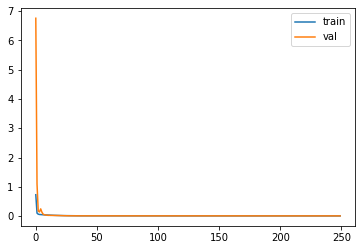

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 13)                52        
_________________________________________________________________
dense_4 (Dense)              (None, 35)                490       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 35)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1440      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 40)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)               

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_THC_Maildlake_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/BuffaloViewpoint_outlier_THC_OT.h5'
model_NN.save(precovid_model )

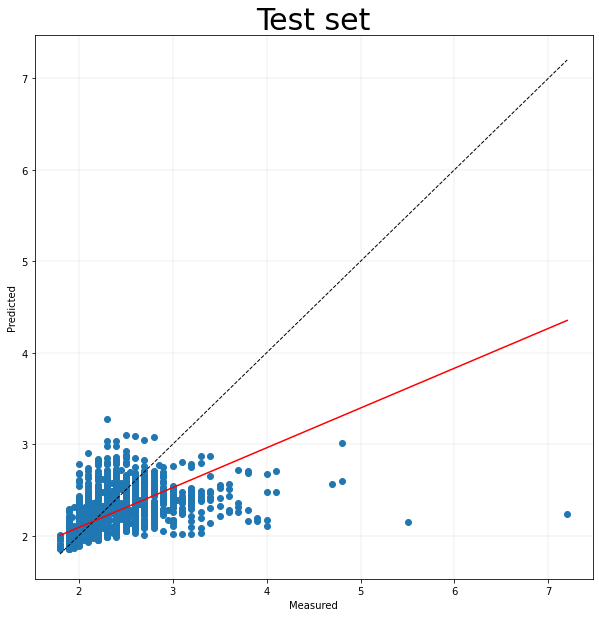

[0.43508393 1.22087694]
RMSE
[0.18412571]
R2
0.4246159444190535


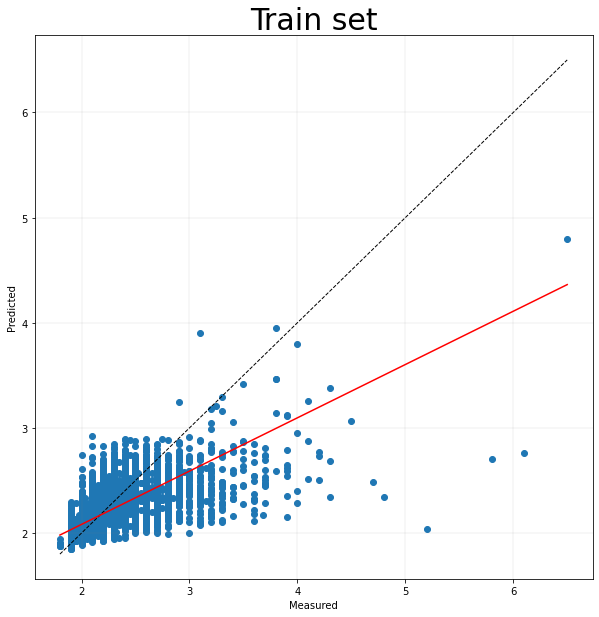

[0.50679509 1.06883216]
RMSE
[0.16159223]
R2
0.5256858945523699


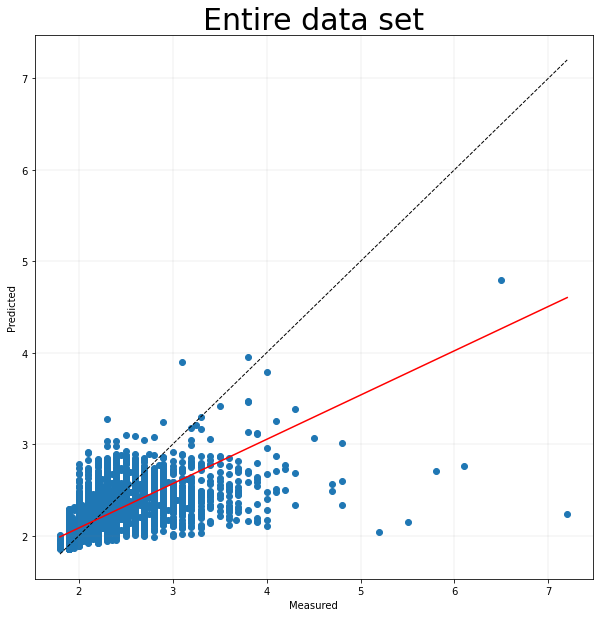

[0.48423078 1.11669083]
RMSE
[0.16866929]
R2
0.4939045622702839


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 13)                52        
_________________________________________________________________
dense_4 (Dense)              (None, 35)                490       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 35)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1440      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 40)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)               

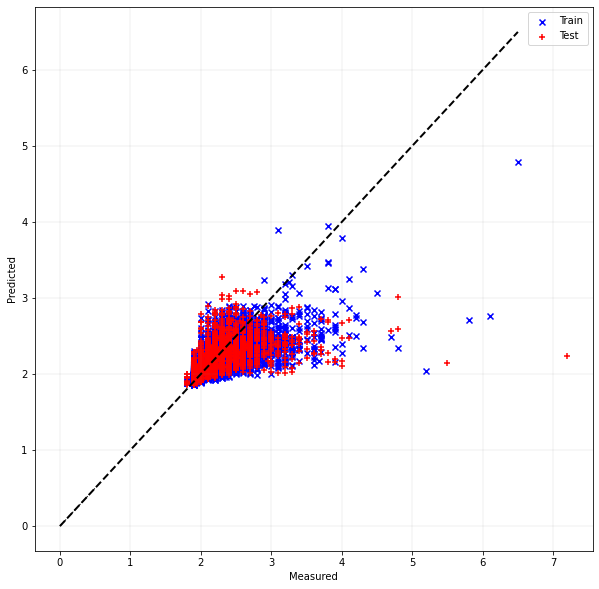

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

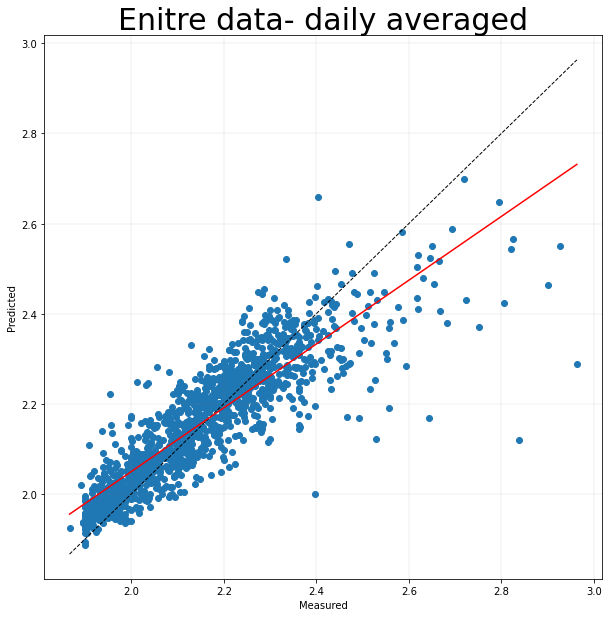

[0.70772232 0.63421725]
RMSE
[0.08412393]
R2
0.7565943077557524


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10[aa]).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

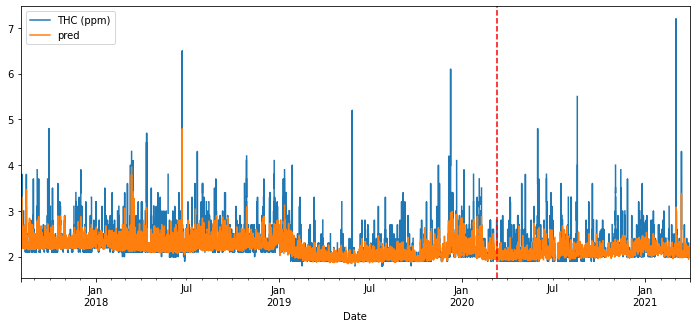

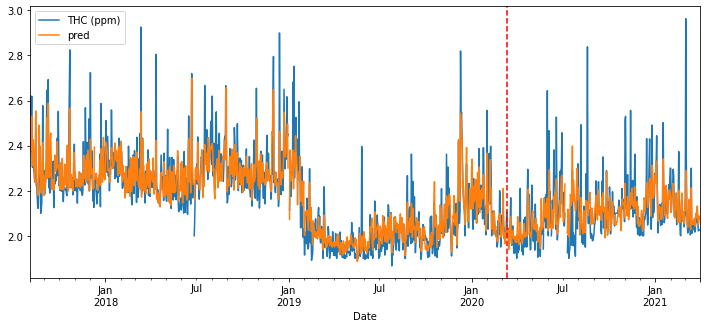

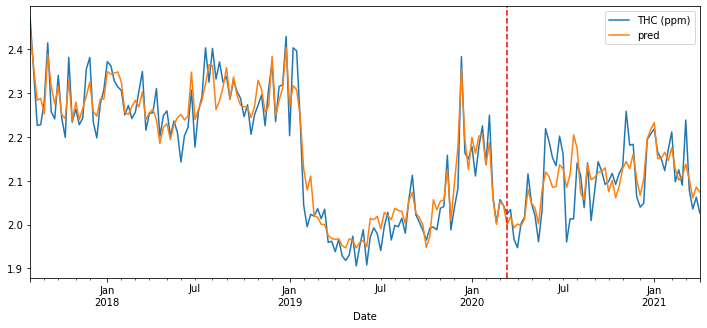

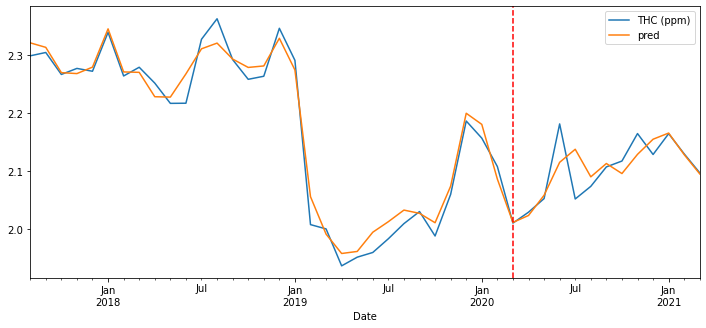

In [ ]:
df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[0.16159223]
0.5256858945523699


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[0.18412571]
0.4246159444190535


In [ ]:
df4.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_THC_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_THC_NN_OR_Test.csv')

[0.16159223]
0.5256858945523699
[0.18412571]
0.4246159444190535


In [ ]:
df4.columns

Index(['THC (ppm)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)

In [ ]:
# df4_D = df4_h.resample('D').mean()
# df4_M = df4_h.resample('M').mean()
# df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO2_hourly_pred.csv')
# df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO_monthly_pred.csv')

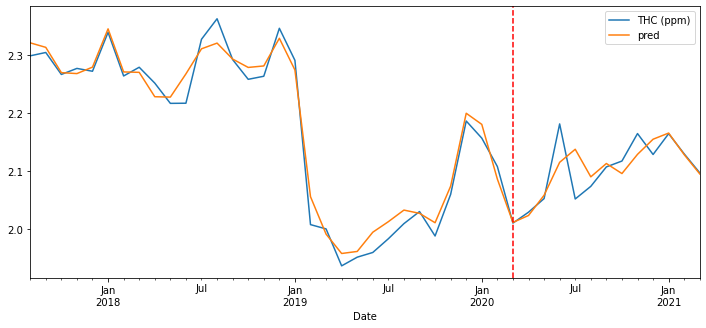

In [ ]:
df4_h[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
df4_h['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df4

THC (ppm)  RH %  ...  Day-year      trend
Date                                  ...                     
2017-08-04 07:00:00        3.0  92.0  ...       216  17.588229
2017-08-04 08:00:00        3.1  87.0  ...       216  17.588342
2017-08-04 09:00:00        3.0  81.0  ...       216  17.588456
2017-08-04 10:00:00        3.0  78.0  ...       216  17.588570
2017-08-04 11:00:00        2.9  75.0  ...       216  17.588684
...                        ...   ...  ...       ...        ...
2021-03-31 19:00:00        2.0  51.5  ...        90  21.245332
2021-03-31 20:00:00        2.0  53.6  ...        90  21.245446
2021-03-31 21:00:00        2.0  45.6  ...        90  21.245560
2021-03-31 22:00:00        2.0  43.5  ...        90  21.245674
2021-03-31 23:00:00        2.0  46.1  ...        90  21.245788

[29594 rows x 14 columns]

In [ ]:
df4_h

THC (ppm)  RH %  T ( C)  ...  Day-year      trend      pred
Date                                          ...                               
2017-08-04 07:00:00        3.0  92.0    15.5  ...       216  17.588229  2.496867
2017-08-04 08:00:00        3.1  87.0    16.4  ...       216  17.588342  2.742926
2017-08-04 09:00:00        3.0  81.0    17.1  ...       216  17.588456  2.910829
2017-08-04 10:00:00        3.0  78.0    17.5  ...       216  17.588570  2.450252
2017-08-04 11:00:00        2.9  75.0    18.3  ...       216  17.588684  2.562989
...                        ...   ...     ...  ...       ...        ...       ...
2021-03-31 19:00:00        2.0  51.5     5.6  ...        90  21.245332  2.112596
2021-03-31 20:00:00        2.0  53.6     4.2  ...        90  21.245446  2.057011
2021-03-31 21:00:00        2.0  45.6     5.3  ...        90  21.245560  2.041842
2021-03-31 22:00:00        2.0  43.5     5.4  ...        90  21.245674  2.044092
2021-03-31 23:00:00        2.0  46.1     4.6  ...        90  21.245788  2.059347

[29594 rows x 15 columns]

In [ ]:
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
110
2.164123058319092
2021-01-17 08:00:00
113
2.16335391998291
2021-01-17 09:00:00
113
2.1623904705047607
2021-01-17 10:00:00
108
2.1607768535614014
2021-01-17 11:00:00
104
2.149120330810547
2021-01-17 12:00:00
103
2.1475839614868164
2021-01-17 14:00:00
111
2.14758563041687
2021-01-17 15:00:00
112
2.1507010459899902
2021-01-17 16:00:00
113
2.155560255050659
2021-01-17 17:00:00
112
2.1602578163146973
2021-01-17 18:00:00
110
2.1581668853759766
2021-01-17 19:00:00
110
2.168658971786499
2021-01-17 20:00:00
110
2.170969247817993
2021-01-17 21:00:00
111
2.180022954940796
2021-01-17 22:00:00
113
2.1795129776000977
2021-01-17 23:00:00
113
2.181659460067749
2021-01-18 01:00:00
113
2.16269850730896
2021-01-18 02:00:00
112
2.1592636108398438
2021-01-18 03:00:00
112
2.158552408218384
2021-01-18 04:00:00
110
2.162980556488037
2021-01-18 05:00:00
111
2.161675214767456
2021-01-18 06:00:00
111
2.1647369861602783
2021-01-18 07:00:00
110
2.1633400917053

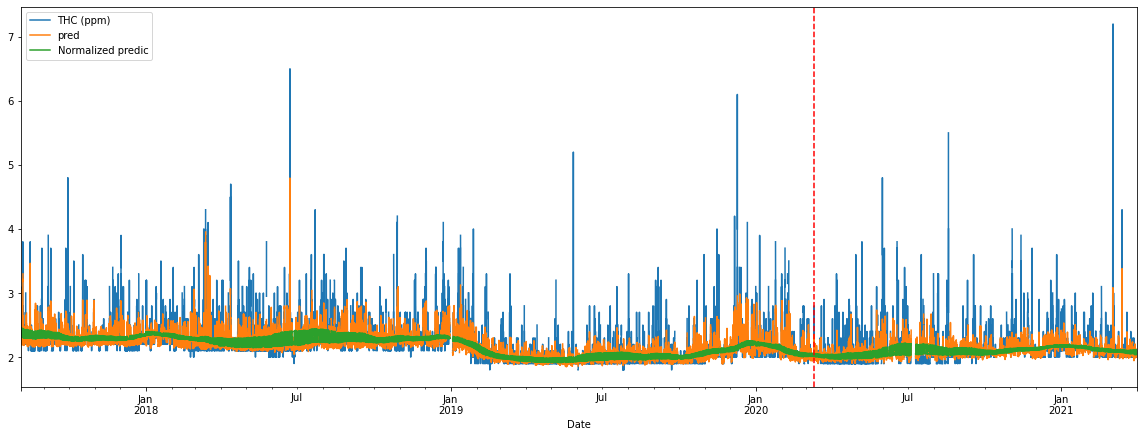

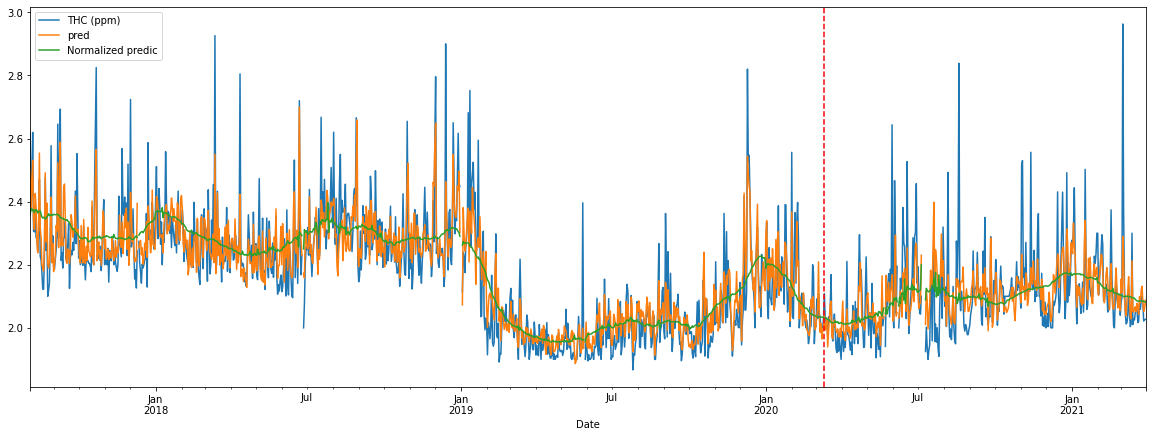

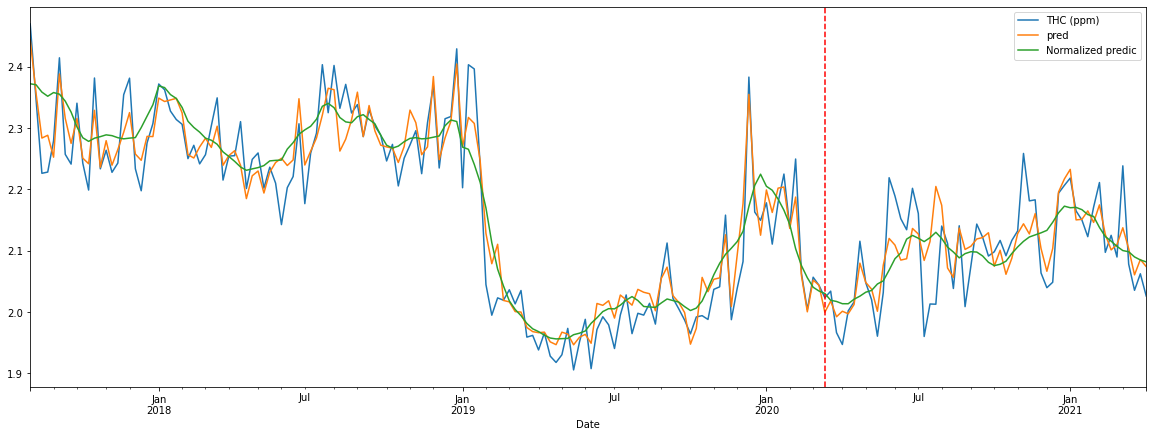

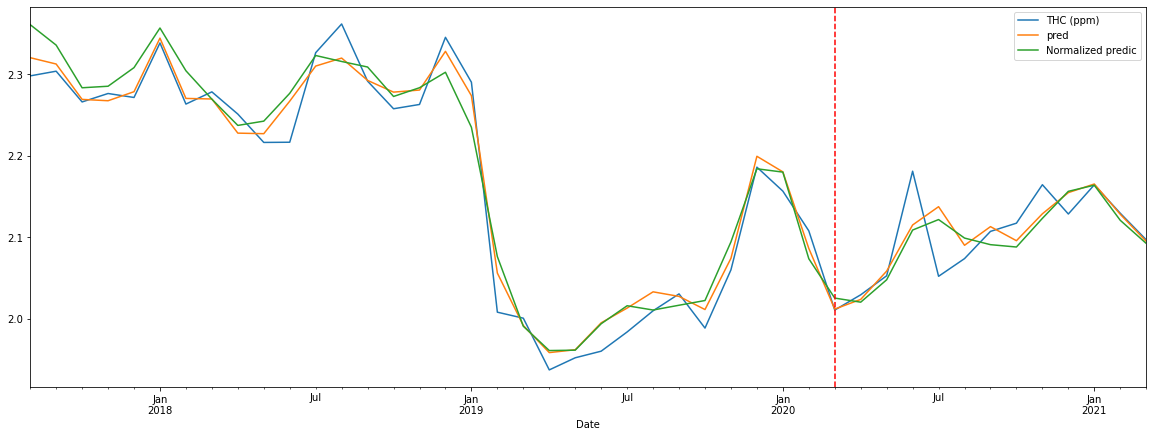

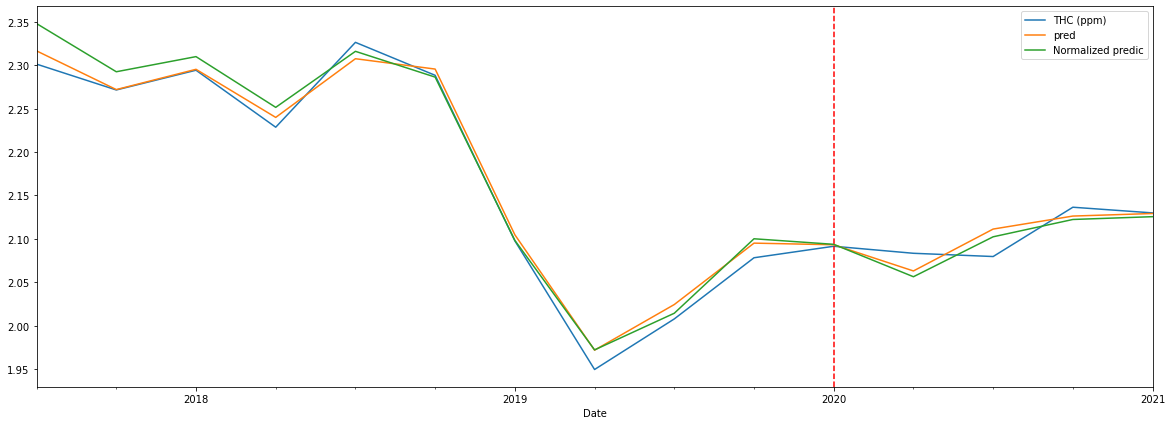

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_THC_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_THC_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_THC_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

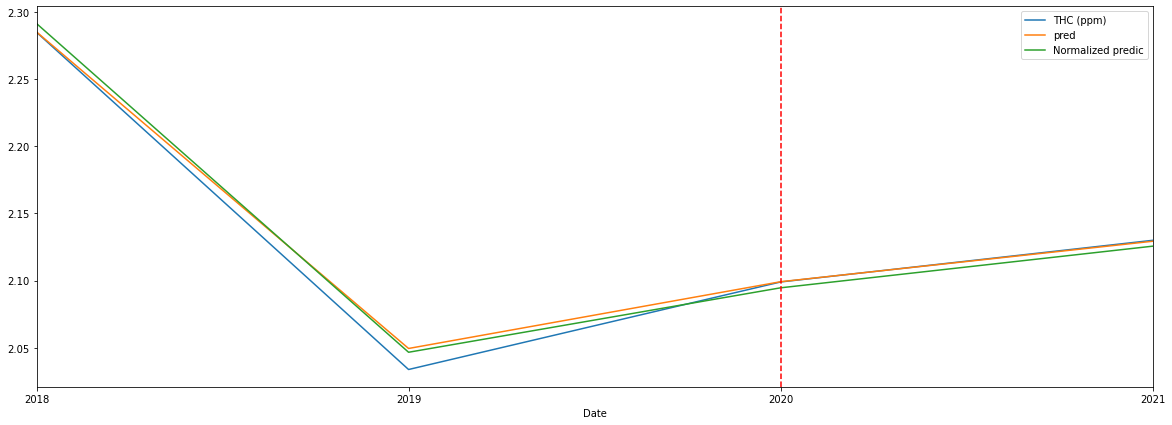

In [ ]:
df4_h[aa].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate


df2_w_c = df2_w[[ 'CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend',
       'driving', 'transit','walking',
]]
df2_w_c.columns

Index(['CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'driving', 'transit',
       'walking'],
      dtype='object')

In [ ]:
df2_w_c[['driving', 'transit', 'walking']]=df2_w_c[['driving', 'transit', 'walking']]/100

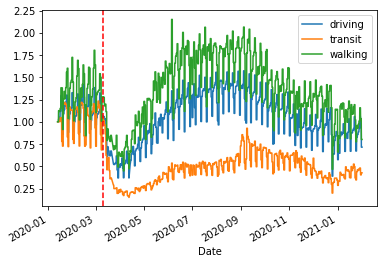

In [ ]:
df2_w_c[['driving', 'transit', 'walking']].plot()
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
a = df2_w_c[['driving', 'transit', 'walking']].loc[:'2020-03-11'].copy()
a.mean()

driving    1.124019
transit    1.025378
walking    1.331329
dtype: float64

In [ ]:
Y_a = df2_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df2_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df2_w_c[ ['driving', 'transit', 'walking']])


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
print(np.shape(X_a),np.shape(X_b),np.shape(Y_a))

(9075, 12) (9075, 3) (9075, 1)


In [ ]:
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
print(np.shape(X_train_a),np.shape(X_train_b))
print(np.shape(X_traine_a),np.shape(X_traine_b))
print(np.shape(X_val_a),np.shape(X_val_b))

(7260, 12) (7260, 3)
(5445, 12) (5445, 3)
(1815, 12) (1815, 3)


In [ ]:
best_params

{'batchsize': 2500.0,
 'drop_out1': 0.0057066589968766,
 'drop_out2': 0.008999530008727568,
 'drop_out3': 0.0006990849923195847,
 'layers': 3,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 24,
 'num_dense_nodes3': 28}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 35)                455       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0

In [ ]:
class Objective2(object):
    def __init__(self, X_a,X_b, Y, max_epochs, learn_rate_epochs,
                  ):
        self.X_train_a, self.X_test_a, self.y_train_a, self.y_test_a = train_test_split(X_a, Y, test_size=0.001, random_state=42)
        self.X_train_b, self.X_test_b, self.y_train_b, self.y_test_b = train_test_split(X_b, Y, test_size=0.001, random_state=42)

        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.model_fixed = load_model(precovid_model)
        for i in range(0,len(self.model_fixed.layers)):
            self.model_fixed.layers[i].trainable = False

    def __call__(self, trial):        
        dict_params = { 
                        'last_layer' :trial.suggest_int('last_layer',0,1),
                        'two_layer' :trial.suggest_int('two_layer',0,1),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 1,3),
                       'num_dense_nodes2': trial.suggest_int('num_dense_nodes2', 1,8),
                        # 'layers': trial.suggest_int('layers', 2,3),
                       'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,2000,100)),
                      #  'drop_out1': trial.suggest_float('drop_out1',0.0, 0.2),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                       'layer_back' :-(trial.suggest_int('layer_back', 1,2)),
                       }  
        # print(dict_params[ 'layer_back'])
        l1 = Input(shape=(3,))
        l1_2 = BatchNormalization()(l1)
        l2 = Dense(dict_params['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
        l2_2 = LeakyReLU(alpha=dict_params['alpha'])(l2)
        if dict_params['two_layer'] ==1 :
             l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_3])
        else :
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_2])
        merged2 = BatchNormalization()(merged)

        if dict_params['last_layer'] == 0:
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)

        if dict_params['last_layer'] == 1:
            l5 = Dense(dict_params['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
            l5_1 = LeakyReLU(alpha=dict_params['alpha'])(l5)
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)          
        
        model = Model(inputs=[self.model_fixed.input,l1], outputs=l5_3)

        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params['learning_rate'])
        model.compile(loss='mse',optimizer=opt)
        fn2 = "gdrive/My Drive/Colab Notebooks/Stations/East_ED_NOX_apple" +str(trial.number) + ".ckpt" 
        fnn2 = os.path.dirname(fn2)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn2, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 

        for train_index, test_index in kf.split( self.X_train_a):   
                X_tr_a, X_tes_a =  self.X_train_a[train_index],  self.X_train_a[test_index]
                X_tr_b, X_tes_b =  self.X_train_b[train_index],  self.X_train_b[test_index]
                y_tr, y_tes =   self.y_train_a[train_index],   self.y_train_a[test_index]    
                # fit the model
                X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split( X_tr_a,  y_tr, test_size=0.12, random_state = 42)
                X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split( X_tr_b,  y_tr, test_size=0.12, random_state = 42)


                model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=dict_params['batchsize'],
                  epochs=self.max_epochs,
                  shuffle=True, verbose=0,
                  callbacks=callbacks_list)
                
                model.load_weights(fn2)
                preds = model.predict([X_tes_a,X_tes_b]) 
                # print(np.shape(y_tes),np.shape( preds))
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 
        print(acc)
        return acc    

In [ ]:
objective2 = Objective2(X_a, X_b ,Y_a ,maximum_epochs, learning_rate_epochs)
study2 = optuna.create_study(direction=optimizer_direction, study_name='east_edm_CO_p2',storage='sqlite:///east_edm_CO_p2.db',load_if_exists=True)
study2.optimize(objective2, n_trials=300)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/CO_Edmonton_east_Hyperparams_Stations.csv')
study2.best_trial

[I 2021-04-18 06:37:44,453] A new study created in RDB with name: east_edm_CO_p2
[I 2021-04-18 06:40:22,320] Trial 0 finished with value: 0.0047897337392556185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 3, 'batchsize': 1300.0, 'learning_rate': 0.08684742896034063, 'alpha': 0.47486431649895633, 'layer_back': 1}. Best is trial 0 with value: 0.0047897337392556185.


0.0047897337392556185


[I 2021-04-18 06:46:17,741] Trial 1 finished with value: 0.0037995427144006185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 200.0, 'learning_rate': 0.026645640165432177, 'alpha': 0.2464432589680267, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0037995427144006185


[I 2021-04-18 06:49:06,028] Trial 2 finished with value: 0.004990117939045318 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1200.0, 'learning_rate': 0.04246052710121524, 'alpha': 0.14036321226448864, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.004990117939045318


[I 2021-04-18 06:51:38,749] Trial 3 finished with value: 0.004435081840883617 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.08019349670014007, 'alpha': 0.801795208357617, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004435081840883617


[I 2021-04-18 06:55:41,325] Trial 4 finished with value: 0.004397006773851628 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 400.0, 'learning_rate': 0.0922021495386216, 'alpha': 0.8714206976745991, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004397006773851628


[I 2021-04-18 06:58:39,803] Trial 5 finished with value: 0.004472224808431502 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 1, 'batchsize': 900.0, 'learning_rate': 0.054032085513753485, 'alpha': 0.36356263089297863, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004472224808431502


[I 2021-04-18 07:02:19,968] Trial 6 finished with value: 0.004032658481373844 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 500.0, 'learning_rate': 0.0034103388646587085, 'alpha': 0.8298599523597091, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004032658481373844


[I 2021-04-18 07:04:57,913] Trial 7 finished with value: 0.004412881161440907 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1400.0, 'learning_rate': 0.024560851403922612, 'alpha': 0.8657303593335849, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004412881161440907


[I 2021-04-18 07:07:33,362] Trial 8 finished with value: 0.003962766007027832 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1600.0, 'learning_rate': 0.0387484515918348, 'alpha': 0.5935061142207385, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.003962766007027832


[I 2021-04-18 07:10:45,080] Trial 9 finished with value: 0.004464174746733434 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 700.0, 'learning_rate': 0.07156430296741274, 'alpha': 0.6837562117270939, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004464174746733434


[I 2021-04-18 07:20:10,927] Trial 10 finished with value: 0.0047593223285363065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.006393597974084786, 'alpha': 0.09784392044369339, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.0047593223285363065


[I 2021-04-18 07:22:40,517] Trial 11 finished with value: 0.0038559859859853907 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 4, 'batchsize': 1900.0, 'learning_rate': 0.029641261114048665, 'alpha': 0.3455488342982123, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0038559859859853907


[I 2021-04-18 07:25:12,650] Trial 12 finished with value: 0.0037802072596256108 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 2000.0, 'learning_rate': 0.021318248161901757, 'alpha': 0.27421676161966496, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.0037802072596256108


[I 2021-04-18 07:34:39,100] Trial 13 finished with value: 0.003838305552608133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.01618259930894679, 'alpha': 0.2237909588852787, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.003838305552608133


[I 2021-04-18 07:37:13,171] Trial 14 finished with value: 0.0037727934709037452 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 1600.0, 'learning_rate': 0.05463156741271952, 'alpha': 0.023432883667647286, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.0037727934709037452


[I 2021-04-18 07:39:46,194] Trial 15 finished with value: 0.004717376020706112 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.057774493852787316, 'alpha': 0.013468966566860257, 'layer_back': 1}. Best is trial 14 with value: 0.0037727934709037452.


0.004717376020706112


[I 2021-04-18 07:42:17,141] Trial 16 finished with value: 0.003891606393255513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 4, 'batchsize': 1600.0, 'learning_rate': 0.06483099406582218, 'alpha': 0.048701457819810334, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.003891606393255513


[I 2021-04-18 07:44:50,068] Trial 17 finished with value: 0.003705317767648349 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.042981081545902175, 'alpha': 0.17151924705879706, 'layer_back': 2}. Best is trial 17 with value: 0.003705317767648349.


0.003705317767648349


[I 2021-04-18 07:47:22,992] Trial 18 finished with value: 0.003652074267837431 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043120594200074316, 'alpha': 0.15356515832757994, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003652074267837431


[I 2021-04-18 07:49:56,748] Trial 19 finished with value: 0.004855364207538971 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.03948108446690251, 'alpha': 0.1731767923827432, 'layer_back': 1}. Best is trial 18 with value: 0.003652074267837431.


0.004855364207538971


[I 2021-04-18 07:52:46,818] Trial 20 finished with value: 0.0036661417054684184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.045596783441498825, 'alpha': 0.46487314129271234, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0036661417054684184


[I 2021-04-18 07:55:47,695] Trial 21 finished with value: 0.003772814522212643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.04376219782019011, 'alpha': 0.495381372771252, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003772814522212643


[I 2021-04-18 07:58:33,572] Trial 22 finished with value: 0.0037000579251144777 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03235269324681574, 'alpha': 0.40139723428257024, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037000579251144777


[I 2021-04-18 08:01:16,242] Trial 23 finished with value: 0.0037201394146138406 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.0335829823820747, 'alpha': 0.561915944028579, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037201394146138406


[I 2021-04-18 08:04:15,280] Trial 24 finished with value: 0.0037030372913319023 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.01268992251227287, 'alpha': 0.3938061003278891, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037030372913319023


[I 2021-04-18 08:07:38,080] Trial 25 finished with value: 0.003918046517575021 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.04897050026188292, 'alpha': 0.6753399284001078, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003918046517575021


[I 2021-04-18 08:10:15,782] Trial 26 finished with value: 0.0038008433695184197 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.06522149016140043, 'alpha': 0.42163733919230845, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0038008433695184197


[I 2021-04-18 08:13:05,072] Trial 27 finished with value: 0.0036111388857046787 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.03298839085103375, 'alpha': 0.3150552800923347, 'layer_back': 2}. Best is trial 27 with value: 0.0036111388857046787.


0.0036111388857046787


[I 2021-04-18 08:16:08,056] Trial 28 finished with value: 0.003597443791057043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.04885615301916258, 'alpha': 0.29269304131799223, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.003597443791057043


[I 2021-04-18 08:19:12,662] Trial 29 finished with value: 0.0046809329310916956 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.05995146156015323, 'alpha': 0.30446311601011683, 'layer_back': 1}. Best is trial 28 with value: 0.003597443791057043.


0.0046809329310916956


[I 2021-04-18 08:21:45,673] Trial 30 finished with value: 0.004425357656736 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.0759352310855712, 'alpha': 0.21269011576180244, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.004425357656736


[I 2021-04-18 08:24:37,569] Trial 31 finished with value: 0.0036547160400316313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.049811468875869416, 'alpha': 0.510738346787994, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0036547160400316313


[I 2021-04-18 08:27:52,823] Trial 32 finished with value: 0.0037521087301732345 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.049503947678833926, 'alpha': 0.31735277463906175, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037521087301732345


[I 2021-04-18 08:30:36,307] Trial 33 finished with value: 0.0037683419447327986 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.03290226547777786, 'alpha': 0.5286190169685012, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037683419447327986


[I 2021-04-18 08:33:27,324] Trial 34 finished with value: 0.003597358919918322 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.036818841872599595, 'alpha': 0.12570513379804832, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003597358919918322


[I 2021-04-18 08:37:26,272] Trial 35 finished with value: 0.003661138596451478 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 400.0, 'learning_rate': 0.03671876888449163, 'alpha': 0.08397801305678194, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003661138596451478


[I 2021-04-18 08:40:27,101] Trial 36 finished with value: 0.00359203525150731 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.02437141103670945, 'alpha': 0.12749087727003588, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00359203525150731


[I 2021-04-18 08:43:26,782] Trial 37 finished with value: 0.0036756314419160397 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.018931547569790746, 'alpha': 0.2516407308762111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036756314419160397


[I 2021-04-18 08:48:02,902] Trial 38 finished with value: 0.0036545643870157882 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 300.0, 'learning_rate': 0.02603462599572944, 'alpha': 0.14443719906111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036545643870157882


[I 2021-04-18 08:51:18,641] Trial 39 finished with value: 0.004398658143913983 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.02412418866542985, 'alpha': 0.09261962247455818, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.004398658143913983


[I 2021-04-18 08:54:03,235] Trial 40 finished with value: 0.00366032853048446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 1200.0, 'learning_rate': 0.028075997597257207, 'alpha': 0.20259126107498393, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00366032853048446


[I 2021-04-18 08:57:05,594] Trial 41 finished with value: 0.003674477629447893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.03773808729024592, 'alpha': 0.13311556018712936, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.003674477629447893


[I 2021-04-18 08:59:59,665] Trial 42 finished with value: 0.0036705861586692643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.014115297813961467, 'alpha': 0.28611068588955, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036705861586692643


[I 2021-04-18 09:03:13,164] Trial 43 finished with value: 0.0036713389468197555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.04560695580139573, 'alpha': 0.3437569312771207, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036713389468197555


[I 2021-04-18 09:06:35,814] Trial 44 finished with value: 0.0035783836209078556 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.009070889461271204, 'alpha': 0.13887248911600195, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035783836209078556


[I 2021-04-18 09:09:57,729] Trial 45 finished with value: 0.003673148714195081 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 600.0, 'learning_rate': 0.009253166791610645, 'alpha': 0.2451607156425593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003673148714195081


[I 2021-04-18 09:14:01,355] Trial 46 finished with value: 0.004344271113195811 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 400.0, 'learning_rate': 0.001551960808838477, 'alpha': 0.10569886410992255, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004344271113195811


[I 2021-04-18 09:17:39,621] Trial 47 finished with value: 0.0037050254039840223 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.021082510170567333, 'alpha': 0.0668001215058446, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037050254039840223


[I 2021-04-18 09:20:38,142] Trial 48 finished with value: 0.0036692619534721047 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.007585468046031375, 'alpha': 0.2061475495973082, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036692619534721047


[I 2021-04-18 09:23:49,174] Trial 49 finished with value: 0.004457879746783033 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.03483835282389286, 'alpha': 0.018344801879960376, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004457879746783033


[I 2021-04-18 09:26:34,895] Trial 50 finished with value: 0.0035807581552902102 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03005652498704963, 'alpha': 0.11696356203274105, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035807581552902102


[I 2021-04-18 09:29:21,811] Trial 51 finished with value: 0.0036236342891670654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.09983893132352316, 'alpha': 0.11957067974916365, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036236342891670654


[I 2021-04-18 09:32:02,631] Trial 52 finished with value: 0.0036302435793163423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.02754867420830222, 'alpha': 0.05647608660638647, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036302435793163423


[I 2021-04-18 09:34:44,744] Trial 53 finished with value: 0.003627053068071688 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04005811816852655, 'alpha': 0.17080808493297003, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003627053068071688


[I 2021-04-18 09:37:45,884] Trial 54 finished with value: 0.0036920503523068266 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.017979831294330218, 'alpha': 0.2570823577331828, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036920503523068266


[I 2021-04-18 09:40:36,692] Trial 55 finished with value: 0.003612690295076574 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1000.0, 'learning_rate': 0.029552755284063505, 'alpha': 0.18039366495456732, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003612690295076574


[I 2021-04-18 09:43:40,566] Trial 56 finished with value: 0.004012695527376038 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 800.0, 'learning_rate': 0.022565925713046567, 'alpha': 0.03734236499524329, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004012695527376038


[I 2021-04-18 09:47:16,794] Trial 57 finished with value: 0.003698018600704401 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 500.0, 'learning_rate': 0.05338960509962787, 'alpha': 0.35126328332328843, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003698018600704401


[I 2021-04-18 09:50:04,725] Trial 58 finished with value: 0.003619003598112455 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.011669376031158469, 'alpha': 0.2338658479883975, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003619003598112455


[I 2021-04-18 09:53:02,416] Trial 59 finished with value: 0.0036054917675212707 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.031117560438016202, 'alpha': 0.12690434404626497, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036054917675212707


[I 2021-04-18 09:56:06,738] Trial 60 finished with value: 0.003886966241395085 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.003565187588275332, 'alpha': 0.12617304287730674, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003886966241395085


[I 2021-04-18 09:59:11,214] Trial 61 finished with value: 0.003618826532739045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.03119470670070372, 'alpha': 0.06717581966642143, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003618826532739045


[I 2021-04-18 10:02:02,407] Trial 62 finished with value: 0.0037632189106060355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1000.0, 'learning_rate': 0.04059941279624269, 'alpha': 0.16862336495408595, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037632189106060355


[I 2021-04-18 10:05:19,179] Trial 63 finished with value: 0.003794832132947586 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 700.0, 'learning_rate': 0.036734160746832493, 'alpha': 0.01101319432018788, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003794832132947586


[I 2021-04-18 10:08:20,419] Trial 64 finished with value: 0.003758988776972788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.029855268948976825, 'alpha': 0.4386976096021802, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003758988776972788


[I 2021-04-18 10:11:42,186] Trial 65 finished with value: 0.0035876522982958357 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.024552341120126213, 'alpha': 0.20134794489311997, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035876522982958357


[I 2021-04-18 10:15:04,777] Trial 66 finished with value: 0.0036155628523736184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.016447401975405944, 'alpha': 0.14664495950811754, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036155628523736184


[I 2021-04-18 10:18:40,103] Trial 67 finished with value: 0.0037361543406670638 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.02482879535124779, 'alpha': 0.18911509071408622, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037361543406670638


[I 2021-04-18 10:23:14,465] Trial 68 finished with value: 0.004737399253546576 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 300.0, 'learning_rate': 0.045839207163365064, 'alpha': 0.11572139542681772, 'layer_back': 1}. Best is trial 44 with value: 0.0035783836209078556.


0.004737399253546576


[I 2021-04-18 10:26:17,521] Trial 69 finished with value: 0.0035844609162026856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.021759460493932996, 'alpha': 0.08938362393003896, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035844609162026856


[I 2021-04-18 10:29:40,721] Trial 70 finished with value: 0.003647474821726536 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.020584896822209618, 'alpha': 0.08688700495047245, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003647474821726536


[I 2021-04-18 10:32:40,862] Trial 71 finished with value: 0.0036240235360119194 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.026636013810065286, 'alpha': 0.04460753701062606, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036240235360119194


[I 2021-04-18 10:35:57,924] Trial 72 finished with value: 0.003678997217185063 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 700.0, 'learning_rate': 0.02380154186526011, 'alpha': 0.15140441320203327, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003678997217185063


[I 2021-04-18 10:39:01,596] Trial 73 finished with value: 0.003659856745198834 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.015277005770461548, 'alpha': 0.2178303763286192, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003659856745198834


[I 2021-04-18 10:42:16,571] Trial 74 finished with value: 0.0036399907750272265 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.011408912622706538, 'alpha': 0.10321869296892679, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036399907750272265


[I 2021-04-18 10:45:19,285] Trial 75 finished with value: 0.0037281104148537535 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.035323452421033984, 'alpha': 0.2846749869393032, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037281104148537535


[I 2021-04-18 10:48:06,701] Trial 76 finished with value: 0.00361764726075232 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.018785055346852722, 'alpha': 0.08247223174383175, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.00361764726075232


[I 2021-04-18 10:51:06,829] Trial 77 finished with value: 0.0036951690746862827 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.030036815811613576, 'alpha': 0.15370233117847767, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036951690746862827


[I 2021-04-18 10:53:48,194] Trial 78 finished with value: 0.003591197553125669 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.021596734858180668, 'alpha': 0.19705749126102656, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003591197553125669


[I 2021-04-18 10:56:31,899] Trial 79 finished with value: 0.0036875580454355968 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.004996727049177942, 'alpha': 0.19630957319700593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036875580454355968


[I 2021-04-18 10:59:15,173] Trial 80 finished with value: 0.003672630637413495 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.009725768873874269, 'alpha': 0.23904793658858925, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003672630637413495


[I 2021-04-18 11:02:33,338] Trial 81 finished with value: 0.003608277041588192 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.021177055101469718, 'alpha': 0.13273475258504627, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003608277041588192


[I 2021-04-18 11:05:23,493] Trial 82 finished with value: 0.0035357134156083006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03251063586877488, 'alpha': 0.16601335847048496, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035357134156083006


[I 2021-04-18 11:08:10,650] Trial 83 finished with value: 0.0035800395220561315 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027507014638668944, 'alpha': 0.26952999743969175, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035800395220561315


[I 2021-04-18 11:10:53,530] Trial 84 finished with value: 0.003641285084880817 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.024468913257262442, 'alpha': 0.26941083528596615, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003641285084880817


[I 2021-04-18 11:13:33,120] Trial 85 finished with value: 0.003613639352689042 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.027506935493900007, 'alpha': 0.16554636650660334, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003613639352689042


[I 2021-04-18 11:16:13,848] Trial 86 finished with value: 0.0035454609704569555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034075180962035656, 'alpha': 0.19205737194876213, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035454609704569555


[I 2021-04-18 11:18:54,396] Trial 87 finished with value: 0.0036217548071173097 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.018105506543334197, 'alpha': 0.2172761829124636, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036217548071173097


[I 2021-04-18 11:21:32,202] Trial 88 finished with value: 0.0036196131119005967 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.013644839043071016, 'alpha': 0.18554443324755185, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036196131119005967


[I 2021-04-18 11:24:10,911] Trial 89 finished with value: 0.003572944589854708 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02174303974596932, 'alpha': 0.06885902281378707, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003572944589854708


[I 2021-04-18 11:26:50,606] Trial 90 finished with value: 0.003906346283951516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1500.0, 'learning_rate': 0.03323653174387488, 'alpha': 0.03163285232628042, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003906346283951516


[I 2021-04-18 11:29:31,353] Trial 91 finished with value: 0.003578888868218704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.022580602914511808, 'alpha': 0.06713185538847133, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003578888868218704


[I 2021-04-18 11:32:08,581] Trial 92 finished with value: 0.0035789263141083713 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.021256605621501615, 'alpha': 0.06634621015162126, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035789263141083713


[I 2021-04-18 11:34:49,916] Trial 93 finished with value: 0.003544189206426239 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02748340529865124, 'alpha': 0.07868991239964429, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003544189206426239


[I 2021-04-18 11:37:33,179] Trial 94 finished with value: 0.0035499476797488643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02892486834145689, 'alpha': 0.07221984870581319, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035499476797488643


[I 2021-04-18 11:40:14,572] Trial 95 finished with value: 0.0035273632980514285 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.027834554447690413, 'alpha': 0.06732285000688103, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035273632980514285


[I 2021-04-18 11:42:52,853] Trial 96 finished with value: 0.0036086771352365947 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02637530840203316, 'alpha': 0.05953489610216768, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036086771352365947


[I 2021-04-18 11:45:38,794] Trial 97 finished with value: 0.0035684357428775186 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027517728652115728, 'alpha': 0.07593898838347986, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035684357428775186


[I 2021-04-18 11:48:20,507] Trial 98 finished with value: 0.003583852513729412 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03367874759681739, 'alpha': 0.06942447131849512, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003583852513729412


[I 2021-04-18 11:50:57,066] Trial 99 finished with value: 0.003541288425685317 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.041358766423868744, 'alpha': 0.021920382234198947, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003541288425685317


[I 2021-04-18 11:53:42,845] Trial 100 finished with value: 0.0036243488752047467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04030568364072326, 'alpha': 0.02384229949250582, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036243488752047467


[I 2021-04-18 11:56:21,539] Trial 101 finished with value: 0.003627937411450544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.035398043970041676, 'alpha': 0.03950052041260174, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627937411450544


[I 2021-04-18 11:59:00,418] Trial 102 finished with value: 0.003627126043875543 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03832592467033967, 'alpha': 0.10048283220351684, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627126043875543


[I 2021-04-18 12:01:36,789] Trial 103 finished with value: 0.0035408315369076784 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032256016881253326, 'alpha': 0.07030089565296588, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035408315369076784


[I 2021-04-18 12:04:17,971] Trial 104 finished with value: 0.003566082616285739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04262395762710679, 'alpha': 0.01173160141920479, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003566082616285739


[I 2021-04-18 12:06:58,238] Trial 105 finished with value: 0.0035737931205732376 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04227819138674002, 'alpha': 0.010660044984515019, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035737931205732376


[I 2021-04-18 12:09:32,119] Trial 106 finished with value: 0.0035184089995725617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043629287038235834, 'alpha': 0.010426390915745402, 'layer_back': 2}. Best is trial 106 with value: 0.0035184089995725617.


0.0035184089995725617


[I 2021-04-18 12:12:07,413] Trial 107 finished with value: 0.0034912184906821125 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04304162747051637, 'alpha': 0.044280753511746956, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0034912184906821125


[I 2021-04-18 12:14:44,123] Trial 108 finished with value: 0.0036380100736029142 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046899784330746694, 'alpha': 0.011423731168029368, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036380100736029142


[I 2021-04-18 12:17:20,619] Trial 109 finished with value: 0.0035930917231830005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05312662202242775, 'alpha': 0.04766526633420203, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035930917231830005


[I 2021-04-18 12:19:56,882] Trial 110 finished with value: 0.0035019395412586403 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04297554301809757, 'alpha': 0.03108575464071467, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035019395412586403


[I 2021-04-18 12:22:26,683] Trial 111 finished with value: 0.0035799057324392095 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.042791521010711986, 'alpha': 0.033242351358857565, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035799057324392095


[I 2021-04-18 12:25:01,093] Trial 112 finished with value: 0.003567586631908924 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04188075691123601, 'alpha': 0.012902457195305648, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567586631908924


[I 2021-04-18 12:27:37,137] Trial 113 finished with value: 0.003552786707766206 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04705313553365665, 'alpha': 0.024024393886675065, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003552786707766206


[I 2021-04-18 12:30:14,683] Trial 114 finished with value: 0.0035491374611036066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04792414670441766, 'alpha': 0.04942912887788908, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035491374611036066


[I 2021-04-18 12:32:47,942] Trial 115 finished with value: 0.003934744163417141 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.05138779832449931, 'alpha': 0.7678284116404237, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003934744163417141


[I 2021-04-18 12:35:21,813] Trial 116 finished with value: 0.0035480745063304685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04672929967596791, 'alpha': 0.0543681486748597, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035480745063304685


[I 2021-04-18 12:37:57,950] Trial 117 finished with value: 0.003645209428448006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.058597540974892046, 'alpha': 0.054075814336391005, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003645209428448006


[I 2021-04-18 12:40:31,646] Trial 118 finished with value: 0.003635834268763575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04497558570260886, 'alpha': 0.10395749038880057, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003635834268763575


[I 2021-04-18 12:43:09,338] Trial 119 finished with value: 0.0036447334704852665 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1800.0, 'learning_rate': 0.04781462434994531, 'alpha': 0.04268750205527756, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036447334704852665


[I 2021-04-18 12:45:44,270] Trial 120 finished with value: 0.003567690380984065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.037831602089136926, 'alpha': 0.0894939850401166, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567690380984065


[I 2021-04-18 12:48:19,955] Trial 121 finished with value: 0.0036418865284299482 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.049910163797960434, 'alpha': 0.02265761100617698, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036418865284299482


[I 2021-04-18 12:50:50,152] Trial 122 finished with value: 0.003626350371093418 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04409374352769631, 'alpha': 0.04839758470877351, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003626350371093418


[I 2021-04-18 12:53:25,935] Trial 123 finished with value: 0.004068899031879057 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 1900.0, 'learning_rate': 0.04692551724599392, 'alpha': 0.027164865650236767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004068899031879057


[I 2021-04-18 12:56:09,582] Trial 124 finished with value: 0.003549524306460534 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.05601252997839943, 'alpha': 0.08216270418670965, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003549524306460534


[I 2021-04-18 12:58:52,986] Trial 125 finished with value: 0.0036022166677025626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.051026693295636215, 'alpha': 0.08169432284004574, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036022166677025626


[I 2021-04-18 13:01:25,923] Trial 126 finished with value: 0.0036323884269265395 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05755736475611723, 'alpha': 0.10764012747900042, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036323884269265395


[I 2021-04-18 13:04:06,681] Trial 127 finished with value: 0.0035868803510106743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.06484074739859898, 'alpha': 0.04916233098402338, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035868803510106743


[I 2021-04-18 13:06:48,784] Trial 128 finished with value: 0.003632038891645508 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.05481967090549042, 'alpha': 0.09493718561374137, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632038891645508


[I 2021-04-18 13:09:24,704] Trial 129 finished with value: 0.0036332687347207073 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.06164699827462552, 'alpha': 0.11368639196612304, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036332687347207073


[I 2021-04-18 13:12:02,225] Trial 130 finished with value: 0.0036107090038871685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.031913432524153476, 'alpha': 0.07944764608488178, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036107090038871685


[I 2021-04-18 13:14:37,997] Trial 131 finished with value: 0.003543857849946714 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04047866711207972, 'alpha': 0.03334890991576665, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003543857849946714


[I 2021-04-18 13:17:10,956] Trial 132 finished with value: 0.003614544482168527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03927975006627224, 'alpha': 0.05750478466882326, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003614544482168527


[I 2021-04-18 13:19:52,496] Trial 133 finished with value: 0.0036289459230039846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03602600147397279, 'alpha': 0.03879102885756539, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036289459230039846


[I 2021-04-18 13:22:21,926] Trial 134 finished with value: 0.004397730627210862 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04121745337090514, 'alpha': 0.07727507999023213, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004397730627210862


[I 2021-04-18 13:25:09,682] Trial 135 finished with value: 0.0035954891884910044 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.05591938878661566, 'alpha': 0.011489115255243473, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035954891884910044


[I 2021-04-18 13:27:46,099] Trial 136 finished with value: 0.003632190940638184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04473961188420494, 'alpha': 0.05883472932516892, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632190940638184


[I 2021-04-18 13:30:22,676] Trial 137 finished with value: 0.004797824764292689 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03394020855741806, 'alpha': 0.6177230050734727, 'layer_back': 1}. Best is trial 107 with value: 0.0034912184906821125.


0.004797824764292689


[I 2021-04-18 13:32:54,827] Trial 138 finished with value: 0.0035575625191086686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03925631108791122, 'alpha': 0.02976577533102045, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035575625191086686


[I 2021-04-18 13:35:35,526] Trial 139 finished with value: 0.0037383972180743746 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.02925391477758371, 'alpha': 0.13393207397187767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037383972180743746


[I 2021-04-18 13:38:16,882] Trial 140 finished with value: 0.003617621733455551 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03195637257591547, 'alpha': 0.0947751465706642, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003617621733455551


[I 2021-04-18 13:40:50,663] Trial 141 finished with value: 0.003579242154278799 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0485447382823182, 'alpha': 0.01176858180870248, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003579242154278799


[I 2021-04-18 13:43:25,476] Trial 142 finished with value: 0.0035750086655864273 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.046567743860348884, 'alpha': 0.026818371099279946, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035750086655864273


[I 2021-04-18 13:46:00,498] Trial 143 finished with value: 0.003623829402881311 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03742158374219033, 'alpha': 0.04975293319513799, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003623829402881311


[I 2021-04-18 13:48:38,218] Trial 144 finished with value: 0.0036066806414085484 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05148602571649974, 'alpha': 0.010300864640383572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036066806414085484


[I 2021-04-18 13:51:09,839] Trial 145 finished with value: 0.003610979298586066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.043772802510158214, 'alpha': 0.07001141819525372, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003610979298586066


[I 2021-04-18 13:53:44,355] Trial 146 finished with value: 0.0035619962671982527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04082403791540483, 'alpha': 0.035248606443724864, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035619962671982527


[I 2021-04-18 13:56:26,877] Trial 147 finished with value: 0.003548864702878114 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04862893209367515, 'alpha': 0.11504554485639235, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003548864702878114


[I 2021-04-18 13:59:07,487] Trial 148 finished with value: 0.0036127803252306075 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034866037784612974, 'alpha': 0.15803031484071783, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036127803252306075


[I 2021-04-18 14:01:52,630] Trial 149 finished with value: 0.0035717142472204513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04905384303207223, 'alpha': 0.11415311920269179, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035717142472204513


[I 2021-04-18 14:04:32,812] Trial 150 finished with value: 0.0035749882689068164 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04526973875676865, 'alpha': 0.14572957071712894, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035749882689068164


[I 2021-04-18 14:07:16,399] Trial 151 finished with value: 0.0035993304069324022 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.052491361045237814, 'alpha': 0.08397349335013253, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035993304069324022


[I 2021-04-18 14:09:58,621] Trial 152 finished with value: 0.0035685056911281127 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04837346606791395, 'alpha': 0.06310254703879091, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035685056911281127


[I 2021-04-18 14:12:29,525] Trial 153 finished with value: 0.003629879513305761 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0438214208862195, 'alpha': 0.10403865238259322, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003629879513305761


[I 2021-04-18 14:15:14,227] Trial 154 finished with value: 0.0036221795403482207 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03029487512047642, 'alpha': 0.04348614544060133, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036221795403482207


[I 2021-04-18 14:17:57,080] Trial 155 finished with value: 0.0035922583407074988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.03843837268200991, 'alpha': 0.08433177217864488, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035922583407074988


[I 2021-04-18 14:20:36,152] Trial 156 finished with value: 0.003578072413719791 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.046367859672450995, 'alpha': 0.12254720867272155, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003578072413719791


[I 2021-04-18 14:23:15,649] Trial 157 finished with value: 0.0038583845758324883 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0871450624590979, 'alpha': 0.056755344230540905, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0038583845758324883


[I 2021-04-18 14:25:52,255] Trial 158 finished with value: 0.003580582397543033 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.041182684797758676, 'alpha': 0.031335914276621774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003580582397543033


[I 2021-04-18 14:28:31,244] Trial 159 finished with value: 0.003571554999049949 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.050511120203456654, 'alpha': 0.011355553310716315, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003571554999049949


[I 2021-04-18 14:31:10,768] Trial 160 finished with value: 0.0035740442082979025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1300.0, 'learning_rate': 0.054629022232272034, 'alpha': 0.09769506994297086, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035740442082979025


[I 2021-04-18 14:33:46,785] Trial 161 finished with value: 0.0035316717327896836 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03947842688021926, 'alpha': 0.02587334876105694, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035316717327896836


[I 2021-04-18 14:36:22,973] Trial 162 finished with value: 0.003583261784611461 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0426931007941171, 'alpha': 0.06941424492182441, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003583261784611461


[I 2021-04-18 14:38:56,920] Trial 163 finished with value: 0.0035638605296477717 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03698103592588202, 'alpha': 0.02604575458608599, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035638605296477717


[I 2021-04-18 14:41:34,556] Trial 164 finished with value: 0.0036057247992290833 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.033843190233136235, 'alpha': 0.054628128789041205, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036057247992290833


[I 2021-04-18 14:44:05,291] Trial 165 finished with value: 0.0036577139832949667 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.02862847367159879, 'alpha': 0.041190982009615476, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036577139832949667


[I 2021-04-18 14:46:34,411] Trial 166 finished with value: 0.0035796291367728578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.03989602686737119, 'alpha': 0.07720076451956273, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035796291367728578


[I 2021-04-18 14:48:58,970] Trial 167 finished with value: 0.003644684403214736 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.031894620734671836, 'alpha': 0.011244612673171901, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003644684403214736


[I 2021-04-18 14:51:15,955] Trial 168 finished with value: 0.003719212403160626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.061535654734255804, 'alpha': 0.04944139280228774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003719212403160626


[I 2021-04-18 14:53:47,133] Trial 169 finished with value: 0.003569251268532048 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04736210238892834, 'alpha': 0.0924816749854882, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003569251268532048


[I 2021-04-18 14:56:10,412] Trial 170 finished with value: 0.0037302293516410364 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 1800.0, 'learning_rate': 0.042194509368665326, 'alpha': 0.026662365080105572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037302293516410364


[I 2021-04-18 14:58:32,142] Trial 171 finished with value: 0.003412203995094343 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003412203995094343


[I 2021-04-18 15:00:56,204] Trial 172 finished with value: 0.003615212962045835 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.035269743884066396, 'alpha': 0.06515792117672077, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003615212962045835


[I 2021-04-18 15:03:19,432] Trial 173 finished with value: 0.0035065927685166407 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04495904398462532, 'alpha': 0.03706846553808014, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035065927685166407


[I 2021-04-18 15:05:42,080] Trial 174 finished with value: 0.0036824767911479953 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.044788002773288774, 'alpha': 0.04279176989414291, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036824767911479953


[I 2021-04-18 15:07:59,615] Trial 175 finished with value: 0.0036000802274304988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03973925069572923, 'alpha': 0.06946943028331976, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036000802274304988


[I 2021-04-18 15:10:20,601] Trial 176 finished with value: 0.0035611477676499243 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03702719792209683, 'alpha': 0.1178740272614942, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035611477676499243


[I 2021-04-18 15:12:44,718] Trial 177 finished with value: 0.0035568862168302313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04446509916080676, 'alpha': 0.035536762139547574, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035568862168302313


[I 2021-04-18 15:15:03,641] Trial 178 finished with value: 0.0035634161691522025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.02555669877180687, 'alpha': 0.01426667868106541, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035634161691522025


[I 2021-04-18 15:17:27,644] Trial 179 finished with value: 0.0035478477954239184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.041044999411233324, 'alpha': 0.05809175905373737, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035478477954239184


[I 2021-04-18 15:19:49,604] Trial 180 finished with value: 0.003577680895181763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04266781899508782, 'alpha': 0.057332493065063835, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577680895181763


[I 2021-04-18 15:22:18,574] Trial 181 finished with value: 0.0037241810267514214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04124794281390582, 'alpha': 0.08344018331911048, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0037241810267514214


[I 2021-04-18 15:24:42,413] Trial 182 finished with value: 0.003574937953275326 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03909174129413975, 'alpha': 0.04955591990925821, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574937953275326


[I 2021-04-18 15:27:09,745] Trial 183 finished with value: 0.0035062207386055725 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032919202764146074, 'alpha': 0.10296721914045874, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035062207386055725


[I 2021-04-18 15:29:33,614] Trial 184 finished with value: 0.003607310672142692 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03299384364237505, 'alpha': 0.13543758486151475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003607310672142692


[I 2021-04-18 15:31:56,820] Trial 185 finished with value: 0.0035645622965729045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.036200243037322145, 'alpha': 0.10015962959305305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035645622965729045


[I 2021-04-18 15:34:23,869] Trial 186 finished with value: 0.0035128649499357135 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04591334979902456, 'alpha': 0.01300643385682445, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035128649499357135


[I 2021-04-18 15:36:50,059] Trial 187 finished with value: 0.003512579959993758 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.045967118012657425, 'alpha': 0.02955287318190126, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512579959993758


[I 2021-04-18 15:39:17,519] Trial 188 finished with value: 0.003601852298015445 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04515211154273283, 'alpha': 0.02414511899844717, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003601852298015445


[I 2021-04-18 15:41:44,658] Trial 189 finished with value: 0.003551257039072739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.043685650639080496, 'alpha': 0.011272541261604586, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003551257039072739


[I 2021-04-18 15:44:08,778] Trial 190 finished with value: 0.0035124462407048578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04088523362317096, 'alpha': 0.027965921768034883, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035124462407048578


[I 2021-04-18 15:46:32,527] Trial 191 finished with value: 0.0036034748711966606 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04059492734596064, 'alpha': 0.0316931464485652, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036034748711966606


[I 2021-04-18 15:48:52,857] Trial 192 finished with value: 0.0035462040161388982 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038480226797782575, 'alpha': 0.013080349410333715, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035462040161388982


[I 2021-04-18 15:51:15,074] Trial 193 finished with value: 0.003514729419201148 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038804046086792734, 'alpha': 0.01722318588576137, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003514729419201148


[I 2021-04-18 15:53:39,774] Trial 194 finished with value: 0.003530635344402702 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038022625191625484, 'alpha': 0.010260560665283323, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003530635344402702


[I 2021-04-18 15:56:01,357] Trial 195 finished with value: 0.0036120263950969846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.037603653740255726, 'alpha': 0.010350360726464305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036120263950969846


[I 2021-04-18 15:58:21,259] Trial 196 finished with value: 0.0035517522803226497 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03532284563567649, 'alpha': 0.012252207673505294, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035517522803226497


[I 2021-04-18 16:00:42,685] Trial 197 finished with value: 0.0035774729128351572 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03851591509172416, 'alpha': 0.024592933498452187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035774729128351572


[I 2021-04-18 16:03:10,397] Trial 198 finished with value: 0.0036300873338133174 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03161093718448926, 'alpha': 0.011231732922341914, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036300873338133174


[I 2021-04-18 16:05:32,864] Trial 199 finished with value: 0.003594899268962292 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03400517384369343, 'alpha': 0.010987625678645163, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594899268962292


[I 2021-04-18 16:07:55,556] Trial 200 finished with value: 0.003507502110225467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03903066389229184, 'alpha': 0.03436414346888904, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003507502110225467


[I 2021-04-18 16:10:20,454] Trial 201 finished with value: 0.0035410174116621788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0385769119015159, 'alpha': 0.03980816279456982, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035410174116621788


[I 2021-04-18 16:12:45,074] Trial 202 finished with value: 0.003500324891873184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042028674607372564, 'alpha': 0.035300834875109204, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003500324891873184


[I 2021-04-18 16:15:09,269] Trial 203 finished with value: 0.0035591510309502424 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04246721082689016, 'alpha': 0.03438254597895686, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035591510309502424


[I 2021-04-18 16:17:27,832] Trial 204 finished with value: 0.0035809591968109468 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03985309920583796, 'alpha': 0.03051312835022787, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035809591968109468


[I 2021-04-18 16:19:46,336] Trial 205 finished with value: 0.0035329556853449626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04302937726174949, 'alpha': 0.041497953561731075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035329556853449626


[I 2021-04-18 16:22:06,046] Trial 206 finished with value: 0.0035995980573277605 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042934896863311735, 'alpha': 0.039304783000125264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035995980573277605


[I 2021-04-18 16:24:23,248] Trial 207 finished with value: 0.0036285669261463425 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04139101863112104, 'alpha': 0.04261236299648191, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036285669261463425


[I 2021-04-18 16:26:41,935] Trial 208 finished with value: 0.0035261087563540814 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.036838583737843406, 'alpha': 0.010914683684806366, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035261087563540814


[I 2021-04-18 16:28:57,689] Trial 209 finished with value: 0.0036736991070403626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03673113267779741, 'alpha': 0.01411948992981912, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036736991070403626


[I 2021-04-18 16:31:14,218] Trial 210 finished with value: 0.003515510628468558 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0375123413072075, 'alpha': 0.026801330195408788, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003515510628468558


[I 2021-04-18 16:33:31,616] Trial 211 finished with value: 0.0036619003719104474 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03820623138649496, 'alpha': 0.010153124386418449, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036619003719104474


[I 2021-04-18 16:35:49,042] Trial 212 finished with value: 0.003602818230449912 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03959580915067272, 'alpha': 0.027499310441006536, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003602818230449912


[I 2021-04-18 16:38:08,801] Trial 213 finished with value: 0.003561704765028999 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03612046104363647, 'alpha': 0.044035880327440075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003561704765028999


[I 2021-04-18 16:40:34,504] Trial 214 finished with value: 0.003592007871833824 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04370049977603333, 'alpha': 0.02920150412919489, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592007871833824


[I 2021-04-18 16:42:55,087] Trial 215 finished with value: 0.00351462664371098 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454740119732067, 'alpha': 0.010495159169710357, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00351462664371098


[I 2021-04-18 16:45:14,094] Trial 216 finished with value: 0.003586321240898763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04511581530325534, 'alpha': 0.05695382241574087, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003586321240898763


[I 2021-04-18 16:47:33,201] Trial 217 finished with value: 0.003550850628097577 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046083333365054775, 'alpha': 0.010031182438903608, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003550850628097577


[I 2021-04-18 16:49:49,786] Trial 218 finished with value: 0.003574316805279423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03776962442231015, 'alpha': 0.01087974243831754, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574316805279423


[I 2021-04-18 16:52:07,807] Trial 219 finished with value: 0.003592576788837446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04233420788943894, 'alpha': 0.044863914777429736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592576788837446


[I 2021-04-18 16:54:23,320] Trial 220 finished with value: 0.0035791068843512115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03540338546231751, 'alpha': 0.06466753594289008, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035791068843512115


[I 2021-04-18 16:56:45,624] Trial 221 finished with value: 0.0035080006628703977 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04080187257128169, 'alpha': 0.02517051340915846, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035080006628703977


[I 2021-04-18 16:59:10,209] Trial 222 finished with value: 0.003534858951378764 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.039077436368116635, 'alpha': 0.02885009674334453, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003534858951378764


[I 2021-04-18 17:01:32,489] Trial 223 finished with value: 0.0035600183170591336 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04037327285207486, 'alpha': 0.010218259695493757, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035600183170591336


[I 2021-04-18 17:03:59,538] Trial 224 finished with value: 0.00357621728770453 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04402809698710642, 'alpha': 0.030946556782538822, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00357621728770453


[I 2021-04-18 17:06:22,498] Trial 225 finished with value: 0.004343070192053122 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04210862734231485, 'alpha': 0.8978062302113005, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004343070192053122


[I 2021-04-18 17:08:42,266] Trial 226 finished with value: 0.00348994671120034 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.039712978464816924, 'alpha': 0.024397619671189186, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348994671120034


[I 2021-04-18 17:10:59,711] Trial 227 finished with value: 0.0036327829172039363 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03987289215731558, 'alpha': 0.02250455655984187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036327829172039363


[I 2021-04-18 17:13:17,616] Trial 228 finished with value: 0.0035863816006844592 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.045535379101367554, 'alpha': 0.01124262972279364, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035863816006844592


[I 2021-04-18 17:15:35,516] Trial 229 finished with value: 0.003724723343216221 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03704451183437776, 'alpha': 0.04707960454629442, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003724723343216221


[I 2021-04-18 17:17:56,682] Trial 230 finished with value: 0.003542300775869218 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043373142611203674, 'alpha': 0.027741305329135237, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003542300775869218


[I 2021-04-18 17:20:22,682] Trial 231 finished with value: 0.0034967214164662516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.0413254155114597, 'alpha': 0.05450900763386603, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034967214164662516


[I 2021-04-18 17:22:44,729] Trial 232 finished with value: 0.0034902379436158775 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04068791995954499, 'alpha': 0.010222168909410259, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034902379436158775


[I 2021-04-18 17:25:06,837] Trial 233 finished with value: 0.0035696997278384553 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04139126758896274, 'alpha': 0.026033995263578885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035696997278384553


[I 2021-04-18 17:27:27,456] Trial 234 finished with value: 0.0035369994402819037 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03942127208063995, 'alpha': 0.04286247942073264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035369994402819037


[I 2021-04-18 17:29:47,698] Trial 235 finished with value: 0.004392673197272246 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04159869114156704, 'alpha': 0.02367062769838194, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004392673197272246


[I 2021-04-18 17:32:05,575] Trial 236 finished with value: 0.003575454952037897 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04328736011313493, 'alpha': 0.05601924009082433, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003575454952037897


[I 2021-04-18 17:34:26,141] Trial 237 finished with value: 0.0035897550318074005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.038692258908575666, 'alpha': 0.012438389557101647, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035897550318074005


[I 2021-04-18 17:36:45,489] Trial 238 finished with value: 0.0035113323695952704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04512252439416322, 'alpha': 0.03956753671308763, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035113323695952704


[I 2021-04-18 17:39:05,122] Trial 239 finished with value: 0.003584000428339544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.047813674417420904, 'alpha': 0.010920917339477658, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003584000428339544


[I 2021-04-18 17:41:26,047] Trial 240 finished with value: 0.0035293567432161024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04591099537879329, 'alpha': 0.04788686542870845, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035293567432161024


[I 2021-04-18 17:43:44,806] Trial 241 finished with value: 0.0035365143888050027 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454319059745853, 'alpha': 0.04686285373530562, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035365143888050027


[I 2021-04-18 17:46:08,022] Trial 242 finished with value: 0.0035210658084785856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.046339728963809036, 'alpha': 0.010471024026785167, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035210658084785856


[I 2021-04-18 17:48:29,934] Trial 243 finished with value: 0.003556893132441123 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.045764190567635574, 'alpha': 0.011848043731819085, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003556893132441123


[I 2021-04-18 17:50:53,782] Trial 244 finished with value: 0.003512689556017564 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04972302364098935, 'alpha': 0.010679543273126932, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512689556017564


[I 2021-04-18 17:53:13,307] Trial 245 finished with value: 0.0035453134197271506 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04959138720064781, 'alpha': 0.05462870622434733, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035453134197271506


[I 2021-04-18 17:55:33,896] Trial 246 finished with value: 0.0035509187170758008 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04681538132569639, 'alpha': 0.03530358983480915, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035509187170758008


[I 2021-04-18 17:57:53,468] Trial 247 finished with value: 0.0035945304744609613 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0489170612101526, 'alpha': 0.012016072897793495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035945304744609613


[I 2021-04-18 18:00:12,340] Trial 248 finished with value: 0.003594461041794751 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044638671537672245, 'alpha': 0.0639759181815157, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594461041794751


[I 2021-04-18 18:02:34,344] Trial 249 finished with value: 0.0045477205315565955 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046710061525816006, 'alpha': 0.011139267598519425, 'layer_back': 1}. Best is trial 171 with value: 0.003412203995094343.


0.0045477205315565955


[I 2021-04-18 18:04:55,855] Trial 250 finished with value: 0.0035781031672798575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.049944254157000614, 'alpha': 0.032012199626475495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035781031672798575


[I 2021-04-18 18:07:13,728] Trial 251 finished with value: 0.0036355280457136927 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043756771131670855, 'alpha': 0.01035371316557724, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036355280457136927


[I 2021-04-18 18:09:34,549] Trial 252 finished with value: 0.003547550522620159 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04134146453588229, 'alpha': 0.04305486485387794, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003547550522620159


[I 2021-04-18 18:11:55,090] Trial 253 finished with value: 0.0035328942806100686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04722011354069931, 'alpha': 0.05887719313144072, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035328942806100686


[I 2021-04-18 18:14:16,245] Trial 254 finished with value: 0.0035652527257973646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04440826933940222, 'alpha': 0.025686391422111023, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035652527257973646


[I 2021-04-18 18:16:33,284] Trial 255 finished with value: 0.0036024245892215994 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.041749163700951185, 'alpha': 0.03872395194163038, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036024245892215994


[I 2021-04-18 18:18:57,458] Trial 256 finished with value: 0.0043164087416414365 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 1700.0, 'learning_rate': 0.04546093492413028, 'alpha': 0.010251060844410263, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0043164087416414365


[I 2021-04-18 18:21:15,604] Trial 257 finished with value: 0.003591252456109896 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04784028159113087, 'alpha': 0.39811980716193374, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003591252456109896


[I 2021-04-18 18:23:37,528] Trial 258 finished with value: 0.003746425212177314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1500.0, 'learning_rate': 0.04279841819460297, 'alpha': 0.07024407706968394, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003746425212177314


[I 2021-04-18 18:25:58,122] Trial 259 finished with value: 0.00361357732181617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05159560529990878, 'alpha': 0.01020152753447857, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00361357732181617


[I 2021-04-18 18:28:18,035] Trial 260 finished with value: 0.0035362959446181372 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03677053865341993, 'alpha': 0.027761419825134706, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035362959446181372


[I 2021-04-18 18:30:36,058] Trial 261 finished with value: 0.0035777906284825637 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.040310822965333726, 'alpha': 0.049462864350921475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035777906284825637


[I 2021-04-18 18:32:57,401] Trial 262 finished with value: 0.003570475495003743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044139009615794325, 'alpha': 0.027875323408408682, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003570475495003743


[I 2021-04-18 18:35:16,566] Trial 263 finished with value: 0.003522829834462358 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04198898881507155, 'alpha': 0.0580045705131251, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003522829834462358


[I 2021-04-18 18:37:34,064] Trial 264 finished with value: 0.0036007924735055267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.041834497824705524, 'alpha': 0.06335278451503193, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036007924735055267


[I 2021-04-18 18:39:53,735] Trial 265 finished with value: 0.00348047469245996 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046222652876472946, 'alpha': 0.07368192148073911, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348047469245996


[I 2021-04-18 18:42:12,703] Trial 266 finished with value: 0.003568839741377355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04374559623977401, 'alpha': 0.08301680728880435, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003568839741377355


[I 2021-04-18 18:44:32,571] Trial 267 finished with value: 0.0036106532294807115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04856506403341819, 'alpha': 0.059921462082078616, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036106532294807115


[I 2021-04-18 18:46:54,806] Trial 268 finished with value: 0.0035951168812917724 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04059449904679494, 'alpha': 0.07437962110547948, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035951168812917724


[I 2021-04-18 18:49:14,594] Trial 269 finished with value: 0.0038806843614589267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1800.0, 'learning_rate': 0.04228778414610149, 'alpha': 0.040595160927241594, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038806843614589267


[I 2021-04-18 18:51:36,459] Trial 270 finished with value: 0.003508514168830134 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.045758882185338856, 'alpha': 0.01019736087977181, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003508514168830134


[I 2021-04-18 18:53:59,279] Trial 271 finished with value: 0.003553706935151663 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046600657692945004, 'alpha': 0.010547895437206084, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003553706935151663


[I 2021-04-18 18:56:21,879] Trial 272 finished with value: 0.0035704764601707352 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05043397257419762, 'alpha': 0.02650206841715339, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035704764601707352


[I 2021-04-18 18:58:44,313] Trial 273 finished with value: 0.003537743421816448 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04449406510721561, 'alpha': 0.02856531842383624, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003537743421816448


[I 2021-04-18 19:01:02,888] Trial 274 finished with value: 0.0035872021893232162 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04642553813259407, 'alpha': 0.04624146580754622, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035872021893232162


[I 2021-04-18 19:03:22,574] Trial 275 finished with value: 0.0035351187876377214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04065895930001007, 'alpha': 0.023704805099300657, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035351187876377214


[I 2021-04-18 19:05:42,370] Trial 276 finished with value: 0.0035990310487486314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04867882801126025, 'alpha': 0.04208190753853736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035990310487486314


[I 2021-04-18 19:08:03,409] Trial 277 finished with value: 0.003558197358314823 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043930643367720706, 'alpha': 0.013485130866568936, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003558197358314823


[I 2021-04-18 19:10:23,407] Trial 278 finished with value: 0.0035541437503373557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04255502288658978, 'alpha': 0.011078767415770078, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035541437503373557


[I 2021-04-18 19:12:43,428] Trial 279 finished with value: 0.003620482810610077 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03854967804178356, 'alpha': 0.37579417109166946, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003620482810610077


[I 2021-04-18 19:15:07,358] Trial 280 finished with value: 0.0035629539820494893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04529240827319963, 'alpha': 0.05895876175064578, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035629539820494893


[I 2021-04-18 19:17:32,667] Trial 281 finished with value: 0.003644936734817557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.04743933522020218, 'alpha': 0.011229961339488842, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003644936734817557


[I 2021-04-18 19:19:51,695] Trial 282 finished with value: 0.003577890922236646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03634827316862001, 'alpha': 0.03637036111412592, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577890922236646


[I 2021-04-18 19:22:13,904] Trial 283 finished with value: 0.003560479118491405 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04043227290610643, 'alpha': 0.07344504222599207, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003560479118491405


[I 2021-04-18 19:24:43,874] Trial 284 finished with value: 0.0035526678878083024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043180320438559995, 'alpha': 0.028436472804207344, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035526678878083024


[I 2021-04-18 19:27:15,410] Trial 285 finished with value: 0.0036757146176305084 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.052504334338170644, 'alpha': 0.05281089842190032, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036757146176305084


[I 2021-04-18 19:29:40,892] Trial 286 finished with value: 0.0036856981873373005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03862798538332946, 'alpha': 0.5490775185484104, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036856981873373005


[I 2021-04-18 19:32:06,610] Trial 287 finished with value: 0.0035415069069481627 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04570583980728427, 'alpha': 0.02605355475095221, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035415069069481627


[I 2021-04-18 19:34:30,143] Trial 288 finished with value: 0.003740877917673408 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04190653811523166, 'alpha': 0.46924555745458885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003740877917673408


[I 2021-04-18 19:36:56,774] Trial 289 finished with value: 0.0035775193145280654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03972018828716774, 'alpha': 0.011138839350697517, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035775193145280654


[I 2021-04-18 19:39:20,105] Trial 290 finished with value: 0.003692058852467178 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.034729016394914915, 'alpha': 0.010556512764700383, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003692058852467178


[I 2021-04-18 19:41:44,804] Trial 291 finished with value: 0.0035475416741049203 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.049954519743499, 'alpha': 0.04441757839268543, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035475416741049203


[I 2021-04-18 19:44:12,704] Trial 292 finished with value: 0.0036324451159960094 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04430093709294941, 'alpha': 0.010225541250839246, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036324451159960094


[I 2021-04-18 19:46:36,967] Trial 293 finished with value: 0.003543922988091805 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03731682739206002, 'alpha': 0.061919915711980765, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003543922988091805


[I 2021-04-18 19:49:00,478] Trial 294 finished with value: 0.0035996695672530763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0481214227016496, 'alpha': 0.036533457449013804, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035996695672530763


[I 2021-04-18 19:51:28,050] Trial 295 finished with value: 0.00356117903500133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04215437992851492, 'alpha': 0.08474282494115523, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00356117903500133


[I 2021-04-18 19:53:54,926] Trial 296 finished with value: 0.0038629873621217974 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04644820116770873, 'alpha': 0.7525864522902106, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038629873621217974


[I 2021-04-18 19:56:15,892] Trial 297 finished with value: 0.0036611473822737274 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04033473569538667, 'alpha': 0.050588041390175045, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036611473822737274


[I 2021-04-18 19:58:46,046] Trial 298 finished with value: 0.0035034252484806043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04324237328637403, 'alpha': 0.026717366574066884, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035034252484806043


[I 2021-04-18 20:01:13,035] Trial 299 finished with value: 0.003613095679125333 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04407463674017211, 'alpha': 0.06965159817543136, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003613095679125333


FrozenTrial(number=171, values=[0.003412203995094343], datetime_start=datetime.datetime(2021, 4, 18, 14, 56, 10, 420979), datetime_complete=datetime.datetime(2021, 4, 18, 14, 58, 32, 108827), params={'alpha': 0.02422528261030567, 'batchsize': 1800.0, 'last_layer': 1, 'layer_back': 2, 'learning_rate': 0.03982358083063548, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'two_layer': 0}, distributions={'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=2000.0, low=100.0, q=100.0), 'last_layer': IntUniformDistribution(high=1, low=0, step=1), 'layer_back': IntUniformDistribution(high=2, low=1, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'num_dense_nodes1': IntUniformDistribution(high=3, low=1, step=1), 'num_dense_nodes2': IntUniformDistribution(high=8, low=1, step=1), 'two_layer': IntUniformDistribution(high=1, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=172, state=TrialState.COMPLETE, v

In [ ]:
best_params2={'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 
              'num_dense_nodes2': 8, 'batchsize': 1800.0,
              'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}
              #  Best is trial 171 with value: 0.003412203995094343
best_params2['layer_back']=-best_params2['layer_back'] 

In [ ]:
# study2.best_params

In [ ]:
best_params2

{'alpha': 0.02422528261030567,
 'batchsize': 1800.0,
 'last_layer': 1,
 'layer_back': -2,
 'learning_rate': 0.03982358083063548,
 'num_dense_nodes1': 3,
 'num_dense_nodes2': 8,
 'two_layer': 0}

Epoch 1/450
4/4 - 1s - loss: 0.0410 - val_loss: 0.0159
Epoch 2/450
4/4 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 3/450
4/4 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 4/450
4/4 - 0s - loss: 0.0078 - val_loss: 0.0097
Epoch 5/450
4/4 - 0s - loss: 0.0074 - val_loss: 0.0086
Epoch 6/450
4/4 - 0s - loss: 0.0080 - val_loss: 0.0084
Epoch 7/450
4/4 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 8/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 9/450
4/4 - 0s - loss: 0.0051 - val_loss: 0.0071
Epoch 10/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 11/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/450
4/4 - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 13/450
4/4 - 0s - loss: 0.0046 - val_loss: 0.0064
Epoch 14/450
4/4 - 0s - loss: 0.0047 - val_loss: 0.0065
Epoch 15/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 16/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0062
Epoch 17/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 18/450
4/4 - 0s - loss: 0.0044 - val_loss: 0.0065
E

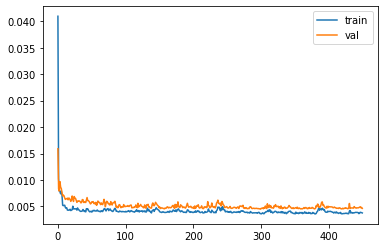

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_input (Inpu [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          batch_normalization_input[0][0]  
__________________________________________________________________________________________________
dense (Dense)                   (None, 35)           455         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 35)           0           dense[0][0]                      
______________________________________________________________________________________________

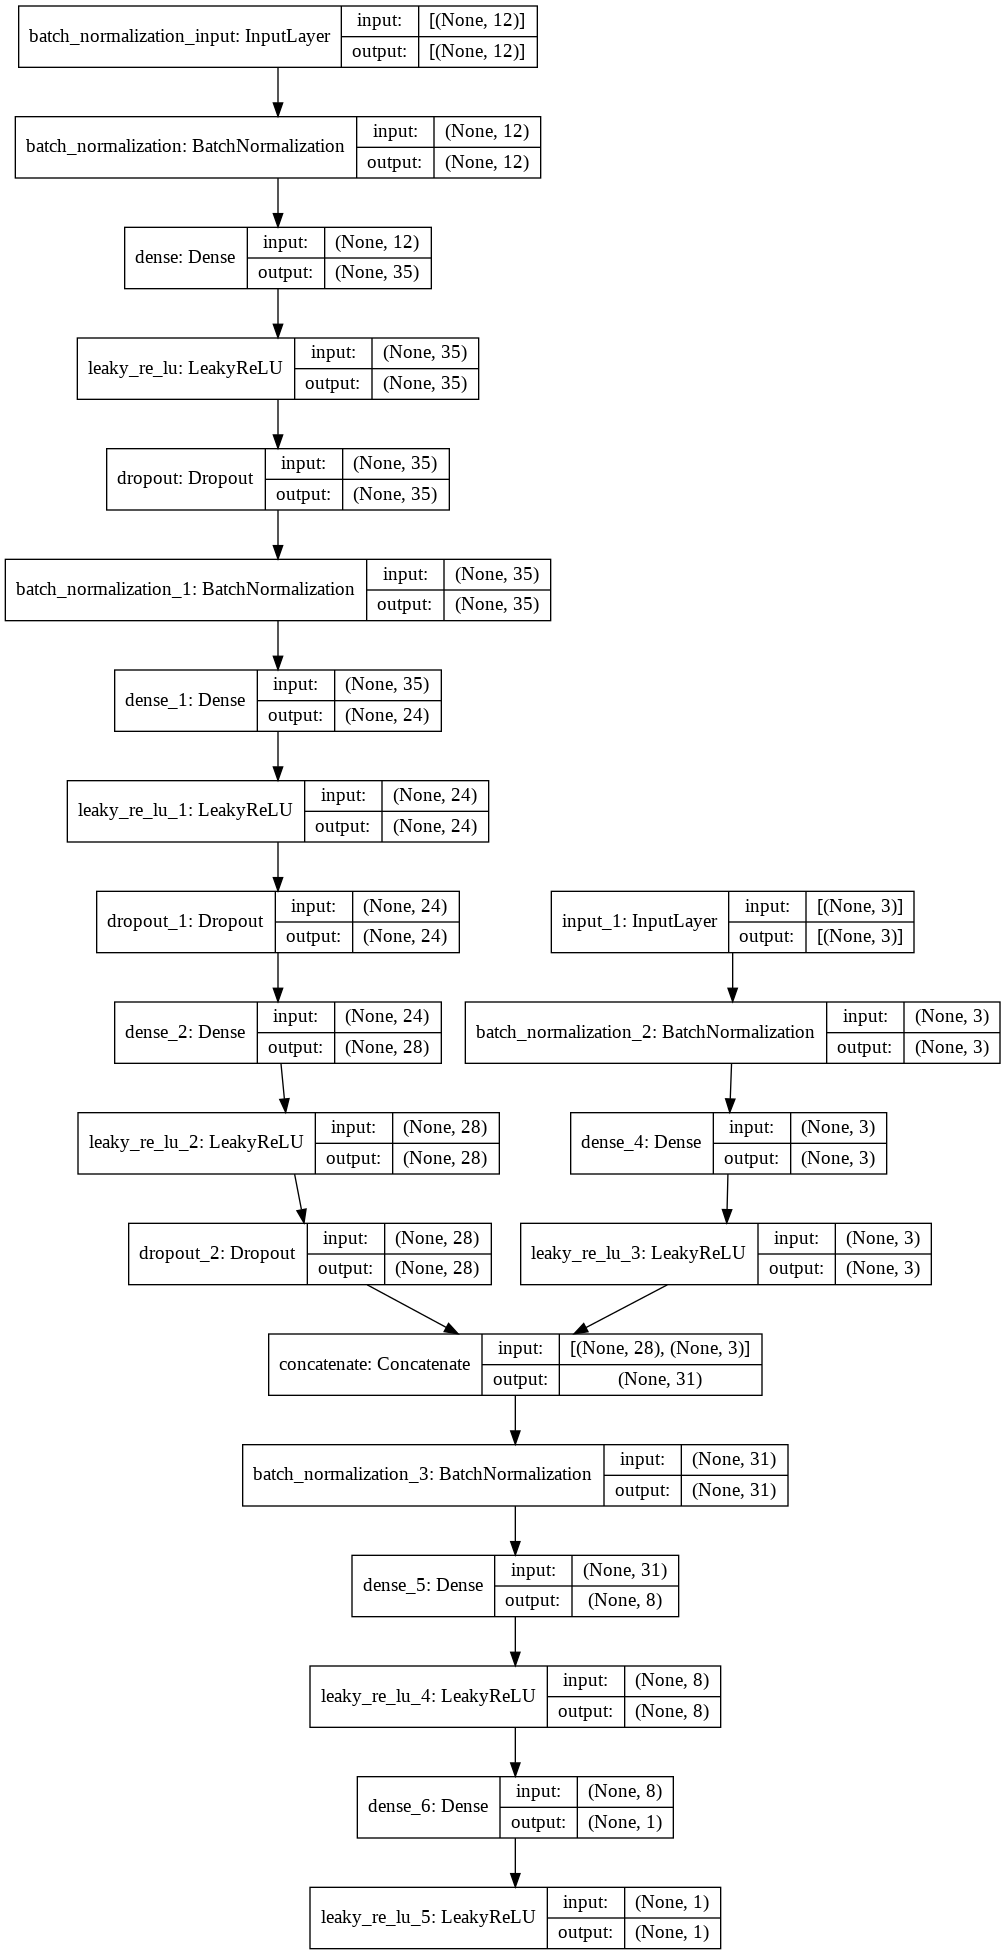

In [ ]:
model_fixed = load_model(precovid_model)
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

for i in range(0,len(model_fixed.layers)):
  model_fixed.layers[i].trainable = False

l1 = Input(shape=(3,))
l1_2 = BatchNormalization()(l1)
l2 = Dense(best_params2['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
l2_2 = LeakyReLU(alpha=best_params2['alpha'])(l2)
if best_params2['two_layer'] ==1 :
      l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_3])
else :
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_2])
merged2 = BatchNormalization()(merged)

if best_params2['last_layer'] ==0:
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)

if best_params2['last_layer'] ==1:
    l5 = Dense(best_params2['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
    l5_1 = LeakyReLU(alpha=best_params2['alpha'])(l5)
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)          

model = Model(inputs=[model_fixed.input,l1], outputs=l5_3)

opt = keras.optimizers.Adam(learning_rate=best_params2['learning_rate'])
model.compile(loss='mse',optimizer=opt)
fn_f = "gdrive/My Drive/Colab Notebooks/Stations/Training_CO_aftercovid.ckpt" 
fnn_f = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer

callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn_f, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=int(best_params2['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

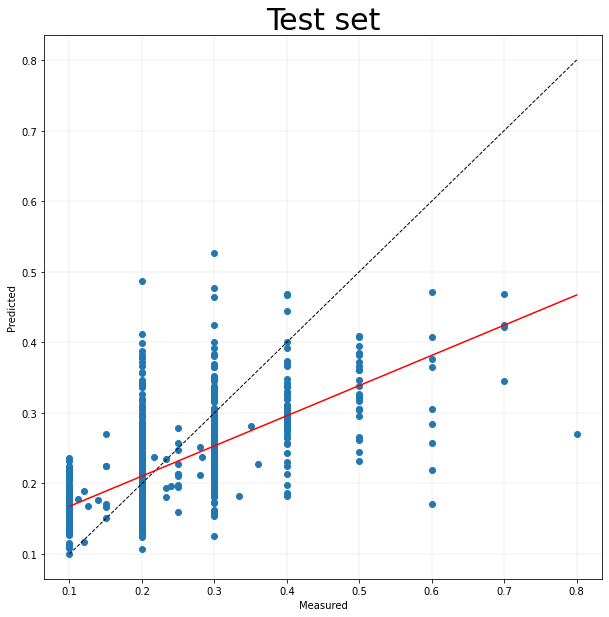

[0.42761824 0.12493499]
RMSE
[0.06297126]
R2
0.42194653306663965


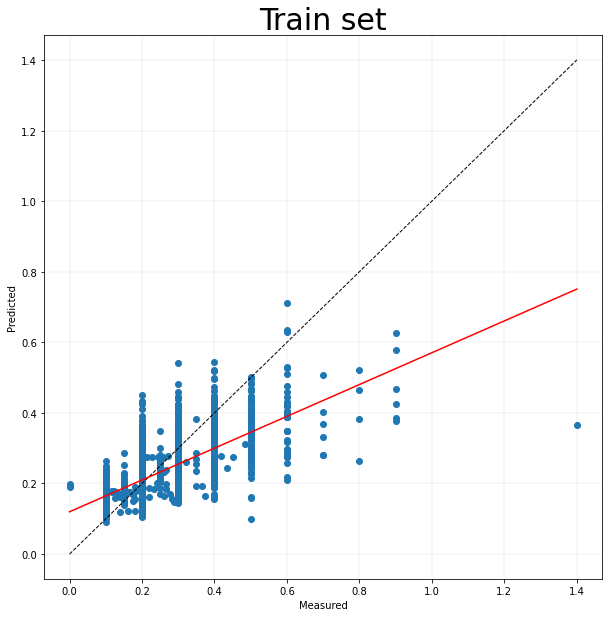

[0.45061179 0.11989867]
RMSE
[0.06110412]
R2
0.47311888956403503


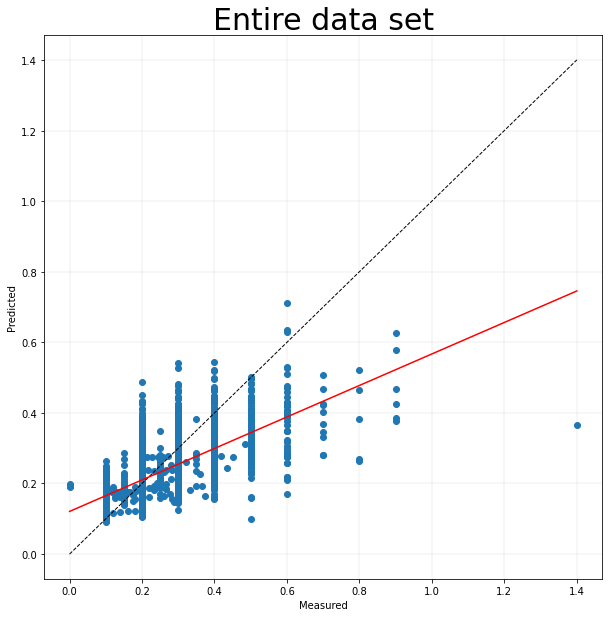

[0.4461315  0.12088052]
RMSE
[0.06148209]
R2
0.4631478722431982


In [ ]:
model.load_weights(fn_f )
model.save('gdrive/My Drive/Colab Notebooks/Model_Edmonton_east_after_Covid.h5')
preds = model.predict([X_test_a,X_test_b]) 
y_real = y_test_a.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

model.load_weights(fn_f)
preds = model.predict([X_train_a,X_train_b]) 
y_real_t = y_train_a.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
model.load_weights(fn_f)
preds = model.predict([X_a,X_b]) 
y_real_to = Y_a.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

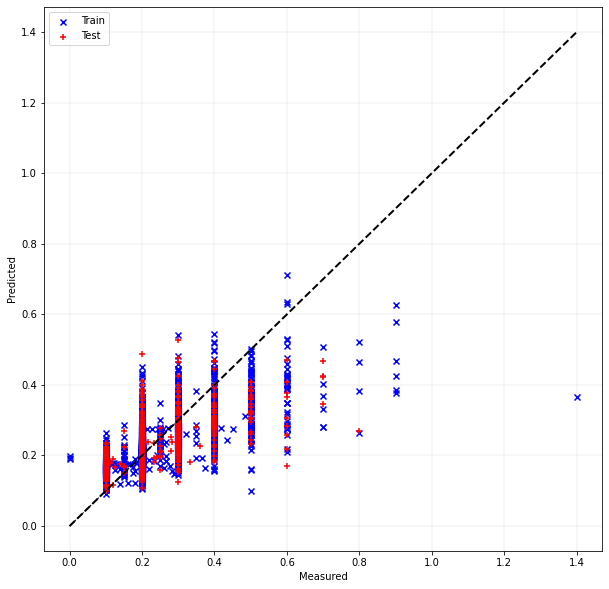

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.3], [0,0.3], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


In [ ]:
df2_w_c

CO(ppm)  T( C)  RH(%)  ...  driving  transit  walking
Date                                        ...                           
2020-01-13 00:00:00      0.1  -25.4   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 01:00:00      0.1  -25.7   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 02:00:00      0.1  -25.8   66.0  ...   1.0000   1.0000   1.0000
2020-01-13 03:00:00      0.1  -25.8   65.0  ...   1.0000   1.0000   1.0000
2020-01-13 04:00:00      0.1  -26.0   65.0  ...   1.0000   1.0000   1.0000
...                      ...    ...    ...  ...      ...      ...      ...
2021-01-31 19:00:00      0.4  -15.5   76.0  ...   0.7143   0.4266   0.8011
2021-01-31 20:00:00      0.4  -15.4   78.0  ...   0.7143   0.4266   0.8011
2021-01-31 21:00:00      0.2  -15.5   79.0  ...   0.7143   0.4266   0.8011
2021-01-31 22:00:00      0.2  -16.3   80.0  ...   0.7143   0.4266   0.8011
2021-01-31 23:00:00      0.2  -16.7   81.0  ...   0.7143   0.4266   0.8011

[9075 rows x 16 columns]

In [ ]:
# df3= df3.copy()
df4 = df2_w_c.copy()
df4['pred'] = model.predict([X_a,X_b])
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

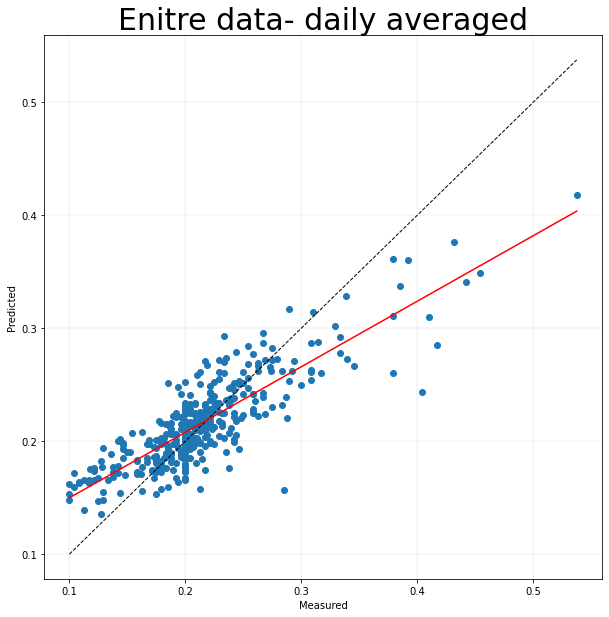

[0.57997188 0.09186987]
RMSE
[0.03240749]
R2
0.6798581783938966


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['CO(ppm)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


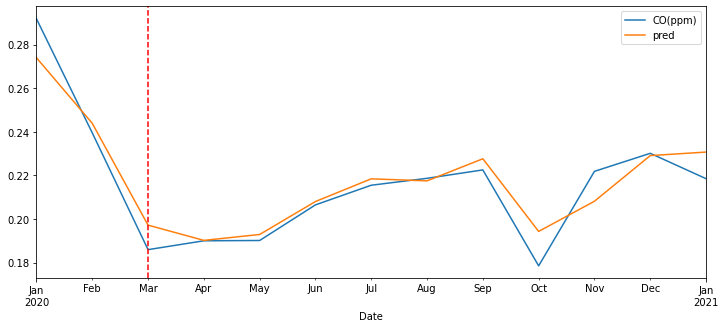

In [ ]:
df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df3_w_c = df2_w_c.copy()
df3_w_c['driving'] = 1.124019
df3_w_c['transit']  = 1.025378
df3_w_c['walking'] = 1.331329

In [ ]:
Y_a = df3_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df3_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df3_w_c[ ['driving', 'transit', 'walking']])




X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
# df3= df3.copy()
df44 = df3_w_c.copy()
df44['No lockdown'] = model.predict([X_a,X_b])
df104 = df44.resample('D').mean()
df104.dropna(inplace= True)

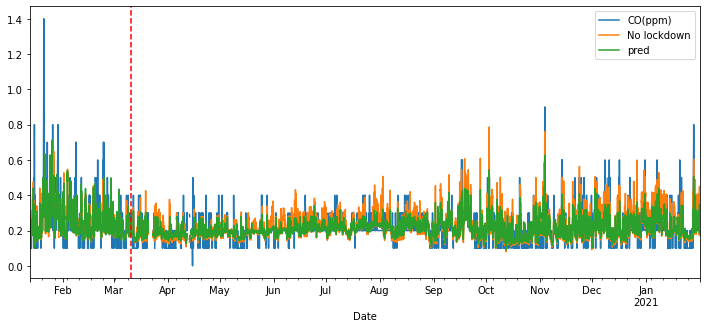

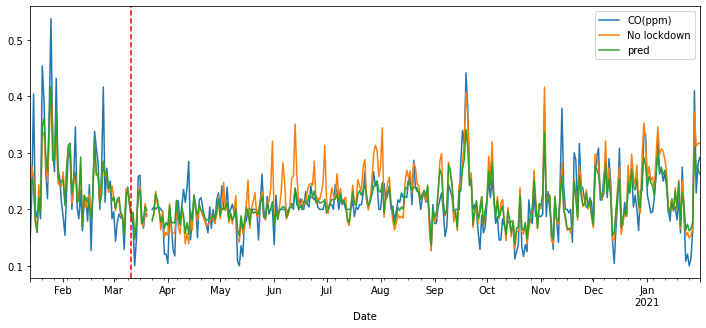

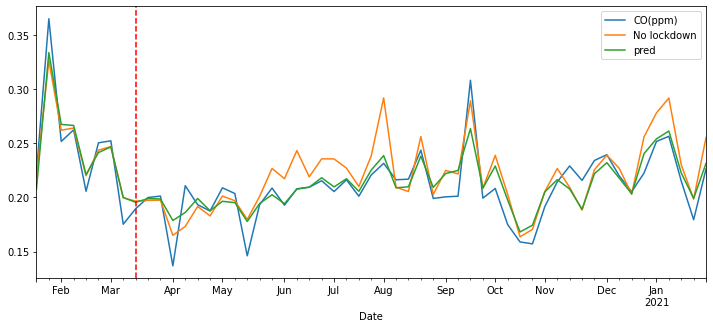

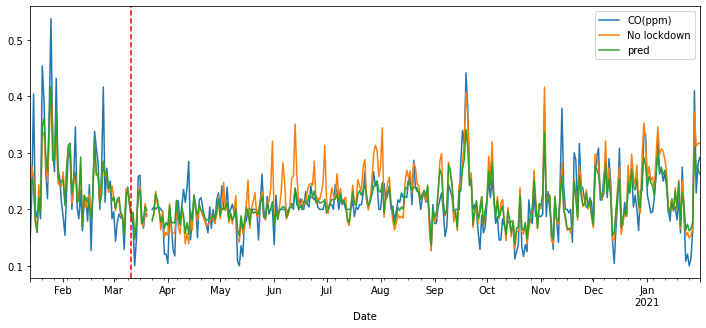

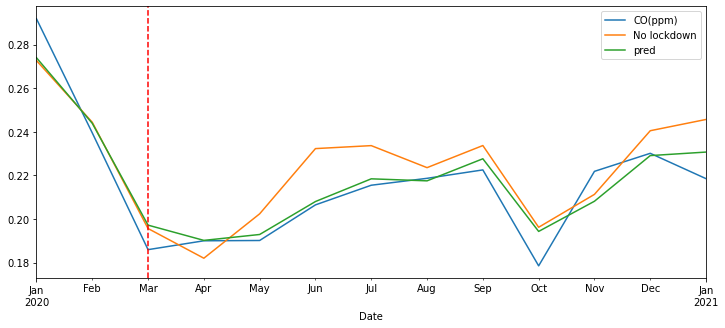

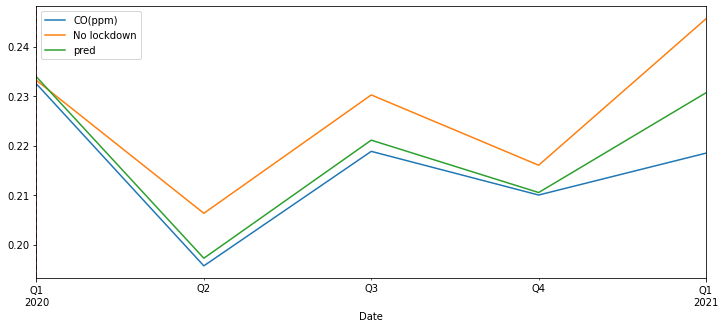

In [ ]:


df4['CO(ppm)'].resample('H').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('H').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('W').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('W').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()
df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('Q').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4['No lockdown']=df44['No lockdown'].copy()
print('No lockdown:',df4['No lockdown'].mean())
print('pred:',df4['pred'].mean())
print('CO(ppm):',df4['CO(ppm)'].mean())

No lockdown: 0.22312191128730774
pred: 0.2163834571838379
CO(ppm): 0.21406886884590973


In [ ]:
df4.head()

CO(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                        ...                                
2020-01-13 00:00:00      0.1  -25.4   68.0  ...      1.0  0.144256     0.140617
2020-01-13 01:00:00      0.1  -25.7   68.0  ...      1.0  0.154986     0.151347
2020-01-13 02:00:00      0.1  -25.8   66.0  ...      1.0  0.158600     0.154960
2020-01-13 03:00:00      0.1  -25.8   65.0  ...      1.0  0.166749     0.168830
2020-01-13 04:00:00      0.1  -26.0   65.0  ...      1.0  0.185634     0.212358

[5 rows x 18 columns]

In [ ]:
df4.to_csv('gdrive/My Drive/Colab Notebooks/Edmonton East/NOX_mobility_aftercov_Edmonton_east-COVID_hourly_pred.csv')

In [ ]:
df4

NOX(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                         ...                                
2020-01-13 00:00:00    0.0084  -25.4   68.0  ...   1.0000  0.012064     0.011699
2020-01-13 01:00:00    0.0078  -25.7   68.0  ...   1.0000  0.015269     0.014904
2020-01-13 02:00:00    0.0053  -25.8   66.0  ...   1.0000  0.015456     0.015090
2020-01-13 03:00:00    0.0050  -25.8   65.0  ...   1.0000  0.018650     0.018285
2020-01-13 04:00:00    0.0069  -26.0   65.0  ...   1.0000  0.023630     0.023264
...                       ...    ...    ...  ...      ...       ...          ...
2021-01-31 19:00:00    0.1137  -15.5   76.0  ...   0.8011  0.037565     0.041811
2021-01-31 20:00:00    0.1007  -15.4   78.0  ...   0.8011  0.024746     0.028993
2021-01-31 21:00:00    0.0515  -15.5   79.0  ...   0.8011  0.019648     0.023895
2021-01-31 22:00:00    0.0502  -16.3   80.0  ...   0.8011  0.030382     0.034629
2021-01-31 23:00:00    0.0408  -16.7   81.0  ...   0.8011  0.025745     0.029992

[9075 rows x 18 columns]